In [1]:
%matplotlib inline

# Fitting TESS data

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

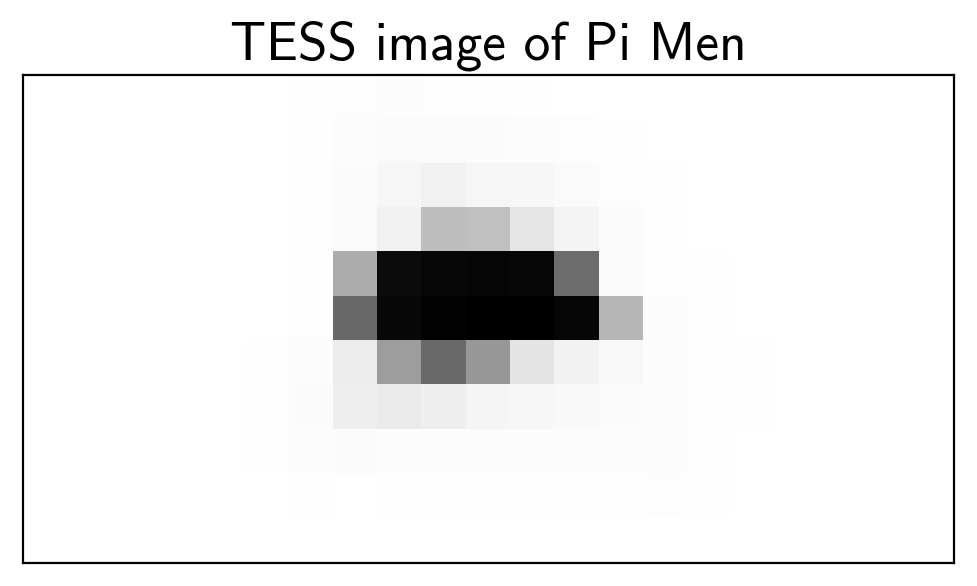

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

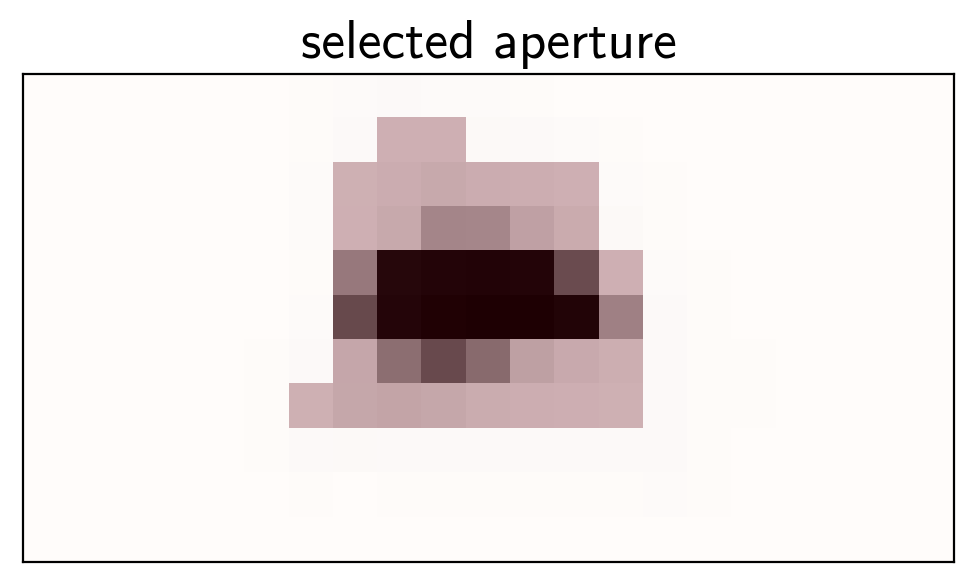

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

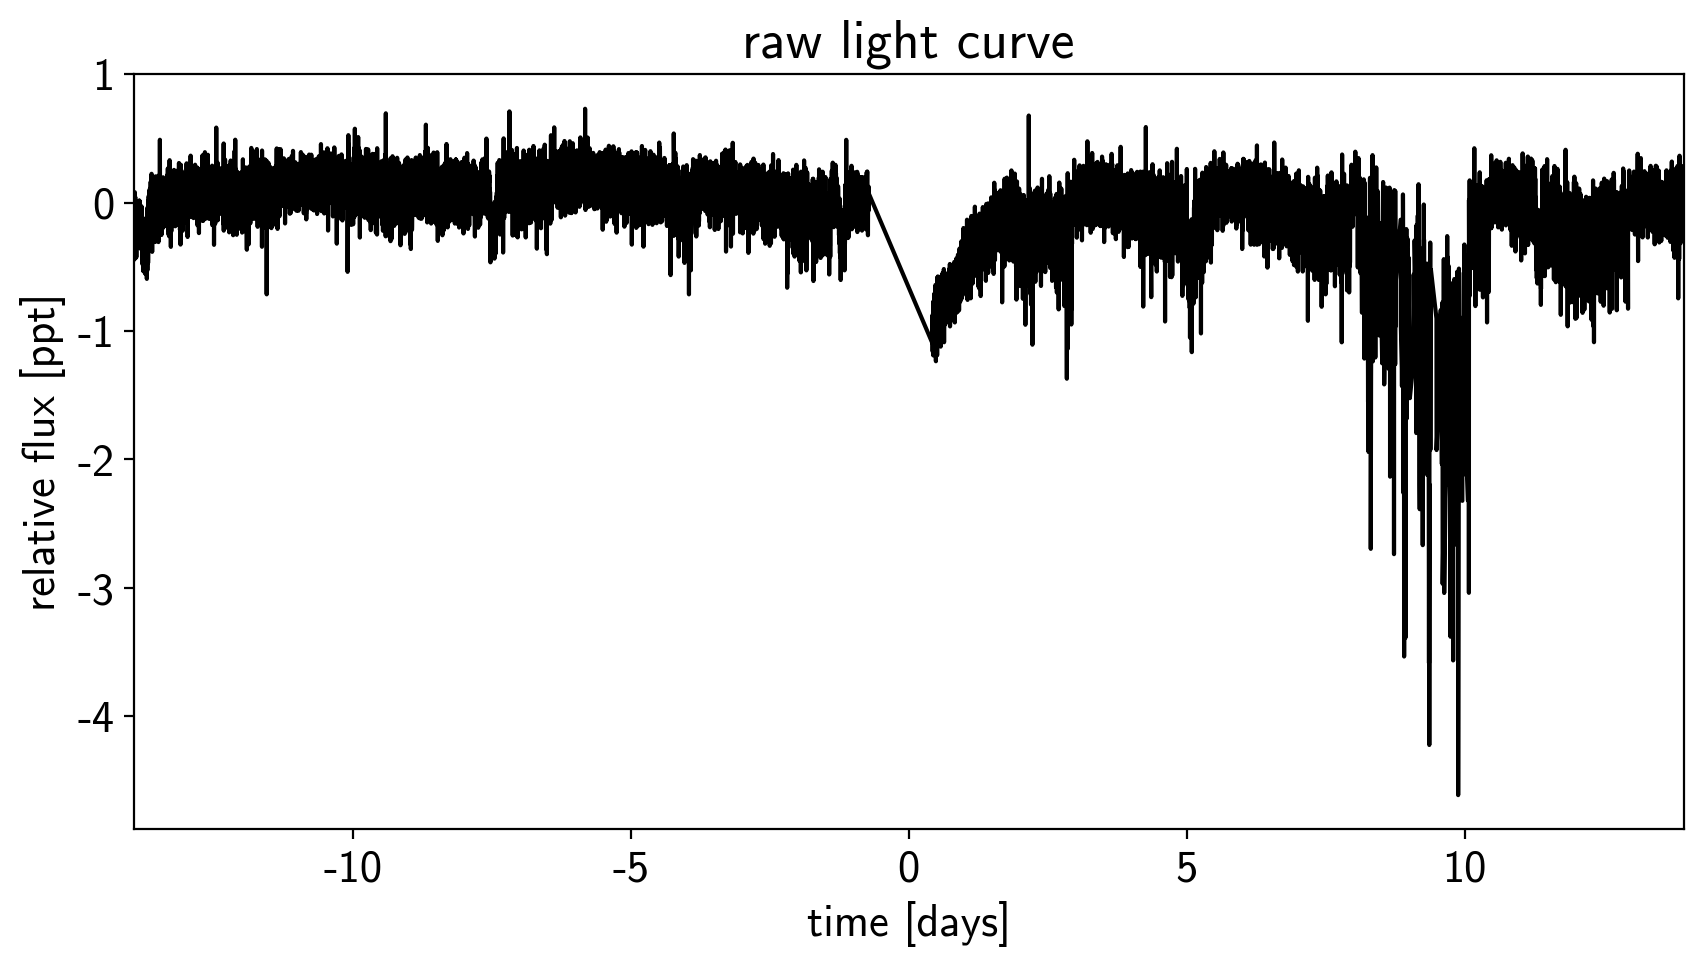

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

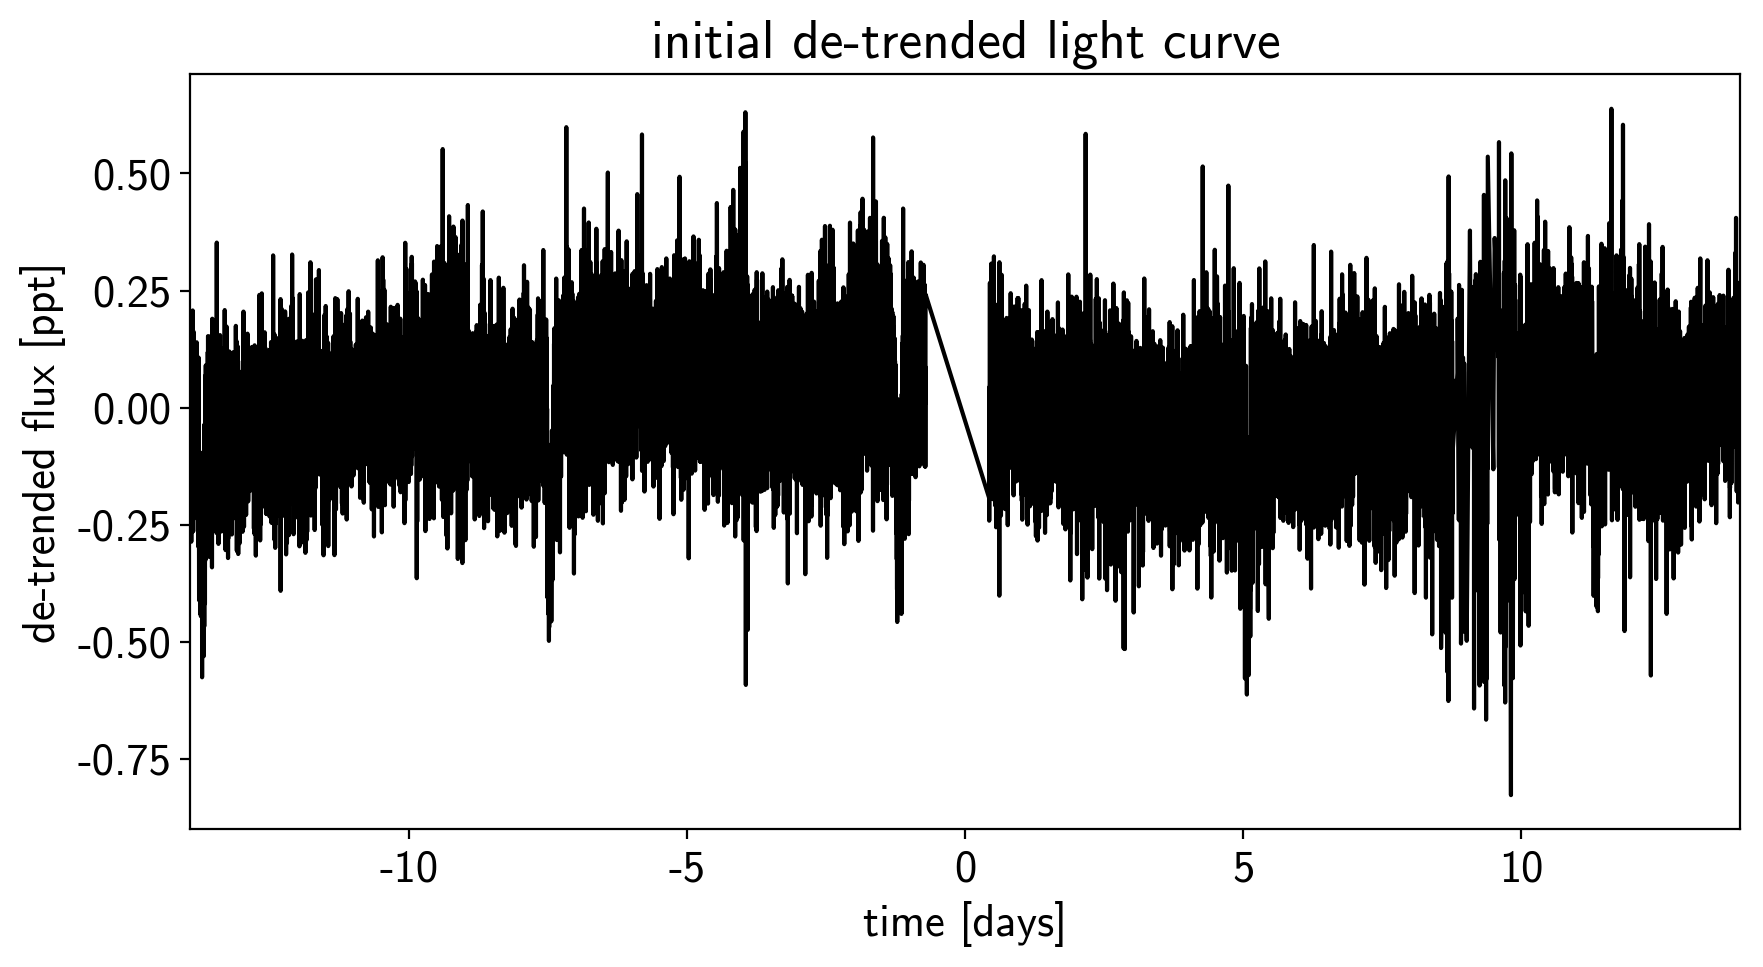

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

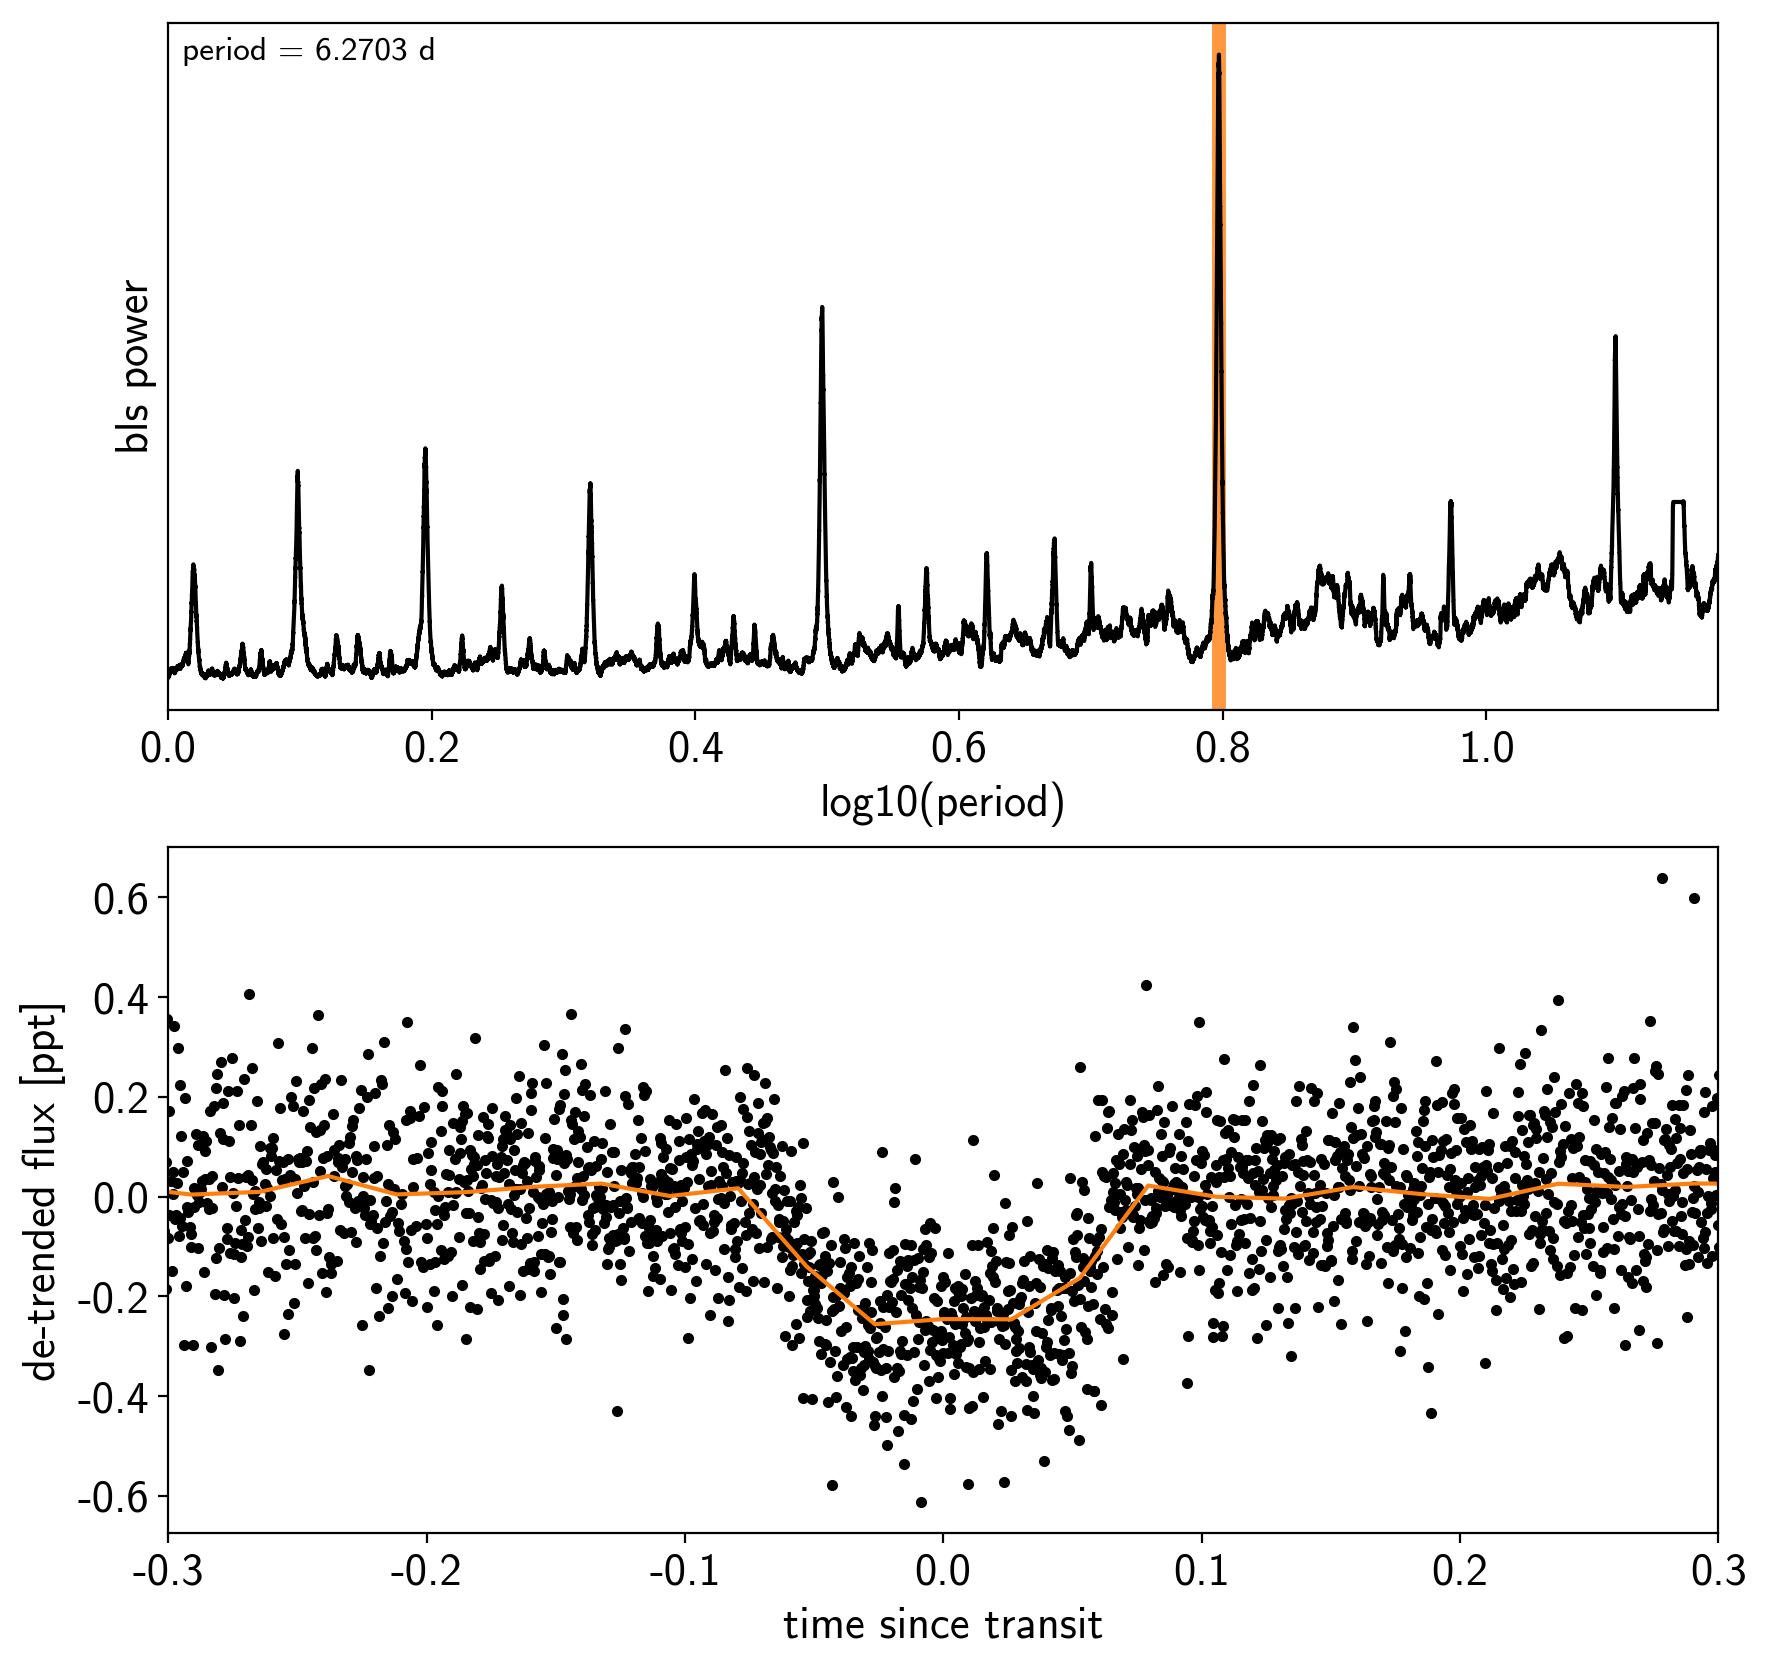

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

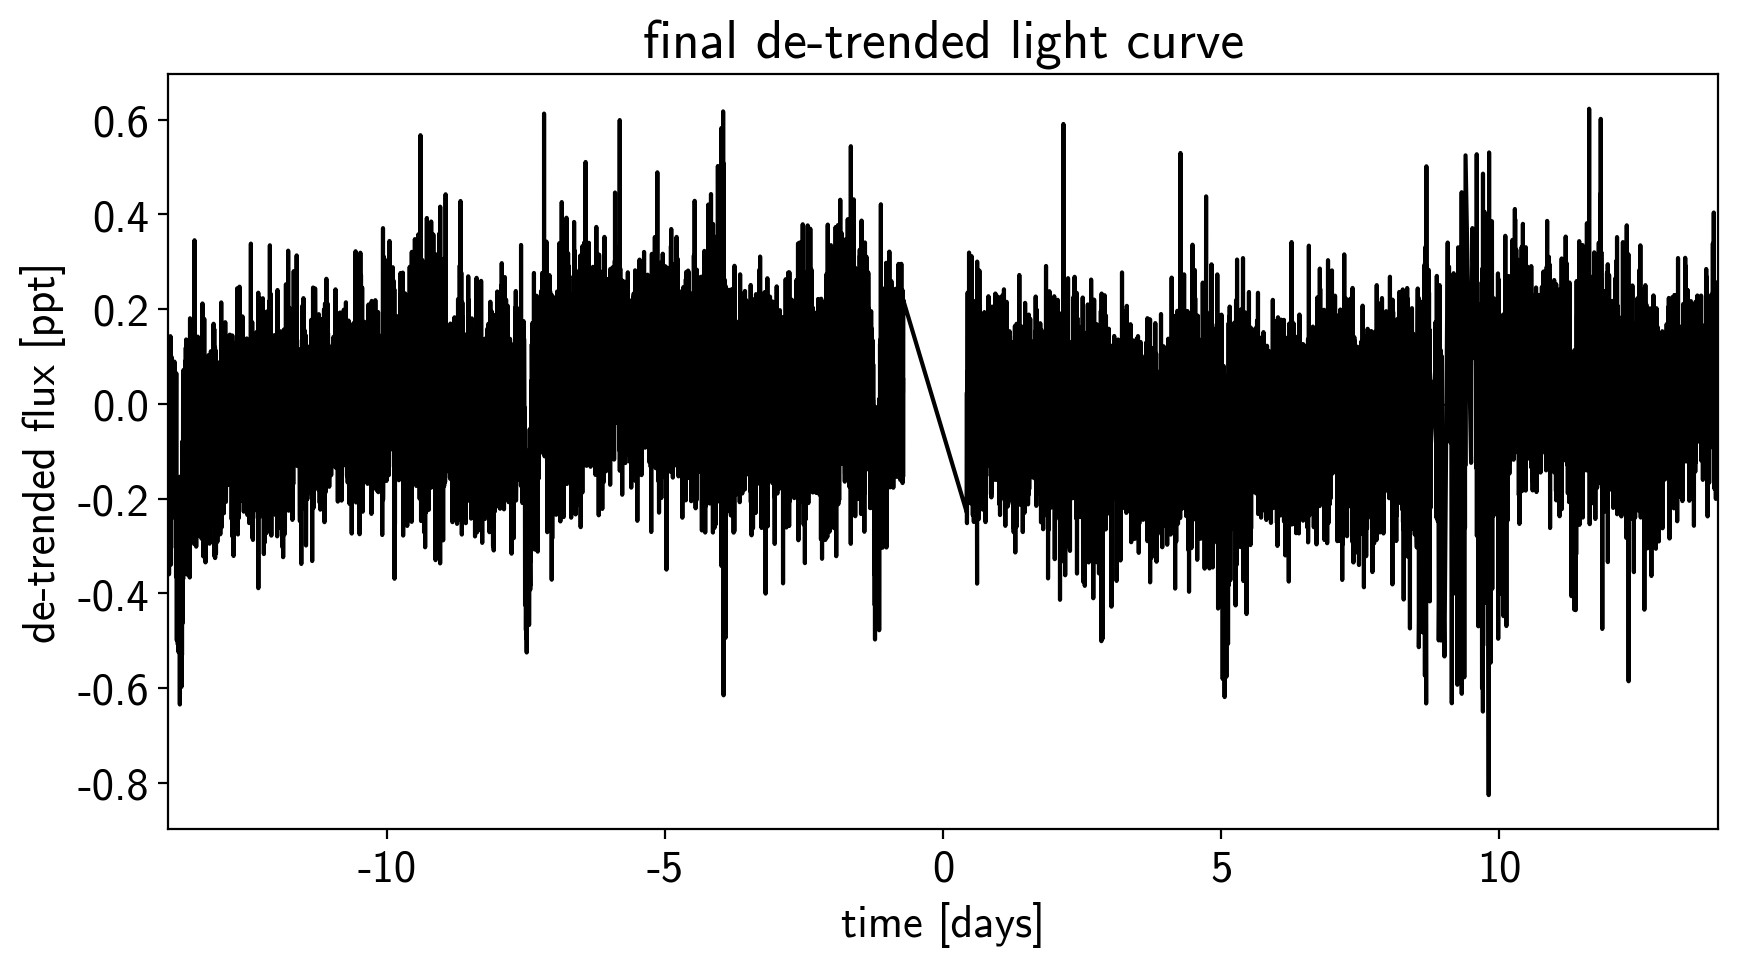

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

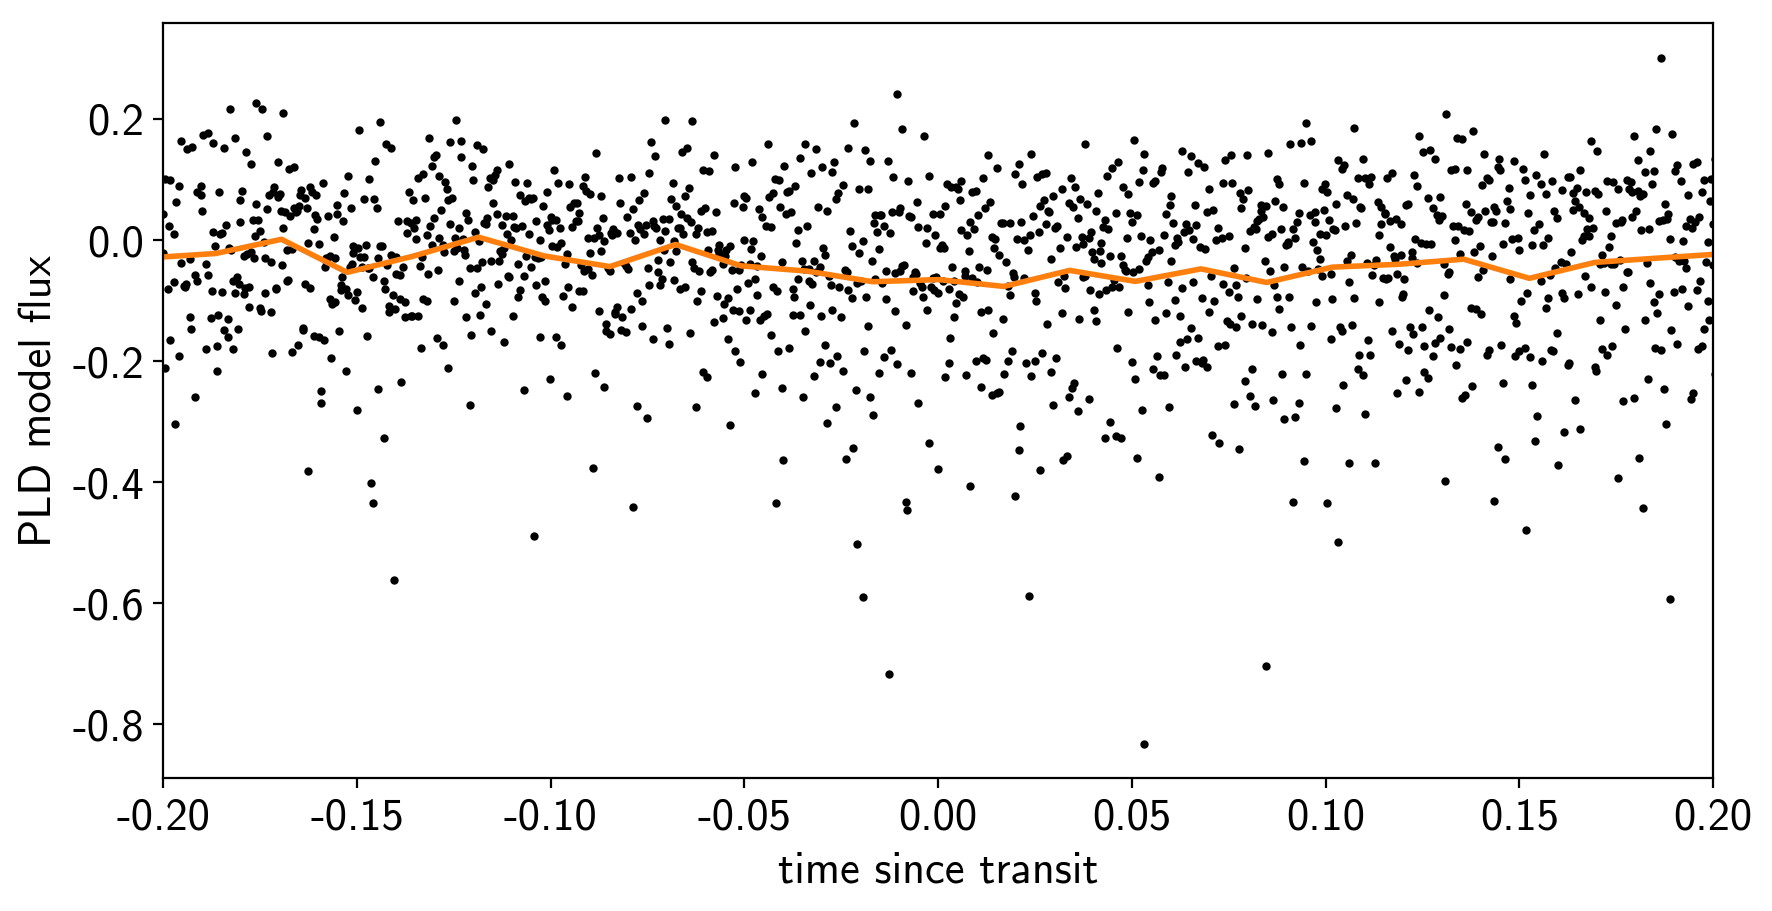

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`, but we'll use a [more informative prior on eccentricity](https://arxiv.org/abs/1306.4982).

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Flat("b", transform=pm.distributions.transforms.logodds, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12376.80857098689 -> 12639.996970230402


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12639.996970230402 -> 12678.43754115094


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 12678.43754115093 -> 12766.212035562921


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 12766.212035562921 -> 12775.280265954512


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 12775.280265954501 -> 12785.944976508114


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12785.944976508114 -> 12808.53381144991


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 12808.533811449899 -> 12810.245024531167


optimizing logp for variables: ['omega_angle__', 'ecc_interval__']


message: Optimization terminated successfully.
logp: 12810.245024531167 -> 12830.745429530267


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 12830.745429530281 -> 12830.776889942352


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12830.776889942352 -> 12841.612045253638


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_interval__', 'logr', 'b_logodds__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 12841.61204525363 -> 13051.734914861112


Here's how we plot the initial light curve model:

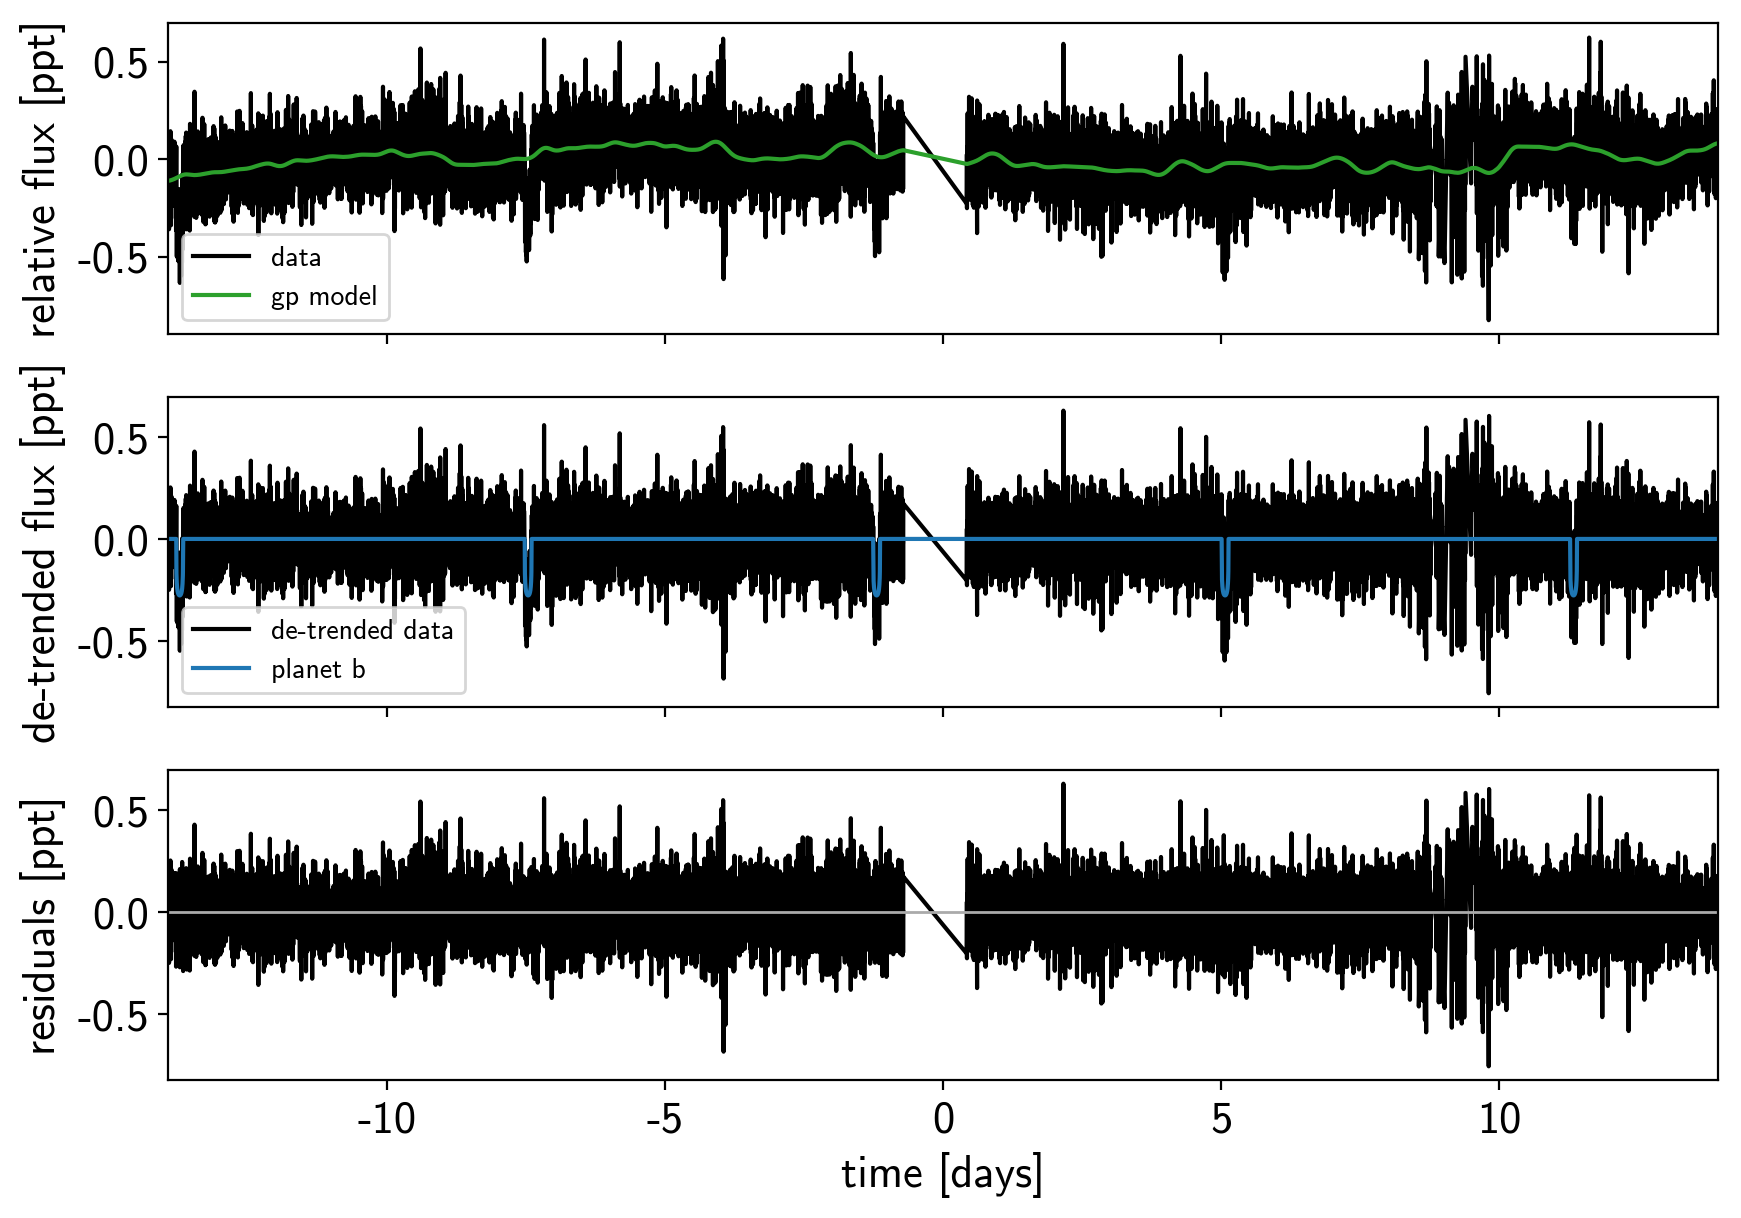

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

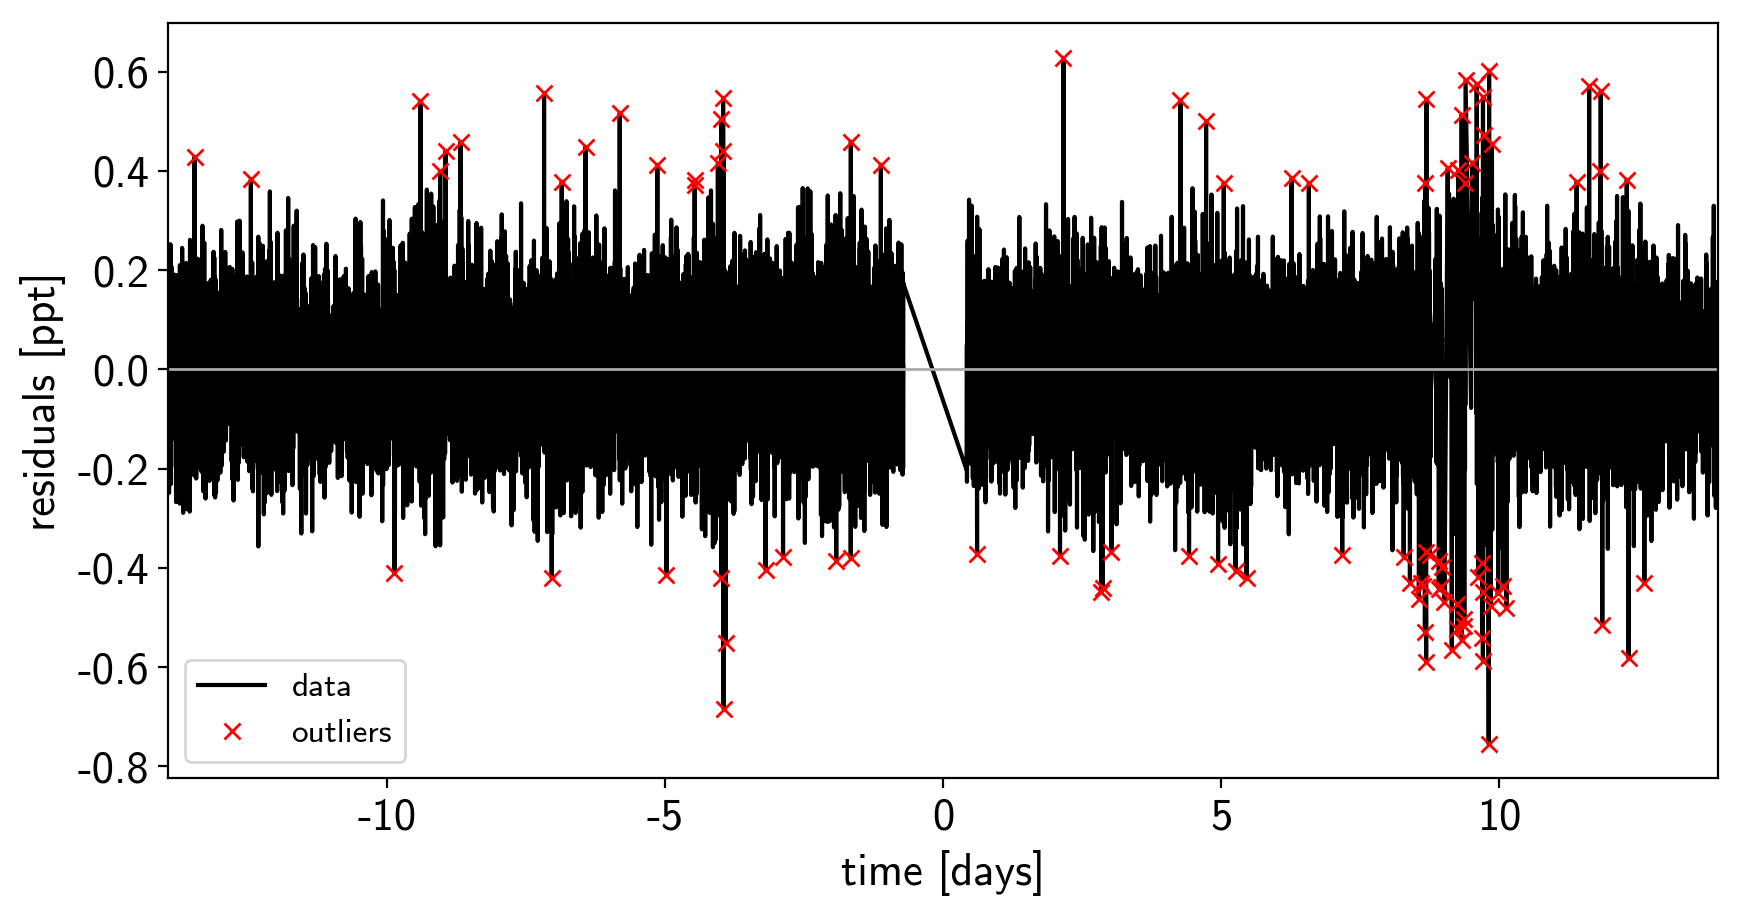

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13706.240110902876 -> 13737.199586236029


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.199586236029 -> 13737.219738011918


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 13737.21973801191 -> 13737.220611021676


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.220611021676 -> 13737.22944755852


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 13737.229447558528 -> 13737.253295929773


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.253295929773 -> 13737.256456024013


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 13737.25645602401 -> 13737.265293000299


optimizing logp for variables: ['omega_angle__', 'ecc_interval__']


message: Optimization terminated successfully.
logp: 13737.265293000299 -> 13737.265332582416


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 13737.265332582412 -> 13737.26848372552


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13737.26848372552 -> 13737.268486582765


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_interval__', 'logr', 'b_logodds__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.268486582772 -> 13737.280285382321


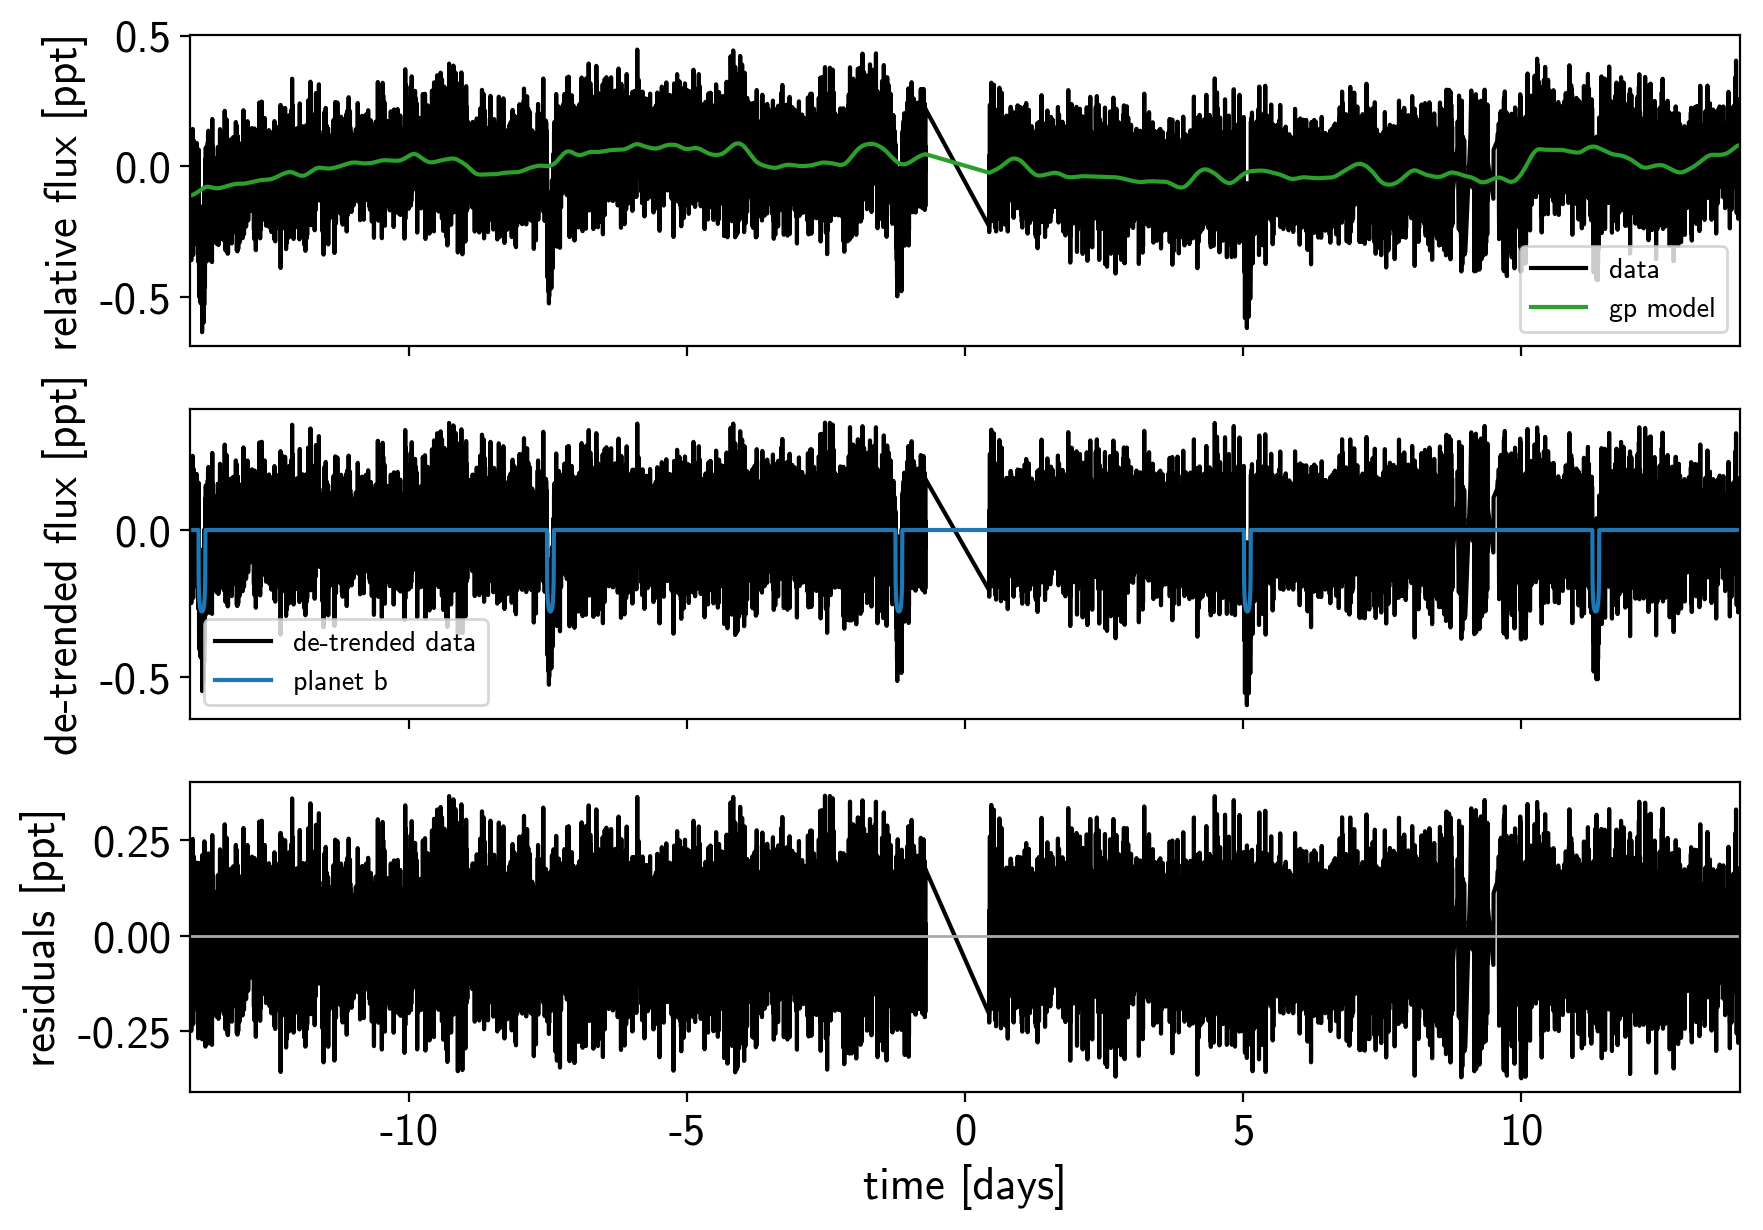

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample it using a :class:`exoplanet.PyMC3Sampler`:

In [14]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=300, chains=4)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 12/308 [00:00<00:02, 114.83draws/s]

Sampling 4 chains:   6%|▌         | 17/308 [00:02<00:36,  7.99draws/s] 

Sampling 4 chains:   7%|▋         | 21/308 [00:04<01:07,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 24/308 [00:04<00:50,  5.67draws/s]

Sampling 4 chains:   9%|▉         | 27/308 [00:06<01:30,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:07<02:19,  2.00draws/s]

Sampling 4 chains:  10%|█         | 31/308 [00:08<01:43,  2.68draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:09<02:26,  1.88draws/s]

Sampling 4 chains:  11%|█▏        | 35/308 [00:10<01:49,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:11<02:27,  1.83draws/s]

Sampling 4 chains:  12%|█▏        | 38/308 [00:12<01:51,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 39/308 [00:12<01:26,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:13<02:10,  2.05draws/s]

Sampling 4 chains:  14%|█▎        | 42/308 [00:13<01:39,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 43/308 [00:14<01:19,  3.35draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:15<02:02,  2.15draws/s]

Sampling 4 chains:  15%|█▍        | 46/308 [00:15<01:35,  2.74draws/s]

Sampling 4 chains:  15%|█▌        | 47/308 [00:16<01:17,  3.36draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:17<01:59,  2.17draws/s]

Sampling 4 chains:  16%|█▌        | 50/308 [00:17<01:34,  2.72draws/s]

Sampling 4 chains:  17%|█▋        | 51/308 [00:18<01:18,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 54/308 [00:19<01:39,  2.55draws/s]

Sampling 4 chains:  18%|█▊        | 55/308 [00:20<01:22,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:21<01:42,  2.45draws/s]

Sampling 4 chains:  19%|█▉        | 59/308 [00:21<01:23,  3.00draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:23<01:32,  2.65draws/s]

Sampling 4 chains:  20%|██        | 63/308 [00:23<01:31,  2.67draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:23<01:14,  3.29draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:25<01:44,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:25<01:37,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 68/308 [00:25<01:17,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 70/308 [00:27<01:47,  2.21draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:27<01:38,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 72/308 [00:27<01:17,  3.04draws/s]

Sampling 4 chains:  24%|██▎       | 73/308 [00:27<01:01,  3.81draws/s]

Sampling 4 chains:  24%|██▍       | 74/308 [00:28<00:51,  4.53draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:29<01:58,  1.97draws/s]

Sampling 4 chains:  25%|██▍       | 76/308 [00:29<01:29,  2.59draws/s]

Sampling 4 chains:  25%|██▌       | 77/308 [00:29<01:33,  2.47draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:30<01:22,  2.78draws/s]

Sampling 4 chains:  26%|██▌       | 79/308 [00:31<02:18,  1.66draws/s]

Sampling 4 chains:  26%|██▋       | 81/308 [00:31<01:53,  1.99draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:32<01:37,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:33<02:26,  1.53draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:33<01:59,  1.87draws/s]

Sampling 4 chains:  28%|██▊       | 86/308 [00:34<01:42,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:35<02:27,  1.49draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:35<01:50,  2.00draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:35<01:43,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 90/308 [00:35<01:31,  2.37draws/s]

Sampling 4 chains:  30%|██▉       | 92/308 [00:37<01:41,  2.14draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:37<01:17,  2.76draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:37<01:39,  2.15draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:39<01:45,  2.01draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:39<01:22,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:39<01:41,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:41<01:45,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:41<01:22,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:41<01:40,  2.05draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:43<01:44,  1.96draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:43<01:20,  2.52draws/s]

Sampling 4 chains:  34%|███▍      | 106/308 [00:43<01:38,  2.05draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:44<01:42,  1.96draws/s]

Sampling 4 chains:  35%|███▌      | 109/308 [00:45<01:19,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 110/308 [00:45<01:35,  2.07draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:46<01:39,  1.96draws/s]

Sampling 4 chains:  37%|███▋      | 113/308 [00:47<01:17,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:47<01:33,  2.08draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:48<01:38,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:49<01:15,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:49<01:30,  2.10draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:50<01:27,  2.16draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:50<01:16,  2.43draws/s]

Sampling 4 chains:  40%|███▉      | 123/308 [00:51<01:15,  2.46draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:52<01:41,  1.82draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:52<01:26,  2.12draws/s]

Sampling 4 chains:  41%|████      | 127/308 [00:53<01:20,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:54<01:44,  1.72draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:54<01:28,  2.02draws/s]

Sampling 4 chains:  43%|████▎     | 131/308 [00:55<01:21,  2.17draws/s]

Sampling 4 chains:  43%|████▎     | 132/308 [00:56<01:44,  1.68draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:56<01:27,  1.99draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:57<01:20,  2.15draws/s]

Sampling 4 chains:  44%|████▍     | 136/308 [00:58<01:43,  1.67draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:58<01:26,  1.98draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:59<01:18,  2.14draws/s]

Sampling 4 chains:  45%|████▌     | 140/308 [01:00<01:41,  1.66draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [01:00<01:24,  1.97draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [01:01<01:17,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 144/308 [01:01<01:17,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [01:02<01:15,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [01:02<01:12,  2.24draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [01:03<01:20,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 148/308 [01:03<01:19,  2.01draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [01:04<01:16,  2.08draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [01:04<01:12,  2.18draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [01:05<01:19,  1.98draws/s]

Sampling 4 chains:  49%|████▉     | 152/308 [01:05<01:18,  1.99draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [01:06<01:14,  2.07draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [01:06<01:08,  2.24draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [01:07<01:17,  1.97draws/s]

Sampling 4 chains:  51%|█████     | 156/308 [01:07<01:17,  1.96draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [01:08<01:13,  2.05draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [01:08<01:07,  2.22draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [01:09<01:15,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 160/308 [01:09<01:15,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [01:10<01:11,  2.05draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [01:10<01:06,  2.20draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [01:11<01:13,  1.99draws/s]

Sampling 4 chains:  53%|█████▎    | 164/308 [01:11<01:13,  1.96draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [01:12<01:10,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [01:12<01:05,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 167/308 [01:12<01:00,  2.34draws/s]

Sampling 4 chains:  55%|█████▍    | 168/308 [01:13<01:14,  1.87draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [01:14<01:10,  1.98draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [01:14<01:04,  2.13draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [01:14<00:59,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 172/308 [01:15<01:13,  1.84draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [01:16<01:08,  1.96draws/s]

Sampling 4 chains:  56%|█████▋    | 174/308 [01:16<01:03,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [01:16<00:57,  2.32draws/s]

Sampling 4 chains:  57%|█████▋    | 176/308 [01:17<01:11,  1.84draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [01:18<01:06,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [01:18<01:01,  2.10draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [01:18<00:55,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 180/308 [01:19<01:09,  1.83draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [01:19<01:05,  1.95draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [01:20<01:00,  2.10draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [01:20<00:53,  2.35draws/s]

Sampling 4 chains:  60%|█████▉    | 184/308 [01:21<01:07,  1.84draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [01:21<01:03,  1.95draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [01:22<00:58,  2.09draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [01:22<00:51,  2.37draws/s]

Sampling 4 chains:  61%|██████    | 188/308 [01:23<01:05,  1.84draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [01:23<01:01,  1.95draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [01:24<00:56,  2.07draws/s]

Sampling 4 chains:  62%|██████▏   | 191/308 [01:24<00:48,  2.39draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [01:24<00:38,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [01:25<00:51,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [01:25<00:51,  2.22draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [01:26<00:57,  1.96draws/s]

Sampling 4 chains:  64%|██████▎   | 196/308 [01:26<00:45,  2.48draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [01:27<00:54,  2.04draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [01:27<00:53,  2.07draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [01:28<00:57,  1.88draws/s]

Sampling 4 chains:  65%|██████▍   | 200/308 [01:28<00:45,  2.37draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [01:29<00:53,  2.01draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [01:29<00:52,  2.04draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [01:30<00:56,  1.87draws/s]

Sampling 4 chains:  66%|██████▌   | 204/308 [01:30<00:44,  2.33draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [01:31<00:51,  2.00draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [01:31<00:50,  2.02draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [01:32<00:53,  1.88draws/s]

Sampling 4 chains:  68%|██████▊   | 208/308 [01:32<00:43,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [01:33<00:49,  2.02draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [01:33<00:48,  2.02draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [01:34<00:51,  1.89draws/s]

Sampling 4 chains:  69%|██████▉   | 212/308 [01:34<00:42,  2.24draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [01:35<00:46,  2.03draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [01:35<00:46,  2.03draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [01:35<00:37,  2.46draws/s]

Sampling 4 chains:  70%|███████   | 216/308 [01:36<00:44,  2.06draws/s]

Sampling 4 chains:  70%|███████   | 217/308 [01:37<00:47,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [01:37<00:46,  1.96draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [01:37<00:37,  2.40draws/s]

Sampling 4 chains:  71%|███████▏  | 220/308 [01:38<00:43,  2.01draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [01:39<00:45,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [01:39<00:44,  1.94draws/s]

Sampling 4 chains:  72%|███████▏  | 223/308 [01:39<00:35,  2.40draws/s]

Sampling 4 chains:  73%|███████▎  | 224/308 [01:40<00:42,  2.00draws/s]

Sampling 4 chains:  73%|███████▎  | 225/308 [01:41<00:43,  1.91draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [01:41<00:42,  1.94draws/s]

Sampling 4 chains:  74%|███████▎  | 227/308 [01:41<00:33,  2.42draws/s]

Sampling 4 chains:  74%|███████▍  | 228/308 [01:42<00:40,  1.99draws/s]

Sampling 4 chains:  74%|███████▍  | 229/308 [01:43<00:41,  1.90draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [01:43<00:40,  1.94draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [01:43<00:31,  2.44draws/s]

Sampling 4 chains:  75%|███████▌  | 232/308 [01:44<00:38,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [01:45<00:39,  1.90draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [01:45<00:38,  1.93draws/s]

Sampling 4 chains:  76%|███████▋  | 235/308 [01:45<00:29,  2.46draws/s]

Sampling 4 chains:  77%|███████▋  | 236/308 [01:46<00:36,  1.95draws/s]

Sampling 4 chains:  77%|███████▋  | 237/308 [01:46<00:37,  1.90draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [01:47<00:36,  1.92draws/s]

Sampling 4 chains:  78%|███████▊  | 239/308 [01:47<00:27,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [01:48<00:35,  1.94draws/s]

Sampling 4 chains:  78%|███████▊  | 241/308 [01:48<00:35,  1.90draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [01:49<00:34,  1.92draws/s]

Sampling 4 chains:  79%|███████▉  | 243/308 [01:49<00:25,  2.51draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [01:50<00:33,  1.94draws/s]

Sampling 4 chains:  80%|███████▉  | 245/308 [01:50<00:33,  1.90draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [01:51<00:32,  1.90draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [01:51<00:24,  2.50draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [01:52<00:31,  1.92draws/s]

Sampling 4 chains:  81%|████████  | 249/308 [01:52<00:31,  1.90draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [01:53<00:30,  1.91draws/s]

Sampling 4 chains:  81%|████████▏ | 251/308 [01:53<00:22,  2.52draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [01:54<00:29,  1.92draws/s]

Sampling 4 chains:  82%|████████▏ | 253/308 [01:54<00:29,  1.86draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [01:55<00:28,  1.91draws/s]

Sampling 4 chains:  83%|████████▎ | 255/308 [01:55<00:21,  2.50draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [01:56<00:27,  1.92draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [01:56<00:27,  1.86draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [01:57<00:26,  1.91draws/s]

Sampling 4 chains:  84%|████████▍ | 259/308 [01:57<00:19,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [01:58<00:24,  1.93draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [01:58<00:25,  1.87draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [01:59<00:23,  1.93draws/s]

Sampling 4 chains:  85%|████████▌ | 263/308 [01:59<00:17,  2.52draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [02:00<00:22,  1.93draws/s]

Sampling 4 chains:  86%|████████▌ | 265/308 [02:00<00:22,  1.88draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [02:01<00:21,  1.92draws/s]

Sampling 4 chains:  87%|████████▋ | 268/308 [02:02<00:20,  2.00draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [02:02<00:20,  1.94draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [02:03<00:19,  1.96draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [02:04<00:17,  2.02draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [02:04<00:17,  1.96draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [02:05<00:17,  1.97draws/s]

Sampling 4 chains:  90%|████████▉ | 276/308 [02:06<00:15,  2.03draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [02:06<00:15,  1.97draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [02:07<00:15,  1.97draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [02:08<00:13,  2.03draws/s]

Sampling 4 chains:  91%|█████████ | 281/308 [02:08<00:13,  1.98draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [02:09<00:13,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [02:10<00:11,  2.02draws/s]

Sampling 4 chains:  93%|█████████▎| 285/308 [02:10<00:11,  2.00draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [02:11<00:11,  1.98draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [02:12<00:09,  2.02draws/s]

Sampling 4 chains:  94%|█████████▍| 289/308 [02:12<00:09,  2.00draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [02:13<00:09,  1.99draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [02:13<00:07,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 293/308 [02:14<00:05,  2.55draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [02:14<00:08,  1.75draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [02:15<00:05,  2.11draws/s]

Sampling 4 chains:  96%|█████████▋| 297/308 [02:15<00:04,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [02:15<00:03,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 299/308 [02:16<00:04,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [02:17<00:04,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [02:17<00:03,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [02:17<00:02,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 303/308 [02:19<00:03,  1.41draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [02:19<00:02,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [02:24<00:05,  1.93s/draws]

Sampling 4 chains:  99%|█████████▉| 306/308 [02:25<00:03,  1.68s/draws]

Sampling 4 chains: 100%|█████████▉| 307/308 [02:27<00:01,  1.59s/draws]

Sampling 4 chains: 100%|██████████| 308/308 [02:27<00:00,  1.18s/draws]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:   9%|▉         | 10/108 [00:00<00:00, 98.09draws/s]

Sampling 4 chains:  16%|█▌        | 17/108 [00:00<00:01, 86.44draws/s]

Sampling 4 chains:  20%|██        | 22/108 [00:02<00:11,  7.79draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:04<00:23,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 28/108 [00:04<00:18,  4.32draws/s]

Sampling 4 chains:  28%|██▊       | 30/108 [00:06<00:32,  2.41draws/s]

Sampling 4 chains:  30%|██▉       | 32/108 [00:06<00:25,  2.98draws/s]

Sampling 4 chains:  31%|███▏      | 34/108 [00:08<00:35,  2.07draws/s]

Sampling 4 chains:  33%|███▎      | 36/108 [00:08<00:27,  2.59draws/s]

Sampling 4 chains:  34%|███▍      | 37/108 [00:10<00:53,  1.32draws/s]

Sampling 4 chains:  36%|███▌      | 39/108 [00:10<00:37,  1.82draws/s]

Sampling 4 chains:  37%|███▋      | 40/108 [00:10<00:30,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:12<00:53,  1.25draws/s]

Sampling 4 chains:  40%|███▉      | 43/108 [00:12<00:37,  1.72draws/s]

Sampling 4 chains:  41%|████      | 44/108 [00:12<00:30,  2.08draws/s]

Sampling 4 chains:  42%|████▏     | 45/108 [00:12<00:24,  2.61draws/s]

Sampling 4 chains:  43%|████▎     | 46/108 [00:12<00:23,  2.64draws/s]

Sampling 4 chains:  44%|████▎     | 47/108 [00:13<00:35,  1.72draws/s]

Sampling 4 chains:  45%|████▌     | 49/108 [00:14<00:28,  2.04draws/s]

Sampling 4 chains:  46%|████▋     | 50/108 [00:14<00:26,  2.20draws/s]

Sampling 4 chains:  48%|████▊     | 52/108 [00:15<00:26,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 53/108 [00:16<00:27,  2.00draws/s]

Sampling 4 chains:  50%|█████     | 54/108 [00:16<00:24,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 56/108 [00:17<00:24,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 57/108 [00:18<00:25,  1.97draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:18<00:23,  2.14draws/s]

Sampling 4 chains:  56%|█████▌    | 60/108 [00:19<00:22,  2.10draws/s]

Sampling 4 chains:  56%|█████▋    | 61/108 [00:20<00:24,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 62/108 [00:20<00:21,  2.14draws/s]

Sampling 4 chains:  59%|█████▉    | 64/108 [00:21<00:16,  2.60draws/s]

Sampling 4 chains:  60%|██████    | 65/108 [00:21<00:19,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 66/108 [00:22<00:17,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 67/108 [00:22<00:19,  2.09draws/s]

Sampling 4 chains:  64%|██████▍   | 69/108 [00:23<00:15,  2.52draws/s]

Sampling 4 chains:  65%|██████▍   | 70/108 [00:24<00:20,  1.82draws/s]

Sampling 4 chains:  66%|██████▌   | 71/108 [00:24<00:16,  2.25draws/s]

Sampling 4 chains:  67%|██████▋   | 72/108 [00:24<00:14,  2.44draws/s]

Sampling 4 chains:  68%|██████▊   | 73/108 [00:25<00:15,  2.24draws/s]

Sampling 4 chains:  69%|██████▊   | 74/108 [00:26<00:19,  1.72draws/s]

Sampling 4 chains:  69%|██████▉   | 75/108 [00:26<00:15,  2.16draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:26<00:13,  2.31draws/s]

Sampling 4 chains:  71%|███████▏  | 77/108 [00:27<00:14,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 78/108 [00:27<00:17,  1.71draws/s]

Sampling 4 chains:  73%|███████▎  | 79/108 [00:28<00:13,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 80/108 [00:28<00:11,  2.48draws/s]

Sampling 4 chains:  75%|███████▌  | 81/108 [00:29<00:12,  2.10draws/s]

Sampling 4 chains:  76%|███████▌  | 82/108 [00:29<00:15,  1.69draws/s]

Sampling 4 chains:  77%|███████▋  | 83/108 [00:30<00:11,  2.13draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:30<00:09,  2.43draws/s]

Sampling 4 chains:  79%|███████▊  | 85/108 [00:31<00:11,  2.07draws/s]

Sampling 4 chains:  80%|███████▉  | 86/108 [00:31<00:12,  1.70draws/s]

Sampling 4 chains:  81%|████████  | 87/108 [00:32<00:09,  2.14draws/s]

Sampling 4 chains:  81%|████████▏ | 88/108 [00:32<00:08,  2.40draws/s]

Sampling 4 chains:  82%|████████▏ | 89/108 [00:33<00:09,  2.05draws/s]

Sampling 4 chains:  83%|████████▎ | 90/108 [00:33<00:10,  1.70draws/s]

Sampling 4 chains:  84%|████████▍ | 91/108 [00:34<00:07,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 93/108 [00:34<00:05,  2.69draws/s]

Sampling 4 chains:  87%|████████▋ | 94/108 [00:35<00:09,  1.43draws/s]

Sampling 4 chains:  88%|████████▊ | 95/108 [00:35<00:07,  1.86draws/s]

Sampling 4 chains:  90%|████████▉ | 97/108 [00:36<00:04,  2.39draws/s]

Sampling 4 chains:  92%|█████████▏| 99/108 [00:37<00:04,  1.92draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:37<00:03,  2.35draws/s]

Sampling 4 chains:  94%|█████████▎| 101/108 [00:38<00:02,  2.75draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:38<00:01,  3.51draws/s]

Sampling 4 chains:  95%|█████████▌| 103/108 [00:39<00:03,  1.60draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:40<00:02,  1.66draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:45<00:06,  2.10s/draws]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:45<00:03,  1.51s/draws]

Sampling 4 chains:  99%|█████████▉| 107/108 [00:47<00:01,  1.50s/draws]

Sampling 4 chains: 100%|██████████| 108/108 [00:48<00:00,  1.24s/draws]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/208 [00:02<07:03,  2.05s/draws]

Sampling 4 chains:   2%|▏         | 5/208 [00:02<04:54,  1.45s/draws]

Sampling 4 chains:   3%|▎         | 7/208 [00:02<03:29,  1.04s/draws]

Sampling 4 chains:   4%|▍         | 9/208 [00:04<03:18,  1.00draws/s]

Sampling 4 chains:   5%|▌         | 11/208 [00:04<02:24,  1.36draws/s]

Sampling 4 chains:   6%|▋         | 13/208 [00:06<02:31,  1.29draws/s]

Sampling 4 chains:   7%|▋         | 15/208 [00:06<01:51,  1.73draws/s]

Sampling 4 chains:   8%|▊         | 17/208 [00:08<02:07,  1.50draws/s]

Sampling 4 chains:   9%|▊         | 18/208 [00:08<01:34,  2.00draws/s]

Sampling 4 chains:   9%|▉         | 19/208 [00:08<01:14,  2.54draws/s]

Sampling 4 chains:  10%|█         | 21/208 [00:09<01:21,  2.31draws/s]

Sampling 4 chains:  11%|█         | 22/208 [00:10<01:33,  1.99draws/s]

Sampling 4 chains:  11%|█         | 23/208 [00:10<01:12,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 24/208 [00:10<00:57,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 25/208 [00:11<01:38,  1.86draws/s]

Sampling 4 chains:  12%|█▎        | 26/208 [00:12<01:43,  1.75draws/s]

Sampling 4 chains:  13%|█▎        | 27/208 [00:12<01:20,  2.25draws/s]

Sampling 4 chains:  13%|█▎        | 28/208 [00:12<01:03,  2.85draws/s]

Sampling 4 chains:  14%|█▍        | 29/208 [00:13<01:40,  1.77draws/s]

Sampling 4 chains:  14%|█▍        | 30/208 [00:14<01:44,  1.71draws/s]

Sampling 4 chains:  15%|█▍        | 31/208 [00:14<01:21,  2.18draws/s]

Sampling 4 chains:  15%|█▌        | 32/208 [00:14<01:03,  2.78draws/s]

Sampling 4 chains:  16%|█▌        | 33/208 [00:15<01:39,  1.76draws/s]

Sampling 4 chains:  16%|█▋        | 34/208 [00:16<01:41,  1.71draws/s]

Sampling 4 chains:  17%|█▋        | 35/208 [00:16<01:20,  2.16draws/s]

Sampling 4 chains:  17%|█▋        | 36/208 [00:16<01:02,  2.76draws/s]

Sampling 4 chains:  18%|█▊        | 37/208 [00:17<01:37,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 38/208 [00:18<01:38,  1.73draws/s]

Sampling 4 chains:  19%|█▉        | 39/208 [00:18<01:18,  2.16draws/s]

Sampling 4 chains:  19%|█▉        | 40/208 [00:18<01:00,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 41/208 [00:19<01:35,  1.74draws/s]

Sampling 4 chains:  20%|██        | 42/208 [00:20<01:36,  1.73draws/s]

Sampling 4 chains:  21%|██        | 43/208 [00:20<01:16,  2.15draws/s]

Sampling 4 chains:  21%|██        | 44/208 [00:20<00:58,  2.79draws/s]

Sampling 4 chains:  22%|██▏       | 45/208 [00:21<01:33,  1.73draws/s]

Sampling 4 chains:  22%|██▏       | 46/208 [00:22<01:33,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 47/208 [00:22<01:14,  2.16draws/s]

Sampling 4 chains:  23%|██▎       | 48/208 [00:22<00:57,  2.79draws/s]

Sampling 4 chains:  24%|██▎       | 49/208 [00:23<01:32,  1.73draws/s]

Sampling 4 chains:  24%|██▍       | 50/208 [00:23<01:30,  1.74draws/s]

Sampling 4 chains:  25%|██▍       | 51/208 [00:24<01:12,  2.16draws/s]

Sampling 4 chains:  25%|██▌       | 52/208 [00:24<00:55,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 53/208 [00:24<00:44,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 54/208 [00:25<01:31,  1.68draws/s]

Sampling 4 chains:  26%|██▋       | 55/208 [00:25<01:13,  2.08draws/s]

Sampling 4 chains:  27%|██▋       | 56/208 [00:26<01:05,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 57/208 [00:26<00:51,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 58/208 [00:27<01:34,  1.58draws/s]

Sampling 4 chains:  28%|██▊       | 59/208 [00:27<01:15,  1.98draws/s]

Sampling 4 chains:  29%|██▉       | 60/208 [00:28<01:07,  2.20draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:28<00:51,  2.83draws/s]

Sampling 4 chains:  30%|██▉       | 62/208 [00:29<01:33,  1.56draws/s]

Sampling 4 chains:  30%|███       | 63/208 [00:29<01:13,  1.96draws/s]

Sampling 4 chains:  31%|███       | 64/208 [00:30<01:05,  2.18draws/s]

Sampling 4 chains:  31%|███▏      | 65/208 [00:30<00:51,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 66/208 [00:31<01:31,  1.56draws/s]

Sampling 4 chains:  32%|███▏      | 67/208 [00:31<01:11,  1.96draws/s]

Sampling 4 chains:  33%|███▎      | 68/208 [00:32<01:04,  2.17draws/s]

Sampling 4 chains:  33%|███▎      | 69/208 [00:32<00:50,  2.74draws/s]

Sampling 4 chains:  34%|███▎      | 70/208 [00:33<01:20,  1.72draws/s]

Sampling 4 chains:  34%|███▍      | 71/208 [00:33<01:03,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 72/208 [00:33<00:52,  2.61draws/s]

Sampling 4 chains:  35%|███▌      | 73/208 [00:34<00:57,  2.36draws/s]

Sampling 4 chains:  36%|███▌      | 74/208 [00:35<01:19,  1.68draws/s]

Sampling 4 chains:  37%|███▋      | 76/208 [00:35<01:00,  2.19draws/s]

Sampling 4 chains:  37%|███▋      | 77/208 [00:35<00:49,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 78/208 [00:37<01:34,  1.38draws/s]

Sampling 4 chains:  38%|███▊      | 80/208 [00:37<01:09,  1.84draws/s]

Sampling 4 chains:  39%|███▉      | 81/208 [00:37<00:55,  2.30draws/s]

Sampling 4 chains:  39%|███▉      | 82/208 [00:38<00:52,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 83/208 [00:38<00:45,  2.75draws/s]

Sampling 4 chains:  40%|████      | 84/208 [00:39<01:06,  1.86draws/s]

Sampling 4 chains:  41%|████      | 85/208 [00:39<00:55,  2.23draws/s]

Sampling 4 chains:  41%|████▏     | 86/208 [00:40<00:57,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 87/208 [00:40<00:49,  2.45draws/s]

Sampling 4 chains:  42%|████▏     | 88/208 [00:41<01:08,  1.74draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:41<00:55,  2.13draws/s]

Sampling 4 chains:  44%|████▍     | 91/208 [00:42<00:47,  2.46draws/s]

Sampling 4 chains:  44%|████▍     | 92/208 [00:42<00:41,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 93/208 [00:43<01:10,  1.64draws/s]

Sampling 4 chains:  46%|████▌     | 95/208 [00:44<00:57,  1.98draws/s]

Sampling 4 chains:  46%|████▌     | 96/208 [00:44<00:48,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:45<00:58,  1.89draws/s]

Sampling 4 chains:  47%|████▋     | 98/208 [00:45<00:55,  2.00draws/s]

Sampling 4 chains:  48%|████▊     | 99/208 [00:45<00:54,  1.99draws/s]

Sampling 4 chains:  48%|████▊     | 100/208 [00:46<00:46,  2.31draws/s]

Sampling 4 chains:  49%|████▊     | 101/208 [00:47<00:57,  1.87draws/s]

Sampling 4 chains:  49%|████▉     | 102/208 [00:47<00:52,  2.00draws/s]

Sampling 4 chains:  50%|████▉     | 103/208 [00:47<00:52,  2.00draws/s]

Sampling 4 chains:  50%|█████     | 104/208 [00:48<00:45,  2.31draws/s]

Sampling 4 chains:  50%|█████     | 105/208 [00:48<00:40,  2.54draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:48<00:35,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 107/208 [00:49<00:44,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 108/208 [00:49<00:45,  2.20draws/s]

Sampling 4 chains:  52%|█████▏    | 109/208 [00:50<00:35,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 110/208 [00:50<00:28,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 111/208 [00:50<00:25,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 112/208 [00:51<00:47,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 113/208 [00:51<00:49,  1.92draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:52<00:39,  2.40draws/s]

Sampling 4 chains:  55%|█████▌    | 115/208 [00:52<00:32,  2.83draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:53<00:50,  1.82draws/s]

Sampling 4 chains:  56%|█████▋    | 117/208 [00:53<00:51,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 118/208 [00:54<00:39,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 119/208 [00:54<00:33,  2.64draws/s]

Sampling 4 chains:  58%|█████▊    | 120/208 [00:55<00:49,  1.78draws/s]

Sampling 4 chains:  58%|█████▊    | 121/208 [00:55<00:49,  1.76draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:56<00:38,  2.23draws/s]

Sampling 4 chains:  59%|█████▉    | 123/208 [00:56<00:32,  2.59draws/s]

Sampling 4 chains:  60%|█████▉    | 124/208 [00:57<00:47,  1.77draws/s]

Sampling 4 chains:  60%|██████    | 125/208 [00:57<00:47,  1.76draws/s]

Sampling 4 chains:  61%|██████    | 126/208 [00:58<00:36,  2.22draws/s]

Sampling 4 chains:  61%|██████    | 127/208 [00:58<00:31,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 128/208 [00:59<00:45,  1.77draws/s]

Sampling 4 chains:  62%|██████▏   | 129/208 [00:59<00:44,  1.76draws/s]

Sampling 4 chains:  62%|██████▎   | 130/208 [01:00<00:35,  2.21draws/s]

Sampling 4 chains:  63%|██████▎   | 131/208 [01:00<00:30,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 132/208 [01:01<00:42,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 133/208 [01:01<00:42,  1.77draws/s]

Sampling 4 chains:  64%|██████▍   | 134/208 [01:02<00:33,  2.21draws/s]

Sampling 4 chains:  65%|██████▍   | 135/208 [01:02<00:25,  2.83draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [01:02<00:20,  3.48draws/s]

Sampling 4 chains:  66%|██████▌   | 137/208 [01:03<00:34,  2.05draws/s]

Sampling 4 chains:  66%|██████▋   | 138/208 [01:03<00:39,  1.75draws/s]

Sampling 4 chains:  67%|██████▋   | 139/208 [01:04<00:29,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 140/208 [01:04<00:23,  2.87draws/s]

Sampling 4 chains:  68%|██████▊   | 141/208 [01:05<00:35,  1.89draws/s]

Sampling 4 chains:  68%|██████▊   | 142/208 [01:05<00:39,  1.67draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [01:06<00:29,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 144/208 [01:06<00:23,  2.75draws/s]

Sampling 4 chains:  70%|██████▉   | 145/208 [01:07<00:33,  1.86draws/s]

Sampling 4 chains:  70%|███████   | 146/208 [01:07<00:37,  1.65draws/s]

Sampling 4 chains:  71%|███████   | 147/208 [01:08<00:27,  2.20draws/s]

Sampling 4 chains:  71%|███████   | 148/208 [01:08<00:22,  2.73draws/s]

Sampling 4 chains:  72%|███████▏  | 149/208 [01:09<00:32,  1.84draws/s]

Sampling 4 chains:  72%|███████▏  | 150/208 [01:09<00:35,  1.65draws/s]

Sampling 4 chains:  73%|███████▎  | 152/208 [01:10<00:25,  2.16draws/s]

Sampling 4 chains:  74%|███████▎  | 153/208 [01:10<00:25,  2.16draws/s]

Sampling 4 chains:  74%|███████▍  | 154/208 [01:11<00:27,  1.95draws/s]

Sampling 4 chains:  75%|███████▍  | 155/208 [01:11<00:30,  1.75draws/s]

Sampling 4 chains:  75%|███████▌  | 156/208 [01:12<00:23,  2.21draws/s]

Sampling 4 chains:  75%|███████▌  | 157/208 [01:12<00:23,  2.19draws/s]

Sampling 4 chains:  76%|███████▌  | 158/208 [01:13<00:25,  1.98draws/s]

Sampling 4 chains:  76%|███████▋  | 159/208 [01:13<00:21,  2.33draws/s]

Sampling 4 chains:  77%|███████▋  | 160/208 [01:13<00:20,  2.30draws/s]

Sampling 4 chains:  77%|███████▋  | 161/208 [01:14<00:16,  2.77draws/s]

Sampling 4 chains:  78%|███████▊  | 162/208 [01:14<00:17,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 163/208 [01:15<00:24,  1.87draws/s]

Sampling 4 chains:  79%|███████▉  | 164/208 [01:15<00:19,  2.31draws/s]

Sampling 4 chains:  79%|███████▉  | 165/208 [01:16<00:18,  2.29draws/s]

Sampling 4 chains:  80%|███████▉  | 166/208 [01:16<00:18,  2.26draws/s]

Sampling 4 chains:  80%|████████  | 167/208 [01:17<00:23,  1.74draws/s]

Sampling 4 chains:  81%|████████  | 168/208 [01:17<00:18,  2.18draws/s]

Sampling 4 chains:  81%|████████▏ | 169/208 [01:18<00:17,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 170/208 [01:18<00:16,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 171/208 [01:18<00:12,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 172/208 [01:19<00:17,  2.01draws/s]

Sampling 4 chains:  83%|████████▎ | 173/208 [01:19<00:13,  2.51draws/s]

Sampling 4 chains:  84%|████████▎ | 174/208 [01:20<00:17,  1.92draws/s]

Sampling 4 chains:  84%|████████▍ | 175/208 [01:20<00:13,  2.53draws/s]

Sampling 4 chains:  85%|████████▌ | 177/208 [01:21<00:12,  2.43draws/s]

Sampling 4 chains:  86%|████████▌ | 178/208 [01:22<00:17,  1.74draws/s]

Sampling 4 chains:  86%|████████▌ | 179/208 [01:22<00:12,  2.29draws/s]

Sampling 4 chains:  87%|████████▋ | 181/208 [01:23<00:11,  2.27draws/s]

Sampling 4 chains:  88%|████████▊ | 182/208 [01:24<00:15,  1.69draws/s]

Sampling 4 chains:  88%|████████▊ | 184/208 [01:24<00:10,  2.31draws/s]

Sampling 4 chains:  89%|████████▉ | 186/208 [01:25<00:10,  2.17draws/s]

Sampling 4 chains:  90%|████████▉ | 187/208 [01:26<00:11,  1.79draws/s]

Sampling 4 chains:  91%|█████████ | 189/208 [01:26<00:07,  2.43draws/s]

Sampling 4 chains:  91%|█████████▏| 190/208 [01:27<00:09,  1.84draws/s]

Sampling 4 chains:  92%|█████████▏| 191/208 [01:27<00:07,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 192/208 [01:28<00:08,  1.78draws/s]

Sampling 4 chains:  93%|█████████▎| 194/208 [01:29<00:07,  1.87draws/s]

Sampling 4 chains:  94%|█████████▍| 195/208 [01:29<00:05,  2.33draws/s]

Sampling 4 chains:  94%|█████████▍| 196/208 [01:30<00:06,  1.99draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [01:30<00:04,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 199/208 [01:30<00:02,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 200/208 [01:31<00:04,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 201/208 [01:32<00:04,  1.55draws/s]

Sampling 4 chains:  97%|█████████▋| 202/208 [01:34<00:06,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 203/208 [01:36<00:06,  1.32s/draws]

Sampling 4 chains:  98%|█████████▊| 204/208 [01:37<00:04,  1.22s/draws]

Sampling 4 chains:  99%|█████████▊| 205/208 [01:38<00:03,  1.10s/draws]

Sampling 4 chains:  99%|█████████▉| 206/208 [01:38<00:01,  1.24draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [01:45<00:00,  1.72s/draws]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/408 [00:00<01:02,  6.55draws/s]

Sampling 4 chains:   1%|          | 5/408 [00:00<00:47,  8.46draws/s]

Sampling 4 chains:   2%|▏         | 7/408 [00:00<00:40,  9.95draws/s]

Sampling 4 chains:   2%|▏         | 10/408 [00:00<00:32, 12.32draws/s]

Sampling 4 chains:   3%|▎         | 12/408 [00:00<00:38, 10.30draws/s]

Sampling 4 chains:   3%|▎         | 14/408 [00:01<00:55,  7.06draws/s]

Sampling 4 chains:   4%|▍         | 16/408 [00:02<01:47,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:02<01:33,  4.15draws/s]

Sampling 4 chains:   5%|▍         | 19/408 [00:02<01:23,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 20/408 [00:03<01:38,  3.94draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:03<01:27,  4.43draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:03<01:40,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 23/408 [00:03<01:29,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:04<01:31,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:04<01:17,  4.88draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:05<01:23,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 31/408 [00:05<01:32,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:06<02:39,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:06<01:58,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:07<01:50,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:07<03:07,  1.98draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:08<02:52,  2.15draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:08<02:06,  2.91draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:09<04:10,  1.46draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:10<03:38,  1.67draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:10<02:38,  2.30draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:11<03:27,  1.75draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:11<02:36,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:11<02:38,  2.27draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:12<02:36,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:12<02:15,  2.63draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:13<01:59,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:13<01:30,  3.92draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:13<01:41,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:13<01:17,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:14<01:08,  5.09draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:14<01:13,  4.72draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:14<01:04,  5.40draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:14<00:57,  6.00draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:14<01:09,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:15<02:17,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:15<01:41,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:16<01:49,  3.13draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:16<01:31,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:16<01:13,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:16<01:03,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:17<01:09,  4.85draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:17<00:59,  5.63draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:17<01:00,  5.51draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:17<01:06,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:17<00:58,  5.64draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:18<00:50,  6.52draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:18<00:40,  8.08draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:18<00:49,  6.56draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:18<00:44,  7.23draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:19<01:03,  5.03draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:19<00:52,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:19<01:16,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:20<01:31,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:20<01:19,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:20<01:11,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:20<01:08,  4.57draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:21<01:09,  4.49draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:21<01:47,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:22<02:00,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:22<02:03,  2.50draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:23<01:35,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:24<02:13,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:24<01:41,  2.99draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:25<01:24,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:25<01:42,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:25<01:19,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:26<01:13,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:26<01:25,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:27<01:42,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:27<01:29,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:27<01:27,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:27<01:10,  4.13draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:28<01:00,  4.75draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:28<01:02,  4.53draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:28<00:52,  5.42draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:28<00:47,  5.97draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:28<00:43,  6.42draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:29<00:35,  7.87draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:29<00:35,  7.93draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:29<00:44,  6.14draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:29<00:40,  6.74draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:30<00:34,  7.99draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:30<00:43,  6.29draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:30<00:39,  6.92draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:30<00:38,  7.01draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:30<00:46,  5.79draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:30<00:36,  7.29draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:31<00:41,  6.44draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:31<00:47,  5.55draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:31<00:38,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:32<00:40,  6.44draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:32<00:37,  6.88draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:32<00:53,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:32<00:47,  5.37draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:33<00:51,  4.91draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:33<00:40,  6.26draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:33<00:56,  4.47draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:33<00:58,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:34<00:58,  4.28draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:34<00:58,  4.22draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:34<00:44,  5.46draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:34<00:44,  5.51draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:35<00:45,  5.38draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:35<00:35,  6.79draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:35<00:31,  7.65draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:35<00:28,  8.26draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:35<00:28,  8.20draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:36<00:22, 10.46draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:36<00:32,  7.07draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:37<00:38,  5.87draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:37<01:01,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:37<01:13,  3.09draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:38<01:09,  3.21draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:38<01:00,  3.66draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:38<01:00,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:39<01:05,  3.38draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:39<01:01,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:40<00:49,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:40<01:14,  2.89draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:40<01:11,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:41<01:19,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:41<01:02,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:42<01:08,  3.08draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:42<00:59,  3.54draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:43<01:10,  2.95draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:43<00:59,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:44<00:51,  3.96draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:44<00:55,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:44<00:44,  4.56draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:45<00:40,  4.89draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:45<00:47,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:45<00:43,  4.53draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:46<00:44,  4.38draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:46<00:44,  4.28draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:47<00:40,  4.70draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:47<00:36,  5.18draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:47<00:30,  6.07draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:48<00:30,  5.90draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:48<00:34,  5.20draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:48<00:34,  5.19draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:48<00:31,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:48<00:32,  5.46draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:49<00:31,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:49<00:31,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:50<00:34,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:50<00:30,  5.60draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:50<00:33,  4.98draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:50<00:29,  5.64draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:50<00:29,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:51<00:30,  5.41draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:51<00:28,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:52<00:35,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:52<00:36,  4.39draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:52<00:30,  5.15draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:52<00:24,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:52<00:22,  6.82draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:52<00:21,  7.18draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:52<00:22,  6.85draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:53<00:20,  7.35draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:53<00:30,  4.97draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:53<00:28,  5.21draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:53<00:34,  4.34draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:54<00:40,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:54<00:33,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:54<00:31,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:54<00:31,  4.65draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:55<00:41,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:55<00:34,  4.16draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:55<00:34,  4.13draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:55<00:28,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:56<00:35,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:56<00:29,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:56<00:36,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:56<00:32,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:57<00:36,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:57<00:48,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:58<00:52,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:58<00:41,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:59<00:42,  3.05draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:59<00:32,  4.03draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:59<00:40,  3.12draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [01:00<00:43,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [01:00<00:39,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [01:01<00:30,  3.95draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [01:01<00:27,  4.35draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [01:01<00:27,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [01:02<00:36,  3.22draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [01:02<00:33,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [01:03<00:32,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [01:03<00:37,  3.04draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [01:04<00:45,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [01:04<00:44,  2.49draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [01:04<00:35,  3.07draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [01:05<00:35,  3.03draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [01:05<00:26,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [01:05<00:30,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [01:05<00:26,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [01:06<00:28,  3.70draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [01:06<00:24,  4.24draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [01:06<00:25,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [01:07<00:21,  4.69draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [01:07<00:17,  5.60draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [01:07<00:20,  4.67draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [01:08<00:28,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [01:08<00:26,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [01:08<00:21,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [01:09<00:20,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [01:09<00:17,  5.10draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [01:09<00:18,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [01:09<00:16,  5.10draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [01:10<00:15,  5.43draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [01:10<00:13,  6.05draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [01:10<00:12,  6.57draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [01:10<00:11,  6.99draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [01:11<00:14,  5.48draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [01:11<00:14,  5.20draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [01:11<00:22,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [01:11<00:17,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [01:12<00:22,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [01:12<00:20,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [01:12<00:19,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [01:13<00:17,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [01:13<00:14,  4.72draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [01:13<00:22,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [01:14<00:20,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [01:14<00:28,  2.24draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [01:15<00:21,  2.90draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [01:15<00:17,  3.56draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [01:15<00:15,  4.03draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [01:15<00:18,  3.23draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [01:16<00:14,  4.00draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [01:16<00:12,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [01:16<00:11,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [01:17<00:12,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [01:17<00:11,  4.58draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [01:17<00:12,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [01:17<00:13,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [01:18<00:11,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [01:18<00:14,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [01:18<00:14,  3.16draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [01:19<00:17,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [01:19<00:13,  3.31draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [01:19<00:14,  3.00draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [01:20<00:16,  2.55draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [01:20<00:14,  2.84draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [01:21<00:15,  2.63draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [01:21<00:13,  2.91draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [01:22<00:15,  2.46draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [01:22<00:14,  2.44draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [01:23<00:15,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [01:23<00:10,  3.05draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [01:24<00:12,  2.64draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [01:25<00:17,  1.78draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [01:25<00:14,  2.06draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [01:26<00:15,  1.83draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [01:27<00:18,  1.48draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [01:27<00:15,  1.79draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [01:28<00:23,  1.13draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [01:29<00:17,  1.42draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [01:29<00:13,  1.80draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [01:31<00:20,  1.10draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [01:33<00:26,  1.21s/draws]

Sampling 4 chains:  95%|█████████▍| 387/408 [01:34<00:23,  1.14s/draws]

Sampling 4 chains:  95%|█████████▌| 388/408 [01:35<00:21,  1.09s/draws]

Sampling 4 chains:  95%|█████████▌| 389/408 [01:37<00:25,  1.34s/draws]

Sampling 4 chains:  96%|█████████▌| 390/408 [01:38<00:24,  1.38s/draws]

Sampling 4 chains:  96%|█████████▌| 391/408 [01:38<00:18,  1.11s/draws]

Sampling 4 chains:  96%|█████████▌| 392/408 [01:39<00:14,  1.09draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [01:40<00:16,  1.09s/draws]

Sampling 4 chains:  97%|█████████▋| 394/408 [01:41<00:12,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [01:41<00:09,  1.42draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [01:42<00:07,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [01:42<00:05,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [01:42<00:04,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [01:43<00:04,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [01:43<00:03,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [01:43<00:02,  2.51draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [01:44<00:03,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [01:45<00:02,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [01:45<00:02,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [01:46<00:01,  1.93draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [01:46<00:01,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [01:47<00:00,  1.99draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [01:49<00:00,  1.07draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:54,  7.02draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<01:36,  8.29draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:01<02:23,  5.55draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:01<02:27,  5.40draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:01<02:28,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:02<03:25,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:03<05:18,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:03<04:10,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:04<04:35,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:05<05:18,  2.48draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:05<05:17,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:06<04:44,  2.76draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:07<05:23,  2.42draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:07<05:21,  2.44draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:08<04:46,  2.73draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:09<05:15,  2.47draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:09<05:32,  2.34draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:10<04:53,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:11<05:20,  2.42draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:11<05:33,  2.32draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:12<05:05,  2.53draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:13<06:59,  1.84draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:13<06:41,  1.91draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:14<05:40,  2.25draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:14<04:24,  2.90draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:14<04:27,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:15<04:07,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:15<03:18,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:15<03:41,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:16<03:22,  3.74draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:16<03:44,  3.38draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:16<02:46,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:17<03:17,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:17<03:13,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:17<02:32,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:18<03:02,  4.09draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:18<02:25,  5.14draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:19<04:48,  2.58draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:19<04:24,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:20<04:38,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:20<03:31,  3.49draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:20<04:02,  3.05draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:21<04:23,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:21<03:21,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:22<05:20,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:22<04:24,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:23<06:09,  1.98draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:23<04:35,  2.66draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:24<06:04,  2.00draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:24<04:59,  2.43draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:24<05:18,  2.28draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:25<04:57,  2.45draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:26<05:07,  2.36draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:26<06:13,  1.94draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:27<05:33,  2.17draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:27<04:14,  2.83draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:27<04:59,  2.41draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:28<04:21,  2.76draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:28<04:25,  2.70draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:29<04:14,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:29<04:10,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:29<03:35,  3.32draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:30<02:58,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:30<04:29,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:31<04:16,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:31<03:20,  3.54draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:31<03:44,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:31<03:15,  3.62draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:31<02:50,  4.14draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:32<02:31,  4.66draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:32<04:12,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:32<03:25,  3.42draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:33<03:24,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:33<04:50,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:34<03:58,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:34<05:13,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:34<04:02,  2.88draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:35<04:00,  2.90draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:35<03:04,  3.77draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:35<03:31,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:36<02:58,  3.88draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:36<02:39,  4.33draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:37<04:42,  2.44draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:37<03:56,  2.91draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:37<04:31,  2.53draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:38<03:39,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:38<04:56,  2.31draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:39<06:52,  1.66draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:40<05:17,  2.15draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:40<06:05,  1.86draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:41<04:44,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:41<05:43,  1.98draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:42<04:28,  2.52draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:42<04:47,  2.35draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:42<04:03,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:43<03:19,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:43<03:59,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:43<03:26,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:44<03:29,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:45<03:15,  3.41draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:45<03:20,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:45<03:10,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:46<03:37,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:46<04:25,  2.49draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:47<04:29,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:47<04:09,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:47<03:46,  2.91draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:48<04:03,  2.70draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:48<04:38,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:49<04:42,  2.32draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:49<04:13,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:49<03:47,  2.87draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:50<03:27,  3.15draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:51<05:26,  1.99draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:51<04:17,  2.52draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:51<03:54,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:53<07:12,  1.50draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:53<05:34,  1.93draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:53<04:47,  2.24draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:54<05:39,  1.89draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:55<05:57,  1.79draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:55<04:44,  2.25draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:55<04:11,  2.54draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:56<04:22,  2.43draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:56<03:55,  2.70draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:56<03:37,  2.92draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:57<03:33,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:57<03:44,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:58<04:28,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:58<03:32,  2.98draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:58<03:21,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:58<03:11,  3.28draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:58<03:10,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:59<03:34,  2.93draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:59<03:21,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [01:00<02:49,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [01:00<03:02,  3.42draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [01:00<02:47,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [01:01<04:20,  2.39draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:01<03:22,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [01:02<03:41,  2.79draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [01:02<03:36,  2.85draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [01:02<03:15,  3.16draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:03<03:34,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [01:03<03:30,  2.92draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [01:03<02:50,  3.60draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:04<03:14,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [01:04<03:15,  3.12draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [01:04<03:05,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [01:05<03:22,  3.00draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:05<03:18,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [01:05<02:35,  3.90draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [01:05<02:08,  4.70draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:06<03:34,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [01:06<03:05,  3.26draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:06<02:30,  3.99draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [01:07<03:47,  2.64draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:07<02:56,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:07<02:28,  4.03draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:08<02:47,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:08<03:10,  3.13draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:09<04:48,  2.06draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [01:09<04:29,  2.21draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:10<04:03,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:10<04:12,  2.35draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:10<03:36,  2.73draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:11<04:17,  2.29draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [01:12<04:58,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:12<04:59,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:12<04:05,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:12<03:38,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:13<03:31,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [01:13<03:36,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:13<03:16,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [01:14<02:58,  3.26draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:14<02:24,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:14<02:19,  4.15draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:14<02:50,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:15<02:41,  3.57draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [01:15<02:11,  4.37draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:15<02:11,  4.37draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:15<02:43,  3.52draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:16<02:38,  3.63draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [01:16<02:47,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:17<04:09,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [01:17<03:32,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:17<03:36,  2.63draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:18<03:19,  2.85draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:18<04:20,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:19<03:51,  2.45draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:19<03:07,  3.02draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:19<03:17,  2.85draws/s]

Sampling 4 chains:  30%|███       | 245/808 [01:20<03:21,  2.80draws/s]

Sampling 4 chains:  30%|███       | 246/808 [01:20<02:57,  3.16draws/s]

Sampling 4 chains:  31%|███       | 247/808 [01:20<03:11,  2.93draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:21<02:39,  3.51draws/s]

Sampling 4 chains:  31%|███       | 250/808 [01:21<03:46,  2.46draws/s]

Sampling 4 chains:  31%|███       | 251/808 [01:22<03:41,  2.52draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:22<02:55,  3.17draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [01:23<03:43,  2.48draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [01:23<03:11,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:24<05:08,  1.79draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [01:24<03:55,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:25<04:28,  2.05draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:25<03:41,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:26<05:19,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [01:26<03:54,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [01:27<04:31,  2.01draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [01:27<03:41,  2.46draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:28<03:56,  2.30draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [01:28<03:04,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:29<04:04,  2.22draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [01:29<03:15,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [01:29<02:26,  3.68draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [01:30<03:41,  2.42draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [01:30<02:53,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [01:30<02:11,  4.06draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [01:31<03:35,  2.47draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [01:31<02:47,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [01:31<02:54,  3.04draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [01:32<03:09,  2.80draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [01:32<02:44,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [01:32<02:34,  3.40draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [01:33<03:58,  2.20draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [01:33<03:12,  2.73draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [01:34<03:04,  2.84draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [01:34<02:42,  3.21draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [01:34<02:38,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [01:34<02:18,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [01:35<03:02,  2.85draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [01:35<02:46,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [01:36<03:12,  2.68draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [01:36<03:06,  2.76draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [01:37<02:57,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [01:37<02:50,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [01:37<02:28,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [01:38<03:09,  2.69draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [01:38<02:51,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [01:38<02:26,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [01:38<02:10,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [01:39<02:28,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [01:39<02:23,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [01:39<02:03,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [01:39<01:56,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [01:39<01:56,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [01:40<01:43,  4.85draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [01:40<01:50,  4.53draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [01:40<02:44,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [01:41<02:20,  3.54draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [01:41<02:15,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [01:41<02:27,  3.37draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [01:41<02:04,  3.97draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [01:42<02:07,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [01:42<02:14,  3.67draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [01:43<02:33,  3.20draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [01:43<02:27,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [01:43<02:53,  2.83draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [01:44<03:16,  2.49draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [01:44<03:04,  2.65draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [01:45<03:12,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [01:45<02:48,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [01:45<03:08,  2.57draws/s]

Sampling 4 chains:  40%|████      | 324/808 [01:46<03:25,  2.36draws/s]

Sampling 4 chains:  40%|████      | 325/808 [01:46<03:09,  2.55draws/s]

Sampling 4 chains:  40%|████      | 326/808 [01:47<03:18,  2.43draws/s]

Sampling 4 chains:  40%|████      | 327/808 [01:47<03:35,  2.23draws/s]

Sampling 4 chains:  41%|████      | 328/808 [01:47<02:55,  2.74draws/s]

Sampling 4 chains:  41%|████      | 329/808 [01:48<02:43,  2.92draws/s]

Sampling 4 chains:  41%|████      | 331/808 [01:48<02:09,  3.69draws/s]

Sampling 4 chains:  41%|████      | 332/808 [01:48<02:16,  3.50draws/s]

Sampling 4 chains:  41%|████      | 333/808 [01:49<02:41,  2.94draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [01:49<03:33,  2.22draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [01:50<03:09,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [01:50<02:39,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [01:50<02:37,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [01:51<02:57,  2.65draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [01:51<03:13,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [01:51<02:49,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [01:52<02:33,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [01:52<02:09,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [01:52<02:17,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [01:52<02:13,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [01:53<02:04,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [01:54<03:44,  2.05draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [01:54<02:54,  2.64draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [01:54<02:51,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [01:54<02:40,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [01:55<04:09,  1.84draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [01:56<03:24,  2.23draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [01:56<02:54,  2.61draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [01:56<02:44,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [01:57<04:10,  1.81draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [01:58<03:28,  2.17draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [01:58<02:54,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [01:58<02:44,  2.73draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [02:00<04:42,  1.59draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [02:00<03:43,  1.99draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:00<03:21,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [02:01<02:53,  2.55draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:01<02:54,  2.53draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:02<03:19,  2.22draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [02:02<02:46,  2.65draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:02<02:42,  2.70draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:03<02:33,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:03<02:31,  2.89draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [02:03<02:32,  2.86draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:04<02:04,  3.51draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:04<01:37,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [02:04<01:50,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [02:05<02:21,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:05<02:01,  3.55draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [02:05<02:53,  2.47draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [02:06<02:19,  3.08draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [02:06<01:47,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [02:06<02:44,  2.59draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [02:07<02:12,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [02:08<03:38,  1.94draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [02:08<02:54,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [02:08<03:28,  2.02draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [02:09<02:45,  2.54draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [02:09<03:54,  1.79draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [02:10<03:09,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [02:10<03:36,  1.92draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [02:11<02:43,  2.54draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [02:11<03:32,  1.94draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [02:12<03:06,  2.22draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [02:12<03:35,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [02:13<02:43,  2.51draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [02:13<02:11,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [02:13<02:32,  2.67draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [02:14<02:23,  2.83draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [02:14<03:12,  2.11draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [02:15<02:31,  2.67draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [02:15<01:58,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [02:15<02:45,  2.43draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [02:16<02:20,  2.86draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [02:16<02:27,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [02:17<02:02,  3.24draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [02:17<02:12,  3.00draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [02:18<01:44,  3.78draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [02:18<01:59,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [02:19<01:58,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [02:19<02:43,  2.39draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [02:20<02:05,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [02:20<02:57,  2.17draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [02:21<02:40,  2.41draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [02:21<03:09,  2.03draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [02:21<02:24,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [02:22<02:12,  2.88draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [02:23<03:07,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [02:23<03:31,  1.80draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [02:23<02:46,  2.28draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [02:24<02:10,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [02:24<01:46,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [02:25<02:51,  2.19draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [02:25<02:15,  2.77draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [02:25<02:37,  2.38draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [02:25<02:07,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [02:26<01:44,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [02:26<02:30,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [02:27<02:35,  2.39draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [02:27<02:49,  2.17draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [02:27<02:13,  2.77draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [02:28<01:50,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [02:28<02:35,  2.36draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [02:29<02:37,  2.32draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [02:29<02:50,  2.14draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [02:29<02:10,  2.79draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [02:30<01:50,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [02:30<02:34,  2.33draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [02:31<02:02,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [02:31<01:39,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [02:31<02:13,  2.68draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [02:32<01:47,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [02:32<01:26,  4.10draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [02:32<02:04,  2.83draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [02:33<01:56,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [02:33<02:06,  2.77draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [02:34<01:58,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [02:34<01:36,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [02:34<01:51,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [02:35<01:55,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [02:35<02:25,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [02:36<02:12,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [02:36<01:59,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [02:36<02:07,  2.67draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [02:37<02:03,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [02:37<01:48,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [02:37<02:00,  2.80draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [02:38<01:53,  2.97draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [02:38<01:29,  3.74draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [02:39<01:42,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [02:39<01:36,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [02:40<02:18,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [02:40<01:47,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [02:40<01:28,  3.70draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [02:41<01:49,  2.97draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [02:41<01:43,  3.13draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [02:41<01:32,  3.48draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [02:42<01:52,  2.88draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [02:42<01:29,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [02:42<01:28,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [02:42<01:20,  3.95draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [02:43<02:11,  2.41draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [02:43<01:50,  2.87draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [02:44<01:28,  3.56draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [02:44<01:24,  3.71draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [02:44<01:27,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [02:45<01:47,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [02:45<01:31,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [02:45<01:33,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [02:45<01:23,  3.68draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [02:46<01:20,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [02:46<01:06,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [02:46<01:15,  4.03draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [02:46<01:11,  4.26draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [02:47<01:16,  3.97draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [02:47<01:37,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [02:47<01:26,  3.46draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [02:48<01:21,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [02:48<01:16,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [02:48<01:23,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [02:48<01:15,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [02:49<01:20,  3.67draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [02:49<01:56,  2.53draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [02:50<01:42,  2.85draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [02:50<01:19,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [02:50<01:30,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [02:50<01:16,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [02:51<01:15,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [02:51<01:13,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [02:51<01:22,  3.47draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [02:52<01:31,  3.13draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [02:52<01:12,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [02:53<01:27,  3.21draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [02:53<01:11,  3.94draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [02:53<00:54,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [02:54<01:41,  2.74draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [02:54<01:20,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [02:54<01:11,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [02:55<01:30,  3.02draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [02:55<01:12,  3.78draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [02:55<01:01,  4.44draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [02:55<01:03,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [02:56<01:24,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [02:56<01:05,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [02:57<01:17,  3.45draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [02:57<01:01,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [02:58<01:13,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [02:58<01:02,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [02:58<01:21,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [02:59<01:13,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [02:59<00:59,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [02:59<01:24,  3.00draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [03:00<01:15,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [03:00<01:00,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [03:00<01:24,  2.97draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [03:01<01:20,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [03:01<01:07,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [03:02<01:14,  3.29draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [03:02<01:00,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [03:02<00:50,  4.85draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [03:03<01:30,  2.68draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [03:03<01:13,  3.29draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [03:03<00:56,  4.26draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [03:03<00:53,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [03:04<01:24,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [03:04<01:10,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [03:05<01:37,  2.42draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [03:05<01:12,  3.25draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [03:06<01:55,  2.01draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [03:06<01:36,  2.41draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [03:07<01:59,  1.93draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [03:08<01:57,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [03:08<01:35,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [03:09<02:00,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [03:10<01:49,  2.04draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [03:10<01:40,  2.21draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [03:11<01:40,  2.20draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [03:11<01:27,  2.51draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [03:12<01:40,  2.18draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [03:13<02:05,  1.74draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [03:13<01:35,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [03:13<01:19,  2.70draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [03:14<01:32,  2.31draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [03:15<01:31,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [03:15<01:11,  2.97draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [03:15<01:02,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [03:16<01:18,  2.65draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [03:17<01:21,  2.53draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [03:17<01:03,  3.24draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [03:17<00:57,  3.53draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [03:18<01:06,  3.04draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [03:18<00:50,  3.97draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [03:18<01:01,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [03:19<01:07,  2.94draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [03:19<00:50,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [03:19<00:58,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [03:20<01:06,  2.90draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [03:20<00:50,  3.77draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [03:20<00:57,  3.31draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [03:20<00:46,  4.09draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [03:21<00:51,  3.68draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [03:21<00:40,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [03:21<00:49,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [03:21<00:40,  4.54draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [03:22<00:50,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [03:22<00:47,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [03:23<00:57,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [03:23<00:54,  3.29draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [03:24<01:04,  2.75draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [03:24<00:47,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [03:24<00:53,  3.27draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [03:25<00:48,  3.60draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [03:25<01:02,  2.74draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [03:26<00:54,  3.13draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [03:26<00:47,  3.56draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [03:26<00:51,  3.27draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [03:27<00:57,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [03:27<01:07,  2.45draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [03:28<00:58,  2.82draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [03:28<00:48,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [03:28<00:51,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [03:29<00:59,  2.72draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [03:29<00:49,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [03:29<00:52,  3.03draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [03:30<00:50,  3.08draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [03:31<01:16,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [03:31<01:00,  2.57draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [03:31<00:59,  2.58draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [03:33<01:15,  2.02draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [03:33<01:02,  2.40draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [03:33<00:56,  2.64draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [03:34<00:50,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [03:34<00:56,  2.58draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [03:35<01:11,  2.05draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [03:35<01:01,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [03:36<01:04,  2.24draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [03:36<01:05,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [03:37<01:16,  1.84draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [03:37<01:03,  2.21draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [03:38<00:54,  2.56draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [03:39<00:57,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [03:39<00:51,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [03:39<00:48,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [03:40<00:50,  2.65draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [03:41<01:13,  1.81draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [03:41<01:02,  2.10draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [03:41<00:56,  2.31draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [03:42<00:54,  2.40draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [03:42<01:02,  2.08draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [03:43<00:55,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [03:43<00:44,  2.83draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [03:43<00:44,  2.83draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [03:44<00:42,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [03:44<00:41,  2.93draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [03:45<00:39,  3.04draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [03:45<00:33,  3.54draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [03:45<00:36,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [03:46<00:34,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [03:46<00:30,  3.82draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [03:46<00:33,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [03:47<00:31,  3.56draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [03:47<00:34,  3.25draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [03:48<00:45,  2.42draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [03:48<00:42,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [03:49<00:36,  2.95draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [03:49<00:32,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [03:49<00:32,  3.23draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [03:50<00:29,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [03:50<00:31,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [03:50<00:28,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [03:51<00:26,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [03:51<00:27,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [03:51<00:24,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [03:52<00:40,  2.40draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [03:52<00:33,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [03:53<00:29,  3.14draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [03:53<00:24,  3.72draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [03:53<00:21,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [03:54<00:29,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [03:54<00:27,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [03:54<00:23,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [03:55<00:17,  4.87draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [03:55<00:23,  3.57draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [03:55<00:23,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [03:55<00:19,  4.13draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [03:56<00:16,  5.01draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [03:56<00:28,  2.77draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [03:56<00:23,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [03:57<00:18,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [03:57<00:24,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [03:57<00:22,  3.35draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [03:57<00:18,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [03:57<00:15,  4.86draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [03:58<00:21,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [03:58<00:20,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [03:58<00:16,  4.37draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [03:58<00:13,  5.08draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [03:59<00:14,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [03:59<00:20,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [03:59<00:16,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [03:59<00:13,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [04:00<00:14,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [04:00<00:20,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [04:01<00:17,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [04:01<00:17,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [04:01<00:14,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [04:02<00:14,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [04:02<00:14,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [04:02<00:12,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [04:03<00:12,  4.25draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [04:03<00:13,  3.94draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [04:03<00:11,  4.61draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [04:04<00:11,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [04:04<00:16,  2.96draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [04:04<00:13,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [04:05<00:13,  3.53draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [04:05<00:10,  4.40draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [04:05<00:11,  3.75draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [04:05<00:09,  4.40draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [04:06<00:10,  3.85draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [04:06<00:09,  4.37draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [04:06<00:10,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [04:07<00:13,  2.96draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [04:07<00:10,  3.67draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [04:08<00:11,  3.01draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [04:09<00:13,  2.60draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [04:10<00:11,  2.72draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [04:10<00:08,  3.37draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [04:11<00:13,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [04:11<00:09,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [04:12<00:12,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [04:12<00:09,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [04:13<00:12,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [04:13<00:09,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [04:14<00:09,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [04:14<00:08,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [04:15<00:10,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [04:16<00:10,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [04:16<00:08,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [04:16<00:06,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [04:17<00:08,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [04:18<00:09,  1.51draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [04:18<00:06,  2.01draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [04:19<00:07,  1.56draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [04:20<00:07,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [04:21<00:05,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [04:22<00:05,  1.36draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [04:23<00:03,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [04:24<00:02,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [04:25<00:02,  1.38draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [04:26<00:01,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [04:28<00:01,  1.13s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [04:30<00:00,  1.37s/draws]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/1608 [00:00<01:01, 26.26draws/s]

Sampling 4 chains:   0%|          | 6/1608 [00:00<01:08, 23.33draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:01<03:03,  8.72draws/s]

Sampling 4 chains:   1%|          | 11/1608 [00:01<02:51,  9.32draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:03<09:22,  2.84draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:03<07:14,  3.67draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:05<12:27,  2.13draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:05<09:13,  2.87draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:07<13:53,  1.90draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:07<10:07,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:09<14:29,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:09<10:24,  2.53draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:11<14:34,  1.81draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:11<10:30,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:12<13:08,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:13<11:07,  2.35draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:13<09:43,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:14<10:40,  2.45draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:14<11:18,  2.31draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:15<09:15,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:15<08:19,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:15<09:05,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:16<13:56,  1.87draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:16<12:19,  2.11draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:17<11:03,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:17<10:34,  2.46draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:17<09:45,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:18<11:49,  2.20draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:18<10:53,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:19<10:21,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:19<09:52,  2.62draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:19<09:10,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:20<11:26,  2.26draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:20<10:37,  2.43draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:21<10:21,  2.49draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:21<09:41,  2.66draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:21<08:58,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:22<10:02,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:22<08:14,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:22<08:19,  3.10draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:23<08:58,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:23<07:27,  3.45draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:23<07:14,  3.54draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:24<08:21,  3.07draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:24<07:42,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:24<06:36,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:25<10:07,  2.53draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:25<09:06,  2.81draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:26<08:04,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:26<07:19,  3.49draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:26<07:06,  3.59draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:26<06:02,  4.23draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:27<11:41,  2.18draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:28<11:40,  2.18draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:28<10:08,  2.51draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:28<08:05,  3.14draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:29<11:14,  2.26draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:30<13:18,  1.91draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:30<11:18,  2.24draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:30<09:47,  2.59draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:31<12:23,  2.04draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:32<11:30,  2.20draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:32<09:47,  2.58draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:32<07:51,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:32<07:09,  3.52draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:33<08:49,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:33<09:43,  2.59draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:34<09:12,  2.73draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:34<08:02,  3.13draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:34<07:16,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:35<10:57,  2.29draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:35<09:10,  2.74draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:35<08:08,  3.08draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:36<08:20,  3.01draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:36<08:48,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:36<07:54,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:37<09:58,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:37<08:07,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:37<07:27,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:38<07:51,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:38<06:29,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:38<06:29,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:38<06:14,  4.00draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:39<07:13,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:39<06:58,  3.57draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:40<13:01,  1.91draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:40<10:43,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:41<10:27,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:41<09:36,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:42<14:30,  1.71draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:42<11:45,  2.11draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:43<11:07,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:43<10:30,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:44<14:38,  1.69draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:44<11:49,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:45<11:10,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:45<10:48,  2.29draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:46<11:51,  2.08draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:46<10:56,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:46<08:32,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:47<08:53,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:47<09:05,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:47<07:53,  3.11draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:48<08:26,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:48<08:13,  2.99draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:48<06:47,  3.61draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:48<07:28,  3.28draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:49<08:05,  3.02draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:49<10:05,  2.42draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:50<08:11,  2.98draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:51<09:20,  2.61draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:51<08:59,  2.71draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:52<07:28,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:52<07:15,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:52<05:48,  4.19draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:53<10:30,  2.31draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:53<07:48,  3.10draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:54<07:31,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:54<09:28,  2.55draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:55<08:26,  2.86draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:55<10:02,  2.40draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:56<08:08,  2.96draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:56<10:35,  2.27draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:57<10:36,  2.27draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:57<09:28,  2.54draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:58<08:30,  2.82draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:59<14:18,  1.68draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:59<11:56,  2.01draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [01:00<10:15,  2.34draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [01:00<12:16,  1.95draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [01:01<11:59,  2.00draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [01:01<10:11,  2.35draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [01:02<09:12,  2.59draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [01:02<07:52,  3.03draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [01:03<12:30,  1.91draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [01:03<09:54,  2.40draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [01:04<09:18,  2.55draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [01:04<07:36,  3.12draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [01:05<12:18,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [01:06<10:37,  2.23draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [01:06<08:21,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [01:07<08:12,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [01:08<11:45,  2.01draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [01:08<08:56,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 194/1608 [01:09<09:26,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [01:09<07:25,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [01:10<08:29,  2.77draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [01:10<06:38,  3.54draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [01:11<10:37,  2.21draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [01:11<07:54,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [01:12<11:35,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [01:12<08:59,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [01:13<12:16,  1.91draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [01:13<08:53,  2.63draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [01:14<09:39,  2.42draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [01:15<13:05,  1.78draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [01:15<10:08,  2.29draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [01:16<11:13,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [01:17<11:09,  2.08draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [01:17<08:44,  2.65draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [01:18<10:18,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [01:18<10:30,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [01:19<08:15,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [01:19<06:37,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [01:20<08:16,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [01:20<08:55,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [01:20<09:20,  2.46draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [01:21<07:25,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [01:21<06:09,  3.72draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [01:21<06:00,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [01:21<05:31,  4.14draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [01:22<06:37,  3.45draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [01:22<08:33,  2.67draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [01:23<07:21,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [01:23<06:31,  3.49draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [01:23<05:41,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [01:23<04:43,  4.81draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [01:24<05:52,  3.87draws/s]

Sampling 4 chains:  15%|█▌        | 245/1608 [01:24<08:16,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [01:25<07:43,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [01:25<08:13,  2.76draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [01:25<07:41,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [01:26<07:16,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [01:26<07:28,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [01:27<07:03,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [01:27<07:48,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [01:28<09:11,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [01:28<08:49,  2.55draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [01:29<07:59,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [01:29<08:31,  2.64draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [01:30<09:37,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [01:30<08:13,  2.73draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [01:30<07:33,  2.97draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [01:31<07:04,  3.17draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [01:31<07:57,  2.82draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [01:32<09:07,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [01:32<07:53,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [01:32<07:17,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [01:33<06:37,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [01:33<06:17,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [01:33<06:07,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [01:34<05:49,  3.82draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [01:34<05:10,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [01:34<05:29,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [01:35<05:21,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [01:35<06:20,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [01:35<05:42,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [01:36<07:14,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [01:36<07:13,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [01:36<06:08,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [01:37<07:05,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [01:37<05:48,  3.79draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [01:38<05:41,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [01:38<06:25,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [01:38<05:15,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [01:39<06:57,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [01:39<08:01,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [01:40<07:16,  3.01draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [01:40<07:34,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [01:41<09:15,  2.36draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [01:41<09:35,  2.28draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [01:42<09:37,  2.27draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [01:42<07:30,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [01:43<08:24,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [01:43<08:52,  2.45draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [01:44<09:09,  2.37draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [01:45<08:22,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [01:45<08:39,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [01:46<07:44,  2.79draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [01:46<08:04,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [01:47<07:42,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:47<07:55,  2.72draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [01:48<08:49,  2.44draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [01:48<07:31,  2.86draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [01:49<07:28,  2.87draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [01:49<07:26,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:50<08:24,  2.55draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:50<06:54,  3.10draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:50<06:36,  3.24draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [01:51<06:20,  3.37draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:51<07:14,  2.95draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [01:52<09:43,  2.19draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [01:52<08:42,  2.45draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:53<09:11,  2.32draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:53<07:44,  2.75draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:53<06:54,  3.08draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:54<08:15,  2.58draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [01:54<07:12,  2.95draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:54<06:27,  3.29draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [01:54<05:23,  3.94draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [01:55<05:25,  3.90draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:55<05:16,  4.02draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:55<05:03,  4.18draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:56<06:58,  3.03draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [01:56<06:19,  3.34draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:56<05:45,  3.66draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:57<05:46,  3.64draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:57<05:24,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [01:58<09:59,  2.10draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [01:58<08:17,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:58<06:41,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:59<06:31,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:59<08:56,  2.34draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [02:00<10:35,  1.98draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [02:00<08:19,  2.51draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [02:01<07:41,  2.71draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [02:01<07:49,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [02:01<07:18,  2.86draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [02:02<09:26,  2.21draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [02:03<08:30,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [02:03<08:15,  2.51draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [02:03<07:34,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [02:04<07:27,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [02:04<07:18,  2.84draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [02:05<07:08,  2.90draws/s]

Sampling 4 chains:  23%|██▎       | 367/1608 [02:05<07:01,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [02:05<05:25,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [02:05<04:35,  4.50draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [02:05<04:33,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [02:06<06:03,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [02:06<04:49,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [02:06<05:26,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [02:07<07:52,  2.61draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [02:07<06:31,  3.14draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [02:08<07:14,  2.83draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [02:08<06:54,  2.96draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [02:08<06:23,  3.20draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [02:09<07:05,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 383/1608 [02:09<06:22,  3.20draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [02:09<05:27,  3.73draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [02:10<06:23,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [02:10<05:51,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [02:10<05:08,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [02:11<06:05,  3.33draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [02:11<05:36,  3.61draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [02:11<04:58,  4.07draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [02:11<04:20,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [02:12<04:39,  4.33draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [02:12<05:09,  3.91draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [02:12<05:11,  3.89draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [02:12<04:27,  4.52draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [02:13<04:43,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [02:13<05:15,  3.83draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [02:13<05:12,  3.86draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [02:14<06:04,  3.31draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [02:14<06:13,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [02:14<05:52,  3.42draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [02:14<04:53,  4.10draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [02:15<05:02,  3.98draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [02:15<05:30,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [02:15<04:47,  4.17draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [02:15<05:20,  3.74draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [02:16<04:40,  4.27draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [02:16<05:16,  3.78draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [02:16<04:36,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [02:16<03:49,  5.20draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [02:16<03:24,  5.85draws/s]

Sampling 4 chains:  26%|██▌       | 415/1608 [02:16<03:04,  6.48draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [02:17<03:03,  6.48draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [02:17<04:09,  4.78draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [02:17<03:48,  5.20draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [02:17<03:16,  6.06draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [02:17<03:03,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [02:18<03:41,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [02:18<04:35,  4.31draws/s]

Sampling 4 chains:  26%|██▋       | 423/1608 [02:18<05:31,  3.57draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [02:19<05:22,  3.67draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [02:19<05:45,  3.43draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [02:19<04:55,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [02:20<05:54,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [02:20<04:57,  3.96draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [02:20<04:04,  4.83draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [02:20<03:39,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [02:21<06:07,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [02:21<05:41,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [02:22<09:03,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [02:22<07:00,  2.79draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [02:22<05:39,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [02:23<07:37,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [02:23<06:39,  2.93draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [02:23<06:16,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [02:24<07:57,  2.45draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [02:24<06:13,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [02:24<05:16,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [02:25<07:40,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [02:25<07:07,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [02:26<06:04,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [02:26<06:42,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [02:26<05:57,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [02:27<06:08,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [02:27<08:02,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [02:27<06:28,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [02:27<05:38,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [02:28<06:23,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [02:28<05:44,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [02:28<05:58,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [02:29<07:51,  2.44draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [02:29<06:18,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [02:30<07:59,  2.40draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [02:30<06:50,  2.80draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [02:30<06:48,  2.81draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [02:31<05:32,  3.45draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [02:31<07:32,  2.53draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [02:32<08:45,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [02:32<08:17,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [02:32<06:54,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [02:33<05:33,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [02:33<07:39,  2.49draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [02:33<06:30,  2.92draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [02:34<06:44,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [02:34<06:58,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [02:34<06:07,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [02:35<05:18,  3.57draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [02:35<06:01,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [02:35<05:31,  3.42draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [02:36<05:46,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [02:36<06:24,  2.94draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [02:36<05:49,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [02:37<04:58,  3.78draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [02:37<05:52,  3.19draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [02:37<05:28,  3.42draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [02:38<05:14,  3.58draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [02:38<05:11,  3.60draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [02:38<04:42,  3.97draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [02:39<03:58,  4.69draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [02:39<04:08,  4.49draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [02:40<04:15,  4.36draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [02:40<05:59,  3.10draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [02:40<05:16,  3.52draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [02:41<05:51,  3.17draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [02:41<05:12,  3.56draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [02:42<05:00,  3.70draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [02:42<06:26,  2.87draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [02:42<05:36,  3.29draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [02:43<06:04,  3.03draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [02:43<05:20,  3.45draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [02:44<05:10,  3.56draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [02:44<04:47,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [02:44<04:54,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [02:45<04:10,  4.39draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [02:45<05:19,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [02:45<06:43,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [02:46<07:09,  2.55draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [02:46<06:22,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [02:46<05:14,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [02:47<07:39,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [02:47<06:43,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [02:48<07:09,  2.54draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [02:48<06:22,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [02:48<05:13,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [02:49<07:30,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [02:49<05:58,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [02:50<06:43,  2.68draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [02:50<06:04,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [02:50<05:40,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [02:51<06:37,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [02:51<05:48,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [02:52<06:05,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [02:52<04:53,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [02:52<04:08,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [02:53<06:49,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [02:53<06:06,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 538/1608 [02:54<07:00,  2.54draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [02:54<05:56,  3.00draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [02:54<04:53,  3.64draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [02:55<04:39,  3.81draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [02:55<04:37,  3.83draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [02:56<07:03,  2.52draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [02:56<06:21,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [02:56<04:58,  3.55draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [02:57<08:41,  2.03draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [02:58<08:48,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [02:58<07:29,  2.35draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [02:58<05:48,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [02:58<06:43,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [02:59<09:50,  1.78draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [03:00<08:15,  2.13draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [03:00<06:27,  2.71draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [03:00<06:01,  2.90draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [03:01<09:21,  1.87draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [03:02<07:59,  2.18draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [03:02<06:27,  2.70draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [03:02<05:54,  2.95draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [03:03<06:40,  2.61draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [03:04<08:44,  1.99draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [03:04<07:08,  2.43draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [03:06<08:02,  2.15draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [03:06<06:34,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [03:07<05:58,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [03:08<09:16,  1.86draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [03:08<07:18,  2.35draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [03:08<05:26,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [03:09<07:23,  2.32draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [03:09<05:59,  2.86draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [03:09<06:41,  2.56draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [03:10<06:27,  2.65draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [03:10<05:31,  3.10draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [03:10<04:31,  3.78draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [03:10<04:43,  3.61draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [03:11<06:05,  2.80draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [03:11<06:28,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [03:12<06:30,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [03:12<05:20,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [03:12<04:41,  3.61draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [03:12<04:31,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [03:13<05:56,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [03:13<05:16,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [03:13<04:44,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [03:14<05:31,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [03:14<04:28,  3.78draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [03:14<05:17,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [03:15<06:29,  2.60draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [03:15<05:49,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [03:15<04:55,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [03:16<05:41,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [03:16<04:32,  3.69draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [03:16<05:15,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [03:17<05:59,  2.80draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [03:17<04:45,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [03:17<04:32,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [03:17<03:59,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [03:18<05:06,  3.27draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [03:18<04:08,  4.03draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [03:18<04:55,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [03:18<05:44,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 611/1608 [03:19<04:34,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [03:19<04:20,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [03:19<03:56,  4.20draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [03:19<05:00,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [03:20<05:10,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [03:20<04:33,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [03:20<05:27,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [03:21<04:23,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [03:21<04:08,  3.98draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [03:21<03:48,  4.32draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [03:21<04:59,  3.29draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [03:22<05:04,  3.24draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [03:22<04:27,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [03:22<05:30,  2.98draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [03:23<04:36,  3.55draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [03:23<04:08,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [03:23<03:37,  4.50draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [03:24<05:57,  2.74draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [03:24<05:33,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [03:24<05:14,  3.10draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [03:25<05:40,  2.87draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [03:25<04:40,  3.47draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [03:26<06:36,  2.45draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [03:26<05:19,  3.04draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [03:26<05:04,  3.18draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [03:27<05:33,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [03:27<05:15,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [03:28<07:10,  2.24draws/s]

Sampling 4 chains:  40%|███▉      | 643/1608 [03:28<06:13,  2.58draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [03:28<05:42,  2.82draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [03:29<05:57,  2.70draws/s]

Sampling 4 chains:  40%|████      | 647/1608 [03:30<06:38,  2.41draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [03:30<05:42,  2.80draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [03:30<05:23,  2.97draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [03:31<05:42,  2.80draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [03:31<05:18,  3.00draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [03:32<07:24,  2.15draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [03:32<07:35,  2.10draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [03:33<07:11,  2.21draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [03:33<06:26,  2.47draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [03:34<08:11,  1.94draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [03:34<06:40,  2.37draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [03:34<06:05,  2.60draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [03:35<06:03,  2.61draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [03:35<04:43,  3.34draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [03:35<04:13,  3.74draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [03:35<04:25,  3.56draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [03:36<05:21,  2.94draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [03:36<04:38,  3.39draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [03:36<04:43,  3.32draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [03:37<04:59,  3.15draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [03:37<04:02,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [03:37<05:13,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [03:38<05:15,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [03:38<04:19,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [03:38<03:52,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [03:38<04:13,  3.69draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [03:39<04:30,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [03:39<03:50,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [03:39<03:50,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [03:40<04:14,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [03:40<04:30,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [03:40<04:38,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [03:41<04:44,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [03:41<04:08,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [03:41<03:40,  4.19draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [03:41<04:01,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [03:41<04:15,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [03:42<04:37,  3.32draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [03:42<04:39,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [03:42<04:40,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [03:43<04:08,  3.70draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [03:43<03:43,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [03:43<04:01,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [03:43<04:12,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [03:44<03:49,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [03:44<03:29,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 694/1608 [03:44<03:52,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [03:44<04:02,  3.77draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [03:45<03:43,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [03:45<03:00,  5.06draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [03:45<04:19,  3.51draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [03:45<03:32,  4.27draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [03:46<02:56,  5.14draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [03:46<04:18,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [03:46<03:44,  4.03draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [03:46<03:07,  4.81draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [03:47<03:52,  3.87draws/s]

Sampling 4 chains:  44%|████▍     | 707/1608 [03:47<04:13,  3.56draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [03:47<04:09,  3.61draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [03:48<03:44,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [03:48<04:08,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [03:48<03:34,  4.18draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [03:48<02:59,  4.97draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [03:49<05:18,  2.81draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [03:49<04:27,  3.34draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [03:49<03:31,  4.21draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [03:50<03:50,  3.86draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [03:50<04:07,  3.59draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [03:50<03:37,  4.08draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [03:50<03:21,  4.40draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [03:51<05:09,  2.86draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [03:51<04:38,  3.18draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [03:51<03:49,  3.85draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [03:52<05:23,  2.73draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [03:52<04:37,  3.18draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [03:53<06:42,  2.19draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [03:53<05:40,  2.58draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [03:53<04:36,  3.18draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [03:53<03:45,  3.89draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [03:54<04:49,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [03:54<04:15,  3.43draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [03:55<06:26,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [03:55<05:21,  2.72draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [03:55<04:25,  3.29draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [03:55<03:45,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [03:56<03:27,  4.20draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [03:56<03:44,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [03:56<03:22,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [03:57<05:53,  2.46draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [03:57<04:52,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [03:57<04:04,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [03:58<04:29,  3.21draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [03:58<04:19,  3.33draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [03:58<03:44,  3.84draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [03:59<05:00,  2.87draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [03:59<04:37,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [03:59<03:54,  3.66draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [03:59<03:29,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [04:00<05:14,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [04:00<04:17,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [04:01<05:25,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [04:01<04:56,  2.89draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [04:01<04:03,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [04:01<03:43,  3.81draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [04:02<04:10,  3.40draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [04:02<04:02,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 758/1608 [04:02<03:23,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [04:03<04:56,  2.86draws/s]

Sampling 4 chains:  47%|████▋     | 760/1608 [04:03<04:29,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [04:03<04:48,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [04:04<04:08,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [04:04<03:48,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [04:04<03:13,  4.37draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [04:04<03:45,  3.73draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [04:05<04:41,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [04:05<03:52,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [04:05<04:04,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [04:06<03:31,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [04:06<03:15,  4.27draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [04:06<04:19,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 774/1608 [04:07<04:20,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [04:07<03:45,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [04:07<03:14,  4.28draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [04:07<03:02,  4.56draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [04:08<03:00,  4.59draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [04:08<04:08,  3.33draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [04:08<04:56,  2.79draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [04:09<04:05,  3.37draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [04:09<03:49,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [04:09<03:06,  4.41draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [04:09<03:31,  3.90draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [04:10<03:48,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [04:10<04:02,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [04:11<05:30,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [04:11<04:41,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [04:11<03:48,  3.57draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [04:11<04:09,  3.27draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [04:11<03:26,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [04:12<03:02,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [04:12<03:30,  3.86draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [04:12<03:58,  3.41draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [04:13<03:51,  3.50draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [04:13<03:23,  3.98draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [04:13<03:05,  4.38draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [04:13<04:09,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [04:14<03:29,  3.86draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [04:14<04:25,  3.04draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [04:14<04:11,  3.20draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [04:15<03:21,  3.98draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [04:15<02:59,  4.48draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [04:15<04:54,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [04:16<03:56,  3.38draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [04:16<03:21,  3.97draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [04:16<04:58,  2.68draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [04:17<05:33,  2.39draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [04:18<04:18,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [04:18<03:31,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [04:18<05:21,  2.47draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [04:19<04:43,  2.80draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [04:19<06:22,  2.07draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [04:20<04:50,  2.72draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [04:20<06:28,  2.03draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [04:21<05:17,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [04:21<06:53,  1.90draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [04:22<06:48,  1.92draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [04:23<05:00,  2.60draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [04:23<06:47,  1.92draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [04:24<05:16,  2.47draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [04:24<07:29,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [04:25<08:35,  1.51draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [04:25<06:27,  2.01draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [04:26<07:54,  1.64draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [04:26<05:43,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [04:27<07:27,  1.73draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [04:28<07:15,  1.77draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [04:29<08:35,  1.50draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [04:30<07:02,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [04:30<06:25,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [04:30<05:04,  2.52draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [04:31<05:12,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [04:31<05:18,  2.40draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [04:32<05:46,  2.21draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [04:32<05:42,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [04:33<06:02,  2.10draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [04:33<05:55,  2.14draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [04:34<07:50,  1.62draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [04:34<05:48,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [04:35<05:24,  2.33draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [04:35<05:34,  2.26draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [04:36<05:47,  2.17draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [04:36<06:27,  1.95draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [04:37<05:46,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [04:37<05:56,  2.11draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [04:38<05:56,  2.11draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [04:38<06:08,  2.03draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [04:38<04:46,  2.61draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [04:39<04:31,  2.75draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [04:39<05:10,  2.41draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [04:40<05:16,  2.36draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [04:40<05:29,  2.26draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [04:40<04:06,  3.01draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [04:41<03:50,  3.22draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [04:41<04:28,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [04:42<04:55,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [04:42<05:13,  2.36draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [04:42<04:04,  3.01draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [04:42<03:09,  3.88draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [04:43<04:45,  2.58draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [04:44<06:53,  1.77draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [04:44<05:18,  2.30draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [04:44<04:04,  2.99draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [04:44<03:24,  3.57draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [04:45<04:09,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [04:45<03:25,  3.53draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [04:45<03:38,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [04:46<04:53,  2.47draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [04:46<03:47,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [04:46<03:05,  3.89draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [04:47<03:55,  3.06draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [04:47<03:21,  3.58draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [04:48<05:52,  2.04draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [04:48<04:30,  2.65draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [04:49<05:10,  2.30draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [04:49<04:40,  2.55draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [04:50<05:41,  2.09draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [04:50<04:41,  2.53draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [04:50<03:43,  3.18draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [04:50<03:00,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [04:51<04:00,  2.95draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [04:51<04:04,  2.90draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [04:52<03:55,  3.00draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [04:52<03:31,  3.35draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [04:52<03:19,  3.53draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [04:53<04:07,  2.85draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [04:53<04:15,  2.75draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [04:54<05:01,  2.33draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [04:54<04:19,  2.70draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [04:54<03:52,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [04:55<03:34,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [04:55<03:21,  3.45draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [04:55<03:01,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [04:55<02:37,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [04:56<02:38,  4.37draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [04:56<03:33,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [04:56<03:22,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [04:57<03:07,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [04:57<03:47,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [04:57<03:09,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [04:58<02:55,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [04:58<02:52,  3.96draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [04:58<02:59,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [04:59<02:45,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [04:59<02:25,  4.67draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [04:59<02:26,  4.63draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [04:59<02:37,  4.30draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [05:00<02:28,  4.55draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [05:00<02:39,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [05:01<03:17,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [05:01<03:16,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [05:01<03:03,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [05:02<02:41,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [05:02<03:55,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [05:02<03:26,  3.24draws/s]

Sampling 4 chains:  59%|█████▊    | 941/1608 [05:03<02:54,  3.82draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [05:03<02:28,  4.50draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [05:03<03:25,  3.23draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [05:03<03:01,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [05:03<02:35,  4.27draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [05:04<02:18,  4.78draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [05:04<03:17,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [05:04<02:55,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [05:05<02:58,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [05:05<03:41,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [05:05<02:55,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [05:05<02:23,  4.57draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [05:06<03:49,  2.85draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [05:06<03:01,  3.59draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [05:07<03:03,  3.54draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [05:07<02:45,  3.92draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [05:07<02:15,  4.77draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [05:08<02:29,  4.30draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [05:08<02:26,  4.41draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [05:08<02:00,  5.31draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [05:09<03:12,  3.32draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [05:09<02:57,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [05:09<02:22,  4.46draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [05:10<02:35,  4.10draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [05:10<02:39,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [05:10<02:33,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [05:10<02:27,  4.31draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [05:11<02:36,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [05:11<02:41,  3.92draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [05:11<02:33,  4.12draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [05:11<02:07,  4.94draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [05:12<02:20,  4.48draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [05:12<02:31,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [05:12<02:31,  4.12draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [05:12<02:20,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [05:12<02:27,  4.23draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [05:13<02:41,  3.86draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [05:13<02:33,  4.04draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [05:13<02:24,  4.31draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [05:13<02:27,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [05:14<02:43,  3.78draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [05:14<02:33,  4.01draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [05:14<02:27,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [05:15<03:25,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [05:15<03:03,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [05:15<02:50,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [05:15<02:35,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [05:16<03:32,  2.88draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [05:16<03:09,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [05:16<02:47,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [05:17<03:43,  2.73draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [05:17<03:14,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [05:17<02:50,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [05:18<03:49,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [05:18<03:14,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [05:18<02:53,  3.48draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [05:19<02:54,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [05:19<02:59,  3.35draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [05:19<02:33,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [05:20<04:17,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [05:20<03:26,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [05:20<03:05,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [05:21<02:56,  3.38draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [05:21<03:04,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [05:22<05:03,  1.96draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [05:22<03:58,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [05:22<03:27,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [05:23<03:08,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [05:23<03:15,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [05:23<03:23,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [05:24<04:08,  2.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [05:24<03:21,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [05:24<03:01,  3.23draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [05:25<02:44,  3.56draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [05:25<03:01,  3.22draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [05:25<03:14,  3.01draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [05:26<03:59,  2.43draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [05:26<03:14,  2.99draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [05:26<02:55,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [05:26<02:38,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [05:27<02:58,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 1030/1608 [05:27<02:32,  3.79draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [05:27<02:25,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [05:28<03:25,  2.81draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [05:28<02:51,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [05:28<02:37,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [05:28<02:26,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [05:29<02:49,  3.38draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [05:29<02:26,  3.89draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [05:29<02:18,  4.11draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [05:29<02:11,  4.31draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [05:30<02:40,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [05:30<02:22,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [05:30<02:47,  3.38draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [05:31<03:06,  3.03draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [05:31<02:40,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [05:31<02:24,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [05:31<02:01,  4.64draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [05:32<02:46,  3.36draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [05:32<02:29,  3.74draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [05:32<02:14,  4.17draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [05:32<01:53,  4.92draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [05:33<02:00,  4.63draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [05:33<01:57,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [05:33<01:50,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [05:34<02:57,  3.11draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [05:34<02:39,  3.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [05:34<02:19,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [05:34<02:04,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [05:35<02:41,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [05:35<02:53,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [05:36<03:41,  2.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [05:36<03:13,  2.83draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [05:36<02:37,  3.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [05:36<02:11,  4.13draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [05:37<02:50,  3.19draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [05:37<02:59,  3.03draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [05:37<02:25,  3.71draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [05:38<03:00,  2.99draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [05:38<02:50,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [05:38<02:16,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [05:39<02:54,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [05:39<03:00,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [05:39<02:25,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [05:40<02:40,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [05:40<02:13,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [05:40<02:20,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [05:40<02:05,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [05:40<02:27,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [05:41<02:04,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [05:41<02:14,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [05:41<02:00,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [05:41<02:22,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [05:42<02:02,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [05:42<02:12,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [05:42<01:57,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [05:42<01:50,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [05:43<02:29,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [05:43<02:08,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [05:43<01:57,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [05:44<02:34,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [05:44<02:11,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [05:44<01:59,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [05:45<02:36,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [05:45<02:10,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [05:45<01:59,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [05:46<02:35,  3.26draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [05:46<02:16,  3.71draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [05:46<02:23,  3.51draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [05:47<02:52,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [05:47<02:09,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [05:48<02:34,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [05:48<02:15,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [05:49<03:34,  2.32draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [05:49<02:42,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [05:49<03:05,  2.66draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [05:50<02:59,  2.74draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [05:50<02:20,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [05:50<02:17,  3.57draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [05:51<02:23,  3.41draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [05:51<01:48,  4.49draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [05:51<01:41,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [05:52<02:56,  2.76draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [05:52<02:21,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [05:53<03:18,  2.43draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [05:53<02:33,  3.13draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [05:53<02:14,  3.58draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [05:53<02:44,  2.92draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [05:54<02:29,  3.19draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [05:54<02:37,  3.03draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [05:55<02:17,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [05:55<01:50,  4.30draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [05:55<02:55,  2.70draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [05:56<02:28,  3.18draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [05:56<02:27,  3.21draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [05:56<02:51,  2.74draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [05:57<02:26,  3.22draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [05:57<02:38,  2.96draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [05:58<02:15,  3.45draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [05:58<01:56,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [05:58<02:29,  3.11draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [05:59<02:09,  3.58draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [05:59<01:51,  4.13draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [05:59<02:25,  3.17draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [06:00<02:06,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [06:00<02:10,  3.50draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [06:00<02:38,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [06:01<02:15,  3.36draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [06:01<01:55,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [06:02<02:51,  2.64draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [06:02<02:20,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [06:02<02:01,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [06:02<02:31,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [06:03<02:06,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [06:03<01:51,  4.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [06:03<02:23,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [06:04<01:53,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [06:04<01:47,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [06:04<02:41,  2.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [06:05<02:14,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [06:05<02:38,  2.76draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [06:05<02:10,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [06:06<01:39,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [06:06<02:42,  2.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [06:06<02:14,  3.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [06:07<03:19,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [06:07<02:36,  2.76draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [06:08<01:59,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [06:08<02:51,  2.50draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [06:08<02:19,  3.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [06:09<03:23,  2.09draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [06:09<02:35,  2.73draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [06:10<02:01,  3.49draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [06:10<02:50,  2.48draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [06:10<02:08,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [06:11<03:32,  1.97draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [06:11<02:48,  2.48draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [06:12<03:21,  2.07draws/s]

Sampling 4 chains:  74%|███████▍  | 1192/1608 [06:12<02:30,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [06:13<03:27,  2.00draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [06:13<02:44,  2.51draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [06:14<03:16,  2.09draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [06:14<02:31,  2.72draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [06:14<01:58,  3.46draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [06:15<01:58,  3.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [06:15<02:07,  3.19draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [06:15<01:47,  3.78draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [06:15<01:36,  4.20draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [06:16<01:43,  3.90draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [06:16<01:55,  3.50draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [06:16<01:59,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [06:17<01:59,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [06:17<02:24,  2.77draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [06:18<02:36,  2.55draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [06:18<02:32,  2.62draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [06:18<02:04,  3.18draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [06:18<01:48,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [06:19<01:48,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [06:19<02:18,  2.85draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [06:19<01:58,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [06:20<01:53,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [06:20<02:02,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [06:20<01:46,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [06:20<01:35,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [06:21<01:35,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [06:21<02:13,  2.91draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [06:21<01:53,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [06:22<01:45,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [06:22<01:56,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [06:22<01:47,  3.55draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [06:22<01:36,  3.96draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [06:23<01:27,  4.34draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [06:23<02:14,  2.83draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [06:23<01:53,  3.35draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [06:23<01:36,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [06:24<01:46,  3.55draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [06:24<01:49,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [06:25<01:56,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [06:25<01:28,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [06:25<01:25,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [06:25<01:16,  4.85draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [06:26<01:47,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [06:26<01:21,  4.51draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [06:26<01:22,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [06:26<01:13,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [06:27<01:53,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [06:27<01:33,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [06:27<01:20,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [06:28<01:58,  3.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [06:28<01:44,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [06:29<02:05,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [06:29<01:39,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [06:30<02:18,  2.54draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [06:30<01:53,  3.10draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [06:30<01:37,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [06:31<02:07,  2.74draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [06:31<01:53,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [06:31<01:38,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [06:32<02:04,  2.79draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [06:32<01:53,  3.04draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [06:32<01:39,  3.46draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [06:33<02:05,  2.73draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [06:33<01:51,  3.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [06:34<02:30,  2.27draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [06:34<02:08,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [06:34<02:00,  2.81draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [06:35<01:49,  3.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [06:35<01:40,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [06:35<01:59,  2.81draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [06:36<01:42,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [06:36<01:35,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [06:36<01:36,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [06:37<01:32,  3.57draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [06:37<01:48,  3.02draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [06:38<02:00,  2.72draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [06:38<01:51,  2.93draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [06:38<01:42,  3.18draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [06:39<01:27,  3.71draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [06:39<01:29,  3.61draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [06:39<01:23,  3.83draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [06:40<01:22,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [06:40<01:20,  3.93draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [06:40<01:18,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [06:41<01:10,  4.50draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [06:41<01:03,  4.98draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [06:41<01:24,  3.70draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [06:41<01:21,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [06:42<01:11,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [06:42<01:44,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [06:42<01:34,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [06:42<01:21,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [06:43<01:13,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [06:43<01:28,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [06:43<01:23,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [06:43<01:11,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [06:44<01:44,  2.92draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [06:44<01:34,  3.20draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [06:44<01:18,  3.83draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [06:45<01:15,  4.00draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [06:45<01:26,  3.47draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [06:45<01:22,  3.62draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [06:45<01:09,  4.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [06:46<00:58,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [06:46<00:51,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [06:46<01:09,  4.27draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [06:46<01:10,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [06:46<00:59,  4.96draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [06:47<00:52,  5.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [06:47<00:47,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [06:47<01:05,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [06:47<01:08,  4.22draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [06:48<00:57,  4.99draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [06:48<00:51,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [06:48<01:29,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [06:49<01:17,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [06:49<01:51,  2.53draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [06:49<01:32,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [06:50<01:15,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [06:50<01:44,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [06:50<01:22,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [06:51<01:07,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [06:51<01:38,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [06:51<01:18,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [06:52<01:04,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [06:52<01:38,  2.76draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [06:52<01:25,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [06:53<01:09,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [06:53<01:27,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [06:53<01:11,  3.72draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [06:53<01:00,  4.39draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [06:54<01:05,  4.05draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [06:54<00:55,  4.73draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [06:54<00:49,  5.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [06:55<00:56,  4.55draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [06:55<00:49,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [06:55<00:56,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [06:56<01:23,  3.06draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [06:56<01:07,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [06:56<01:09,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [06:57<01:31,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [06:57<01:11,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [06:57<01:18,  3.17draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [06:58<01:38,  2.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [06:58<01:20,  3.07draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [06:59<01:16,  3.19draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [06:59<00:57,  4.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [06:59<01:03,  3.82draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [07:00<01:08,  3.50draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [07:00<01:10,  3.41draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [07:01<01:08,  3.48draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [07:01<00:52,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [07:01<00:57,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [07:02<01:18,  2.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [07:02<00:59,  3.90draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [07:02<01:01,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [07:03<01:02,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [07:03<01:11,  3.19draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [07:04<01:09,  3.26draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [07:04<00:56,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [07:04<00:57,  3.88draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [07:05<00:59,  3.71draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [07:05<01:07,  3.28draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [07:06<01:18,  2.77draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [07:06<01:02,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [07:06<01:05,  3.30draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [07:07<01:11,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [07:07<00:57,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [07:07<01:01,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [07:08<00:55,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [07:08<00:46,  4.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [07:09<01:18,  2.65draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [07:09<01:02,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [07:09<01:02,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [07:10<00:55,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [07:10<00:52,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [07:11<00:59,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [07:11<00:55,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [07:11<00:53,  3.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [07:12<00:44,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [07:12<00:43,  4.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [07:13<01:16,  2.52draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [07:13<01:04,  2.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [07:13<01:11,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [07:14<01:09,  2.73draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [07:14<00:58,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [07:15<01:26,  2.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [07:15<01:09,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [07:15<01:13,  2.53draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [07:16<01:01,  2.99draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [07:16<00:51,  3.59draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [07:16<00:59,  3.04draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [07:17<01:02,  2.88draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [07:17<00:51,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [07:17<01:04,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [07:17<01:01,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [07:18<00:50,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [07:18<00:58,  3.03draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [07:18<01:01,  2.86draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [07:19<00:50,  3.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [07:19<00:57,  3.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [07:19<00:47,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [07:19<00:45,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [07:20<00:40,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [07:20<00:49,  3.45draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [07:20<00:54,  3.09draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [07:21<00:46,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [07:21<00:52,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [07:21<00:46,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [07:21<00:43,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [07:22<00:37,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [07:22<00:45,  3.57draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [07:22<00:53,  3.02draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [07:23<00:43,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [07:23<01:00,  2.64draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [07:23<00:53,  2.97draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [07:24<00:42,  3.67draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [07:24<00:47,  3.29draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [07:24<00:44,  3.48draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [07:24<00:42,  3.66draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [07:25<00:34,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [07:25<00:52,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [07:26<00:44,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [07:26<01:08,  2.16draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [07:27<00:54,  2.74draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [07:27<01:05,  2.23draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [07:27<00:52,  2.74draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [07:28<01:04,  2.22draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [07:28<00:48,  2.92draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [07:28<00:40,  3.52draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [07:29<00:59,  2.37draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [07:29<00:51,  2.72draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [07:30<01:02,  2.21draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [07:30<00:48,  2.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [07:30<00:37,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [07:31<00:57,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [07:31<00:43,  3.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [07:32<00:55,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [07:32<00:43,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [07:32<00:34,  3.76draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [07:33<00:48,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [07:33<00:38,  3.30draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [07:34<00:42,  2.92draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [07:34<00:33,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [07:34<00:30,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [07:35<00:49,  2.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [07:36<00:43,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [07:36<00:42,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [07:36<00:40,  2.90draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [07:37<00:39,  2.95draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [07:37<00:39,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [07:37<00:31,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [07:38<00:39,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [07:38<00:39,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [07:38<00:37,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [07:39<00:36,  3.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [07:39<00:37,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [07:39<00:30,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [07:40<00:31,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [07:40<00:33,  3.11draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [07:40<00:26,  3.89draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [07:41<00:33,  3.05draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [07:41<00:35,  2.86draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [07:41<00:28,  3.54draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [07:42<00:29,  3.38draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [07:42<00:32,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [07:43<00:36,  2.61draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [07:43<00:28,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [07:44<00:41,  2.24draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [07:45<00:36,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [07:45<00:26,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [07:46<00:39,  2.20draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [07:47<00:34,  2.39draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [07:47<00:25,  3.16draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [07:48<00:36,  2.17draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [07:48<00:29,  2.64draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [07:49<00:30,  2.50draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [07:49<00:24,  3.07draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [07:49<00:25,  2.89draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [07:50<00:26,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [07:50<00:23,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [07:51<00:20,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [07:51<00:17,  3.79draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [07:51<00:19,  3.47draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [07:52<00:17,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [07:52<00:15,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [07:52<00:17,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [07:53<00:23,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [07:53<00:22,  2.66draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [07:54<00:19,  3.04draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [07:54<00:16,  3.53draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [07:54<00:17,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [07:55<00:22,  2.50draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [07:55<00:21,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [07:56<00:17,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [07:56<00:15,  3.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [07:56<00:16,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [07:57<00:17,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [07:57<00:14,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [07:57<00:15,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [07:58<00:14,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [07:58<00:14,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [07:59<00:15,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [07:59<00:13,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [07:59<00:13,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [08:00<00:11,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [08:00<00:14,  2.67draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [08:01<00:17,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [08:01<00:15,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [08:02<00:12,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [08:02<00:10,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [08:02<00:10,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [08:03<00:11,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [08:03<00:13,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [08:04<00:10,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [08:04<00:12,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [08:05<00:09,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [08:05<00:10,  2.34draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [08:06<00:10,  2.26draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [08:06<00:07,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [08:06<00:07,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [08:07<00:07,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [08:07<00:06,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [08:08<00:09,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [08:08<00:07,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [08:09<00:08,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [08:10<00:09,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [08:10<00:07,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [08:11<00:07,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [08:12<00:09,  1.29draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [08:14<00:12,  1.12s/draws]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [08:16<00:13,  1.35s/draws]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [08:17<00:11,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [08:18<00:09,  1.15s/draws]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [08:19<00:07,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [08:21<00:08,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [08:22<00:06,  1.24s/draws]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [08:23<00:04,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [08:23<00:02,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [08:24<00:01,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [08:25<00:00,  1.23draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [08:27<00:00,  1.15s/draws]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/3208 [00:00<06:33,  8.16draws/s]

Sampling 4 chains:   0%|          | 5/3208 [00:00<05:25,  9.84draws/s]

Sampling 4 chains:   0%|          | 7/3208 [00:00<06:35,  8.08draws/s]

Sampling 4 chains:   0%|          | 8/3208 [00:01<10:35,  5.03draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:01<09:09,  5.81draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:01<11:13,  4.74draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:02<14:17,  3.73draws/s]

Sampling 4 chains:   0%|          | 14/3208 [00:02<19:31,  2.73draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:03<20:20,  2.62draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:03<18:59,  2.80draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:03<18:01,  2.95draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:04<18:22,  2.89draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:04<23:23,  2.27draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:05<21:54,  2.43draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:05<21:14,  2.50draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:05<19:25,  2.73draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:06<18:25,  2.88draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:06<15:56,  3.33draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:07<24:03,  2.21draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:07<19:53,  2.67draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:07<17:33,  3.02draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:07<20:54,  2.53draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:08<18:15,  2.90draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:08<24:49,  2.13draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:09<21:07,  2.51draws/s]

Sampling 4 chains:   1%|          | 32/3208 [00:09<18:06,  2.92draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:09<17:23,  3.04draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:09<15:48,  3.35draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:10<13:10,  4.02draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:10<20:39,  2.56draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:11<18:50,  2.80draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:11<16:24,  3.22draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:11<19:08,  2.76draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:12<21:06,  2.50draws/s]

Sampling 4 chains:   1%|▏         | 44/3208 [00:13<17:23,  3.03draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:13<15:03,  3.50draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:13<18:02,  2.92draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:14<18:03,  2.92draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:14<14:57,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:14<15:56,  3.30draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:14<13:15,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:15<17:38,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:15<19:20,  2.72draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:16<17:22,  3.02draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:16<15:15,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:16<12:14,  4.29draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:17<14:30,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:17<11:11,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:17<13:24,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:18<17:58,  2.91draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:18<18:41,  2.80draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:19<18:47,  2.79draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:19<17:44,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:20<21:55,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:20<20:59,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:21<26:37,  1.96draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:21<21:51,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:22<25:54,  2.02draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:22<22:50,  2.29draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:23<21:27,  2.43draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:23<16:57,  3.08draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:23<14:13,  3.67draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:24<21:15,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:24<18:58,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:25<17:07,  3.04draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:25<13:49,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:26<27:58,  1.86draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:27<25:07,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:27<19:48,  2.63draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:28<28:27,  1.83draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:29<25:52,  2.01draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:29<20:16,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:30<25:56,  2.00draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:30<20:15,  2.56draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:31<26:39,  1.95draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:31<19:59,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:31<15:54,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:31<14:51,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:32<18:02,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:32<14:35,  3.55draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:32<15:55,  3.25draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:33<18:11,  2.84draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:33<15:10,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:33<13:06,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:34<21:45,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:34<21:28,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:35<21:52,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:35<17:15,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:35<15:22,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:35<14:11,  3.64draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:36<18:14,  2.83draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:36<16:32,  3.12draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:36<14:53,  3.46draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:37<16:52,  3.05draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:37<14:42,  3.50draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:37<15:30,  3.32draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:38<21:04,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:38<16:25,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:38<13:10,  3.90draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:39<24:15,  2.12draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:40<28:09,  1.83draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:40<21:00,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:41<22:45,  2.26draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:42<28:34,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:42<20:43,  2.47draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:43<21:57,  2.33draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:44<36:45,  1.39draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:45<28:26,  1.80draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:46<42:21,  1.21draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:47<31:59,  1.60draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:47<31:12,  1.64draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:48<36:19,  1.41draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:49<27:30,  1.85draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:49<28:01,  1.82draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:50<22:44,  2.24draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:50<24:44,  2.06draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:51<21:02,  2.42draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:51<22:12,  2.29draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:52<17:34,  2.89draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:52<16:43,  3.04draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:52<14:40,  3.46draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:53<11:49,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:53<15:47,  3.21draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:53<12:57,  3.91draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:54<23:49,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:55<26:22,  1.92draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:55<19:13,  2.63draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:55<16:53,  3.00draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:56<19:08,  2.64draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:56<20:45,  2.44draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:57<24:52,  2.03draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:57<18:58,  2.66draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:58<21:00,  2.40draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:58<16:42,  3.02draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:59<17:13,  2.93draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:59<17:31,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:59<13:59,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:59<11:50,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [01:00<14:00,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [01:00<15:07,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [01:00<12:43,  3.96draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [01:01<12:37,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [01:01<14:03,  3.58draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [01:01<11:51,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [01:02<11:11,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [01:02<12:05,  4.15draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [01:02<10:23,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [01:03<11:01,  4.56draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [01:03<11:30,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [01:04<15:31,  3.23draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [01:04<12:35,  3.98draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [01:05<19:19,  2.59draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [01:06<27:20,  1.83draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [01:06<21:41,  2.31draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [01:07<25:31,  1.96draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [01:08<24:54,  2.01draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [01:08<19:03,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [01:08<16:40,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [01:09<19:16,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [01:09<20:46,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [01:10<20:55,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [01:10<17:04,  2.92draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [01:10<15:35,  3.20draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [01:11<17:48,  2.80draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [01:11<19:41,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [01:12<17:22,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [01:12<16:34,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [01:12<14:25,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [01:13<13:57,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [01:13<16:31,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [01:13<15:09,  3.28draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [01:14<13:03,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [01:14<11:29,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [01:14<15:16,  3.25draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [01:15<12:26,  3.98draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [01:15<17:52,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [01:16<18:04,  2.74draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [01:16<21:28,  2.30draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [01:17<19:50,  2.49draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [01:18<19:42,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [01:18<22:28,  2.20draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [01:19<20:36,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [01:20<17:18,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [01:20<20:46,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [01:20<15:16,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [01:21<23:51,  2.06draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [01:21<17:45,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [01:22<16:26,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [01:22<15:41,  3.13draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [01:23<14:47,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [01:23<17:31,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [01:23<15:09,  3.24draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [01:24<14:38,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [01:24<13:45,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [01:24<11:32,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [01:25<18:35,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [01:26<17:00,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [01:26<18:14,  2.68draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [01:26<15:04,  3.25draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [01:27<14:04,  3.47draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [01:27<16:02,  3.05draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [01:28<15:20,  3.18draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [01:28<16:42,  2.92draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [01:28<16:48,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [01:29<15:02,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [01:29<16:18,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [01:29<13:06,  3.72draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [01:30<16:10,  3.01draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [01:30<16:51,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [01:30<17:15,  2.82draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [01:31<15:24,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [01:31<16:13,  3.00draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [01:31<13:01,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [01:31<11:05,  4.38draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [01:32<10:58,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [01:32<12:54,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [01:32<11:00,  4.41draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [01:32<09:40,  5.01draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [01:33<10:48,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [01:33<10:52,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [01:34<18:21,  2.64draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [01:34<15:20,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [01:34<12:44,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [01:35<14:47,  3.27draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [01:35<12:59,  3.72draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [01:36<14:13,  3.40draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [01:36<11:32,  4.18draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [01:36<10:56,  4.42draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [01:37<09:51,  4.90draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [01:37<12:25,  3.88draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [01:37<10:17,  4.69draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [01:37<10:08,  4.75draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [01:38<17:02,  2.83draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [01:38<14:09,  3.40draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [01:39<14:49,  3.25draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [01:39<12:37,  3.81draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:40<19:51,  2.42draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:40<15:45,  3.05draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:41<12:42,  3.78draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:41<16:02,  2.99draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [01:41<13:04,  3.67draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:42<12:32,  3.82draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [01:42<14:09,  3.38draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [01:43<11:29,  4.17draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:43<19:34,  2.44draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [01:44<16:49,  2.85draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:44<21:47,  2.20draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:45<18:15,  2.62draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:45<18:13,  2.62draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:46<14:20,  3.33draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:46<15:33,  3.07draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [01:47<14:00,  3.41draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:47<11:45,  4.05draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [01:47<16:08,  2.95draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [01:47<13:29,  3.53draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [01:48<11:11,  4.26draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [01:48<10:07,  4.70draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:48<14:57,  3.18draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:48<12:43,  3.74draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [01:49<11:08,  4.27draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [01:49<09:48,  4.85draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:49<09:39,  4.92draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [01:49<11:35,  4.10draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:50<12:50,  3.70draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [01:50<10:49,  4.39draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [01:50<08:58,  5.28draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:50<11:20,  4.18draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:50<10:08,  4.68draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [01:51<10:25,  4.54draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:51<08:00,  5.91draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:51<07:47,  6.08draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [01:51<08:58,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:52<13:59,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:52<11:10,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [01:52<12:15,  3.86draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:53<15:03,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [01:53<11:55,  3.96draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [01:53<13:00,  3.63draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [01:54<15:17,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:54<13:37,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:54<14:23,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:55<16:03,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:55<15:10,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:55<12:22,  3.80draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:56<12:40,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:56<17:03,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [01:56<13:30,  3.48draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:57<14:45,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:57<17:21,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [01:58<14:43,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:58<19:11,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [01:59<15:48,  2.97draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:59<13:14,  3.54draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [01:59<16:11,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [02:00<14:46,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [02:00<17:13,  2.72draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [02:00<14:11,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [02:01<13:02,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [02:01<19:31,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [02:02<23:25,  2.00draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [02:02<18:17,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [02:03<16:36,  2.81draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [02:03<17:56,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [02:03<16:00,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [02:04<21:17,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [02:04<18:21,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [02:05<17:02,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [02:05<18:17,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [02:05<15:44,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [02:06<21:20,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [02:06<18:10,  2.56draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [02:07<17:26,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [02:07<18:45,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [02:07<15:19,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [02:08<17:27,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [02:08<16:19,  2.84draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [02:09<19:01,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [02:09<20:16,  2.29draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [02:10<20:46,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [02:10<16:12,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [02:10<16:36,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [02:11<18:22,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [02:11<20:10,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [02:12<21:39,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [02:12<21:13,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [02:12<20:56,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [02:13<18:29,  2.50draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [02:14<20:00,  2.31draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [02:14<20:49,  2.22draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [02:14<19:54,  2.32draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [02:15<18:03,  2.56draws/s]

Sampling 4 chains:  14%|█▎        | 439/3208 [02:16<19:22,  2.38draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [02:16<20:44,  2.22draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [02:16<19:23,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [02:16<15:11,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [02:17<17:28,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [02:18<16:53,  2.72draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [02:18<16:14,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [02:19<20:02,  2.29draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [02:20<18:50,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [02:20<17:01,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [02:20<14:56,  3.07draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [02:21<16:09,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [02:21<15:17,  3.00draws/s]

Sampling 4 chains:  14%|█▍        | 457/3208 [02:22<21:00,  2.18draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [02:23<19:10,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [02:23<15:45,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [02:24<24:26,  1.87draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [02:25<21:24,  2.14draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [02:25<17:25,  2.62draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [02:26<20:33,  2.22draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [02:26<19:27,  2.35draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [02:27<17:42,  2.58draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [02:28<19:02,  2.40draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [02:28<18:32,  2.46draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [02:29<16:57,  2.69draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [02:30<18:26,  2.47draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [02:30<15:44,  2.89draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [02:31<14:48,  3.07draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [02:31<13:14,  3.43draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [02:32<11:49,  3.84draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [02:32<11:03,  4.10draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [02:33<12:08,  3.73draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [02:34<10:58,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [02:34<13:38,  3.31draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [02:35<11:47,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [02:35<11:37,  3.88draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [02:36<10:26,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [02:36<13:50,  3.25draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [02:36<12:51,  3.50draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [02:37<12:25,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [02:37<10:45,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [02:38<14:28,  3.10draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [02:38<16:16,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [02:39<18:18,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [02:39<14:50,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [02:40<16:53,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [02:41<24:53,  1.80draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [02:41<18:10,  2.46draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [02:41<16:54,  2.65draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [02:42<18:18,  2.44draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [02:43<19:18,  2.31draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [02:43<14:55,  2.99draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [02:44<20:31,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [02:45<20:50,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [02:45<16:35,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [02:45<13:02,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [02:45<12:07,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [02:46<15:37,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [02:46<14:07,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [02:47<19:43,  2.26draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [02:47<15:40,  2.84draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [02:47<12:27,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [02:47<10:53,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [02:48<15:04,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [02:48<15:57,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [02:49<18:52,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [02:49<15:11,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [02:49<12:08,  3.65draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [02:49<10:09,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [02:50<15:01,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [02:50<15:33,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [02:51<18:46,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [02:51<15:04,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [02:51<12:11,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [02:51<09:59,  4.43draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [02:52<14:52,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [02:52<12:22,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [02:52<11:37,  3.80draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [02:53<19:58,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [02:54<23:10,  1.91draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [02:54<17:59,  2.46draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [02:54<15:24,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [02:54<14:25,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [02:55<18:41,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [02:55<17:23,  2.53draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [02:55<16:39,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [02:56<16:07,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [02:56<15:13,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [02:57<19:26,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [02:57<15:40,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [02:57<15:09,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [02:58<15:03,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [02:58<12:38,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [02:59<15:15,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [02:59<12:47,  3.43draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [02:59<11:05,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [02:59<11:51,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [03:00<12:38,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [03:00<11:01,  3.97draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [03:00<09:42,  4.51draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [03:00<07:51,  5.57draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [03:01<09:45,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [03:01<11:15,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [03:01<11:00,  3.97draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [03:02<12:47,  3.41draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [03:02<13:40,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [03:02<12:41,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [03:02<10:31,  4.14draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [03:03<08:53,  4.91draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [03:03<14:23,  3.03draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [03:03<13:10,  3.31draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [03:04<10:33,  4.12draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [03:04<15:51,  2.75draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [03:04<12:34,  3.46draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [03:05<13:45,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 602/3208 [03:05<11:01,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [03:06<09:31,  4.56draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [03:06<13:04,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [03:06<11:51,  3.66draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [03:07<13:17,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [03:07<10:37,  4.07draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [03:08<12:35,  3.44draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [03:08<11:08,  3.88draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [03:09<12:46,  3.38draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [03:09<10:15,  4.21draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [03:10<13:28,  3.20draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [03:11<14:19,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [03:11<11:25,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [03:12<18:54,  2.28draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [03:12<14:52,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [03:13<15:14,  2.82draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [03:13<12:00,  3.58draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [03:13<09:58,  4.31draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [03:14<16:42,  2.57draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [03:14<13:03,  3.29draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [03:14<10:39,  4.03draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [03:14<08:50,  4.85draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [03:15<14:25,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [03:15<11:42,  3.66draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [03:16<13:38,  3.14draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [03:16<11:17,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [03:16<09:15,  4.62draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [03:16<08:14,  5.19draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [03:17<13:54,  3.07draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [03:17<10:59,  3.89draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [03:18<17:45,  2.40draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [03:18<14:28,  2.95draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [03:19<20:55,  2.04draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [03:20<25:11,  1.69draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [03:20<18:32,  2.30draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [03:20<14:54,  2.86draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [03:21<19:31,  2.18draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [03:21<14:56,  2.85draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [03:22<21:34,  1.97draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [03:22<16:14,  2.62draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [03:23<21:08,  2.01draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [03:23<16:06,  2.63draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [03:24<20:12,  2.10draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [03:24<15:58,  2.66draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [03:25<20:57,  2.02draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [03:25<16:00,  2.65draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [03:26<19:46,  2.14draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [03:27<20:01,  2.11draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [03:27<15:09,  2.79draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [03:27<11:59,  3.52draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [03:28<17:02,  2.48draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [03:29<18:07,  2.33draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [03:29<13:57,  3.02draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [03:29<11:02,  3.82draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [03:30<16:19,  2.58draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [03:30<14:42,  2.86draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [03:31<16:08,  2.61draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [03:31<13:55,  3.02draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [03:31<11:36,  3.62draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [03:32<14:10,  2.97draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [03:33<22:13,  1.89draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [03:33<18:14,  2.30draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [03:33<14:28,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [03:34<13:12,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [03:34<15:21,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [03:35<16:53,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [03:35<14:36,  2.86draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [03:35<11:35,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [03:35<10:05,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [03:37<16:16,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [03:37<14:15,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [03:37<11:22,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [03:37<09:51,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [03:38<13:00,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [03:39<21:24,  1.95draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [03:39<18:07,  2.30draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [03:39<13:59,  2.98draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [03:40<16:12,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [03:40<14:42,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [03:41<19:08,  2.17draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [03:41<16:54,  2.46draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [03:41<12:55,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [03:42<15:34,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [03:42<14:28,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [03:43<18:43,  2.22draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [03:43<16:29,  2.52draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [03:43<12:42,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [03:44<13:57,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [03:44<12:02,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [03:44<14:28,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [03:45<13:23,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [03:45<10:44,  3.85draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [03:45<10:34,  3.91draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [03:46<11:19,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [03:46<10:01,  4.12draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [03:46<09:00,  4.58draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [03:47<11:29,  3.59draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [03:47<09:28,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [03:47<08:41,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [03:47<07:57,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [03:48<08:40,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [03:48<08:58,  4.58draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [03:48<08:25,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [03:49<13:35,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [03:49<11:43,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [03:50<13:01,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [03:50<11:50,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [03:50<12:52,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [03:51<13:34,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [03:51<12:17,  3.33draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [03:51<10:57,  3.73draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [03:52<12:01,  3.40draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [03:52<16:04,  2.54draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [03:53<15:31,  2.63draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [03:53<13:38,  3.00draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [03:53<11:09,  3.66draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [03:53<09:30,  4.29draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [03:54<12:38,  3.23draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [03:54<13:02,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [03:55<17:00,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [03:55<13:16,  3.07draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [03:56<17:17,  2.35draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [03:56<14:00,  2.90draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [03:57<17:56,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [03:58<16:31,  2.45draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [03:58<12:42,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [03:58<11:29,  3.53draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [03:59<14:01,  2.89draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [03:59<11:24,  3.55draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [03:59<10:32,  3.84draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [04:00<13:12,  3.06draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [04:00<10:21,  3.90draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [04:01<16:12,  2.49draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [04:01<12:48,  3.15draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [04:01<17:12,  2.34draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [04:02<12:41,  3.17draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [04:02<14:15,  2.82draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [04:02<15:02,  2.68draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [04:03<11:57,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [04:03<10:22,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 796/3208 [04:03<10:37,  3.78draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [04:04<13:22,  3.00draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [04:04<11:38,  3.44draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [04:05<11:31,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [04:05<11:56,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [04:06<12:13,  3.28draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [04:06<12:38,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [04:06<10:52,  3.68draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [04:07<11:04,  3.61draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [04:07<12:02,  3.32draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [04:08<15:43,  2.54draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [04:08<15:35,  2.56draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [04:08<12:38,  3.16draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [04:09<12:20,  3.23draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [04:09<13:25,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [04:09<16:11,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [04:10<16:17,  2.45draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [04:10<12:23,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [04:11<17:26,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [04:11<13:38,  2.91draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [04:12<18:25,  2.16draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [04:12<13:46,  2.88draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [04:13<18:45,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [04:13<14:20,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [04:14<19:22,  2.04draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [04:14<14:37,  2.71draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [04:15<15:58,  2.48draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [04:15<15:01,  2.63draws/s]

Sampling 4 chains:  26%|██▌       | 837/3208 [04:15<14:20,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [04:16<14:01,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [04:16<12:18,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [04:17<12:42,  3.10draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [04:17<11:47,  3.34draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [04:17<09:49,  4.01draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [04:18<11:33,  3.41draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [04:18<09:52,  3.98draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [04:18<08:20,  4.71draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [04:19<10:51,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [04:20<13:15,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [04:20<12:04,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [04:21<14:24,  2.72draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [04:22<13:53,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [04:22<12:43,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [04:23<14:14,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [04:23<10:40,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [04:24<19:08,  2.04draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [04:24<18:06,  2.16draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [04:25<15:05,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [04:25<13:52,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [04:26<22:08,  1.76draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [04:27<19:08,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [04:27<14:35,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [04:27<15:53,  2.45draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [04:28<13:59,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [04:28<15:30,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [04:28<12:00,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [04:29<11:31,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [04:29<09:36,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [04:29<12:23,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [04:29<09:51,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [04:30<09:56,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [04:30<08:30,  4.55draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [04:30<11:40,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [04:31<10:13,  3.78draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [04:31<08:36,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [04:31<11:49,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [04:31<10:22,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [04:32<09:11,  4.20draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [04:32<11:45,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [04:32<10:20,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [04:33<08:57,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [04:33<09:02,  4.25draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [04:34<12:06,  3.18draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [04:34<11:16,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [04:34<11:53,  3.23draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [04:35<10:03,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [04:35<12:37,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [04:36<11:37,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [04:36<10:59,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [04:36<09:51,  3.88draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [04:37<08:12,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [04:37<11:23,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [04:38<10:33,  3.62draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [04:38<13:26,  2.84draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [04:38<11:46,  3.24draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [04:39<11:28,  3.32draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [04:39<12:46,  2.98draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [04:40<15:24,  2.47draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [04:40<13:04,  2.91draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [04:41<15:45,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [04:41<15:37,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [04:42<17:31,  2.17draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [04:42<14:30,  2.62draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [04:43<13:29,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [04:43<11:37,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [04:44<14:53,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [04:44<12:35,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [04:44<09:25,  4.02draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [04:45<13:01,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [04:45<12:26,  3.04draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [04:45<10:03,  3.76draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [04:46<13:27,  2.81draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [04:46<14:14,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [04:47<12:45,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [04:47<10:46,  3.50draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [04:47<10:13,  3.69draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [04:48<12:04,  3.12draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [04:48<11:48,  3.19draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [04:48<10:25,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [04:49<09:08,  4.11draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [04:49<07:58,  4.71draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [04:49<08:39,  4.34draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [04:50<10:53,  3.45draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [04:50<09:04,  4.13draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [04:50<09:00,  4.16draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [04:51<07:40,  4.88draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [04:51<08:03,  4.65draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [04:51<08:43,  4.28draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [04:52<08:04,  4.63draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [04:52<08:29,  4.40draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [04:52<08:47,  4.25draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [04:53<07:19,  5.09draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [04:53<07:59,  4.67draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [04:53<08:09,  4.56draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [04:53<08:36,  4.33draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [04:54<07:16,  5.11draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [04:54<13:31,  2.75draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [04:54<10:15,  3.62draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [04:55<15:51,  2.34draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [04:55<13:11,  2.81draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [04:56<17:51,  2.08draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [04:56<13:13,  2.80draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [04:57<12:26,  2.97draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [04:57<16:26,  2.25draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [04:58<20:13,  1.83draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [04:58<15:22,  2.40draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [04:58<11:56,  3.10draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:59<11:16,  3.27draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [04:59<13:41,  2.70draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [04:59<10:50,  3.40draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [05:00<17:17,  2.13draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [05:00<13:29,  2.73draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [05:00<10:37,  3.47draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [05:01<10:11,  3.62draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [05:01<12:43,  2.89draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [05:01<10:20,  3.56draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [05:02<16:46,  2.19draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [05:02<13:21,  2.75draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [05:03<11:01,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [05:03<13:44,  2.67draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [05:03<11:28,  3.20draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [05:04<17:08,  2.14draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [05:04<13:44,  2.67draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [05:05<11:02,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [05:05<15:36,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [05:06<20:17,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [05:06<15:34,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [05:07<12:09,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [05:07<16:41,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [05:07<14:08,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [05:08<17:12,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [05:08<13:08,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [05:08<10:19,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [05:09<10:23,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [05:09<12:43,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [05:09<09:53,  3.68draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [05:10<15:50,  2.30draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [05:10<12:44,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [05:11<12:32,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [05:11<14:05,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [05:12<15:06,  2.40draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [05:12<15:16,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [05:12<11:55,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [05:13<11:43,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [05:13<13:01,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [05:13<09:41,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [05:14<16:14,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [05:14<12:04,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [05:14<09:33,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [05:15<14:49,  2.44draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [05:15<12:01,  3.00draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [05:16<10:13,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [05:16<12:29,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [05:16<10:27,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 1049/3208 [05:17<09:05,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [05:17<11:30,  3.12draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [05:17<09:56,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [05:18<08:46,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [05:18<11:02,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [05:18<09:45,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [05:19<08:40,  4.13draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [05:19<10:47,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [05:19<09:06,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [05:20<09:01,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [05:20<10:57,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [05:20<09:49,  3.64draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [05:20<07:59,  4.47draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [05:21<12:45,  2.80draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [05:21<11:08,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [05:21<09:08,  3.91draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [05:21<08:55,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [05:22<10:35,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [05:22<09:40,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [05:22<08:11,  4.35draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [05:22<08:09,  4.37draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [05:23<08:44,  4.07draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [05:23<09:40,  3.68draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [05:23<08:08,  4.36draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [05:23<08:17,  4.29draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [05:24<08:37,  4.12draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [05:24<09:40,  3.67draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [05:24<08:05,  4.39draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [05:25<10:59,  3.23draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [05:25<11:27,  3.10draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [05:25<09:14,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [05:25<09:27,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [05:26<10:15,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [05:27<11:17,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [05:27<09:02,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [05:27<11:21,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [05:27<11:29,  3.08draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [05:28<08:51,  3.98draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [05:28<11:15,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [05:28<11:46,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [05:29<08:52,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [05:29<11:15,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [05:29<12:10,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [05:30<10:29,  3.35draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [05:30<11:51,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [05:31<11:07,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [05:31<12:39,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [05:32<10:36,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [05:32<09:58,  3.51draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [05:33<12:13,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [05:33<13:43,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [05:34<11:59,  2.91draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [05:34<13:31,  2.58draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [05:35<12:57,  2.69draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [05:36<13:39,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [05:36<14:38,  2.38draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [05:37<11:54,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [05:37<13:31,  2.57draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [05:38<11:54,  2.91draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [05:38<14:08,  2.45draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [05:39<12:04,  2.87draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [05:39<13:35,  2.55draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [05:40<11:08,  3.11draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [05:40<13:46,  2.51draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [05:41<11:40,  2.96draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [05:41<13:30,  2.56draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [05:42<11:01,  3.13draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:42<08:48,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [05:42<11:16,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [05:43<09:46,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 1144/3208 [05:43<13:12,  2.61draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:44<11:04,  3.10draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [05:44<09:07,  3.77draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:44<11:24,  3.01draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [05:45<09:49,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [05:45<13:04,  2.62draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [05:46<10:25,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:46<13:38,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:47<13:13,  2.58draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [05:47<10:34,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [05:47<13:16,  2.57draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [05:47<12:04,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:48<09:49,  3.47draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:48<15:36,  2.19draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [05:49<12:12,  2.79draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [05:49<12:44,  2.67draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [05:49<10:59,  3.10draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:49<10:05,  3.37draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:50<16:56,  2.01draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [05:51<13:15,  2.57draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [05:51<16:08,  2.11draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:51<12:55,  2.63draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [05:52<10:33,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [05:52<15:48,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [05:53<12:36,  2.69draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [05:53<16:02,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [05:53<12:18,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [05:53<10:15,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [05:55<24:47,  1.37draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [05:55<18:28,  1.83draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [05:56<22:53,  1.48draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [05:57<19:01,  1.78draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [05:57<17:55,  1.88draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [05:57<13:40,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [05:58<17:14,  1.96draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [05:58<14:18,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [05:59<17:32,  1.92draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [05:59<13:26,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [06:00<16:49,  2.00draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [06:00<14:14,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [06:01<12:33,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [06:01<13:30,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [06:01<10:43,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [06:02<14:41,  2.28draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [06:02<12:54,  2.60draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [06:03<16:09,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [06:03<12:38,  2.65draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [06:04<13:45,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [06:04<12:22,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [06:04<10:49,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [06:05<10:11,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [06:05<11:41,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [06:05<09:29,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [06:06<14:34,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [06:06<12:03,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [06:06<11:09,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [06:07<12:11,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [06:07<09:52,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [06:08<14:51,  2.24draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [06:08<15:06,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [06:09<14:30,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [06:09<11:18,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [06:09<09:40,  3.43draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [06:09<09:52,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [06:10<13:33,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [06:10<12:28,  2.66draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [06:11<10:32,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [06:11<10:31,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [06:11<10:28,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [06:12<10:43,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [06:12<08:57,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [06:12<08:09,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [06:12<08:27,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [06:13<07:43,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [06:13<08:52,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [06:13<09:10,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [06:14<09:32,  3.45draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [06:14<08:23,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [06:14<10:06,  3.25draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [06:15<10:39,  3.08draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [06:15<09:25,  3.49draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [06:15<08:33,  3.84draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [06:15<06:59,  4.69draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [06:16<10:35,  3.10draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [06:16<10:02,  3.26draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [06:16<08:13,  3.98draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [06:17<09:17,  3.52draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [06:17<08:49,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [06:17<07:57,  4.11draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [06:18<10:56,  2.99draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [06:18<10:08,  3.22draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [06:18<10:28,  3.12draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [06:19<11:00,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [06:19<12:02,  2.71draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [06:20<12:19,  2.64draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [06:20<10:41,  3.05draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [06:21<09:50,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [06:21<11:36,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [06:21<09:41,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [06:22<09:41,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [06:22<08:34,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [06:22<08:20,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [06:23<08:10,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [06:23<06:53,  4.69draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [06:23<05:36,  5.77draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [06:24<08:36,  3.75draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [06:24<07:40,  4.20draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [06:25<08:25,  3.83draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [06:25<07:35,  4.24draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [06:26<12:21,  2.60draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [06:26<11:01,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [06:27<10:43,  2.99draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [06:27<08:44,  3.67draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [06:27<08:20,  3.85draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [06:28<13:17,  2.41draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [06:28<11:15,  2.85draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [06:28<09:16,  3.45draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [06:29<09:41,  3.30draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [06:29<10:03,  3.18draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [06:29<10:08,  3.15draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [06:30<10:15,  3.12draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [06:30<10:11,  3.14draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [06:30<08:50,  3.61draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [06:31<12:00,  2.66draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [06:31<10:10,  3.13draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [06:32<10:17,  3.09draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [06:32<10:09,  3.13draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [06:32<10:19,  3.08draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [06:33<12:42,  2.50draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [06:33<10:49,  2.94draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [06:34<10:50,  2.93draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [06:34<09:42,  3.27draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [06:34<08:46,  3.61draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [06:34<09:28,  3.34draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [06:35<08:32,  3.71draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [06:35<07:59,  3.96draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [06:35<09:05,  3.48draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [06:36<08:00,  3.94draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [06:36<07:40,  4.11draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [06:37<08:22,  3.76draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [06:37<09:06,  3.46draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [06:37<08:12,  3.83draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [06:38<06:19,  4.97draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [06:38<05:40,  5.53draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [06:38<07:07,  4.40draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [06:39<09:43,  3.23draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [06:39<11:18,  2.77draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [06:39<11:30,  2.72draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [06:40<09:07,  3.43draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [06:40<07:52,  3.97draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [06:40<08:32,  3.66draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [06:40<09:40,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [06:41<09:31,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [06:41<10:22,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [06:42<08:32,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [06:42<08:56,  3.49draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [06:42<09:55,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [06:43<08:10,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [06:43<08:16,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [06:43<07:50,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [06:44<06:41,  4.64draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [06:44<07:13,  4.29draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [06:44<07:08,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [06:45<07:21,  4.21draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [06:45<08:21,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [06:45<09:26,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [06:45<07:04,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [06:46<06:18,  4.90draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [06:46<11:11,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [06:46<08:18,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [06:47<07:34,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [06:47<11:02,  2.79draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [06:48<08:49,  3.49draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [06:48<08:17,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [06:48<10:36,  2.90draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [06:49<09:36,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [06:49<08:39,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [06:49<11:00,  2.79draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [06:49<08:44,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [06:50<07:13,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [06:50<06:51,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [06:50<09:12,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [06:50<07:50,  3.90draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [06:51<07:06,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [06:51<09:24,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [06:51<07:29,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [06:51<06:22,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [06:52<10:22,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [06:52<09:10,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [06:52<07:32,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [06:53<06:39,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [06:53<09:36,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [06:53<08:12,  3.70draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [06:53<06:55,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [06:54<06:04,  5.01draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [06:54<09:11,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [06:54<07:59,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [06:54<06:50,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [06:55<10:47,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [06:55<09:13,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [06:55<07:39,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [06:56<06:21,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [06:56<07:48,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [06:56<06:38,  4.55draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [06:57<06:09,  4.90draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [06:57<10:36,  2.85draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [06:57<08:29,  3.55draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [06:58<06:39,  4.53draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [06:58<11:08,  2.70draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [06:58<08:47,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [06:59<06:48,  4.41draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [06:59<07:52,  3.81draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [06:59<10:03,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [06:59<07:37,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [07:00<09:44,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [07:00<09:20,  3.21draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [07:00<07:04,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [07:01<06:57,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [07:01<10:23,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [07:02<10:32,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [07:02<11:20,  2.63draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [07:02<08:39,  3.44draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [07:03<09:29,  3.14draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [07:03<10:50,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [07:03<08:44,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [07:04<13:34,  2.19draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [07:04<10:08,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [07:05<11:09,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [07:05<11:07,  2.67draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [07:05<09:06,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [07:06<13:40,  2.17draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [07:06<10:14,  2.89draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [07:07<11:44,  2.52draws/s]

Sampling 4 chains:  45%|████▍     | 1433/3208 [07:07<10:53,  2.72draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [07:07<08:17,  3.56draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [07:08<10:40,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [07:08<09:48,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [07:08<07:59,  3.69draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [07:09<08:18,  3.55draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [07:09<07:48,  3.77draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [07:09<06:52,  4.28draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [07:10<07:29,  3.92draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [07:10<07:03,  4.17draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [07:10<06:19,  4.64draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [07:11<07:10,  4.09draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [07:11<08:02,  3.64draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [07:12<08:25,  3.47draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [07:12<07:33,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [07:12<06:32,  4.47draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [07:13<07:25,  3.93draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [07:13<06:42,  4.36draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [07:13<06:00,  4.86draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [07:14<06:18,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [07:14<05:56,  4.90draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [07:14<05:31,  5.27draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [07:14<05:12,  5.58draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [07:15<05:45,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [07:15<05:41,  5.10draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [07:15<05:10,  5.60draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [07:15<05:48,  4.99draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [07:16<07:29,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [07:16<06:06,  4.74draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [07:16<05:18,  5.46draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [07:16<05:08,  5.63draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [07:17<08:47,  3.29draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [07:17<07:01,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [07:17<05:48,  4.97draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [07:17<05:30,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [07:18<09:21,  3.08draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [07:18<07:13,  3.99draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [07:18<06:33,  4.39draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [07:19<10:54,  2.64draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [07:19<08:38,  3.33draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [07:19<10:12,  2.81draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [07:20<08:50,  3.25draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [07:20<06:38,  4.31draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [07:20<10:22,  2.76draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [07:21<09:37,  2.98draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [07:21<07:37,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [07:21<09:30,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [07:22<08:42,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [07:22<06:48,  4.19draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [07:22<08:54,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [07:23<08:27,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [07:23<06:32,  4.35draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [07:23<06:52,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [07:24<06:54,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [07:24<05:42,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [07:24<06:41,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [07:25<08:27,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [07:25<06:47,  4.17draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [07:25<07:32,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [07:26<08:56,  3.16draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [07:26<07:09,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [07:26<07:48,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [07:27<09:28,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [07:27<08:01,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [07:27<08:33,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [07:27<09:31,  2.96draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [07:28<07:32,  3.73draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [07:28<08:17,  3.39draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [07:29<09:41,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [07:29<08:04,  3.47draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [07:29<11:56,  2.35draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [07:30<09:17,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [07:30<09:41,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [07:30<10:32,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [07:31<08:34,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [07:31<12:10,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [07:32<09:29,  2.94draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [07:32<09:33,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [07:33<09:16,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [07:33<09:30,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [07:33<09:51,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [07:33<07:47,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [07:34<06:26,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [07:34<07:56,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [07:34<06:56,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [07:34<05:50,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [07:34<04:57,  5.59draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [07:35<07:01,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [07:35<07:31,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [07:35<06:20,  4.36draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [07:35<05:18,  5.21draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [07:36<07:20,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [07:36<06:21,  4.35draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [07:36<05:38,  4.89draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [07:37<08:25,  3.27draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [07:37<07:02,  3.91draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [07:37<06:13,  4.42draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [07:38<08:49,  3.11draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [07:38<07:15,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [07:38<06:33,  4.19draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [07:39<06:52,  3.99draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [07:39<06:41,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [07:39<06:22,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [07:40<06:43,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [07:40<06:25,  4.26draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [07:40<06:16,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [07:41<06:33,  4.16draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [07:41<05:28,  4.98draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [07:41<05:44,  4.74draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [07:42<06:02,  4.50draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [07:42<06:30,  4.18draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [07:42<08:20,  3.26draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [07:42<07:38,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [07:43<07:38,  3.55draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [07:43<08:07,  3.34draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [07:44<08:03,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [07:44<07:11,  3.77draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [07:44<07:17,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [07:45<09:11,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [07:45<07:11,  3.75draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [07:45<07:18,  3.69draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [07:46<07:05,  3.80draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [07:46<06:34,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [07:46<06:59,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [07:47<08:45,  3.08draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [07:47<06:54,  3.89draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [07:47<07:13,  3.72draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [07:48<08:58,  2.99draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [07:48<07:47,  3.44draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [07:48<07:51,  3.41draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [07:49<09:26,  2.84draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [07:49<07:18,  3.66draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [07:49<07:33,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [07:49<07:12,  3.71draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [07:50<07:00,  3.81draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [07:50<07:45,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [07:51<07:35,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [07:51<08:06,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [07:52<07:41,  3.46draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [07:52<07:16,  3.65draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [07:52<07:05,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [07:53<06:51,  3.87draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [07:53<07:05,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [07:54<10:19,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [07:54<09:13,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [07:55<06:55,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [07:55<09:33,  2.76draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [07:55<09:11,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [07:56<08:59,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [07:56<08:20,  3.15draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [07:56<06:21,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [07:57<08:05,  3.24draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [07:58<06:11,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [07:58<10:08,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [07:58<07:54,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [07:59<06:00,  4.35draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [07:59<07:33,  3.45draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [07:59<05:42,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [08:00<07:23,  3.53draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [08:00<05:57,  4.37draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [08:01<07:56,  3.28draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [08:01<07:30,  3.47draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [08:01<06:21,  4.09draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [08:02<05:55,  4.38draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [08:02<06:05,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [08:02<05:29,  4.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [08:03<08:10,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [08:03<07:39,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [08:03<06:38,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [08:04<06:47,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [08:04<06:40,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [08:04<06:01,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [08:05<08:25,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [08:05<07:50,  3.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [08:05<06:54,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [08:06<06:50,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [08:06<06:19,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [08:07<07:23,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [08:07<06:48,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [08:08<06:41,  3.82draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [08:08<06:24,  3.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [08:09<06:21,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [08:09<06:32,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [08:09<06:11,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [08:10<06:47,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [08:11<06:42,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [08:11<06:11,  4.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [08:12<08:03,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [08:13<07:35,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [08:13<06:57,  3.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [08:14<06:44,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [08:14<08:35,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [08:15<07:48,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [08:15<06:25,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [08:15<06:21,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [08:16<06:16,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [08:16<06:11,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [08:16<06:15,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [08:17<06:12,  4.03draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [08:18<08:01,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [08:18<06:24,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [08:18<06:33,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [08:18<06:28,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [08:19<05:54,  4.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [08:19<06:18,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [08:19<06:18,  3.94draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [08:20<05:39,  4.39draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [08:20<06:15,  3.97draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [08:20<06:16,  3.95draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [08:21<05:29,  4.51draws/s]

Sampling 4 chains:  54%|█████▎    | 1722/3208 [08:21<06:14,  3.97draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [08:22<09:11,  2.69draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [08:22<08:51,  2.79draws/s]

Sampling 4 chains:  54%|█████▍    | 1726/3208 [08:22<08:07,  3.04draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [08:23<06:42,  3.68draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [08:23<07:07,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [08:23<06:53,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [08:24<05:52,  4.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [08:24<06:27,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [08:24<06:23,  3.85draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [08:25<05:33,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [08:25<06:15,  3.92draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [08:25<06:11,  3.95draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [08:26<05:27,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [08:26<06:16,  3.90draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [08:26<06:11,  3.94draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [08:26<04:51,  5.02draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [08:27<05:55,  4.11draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [08:27<06:26,  3.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [08:28<07:04,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [08:28<06:42,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [08:28<05:41,  4.27draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [08:29<06:35,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [08:29<06:50,  3.55draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [08:30<07:32,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [08:30<06:55,  3.49draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [08:30<05:50,  4.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [08:31<06:57,  3.47draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [08:31<06:28,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [08:31<05:02,  4.77draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [08:32<06:34,  3.66draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [08:32<07:53,  3.05draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [08:33<09:02,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [08:33<07:53,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [08:33<06:01,  3.97draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [08:34<07:05,  3.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [08:34<08:05,  2.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [08:34<06:09,  3.88draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [08:35<07:28,  3.20draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [08:35<08:04,  2.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [08:35<06:07,  3.89draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [08:36<07:30,  3.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [08:36<08:07,  2.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [08:36<06:05,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [08:37<07:34,  3.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [08:37<08:11,  2.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [08:38<07:04,  3.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [08:38<08:00,  2.96draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [08:39<06:53,  3.43draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [08:39<08:36,  2.74draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [08:40<09:09,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [08:40<09:38,  2.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [08:40<06:58,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [08:41<08:04,  2.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [08:42<12:23,  1.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [08:42<08:55,  2.62draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [08:43<09:22,  2.49draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [08:44<13:04,  1.79draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [08:44<09:33,  2.44draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [08:45<12:06,  1.92draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [08:45<09:34,  2.43draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [08:46<12:22,  1.88draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [08:46<09:21,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [08:46<07:16,  3.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [08:46<07:01,  3.31draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [08:47<09:35,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [08:47<08:46,  2.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [08:48<09:31,  2.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [08:48<07:20,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [08:48<06:08,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [08:49<08:17,  2.78draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [08:49<06:35,  3.51draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [08:49<06:33,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [08:50<09:26,  2.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [08:50<07:32,  3.05draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [08:51<09:14,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [08:51<07:23,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [08:51<07:03,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [08:52<08:47,  2.61draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [08:52<07:08,  3.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [08:52<05:56,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [08:53<06:33,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [08:53<06:25,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [08:54<06:09,  3.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [08:54<05:51,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [08:54<04:58,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [08:55<08:25,  2.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [08:55<07:32,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [08:56<07:47,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [08:56<06:13,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [08:57<06:54,  3.28draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [08:57<05:34,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [08:58<05:32,  4.08draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [08:58<05:43,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [08:58<05:25,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [08:59<06:22,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [08:59<05:09,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [08:59<04:32,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [09:00<07:53,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [09:00<06:26,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [09:01<06:15,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [09:01<06:06,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [09:01<05:25,  4.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [09:01<05:43,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [09:02<07:15,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [09:02<05:45,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [09:02<05:55,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [09:02<05:28,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [09:03<04:47,  4.63draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [09:03<04:58,  4.46draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [09:04<06:43,  3.29draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [09:04<06:54,  3.20draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [09:05<05:52,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [09:05<06:18,  3.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [09:06<05:44,  3.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [09:06<06:40,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [09:06<05:44,  3.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [09:07<09:26,  2.33draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [09:07<07:33,  2.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [09:08<06:49,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [09:08<07:09,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [09:08<05:54,  3.71draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [09:09<06:52,  3.17draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [09:09<05:39,  3.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [09:10<05:39,  3.85draws/s]

Sampling 4 chains:  59%|█████▉    | 1901/3208 [09:10<06:06,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [09:10<05:03,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [09:11<05:21,  4.05draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [09:11<05:43,  3.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [09:11<04:44,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [09:12<05:09,  4.20draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [09:12<05:32,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [09:12<04:32,  4.76draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [09:13<06:00,  3.60draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [09:13<04:33,  4.73draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [09:13<05:37,  3.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [09:14<05:19,  4.05draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [09:14<06:03,  3.56draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [09:14<05:32,  3.88draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [09:15<07:30,  2.86draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [09:15<06:35,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [09:16<06:14,  3.43draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [09:16<06:16,  3.41draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [09:16<07:07,  3.00draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [09:17<06:46,  3.15draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [09:17<07:26,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [09:18<06:03,  3.52draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [09:18<08:48,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [09:19<07:51,  2.71draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [09:19<08:20,  2.55draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [09:20<07:23,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [09:20<08:17,  2.56draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [09:21<08:55,  2.37draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [09:22<08:43,  2.42draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [09:22<07:20,  2.88draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [09:22<08:01,  2.63draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [09:23<08:48,  2.39draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [09:23<07:46,  2.71draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [09:24<11:18,  1.86draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [09:25<09:27,  2.22draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [09:25<09:37,  2.18draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [09:26<07:59,  2.62draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [09:26<07:22,  2.84draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [09:27<06:41,  3.12draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [09:27<06:13,  3.35draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [09:28<05:42,  3.65draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [09:28<05:56,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [09:29<06:31,  3.19draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [09:29<07:44,  2.68draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [09:30<06:50,  3.03draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [09:30<07:57,  2.60draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [09:30<06:16,  3.30draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [09:31<06:36,  3.12draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [09:31<07:42,  2.68draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [09:31<06:12,  3.32draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [09:32<06:31,  3.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [09:32<05:00,  4.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [09:32<05:38,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [09:33<07:13,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [09:33<05:45,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [09:33<06:01,  3.41draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [09:33<07:05,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [09:34<05:33,  3.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [09:34<05:49,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [09:34<07:08,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [09:35<07:54,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [09:35<08:42,  2.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [09:36<06:33,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [09:36<06:24,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [09:37<08:24,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [09:37<06:52,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [09:37<08:03,  2.52draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [09:38<06:35,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [09:38<06:19,  3.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [09:38<07:44,  2.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [09:39<06:16,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [09:39<05:14,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [09:40<07:54,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [09:40<06:21,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [09:40<07:45,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [09:41<06:28,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [09:41<06:06,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [09:41<07:12,  2.79draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [09:41<06:22,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [09:42<06:43,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [09:42<05:27,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [09:43<08:07,  2.46draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [09:43<06:22,  3.13draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [09:43<05:06,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [09:44<05:49,  3.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2015/3208 [09:44<04:53,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [09:44<03:49,  5.19draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [09:45<06:51,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [09:45<05:44,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [09:45<04:22,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [09:46<07:07,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [09:46<06:01,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [09:46<04:34,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [09:47<07:10,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [09:47<06:06,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [09:47<04:38,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [09:48<07:08,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [09:48<06:04,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [09:48<04:39,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [09:49<07:04,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [09:49<06:01,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [09:49<04:38,  4.20draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [09:50<04:08,  4.71draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [09:50<06:52,  2.84draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [09:50<05:42,  3.41draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [09:51<04:47,  4.06draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [09:51<05:25,  3.59draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [09:51<05:43,  3.39draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [09:51<04:28,  4.33draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [09:51<03:49,  5.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [09:52<05:29,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [09:52<05:07,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [09:52<04:31,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [09:53<06:34,  2.93draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [09:53<05:54,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [09:53<04:37,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [09:54<05:05,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [09:54<05:01,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [09:54<04:49,  3.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [09:54<04:25,  4.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [09:55<04:54,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [09:55<04:50,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [09:55<04:40,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [09:55<04:24,  4.33draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [09:56<04:51,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [09:56<04:27,  4.29draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [09:56<03:54,  4.88draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [09:57<05:39,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [09:57<05:04,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [09:57<04:20,  4.38draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [09:57<04:27,  4.26draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [09:58<04:35,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [09:58<04:20,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [09:58<03:46,  5.00draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [09:58<03:20,  5.64draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [09:59<05:04,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [09:59<04:12,  4.46draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [10:00<05:00,  3.75draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [10:00<04:10,  4.50draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [10:00<04:16,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [10:01<04:22,  4.28draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [10:01<03:52,  4.82draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [10:01<03:46,  4.95draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [10:01<04:01,  4.63draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [10:02<04:07,  4.51draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [10:02<03:43,  4.98draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [10:02<03:37,  5.13draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [10:03<03:52,  4.79draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [10:03<03:34,  5.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [10:03<03:25,  5.39draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [10:03<03:07,  5.90draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [10:04<03:50,  4.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [10:04<04:03,  4.54draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [10:04<03:42,  4.96draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [10:04<03:46,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [10:05<05:59,  3.07draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [10:05<04:59,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [10:05<04:44,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [10:06<04:58,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [10:06<04:13,  4.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [10:07<07:38,  2.39draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [10:07<07:20,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [10:08<08:37,  2.11draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [10:08<07:56,  2.29draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [10:09<09:00,  2.02draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [10:09<07:19,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [10:10<08:28,  2.14draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [10:10<07:44,  2.34draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [10:11<08:58,  2.02draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [10:11<07:08,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [10:12<06:47,  2.66draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [10:12<06:28,  2.78draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [10:12<05:25,  3.32draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [10:13<06:27,  2.79draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [10:13<06:15,  2.88draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [10:13<05:13,  3.44draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [10:14<08:03,  2.23draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [10:14<06:31,  2.75draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [10:15<07:13,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [10:15<06:47,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [10:16<08:16,  2.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [10:16<08:27,  2.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [10:17<08:29,  2.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [10:17<07:34,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [10:18<07:05,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [10:18<06:44,  2.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [10:18<05:36,  3.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [10:19<06:27,  2.75draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [10:19<06:03,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [10:20<06:03,  2.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [10:20<06:09,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [10:20<05:08,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [10:21<06:01,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [10:21<05:41,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [10:21<04:34,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [10:22<05:27,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [10:22<04:36,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [10:23<05:24,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [10:23<04:52,  3.59draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [10:24<07:24,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [10:24<06:07,  2.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [10:25<05:39,  3.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [10:25<05:09,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [10:26<07:29,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [10:26<06:22,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [10:27<06:26,  2.69draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [10:27<05:39,  3.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [10:28<05:55,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [10:28<05:09,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [10:28<04:06,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [10:29<06:36,  2.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [10:29<05:15,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [10:30<07:25,  2.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [10:30<05:48,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [10:30<05:24,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [10:31<06:13,  2.74draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [10:31<05:33,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [10:31<05:23,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [10:32<06:01,  2.83draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [10:32<04:50,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [10:32<04:52,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [10:33<05:43,  2.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [10:33<05:07,  3.31draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [10:33<05:09,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [10:34<05:51,  2.89draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [10:34<04:39,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [10:34<04:51,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [10:35<05:42,  2.96draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [10:35<04:59,  3.37draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [10:35<05:09,  3.27draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [10:36<06:53,  2.44draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [10:36<06:28,  2.59draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [10:37<06:50,  2.45draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [10:37<05:43,  2.93draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [10:37<05:40,  2.95draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [10:38<06:16,  2.67draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [10:38<05:16,  3.17draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [10:38<05:26,  3.07draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [10:39<06:03,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [10:39<05:05,  3.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [10:39<05:19,  3.13draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [10:40<05:56,  2.80draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [10:40<04:36,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [10:41<07:12,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [10:41<05:28,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [10:42<07:40,  2.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [10:43<07:00,  2.35draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [10:43<05:18,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [10:44<07:30,  2.19draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [10:44<05:50,  2.81draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [10:44<05:18,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [10:45<05:41,  2.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [10:45<04:44,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [10:45<05:26,  3.00draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [10:46<05:24,  3.02draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [10:46<04:49,  3.38draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [10:46<05:30,  2.95draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [10:47<05:43,  2.84draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [10:47<04:45,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [10:47<05:29,  2.96draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [10:47<05:19,  3.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [10:48<04:50,  3.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [10:48<05:35,  2.90draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [10:49<05:46,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [10:49<04:48,  3.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [10:49<05:35,  2.89draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [10:49<05:09,  3.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [10:50<04:08,  3.88draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [10:50<07:01,  2.29draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [10:51<05:33,  2.89draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [10:51<04:31,  3.54draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [10:52<05:12,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [10:52<04:18,  3.72draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [10:52<06:16,  2.55draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [10:53<05:10,  3.09draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [10:53<04:32,  3.52draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [10:54<07:00,  2.27draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [10:54<05:32,  2.87draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [10:54<06:57,  2.28draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [10:54<05:52,  2.70draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [10:55<04:46,  3.33draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [10:55<06:16,  2.53draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [10:55<05:26,  2.91draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [10:56<04:25,  3.57draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [10:56<04:32,  3.48draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [10:56<04:19,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [10:57<07:39,  2.06draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [10:58<05:51,  2.69draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [10:58<05:30,  2.85draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [10:58<05:09,  3.04draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [10:59<05:12,  3.01draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [10:59<05:03,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [11:00<04:05,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [11:00<06:24,  2.43draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [11:01<05:57,  2.61draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [11:01<05:50,  2.66draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [11:02<04:40,  3.31draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [11:02<04:27,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [11:02<04:12,  3.67draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [11:03<05:15,  2.94draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [11:03<04:46,  3.22draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [11:04<04:41,  3.28draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [11:04<04:12,  3.65draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [11:04<04:03,  3.78draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [11:05<04:09,  3.68draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [11:05<04:43,  3.23draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [11:06<04:00,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [11:06<04:07,  3.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [11:06<04:39,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [11:07<04:21,  3.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [11:07<05:15,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [11:08<04:23,  3.45draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [11:08<04:35,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [11:08<04:40,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [11:09<03:59,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [11:09<03:31,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [11:09<03:33,  4.22draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [11:10<04:40,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [11:10<03:44,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [11:10<03:49,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [11:11<04:13,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [11:11<03:33,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [11:11<03:33,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [11:12<04:07,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [11:12<03:25,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [11:12<02:59,  4.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [11:13<05:13,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [11:13<04:17,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [11:13<05:33,  2.66draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [11:14<04:21,  3.38draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [11:14<03:41,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [11:14<05:08,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [11:15<04:02,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [11:15<03:28,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [11:15<04:58,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [11:16<03:53,  3.75draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [11:16<03:39,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [11:16<05:05,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [11:17<03:57,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [11:17<03:39,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [11:17<05:07,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [11:18<03:58,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [11:18<06:16,  2.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [11:19<04:47,  3.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [11:19<04:06,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [11:19<05:34,  2.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [11:20<04:16,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [11:20<03:41,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [11:20<05:23,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [11:21<04:08,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [11:21<03:31,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [11:21<05:20,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [11:22<04:05,  3.47draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [11:22<03:26,  4.12draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [11:23<09:38,  1.47draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [11:24<06:59,  2.02draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [11:24<05:31,  2.56draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [11:24<07:05,  1.99draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [11:25<06:57,  2.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [11:26<05:23,  2.61draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [11:26<06:58,  2.01draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [11:27<06:53,  2.03draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [11:28<05:09,  2.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [11:29<10:41,  1.30draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [11:30<07:50,  1.77draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [11:30<08:25,  1.64draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [11:31<08:08,  1.70draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [11:32<06:24,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [11:32<07:18,  1.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [11:32<05:22,  2.56draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [11:33<07:20,  1.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [11:33<05:34,  2.46draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [11:34<04:38,  2.95draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [11:34<05:53,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [11:34<04:25,  3.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [11:35<07:06,  1.92draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [11:35<05:38,  2.42draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [11:36<06:34,  2.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [11:36<05:12,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [11:36<03:59,  3.40draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [11:37<06:11,  2.19draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [11:37<04:35,  2.94draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [11:38<05:50,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [11:38<04:55,  2.73draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [11:38<03:39,  3.67draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [11:39<06:03,  2.22draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [11:40<05:14,  2.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [11:40<04:34,  2.92draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [11:41<04:12,  3.17draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [11:41<03:49,  3.47draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [11:42<03:24,  3.87draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [11:42<03:08,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [11:42<03:08,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [11:43<03:09,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [11:43<03:10,  4.14draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [11:43<02:31,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [11:44<04:38,  2.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [11:44<03:33,  3.65draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [11:45<03:30,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [11:45<04:16,  3.04draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [11:45<03:28,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [11:46<03:23,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [11:46<04:14,  3.05draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [11:46<03:28,  3.71draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [11:47<03:16,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [11:47<04:09,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [11:47<03:02,  4.22draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [11:48<03:48,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [11:48<02:52,  4.42draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [11:49<03:39,  3.47draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [11:49<02:48,  4.50draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [11:50<03:33,  3.54draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [11:51<04:16,  2.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [11:51<03:15,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [11:52<05:10,  2.42draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [11:53<04:50,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [11:54<04:37,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [11:54<03:49,  3.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [11:55<04:03,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [11:55<03:40,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [11:56<03:30,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [11:56<04:10,  2.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [11:57<04:22,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [11:57<03:45,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [11:58<03:33,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [11:58<04:12,  2.89draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [11:59<04:24,  2.75draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [11:59<03:44,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [12:00<04:29,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [12:00<04:49,  2.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [12:01<04:53,  2.47draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [12:01<03:55,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [12:02<04:37,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [12:02<04:53,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [12:02<03:47,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [12:03<05:21,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [12:03<04:10,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [12:03<03:18,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [12:04<03:46,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [12:04<04:16,  2.79draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [12:05<04:49,  2.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2495/3208 [12:05<04:39,  2.55draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [12:05<03:36,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [12:05<02:55,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [12:06<03:22,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [12:06<03:26,  3.43draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [12:07<03:41,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [12:07<03:15,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [12:07<03:06,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [12:08<03:26,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [12:08<03:29,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [12:09<03:41,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [12:09<03:51,  3.02draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [12:09<03:37,  3.21draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [12:10<03:42,  3.13draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [12:10<03:13,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [12:11<04:19,  2.67draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [12:11<04:09,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [12:12<04:06,  2.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [12:12<04:02,  2.84draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [12:12<03:15,  3.53draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [12:12<02:52,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [12:13<03:10,  3.60draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [12:13<03:22,  3.39draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [12:13<03:25,  3.34draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [12:14<03:31,  3.24draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [12:14<03:35,  3.17draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [12:14<02:55,  3.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [12:14<02:44,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [12:15<03:00,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [12:15<03:13,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [12:15<03:22,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [12:16<03:27,  3.27draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [12:16<03:34,  3.16draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [12:16<03:01,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [12:17<03:14,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [12:17<03:42,  3.02draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [12:17<03:20,  3.34draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [12:18<03:27,  3.24draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [12:18<03:28,  3.20draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [12:18<02:59,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [12:19<03:45,  2.95draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [12:19<03:06,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [12:19<03:18,  3.34draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [12:20<03:15,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [12:21<03:43,  2.96draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [12:21<03:57,  2.77draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [12:22<03:33,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [12:23<03:58,  2.75draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [12:23<04:09,  2.62draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [12:24<03:20,  3.25draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [12:24<02:31,  4.29draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [12:24<03:08,  3.44draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [12:25<03:59,  2.71draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [12:25<04:10,  2.59draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [12:25<03:55,  2.74draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [12:26<03:10,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [12:26<02:33,  4.19draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [12:26<03:09,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [12:27<03:39,  2.92draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [12:27<03:54,  2.73draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [12:28<03:11,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [12:29<03:15,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [12:29<03:09,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [12:30<02:40,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [12:30<03:12,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [12:31<02:37,  3.99draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [12:31<02:00,  5.19draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [12:31<02:13,  4.70draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [12:31<03:25,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [12:32<02:48,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [12:32<02:44,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [12:32<03:47,  2.74draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [12:33<02:51,  3.61draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [12:33<02:43,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [12:33<02:15,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [12:33<03:05,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [12:34<03:17,  3.11draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [12:34<02:40,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [12:35<03:52,  2.64draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [12:35<03:19,  3.07draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [12:35<02:42,  3.77draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [12:35<03:25,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [12:36<03:28,  2.93draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [12:36<02:48,  3.61draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [12:37<03:54,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [12:37<03:23,  2.98draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [12:37<02:44,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [12:37<03:26,  2.93draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [12:38<03:28,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 2605/3208 [12:38<02:47,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [12:38<03:29,  2.87draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [12:38<02:45,  3.62draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [12:39<02:38,  3.78draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [12:39<02:12,  4.53draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [12:39<03:06,  3.21draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [12:40<02:48,  3.55draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [12:40<02:20,  4.25draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [12:40<03:33,  2.79draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [12:41<02:46,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [12:41<02:20,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [12:41<03:33,  2.77draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [12:42<03:02,  3.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [12:42<02:32,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [12:42<03:12,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [12:42<02:42,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [12:42<02:09,  4.51draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [12:43<03:21,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [12:43<02:49,  3.44draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [12:43<02:13,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [12:44<02:28,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [12:44<02:39,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [12:44<02:49,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [12:45<02:54,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [12:45<02:58,  3.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [12:45<02:35,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [12:45<02:14,  4.27draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [12:46<02:30,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [12:46<02:41,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [12:46<02:48,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [12:47<02:55,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [12:47<02:28,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [12:47<02:38,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [12:48<03:18,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [12:48<02:41,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [12:48<02:19,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [12:48<02:11,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [12:48<01:53,  4.97draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [12:49<03:08,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [12:49<02:37,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [12:49<02:04,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [12:50<02:29,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [12:50<02:31,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [12:50<02:11,  4.23draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [12:50<02:01,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [12:51<02:28,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [12:51<02:00,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 2656/3208 [12:51<01:51,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [12:52<03:21,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [12:52<02:39,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [12:52<02:14,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [12:53<03:22,  2.71draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [12:53<02:50,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [12:53<02:22,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [12:54<03:25,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [12:54<02:54,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [12:54<02:24,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [12:55<03:25,  2.64draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [12:55<02:39,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 2670/3208 [12:55<02:13,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [12:56<03:49,  2.34draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [12:57<04:41,  1.91draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [12:57<03:34,  2.49draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [12:57<02:49,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [12:57<02:57,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [12:58<02:44,  3.22draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [12:58<02:23,  3.70draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [12:58<02:39,  3.31draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [12:59<02:30,  3.50draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [12:59<02:23,  3.67draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [12:59<01:57,  4.46draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [12:59<02:21,  3.70draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [13:00<02:17,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [13:00<02:13,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [13:00<02:11,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [13:01<02:25,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [13:01<02:20,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [13:01<01:58,  4.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [13:02<02:56,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [13:02<02:40,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [13:02<02:11,  3.92draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [13:02<02:12,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [13:03<02:25,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [13:03<02:38,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [13:03<02:30,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [13:04<02:38,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [13:04<02:26,  3.47draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [13:04<02:02,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [13:04<02:04,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [13:05<02:21,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [13:05<02:14,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [13:05<01:52,  4.48draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [13:05<01:57,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [13:06<02:16,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [13:06<02:10,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [13:06<01:48,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [13:06<01:56,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [13:06<02:15,  3.66draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [13:07<02:24,  3.43draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [13:07<02:22,  3.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [13:07<02:35,  3.18draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [13:08<02:19,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [13:08<01:55,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [13:08<02:00,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [13:08<02:20,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [13:09<02:08,  3.82draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [13:09<01:48,  4.50draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [13:09<01:53,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [13:09<02:16,  3.56draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [13:10<02:03,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [13:10<01:45,  4.58draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [13:10<01:52,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [13:10<02:14,  3.59draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [13:11<02:22,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [13:11<02:17,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [13:11<02:31,  3.16draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [13:12<02:12,  3.60draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [13:12<01:55,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [13:12<01:55,  4.11draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [13:12<02:17,  3.46draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [13:13<01:49,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [13:13<03:08,  2.51draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [13:14<02:25,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [13:14<02:03,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [13:14<02:54,  2.68draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [13:15<02:15,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [13:15<02:16,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [13:15<02:55,  2.65draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [13:16<02:16,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [13:16<02:03,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [13:16<02:59,  2.56draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [13:17<02:33,  2.98draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [13:17<03:05,  2.47draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [13:18<02:31,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [13:18<02:30,  3.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [13:19<02:40,  2.82draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [13:19<02:36,  2.89draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [13:20<02:26,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [13:20<01:51,  4.01draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [13:20<02:33,  2.91draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [13:21<02:26,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [13:21<01:50,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [13:22<03:15,  2.26draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [13:22<02:59,  2.45draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [13:23<02:47,  2.62draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [13:23<02:04,  3.51draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [13:24<02:23,  3.03draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [13:24<01:59,  3.66draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [13:25<03:12,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [13:25<02:25,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [13:26<03:25,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [13:26<02:47,  2.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [13:27<03:40,  1.95draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [13:27<02:42,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [13:28<03:41,  1.93draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [13:28<02:46,  2.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [13:28<02:33,  2.75draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [13:29<03:03,  2.30draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [13:29<02:56,  2.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [13:30<03:31,  1.98draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [13:30<03:03,  2.28draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [13:31<03:12,  2.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [13:31<02:25,  2.85draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [13:31<02:17,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [13:32<02:36,  2.64draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [13:32<02:14,  3.07draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [13:33<03:10,  2.16draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [13:33<02:20,  2.91draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [13:34<03:14,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [13:34<02:40,  2.53draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [13:34<02:27,  2.76draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [13:35<02:42,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [13:35<02:06,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [13:35<02:01,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [13:35<01:51,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [13:36<02:51,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [13:37<02:54,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [13:37<02:33,  2.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [13:37<02:12,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [13:38<03:04,  2.14draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [13:38<02:35,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [13:38<02:09,  3.04draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [13:39<02:04,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [13:39<01:55,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [13:39<01:37,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [13:40<01:42,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [13:40<01:41,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [13:40<01:22,  4.64draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [13:41<01:33,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [13:41<01:35,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [13:41<01:12,  5.23draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [13:42<02:00,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [13:42<01:52,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [13:43<01:59,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [13:43<01:51,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [13:43<01:23,  4.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [13:43<01:14,  5.01draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [13:44<01:46,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [13:44<01:41,  3.66draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [13:44<01:16,  4.84draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [13:44<01:09,  5.31draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [13:45<02:08,  2.85draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [13:45<01:38,  3.68draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [13:46<02:27,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [13:46<01:52,  3.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [13:47<02:35,  2.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [13:47<01:57,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [13:48<02:36,  2.26draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [13:48<01:58,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [13:49<02:35,  2.25draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [13:49<01:58,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [13:50<02:32,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [13:50<01:56,  2.94draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [13:51<01:39,  3.42draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [13:51<02:08,  2.66draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [13:51<01:53,  3.01draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [13:52<01:37,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [13:52<01:58,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [13:52<01:37,  3.43draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [13:53<01:27,  3.85draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [13:53<01:49,  3.06draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [13:53<01:31,  3.63draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [13:54<01:28,  3.76draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [13:54<01:42,  3.23draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [13:54<01:43,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [13:54<01:30,  3.64draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [13:55<01:18,  4.18draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [13:55<01:09,  4.69draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [13:56<01:43,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [13:56<01:39,  3.26draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [13:56<01:22,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [13:56<01:51,  2.89draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [13:57<01:46,  3.01draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [13:57<01:25,  3.72draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [13:57<01:17,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [13:57<01:07,  4.70draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [13:58<01:08,  4.61draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [13:58<01:24,  3.69draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [13:58<01:13,  4.23draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [13:59<01:30,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [13:59<01:42,  3.03draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [13:59<01:22,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [14:00<01:17,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [14:00<01:34,  3.25draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [14:00<01:15,  4.03draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [14:01<01:12,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [14:01<01:31,  3.31draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [14:01<01:12,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [14:02<01:09,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [14:02<01:29,  3.33draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [14:02<01:12,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [14:03<01:07,  4.34draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [14:03<01:28,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [14:03<01:12,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [14:04<01:06,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [14:04<01:28,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [14:04<01:06,  4.32draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [14:05<01:23,  3.44draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [14:05<01:02,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [14:06<01:00,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [14:06<01:21,  3.46draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [14:06<01:06,  4.21draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [14:07<01:03,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [14:07<01:21,  3.42draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [14:07<01:06,  4.14draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [14:08<01:04,  4.26draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [14:08<01:18,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [14:08<01:05,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [14:09<01:24,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [14:09<01:13,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [14:09<01:01,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [14:10<01:24,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [14:10<01:11,  3.72draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [14:10<01:01,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [14:11<01:25,  3.07draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [14:11<01:10,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [14:11<01:01,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [14:12<01:25,  3.03draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [14:12<01:09,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [14:12<01:01,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [14:13<01:24,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [14:13<01:09,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [14:13<01:00,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [14:14<01:24,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [14:14<01:08,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [14:14<00:58,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [14:15<01:23,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [14:15<01:12,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [14:15<01:00,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [14:16<01:17,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [14:16<01:10,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [14:16<00:58,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [14:16<00:51,  4.67draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [14:17<01:12,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [14:17<01:14,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [14:18<01:26,  2.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [14:18<01:13,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [14:18<01:24,  2.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [14:18<01:21,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [14:19<01:11,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [14:19<01:42,  2.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [14:20<01:27,  2.64draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [14:20<01:13,  3.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [14:20<01:09,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [14:20<01:09,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [14:21<01:04,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [14:21<01:35,  2.35draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [14:22<01:22,  2.74draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [14:22<01:11,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [14:22<01:05,  3.42draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [14:22<01:06,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [14:23<01:01,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [14:23<01:11,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [14:23<01:09,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [14:24<01:04,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [14:24<01:13,  2.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [14:24<01:10,  3.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [14:25<01:04,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [14:25<01:14,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [14:25<01:09,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [14:26<01:05,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [14:26<00:59,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [14:26<00:48,  4.32draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [14:26<00:49,  4.16draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [14:27<00:51,  3.98draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [14:27<01:05,  3.13draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [14:27<00:59,  3.47draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [14:28<00:59,  3.41draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [14:28<01:11,  2.83draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [14:28<01:00,  3.32draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [14:29<01:30,  2.21draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [14:29<01:08,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [14:30<01:24,  2.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [14:30<01:10,  2.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [14:30<00:58,  3.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [14:31<01:18,  2.49draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [14:31<01:04,  2.99draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [14:31<00:49,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [14:32<01:12,  2.64draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [14:32<00:59,  3.18draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [14:32<00:50,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [14:33<01:02,  2.99draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [14:33<01:02,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [14:34<01:01,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [14:34<00:52,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [14:34<00:44,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [14:35<01:07,  2.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [14:35<01:04,  2.82draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [14:36<01:02,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [14:36<00:53,  3.33draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [14:36<00:44,  4.01draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [14:36<00:39,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [14:37<01:10,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [14:37<00:53,  3.25draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [14:38<01:18,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [14:38<00:58,  2.89draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [14:39<01:22,  2.05draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [14:39<01:00,  2.74draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [14:40<01:06,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [14:40<01:02,  2.63draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [14:40<00:47,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [14:41<00:56,  2.86draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [14:41<00:55,  2.88draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [14:41<00:43,  3.65draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [14:42<00:56,  2.83draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [14:42<00:51,  3.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [14:42<00:40,  3.90draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [14:42<00:52,  2.95draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [14:43<00:52,  2.93draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [14:43<00:41,  3.64draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [14:43<00:52,  2.88draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [14:44<00:50,  2.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [14:44<00:39,  3.82draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [14:45<00:45,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [14:45<00:37,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [14:46<00:44,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [14:46<00:36,  3.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [14:46<00:35,  3.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [14:47<00:39,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [14:47<00:32,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [14:47<00:43,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [14:48<00:45,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [14:48<00:32,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [14:48<00:40,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [14:49<00:44,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [14:49<00:36,  3.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [14:49<00:42,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [14:50<00:45,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [14:50<00:36,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [14:50<00:41,  3.06draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [14:51<00:46,  2.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [14:51<00:36,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [14:51<00:40,  3.05draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [14:52<00:36,  3.33draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [14:52<00:34,  3.49draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [14:53<00:40,  2.88draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [14:53<00:32,  3.63draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [14:54<00:35,  3.25draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [14:54<00:26,  4.31draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [14:54<00:32,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [14:55<00:41,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [14:55<00:45,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [14:56<00:47,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [14:56<00:49,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [14:57<00:49,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [14:57<00:40,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [14:58<00:33,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [14:58<00:42,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [14:59<00:36,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [14:59<00:42,  2.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [15:00<00:45,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [15:00<00:45,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [15:00<00:37,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [15:01<00:49,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [15:02<00:48,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [15:02<00:53,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [15:03<01:04,  1.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [15:05<01:38,  1.05s/draws]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [15:05<01:15,  1.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [15:06<01:11,  1.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [15:07<01:15,  1.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [15:08<01:18,  1.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [15:09<01:26,  1.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [15:10<01:19,  1.11draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [15:11<01:25,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [15:12<01:18,  1.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [15:13<01:23,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [15:14<01:17,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [15:15<01:21,  1.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [15:16<01:16,  1.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [15:17<01:19,  1.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [15:18<01:15,  1.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [15:19<01:16,  1.03draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [15:20<01:14,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [15:21<01:14,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [15:22<01:12,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [15:23<01:11,  1.05draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [15:24<00:59,  1.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [15:24<01:01,  1.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [15:25<00:51,  1.35draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [15:26<00:54,  1.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [15:27<00:47,  1.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [15:28<00:50,  1.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [15:29<00:54,  1.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [15:30<00:56,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [15:32<01:15,  1.20s/draws]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [15:34<01:28,  1.42s/draws]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [15:36<01:35,  1.57s/draws]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [15:37<01:23,  1.39s/draws]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [15:38<01:14,  1.26s/draws]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [15:39<01:07,  1.17s/draws]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [15:40<01:02,  1.10s/draws]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [15:41<00:59,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [15:42<00:56,  1.03s/draws]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [15:43<00:54,  1.01s/draws]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [15:45<01:07,  1.28s/draws]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [15:46<01:01,  1.18s/draws]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [15:47<00:56,  1.11s/draws]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [15:48<00:53,  1.06s/draws]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [15:48<00:50,  1.03s/draws]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [15:50<01:02,  1.29s/draws]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [15:51<00:56,  1.19s/draws]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [15:52<00:51,  1.12s/draws]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [15:53<00:48,  1.07s/draws]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [15:54<00:45,  1.03s/draws]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [15:55<00:43,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [15:56<00:41,  1.01draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [15:57<00:40,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [15:58<00:39,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [15:59<00:38,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [16:00<00:37,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [16:01<00:36,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [16:02<00:35,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [16:03<00:34,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [16:04<00:33,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [16:05<00:31,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [16:06<00:30,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [16:07<00:29,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [16:08<00:28,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [16:09<00:27,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [16:10<00:26,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [16:10<00:22,  1.23draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [16:11<00:22,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [16:12<00:22,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [16:13<00:21,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [16:14<00:21,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [16:15<00:20,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [16:15<00:16,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [16:16<00:14,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [16:16<00:12,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [16:17<00:13,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [16:18<00:13,  1.24draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [16:19<00:11,  1.42draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [16:19<00:09,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [16:20<00:08,  1.70draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [16:21<00:11,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [16:22<00:10,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [16:23<00:09,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [16:24<00:09,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [16:25<00:08,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [16:26<00:07,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [16:27<00:06,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [16:28<00:05,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [16:29<00:04,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [16:30<00:03,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [16:31<00:02,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [16:32<00:01,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [16:33<00:00,  1.04draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [16:34<00:00,  1.04draws/s]

Sampling 4 chains:   0%|          | 0/7408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/7408 [00:00<08:10, 15.11draws/s]

Sampling 4 chains:   0%|          | 5/7408 [00:00<07:45, 15.92draws/s]

Sampling 4 chains:   0%|          | 8/7408 [00:00<06:54, 17.84draws/s]

Sampling 4 chains:   0%|          | 10/7408 [00:01<19:30,  6.32draws/s]

Sampling 4 chains:   0%|          | 12/7408 [00:01<17:47,  6.93draws/s]

Sampling 4 chains:   0%|          | 13/7408 [00:03<1:18:51,  1.56draws/s]

Sampling 4 chains:   0%|          | 15/7408 [00:03<58:20,  2.11draws/s]  

Sampling 4 chains:   0%|          | 17/7408 [00:05<1:16:09,  1.62draws/s]

Sampling 4 chains:   0%|          | 19/7408 [00:05<55:54,  2.20draws/s]  

Sampling 4 chains:   0%|          | 20/7408 [00:05<42:49,  2.87draws/s]

Sampling 4 chains:   0%|          | 21/7408 [00:07<1:35:09,  1.29draws/s]

Sampling 4 chains:   0%|          | 23/7408 [00:07<1:10:20,  1.75draws/s]

Sampling 4 chains:   0%|          | 25/7408 [00:08<1:05:37,  1.88draws/s]

Sampling 4 chains:   0%|          | 26/7408 [00:09<1:19:47,  1.54draws/s]

Sampling 4 chains:   0%|          | 27/7408 [00:09<1:04:15,  1.91draws/s]

Sampling 4 chains:   0%|          | 28/7408 [00:09<49:25,  2.49draws/s]  

Sampling 4 chains:   0%|          | 29/7408 [00:10<58:12,  2.11draws/s]

Sampling 4 chains:   0%|          | 30/7408 [00:10<45:43,  2.69draws/s]

Sampling 4 chains:   0%|          | 31/7408 [00:11<1:12:12,  1.70draws/s]

Sampling 4 chains:   0%|          | 32/7408 [00:11<57:38,  2.13draws/s]  

Sampling 4 chains:   0%|          | 33/7408 [00:12<1:00:55,  2.02draws/s]

Sampling 4 chains:   0%|          | 34/7408 [00:12<48:20,  2.54draws/s]  

Sampling 4 chains:   0%|          | 35/7408 [00:12<38:29,  3.19draws/s]

Sampling 4 chains:   0%|          | 36/7408 [00:12<34:13,  3.59draws/s]

Sampling 4 chains:   0%|          | 37/7408 [00:13<42:56,  2.86draws/s]

Sampling 4 chains:   1%|          | 38/7408 [00:13<35:45,  3.44draws/s]

Sampling 4 chains:   1%|          | 39/7408 [00:13<29:35,  4.15draws/s]

Sampling 4 chains:   1%|          | 40/7408 [00:14<38:47,  3.17draws/s]

Sampling 4 chains:   1%|          | 41/7408 [00:14<35:56,  3.42draws/s]

Sampling 4 chains:   1%|          | 42/7408 [00:14<30:39,  4.01draws/s]

Sampling 4 chains:   1%|          | 43/7408 [00:14<25:38,  4.79draws/s]

Sampling 4 chains:   1%|          | 44/7408 [00:14<26:36,  4.61draws/s]

Sampling 4 chains:   1%|          | 45/7408 [00:15<28:19,  4.33draws/s]

Sampling 4 chains:   1%|          | 46/7408 [00:15<28:43,  4.27draws/s]

Sampling 4 chains:   1%|          | 47/7408 [00:15<25:25,  4.83draws/s]

Sampling 4 chains:   1%|          | 48/7408 [00:15<31:45,  3.86draws/s]

Sampling 4 chains:   1%|          | 49/7408 [00:15<26:36,  4.61draws/s]

Sampling 4 chains:   1%|          | 50/7408 [00:16<22:43,  5.40draws/s]

Sampling 4 chains:   1%|          | 51/7408 [00:16<25:15,  4.85draws/s]

Sampling 4 chains:   1%|          | 52/7408 [00:16<22:27,  5.46draws/s]

Sampling 4 chains:   1%|          | 53/7408 [00:16<31:02,  3.95draws/s]

Sampling 4 chains:   1%|          | 55/7408 [00:17<25:26,  4.82draws/s]

Sampling 4 chains:   1%|          | 56/7408 [00:17<27:31,  4.45draws/s]

Sampling 4 chains:   1%|          | 57/7408 [00:17<37:31,  3.27draws/s]

Sampling 4 chains:   1%|          | 59/7408 [00:17<28:15,  4.33draws/s]

Sampling 4 chains:   1%|          | 60/7408 [00:18<52:08,  2.35draws/s]

Sampling 4 chains:   1%|          | 61/7408 [00:18<40:37,  3.01draws/s]

Sampling 4 chains:   1%|          | 62/7408 [00:19<34:20,  3.56draws/s]

Sampling 4 chains:   1%|          | 63/7408 [00:19<50:23,  2.43draws/s]

Sampling 4 chains:   1%|          | 65/7408 [00:19<37:15,  3.28draws/s]

Sampling 4 chains:   1%|          | 66/7408 [00:20<32:54,  3.72draws/s]

Sampling 4 chains:   1%|          | 67/7408 [00:20<30:27,  4.02draws/s]

Sampling 4 chains:   1%|          | 68/7408 [00:20<25:06,  4.87draws/s]

Sampling 4 chains:   1%|          | 69/7408 [00:20<35:45,  3.42draws/s]

Sampling 4 chains:   1%|          | 70/7408 [00:21<33:05,  3.70draws/s]

Sampling 4 chains:   1%|          | 71/7408 [00:21<33:16,  3.67draws/s]

Sampling 4 chains:   1%|          | 72/7408 [00:21<31:20,  3.90draws/s]

Sampling 4 chains:   1%|          | 73/7408 [00:21<33:01,  3.70draws/s]

Sampling 4 chains:   1%|          | 74/7408 [00:22<35:56,  3.40draws/s]

Sampling 4 chains:   1%|          | 75/7408 [00:22<29:26,  4.15draws/s]

Sampling 4 chains:   1%|          | 76/7408 [00:22<28:45,  4.25draws/s]

Sampling 4 chains:   1%|          | 77/7408 [00:22<30:06,  4.06draws/s]

Sampling 4 chains:   1%|          | 78/7408 [00:23<47:30,  2.57draws/s]

Sampling 4 chains:   1%|          | 79/7408 [00:23<45:26,  2.69draws/s]

Sampling 4 chains:   1%|          | 80/7408 [00:24<42:55,  2.84draws/s]

Sampling 4 chains:   1%|          | 81/7408 [00:24<52:47,  2.31draws/s]

Sampling 4 chains:   1%|          | 82/7408 [00:25<50:35,  2.41draws/s]

Sampling 4 chains:   1%|          | 83/7408 [00:25<49:39,  2.46draws/s]

Sampling 4 chains:   1%|          | 84/7408 [00:25<46:43,  2.61draws/s]

Sampling 4 chains:   1%|          | 85/7408 [00:26<42:23,  2.88draws/s]

Sampling 4 chains:   1%|          | 86/7408 [00:26<47:42,  2.56draws/s]

Sampling 4 chains:   1%|          | 87/7408 [00:26<38:50,  3.14draws/s]

Sampling 4 chains:   1%|          | 88/7408 [00:27<54:37,  2.23draws/s]

Sampling 4 chains:   1%|          | 89/7408 [00:27<51:21,  2.38draws/s]

Sampling 4 chains:   1%|          | 90/7408 [00:28<1:01:12,  1.99draws/s]

Sampling 4 chains:   1%|          | 91/7408 [00:28<50:22,  2.42draws/s]  

Sampling 4 chains:   1%|          | 92/7408 [00:29<1:03:27,  1.92draws/s]

Sampling 4 chains:   1%|▏         | 93/7408 [00:29<52:28,  2.32draws/s]  

Sampling 4 chains:   1%|▏         | 94/7408 [00:29<40:44,  2.99draws/s]

Sampling 4 chains:   1%|▏         | 95/7408 [00:30<52:59,  2.30draws/s]

Sampling 4 chains:   1%|▏         | 96/7408 [00:30<45:06,  2.70draws/s]

Sampling 4 chains:   1%|▏         | 97/7408 [00:30<36:01,  3.38draws/s]

Sampling 4 chains:   1%|▏         | 98/7408 [00:31<51:56,  2.35draws/s]

Sampling 4 chains:   1%|▏         | 99/7408 [00:31<46:46,  2.60draws/s]

Sampling 4 chains:   1%|▏         | 100/7408 [00:32<50:43,  2.40draws/s]

Sampling 4 chains:   1%|▏         | 101/7408 [00:32<40:15,  3.02draws/s]

Sampling 4 chains:   1%|▏         | 102/7408 [00:32<36:56,  3.30draws/s]

Sampling 4 chains:   1%|▏         | 103/7408 [00:33<49:17,  2.47draws/s]

Sampling 4 chains:   1%|▏         | 104/7408 [00:33<38:33,  3.16draws/s]

Sampling 4 chains:   1%|▏         | 105/7408 [00:33<30:47,  3.95draws/s]

Sampling 4 chains:   1%|▏         | 106/7408 [00:34<50:57,  2.39draws/s]

Sampling 4 chains:   1%|▏         | 108/7408 [00:34<41:36,  2.92draws/s]

Sampling 4 chains:   1%|▏         | 109/7408 [00:35<55:45,  2.18draws/s]

Sampling 4 chains:   1%|▏         | 110/7408 [00:35<45:04,  2.70draws/s]

Sampling 4 chains:   1%|▏         | 111/7408 [00:36<43:37,  2.79draws/s]

Sampling 4 chains:   2%|▏         | 112/7408 [00:36<46:40,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 114/7408 [00:36<36:46,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 116/7408 [00:37<44:01,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 117/7408 [00:38<58:59,  2.06draws/s]

Sampling 4 chains:   2%|▏         | 119/7408 [00:38<45:15,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 121/7408 [00:39<45:52,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 123/7408 [00:39<36:09,  3.36draws/s]

Sampling 4 chains:   2%|▏         | 124/7408 [00:39<35:18,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 125/7408 [00:40<44:06,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 126/7408 [00:40<38:30,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 128/7408 [00:40<31:17,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 129/7408 [00:41<42:23,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 130/7408 [00:41<45:02,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 132/7408 [00:42<45:20,  2.67draws/s]

Sampling 4 chains:   2%|▏         | 134/7408 [00:42<35:50,  3.38draws/s]

Sampling 4 chains:   2%|▏         | 136/7408 [00:44<57:03,  2.12draws/s]

Sampling 4 chains:   2%|▏         | 138/7408 [00:44<43:43,  2.77draws/s]

Sampling 4 chains:   2%|▏         | 139/7408 [00:45<35:18,  3.43draws/s]

Sampling 4 chains:   2%|▏         | 140/7408 [00:45<49:25,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 141/7408 [00:46<1:09:24,  1.75draws/s]

Sampling 4 chains:   2%|▏         | 142/7408 [00:46<55:42,  2.17draws/s]  

Sampling 4 chains:   2%|▏         | 143/7408 [00:47<44:58,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 144/7408 [00:47<37:17,  3.25draws/s]

Sampling 4 chains:   2%|▏         | 145/7408 [00:47<43:02,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 146/7408 [00:48<44:13,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 147/7408 [00:48<36:18,  3.33draws/s]

Sampling 4 chains:   2%|▏         | 148/7408 [00:48<41:57,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 149/7408 [00:48<35:37,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 150/7408 [00:49<33:38,  3.60draws/s]

Sampling 4 chains:   2%|▏         | 151/7408 [00:49<28:32,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 152/7408 [00:49<35:57,  3.36draws/s]

Sampling 4 chains:   2%|▏         | 154/7408 [00:50<33:03,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 155/7408 [00:50<45:10,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 156/7408 [00:50<35:25,  3.41draws/s]

Sampling 4 chains:   2%|▏         | 157/7408 [00:50<31:06,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 158/7408 [00:51<26:20,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 159/7408 [00:51<38:53,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 160/7408 [00:52<43:34,  2.77draws/s]

Sampling 4 chains:   2%|▏         | 161/7408 [00:52<54:07,  2.23draws/s]

Sampling 4 chains:   2%|▏         | 162/7408 [00:52<45:32,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 163/7408 [00:53<56:09,  2.15draws/s]

Sampling 4 chains:   2%|▏         | 164/7408 [00:54<56:49,  2.12draws/s]

Sampling 4 chains:   2%|▏         | 165/7408 [00:54<58:13,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 166/7408 [00:54<44:31,  2.71draws/s]

Sampling 4 chains:   2%|▏         | 167/7408 [00:55<40:38,  2.97draws/s]

Sampling 4 chains:   2%|▏         | 168/7408 [00:55<33:25,  3.61draws/s]

Sampling 4 chains:   2%|▏         | 169/7408 [00:55<41:02,  2.94draws/s]

Sampling 4 chains:   2%|▏         | 170/7408 [00:55<32:28,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 171/7408 [00:56<37:54,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 172/7408 [00:56<43:47,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 175/7408 [00:57<35:07,  3.43draws/s]

Sampling 4 chains:   2%|▏         | 176/7408 [00:57<29:22,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 178/7408 [00:57<29:38,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 180/7408 [00:58<39:04,  3.08draws/s]

Sampling 4 chains:   2%|▏         | 182/7408 [00:59<33:44,  3.57draws/s]

Sampling 4 chains:   2%|▏         | 183/7408 [00:59<27:27,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 184/7408 [00:59<39:05,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 186/7408 [01:00<45:10,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 187/7408 [01:01<44:27,  2.71draws/s]

Sampling 4 chains:   3%|▎         | 189/7408 [01:01<42:32,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 191/7408 [01:02<36:23,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 192/7408 [01:02<47:48,  2.52draws/s]

Sampling 4 chains:   3%|▎         | 194/7408 [01:03<41:05,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 195/7408 [01:03<48:59,  2.45draws/s]

Sampling 4 chains:   3%|▎         | 197/7408 [01:04<41:30,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 199/7408 [01:04<39:40,  3.03draws/s]

Sampling 4 chains:   3%|▎         | 200/7408 [01:04<31:36,  3.80draws/s]

Sampling 4 chains:   3%|▎         | 201/7408 [01:05<32:51,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 203/7408 [01:05<26:31,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 204/7408 [01:05<30:13,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 206/7408 [01:05<24:12,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 207/7408 [01:05<27:47,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 209/7408 [01:06<30:14,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 210/7408 [01:06<25:14,  4.75draws/s]

Sampling 4 chains:   3%|▎         | 211/7408 [01:06<27:35,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 213/7408 [01:07<30:03,  3.99draws/s]

Sampling 4 chains:   3%|▎         | 214/7408 [01:07<26:21,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 215/7408 [01:07<27:15,  4.40draws/s]

Sampling 4 chains:   3%|▎         | 217/7408 [01:08<20:52,  5.74draws/s]

Sampling 4 chains:   3%|▎         | 218/7408 [01:08<38:38,  3.10draws/s]

Sampling 4 chains:   3%|▎         | 219/7408 [01:08<35:03,  3.42draws/s]

Sampling 4 chains:   3%|▎         | 221/7408 [01:09<26:20,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 223/7408 [01:09<34:26,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 224/7408 [01:10<27:42,  4.32draws/s]

Sampling 4 chains:   3%|▎         | 225/7408 [01:10<45:15,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 226/7408 [01:10<37:54,  3.16draws/s]

Sampling 4 chains:   3%|▎         | 229/7408 [01:11<30:22,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 230/7408 [01:11<27:30,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 231/7408 [01:11<30:47,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 232/7408 [01:11<27:46,  4.31draws/s]

Sampling 4 chains:   3%|▎         | 234/7408 [01:12<28:23,  4.21draws/s]

Sampling 4 chains:   3%|▎         | 236/7408 [01:12<26:00,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 237/7408 [01:12<23:44,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 239/7408 [01:13<26:52,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 240/7408 [01:13<29:13,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 241/7408 [01:13<25:01,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 242/7408 [01:14<35:11,  3.39draws/s]

Sampling 4 chains:   3%|▎         | 244/7408 [01:14<31:50,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 246/7408 [01:14<24:26,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 247/7408 [01:15<36:17,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 248/7408 [01:15<40:48,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 250/7408 [01:16<45:40,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 253/7408 [01:17<44:13,  2.70draws/s]

Sampling 4 chains:   3%|▎         | 254/7408 [01:18<1:05:49,  1.81draws/s]

Sampling 4 chains:   3%|▎         | 257/7408 [01:19<57:52,  2.06draws/s]  

Sampling 4 chains:   3%|▎         | 258/7408 [01:20<1:17:07,  1.55draws/s]

Sampling 4 chains:   4%|▎         | 261/7408 [01:21<1:05:10,  1.83draws/s]

Sampling 4 chains:   4%|▎         | 263/7408 [01:22<1:03:41,  1.87draws/s]

Sampling 4 chains:   4%|▎         | 265/7408 [01:22<46:22,  2.57draws/s]  

Sampling 4 chains:   4%|▎         | 266/7408 [01:23<1:03:00,  1.89draws/s]

Sampling 4 chains:   4%|▎         | 267/7408 [01:23<48:50,  2.44draws/s]  

Sampling 4 chains:   4%|▎         | 268/7408 [01:24<1:04:42,  1.84draws/s]

Sampling 4 chains:   4%|▎         | 270/7408 [01:24<47:51,  2.49draws/s]  

Sampling 4 chains:   4%|▎         | 272/7408 [01:25<39:45,  2.99draws/s]

Sampling 4 chains:   4%|▎         | 273/7408 [01:25<45:56,  2.59draws/s]

Sampling 4 chains:   4%|▎         | 274/7408 [01:25<36:59,  3.21draws/s]

Sampling 4 chains:   4%|▎         | 275/7408 [01:26<38:12,  3.11draws/s]

Sampling 4 chains:   4%|▎         | 276/7408 [01:26<44:18,  2.68draws/s]

Sampling 4 chains:   4%|▎         | 277/7408 [01:26<36:25,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 279/7408 [01:27<31:44,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 280/7408 [01:27<39:21,  3.02draws/s]

Sampling 4 chains:   4%|▍         | 281/7408 [01:28<1:02:34,  1.90draws/s]

Sampling 4 chains:   4%|▍         | 282/7408 [01:28<49:32,  2.40draws/s]  

Sampling 4 chains:   4%|▍         | 284/7408 [01:29<41:17,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 285/7408 [01:29<44:57,  2.64draws/s]

Sampling 4 chains:   4%|▍         | 286/7408 [01:29<37:22,  3.18draws/s]

Sampling 4 chains:   4%|▍         | 287/7408 [01:30<40:06,  2.96draws/s]

Sampling 4 chains:   4%|▍         | 288/7408 [01:30<31:41,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 289/7408 [01:30<33:47,  3.51draws/s]

Sampling 4 chains:   4%|▍         | 290/7408 [01:30<33:34,  3.53draws/s]

Sampling 4 chains:   4%|▍         | 291/7408 [01:31<31:09,  3.81draws/s]

Sampling 4 chains:   4%|▍         | 293/7408 [01:31<25:02,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 294/7408 [01:31<28:31,  4.16draws/s]

Sampling 4 chains:   4%|▍         | 295/7408 [01:31<30:50,  3.84draws/s]

Sampling 4 chains:   4%|▍         | 296/7408 [01:32<28:06,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 297/7408 [01:32<23:54,  4.96draws/s]

Sampling 4 chains:   4%|▍         | 299/7408 [01:32<18:59,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 300/7408 [01:33<34:00,  3.48draws/s]

Sampling 4 chains:   4%|▍         | 301/7408 [01:33<37:31,  3.16draws/s]

Sampling 4 chains:   4%|▍         | 303/7408 [01:33<35:25,  3.34draws/s]

Sampling 4 chains:   4%|▍         | 304/7408 [01:34<28:48,  4.11draws/s]

Sampling 4 chains:   4%|▍         | 305/7408 [01:34<29:33,  4.01draws/s]

Sampling 4 chains:   4%|▍         | 306/7408 [01:34<42:06,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 307/7408 [01:35<34:36,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 308/7408 [01:35<36:28,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 309/7408 [01:35<42:56,  2.76draws/s]

Sampling 4 chains:   4%|▍         | 310/7408 [01:36<36:13,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 311/7408 [01:36<33:34,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 314/7408 [01:37<32:44,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 315/7408 [01:37<33:03,  3.58draws/s]

Sampling 4 chains:   4%|▍         | 317/7408 [01:37<31:47,  3.72draws/s]

Sampling 4 chains:   4%|▍         | 318/7408 [01:38<37:07,  3.18draws/s]

Sampling 4 chains:   4%|▍         | 320/7408 [01:39<40:23,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 321/7408 [01:39<36:58,  3.19draws/s]

Sampling 4 chains:   4%|▍         | 323/7408 [01:40<42:32,  2.78draws/s]

Sampling 4 chains:   4%|▍         | 324/7408 [01:41<58:42,  2.01draws/s]

Sampling 4 chains:   4%|▍         | 325/7408 [01:41<48:23,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 327/7408 [01:42<48:13,  2.45draws/s]

Sampling 4 chains:   4%|▍         | 328/7408 [01:42<40:08,  2.94draws/s]

Sampling 4 chains:   4%|▍         | 330/7408 [01:42<33:42,  3.50draws/s]

Sampling 4 chains:   4%|▍         | 331/7408 [01:43<48:00,  2.46draws/s]

Sampling 4 chains:   4%|▍         | 332/7408 [01:43<45:16,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 333/7408 [01:44<55:09,  2.14draws/s]

Sampling 4 chains:   5%|▍         | 336/7408 [01:44<42:43,  2.76draws/s]

Sampling 4 chains:   5%|▍         | 337/7408 [01:45<52:26,  2.25draws/s]

Sampling 4 chains:   5%|▍         | 338/7408 [01:45<50:13,  2.35draws/s]

Sampling 4 chains:   5%|▍         | 339/7408 [01:46<52:41,  2.24draws/s]

Sampling 4 chains:   5%|▍         | 340/7408 [01:46<40:39,  2.90draws/s]

Sampling 4 chains:   5%|▍         | 343/7408 [01:47<39:08,  3.01draws/s]

Sampling 4 chains:   5%|▍         | 345/7408 [01:48<45:20,  2.60draws/s]

Sampling 4 chains:   5%|▍         | 348/7408 [01:48<33:16,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 349/7408 [01:49<54:33,  2.16draws/s]

Sampling 4 chains:   5%|▍         | 352/7408 [01:50<49:53,  2.36draws/s]

Sampling 4 chains:   5%|▍         | 355/7408 [01:50<36:31,  3.22draws/s]

Sampling 4 chains:   5%|▍         | 357/7408 [01:51<41:18,  2.84draws/s]

Sampling 4 chains:   5%|▍         | 359/7408 [01:52<45:31,  2.58draws/s]

Sampling 4 chains:   5%|▍         | 362/7408 [01:52<33:48,  3.47draws/s]

Sampling 4 chains:   5%|▍         | 363/7408 [01:52<37:52,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 364/7408 [01:53<41:13,  2.85draws/s]

Sampling 4 chains:   5%|▍         | 366/7408 [01:53<38:50,  3.02draws/s]

Sampling 4 chains:   5%|▍         | 367/7408 [01:54<42:16,  2.78draws/s]

Sampling 4 chains:   5%|▍         | 370/7408 [01:54<31:38,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 371/7408 [01:55<50:28,  2.32draws/s]

Sampling 4 chains:   5%|▌         | 372/7408 [01:55<38:53,  3.02draws/s]

Sampling 4 chains:   5%|▌         | 374/7408 [01:55<34:05,  3.44draws/s]

Sampling 4 chains:   5%|▌         | 375/7408 [01:56<41:04,  2.85draws/s]

Sampling 4 chains:   5%|▌         | 377/7408 [01:56<37:21,  3.14draws/s]

Sampling 4 chains:   5%|▌         | 378/7408 [01:57<43:22,  2.70draws/s]

Sampling 4 chains:   5%|▌         | 380/7408 [01:57<32:45,  3.58draws/s]

Sampling 4 chains:   5%|▌         | 381/7408 [01:57<27:05,  4.32draws/s]

Sampling 4 chains:   5%|▌         | 382/7408 [01:58<44:32,  2.63draws/s]

Sampling 4 chains:   5%|▌         | 384/7408 [01:58<41:22,  2.83draws/s]

Sampling 4 chains:   5%|▌         | 385/7408 [01:59<49:20,  2.37draws/s]

Sampling 4 chains:   5%|▌         | 386/7408 [01:59<38:19,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 387/7408 [01:59<37:28,  3.12draws/s]

Sampling 4 chains:   5%|▌         | 388/7408 [02:00<39:49,  2.94draws/s]

Sampling 4 chains:   5%|▌         | 389/7408 [02:00<31:36,  3.70draws/s]

Sampling 4 chains:   5%|▌         | 390/7408 [02:00<25:47,  4.53draws/s]

Sampling 4 chains:   5%|▌         | 391/7408 [02:00<31:40,  3.69draws/s]

Sampling 4 chains:   5%|▌         | 392/7408 [02:01<39:27,  2.96draws/s]

Sampling 4 chains:   5%|▌         | 393/7408 [02:01<32:25,  3.61draws/s]

Sampling 4 chains:   5%|▌         | 395/7408 [02:01<35:39,  3.28draws/s]

Sampling 4 chains:   5%|▌         | 396/7408 [02:02<34:37,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 397/7408 [02:02<49:03,  2.38draws/s]

Sampling 4 chains:   5%|▌         | 398/7408 [02:03<38:08,  3.06draws/s]

Sampling 4 chains:   5%|▌         | 399/7408 [02:03<33:38,  3.47draws/s]

Sampling 4 chains:   5%|▌         | 401/7408 [02:03<32:12,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 402/7408 [02:03<29:05,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 403/7408 [02:04<31:07,  3.75draws/s]

Sampling 4 chains:   5%|▌         | 404/7408 [02:04<45:20,  2.57draws/s]

Sampling 4 chains:   5%|▌         | 405/7408 [02:05<35:46,  3.26draws/s]

Sampling 4 chains:   5%|▌         | 406/7408 [02:05<33:01,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 408/7408 [02:05<31:49,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 409/7408 [02:05<27:14,  4.28draws/s]

Sampling 4 chains:   6%|▌         | 410/7408 [02:06<23:24,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 411/7408 [02:06<24:21,  4.79draws/s]

Sampling 4 chains:   6%|▌         | 412/7408 [02:06<39:06,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 413/7408 [02:07<31:56,  3.65draws/s]

Sampling 4 chains:   6%|▌         | 414/7408 [02:07<30:18,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 416/7408 [02:07<32:08,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 417/7408 [02:08<37:19,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 418/7408 [02:08<45:32,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 419/7408 [02:09<36:46,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 420/7408 [02:09<33:54,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 422/7408 [02:09<25:49,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 423/7408 [02:10<40:29,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 424/7408 [02:10<36:26,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 425/7408 [02:10<29:19,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 427/7408 [02:11<31:49,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 428/7408 [02:11<30:41,  3.79draws/s]

Sampling 4 chains:   6%|▌         | 429/7408 [02:11<25:40,  4.53draws/s]

Sampling 4 chains:   6%|▌         | 431/7408 [02:11<28:53,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 432/7408 [02:12<28:51,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 433/7408 [02:12<25:13,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 434/7408 [02:12<21:12,  5.48draws/s]

Sampling 4 chains:   6%|▌         | 435/7408 [02:13<40:55,  2.84draws/s]

Sampling 4 chains:   6%|▌         | 436/7408 [02:13<33:12,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 438/7408 [02:13<25:13,  4.60draws/s]

Sampling 4 chains:   6%|▌         | 439/7408 [02:14<43:42,  2.66draws/s]

Sampling 4 chains:   6%|▌         | 440/7408 [02:14<37:03,  3.13draws/s]

Sampling 4 chains:   6%|▌         | 442/7408 [02:14<34:32,  3.36draws/s]

Sampling 4 chains:   6%|▌         | 443/7408 [02:15<35:28,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 444/7408 [02:15<29:27,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 446/7408 [02:15<30:53,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 447/7408 [02:16<31:29,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 448/7408 [02:16<28:38,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 449/7408 [02:16<37:13,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 451/7408 [02:17<33:58,  3.41draws/s]

Sampling 4 chains:   6%|▌         | 454/7408 [02:17<29:53,  3.88draws/s]

Sampling 4 chains:   6%|▌         | 456/7408 [02:18<27:18,  4.24draws/s]

Sampling 4 chains:   6%|▌         | 457/7408 [02:18<23:31,  4.93draws/s]

Sampling 4 chains:   6%|▌         | 459/7408 [02:18<22:18,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 460/7408 [02:18<21:01,  5.51draws/s]

Sampling 4 chains:   6%|▌         | 461/7408 [02:19<31:34,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 462/7408 [02:19<34:17,  3.38draws/s]

Sampling 4 chains:   6%|▋         | 463/7408 [02:19<30:07,  3.84draws/s]

Sampling 4 chains:   6%|▋         | 464/7408 [02:20<35:21,  3.27draws/s]

Sampling 4 chains:   6%|▋         | 466/7408 [02:20<31:49,  3.64draws/s]

Sampling 4 chains:   6%|▋         | 467/7408 [02:20<29:27,  3.93draws/s]

Sampling 4 chains:   6%|▋         | 468/7408 [02:21<47:42,  2.42draws/s]

Sampling 4 chains:   6%|▋         | 469/7408 [02:22<54:54,  2.11draws/s]

Sampling 4 chains:   6%|▋         | 471/7408 [02:22<44:55,  2.57draws/s]

Sampling 4 chains:   6%|▋         | 472/7408 [02:22<39:42,  2.91draws/s]

Sampling 4 chains:   6%|▋         | 473/7408 [02:23<54:04,  2.14draws/s]

Sampling 4 chains:   6%|▋         | 474/7408 [02:24<59:15,  1.95draws/s]

Sampling 4 chains:   6%|▋         | 475/7408 [02:24<45:06,  2.56draws/s]

Sampling 4 chains:   6%|▋         | 476/7408 [02:24<41:26,  2.79draws/s]

Sampling 4 chains:   6%|▋         | 477/7408 [02:24<37:23,  3.09draws/s]

Sampling 4 chains:   6%|▋         | 478/7408 [02:25<38:45,  2.98draws/s]

Sampling 4 chains:   6%|▋         | 479/7408 [02:25<40:44,  2.83draws/s]

Sampling 4 chains:   6%|▋         | 480/7408 [02:26<53:58,  2.14draws/s]

Sampling 4 chains:   6%|▋         | 481/7408 [02:26<46:36,  2.48draws/s]

Sampling 4 chains:   7%|▋         | 482/7408 [02:26<41:19,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 483/7408 [02:27<41:06,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 484/7408 [02:27<42:13,  2.73draws/s]

Sampling 4 chains:   7%|▋         | 485/7408 [02:28<50:35,  2.28draws/s]

Sampling 4 chains:   7%|▋         | 486/7408 [02:28<40:02,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 487/7408 [02:28<36:56,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 488/7408 [02:28<34:47,  3.31draws/s]

Sampling 4 chains:   7%|▋         | 489/7408 [02:29<36:23,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 490/7408 [02:29<38:40,  2.98draws/s]

Sampling 4 chains:   7%|▋         | 491/7408 [02:30<48:09,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 492/7408 [02:30<37:20,  3.09draws/s]

Sampling 4 chains:   7%|▋         | 493/7408 [02:30<35:42,  3.23draws/s]

Sampling 4 chains:   7%|▋         | 494/7408 [02:30<34:41,  3.32draws/s]

Sampling 4 chains:   7%|▋         | 495/7408 [02:31<31:42,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 496/7408 [02:31<26:04,  4.42draws/s]

Sampling 4 chains:   7%|▋         | 497/7408 [02:32<48:36,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 498/7408 [02:32<38:03,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 500/7408 [02:32<38:20,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 501/7408 [02:33<33:22,  3.45draws/s]

Sampling 4 chains:   7%|▋         | 502/7408 [02:33<27:33,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 503/7408 [02:33<43:48,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 504/7408 [02:34<36:02,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 505/7408 [02:34<29:48,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 507/7408 [02:34<27:09,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 508/7408 [02:34<31:34,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 509/7408 [02:35<31:11,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 511/7408 [02:35<28:11,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 512/7408 [02:35<24:04,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 513/7408 [02:36<35:23,  3.25draws/s]

Sampling 4 chains:   7%|▋         | 514/7408 [02:36<36:01,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 515/7408 [02:37<38:51,  2.96draws/s]

Sampling 4 chains:   7%|▋         | 517/7408 [02:37<31:46,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 518/7408 [02:37<33:30,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 519/7408 [02:37<27:37,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 520/7408 [02:38<30:07,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 521/7408 [02:38<28:47,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 522/7408 [02:38<31:34,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 523/7408 [02:38<27:38,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 524/7408 [02:39<29:43,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 525/7408 [02:39<37:43,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 527/7408 [02:39<29:07,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 529/7408 [02:40<26:43,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 530/7408 [02:40<35:24,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 532/7408 [02:40<27:42,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 533/7408 [02:41<36:14,  3.16draws/s]

Sampling 4 chains:   7%|▋         | 534/7408 [02:41<37:39,  3.04draws/s]

Sampling 4 chains:   7%|▋         | 535/7408 [02:41<29:52,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 537/7408 [02:42<29:54,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 538/7408 [02:42<32:21,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 540/7408 [02:42<24:49,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 542/7408 [02:43<33:33,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 545/7408 [02:44<34:03,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 547/7408 [02:44<25:41,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 549/7408 [02:45<35:00,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 552/7408 [02:46<34:42,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 553/7408 [02:46<27:46,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 555/7408 [02:47<29:02,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 556/7408 [02:47<31:42,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 557/7408 [02:47<25:42,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 559/7408 [02:48<28:08,  4.06draws/s]

Sampling 4 chains:   8%|▊         | 560/7408 [02:48<29:51,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 561/7408 [02:48<24:27,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 562/7408 [02:49<38:36,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 563/7408 [02:49<39:04,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 565/7408 [02:49<29:53,  3.81draws/s]

Sampling 4 chains:   8%|▊         | 566/7408 [02:50<33:25,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 567/7408 [02:50<36:43,  3.11draws/s]

Sampling 4 chains:   8%|▊         | 569/7408 [02:50<27:30,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 570/7408 [02:50<25:00,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 571/7408 [02:51<28:38,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 572/7408 [02:51<35:36,  3.20draws/s]

Sampling 4 chains:   8%|▊         | 573/7408 [02:51<33:45,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 574/7408 [02:52<31:28,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 576/7408 [02:52<29:32,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 577/7408 [02:52<32:52,  3.46draws/s]

Sampling 4 chains:   8%|▊         | 578/7408 [02:53<29:36,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 580/7408 [02:53<28:16,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 581/7408 [02:53<33:01,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 582/7408 [02:54<28:42,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 584/7408 [02:54<27:40,  4.11draws/s]

Sampling 4 chains:   8%|▊         | 585/7408 [02:54<33:11,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 586/7408 [02:55<28:19,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 588/7408 [02:55<27:25,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 590/7408 [02:55<26:20,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 592/7408 [02:56<20:30,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 593/7408 [02:56<32:55,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 594/7408 [02:56<35:18,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 596/7408 [02:57<35:34,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 597/7408 [02:57<39:17,  2.89draws/s]

Sampling 4 chains:   8%|▊         | 598/7408 [02:58<47:00,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 599/7408 [02:58<45:58,  2.47draws/s]

Sampling 4 chains:   8%|▊         | 601/7408 [02:59<42:38,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 602/7408 [02:59<43:35,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 603/7408 [03:00<50:29,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 604/7408 [03:00<50:23,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 607/7408 [03:01<41:31,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 608/7408 [03:01<43:02,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 611/7408 [03:02<41:23,  2.74draws/s]

Sampling 4 chains:   8%|▊         | 614/7408 [03:03<35:28,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 615/7408 [03:03<39:08,  2.89draws/s]

Sampling 4 chains:   8%|▊         | 616/7408 [03:04<32:41,  3.46draws/s]

Sampling 4 chains:   8%|▊         | 617/7408 [03:04<51:14,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 619/7408 [03:05<39:27,  2.87draws/s]

Sampling 4 chains:   8%|▊         | 620/7408 [03:05<40:02,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 621/7408 [03:05<42:20,  2.67draws/s]

Sampling 4 chains:   8%|▊         | 622/7408 [03:06<49:02,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 623/7408 [03:06<48:58,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 625/7408 [03:07<38:42,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 626/7408 [03:07<37:32,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 627/7408 [03:07<41:29,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 628/7408 [03:08<48:18,  2.34draws/s]

Sampling 4 chains:   8%|▊         | 629/7408 [03:08<48:57,  2.31draws/s]

Sampling 4 chains:   9%|▊         | 631/7408 [03:09<39:23,  2.87draws/s]

Sampling 4 chains:   9%|▊         | 632/7408 [03:09<36:53,  3.06draws/s]

Sampling 4 chains:   9%|▊         | 633/7408 [03:09<40:06,  2.81draws/s]

Sampling 4 chains:   9%|▊         | 634/7408 [03:10<40:00,  2.82draws/s]

Sampling 4 chains:   9%|▊         | 635/7408 [03:10<36:24,  3.10draws/s]

Sampling 4 chains:   9%|▊         | 636/7408 [03:10<38:45,  2.91draws/s]

Sampling 4 chains:   9%|▊         | 638/7408 [03:11<33:55,  3.33draws/s]

Sampling 4 chains:   9%|▊         | 639/7408 [03:11<31:14,  3.61draws/s]

Sampling 4 chains:   9%|▊         | 640/7408 [03:11<34:24,  3.28draws/s]

Sampling 4 chains:   9%|▊         | 642/7408 [03:12<31:34,  3.57draws/s]

Sampling 4 chains:   9%|▊         | 644/7408 [03:12<31:18,  3.60draws/s]

Sampling 4 chains:   9%|▊         | 646/7408 [03:13<30:07,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 647/7408 [03:13<26:11,  4.30draws/s]

Sampling 4 chains:   9%|▊         | 648/7408 [03:13<30:12,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 650/7408 [03:14<23:07,  4.87draws/s]

Sampling 4 chains:   9%|▉         | 651/7408 [03:14<29:19,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 652/7408 [03:14<25:17,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 653/7408 [03:14<29:17,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 654/7408 [03:15<25:04,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 655/7408 [03:15<31:05,  3.62draws/s]

Sampling 4 chains:   9%|▉         | 656/7408 [03:15<25:30,  4.41draws/s]

Sampling 4 chains:   9%|▉         | 657/7408 [03:15<29:00,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 658/7408 [03:16<25:31,  4.41draws/s]

Sampling 4 chains:   9%|▉         | 659/7408 [03:16<32:01,  3.51draws/s]

Sampling 4 chains:   9%|▉         | 662/7408 [03:16<27:00,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 663/7408 [03:17<39:12,  2.87draws/s]

Sampling 4 chains:   9%|▉         | 666/7408 [03:17<31:46,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 667/7408 [03:18<43:19,  2.59draws/s]

Sampling 4 chains:   9%|▉         | 670/7408 [03:18<34:22,  3.27draws/s]

Sampling 4 chains:   9%|▉         | 671/7408 [03:19<30:07,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 672/7408 [03:19<37:12,  3.02draws/s]

Sampling 4 chains:   9%|▉         | 675/7408 [03:19<29:47,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 676/7408 [03:20<42:58,  2.61draws/s]

Sampling 4 chains:   9%|▉         | 678/7408 [03:20<34:15,  3.27draws/s]

Sampling 4 chains:   9%|▉         | 680/7408 [03:21<36:37,  3.06draws/s]

Sampling 4 chains:   9%|▉         | 682/7408 [03:21<29:42,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 684/7408 [03:22<34:51,  3.22draws/s]

Sampling 4 chains:   9%|▉         | 685/7408 [03:23<54:36,  2.05draws/s]

Sampling 4 chains:   9%|▉         | 686/7408 [03:23<42:49,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 687/7408 [03:23<33:27,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 688/7408 [03:23<27:21,  4.09draws/s]

Sampling 4 chains:   9%|▉         | 689/7408 [03:24<40:24,  2.77draws/s]

Sampling 4 chains:   9%|▉         | 690/7408 [03:24<34:08,  3.28draws/s]

Sampling 4 chains:   9%|▉         | 691/7408 [03:25<51:16,  2.18draws/s]

Sampling 4 chains:   9%|▉         | 692/7408 [03:25<43:00,  2.60draws/s]

Sampling 4 chains:   9%|▉         | 694/7408 [03:25<32:51,  3.41draws/s]

Sampling 4 chains:   9%|▉         | 695/7408 [03:26<43:34,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 696/7408 [03:26<38:41,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 697/7408 [03:26<32:05,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 698/7408 [03:27<42:35,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 699/7408 [03:27<37:38,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 700/7408 [03:27<32:13,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 701/7408 [03:28<41:59,  2.66draws/s]

Sampling 4 chains:   9%|▉         | 702/7408 [03:28<38:07,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 703/7408 [03:29<51:09,  2.18draws/s]

Sampling 4 chains:  10%|▉         | 704/7408 [03:29<43:49,  2.55draws/s]

Sampling 4 chains:  10%|▉         | 705/7408 [03:29<37:16,  3.00draws/s]

Sampling 4 chains:  10%|▉         | 706/7408 [03:30<53:56,  2.07draws/s]

Sampling 4 chains:  10%|▉         | 707/7408 [03:31<1:01:38,  1.81draws/s]

Sampling 4 chains:  10%|▉         | 708/7408 [03:31<51:00,  2.19draws/s]  

Sampling 4 chains:  10%|▉         | 710/7408 [03:31<39:27,  2.83draws/s]

Sampling 4 chains:  10%|▉         | 711/7408 [03:32<45:24,  2.46draws/s]

Sampling 4 chains:  10%|▉         | 712/7408 [03:32<39:36,  2.82draws/s]

Sampling 4 chains:  10%|▉         | 714/7408 [03:33<40:28,  2.76draws/s]

Sampling 4 chains:  10%|▉         | 715/7408 [03:33<39:32,  2.82draws/s]

Sampling 4 chains:  10%|▉         | 716/7408 [03:33<31:29,  3.54draws/s]

Sampling 4 chains:  10%|▉         | 717/7408 [03:34<40:17,  2.77draws/s]

Sampling 4 chains:  10%|▉         | 718/7408 [03:34<35:38,  3.13draws/s]

Sampling 4 chains:  10%|▉         | 719/7408 [03:34<29:27,  3.78draws/s]

Sampling 4 chains:  10%|▉         | 720/7408 [03:34<28:49,  3.87draws/s]

Sampling 4 chains:  10%|▉         | 721/7408 [03:35<33:06,  3.37draws/s]

Sampling 4 chains:  10%|▉         | 722/7408 [03:35<26:47,  4.16draws/s]

Sampling 4 chains:  10%|▉         | 723/7408 [03:35<22:36,  4.93draws/s]

Sampling 4 chains:  10%|▉         | 724/7408 [03:35<22:36,  4.93draws/s]

Sampling 4 chains:  10%|▉         | 725/7408 [03:35<21:43,  5.13draws/s]

Sampling 4 chains:  10%|▉         | 726/7408 [03:36<28:12,  3.95draws/s]

Sampling 4 chains:  10%|▉         | 727/7408 [03:36<23:22,  4.76draws/s]

Sampling 4 chains:  10%|▉         | 728/7408 [03:36<20:35,  5.41draws/s]

Sampling 4 chains:  10%|▉         | 729/7408 [03:36<23:14,  4.79draws/s]

Sampling 4 chains:  10%|▉         | 730/7408 [03:37<37:11,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 731/7408 [03:37<35:00,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 732/7408 [03:37<27:54,  3.99draws/s]

Sampling 4 chains:  10%|▉         | 733/7408 [03:38<41:07,  2.71draws/s]

Sampling 4 chains:  10%|▉         | 735/7408 [03:38<32:38,  3.41draws/s]

Sampling 4 chains:  10%|▉         | 736/7408 [03:38<26:42,  4.16draws/s]

Sampling 4 chains:  10%|▉         | 737/7408 [03:39<35:13,  3.16draws/s]

Sampling 4 chains:  10%|▉         | 738/7408 [03:39<30:21,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 739/7408 [03:39<27:55,  3.98draws/s]

Sampling 4 chains:  10%|▉         | 740/7408 [03:40<40:41,  2.73draws/s]

Sampling 4 chains:  10%|█         | 741/7408 [03:40<34:19,  3.24draws/s]

Sampling 4 chains:  10%|█         | 743/7408 [03:40<27:02,  4.11draws/s]

Sampling 4 chains:  10%|█         | 744/7408 [03:41<40:07,  2.77draws/s]

Sampling 4 chains:  10%|█         | 745/7408 [03:41<35:40,  3.11draws/s]

Sampling 4 chains:  10%|█         | 746/7408 [03:41<29:03,  3.82draws/s]

Sampling 4 chains:  10%|█         | 747/7408 [03:41<25:05,  4.43draws/s]

Sampling 4 chains:  10%|█         | 748/7408 [03:42<35:56,  3.09draws/s]

Sampling 4 chains:  10%|█         | 749/7408 [03:42<30:42,  3.61draws/s]

Sampling 4 chains:  10%|█         | 750/7408 [03:42<25:34,  4.34draws/s]

Sampling 4 chains:  10%|█         | 751/7408 [03:42<23:51,  4.65draws/s]

Sampling 4 chains:  10%|█         | 752/7408 [03:43<20:53,  5.31draws/s]

Sampling 4 chains:  10%|█         | 753/7408 [03:43<28:38,  3.87draws/s]

Sampling 4 chains:  10%|█         | 754/7408 [03:43<24:40,  4.49draws/s]

Sampling 4 chains:  10%|█         | 755/7408 [03:43<21:12,  5.23draws/s]

Sampling 4 chains:  10%|█         | 756/7408 [03:44<26:24,  4.20draws/s]

Sampling 4 chains:  10%|█         | 758/7408 [03:44<27:19,  4.06draws/s]

Sampling 4 chains:  10%|█         | 759/7408 [03:44<22:31,  4.92draws/s]

Sampling 4 chains:  10%|█         | 760/7408 [03:45<28:48,  3.85draws/s]

Sampling 4 chains:  10%|█         | 761/7408 [03:45<33:32,  3.30draws/s]

Sampling 4 chains:  10%|█         | 762/7408 [03:45<30:04,  3.68draws/s]

Sampling 4 chains:  10%|█         | 763/7408 [03:46<34:05,  3.25draws/s]

Sampling 4 chains:  10%|█         | 765/7408 [03:46<33:44,  3.28draws/s]

Sampling 4 chains:  10%|█         | 766/7408 [03:47<50:53,  2.18draws/s]

Sampling 4 chains:  10%|█         | 767/7408 [03:47<41:46,  2.65draws/s]

Sampling 4 chains:  10%|█         | 768/7408 [03:48<41:39,  2.66draws/s]

Sampling 4 chains:  10%|█         | 770/7408 [03:48<39:27,  2.80draws/s]

Sampling 4 chains:  10%|█         | 771/7408 [03:49<54:28,  2.03draws/s]

Sampling 4 chains:  10%|█         | 772/7408 [03:49<44:01,  2.51draws/s]

Sampling 4 chains:  10%|█         | 773/7408 [03:50<42:59,  2.57draws/s]

Sampling 4 chains:  10%|█         | 775/7408 [03:50<32:09,  3.44draws/s]

Sampling 4 chains:  10%|█         | 776/7408 [03:50<38:53,  2.84draws/s]

Sampling 4 chains:  10%|█         | 777/7408 [03:51<54:17,  2.04draws/s]

Sampling 4 chains:  11%|█         | 778/7408 [03:51<43:30,  2.54draws/s]

Sampling 4 chains:  11%|█         | 779/7408 [03:51<43:09,  2.56draws/s]

Sampling 4 chains:  11%|█         | 781/7408 [03:52<40:02,  2.76draws/s]

Sampling 4 chains:  11%|█         | 782/7408 [03:53<55:48,  1.98draws/s]

Sampling 4 chains:  11%|█         | 783/7408 [03:53<44:02,  2.51draws/s]

Sampling 4 chains:  11%|█         | 784/7408 [03:53<43:43,  2.52draws/s]

Sampling 4 chains:  11%|█         | 785/7408 [03:54<33:59,  3.25draws/s]

Sampling 4 chains:  11%|█         | 786/7408 [03:54<40:10,  2.75draws/s]

Sampling 4 chains:  11%|█         | 787/7408 [03:54<40:49,  2.70draws/s]

Sampling 4 chains:  11%|█         | 788/7408 [03:55<33:07,  3.33draws/s]

Sampling 4 chains:  11%|█         | 789/7408 [03:55<33:52,  3.26draws/s]

Sampling 4 chains:  11%|█         | 790/7408 [03:55<28:30,  3.87draws/s]

Sampling 4 chains:  11%|█         | 791/7408 [03:55<32:31,  3.39draws/s]

Sampling 4 chains:  11%|█         | 792/7408 [03:56<39:08,  2.82draws/s]

Sampling 4 chains:  11%|█         | 793/7408 [03:56<31:00,  3.56draws/s]

Sampling 4 chains:  11%|█         | 794/7408 [03:57<39:48,  2.77draws/s]

Sampling 4 chains:  11%|█         | 795/7408 [03:57<38:02,  2.90draws/s]

Sampling 4 chains:  11%|█         | 797/7408 [03:58<43:20,  2.54draws/s]

Sampling 4 chains:  11%|█         | 798/7408 [03:58<33:39,  3.27draws/s]

Sampling 4 chains:  11%|█         | 799/7408 [03:59<43:05,  2.56draws/s]

Sampling 4 chains:  11%|█         | 800/7408 [03:59<39:28,  2.79draws/s]

Sampling 4 chains:  11%|█         | 802/7408 [03:59<29:33,  3.72draws/s]

Sampling 4 chains:  11%|█         | 803/7408 [04:00<49:38,  2.22draws/s]

Sampling 4 chains:  11%|█         | 805/7408 [04:00<36:33,  3.01draws/s]

Sampling 4 chains:  11%|█         | 806/7408 [04:00<38:47,  2.84draws/s]

Sampling 4 chains:  11%|█         | 807/7408 [04:01<34:40,  3.17draws/s]

Sampling 4 chains:  11%|█         | 808/7408 [04:01<35:57,  3.06draws/s]

Sampling 4 chains:  11%|█         | 809/7408 [04:01<38:20,  2.87draws/s]

Sampling 4 chains:  11%|█         | 810/7408 [04:02<35:29,  3.10draws/s]

Sampling 4 chains:  11%|█         | 811/7408 [04:02<32:26,  3.39draws/s]

Sampling 4 chains:  11%|█         | 812/7408 [04:02<38:50,  2.83draws/s]

Sampling 4 chains:  11%|█         | 813/7408 [04:03<43:46,  2.51draws/s]

Sampling 4 chains:  11%|█         | 815/7408 [04:03<38:31,  2.85draws/s]

Sampling 4 chains:  11%|█         | 816/7408 [04:04<36:39,  3.00draws/s]

Sampling 4 chains:  11%|█         | 817/7408 [04:04<32:55,  3.34draws/s]

Sampling 4 chains:  11%|█         | 819/7408 [04:04<30:46,  3.57draws/s]

Sampling 4 chains:  11%|█         | 820/7408 [04:05<32:08,  3.42draws/s]

Sampling 4 chains:  11%|█         | 821/7408 [04:05<28:05,  3.91draws/s]

Sampling 4 chains:  11%|█         | 824/7408 [04:05<25:03,  4.38draws/s]

Sampling 4 chains:  11%|█         | 825/7408 [04:06<28:59,  3.78draws/s]

Sampling 4 chains:  11%|█         | 826/7408 [04:06<28:01,  3.91draws/s]

Sampling 4 chains:  11%|█         | 827/7408 [04:06<32:52,  3.34draws/s]

Sampling 4 chains:  11%|█         | 829/7408 [04:07<29:08,  3.76draws/s]

Sampling 4 chains:  11%|█         | 830/7408 [04:07<26:10,  4.19draws/s]

Sampling 4 chains:  11%|█         | 832/7408 [04:07<25:27,  4.31draws/s]

Sampling 4 chains:  11%|█▏        | 834/7408 [04:08<25:15,  4.34draws/s]

Sampling 4 chains:  11%|█▏        | 835/7408 [04:08<33:47,  3.24draws/s]

Sampling 4 chains:  11%|█▏        | 837/7408 [04:09<31:00,  3.53draws/s]

Sampling 4 chains:  11%|█▏        | 838/7408 [04:09<26:45,  4.09draws/s]

Sampling 4 chains:  11%|█▏        | 839/7408 [04:09<31:19,  3.49draws/s]

Sampling 4 chains:  11%|█▏        | 841/7408 [04:10<31:49,  3.44draws/s]

Sampling 4 chains:  11%|█▏        | 842/7408 [04:10<35:11,  3.11draws/s]

Sampling 4 chains:  11%|█▏        | 844/7408 [04:11<32:21,  3.38draws/s]

Sampling 4 chains:  11%|█▏        | 845/7408 [04:11<26:43,  4.09draws/s]

Sampling 4 chains:  11%|█▏        | 846/7408 [04:11<32:28,  3.37draws/s]

Sampling 4 chains:  11%|█▏        | 847/7408 [04:12<38:25,  2.85draws/s]

Sampling 4 chains:  11%|█▏        | 849/7408 [04:12<28:32,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 850/7408 [04:12<32:54,  3.32draws/s]

Sampling 4 chains:  12%|█▏        | 852/7408 [04:13<31:13,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 855/7408 [04:13<27:14,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 856/7408 [04:14<38:25,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 857/7408 [04:14<40:02,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 859/7408 [04:15<36:06,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 861/7408 [04:16<41:33,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 864/7408 [04:16<34:44,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 865/7408 [04:17<39:46,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 867/7408 [04:17<29:30,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 868/7408 [04:17<33:28,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 869/7408 [04:18<43:04,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 870/7408 [04:18<42:47,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 872/7408 [04:18<32:10,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 873/7408 [04:19<38:38,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 874/7408 [04:19<38:47,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 875/7408 [04:20<43:15,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 876/7408 [04:20<35:55,  3.03draws/s]

Sampling 4 chains:  12%|█▏        | 877/7408 [04:20<36:21,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 878/7408 [04:20<30:07,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 880/7408 [04:21<26:25,  4.12draws/s]

Sampling 4 chains:  12%|█▏        | 881/7408 [04:21<41:41,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 882/7408 [04:22<54:48,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 883/7408 [04:22<43:45,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 884/7408 [04:23<40:58,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 885/7408 [04:23<53:28,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 886/7408 [04:24<1:00:29,  1.80draws/s]

Sampling 4 chains:  12%|█▏        | 887/7408 [04:24<48:22,  2.25draws/s]  

Sampling 4 chains:  12%|█▏        | 888/7408 [04:25<44:59,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 889/7408 [04:25<46:13,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 890/7408 [04:25<44:07,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 891/7408 [04:26<51:33,  2.11draws/s]

Sampling 4 chains:  12%|█▏        | 892/7408 [04:26<42:10,  2.57draws/s]

Sampling 4 chains:  12%|█▏        | 893/7408 [04:27<41:34,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 894/7408 [04:27<42:50,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 895/7408 [04:27<43:34,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 896/7408 [04:28<36:03,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 897/7408 [04:28<37:58,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 898/7408 [04:28<33:43,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 899/7408 [04:28<31:23,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 900/7408 [04:29<38:51,  2.79draws/s]

Sampling 4 chains:  12%|█▏        | 901/7408 [04:29<43:09,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 902/7408 [04:30<35:14,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 903/7408 [04:30<35:27,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 904/7408 [04:30<33:18,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 905/7408 [04:30<31:58,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 906/7408 [04:31<26:44,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 907/7408 [04:31<29:15,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 908/7408 [04:31<29:27,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 909/7408 [04:31<29:37,  3.66draws/s]

Sampling 4 chains:  12%|█▏        | 910/7408 [04:32<24:18,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 911/7408 [04:32<27:26,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 912/7408 [04:32<35:06,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 913/7408 [04:33<30:20,  3.57draws/s]

Sampling 4 chains:  12%|█▏        | 914/7408 [04:33<31:29,  3.44draws/s]

Sampling 4 chains:  12%|█▏        | 915/7408 [04:33<31:29,  3.44draws/s]

Sampling 4 chains:  12%|█▏        | 916/7408 [04:33<28:29,  3.80draws/s]

Sampling 4 chains:  12%|█▏        | 917/7408 [04:34<25:51,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 918/7408 [04:34<28:00,  3.86draws/s]

Sampling 4 chains:  12%|█▏        | 919/7408 [04:34<29:29,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 920/7408 [04:34<26:36,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 921/7408 [04:35<44:47,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 922/7408 [04:35<36:58,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 923/7408 [04:35<29:26,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 924/7408 [04:36<24:02,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 925/7408 [04:36<25:39,  4.21draws/s]

Sampling 4 chains:  12%|█▎        | 926/7408 [04:36<28:38,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 927/7408 [04:36<25:12,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 928/7408 [04:37<25:37,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 929/7408 [04:37<36:49,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 930/7408 [04:37<30:39,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 931/7408 [04:37<27:18,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 933/7408 [04:38<29:41,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 934/7408 [04:38<25:34,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 935/7408 [04:39<45:20,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 936/7408 [04:39<36:04,  2.99draws/s]

Sampling 4 chains:  13%|█▎        | 937/7408 [04:40<33:35,  3.21draws/s]

Sampling 4 chains:  13%|█▎        | 938/7408 [04:40<42:57,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 939/7408 [04:40<33:58,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 940/7408 [04:41<39:49,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 941/7408 [04:41<40:02,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 942/7408 [04:41<31:41,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 943/7408 [04:42<31:34,  3.41draws/s]

Sampling 4 chains:  13%|█▎        | 945/7408 [04:42<31:40,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 946/7408 [04:42<25:32,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 947/7408 [04:43<46:42,  2.31draws/s]

Sampling 4 chains:  13%|█▎        | 949/7408 [04:43<38:43,  2.78draws/s]

Sampling 4 chains:  13%|█▎        | 950/7408 [04:44<31:08,  3.46draws/s]

Sampling 4 chains:  13%|█▎        | 951/7408 [04:44<38:06,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 953/7408 [04:45<42:55,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 955/7408 [04:45<35:32,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 956/7408 [04:46<47:10,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 958/7408 [04:47<48:36,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 960/7408 [04:47<39:08,  2.75draws/s]

Sampling 4 chains:  13%|█▎        | 961/7408 [04:48<49:36,  2.17draws/s]

Sampling 4 chains:  13%|█▎        | 963/7408 [04:49<50:23,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 964/7408 [04:49<45:32,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 965/7408 [04:50<53:35,  2.00draws/s]

Sampling 4 chains:  13%|█▎        | 967/7408 [04:51<53:23,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 969/7408 [04:51<40:19,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 970/7408 [04:51<32:53,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 971/7408 [04:52<43:57,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 972/7408 [04:52<41:36,  2.58draws/s]

Sampling 4 chains:  13%|█▎        | 973/7408 [04:53<49:43,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 975/7408 [04:53<39:28,  2.72draws/s]

Sampling 4 chains:  13%|█▎        | 976/7408 [04:54<49:44,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 978/7408 [04:54<40:21,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 979/7408 [04:54<32:53,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 980/7408 [04:55<38:51,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 982/7408 [04:55<32:45,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 983/7408 [04:56<43:26,  2.46draws/s]

Sampling 4 chains:  13%|█▎        | 985/7408 [04:56<35:56,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 986/7408 [04:57<45:21,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 988/7408 [04:57<37:29,  2.85draws/s]

Sampling 4 chains:  13%|█▎        | 989/7408 [04:58<41:58,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 990/7408 [04:58<33:32,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 992/7408 [04:59<37:10,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 993/7408 [04:59<29:54,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 995/7408 [04:59<29:32,  3.62draws/s]

Sampling 4 chains:  13%|█▎        | 997/7408 [05:00<26:16,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 999/7408 [05:00<27:40,  3.86draws/s]

Sampling 4 chains:  14%|█▎        | 1001/7408 [05:01<27:11,  3.93draws/s]

Sampling 4 chains:  14%|█▎        | 1003/7408 [05:02<29:34,  3.61draws/s]

Sampling 4 chains:  14%|█▎        | 1004/7408 [05:02<29:24,  3.63draws/s]

Sampling 4 chains:  14%|█▎        | 1006/7408 [05:02<23:15,  4.59draws/s]

Sampling 4 chains:  14%|█▎        | 1007/7408 [05:02<32:07,  3.32draws/s]

Sampling 4 chains:  14%|█▎        | 1008/7408 [05:03<33:55,  3.14draws/s]

Sampling 4 chains:  14%|█▎        | 1009/7408 [05:03<39:30,  2.70draws/s]

Sampling 4 chains:  14%|█▎        | 1010/7408 [05:03<32:14,  3.31draws/s]

Sampling 4 chains:  14%|█▎        | 1011/7408 [05:04<33:41,  3.16draws/s]

Sampling 4 chains:  14%|█▎        | 1013/7408 [05:04<25:55,  4.11draws/s]

Sampling 4 chains:  14%|█▎        | 1014/7408 [05:04<33:53,  3.14draws/s]

Sampling 4 chains:  14%|█▎        | 1015/7408 [05:05<34:32,  3.08draws/s]

Sampling 4 chains:  14%|█▎        | 1017/7408 [05:05<26:39,  4.00draws/s]

Sampling 4 chains:  14%|█▎        | 1018/7408 [05:06<41:07,  2.59draws/s]

Sampling 4 chains:  14%|█▍        | 1019/7408 [05:06<32:58,  3.23draws/s]

Sampling 4 chains:  14%|█▍        | 1020/7408 [05:06<27:47,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 1021/7408 [05:07<46:22,  2.30draws/s]

Sampling 4 chains:  14%|█▍        | 1023/7408 [05:07<34:42,  3.07draws/s]

Sampling 4 chains:  14%|█▍        | 1024/7408 [05:08<48:59,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 1026/7408 [05:08<37:35,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 1027/7408 [05:09<53:03,  2.00draws/s]

Sampling 4 chains:  14%|█▍        | 1029/7408 [05:09<39:35,  2.69draws/s]

Sampling 4 chains:  14%|█▍        | 1030/7408 [05:10<54:12,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 1031/7408 [05:10<43:24,  2.45draws/s]

Sampling 4 chains:  14%|█▍        | 1032/7408 [05:11<56:28,  1.88draws/s]

Sampling 4 chains:  14%|█▍        | 1034/7408 [05:11<42:35,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 1035/7408 [05:12<57:28,  1.85draws/s]

Sampling 4 chains:  14%|█▍        | 1036/7408 [05:12<44:29,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 1037/7408 [05:13<56:08,  1.89draws/s]

Sampling 4 chains:  14%|█▍        | 1039/7408 [05:13<42:45,  2.48draws/s]

Sampling 4 chains:  14%|█▍        | 1040/7408 [05:14<58:32,  1.81draws/s]

Sampling 4 chains:  14%|█▍        | 1041/7408 [05:14<44:09,  2.40draws/s]

Sampling 4 chains:  14%|█▍        | 1042/7408 [05:14<46:58,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 1043/7408 [05:15<40:35,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 1045/7408 [05:15<32:31,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 1046/7408 [05:16<51:57,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 1047/7408 [05:17<1:01:31,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 1049/7408 [05:17<47:44,  2.22draws/s]  

Sampling 4 chains:  14%|█▍        | 1050/7408 [05:18<58:10,  1.82draws/s]

Sampling 4 chains:  14%|█▍        | 1051/7408 [05:18<46:05,  2.30draws/s]

Sampling 4 chains:  14%|█▍        | 1052/7408 [05:19<55:01,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 1053/7408 [05:19<49:41,  2.13draws/s]

Sampling 4 chains:  14%|█▍        | 1054/7408 [05:20<59:18,  1.79draws/s]

Sampling 4 chains:  14%|█▍        | 1055/7408 [05:20<47:17,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 1056/7408 [05:21<54:20,  1.95draws/s]

Sampling 4 chains:  14%|█▍        | 1057/7408 [05:21<42:40,  2.48draws/s]

Sampling 4 chains:  14%|█▍        | 1058/7408 [05:21<37:21,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 1059/7408 [05:22<50:11,  2.11draws/s]

Sampling 4 chains:  14%|█▍        | 1060/7408 [05:22<42:04,  2.51draws/s]

Sampling 4 chains:  14%|█▍        | 1061/7408 [05:22<48:23,  2.19draws/s]

Sampling 4 chains:  14%|█▍        | 1062/7408 [05:23<39:23,  2.69draws/s]

Sampling 4 chains:  14%|█▍        | 1063/7408 [05:23<35:04,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 1064/7408 [05:23<42:55,  2.46draws/s]

Sampling 4 chains:  14%|█▍        | 1065/7408 [05:24<35:27,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 1066/7408 [05:24<32:23,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 1068/7408 [05:24<32:04,  3.29draws/s]

Sampling 4 chains:  14%|█▍        | 1069/7408 [05:25<27:17,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 1070/7408 [05:26<50:21,  2.10draws/s]

Sampling 4 chains:  14%|█▍        | 1071/7408 [05:26<42:46,  2.47draws/s]

Sampling 4 chains:  14%|█▍        | 1073/7408 [05:26<39:48,  2.65draws/s]

Sampling 4 chains:  14%|█▍        | 1074/7408 [05:27<31:47,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 1075/7408 [05:27<29:53,  3.53draws/s]

Sampling 4 chains:  15%|█▍        | 1076/7408 [05:27<40:57,  2.58draws/s]

Sampling 4 chains:  15%|█▍        | 1077/7408 [05:28<32:24,  3.26draws/s]

Sampling 4 chains:  15%|█▍        | 1078/7408 [05:28<33:17,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 1079/7408 [05:28<40:45,  2.59draws/s]

Sampling 4 chains:  15%|█▍        | 1080/7408 [05:29<32:00,  3.29draws/s]

Sampling 4 chains:  15%|█▍        | 1081/7408 [05:30<1:00:38,  1.74draws/s]

Sampling 4 chains:  15%|█▍        | 1082/7408 [05:30<45:49,  2.30draws/s]  

Sampling 4 chains:  15%|█▍        | 1083/7408 [05:30<50:04,  2.11draws/s]

Sampling 4 chains:  15%|█▍        | 1084/7408 [05:31<38:45,  2.72draws/s]

Sampling 4 chains:  15%|█▍        | 1085/7408 [05:31<33:14,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 1086/7408 [05:31<27:02,  3.90draws/s]

Sampling 4 chains:  15%|█▍        | 1087/7408 [05:32<46:15,  2.28draws/s]

Sampling 4 chains:  15%|█▍        | 1088/7408 [05:32<54:46,  1.92draws/s]

Sampling 4 chains:  15%|█▍        | 1089/7408 [05:33<42:02,  2.51draws/s]

Sampling 4 chains:  15%|█▍        | 1090/7408 [05:33<34:30,  3.05draws/s]

Sampling 4 chains:  15%|█▍        | 1091/7408 [05:33<28:23,  3.71draws/s]

Sampling 4 chains:  15%|█▍        | 1092/7408 [05:34<46:46,  2.25draws/s]

Sampling 4 chains:  15%|█▍        | 1093/7408 [05:34<37:27,  2.81draws/s]

Sampling 4 chains:  15%|█▍        | 1094/7408 [05:34<44:49,  2.35draws/s]

Sampling 4 chains:  15%|█▍        | 1095/7408 [05:35<34:47,  3.02draws/s]

Sampling 4 chains:  15%|█▍        | 1096/7408 [05:35<28:40,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 1097/7408 [05:35<25:25,  4.14draws/s]

Sampling 4 chains:  15%|█▍        | 1098/7408 [05:36<43:32,  2.42draws/s]

Sampling 4 chains:  15%|█▍        | 1099/7408 [05:36<54:59,  1.91draws/s]

Sampling 4 chains:  15%|█▍        | 1101/7408 [05:37<41:47,  2.52draws/s]

Sampling 4 chains:  15%|█▍        | 1102/7408 [05:37<35:11,  2.99draws/s]

Sampling 4 chains:  15%|█▍        | 1103/7408 [05:38<50:06,  2.10draws/s]

Sampling 4 chains:  15%|█▍        | 1104/7408 [05:38<59:55,  1.75draws/s]

Sampling 4 chains:  15%|█▍        | 1106/7408 [05:39<48:16,  2.18draws/s]

Sampling 4 chains:  15%|█▍        | 1107/7408 [05:40<53:44,  1.95draws/s]

Sampling 4 chains:  15%|█▍        | 1108/7408 [05:40<43:00,  2.44draws/s]

Sampling 4 chains:  15%|█▍        | 1109/7408 [05:40<55:00,  1.91draws/s]

Sampling 4 chains:  15%|█▍        | 1110/7408 [05:41<51:03,  2.06draws/s]

Sampling 4 chains:  15%|█▍        | 1111/7408 [05:42<55:26,  1.89draws/s]

Sampling 4 chains:  15%|█▌        | 1112/7408 [05:42<43:40,  2.40draws/s]

Sampling 4 chains:  15%|█▌        | 1113/7408 [05:42<37:40,  2.78draws/s]

Sampling 4 chains:  15%|█▌        | 1114/7408 [05:42<44:11,  2.37draws/s]

Sampling 4 chains:  15%|█▌        | 1115/7408 [05:43<44:52,  2.34draws/s]

Sampling 4 chains:  15%|█▌        | 1116/7408 [05:43<48:18,  2.17draws/s]

Sampling 4 chains:  15%|█▌        | 1117/7408 [05:44<40:13,  2.61draws/s]

Sampling 4 chains:  15%|█▌        | 1118/7408 [05:44<52:27,  2.00draws/s]

Sampling 4 chains:  15%|█▌        | 1120/7408 [05:45<44:12,  2.37draws/s]

Sampling 4 chains:  15%|█▌        | 1121/7408 [05:45<46:41,  2.24draws/s]

Sampling 4 chains:  15%|█▌        | 1123/7408 [05:46<36:09,  2.90draws/s]

Sampling 4 chains:  15%|█▌        | 1124/7408 [05:46<34:17,  3.05draws/s]

Sampling 4 chains:  15%|█▌        | 1125/7408 [05:46<38:51,  2.70draws/s]

Sampling 4 chains:  15%|█▌        | 1126/7408 [05:47<44:00,  2.38draws/s]

Sampling 4 chains:  15%|█▌        | 1127/7408 [05:47<44:47,  2.34draws/s]

Sampling 4 chains:  15%|█▌        | 1129/7408 [05:48<34:54,  3.00draws/s]

Sampling 4 chains:  15%|█▌        | 1130/7408 [05:48<34:54,  3.00draws/s]

Sampling 4 chains:  15%|█▌        | 1131/7408 [05:48<37:41,  2.78draws/s]

Sampling 4 chains:  15%|█▌        | 1133/7408 [05:49<29:57,  3.49draws/s]

Sampling 4 chains:  15%|█▌        | 1134/7408 [05:49<32:27,  3.22draws/s]

Sampling 4 chains:  15%|█▌        | 1135/7408 [05:49<34:48,  3.00draws/s]

Sampling 4 chains:  15%|█▌        | 1136/7408 [05:49<27:46,  3.76draws/s]

Sampling 4 chains:  15%|█▌        | 1137/7408 [05:50<23:16,  4.49draws/s]

Sampling 4 chains:  15%|█▌        | 1138/7408 [05:50<29:17,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 1139/7408 [05:50<30:51,  3.39draws/s]

Sampling 4 chains:  15%|█▌        | 1140/7408 [05:50<25:58,  4.02draws/s]

Sampling 4 chains:  15%|█▌        | 1141/7408 [05:51<21:21,  4.89draws/s]

Sampling 4 chains:  15%|█▌        | 1142/7408 [05:51<29:15,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 1143/7408 [05:51<29:17,  3.56draws/s]

Sampling 4 chains:  15%|█▌        | 1144/7408 [05:51<25:35,  4.08draws/s]

Sampling 4 chains:  15%|█▌        | 1146/7408 [05:52<26:54,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 1147/7408 [05:52<26:22,  3.96draws/s]

Sampling 4 chains:  15%|█▌        | 1148/7408 [05:53<27:22,  3.81draws/s]

Sampling 4 chains:  16%|█▌        | 1149/7408 [05:53<34:42,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1150/7408 [05:53<30:33,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 1151/7408 [05:53<28:22,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 1153/7408 [05:54<31:39,  3.29draws/s]

Sampling 4 chains:  16%|█▌        | 1154/7408 [05:55<37:29,  2.78draws/s]

Sampling 4 chains:  16%|█▌        | 1155/7408 [05:55<36:54,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 1156/7408 [05:55<30:27,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 1157/7408 [05:55<29:38,  3.52draws/s]

Sampling 4 chains:  16%|█▌        | 1159/7408 [05:56<24:16,  4.29draws/s]

Sampling 4 chains:  16%|█▌        | 1160/7408 [05:57<44:11,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 1161/7408 [05:57<46:41,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 1162/7408 [05:57<45:04,  2.31draws/s]

Sampling 4 chains:  16%|█▌        | 1163/7408 [05:58<37:56,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1164/7408 [05:59<54:22,  1.91draws/s]

Sampling 4 chains:  16%|█▌        | 1165/7408 [05:59<41:11,  2.53draws/s]

Sampling 4 chains:  16%|█▌        | 1166/7408 [05:59<42:42,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 1167/7408 [05:59<41:23,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 1168/7408 [06:00<34:31,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1169/7408 [06:01<52:44,  1.97draws/s]

Sampling 4 chains:  16%|█▌        | 1171/7408 [06:01<45:47,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 1172/7408 [06:01<42:58,  2.42draws/s]

Sampling 4 chains:  16%|█▌        | 1173/7408 [06:02<34:17,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 1174/7408 [06:02<37:45,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 1175/7408 [06:02<39:42,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1176/7408 [06:03<31:23,  3.31draws/s]

Sampling 4 chains:  16%|█▌        | 1177/7408 [06:03<36:24,  2.85draws/s]

Sampling 4 chains:  16%|█▌        | 1179/7408 [06:04<33:33,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 1180/7408 [06:04<50:43,  2.05draws/s]

Sampling 4 chains:  16%|█▌        | 1181/7408 [06:05<54:39,  1.90draws/s]

Sampling 4 chains:  16%|█▌        | 1183/7408 [06:06<45:39,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 1184/7408 [06:06<48:31,  2.14draws/s]

Sampling 4 chains:  16%|█▌        | 1185/7408 [06:06<44:34,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 1186/7408 [06:07<34:30,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1187/7408 [06:07<41:16,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 1188/7408 [06:07<39:03,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 1190/7408 [06:08<36:25,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 1192/7408 [06:08<31:46,  3.26draws/s]

Sampling 4 chains:  16%|█▌        | 1193/7408 [06:09<40:05,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 1195/7408 [06:09<31:07,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 1197/7408 [06:09<25:02,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 1198/7408 [06:10<35:14,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 1199/7408 [06:10<37:29,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 1201/7408 [06:11<39:37,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 1203/7408 [06:11<29:36,  3.49draws/s]

Sampling 4 chains:  16%|█▋        | 1205/7408 [06:12<29:25,  3.51draws/s]

Sampling 4 chains:  16%|█▋        | 1206/7408 [06:12<31:34,  3.27draws/s]

Sampling 4 chains:  16%|█▋        | 1207/7408 [06:13<41:20,  2.50draws/s]

Sampling 4 chains:  16%|█▋        | 1208/7408 [06:13<41:41,  2.48draws/s]

Sampling 4 chains:  16%|█▋        | 1209/7408 [06:14<46:39,  2.21draws/s]

Sampling 4 chains:  16%|█▋        | 1210/7408 [06:14<46:11,  2.24draws/s]

Sampling 4 chains:  16%|█▋        | 1211/7408 [06:15<49:09,  2.10draws/s]

Sampling 4 chains:  16%|█▋        | 1212/7408 [06:15<47:31,  2.17draws/s]

Sampling 4 chains:  16%|█▋        | 1215/7408 [06:16<44:04,  2.34draws/s]

Sampling 4 chains:  16%|█▋        | 1217/7408 [06:17<44:59,  2.29draws/s]

Sampling 4 chains:  16%|█▋        | 1220/7408 [06:18<37:13,  2.77draws/s]

Sampling 4 chains:  16%|█▋        | 1221/7408 [06:18<42:02,  2.45draws/s]

Sampling 4 chains:  16%|█▋        | 1222/7408 [06:19<43:52,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 1223/7408 [06:19<43:40,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 1224/7408 [06:19<33:54,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 1226/7408 [06:20<30:44,  3.35draws/s]

Sampling 4 chains:  17%|█▋        | 1227/7408 [06:20<34:41,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 1229/7408 [06:20<26:02,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 1230/7408 [06:21<47:00,  2.19draws/s]

Sampling 4 chains:  17%|█▋        | 1231/7408 [06:22<47:59,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1232/7408 [06:22<46:50,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 1234/7408 [06:22<34:41,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 1235/7408 [06:23<37:27,  2.75draws/s]

Sampling 4 chains:  17%|█▋        | 1236/7408 [06:23<39:48,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 1237/7408 [06:23<31:33,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 1238/7408 [06:23<25:58,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 1239/7408 [06:24<27:18,  3.76draws/s]

Sampling 4 chains:  17%|█▋        | 1240/7408 [06:24<32:54,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 1241/7408 [06:24<27:00,  3.81draws/s]

Sampling 4 chains:  17%|█▋        | 1242/7408 [06:25<31:19,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 1243/7408 [06:25<35:58,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 1244/7408 [06:25<34:33,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 1245/7408 [06:26<30:59,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 1246/7408 [06:26<36:03,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 1247/7408 [06:26<29:56,  3.43draws/s]

Sampling 4 chains:  17%|█▋        | 1248/7408 [06:27<32:28,  3.16draws/s]

Sampling 4 chains:  17%|█▋        | 1249/7408 [06:27<37:13,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 1250/7408 [06:27<30:57,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 1251/7408 [06:27<27:32,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 1252/7408 [06:28<24:35,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 1253/7408 [06:28<36:55,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 1254/7408 [06:29<36:34,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 1255/7408 [06:29<39:52,  2.57draws/s]

Sampling 4 chains:  17%|█▋        | 1256/7408 [06:29<33:29,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 1257/7408 [06:30<33:46,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 1258/7408 [06:30<38:02,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 1259/7408 [06:30<32:22,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 1260/7408 [06:31<47:24,  2.16draws/s]

Sampling 4 chains:  17%|█▋        | 1261/7408 [06:31<38:51,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 1262/7408 [06:31<34:46,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 1264/7408 [06:32<32:49,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 1265/7408 [06:32<28:40,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 1266/7408 [06:33<29:38,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1267/7408 [06:33<35:43,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 1268/7408 [06:33<30:42,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 1269/7408 [06:34<30:53,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 1270/7408 [06:34<36:50,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 1271/7408 [06:34<31:21,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 1272/7408 [06:35<52:09,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 1273/7408 [06:35<45:24,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 1275/7408 [06:36<39:24,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 1276/7408 [06:36<33:46,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 1277/7408 [06:37<53:51,  1.90draws/s]

Sampling 4 chains:  17%|█▋        | 1278/7408 [06:37<45:57,  2.22draws/s]

Sampling 4 chains:  17%|█▋        | 1279/7408 [06:38<47:32,  2.15draws/s]

Sampling 4 chains:  17%|█▋        | 1280/7408 [06:38<39:54,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 1281/7408 [06:39<51:18,  1.99draws/s]

Sampling 4 chains:  17%|█▋        | 1282/7408 [06:39<42:43,  2.39draws/s]

Sampling 4 chains:  17%|█▋        | 1283/7408 [06:39<37:34,  2.72draws/s]

Sampling 4 chains:  17%|█▋        | 1284/7408 [06:40<32:36,  3.13draws/s]

Sampling 4 chains:  17%|█▋        | 1285/7408 [06:40<32:00,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1286/7408 [06:40<29:32,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1287/7408 [06:40<28:05,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1288/7408 [06:41<35:08,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 1289/7408 [06:41<31:56,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1290/7408 [06:41<29:32,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1291/7408 [06:42<28:01,  3.64draws/s]

Sampling 4 chains:  17%|█▋        | 1292/7408 [06:42<28:01,  3.64draws/s]

Sampling 4 chains:  17%|█▋        | 1293/7408 [06:42<26:54,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 1294/7408 [06:42<25:58,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 1295/7408 [06:43<34:19,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 1296/7408 [06:43<31:05,  3.28draws/s]

Sampling 4 chains:  18%|█▊        | 1298/7408 [06:43<25:10,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 1299/7408 [06:44<25:31,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 1301/7408 [06:44<25:36,  3.98draws/s]

Sampling 4 chains:  18%|█▊        | 1302/7408 [06:44<24:23,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 1303/7408 [06:45<25:54,  3.93draws/s]

Sampling 4 chains:  18%|█▊        | 1305/7408 [06:45<28:37,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 1306/7408 [06:46<29:45,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 1308/7408 [06:46<27:58,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 1309/7408 [06:46<25:25,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 1310/7408 [06:47<27:59,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 1312/7408 [06:47<26:35,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 1313/7408 [06:47<24:18,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 1314/7408 [06:48<27:23,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 1315/7408 [06:48<23:39,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 1316/7408 [06:48<26:11,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 1317/7408 [06:48<23:39,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 1318/7408 [06:49<28:32,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 1319/7408 [06:49<32:50,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 1320/7408 [06:50<38:45,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 1322/7408 [06:50<34:16,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 1323/7408 [06:50<28:58,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 1324/7408 [06:51<33:49,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 1325/7408 [06:51<35:14,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 1326/7408 [06:51<29:17,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 1327/7408 [06:51<31:24,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 1328/7408 [06:52<25:37,  3.95draws/s]

Sampling 4 chains:  18%|█▊        | 1329/7408 [06:52<28:55,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 1330/7408 [06:52<24:29,  4.14draws/s]

Sampling 4 chains:  18%|█▊        | 1331/7408 [06:52<28:07,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 1332/7408 [06:53<24:07,  4.20draws/s]

Sampling 4 chains:  18%|█▊        | 1333/7408 [06:53<27:20,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 1334/7408 [06:53<23:09,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 1336/7408 [06:53<21:43,  4.66draws/s]

Sampling 4 chains:  18%|█▊        | 1337/7408 [06:54<30:05,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 1338/7408 [06:54<24:54,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 1340/7408 [06:54<22:59,  4.40draws/s]

Sampling 4 chains:  18%|█▊        | 1341/7408 [06:55<31:09,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 1342/7408 [06:55<25:16,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 1344/7408 [06:55<23:23,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 1345/7408 [06:56<31:23,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 1346/7408 [06:56<25:10,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 1347/7408 [06:56<20:42,  4.88draws/s]

Sampling 4 chains:  18%|█▊        | 1348/7408 [06:56<23:09,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 1350/7408 [06:57<20:25,  4.94draws/s]

Sampling 4 chains:  18%|█▊        | 1351/7408 [06:57<23:53,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 1352/7408 [06:57<20:43,  4.87draws/s]

Sampling 4 chains:  18%|█▊        | 1354/7408 [06:57<18:43,  5.39draws/s]

Sampling 4 chains:  18%|█▊        | 1356/7408 [06:58<16:17,  6.19draws/s]

Sampling 4 chains:  18%|█▊        | 1357/7408 [06:58<28:10,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 1358/7408 [06:58<26:16,  3.84draws/s]

Sampling 4 chains:  18%|█▊        | 1359/7408 [06:59<25:57,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 1360/7408 [06:59<40:24,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 1362/7408 [07:00<40:11,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 1363/7408 [07:00<34:07,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 1364/7408 [07:01<47:47,  2.11draws/s]

Sampling 4 chains:  18%|█▊        | 1365/7408 [07:01<39:32,  2.55draws/s]

Sampling 4 chains:  18%|█▊        | 1367/7408 [07:02<31:28,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1368/7408 [07:02<38:12,  2.63draws/s]

Sampling 4 chains:  18%|█▊        | 1369/7408 [07:02<32:42,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 1370/7408 [07:03<31:27,  3.20draws/s]

Sampling 4 chains:  19%|█▊        | 1371/7408 [07:03<37:30,  2.68draws/s]

Sampling 4 chains:  19%|█▊        | 1372/7408 [07:03<31:48,  3.16draws/s]

Sampling 4 chains:  19%|█▊        | 1374/7408 [07:04<26:55,  3.74draws/s]

Sampling 4 chains:  19%|█▊        | 1376/7408 [07:04<29:05,  3.46draws/s]

Sampling 4 chains:  19%|█▊        | 1377/7408 [07:05<29:34,  3.40draws/s]

Sampling 4 chains:  19%|█▊        | 1379/7408 [07:05<31:00,  3.24draws/s]

Sampling 4 chains:  19%|█▊        | 1381/7408 [07:06<26:14,  3.83draws/s]

Sampling 4 chains:  19%|█▊        | 1383/7408 [07:06<25:49,  3.89draws/s]

Sampling 4 chains:  19%|█▊        | 1384/7408 [07:06<23:44,  4.23draws/s]

Sampling 4 chains:  19%|█▊        | 1385/7408 [07:07<27:40,  3.63draws/s]

Sampling 4 chains:  19%|█▊        | 1386/7408 [07:07<32:26,  3.09draws/s]

Sampling 4 chains:  19%|█▊        | 1387/7408 [07:07<28:20,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 1389/7408 [07:08<25:37,  3.92draws/s]

Sampling 4 chains:  19%|█▉        | 1390/7408 [07:08<21:09,  4.74draws/s]

Sampling 4 chains:  19%|█▉        | 1391/7408 [07:08<24:02,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 1392/7408 [07:09<34:38,  2.89draws/s]

Sampling 4 chains:  19%|█▉        | 1394/7408 [07:09<30:07,  3.33draws/s]

Sampling 4 chains:  19%|█▉        | 1395/7408 [07:09<27:34,  3.63draws/s]

Sampling 4 chains:  19%|█▉        | 1396/7408 [07:10<31:21,  3.20draws/s]

Sampling 4 chains:  19%|█▉        | 1398/7408 [07:10<27:26,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 1399/7408 [07:11<38:37,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 1401/7408 [07:11<32:11,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 1402/7408 [07:11<28:35,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 1403/7408 [07:12<34:06,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 1405/7408 [07:12<28:48,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 1406/7408 [07:12<25:38,  3.90draws/s]

Sampling 4 chains:  19%|█▉        | 1407/7408 [07:13<33:38,  2.97draws/s]

Sampling 4 chains:  19%|█▉        | 1408/7408 [07:13<37:09,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 1409/7408 [07:14<40:50,  2.45draws/s]

Sampling 4 chains:  19%|█▉        | 1411/7408 [07:14<33:27,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 1412/7408 [07:14<28:12,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 1414/7408 [07:15<35:10,  2.84draws/s]

Sampling 4 chains:  19%|█▉        | 1415/7408 [07:16<38:37,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 1417/7408 [07:16<31:56,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 1418/7408 [07:16<26:11,  3.81draws/s]

Sampling 4 chains:  19%|█▉        | 1419/7408 [07:17<34:59,  2.85draws/s]

Sampling 4 chains:  19%|█▉        | 1420/7408 [07:17<33:38,  2.97draws/s]

Sampling 4 chains:  19%|█▉        | 1421/7408 [07:17<27:00,  3.69draws/s]

Sampling 4 chains:  19%|█▉        | 1422/7408 [07:18<35:37,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 1424/7408 [07:18<29:37,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 1425/7408 [07:18<23:57,  4.16draws/s]

Sampling 4 chains:  19%|█▉        | 1427/7408 [07:19<29:57,  3.33draws/s]

Sampling 4 chains:  19%|█▉        | 1428/7408 [07:19<26:07,  3.82draws/s]

Sampling 4 chains:  19%|█▉        | 1429/7408 [07:20<33:39,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 1430/7408 [07:20<32:39,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 1432/7408 [07:20<25:27,  3.91draws/s]

Sampling 4 chains:  19%|█▉        | 1433/7408 [07:21<33:41,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 1434/7408 [07:21<32:13,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 1436/7408 [07:21<25:11,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 1437/7408 [07:21<27:08,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 1438/7408 [07:22<25:46,  3.86draws/s]

Sampling 4 chains:  19%|█▉        | 1439/7408 [07:22<28:00,  3.55draws/s]

Sampling 4 chains:  19%|█▉        | 1440/7408 [07:22<22:50,  4.35draws/s]

Sampling 4 chains:  19%|█▉        | 1441/7408 [07:22<25:41,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 1442/7408 [07:23<25:11,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 1443/7408 [07:23<26:32,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 1444/7408 [07:23<22:29,  4.42draws/s]

Sampling 4 chains:  20%|█▉        | 1445/7408 [07:23<25:30,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 1446/7408 [07:24<25:14,  3.94draws/s]

Sampling 4 chains:  20%|█▉        | 1447/7408 [07:24<30:34,  3.25draws/s]

Sampling 4 chains:  20%|█▉        | 1448/7408 [07:25<38:32,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 1450/7408 [07:25<33:16,  2.98draws/s]

Sampling 4 chains:  20%|█▉        | 1451/7408 [07:25<32:21,  3.07draws/s]

Sampling 4 chains:  20%|█▉        | 1452/7408 [07:26<30:07,  3.30draws/s]

Sampling 4 chains:  20%|█▉        | 1454/7408 [07:26<27:55,  3.55draws/s]

Sampling 4 chains:  20%|█▉        | 1455/7408 [07:26<28:30,  3.48draws/s]

Sampling 4 chains:  20%|█▉        | 1456/7408 [07:27<26:28,  3.75draws/s]

Sampling 4 chains:  20%|█▉        | 1458/7408 [07:27<30:16,  3.28draws/s]

Sampling 4 chains:  20%|█▉        | 1459/7408 [07:28<29:59,  3.31draws/s]

Sampling 4 chains:  20%|█▉        | 1460/7408 [07:28<33:27,  2.96draws/s]

Sampling 4 chains:  20%|█▉        | 1461/7408 [07:28<31:54,  3.11draws/s]

Sampling 4 chains:  20%|█▉        | 1462/7408 [07:29<27:43,  3.57draws/s]

Sampling 4 chains:  20%|█▉        | 1463/7408 [07:29<23:18,  4.25draws/s]

Sampling 4 chains:  20%|█▉        | 1464/7408 [07:29<31:03,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 1465/7408 [07:29<27:13,  3.64draws/s]

Sampling 4 chains:  20%|█▉        | 1466/7408 [07:30<48:19,  2.05draws/s]

Sampling 4 chains:  20%|█▉        | 1467/7408 [07:31<38:21,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 1468/7408 [07:31<47:51,  2.07draws/s]

Sampling 4 chains:  20%|█▉        | 1469/7408 [07:31<37:11,  2.66draws/s]

Sampling 4 chains:  20%|█▉        | 1470/7408 [07:32<30:16,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 1471/7408 [07:32<40:57,  2.42draws/s]

Sampling 4 chains:  20%|█▉        | 1472/7408 [07:32<34:05,  2.90draws/s]

Sampling 4 chains:  20%|█▉        | 1473/7408 [07:33<50:56,  1.94draws/s]

Sampling 4 chains:  20%|█▉        | 1475/7408 [07:34<38:37,  2.56draws/s]

Sampling 4 chains:  20%|█▉        | 1476/7408 [07:34<48:06,  2.06draws/s]

Sampling 4 chains:  20%|█▉        | 1477/7408 [07:34<37:13,  2.66draws/s]

Sampling 4 chains:  20%|█▉        | 1479/7408 [07:35<28:18,  3.49draws/s]

Sampling 4 chains:  20%|█▉        | 1480/7408 [07:35<45:32,  2.17draws/s]

Sampling 4 chains:  20%|██        | 1482/7408 [07:36<33:30,  2.95draws/s]

Sampling 4 chains:  20%|██        | 1483/7408 [07:36<45:38,  2.16draws/s]

Sampling 4 chains:  20%|██        | 1484/7408 [07:36<35:46,  2.76draws/s]

Sampling 4 chains:  20%|██        | 1487/7408 [07:37<34:47,  2.84draws/s]

Sampling 4 chains:  20%|██        | 1489/7408 [07:38<37:35,  2.62draws/s]

Sampling 4 chains:  20%|██        | 1491/7408 [07:38<28:53,  3.41draws/s]

Sampling 4 chains:  20%|██        | 1493/7408 [07:39<33:36,  2.93draws/s]

Sampling 4 chains:  20%|██        | 1495/7408 [07:40<37:30,  2.63draws/s]

Sampling 4 chains:  20%|██        | 1497/7408 [07:40<27:49,  3.54draws/s]

Sampling 4 chains:  20%|██        | 1499/7408 [07:41<33:03,  2.98draws/s]

Sampling 4 chains:  20%|██        | 1501/7408 [07:42<25:57,  3.79draws/s]

Sampling 4 chains:  20%|██        | 1502/7408 [07:42<27:02,  3.64draws/s]

Sampling 4 chains:  20%|██        | 1503/7408 [07:42<33:37,  2.93draws/s]

Sampling 4 chains:  20%|██        | 1505/7408 [07:43<26:54,  3.66draws/s]

Sampling 4 chains:  20%|██        | 1506/7408 [07:43<26:24,  3.72draws/s]

Sampling 4 chains:  20%|██        | 1507/7408 [07:43<32:57,  2.98draws/s]

Sampling 4 chains:  20%|██        | 1509/7408 [07:44<30:18,  3.24draws/s]

Sampling 4 chains:  20%|██        | 1510/7408 [07:44<37:22,  2.63draws/s]

Sampling 4 chains:  20%|██        | 1512/7408 [07:45<29:22,  3.35draws/s]

Sampling 4 chains:  20%|██        | 1513/7408 [07:45<27:10,  3.61draws/s]

Sampling 4 chains:  20%|██        | 1514/7408 [07:45<33:36,  2.92draws/s]

Sampling 4 chains:  20%|██        | 1516/7408 [07:46<38:05,  2.58draws/s]

Sampling 4 chains:  21%|██        | 1519/7408 [07:47<29:36,  3.31draws/s]

Sampling 4 chains:  21%|██        | 1520/7408 [07:47<40:50,  2.40draws/s]

Sampling 4 chains:  21%|██        | 1522/7408 [07:48<33:21,  2.94draws/s]

Sampling 4 chains:  21%|██        | 1523/7408 [07:48<42:51,  2.29draws/s]

Sampling 4 chains:  21%|██        | 1526/7408 [07:49<33:29,  2.93draws/s]

Sampling 4 chains:  21%|██        | 1527/7408 [07:49<41:48,  2.34draws/s]

Sampling 4 chains:  21%|██        | 1529/7408 [07:50<35:00,  2.80draws/s]

Sampling 4 chains:  21%|██        | 1530/7408 [07:50<39:03,  2.51draws/s]

Sampling 4 chains:  21%|██        | 1531/7408 [07:50<30:22,  3.22draws/s]

Sampling 4 chains:  21%|██        | 1534/7408 [07:51<26:21,  3.71draws/s]

Sampling 4 chains:  21%|██        | 1535/7408 [07:51<29:52,  3.28draws/s]

Sampling 4 chains:  21%|██        | 1537/7408 [07:52<29:41,  3.29draws/s]

Sampling 4 chains:  21%|██        | 1538/7408 [07:52<32:54,  2.97draws/s]

Sampling 4 chains:  21%|██        | 1540/7408 [07:52<24:44,  3.95draws/s]

Sampling 4 chains:  21%|██        | 1541/7408 [07:53<44:19,  2.21draws/s]

Sampling 4 chains:  21%|██        | 1544/7408 [07:54<36:25,  2.68draws/s]

Sampling 4 chains:  21%|██        | 1545/7408 [07:54<37:28,  2.61draws/s]

Sampling 4 chains:  21%|██        | 1548/7408 [07:55<31:52,  3.06draws/s]

Sampling 4 chains:  21%|██        | 1549/7408 [07:55<36:14,  2.69draws/s]

Sampling 4 chains:  21%|██        | 1550/7408 [07:56<40:40,  2.40draws/s]

Sampling 4 chains:  21%|██        | 1551/7408 [07:56<40:45,  2.40draws/s]

Sampling 4 chains:  21%|██        | 1553/7408 [07:57<36:32,  2.67draws/s]

Sampling 4 chains:  21%|██        | 1555/7408 [07:57<32:54,  2.96draws/s]

Sampling 4 chains:  21%|██        | 1557/7408 [07:58<36:42,  2.66draws/s]

Sampling 4 chains:  21%|██        | 1559/7408 [07:59<34:24,  2.83draws/s]

Sampling 4 chains:  21%|██        | 1560/7408 [07:59<36:10,  2.69draws/s]

Sampling 4 chains:  21%|██        | 1563/7408 [08:00<35:19,  2.76draws/s]

Sampling 4 chains:  21%|██        | 1564/7408 [08:01<41:28,  2.35draws/s]

Sampling 4 chains:  21%|██        | 1565/7408 [08:01<40:27,  2.41draws/s]

Sampling 4 chains:  21%|██        | 1568/7408 [08:02<38:41,  2.52draws/s]

Sampling 4 chains:  21%|██        | 1569/7408 [08:03<43:36,  2.23draws/s]

Sampling 4 chains:  21%|██        | 1570/7408 [08:03<40:48,  2.38draws/s]

Sampling 4 chains:  21%|██        | 1573/7408 [08:04<38:06,  2.55draws/s]

Sampling 4 chains:  21%|██        | 1574/7408 [08:05<45:51,  2.12draws/s]

Sampling 4 chains:  21%|██▏       | 1575/7408 [08:05<41:27,  2.34draws/s]

Sampling 4 chains:  21%|██▏       | 1577/7408 [08:05<30:32,  3.18draws/s]

Sampling 4 chains:  21%|██▏       | 1578/7408 [08:06<47:01,  2.07draws/s]

Sampling 4 chains:  21%|██▏       | 1579/7408 [08:07<53:08,  1.83draws/s]

Sampling 4 chains:  21%|██▏       | 1580/7408 [08:07<45:44,  2.12draws/s]

Sampling 4 chains:  21%|██▏       | 1582/7408 [08:07<34:01,  2.85draws/s]

Sampling 4 chains:  21%|██▏       | 1583/7408 [08:08<48:18,  2.01draws/s]

Sampling 4 chains:  21%|██▏       | 1584/7408 [08:08<37:08,  2.61draws/s]

Sampling 4 chains:  21%|██▏       | 1585/7408 [08:08<36:56,  2.63draws/s]

Sampling 4 chains:  21%|██▏       | 1586/7408 [08:09<32:20,  3.00draws/s]

Sampling 4 chains:  21%|██▏       | 1587/7408 [08:09<34:34,  2.81draws/s]

Sampling 4 chains:  21%|██▏       | 1589/7408 [08:09<29:15,  3.31draws/s]

Sampling 4 chains:  21%|██▏       | 1590/7408 [08:10<39:39,  2.45draws/s]

Sampling 4 chains:  21%|██▏       | 1591/7408 [08:10<37:04,  2.62draws/s]

Sampling 4 chains:  21%|██▏       | 1592/7408 [08:11<32:50,  2.95draws/s]

Sampling 4 chains:  22%|██▏       | 1593/7408 [08:11<36:06,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 1595/7408 [08:11<29:27,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 1596/7408 [08:12<34:52,  2.78draws/s]

Sampling 4 chains:  22%|██▏       | 1597/7408 [08:12<31:07,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 1598/7408 [08:13<36:20,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 1599/7408 [08:13<32:42,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 1600/7408 [08:13<29:22,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 1602/7408 [08:14<27:54,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 1603/7408 [08:14<26:52,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 1604/7408 [08:14<27:00,  3.58draws/s]

Sampling 4 chains:  22%|██▏       | 1605/7408 [08:15<39:09,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 1606/7408 [08:15<34:34,  2.80draws/s]

Sampling 4 chains:  22%|██▏       | 1608/7408 [08:16<31:22,  3.08draws/s]

Sampling 4 chains:  22%|██▏       | 1609/7408 [08:16<28:52,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 1610/7408 [08:16<27:50,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 1612/7408 [08:17<29:50,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 1613/7408 [08:17<28:56,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 1615/7408 [08:18<27:18,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 1616/7408 [08:18<25:19,  3.81draws/s]

Sampling 4 chains:  22%|██▏       | 1617/7408 [08:18<25:55,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 1618/7408 [08:18<21:31,  4.48draws/s]

Sampling 4 chains:  22%|██▏       | 1619/7408 [08:19<25:54,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 1620/7408 [08:19<24:02,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 1621/7408 [08:19<25:16,  3.82draws/s]

Sampling 4 chains:  22%|██▏       | 1622/7408 [08:19<21:45,  4.43draws/s]

Sampling 4 chains:  22%|██▏       | 1623/7408 [08:20<29:27,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 1625/7408 [08:20<25:46,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 1626/7408 [08:20<23:19,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 1627/7408 [08:21<25:12,  3.82draws/s]

Sampling 4 chains:  22%|██▏       | 1628/7408 [08:21<22:21,  4.31draws/s]

Sampling 4 chains:  22%|██▏       | 1629/7408 [08:21<25:24,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 1630/7408 [08:21<22:43,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 1631/7408 [08:22<24:46,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 1632/7408 [08:22<23:16,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 1633/7408 [08:22<25:09,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 1634/7408 [08:22<22:17,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 1635/7408 [08:23<31:38,  3.04draws/s]

Sampling 4 chains:  22%|██▏       | 1636/7408 [08:23<29:55,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 1637/7408 [08:23<25:29,  3.77draws/s]

Sampling 4 chains:  22%|██▏       | 1638/7408 [08:23<26:32,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 1639/7408 [08:24<26:44,  3.59draws/s]

Sampling 4 chains:  22%|██▏       | 1640/7408 [08:24<25:46,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 1641/7408 [08:24<22:20,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 1642/7408 [08:25<33:31,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 1643/7408 [08:25<29:44,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 1644/7408 [08:25<24:48,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 1645/7408 [08:25<26:23,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 1646/7408 [08:26<28:17,  3.39draws/s]

Sampling 4 chains:  22%|██▏       | 1647/7408 [08:26<25:22,  3.78draws/s]

Sampling 4 chains:  22%|██▏       | 1648/7408 [08:26<21:32,  4.45draws/s]

Sampling 4 chains:  22%|██▏       | 1649/7408 [08:26<24:10,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 1650/7408 [08:27<32:27,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 1651/7408 [08:27<26:28,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 1652/7408 [08:27<27:35,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 1653/7408 [08:28<30:00,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 1654/7408 [08:28<26:01,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 1655/7408 [08:28<21:43,  4.41draws/s]

Sampling 4 chains:  22%|██▏       | 1656/7408 [08:28<24:14,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 1657/7408 [08:29<28:39,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 1658/7408 [08:29<24:06,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 1659/7408 [08:29<20:11,  4.74draws/s]

Sampling 4 chains:  22%|██▏       | 1660/7408 [08:29<23:25,  4.09draws/s]

Sampling 4 chains:  22%|██▏       | 1661/7408 [08:30<28:54,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 1663/7408 [08:30<21:59,  4.36draws/s]

Sampling 4 chains:  22%|██▏       | 1664/7408 [08:30<18:20,  5.22draws/s]

Sampling 4 chains:  22%|██▏       | 1665/7408 [08:31<35:38,  2.69draws/s]

Sampling 4 chains:  23%|██▎       | 1668/7408 [08:31<26:46,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 1669/7408 [08:31<28:00,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 1670/7408 [08:32<33:55,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 1673/7408 [08:32<25:17,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 1674/7408 [08:32<27:09,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 1675/7408 [08:33<33:05,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 1677/7408 [08:33<25:24,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 1678/7408 [08:34<41:29,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 1681/7408 [08:34<30:29,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 1683/7408 [08:35<34:36,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 1685/7408 [08:36<36:52,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 1687/7408 [08:36<27:47,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 1689/7408 [08:37<31:38,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 1691/7408 [08:37<24:05,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 1693/7408 [08:38<29:13,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 1695/7408 [08:38<22:02,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 1697/7408 [08:38<21:56,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 1698/7408 [08:39<27:26,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 1699/7408 [08:39<22:03,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 1701/7408 [08:39<22:04,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 1703/7408 [08:40<21:30,  4.42draws/s]

Sampling 4 chains:  23%|██▎       | 1704/7408 [08:40<19:41,  4.83draws/s]

Sampling 4 chains:  23%|██▎       | 1705/7408 [08:40<23:11,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 1708/7408 [08:41<22:37,  4.20draws/s]

Sampling 4 chains:  23%|██▎       | 1709/7408 [08:41<24:37,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 1712/7408 [08:42<23:58,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 1713/7408 [08:42<24:41,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 1716/7408 [08:43<24:18,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 1717/7408 [08:43<23:55,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 1720/7408 [08:44<21:23,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 1721/7408 [08:44<22:54,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 1722/7408 [08:44<23:45,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 1723/7408 [08:45<37:38,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 1724/7408 [08:45<31:38,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 1727/7408 [08:46<29:58,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 1728/7408 [08:46<25:24,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 1730/7408 [08:47<24:44,  3.83draws/s]

Sampling 4 chains:  23%|██▎       | 1731/7408 [08:47<27:35,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 1732/7408 [08:47<23:07,  4.09draws/s]

Sampling 4 chains:  23%|██▎       | 1735/7408 [08:48<24:25,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 1736/7408 [08:48<20:19,  4.65draws/s]

Sampling 4 chains:  23%|██▎       | 1738/7408 [08:49<26:54,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 1740/7408 [08:49<21:04,  4.48draws/s]

Sampling 4 chains:  24%|██▎       | 1742/7408 [08:50<19:29,  4.85draws/s]

Sampling 4 chains:  24%|██▎       | 1743/7408 [08:50<29:54,  3.16draws/s]

Sampling 4 chains:  24%|██▎       | 1745/7408 [08:50<22:26,  4.20draws/s]

Sampling 4 chains:  24%|██▎       | 1746/7408 [08:51<24:56,  3.78draws/s]

Sampling 4 chains:  24%|██▎       | 1747/7408 [08:51<33:06,  2.85draws/s]

Sampling 4 chains:  24%|██▎       | 1749/7408 [08:52<29:35,  3.19draws/s]

Sampling 4 chains:  24%|██▎       | 1750/7408 [08:52<34:34,  2.73draws/s]

Sampling 4 chains:  24%|██▎       | 1752/7408 [08:52<26:04,  3.61draws/s]

Sampling 4 chains:  24%|██▎       | 1754/7408 [08:53<23:18,  4.04draws/s]

Sampling 4 chains:  24%|██▎       | 1755/7408 [08:53<31:38,  2.98draws/s]

Sampling 4 chains:  24%|██▎       | 1757/7408 [08:53<23:53,  3.94draws/s]

Sampling 4 chains:  24%|██▎       | 1758/7408 [08:54<26:20,  3.57draws/s]

Sampling 4 chains:  24%|██▎       | 1759/7408 [08:54<32:13,  2.92draws/s]

Sampling 4 chains:  24%|██▍       | 1761/7408 [08:54<24:07,  3.90draws/s]

Sampling 4 chains:  24%|██▍       | 1763/7408 [08:55<29:30,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 1766/7408 [08:55<21:57,  4.28draws/s]

Sampling 4 chains:  24%|██▍       | 1768/7408 [08:56<20:35,  4.56draws/s]

Sampling 4 chains:  24%|██▍       | 1769/7408 [08:56<30:23,  3.09draws/s]

Sampling 4 chains:  24%|██▍       | 1771/7408 [08:57<27:12,  3.45draws/s]

Sampling 4 chains:  24%|██▍       | 1773/7408 [08:57<27:03,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 1775/7408 [08:58<24:45,  3.79draws/s]

Sampling 4 chains:  24%|██▍       | 1777/7408 [08:58<25:24,  3.69draws/s]

Sampling 4 chains:  24%|██▍       | 1779/7408 [08:59<23:32,  3.98draws/s]

Sampling 4 chains:  24%|██▍       | 1781/7408 [08:59<24:38,  3.81draws/s]

Sampling 4 chains:  24%|██▍       | 1782/7408 [08:59<28:38,  3.27draws/s]

Sampling 4 chains:  24%|██▍       | 1784/7408 [09:00<28:04,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 1787/7408 [09:00<23:33,  3.98draws/s]

Sampling 4 chains:  24%|██▍       | 1788/7408 [09:01<30:18,  3.09draws/s]

Sampling 4 chains:  24%|██▍       | 1790/7408 [09:01<22:40,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 1791/7408 [09:01<26:49,  3.49draws/s]

Sampling 4 chains:  24%|██▍       | 1793/7408 [09:02<26:39,  3.51draws/s]

Sampling 4 chains:  24%|██▍       | 1796/7408 [09:02<22:42,  4.12draws/s]

Sampling 4 chains:  24%|██▍       | 1797/7408 [09:03<31:49,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 1799/7408 [09:03<28:17,  3.30draws/s]

Sampling 4 chains:  24%|██▍       | 1800/7408 [09:04<34:26,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 1803/7408 [09:04<28:34,  3.27draws/s]

Sampling 4 chains:  24%|██▍       | 1804/7408 [09:05<37:12,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 1805/7408 [09:06<50:12,  1.86draws/s]

Sampling 4 chains:  24%|██▍       | 1807/7408 [09:06<37:07,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 1808/7408 [09:06<37:07,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 1809/7408 [09:07<38:28,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 1811/7408 [09:07<29:13,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 1812/7408 [09:07<31:05,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 1813/7408 [09:08<33:58,  2.75draws/s]

Sampling 4 chains:  24%|██▍       | 1814/7408 [09:08<29:12,  3.19draws/s]

Sampling 4 chains:  25%|██▍       | 1815/7408 [09:08<30:23,  3.07draws/s]

Sampling 4 chains:  25%|██▍       | 1817/7408 [09:09<27:16,  3.42draws/s]

Sampling 4 chains:  25%|██▍       | 1818/7408 [09:09<25:34,  3.64draws/s]

Sampling 4 chains:  25%|██▍       | 1819/7408 [09:09<27:07,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 1820/7408 [09:10<30:34,  3.05draws/s]

Sampling 4 chains:  25%|██▍       | 1821/7408 [09:10<29:23,  3.17draws/s]

Sampling 4 chains:  25%|██▍       | 1822/7408 [09:10<28:37,  3.25draws/s]

Sampling 4 chains:  25%|██▍       | 1824/7408 [09:11<25:42,  3.62draws/s]

Sampling 4 chains:  25%|██▍       | 1825/7408 [09:11<27:16,  3.41draws/s]

Sampling 4 chains:  25%|██▍       | 1826/7408 [09:11<26:09,  3.56draws/s]

Sampling 4 chains:  25%|██▍       | 1828/7408 [09:12<21:50,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 1829/7408 [09:12<19:07,  4.86draws/s]

Sampling 4 chains:  25%|██▍       | 1830/7408 [09:12<30:09,  3.08draws/s]

Sampling 4 chains:  25%|██▍       | 1832/7408 [09:13<25:04,  3.71draws/s]

Sampling 4 chains:  25%|██▍       | 1834/7408 [09:13<27:21,  3.40draws/s]

Sampling 4 chains:  25%|██▍       | 1836/7408 [09:14<24:19,  3.82draws/s]

Sampling 4 chains:  25%|██▍       | 1837/7408 [09:14<34:02,  2.73draws/s]

Sampling 4 chains:  25%|██▍       | 1839/7408 [09:15<28:17,  3.28draws/s]

Sampling 4 chains:  25%|██▍       | 1841/7408 [09:15<29:07,  3.19draws/s]

Sampling 4 chains:  25%|██▍       | 1843/7408 [09:16<25:22,  3.66draws/s]

Sampling 4 chains:  25%|██▍       | 1844/7408 [09:16<35:13,  2.63draws/s]

Sampling 4 chains:  25%|██▍       | 1846/7408 [09:17<29:30,  3.14draws/s]

Sampling 4 chains:  25%|██▍       | 1848/7408 [09:17<27:31,  3.37draws/s]

Sampling 4 chains:  25%|██▍       | 1849/7408 [09:17<23:18,  3.98draws/s]

Sampling 4 chains:  25%|██▍       | 1851/7408 [09:18<21:30,  4.30draws/s]

Sampling 4 chains:  25%|██▌       | 1852/7408 [09:18<18:21,  5.04draws/s]

Sampling 4 chains:  25%|██▌       | 1853/7408 [09:18<22:19,  4.15draws/s]

Sampling 4 chains:  25%|██▌       | 1854/7408 [09:18<20:43,  4.46draws/s]

Sampling 4 chains:  25%|██▌       | 1855/7408 [09:19<27:21,  3.38draws/s]

Sampling 4 chains:  25%|██▌       | 1856/7408 [09:19<28:48,  3.21draws/s]

Sampling 4 chains:  25%|██▌       | 1857/7408 [09:19<24:11,  3.83draws/s]

Sampling 4 chains:  25%|██▌       | 1859/7408 [09:20<28:44,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 1860/7408 [09:20<23:50,  3.88draws/s]

Sampling 4 chains:  25%|██▌       | 1862/7408 [09:21<22:08,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 1864/7408 [09:21<24:24,  3.78draws/s]

Sampling 4 chains:  25%|██▌       | 1865/7408 [09:22<27:25,  3.37draws/s]

Sampling 4 chains:  25%|██▌       | 1867/7408 [09:22<25:36,  3.61draws/s]

Sampling 4 chains:  25%|██▌       | 1868/7408 [09:22<22:10,  4.17draws/s]

Sampling 4 chains:  25%|██▌       | 1869/7408 [09:23<27:39,  3.34draws/s]

Sampling 4 chains:  25%|██▌       | 1870/7408 [09:23<33:01,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 1872/7408 [09:24<29:31,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 1873/7408 [09:24<33:04,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 1875/7408 [09:24<24:59,  3.69draws/s]

Sampling 4 chains:  25%|██▌       | 1876/7408 [09:25<29:42,  3.10draws/s]

Sampling 4 chains:  25%|██▌       | 1877/7408 [09:25<35:51,  2.57draws/s]

Sampling 4 chains:  25%|██▌       | 1878/7408 [09:26<38:11,  2.41draws/s]

Sampling 4 chains:  25%|██▌       | 1879/7408 [09:26<37:38,  2.45draws/s]

Sampling 4 chains:  25%|██▌       | 1881/7408 [09:26<27:57,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 1882/7408 [09:27<33:08,  2.78draws/s]

Sampling 4 chains:  25%|██▌       | 1883/7408 [09:27<33:55,  2.71draws/s]

Sampling 4 chains:  25%|██▌       | 1884/7408 [09:28<40:07,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 1886/7408 [09:28<33:35,  2.74draws/s]

Sampling 4 chains:  25%|██▌       | 1888/7408 [09:29<31:34,  2.91draws/s]

Sampling 4 chains:  25%|██▌       | 1889/7408 [09:29<34:18,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 1890/7408 [09:30<38:58,  2.36draws/s]

Sampling 4 chains:  26%|██▌       | 1892/7408 [09:30<32:53,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 1894/7408 [09:31<30:58,  2.97draws/s]

Sampling 4 chains:  26%|██▌       | 1896/7408 [09:31<27:32,  3.34draws/s]

Sampling 4 chains:  26%|██▌       | 1899/7408 [09:32<28:24,  3.23draws/s]

Sampling 4 chains:  26%|██▌       | 1902/7408 [09:33<25:25,  3.61draws/s]

Sampling 4 chains:  26%|██▌       | 1903/7408 [09:33<28:53,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 1905/7408 [09:34<26:59,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 1906/7408 [09:34<22:03,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 1907/7408 [09:34<26:06,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 1909/7408 [09:35<24:54,  3.68draws/s]

Sampling 4 chains:  26%|██▌       | 1911/7408 [09:35<19:25,  4.72draws/s]

Sampling 4 chains:  26%|██▌       | 1912/7408 [09:36<36:48,  2.49draws/s]

Sampling 4 chains:  26%|██▌       | 1914/7408 [09:36<28:06,  3.26draws/s]

Sampling 4 chains:  26%|██▌       | 1915/7408 [09:36<28:48,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 1916/7408 [09:37<31:05,  2.94draws/s]

Sampling 4 chains:  26%|██▌       | 1917/7408 [09:37<25:12,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 1918/7408 [09:37<21:53,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 1919/7408 [09:38<34:46,  2.63draws/s]

Sampling 4 chains:  26%|██▌       | 1920/7408 [09:38<27:38,  3.31draws/s]

Sampling 4 chains:  26%|██▌       | 1921/7408 [09:38<24:17,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 1922/7408 [09:38<24:08,  3.79draws/s]

Sampling 4 chains:  26%|██▌       | 1923/7408 [09:39<28:44,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 1924/7408 [09:39<23:05,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 1925/7408 [09:39<21:45,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 1926/7408 [09:39<33:46,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 1928/7408 [09:40<28:12,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 1929/7408 [09:40<25:10,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 1930/7408 [09:40<30:32,  2.99draws/s]

Sampling 4 chains:  26%|██▌       | 1932/7408 [09:41<26:02,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 1933/7408 [09:41<36:06,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 1935/7408 [09:42<31:50,  2.86draws/s]

Sampling 4 chains:  26%|██▌       | 1936/7408 [09:43<38:02,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 1937/7408 [09:43<34:35,  2.64draws/s]

Sampling 4 chains:  26%|██▌       | 1938/7408 [09:43<41:14,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 1940/7408 [09:44<35:14,  2.59draws/s]

Sampling 4 chains:  26%|██▌       | 1941/7408 [09:45<40:54,  2.23draws/s]

Sampling 4 chains:  26%|██▌       | 1942/7408 [09:45<36:57,  2.47draws/s]

Sampling 4 chains:  26%|██▌       | 1943/7408 [09:45<30:57,  2.94draws/s]

Sampling 4 chains:  26%|██▌       | 1944/7408 [09:45<33:05,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 1945/7408 [09:46<34:11,  2.66draws/s]

Sampling 4 chains:  26%|██▋       | 1947/7408 [09:46<26:08,  3.48draws/s]

Sampling 4 chains:  26%|██▋       | 1948/7408 [09:47<41:34,  2.19draws/s]

Sampling 4 chains:  26%|██▋       | 1950/7408 [09:47<30:56,  2.94draws/s]

Sampling 4 chains:  26%|██▋       | 1951/7408 [09:47<33:17,  2.73draws/s]

Sampling 4 chains:  26%|██▋       | 1952/7408 [09:48<35:34,  2.56draws/s]

Sampling 4 chains:  26%|██▋       | 1954/7408 [09:48<26:33,  3.42draws/s]

Sampling 4 chains:  26%|██▋       | 1955/7408 [09:48<29:54,  3.04draws/s]

Sampling 4 chains:  26%|██▋       | 1956/7408 [09:49<33:57,  2.68draws/s]

Sampling 4 chains:  26%|██▋       | 1959/7408 [09:49<28:23,  3.20draws/s]

Sampling 4 chains:  26%|██▋       | 1961/7408 [09:50<26:46,  3.39draws/s]

Sampling 4 chains:  26%|██▋       | 1963/7408 [09:50<25:16,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 1966/7408 [09:51<22:15,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 1967/7408 [09:51<28:51,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 1970/7408 [09:52<29:11,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 1973/7408 [09:53<24:50,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 1974/7408 [09:53<31:08,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 1976/7408 [09:54<28:19,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 1978/7408 [09:54<27:28,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 1980/7408 [09:55<25:00,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 1982/7408 [09:55<24:13,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 1984/7408 [09:55<18:23,  4.91draws/s]

Sampling 4 chains:  27%|██▋       | 1985/7408 [09:56<23:15,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 1986/7408 [09:56<29:40,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 1988/7408 [09:57<27:25,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 1989/7408 [09:57<32:36,  2.77draws/s]

Sampling 4 chains:  27%|██▋       | 1991/7408 [09:57<24:36,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 1992/7408 [09:58<26:53,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 1993/7408 [09:58<32:17,  2.79draws/s]

Sampling 4 chains:  27%|██▋       | 1995/7408 [09:59<29:13,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 1996/7408 [09:59<23:27,  3.85draws/s]

Sampling 4 chains:  27%|██▋       | 1997/7408 [09:59<26:59,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 1998/7408 [09:59<22:35,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 1999/7408 [10:00<25:25,  3.55draws/s]

Sampling 4 chains:  27%|██▋       | 2000/7408 [10:00<31:29,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 2001/7408 [10:00<26:01,  3.46draws/s]

Sampling 4 chains:  27%|██▋       | 2002/7408 [10:01<30:22,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 2003/7408 [10:01<32:26,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 2004/7408 [10:02<35:31,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 2005/7408 [10:02<42:32,  2.12draws/s]

Sampling 4 chains:  27%|██▋       | 2006/7408 [10:03<38:48,  2.32draws/s]

Sampling 4 chains:  27%|██▋       | 2008/7408 [10:03<34:30,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 2009/7408 [10:04<54:10,  1.66draws/s]

Sampling 4 chains:  27%|██▋       | 2010/7408 [10:05<45:51,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 2011/7408 [10:05<34:55,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 2012/7408 [10:05<37:27,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 2013/7408 [10:05<29:48,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 2014/7408 [10:06<27:49,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 2015/7408 [10:06<22:22,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 2016/7408 [10:06<33:04,  2.72draws/s]

Sampling 4 chains:  27%|██▋       | 2017/7408 [10:07<29:12,  3.08draws/s]

Sampling 4 chains:  27%|██▋       | 2018/7408 [10:07<37:14,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 2019/7408 [10:08<35:43,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 2020/7408 [10:08<27:54,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 2021/7408 [10:08<37:53,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 2022/7408 [10:09<31:43,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 2023/7408 [10:09<25:06,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 2024/7408 [10:09<31:48,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 2025/7408 [10:09<27:09,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 2026/7408 [10:10<23:15,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 2027/7408 [10:10<39:18,  2.28draws/s]

Sampling 4 chains:  27%|██▋       | 2028/7408 [10:11<30:45,  2.92draws/s]

Sampling 4 chains:  27%|██▋       | 2029/7408 [10:11<25:41,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 2030/7408 [10:11<31:35,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 2031/7408 [10:11<28:10,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 2032/7408 [10:12<40:12,  2.23draws/s]

Sampling 4 chains:  27%|██▋       | 2033/7408 [10:12<34:48,  2.57draws/s]

Sampling 4 chains:  27%|██▋       | 2035/7408 [10:13<27:48,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 2036/7408 [10:13<32:22,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 2037/7408 [10:13<30:03,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 2039/7408 [10:14<30:35,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 2040/7408 [10:14<29:22,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 2042/7408 [10:15<23:44,  3.77draws/s]

Sampling 4 chains:  28%|██▊       | 2043/7408 [10:15<36:34,  2.44draws/s]

Sampling 4 chains:  28%|██▊       | 2045/7408 [10:16<34:58,  2.56draws/s]

Sampling 4 chains:  28%|██▊       | 2046/7408 [10:16<31:58,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 2048/7408 [10:17<25:57,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 2049/7408 [10:17<30:00,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 2050/7408 [10:17<28:12,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 2052/7408 [10:18<29:23,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 2053/7408 [10:18<27:26,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 2054/7408 [10:19<22:39,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 2055/7408 [10:19<20:47,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 2056/7408 [10:19<25:43,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 2057/7408 [10:19<24:39,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 2058/7408 [10:20<21:30,  4.15draws/s]

Sampling 4 chains:  28%|██▊       | 2059/7408 [10:20<30:36,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2060/7408 [10:20<27:48,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 2061/7408 [10:21<24:40,  3.61draws/s]

Sampling 4 chains:  28%|██▊       | 2062/7408 [10:21<21:29,  4.14draws/s]

Sampling 4 chains:  28%|██▊       | 2063/7408 [10:21<25:35,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 2064/7408 [10:21<24:01,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 2065/7408 [10:22<36:58,  2.41draws/s]

Sampling 4 chains:  28%|██▊       | 2066/7408 [10:22<31:54,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 2067/7408 [10:23<29:04,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 2068/7408 [10:23<23:57,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 2069/7408 [10:23<26:44,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 2070/7408 [10:24<45:05,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 2071/7408 [10:24<37:17,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 2072/7408 [10:25<33:31,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 2074/7408 [10:25<25:02,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 2075/7408 [10:26<40:46,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 2076/7408 [10:26<46:51,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 2077/7408 [10:27<40:54,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 2079/7408 [10:27<29:59,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 2080/7408 [10:28<44:31,  1.99draws/s]

Sampling 4 chains:  28%|██▊       | 2081/7408 [10:28<48:51,  1.82draws/s]

Sampling 4 chains:  28%|██▊       | 2082/7408 [10:29<42:47,  2.07draws/s]

Sampling 4 chains:  28%|██▊       | 2085/7408 [10:30<38:42,  2.29draws/s]

Sampling 4 chains:  28%|██▊       | 2086/7408 [10:30<44:31,  1.99draws/s]

Sampling 4 chains:  28%|██▊       | 2087/7408 [10:30<39:54,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 2090/7408 [10:31<33:41,  2.63draws/s]

Sampling 4 chains:  28%|██▊       | 2091/7408 [10:32<58:51,  1.51draws/s]

Sampling 4 chains:  28%|██▊       | 2094/7408 [10:33<46:47,  1.89draws/s]

Sampling 4 chains:  28%|██▊       | 2095/7408 [10:34<44:02,  2.01draws/s]

Sampling 4 chains:  28%|██▊       | 2096/7408 [10:34<45:36,  1.94draws/s]

Sampling 4 chains:  28%|██▊       | 2097/7408 [10:34<41:34,  2.13draws/s]

Sampling 4 chains:  28%|██▊       | 2099/7408 [10:35<30:25,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 2100/7408 [10:35<34:59,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 2101/7408 [10:36<36:04,  2.45draws/s]

Sampling 4 chains:  28%|██▊       | 2103/7408 [10:36<32:26,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 2104/7408 [10:36<32:44,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 2106/7408 [10:37<24:52,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 2107/7408 [10:37<29:29,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 2108/7408 [10:37<32:32,  2.71draws/s]

Sampling 4 chains:  28%|██▊       | 2109/7408 [10:38<25:32,  3.46draws/s]

Sampling 4 chains:  28%|██▊       | 2110/7408 [10:38<29:21,  3.01draws/s]

Sampling 4 chains:  29%|██▊       | 2112/7408 [10:38<25:36,  3.45draws/s]

Sampling 4 chains:  29%|██▊       | 2114/7408 [10:39<20:05,  4.39draws/s]

Sampling 4 chains:  29%|██▊       | 2115/7408 [10:39<25:29,  3.46draws/s]

Sampling 4 chains:  29%|██▊       | 2116/7408 [10:39<28:04,  3.14draws/s]

Sampling 4 chains:  29%|██▊       | 2118/7408 [10:40<22:06,  3.99draws/s]

Sampling 4 chains:  29%|██▊       | 2119/7408 [10:40<25:29,  3.46draws/s]

Sampling 4 chains:  29%|██▊       | 2121/7408 [10:40<23:22,  3.77draws/s]

Sampling 4 chains:  29%|██▊       | 2122/7408 [10:41<21:56,  4.02draws/s]

Sampling 4 chains:  29%|██▊       | 2123/7408 [10:41<24:53,  3.54draws/s]

Sampling 4 chains:  29%|██▊       | 2125/7408 [10:41<22:53,  3.85draws/s]

Sampling 4 chains:  29%|██▊       | 2126/7408 [10:42<22:09,  3.97draws/s]

Sampling 4 chains:  29%|██▊       | 2127/7408 [10:42<24:32,  3.59draws/s]

Sampling 4 chains:  29%|██▊       | 2129/7408 [10:42<22:37,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 2130/7408 [10:43<22:33,  3.90draws/s]

Sampling 4 chains:  29%|██▉       | 2131/7408 [10:43<24:10,  3.64draws/s]

Sampling 4 chains:  29%|██▉       | 2133/7408 [10:43<22:22,  3.93draws/s]

Sampling 4 chains:  29%|██▉       | 2134/7408 [10:44<23:03,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 2135/7408 [10:44<23:52,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 2136/7408 [10:44<27:41,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 2137/7408 [10:45<27:23,  3.21draws/s]

Sampling 4 chains:  29%|██▉       | 2138/7408 [10:45<26:03,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 2140/7408 [10:46<28:06,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 2141/7408 [10:46<25:46,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 2142/7408 [10:46<29:49,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 2143/7408 [10:47<29:39,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 2144/7408 [10:47<26:09,  3.35draws/s]

Sampling 4 chains:  29%|██▉       | 2146/7408 [10:47<25:28,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 2147/7408 [10:48<29:27,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 2148/7408 [10:48<33:07,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 2150/7408 [10:49<29:54,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 2152/7408 [10:49<27:22,  3.20draws/s]

Sampling 4 chains:  29%|██▉       | 2153/7408 [10:49<21:52,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 2154/7408 [10:50<38:20,  2.28draws/s]

Sampling 4 chains:  29%|██▉       | 2156/7408 [10:50<28:46,  3.04draws/s]

Sampling 4 chains:  29%|██▉       | 2157/7408 [10:51<30:09,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 2158/7408 [10:51<33:06,  2.64draws/s]

Sampling 4 chains:  29%|██▉       | 2160/7408 [10:51<25:30,  3.43draws/s]

Sampling 4 chains:  29%|██▉       | 2161/7408 [10:52<26:20,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 2163/7408 [10:52<24:47,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 2164/7408 [10:52<22:36,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 2165/7408 [10:53<23:43,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 2166/7408 [10:53<29:22,  2.97draws/s]

Sampling 4 chains:  29%|██▉       | 2167/7408 [10:53<26:17,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 2168/7408 [10:54<25:50,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 2170/7408 [10:54<27:32,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 2171/7408 [10:55<26:10,  3.33draws/s]

Sampling 4 chains:  29%|██▉       | 2172/7408 [10:55<24:16,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 2173/7408 [10:55<24:10,  3.61draws/s]

Sampling 4 chains:  29%|██▉       | 2174/7408 [10:55<22:35,  3.86draws/s]

Sampling 4 chains:  29%|██▉       | 2175/7408 [10:56<22:52,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 2177/7408 [10:56<18:53,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 2178/7408 [10:56<21:11,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 2179/7408 [10:57<26:52,  3.24draws/s]

Sampling 4 chains:  29%|██▉       | 2180/7408 [10:57<25:09,  3.46draws/s]

Sampling 4 chains:  29%|██▉       | 2181/7408 [10:57<25:25,  3.43draws/s]

Sampling 4 chains:  29%|██▉       | 2182/7408 [10:58<29:23,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 2183/7408 [10:58<27:41,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 2184/7408 [10:58<26:45,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 2185/7408 [10:58<24:09,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 2186/7408 [10:59<22:37,  3.85draws/s]

Sampling 4 chains:  30%|██▉       | 2187/7408 [10:59<30:31,  2.85draws/s]

Sampling 4 chains:  30%|██▉       | 2188/7408 [10:59<27:14,  3.19draws/s]

Sampling 4 chains:  30%|██▉       | 2189/7408 [11:00<24:14,  3.59draws/s]

Sampling 4 chains:  30%|██▉       | 2191/7408 [11:00<24:18,  3.58draws/s]

Sampling 4 chains:  30%|██▉       | 2192/7408 [11:00<23:36,  3.68draws/s]

Sampling 4 chains:  30%|██▉       | 2193/7408 [11:01<21:02,  4.13draws/s]

Sampling 4 chains:  30%|██▉       | 2194/7408 [11:01<27:39,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 2196/7408 [11:02<23:48,  3.65draws/s]

Sampling 4 chains:  30%|██▉       | 2197/7408 [11:02<22:40,  3.83draws/s]

Sampling 4 chains:  30%|██▉       | 2198/7408 [11:02<26:50,  3.23draws/s]

Sampling 4 chains:  30%|██▉       | 2200/7408 [11:03<23:25,  3.71draws/s]

Sampling 4 chains:  30%|██▉       | 2202/7408 [11:03<19:04,  4.55draws/s]

Sampling 4 chains:  30%|██▉       | 2203/7408 [11:04<34:03,  2.55draws/s]

Sampling 4 chains:  30%|██▉       | 2205/7408 [11:04<26:29,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 2206/7408 [11:05<39:00,  2.22draws/s]

Sampling 4 chains:  30%|██▉       | 2207/7408 [11:05<32:09,  2.70draws/s]

Sampling 4 chains:  30%|██▉       | 2208/7408 [11:05<43:19,  2.00draws/s]

Sampling 4 chains:  30%|██▉       | 2210/7408 [11:06<33:07,  2.62draws/s]

Sampling 4 chains:  30%|██▉       | 2211/7408 [11:06<30:24,  2.85draws/s]

Sampling 4 chains:  30%|██▉       | 2212/7408 [11:07<38:47,  2.23draws/s]

Sampling 4 chains:  30%|██▉       | 2213/7408 [11:07<35:24,  2.45draws/s]

Sampling 4 chains:  30%|██▉       | 2214/7408 [11:08<39:44,  2.18draws/s]

Sampling 4 chains:  30%|██▉       | 2216/7408 [11:08<29:58,  2.89draws/s]

Sampling 4 chains:  30%|██▉       | 2217/7408 [11:08<27:22,  3.16draws/s]

Sampling 4 chains:  30%|██▉       | 2218/7408 [11:09<36:33,  2.37draws/s]

Sampling 4 chains:  30%|██▉       | 2219/7408 [11:09<33:49,  2.56draws/s]

Sampling 4 chains:  30%|██▉       | 2220/7408 [11:10<39:32,  2.19draws/s]

Sampling 4 chains:  30%|██▉       | 2222/7408 [11:10<29:41,  2.91draws/s]

Sampling 4 chains:  30%|███       | 2223/7408 [11:10<26:30,  3.26draws/s]

Sampling 4 chains:  30%|███       | 2224/7408 [11:11<36:01,  2.40draws/s]

Sampling 4 chains:  30%|███       | 2225/7408 [11:11<33:19,  2.59draws/s]

Sampling 4 chains:  30%|███       | 2226/7408 [11:12<39:44,  2.17draws/s]

Sampling 4 chains:  30%|███       | 2228/7408 [11:12<29:49,  2.89draws/s]

Sampling 4 chains:  30%|███       | 2229/7408 [11:12<26:10,  3.30draws/s]

Sampling 4 chains:  30%|███       | 2230/7408 [11:12<22:52,  3.77draws/s]

Sampling 4 chains:  30%|███       | 2231/7408 [11:13<37:12,  2.32draws/s]

Sampling 4 chains:  30%|███       | 2232/7408 [11:13<30:24,  2.84draws/s]

Sampling 4 chains:  30%|███       | 2233/7408 [11:14<33:26,  2.58draws/s]

Sampling 4 chains:  30%|███       | 2234/7408 [11:14<26:49,  3.21draws/s]

Sampling 4 chains:  30%|███       | 2235/7408 [11:14<24:22,  3.54draws/s]

Sampling 4 chains:  30%|███       | 2236/7408 [11:14<21:21,  4.04draws/s]

Sampling 4 chains:  30%|███       | 2237/7408 [11:15<27:48,  3.10draws/s]

Sampling 4 chains:  30%|███       | 2238/7408 [11:15<27:53,  3.09draws/s]

Sampling 4 chains:  30%|███       | 2239/7408 [11:15<23:43,  3.63draws/s]

Sampling 4 chains:  30%|███       | 2240/7408 [11:16<29:21,  2.93draws/s]

Sampling 4 chains:  30%|███       | 2243/7408 [11:16<23:27,  3.67draws/s]

Sampling 4 chains:  30%|███       | 2244/7408 [11:16<29:11,  2.95draws/s]

Sampling 4 chains:  30%|███       | 2245/7408 [11:17<24:29,  3.51draws/s]

Sampling 4 chains:  30%|███       | 2247/7408 [11:17<27:54,  3.08draws/s]

Sampling 4 chains:  30%|███       | 2248/7408 [11:18<23:36,  3.64draws/s]

Sampling 4 chains:  30%|███       | 2251/7408 [11:18<23:36,  3.64draws/s]

Sampling 4 chains:  30%|███       | 2252/7408 [11:19<20:48,  4.13draws/s]

Sampling 4 chains:  30%|███       | 2253/7408 [11:19<35:43,  2.40draws/s]

Sampling 4 chains:  30%|███       | 2254/7408 [11:20<29:15,  2.94draws/s]

Sampling 4 chains:  30%|███       | 2256/7408 [11:20<21:48,  3.94draws/s]

Sampling 4 chains:  30%|███       | 2257/7408 [11:20<21:01,  4.08draws/s]

Sampling 4 chains:  30%|███       | 2258/7408 [11:20<19:08,  4.49draws/s]

Sampling 4 chains:  30%|███       | 2259/7408 [11:20<21:37,  3.97draws/s]

Sampling 4 chains:  31%|███       | 2260/7408 [11:21<32:36,  2.63draws/s]

Sampling 4 chains:  31%|███       | 2261/7408 [11:21<30:34,  2.81draws/s]

Sampling 4 chains:  31%|███       | 2262/7408 [11:22<26:11,  3.27draws/s]

Sampling 4 chains:  31%|███       | 2263/7408 [11:22<21:30,  3.99draws/s]

Sampling 4 chains:  31%|███       | 2264/7408 [11:22<24:49,  3.45draws/s]

Sampling 4 chains:  31%|███       | 2265/7408 [11:22<24:53,  3.44draws/s]

Sampling 4 chains:  31%|███       | 2266/7408 [11:23<26:23,  3.25draws/s]

Sampling 4 chains:  31%|███       | 2267/7408 [11:23<27:23,  3.13draws/s]

Sampling 4 chains:  31%|███       | 2268/7408 [11:23<26:51,  3.19draws/s]

Sampling 4 chains:  31%|███       | 2269/7408 [11:23<22:57,  3.73draws/s]

Sampling 4 chains:  31%|███       | 2270/7408 [11:24<21:54,  3.91draws/s]

Sampling 4 chains:  31%|███       | 2271/7408 [11:24<23:05,  3.71draws/s]

Sampling 4 chains:  31%|███       | 2272/7408 [11:24<24:12,  3.54draws/s]

Sampling 4 chains:  31%|███       | 2273/7408 [11:24<20:33,  4.16draws/s]

Sampling 4 chains:  31%|███       | 2274/7408 [11:25<21:08,  4.05draws/s]

Sampling 4 chains:  31%|███       | 2275/7408 [11:25<21:45,  3.93draws/s]

Sampling 4 chains:  31%|███       | 2276/7408 [11:25<23:40,  3.61draws/s]

Sampling 4 chains:  31%|███       | 2277/7408 [11:25<19:36,  4.36draws/s]

Sampling 4 chains:  31%|███       | 2278/7408 [11:26<21:18,  4.01draws/s]

Sampling 4 chains:  31%|███       | 2279/7408 [11:26<21:14,  4.02draws/s]

Sampling 4 chains:  31%|███       | 2280/7408 [11:26<23:40,  3.61draws/s]

Sampling 4 chains:  31%|███       | 2282/7408 [11:26<18:29,  4.62draws/s]

Sampling 4 chains:  31%|███       | 2283/7408 [11:27<19:51,  4.30draws/s]

Sampling 4 chains:  31%|███       | 2284/7408 [11:27<19:40,  4.34draws/s]

Sampling 4 chains:  31%|███       | 2285/7408 [11:27<24:41,  3.46draws/s]

Sampling 4 chains:  31%|███       | 2286/7408 [11:28<26:20,  3.24draws/s]

Sampling 4 chains:  31%|███       | 2287/7408 [11:28<23:58,  3.56draws/s]

Sampling 4 chains:  31%|███       | 2288/7408 [11:28<25:19,  3.37draws/s]

Sampling 4 chains:  31%|███       | 2290/7408 [11:29<23:45,  3.59draws/s]

Sampling 4 chains:  31%|███       | 2291/7408 [11:29<21:43,  3.93draws/s]

Sampling 4 chains:  31%|███       | 2292/7408 [11:29<22:45,  3.75draws/s]

Sampling 4 chains:  31%|███       | 2294/7408 [11:29<17:13,  4.95draws/s]

Sampling 4 chains:  31%|███       | 2295/7408 [11:30<27:44,  3.07draws/s]

Sampling 4 chains:  31%|███       | 2296/7408 [11:30<26:52,  3.17draws/s]

Sampling 4 chains:  31%|███       | 2297/7408 [11:31<43:45,  1.95draws/s]

Sampling 4 chains:  31%|███       | 2300/7408 [11:32<36:52,  2.31draws/s]

Sampling 4 chains:  31%|███       | 2301/7408 [11:32<32:05,  2.65draws/s]

Sampling 4 chains:  31%|███       | 2303/7408 [11:33<34:59,  2.43draws/s]

Sampling 4 chains:  31%|███       | 2306/7408 [11:34<31:12,  2.72draws/s]

Sampling 4 chains:  31%|███       | 2307/7408 [11:34<26:58,  3.15draws/s]

Sampling 4 chains:  31%|███       | 2309/7408 [11:35<29:13,  2.91draws/s]

Sampling 4 chains:  31%|███       | 2310/7408 [11:35<24:52,  3.42draws/s]

Sampling 4 chains:  31%|███       | 2312/7408 [11:36<30:42,  2.77draws/s]

Sampling 4 chains:  31%|███       | 2314/7408 [11:37<31:46,  2.67draws/s]

Sampling 4 chains:  31%|███▏      | 2315/7408 [11:37<25:38,  3.31draws/s]

Sampling 4 chains:  31%|███▏      | 2317/7408 [11:38<28:57,  2.93draws/s]

Sampling 4 chains:  31%|███▏      | 2318/7408 [11:38<23:23,  3.63draws/s]

Sampling 4 chains:  31%|███▏      | 2320/7408 [11:38<17:57,  4.72draws/s]

Sampling 4 chains:  31%|███▏      | 2321/7408 [11:39<31:26,  2.70draws/s]

Sampling 4 chains:  31%|███▏      | 2322/7408 [11:39<24:53,  3.40draws/s]

Sampling 4 chains:  31%|███▏      | 2324/7408 [11:39<19:29,  4.35draws/s]

Sampling 4 chains:  31%|███▏      | 2325/7408 [11:40<31:48,  2.66draws/s]

Sampling 4 chains:  31%|███▏      | 2326/7408 [11:40<24:56,  3.40draws/s]

Sampling 4 chains:  31%|███▏      | 2328/7408 [11:40<19:57,  4.24draws/s]

Sampling 4 chains:  31%|███▏      | 2329/7408 [11:41<22:15,  3.80draws/s]

Sampling 4 chains:  31%|███▏      | 2330/7408 [11:41<27:16,  3.10draws/s]

Sampling 4 chains:  31%|███▏      | 2331/7408 [11:41<24:56,  3.39draws/s]

Sampling 4 chains:  31%|███▏      | 2332/7408 [11:42<34:05,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 2334/7408 [11:42<28:23,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 2335/7408 [11:43<26:13,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 2336/7408 [11:43<28:05,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 2338/7408 [11:43<24:37,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 2339/7408 [11:44<22:21,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 2340/7408 [11:44<28:02,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 2341/7408 [11:44<27:51,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 2342/7408 [11:45<23:39,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 2343/7408 [11:45<26:32,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 2344/7408 [11:45<21:09,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 2345/7408 [11:45<24:00,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 2346/7408 [11:46<19:54,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 2347/7408 [11:46<23:56,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 2348/7408 [11:46<19:20,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 2349/7408 [11:46<23:31,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 2351/7408 [11:47<23:55,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 2352/7408 [11:47<27:17,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 2354/7408 [11:48<25:01,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 2356/7408 [11:48<24:21,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 2358/7408 [11:49<22:40,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 2361/7408 [11:49<20:38,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 2362/7408 [11:50<25:01,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 2365/7408 [11:50<22:26,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 2366/7408 [11:51<25:49,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 2369/7408 [11:51<22:55,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 2370/7408 [11:52<26:15,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 2373/7408 [11:52<22:51,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 2375/7408 [11:53<21:41,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 2377/7408 [11:53<21:46,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 2379/7408 [11:54<17:02,  4.92draws/s]

Sampling 4 chains:  32%|███▏      | 2380/7408 [11:54<20:07,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 2381/7408 [11:54<26:53,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 2383/7408 [11:55<24:51,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 2385/7408 [11:55<23:40,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 2386/7408 [11:56<21:55,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 2387/7408 [11:56<22:30,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 2389/7408 [11:56<21:49,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 2390/7408 [11:57<21:45,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 2391/7408 [11:57<21:37,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 2393/7408 [11:57<21:00,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 2395/7408 [11:58<18:19,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 2396/7408 [11:58<18:44,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 2398/7408 [11:58<18:47,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 2401/7408 [11:59<15:49,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 2402/7408 [11:59<17:05,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 2403/7408 [11:59<22:20,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 2406/7408 [12:00<18:33,  4.49draws/s]

Sampling 4 chains:  32%|███▏      | 2407/7408 [12:00<30:04,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 2409/7408 [12:01<25:06,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 2410/7408 [12:01<32:39,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 2412/7408 [12:01<24:06,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 2413/7408 [12:02<24:36,  3.38draws/s]

Sampling 4 chains:  33%|███▎      | 2414/7408 [12:02<20:55,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 2415/7408 [12:02<25:04,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 2417/7408 [12:02<18:58,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 2418/7408 [12:03<21:51,  3.81draws/s]

Sampling 4 chains:  33%|███▎      | 2419/7408 [12:03<28:16,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 2421/7408 [12:03<21:18,  3.90draws/s]

Sampling 4 chains:  33%|███▎      | 2422/7408 [12:04<24:13,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 2423/7408 [12:04<29:03,  2.86draws/s]

Sampling 4 chains:  33%|███▎      | 2425/7408 [12:04<21:58,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 2426/7408 [12:05<25:10,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 2427/7408 [12:05<29:14,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 2430/7408 [12:05<21:28,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 2432/7408 [12:06<26:26,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 2434/7408 [12:07<24:41,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 2436/7408 [12:07<22:31,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 2437/7408 [12:07<19:04,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 2438/7408 [12:08<24:52,  3.33draws/s]

Sampling 4 chains:  33%|███▎      | 2440/7408 [12:08<23:52,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 2441/7408 [12:09<28:52,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 2443/7408 [12:09<24:33,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 2444/7408 [12:09<20:36,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 2446/7408 [12:10<20:53,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 2447/7408 [12:10<26:11,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 2449/7408 [12:11<25:03,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 2450/7408 [12:11<24:44,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 2451/7408 [12:11<21:19,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 2453/7408 [12:12<21:07,  3.91draws/s]

Sampling 4 chains:  33%|███▎      | 2455/7408 [12:12<18:43,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 2456/7408 [12:12<17:21,  4.75draws/s]

Sampling 4 chains:  33%|███▎      | 2457/7408 [12:13<26:19,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 2458/7408 [12:13<28:43,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 2459/7408 [12:14<33:15,  2.48draws/s]

Sampling 4 chains:  33%|███▎      | 2461/7408 [12:14<26:31,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 2462/7408 [12:14<23:21,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 2463/7408 [12:15<31:51,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 2464/7408 [12:15<26:08,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 2465/7408 [12:15<23:19,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 2466/7408 [12:16<28:30,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 2468/7408 [12:16<22:04,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 2469/7408 [12:17<35:58,  2.29draws/s]

Sampling 4 chains:  33%|███▎      | 2470/7408 [12:17<29:45,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 2472/7408 [12:18<31:08,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 2474/7408 [12:18<24:02,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 2476/7408 [12:19<27:29,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 2477/7408 [12:19<22:46,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 2478/7408 [12:20<36:10,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 2480/7408 [12:20<27:14,  3.01draws/s]

Sampling 4 chains:  34%|███▎      | 2482/7408 [12:21<29:20,  2.80draws/s]

Sampling 4 chains:  34%|███▎      | 2484/7408 [12:21<22:21,  3.67draws/s]

Sampling 4 chains:  34%|███▎      | 2486/7408 [12:22<26:06,  3.14draws/s]

Sampling 4 chains:  34%|███▎      | 2488/7408 [12:22<19:51,  4.13draws/s]

Sampling 4 chains:  34%|███▎      | 2489/7408 [12:22<16:24,  5.00draws/s]

Sampling 4 chains:  34%|███▎      | 2490/7408 [12:23<30:22,  2.70draws/s]

Sampling 4 chains:  34%|███▎      | 2492/7408 [12:24<33:29,  2.45draws/s]

Sampling 4 chains:  34%|███▎      | 2495/7408 [12:24<25:15,  3.24draws/s]

Sampling 4 chains:  34%|███▎      | 2496/7408 [12:25<36:34,  2.24draws/s]

Sampling 4 chains:  34%|███▎      | 2499/7408 [12:26<33:43,  2.43draws/s]

Sampling 4 chains:  34%|███▍      | 2502/7408 [12:26<25:23,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 2503/7408 [12:27<37:14,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 2505/7408 [12:28<38:02,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 2508/7408 [12:28<28:20,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 2509/7408 [12:29<38:49,  2.10draws/s]

Sampling 4 chains:  34%|███▍      | 2511/7408 [12:29<30:04,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 2512/7408 [12:30<39:23,  2.07draws/s]

Sampling 4 chains:  34%|███▍      | 2515/7408 [12:30<29:41,  2.75draws/s]

Sampling 4 chains:  34%|███▍      | 2516/7408 [12:31<38:29,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 2518/7408 [12:31<30:25,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 2519/7408 [12:32<38:25,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 2522/7408 [12:33<34:57,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 2524/7408 [12:33<28:07,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 2525/7408 [12:34<36:13,  2.25draws/s]

Sampling 4 chains:  34%|███▍      | 2528/7408 [12:34<28:02,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 2529/7408 [12:35<35:20,  2.30draws/s]

Sampling 4 chains:  34%|███▍      | 2531/7408 [12:35<29:10,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 2532/7408 [12:35<35:25,  2.29draws/s]

Sampling 4 chains:  34%|███▍      | 2534/7408 [12:36<26:14,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 2535/7408 [12:36<25:01,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 2536/7408 [12:36<31:37,  2.57draws/s]

Sampling 4 chains:  34%|███▍      | 2538/7408 [12:37<27:25,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 2539/7408 [12:37<32:21,  2.51draws/s]

Sampling 4 chains:  34%|███▍      | 2541/7408 [12:38<24:18,  3.34draws/s]

Sampling 4 chains:  34%|███▍      | 2542/7408 [12:38<25:10,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 2543/7408 [12:38<29:52,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 2545/7408 [12:39<22:37,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 2546/7408 [12:39<24:55,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 2547/7408 [12:39<28:46,  2.82draws/s]

Sampling 4 chains:  34%|███▍      | 2549/7408 [12:40<21:54,  3.70draws/s]

Sampling 4 chains:  34%|███▍      | 2550/7408 [12:40<25:05,  3.23draws/s]

Sampling 4 chains:  34%|███▍      | 2551/7408 [12:40<27:58,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 2552/7408 [12:40<22:23,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 2554/7408 [12:41<26:06,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 2555/7408 [12:41<21:13,  3.81draws/s]

Sampling 4 chains:  35%|███▍      | 2557/7408 [12:42<20:31,  3.94draws/s]

Sampling 4 chains:  35%|███▍      | 2558/7408 [12:42<23:51,  3.39draws/s]

Sampling 4 chains:  35%|███▍      | 2559/7408 [12:42<19:11,  4.21draws/s]

Sampling 4 chains:  35%|███▍      | 2562/7408 [12:43<20:31,  3.94draws/s]

Sampling 4 chains:  35%|███▍      | 2563/7408 [12:43<17:27,  4.62draws/s]

Sampling 4 chains:  35%|███▍      | 2566/7408 [12:44<19:05,  4.23draws/s]

Sampling 4 chains:  35%|███▍      | 2567/7408 [12:44<16:35,  4.86draws/s]

Sampling 4 chains:  35%|███▍      | 2570/7408 [12:45<18:26,  4.37draws/s]

Sampling 4 chains:  35%|███▍      | 2571/7408 [12:45<16:13,  4.97draws/s]

Sampling 4 chains:  35%|███▍      | 2573/7408 [12:46<17:22,  4.64draws/s]

Sampling 4 chains:  35%|███▍      | 2574/7408 [12:46<20:33,  3.92draws/s]

Sampling 4 chains:  35%|███▍      | 2575/7408 [12:46<19:08,  4.21draws/s]

Sampling 4 chains:  35%|███▍      | 2576/7408 [12:47<24:09,  3.33draws/s]

Sampling 4 chains:  35%|███▍      | 2577/7408 [12:47<25:03,  3.21draws/s]

Sampling 4 chains:  35%|███▍      | 2578/7408 [12:47<22:20,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 2579/7408 [12:48<26:40,  3.02draws/s]

Sampling 4 chains:  35%|███▍      | 2580/7408 [12:48<26:25,  3.05draws/s]

Sampling 4 chains:  35%|███▍      | 2581/7408 [12:48<23:35,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 2582/7408 [12:49<27:27,  2.93draws/s]

Sampling 4 chains:  35%|███▍      | 2583/7408 [12:49<26:46,  3.00draws/s]

Sampling 4 chains:  35%|███▍      | 2584/7408 [12:49<24:36,  3.27draws/s]

Sampling 4 chains:  35%|███▍      | 2586/7408 [12:50<22:23,  3.59draws/s]

Sampling 4 chains:  35%|███▍      | 2587/7408 [12:50<23:13,  3.46draws/s]

Sampling 4 chains:  35%|███▍      | 2588/7408 [12:50<22:26,  3.58draws/s]

Sampling 4 chains:  35%|███▍      | 2589/7408 [12:51<25:43,  3.12draws/s]

Sampling 4 chains:  35%|███▍      | 2590/7408 [12:51<25:20,  3.17draws/s]

Sampling 4 chains:  35%|███▍      | 2591/7408 [12:51<25:07,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 2592/7408 [12:52<26:40,  3.01draws/s]

Sampling 4 chains:  35%|███▌      | 2593/7408 [12:52<25:49,  3.11draws/s]

Sampling 4 chains:  35%|███▌      | 2594/7408 [12:52<22:45,  3.53draws/s]

Sampling 4 chains:  35%|███▌      | 2596/7408 [12:53<25:31,  3.14draws/s]

Sampling 4 chains:  35%|███▌      | 2597/7408 [12:53<22:21,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 2598/7408 [12:53<19:20,  4.14draws/s]

Sampling 4 chains:  35%|███▌      | 2599/7408 [12:54<29:11,  2.75draws/s]

Sampling 4 chains:  35%|███▌      | 2600/7408 [12:54<24:47,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 2602/7408 [12:54<19:35,  4.09draws/s]

Sampling 4 chains:  35%|███▌      | 2603/7408 [12:55<28:27,  2.81draws/s]

Sampling 4 chains:  35%|███▌      | 2604/7408 [12:55<24:28,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 2605/7408 [12:56<22:21,  3.58draws/s]

Sampling 4 chains:  35%|███▌      | 2606/7408 [12:56<29:23,  2.72draws/s]

Sampling 4 chains:  35%|███▌      | 2607/7408 [12:56<25:21,  3.16draws/s]

Sampling 4 chains:  35%|███▌      | 2609/7408 [12:57<20:44,  3.86draws/s]

Sampling 4 chains:  35%|███▌      | 2611/7408 [12:57<23:19,  3.43draws/s]

Sampling 4 chains:  35%|███▌      | 2612/7408 [12:58<23:00,  3.47draws/s]

Sampling 4 chains:  35%|███▌      | 2614/7408 [12:58<24:36,  3.25draws/s]

Sampling 4 chains:  35%|███▌      | 2616/7408 [12:59<20:29,  3.90draws/s]

Sampling 4 chains:  35%|███▌      | 2618/7408 [12:59<22:59,  3.47draws/s]

Sampling 4 chains:  35%|███▌      | 2620/7408 [13:00<19:08,  4.17draws/s]

Sampling 4 chains:  35%|███▌      | 2621/7408 [13:00<30:59,  2.57draws/s]

Sampling 4 chains:  35%|███▌      | 2623/7408 [13:00<24:43,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 2625/7408 [13:01<26:03,  3.06draws/s]

Sampling 4 chains:  35%|███▌      | 2627/7408 [13:01<21:14,  3.75draws/s]

Sampling 4 chains:  35%|███▌      | 2629/7408 [13:02<23:42,  3.36draws/s]

Sampling 4 chains:  36%|███▌      | 2631/7408 [13:02<19:24,  4.10draws/s]

Sampling 4 chains:  36%|███▌      | 2632/7408 [13:03<16:15,  4.90draws/s]

Sampling 4 chains:  36%|███▌      | 2633/7408 [13:03<26:50,  2.97draws/s]

Sampling 4 chains:  36%|███▌      | 2635/7408 [13:03<21:33,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 2636/7408 [13:04<18:11,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 2637/7408 [13:04<27:35,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 2639/7408 [13:04<22:04,  3.60draws/s]

Sampling 4 chains:  36%|███▌      | 2640/7408 [13:05<19:05,  4.16draws/s]

Sampling 4 chains:  36%|███▌      | 2641/7408 [13:05<15:57,  4.98draws/s]

Sampling 4 chains:  36%|███▌      | 2642/7408 [13:05<23:26,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 2643/7408 [13:06<25:38,  3.10draws/s]

Sampling 4 chains:  36%|███▌      | 2645/7408 [13:06<24:58,  3.18draws/s]

Sampling 4 chains:  36%|███▌      | 2646/7408 [13:06<22:23,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 2647/7408 [13:07<20:46,  3.82draws/s]

Sampling 4 chains:  36%|███▌      | 2649/7408 [13:07<21:14,  3.73draws/s]

Sampling 4 chains:  36%|███▌      | 2650/7408 [13:07<19:47,  4.01draws/s]

Sampling 4 chains:  36%|███▌      | 2651/7408 [13:08<19:30,  4.06draws/s]

Sampling 4 chains:  36%|███▌      | 2653/7408 [13:08<19:56,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 2655/7408 [13:08<16:30,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 2656/7408 [13:09<17:53,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 2657/7408 [13:09<24:29,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 2659/7408 [13:09<19:41,  4.02draws/s]

Sampling 4 chains:  36%|███▌      | 2660/7408 [13:10<21:03,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 2661/7408 [13:10<25:54,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 2663/7408 [13:10<20:35,  3.84draws/s]

Sampling 4 chains:  36%|███▌      | 2664/7408 [13:11<22:49,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 2665/7408 [13:11<26:08,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 2667/7408 [13:11<20:38,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 2668/7408 [13:12<24:07,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 2669/7408 [13:12<25:49,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 2671/7408 [13:12<20:20,  3.88draws/s]

Sampling 4 chains:  36%|███▌      | 2672/7408 [13:13<25:17,  3.12draws/s]

Sampling 4 chains:  36%|███▌      | 2673/7408 [13:13<25:26,  3.10draws/s]

Sampling 4 chains:  36%|███▌      | 2675/7408 [13:13<19:57,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 2676/7408 [13:14<26:23,  2.99draws/s]

Sampling 4 chains:  36%|███▌      | 2677/7408 [13:14<25:06,  3.14draws/s]

Sampling 4 chains:  36%|███▌      | 2679/7408 [13:14<19:38,  4.01draws/s]

Sampling 4 chains:  36%|███▌      | 2680/7408 [13:15<27:12,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 2681/7408 [13:15<24:49,  3.17draws/s]

Sampling 4 chains:  36%|███▌      | 2683/7408 [13:15<19:31,  4.03draws/s]

Sampling 4 chains:  36%|███▌      | 2684/7408 [13:16<27:20,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 2685/7408 [13:16<24:29,  3.21draws/s]

Sampling 4 chains:  36%|███▋      | 2687/7408 [13:16<19:26,  4.05draws/s]

Sampling 4 chains:  36%|███▋      | 2688/7408 [13:17<27:23,  2.87draws/s]

Sampling 4 chains:  36%|███▋      | 2689/7408 [13:17<24:14,  3.24draws/s]

Sampling 4 chains:  36%|███▋      | 2690/7408 [13:17<21:52,  3.59draws/s]

Sampling 4 chains:  36%|███▋      | 2691/7408 [13:18<29:09,  2.70draws/s]

Sampling 4 chains:  36%|███▋      | 2692/7408 [13:18<24:46,  3.17draws/s]

Sampling 4 chains:  36%|███▋      | 2694/7408 [13:18<19:59,  3.93draws/s]

Sampling 4 chains:  36%|███▋      | 2695/7408 [13:19<28:11,  2.79draws/s]

Sampling 4 chains:  36%|███▋      | 2696/7408 [13:19<23:23,  3.36draws/s]

Sampling 4 chains:  36%|███▋      | 2698/7408 [13:19<19:15,  4.08draws/s]

Sampling 4 chains:  36%|███▋      | 2699/7408 [13:20<27:59,  2.80draws/s]

Sampling 4 chains:  36%|███▋      | 2700/7408 [13:20<22:26,  3.50draws/s]

Sampling 4 chains:  36%|███▋      | 2702/7408 [13:20<18:49,  4.17draws/s]

Sampling 4 chains:  36%|███▋      | 2703/7408 [13:21<28:01,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 2705/7408 [13:21<20:52,  3.75draws/s]

Sampling 4 chains:  37%|███▋      | 2706/7408 [13:21<20:26,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 2707/7408 [13:22<30:07,  2.60draws/s]

Sampling 4 chains:  37%|███▋      | 2710/7408 [13:22<23:30,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 2711/7408 [13:23<33:23,  2.34draws/s]

Sampling 4 chains:  37%|███▋      | 2713/7408 [13:23<26:39,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 2714/7408 [13:24<35:07,  2.23draws/s]

Sampling 4 chains:  37%|███▋      | 2717/7408 [13:24<26:47,  2.92draws/s]

Sampling 4 chains:  37%|███▋      | 2718/7408 [13:24<23:37,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 2719/7408 [13:25<23:06,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 2720/7408 [13:25<21:29,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 2721/7408 [13:25<26:10,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 2722/7408 [13:26<24:43,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 2723/7408 [13:26<22:28,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 2726/7408 [13:27<21:38,  3.61draws/s]

Sampling 4 chains:  37%|███▋      | 2727/7408 [13:27<20:30,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 2729/7408 [13:27<20:05,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 2730/7408 [13:28<20:07,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 2731/7408 [13:28<20:07,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 2733/7408 [13:28<19:41,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 2734/7408 [13:29<19:32,  3.99draws/s]

Sampling 4 chains:  37%|███▋      | 2735/7408 [13:29<19:49,  3.93draws/s]

Sampling 4 chains:  37%|███▋      | 2737/7408 [13:29<19:23,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 2738/7408 [13:30<19:21,  4.02draws/s]

Sampling 4 chains:  37%|███▋      | 2739/7408 [13:30<20:13,  3.85draws/s]

Sampling 4 chains:  37%|███▋      | 2741/7408 [13:30<19:25,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 2742/7408 [13:31<26:22,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 2744/7408 [13:31<23:32,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 2745/7408 [13:32<22:51,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 2746/7408 [13:32<22:53,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 2748/7408 [13:32<20:55,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 2750/7408 [13:33<22:37,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 2751/7408 [13:33<22:50,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 2753/7408 [13:34<19:11,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 2754/7408 [13:34<23:37,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 2755/7408 [13:34<22:50,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 2757/7408 [13:35<18:34,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 2758/7408 [13:35<19:22,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 2759/7408 [13:35<26:53,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 2760/7408 [13:36<22:59,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 2762/7408 [13:36<18:59,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 2763/7408 [13:36<26:17,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 2764/7408 [13:37<23:36,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 2765/7408 [13:37<21:12,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 2766/7408 [13:37<28:06,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 2767/7408 [13:38<23:40,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 2769/7408 [13:38<19:20,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 2770/7408 [13:39<31:05,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 2772/7408 [13:39<24:22,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 2773/7408 [13:39<31:12,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 2774/7408 [13:40<28:15,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 2776/7408 [13:40<28:20,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 2777/7408 [13:41<22:59,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 2778/7408 [13:41<19:32,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 2779/7408 [13:42<37:12,  2.07draws/s]

Sampling 4 chains:  38%|███▊      | 2781/7408 [13:42<34:02,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 2782/7408 [13:43<27:06,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 2783/7408 [13:43<23:07,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 2784/7408 [13:43<32:01,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 2785/7408 [13:44<29:00,  2.66draws/s]

Sampling 4 chains:  38%|███▊      | 2787/7408 [13:44<28:28,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 2788/7408 [13:44<22:31,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 2789/7408 [13:45<19:32,  3.94draws/s]

Sampling 4 chains:  38%|███▊      | 2791/7408 [13:45<21:52,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 2792/7408 [13:45<17:51,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 2793/7408 [13:46<19:08,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 2794/7408 [13:46<27:09,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 2795/7408 [13:47<25:23,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 2796/7408 [13:47<34:10,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 2797/7408 [13:47<26:33,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 2798/7408 [13:48<22:55,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 2799/7408 [13:48<19:29,  3.94draws/s]

Sampling 4 chains:  38%|███▊      | 2800/7408 [13:48<26:04,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 2801/7408 [13:48<20:50,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 2802/7408 [13:50<42:12,  1.82draws/s]

Sampling 4 chains:  38%|███▊      | 2803/7408 [13:50<33:38,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 2804/7408 [13:50<34:35,  2.22draws/s]

Sampling 4 chains:  38%|███▊      | 2806/7408 [13:51<30:57,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 2807/7408 [13:52<38:13,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 2808/7408 [13:52<32:22,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 2810/7408 [13:52<27:28,  2.79draws/s]

Sampling 4 chains:  38%|███▊      | 2811/7408 [13:53<26:29,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 2812/7408 [13:53<24:32,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 2814/7408 [13:53<22:48,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 2815/7408 [13:54<21:16,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 2816/7408 [13:54<30:15,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 2818/7408 [13:55<24:46,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 2819/7408 [13:55<25:06,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 2820/7408 [13:55<27:05,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 2821/7408 [13:56<41:26,  1.84draws/s]

Sampling 4 chains:  38%|███▊      | 2822/7408 [13:57<34:16,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 2823/7408 [13:57<32:55,  2.32draws/s]

Sampling 4 chains:  38%|███▊      | 2824/7408 [13:57<31:20,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 2825/7408 [13:58<43:48,  1.74draws/s]

Sampling 4 chains:  38%|███▊      | 2827/7408 [13:58<33:39,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 2828/7408 [13:59<33:29,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 2829/7408 [13:59<30:28,  2.50draws/s]

Sampling 4 chains:  38%|███▊      | 2830/7408 [14:00<37:31,  2.03draws/s]

Sampling 4 chains:  38%|███▊      | 2831/7408 [14:00<32:11,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 2833/7408 [14:00<25:28,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 2834/7408 [14:01<28:58,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 2835/7408 [14:01<25:42,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 2837/7408 [14:02<26:47,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 2838/7408 [14:02<23:46,  3.20draws/s]

Sampling 4 chains:  38%|███▊      | 2839/7408 [14:02<22:45,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 2840/7408 [14:03<27:50,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 2841/7408 [14:03<23:52,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 2843/7408 [14:03<19:46,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 2844/7408 [14:04<26:25,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 2845/7408 [14:04<22:07,  3.44draws/s]

Sampling 4 chains:  38%|███▊      | 2847/7408 [14:05<21:01,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 2848/7408 [14:05<23:06,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 2849/7408 [14:05<19:23,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 2850/7408 [14:05<19:30,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 2851/7408 [14:06<18:23,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 2852/7408 [14:06<22:06,  3.43draws/s]

Sampling 4 chains:  39%|███▊      | 2854/7408 [14:06<16:49,  4.51draws/s]

Sampling 4 chains:  39%|███▊      | 2855/7408 [14:07<22:03,  3.44draws/s]

Sampling 4 chains:  39%|███▊      | 2856/7408 [14:07<25:30,  2.97draws/s]

Sampling 4 chains:  39%|███▊      | 2857/7408 [14:07<20:17,  3.74draws/s]

Sampling 4 chains:  39%|███▊      | 2858/7408 [14:07<19:46,  3.84draws/s]

Sampling 4 chains:  39%|███▊      | 2859/7408 [14:08<18:24,  4.12draws/s]

Sampling 4 chains:  39%|███▊      | 2860/7408 [14:08<23:27,  3.23draws/s]

Sampling 4 chains:  39%|███▊      | 2862/7408 [14:08<19:56,  3.80draws/s]

Sampling 4 chains:  39%|███▊      | 2863/7408 [14:09<29:59,  2.53draws/s]

Sampling 4 chains:  39%|███▊      | 2864/7408 [14:09<27:09,  2.79draws/s]

Sampling 4 chains:  39%|███▊      | 2865/7408 [14:10<24:21,  3.11draws/s]

Sampling 4 chains:  39%|███▊      | 2866/7408 [14:10<28:25,  2.66draws/s]

Sampling 4 chains:  39%|███▊      | 2868/7408 [14:11<25:32,  2.96draws/s]

Sampling 4 chains:  39%|███▊      | 2869/7408 [14:11<29:26,  2.57draws/s]

Sampling 4 chains:  39%|███▊      | 2870/7408 [14:11<25:37,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 2871/7408 [14:12<35:48,  2.11draws/s]

Sampling 4 chains:  39%|███▉      | 2873/7408 [14:13<30:15,  2.50draws/s]

Sampling 4 chains:  39%|███▉      | 2874/7408 [14:13<33:36,  2.25draws/s]

Sampling 4 chains:  39%|███▉      | 2875/7408 [14:13<27:24,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 2876/7408 [14:14<37:29,  2.01draws/s]

Sampling 4 chains:  39%|███▉      | 2878/7408 [14:14<28:18,  2.67draws/s]

Sampling 4 chains:  39%|███▉      | 2879/7408 [14:15<26:19,  2.87draws/s]

Sampling 4 chains:  39%|███▉      | 2880/7408 [14:15<31:15,  2.41draws/s]

Sampling 4 chains:  39%|███▉      | 2881/7408 [14:15<24:50,  3.04draws/s]

Sampling 4 chains:  39%|███▉      | 2882/7408 [14:16<35:36,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 2884/7408 [14:16<26:56,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 2885/7408 [14:17<25:22,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 2886/7408 [14:17<31:38,  2.38draws/s]

Sampling 4 chains:  39%|███▉      | 2888/7408 [14:18<32:16,  2.33draws/s]

Sampling 4 chains:  39%|███▉      | 2889/7408 [14:18<25:06,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 2891/7408 [14:19<21:52,  3.44draws/s]

Sampling 4 chains:  39%|███▉      | 2892/7408 [14:19<26:38,  2.83draws/s]

Sampling 4 chains:  39%|███▉      | 2893/7408 [14:19<21:27,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 2895/7408 [14:20<26:23,  2.85draws/s]

Sampling 4 chains:  39%|███▉      | 2897/7408 [14:20<22:20,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 2898/7408 [14:21<27:00,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 2899/7408 [14:21<22:26,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 2901/7408 [14:22<26:59,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 2903/7408 [14:22<22:37,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 2904/7408 [14:23<26:45,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 2905/7408 [14:23<22:34,  3.33draws/s]

Sampling 4 chains:  39%|███▉      | 2907/7408 [14:24<21:20,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 2908/7408 [14:24<27:08,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 2909/7408 [14:24<26:04,  2.88draws/s]

Sampling 4 chains:  39%|███▉      | 2910/7408 [14:25<21:06,  3.55draws/s]

Sampling 4 chains:  39%|███▉      | 2911/7408 [14:25<22:08,  3.39draws/s]

Sampling 4 chains:  39%|███▉      | 2912/7408 [14:25<20:50,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 2913/7408 [14:26<24:21,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 2915/7408 [14:26<20:32,  3.64draws/s]

Sampling 4 chains:  39%|███▉      | 2916/7408 [14:26<19:43,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 2917/7408 [14:26<20:29,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 2918/7408 [14:27<17:44,  4.22draws/s]

Sampling 4 chains:  39%|███▉      | 2919/7408 [14:27<19:18,  3.87draws/s]

Sampling 4 chains:  39%|███▉      | 2920/7408 [14:27<19:25,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 2921/7408 [14:27<18:09,  4.12draws/s]

Sampling 4 chains:  39%|███▉      | 2922/7408 [14:28<18:08,  4.12draws/s]

Sampling 4 chains:  39%|███▉      | 2923/7408 [14:28<29:57,  2.49draws/s]

Sampling 4 chains:  39%|███▉      | 2924/7408 [14:29<23:15,  3.21draws/s]

Sampling 4 chains:  39%|███▉      | 2925/7408 [14:29<25:23,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 2926/7408 [14:29<28:58,  2.58draws/s]

Sampling 4 chains:  40%|███▉      | 2927/7408 [14:30<26:01,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 2928/7408 [14:30<35:18,  2.11draws/s]

Sampling 4 chains:  40%|███▉      | 2929/7408 [14:31<27:00,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 2930/7408 [14:31<22:04,  3.38draws/s]

Sampling 4 chains:  40%|███▉      | 2931/7408 [14:31<20:27,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 2932/7408 [14:31<26:40,  2.80draws/s]

Sampling 4 chains:  40%|███▉      | 2933/7408 [14:32<28:22,  2.63draws/s]

Sampling 4 chains:  40%|███▉      | 2934/7408 [14:32<33:01,  2.26draws/s]

Sampling 4 chains:  40%|███▉      | 2936/7408 [14:33<25:10,  2.96draws/s]

Sampling 4 chains:  40%|███▉      | 2937/7408 [14:33<22:23,  3.33draws/s]

Sampling 4 chains:  40%|███▉      | 2938/7408 [14:33<29:32,  2.52draws/s]

Sampling 4 chains:  40%|███▉      | 2939/7408 [14:34<24:11,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 2940/7408 [14:34<21:52,  3.40draws/s]

Sampling 4 chains:  40%|███▉      | 2941/7408 [14:34<29:20,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 2943/7408 [14:35<22:01,  3.38draws/s]

Sampling 4 chains:  40%|███▉      | 2944/7408 [14:35<20:25,  3.64draws/s]

Sampling 4 chains:  40%|███▉      | 2945/7408 [14:36<28:48,  2.58draws/s]

Sampling 4 chains:  40%|███▉      | 2946/7408 [14:36<22:44,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 2947/7408 [14:36<20:50,  3.57draws/s]

Sampling 4 chains:  40%|███▉      | 2948/7408 [14:37<29:39,  2.51draws/s]

Sampling 4 chains:  40%|███▉      | 2951/7408 [14:37<23:03,  3.22draws/s]

Sampling 4 chains:  40%|███▉      | 2952/7408 [14:38<31:35,  2.35draws/s]

Sampling 4 chains:  40%|███▉      | 2954/7408 [14:38<25:24,  2.92draws/s]

Sampling 4 chains:  40%|███▉      | 2955/7408 [14:38<32:21,  2.29draws/s]

Sampling 4 chains:  40%|███▉      | 2958/7408 [14:39<25:04,  2.96draws/s]

Sampling 4 chains:  40%|███▉      | 2959/7408 [14:40<34:03,  2.18draws/s]

Sampling 4 chains:  40%|███▉      | 2960/7408 [14:40<29:15,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 2961/7408 [14:40<34:43,  2.13draws/s]

Sampling 4 chains:  40%|███▉      | 2962/7408 [14:41<26:41,  2.78draws/s]

Sampling 4 chains:  40%|████      | 2964/7408 [14:41<21:18,  3.48draws/s]

Sampling 4 chains:  40%|████      | 2965/7408 [14:42<31:40,  2.34draws/s]

Sampling 4 chains:  40%|████      | 2967/7408 [14:42<24:45,  2.99draws/s]

Sampling 4 chains:  40%|████      | 2968/7408 [14:42<26:21,  2.81draws/s]

Sampling 4 chains:  40%|████      | 2969/7408 [14:42<23:33,  3.14draws/s]

Sampling 4 chains:  40%|████      | 2970/7408 [14:43<20:24,  3.62draws/s]

Sampling 4 chains:  40%|████      | 2971/7408 [14:43<18:24,  4.02draws/s]

Sampling 4 chains:  40%|████      | 2972/7408 [14:43<22:57,  3.22draws/s]

Sampling 4 chains:  40%|████      | 2973/7408 [14:44<24:36,  3.00draws/s]

Sampling 4 chains:  40%|████      | 2974/7408 [14:44<21:04,  3.51draws/s]

Sampling 4 chains:  40%|████      | 2975/7408 [14:44<28:44,  2.57draws/s]

Sampling 4 chains:  40%|████      | 2976/7408 [14:45<25:12,  2.93draws/s]

Sampling 4 chains:  40%|████      | 2977/7408 [14:45<20:57,  3.52draws/s]

Sampling 4 chains:  40%|████      | 2978/7408 [14:45<24:10,  3.05draws/s]

Sampling 4 chains:  40%|████      | 2979/7408 [14:46<27:12,  2.71draws/s]

Sampling 4 chains:  40%|████      | 2980/7408 [14:46<21:38,  3.41draws/s]

Sampling 4 chains:  40%|████      | 2981/7408 [14:46<28:44,  2.57draws/s]

Sampling 4 chains:  40%|████      | 2982/7408 [14:47<26:20,  2.80draws/s]

Sampling 4 chains:  40%|████      | 2983/7408 [14:47<20:39,  3.57draws/s]

Sampling 4 chains:  40%|████      | 2984/7408 [14:47<25:31,  2.89draws/s]

Sampling 4 chains:  40%|████      | 2985/7408 [14:47<20:18,  3.63draws/s]

Sampling 4 chains:  40%|████      | 2986/7408 [14:48<20:47,  3.54draws/s]

Sampling 4 chains:  40%|████      | 2988/7408 [14:48<22:17,  3.30draws/s]

Sampling 4 chains:  40%|████      | 2989/7408 [14:49<22:56,  3.21draws/s]

Sampling 4 chains:  40%|████      | 2991/7408 [14:49<22:10,  3.32draws/s]

Sampling 4 chains:  40%|████      | 2993/7408 [14:49<16:37,  4.43draws/s]

Sampling 4 chains:  40%|████      | 2994/7408 [14:50<19:59,  3.68draws/s]

Sampling 4 chains:  40%|████      | 2995/7408 [14:50<26:09,  2.81draws/s]

Sampling 4 chains:  40%|████      | 2997/7408 [14:51<23:32,  3.12draws/s]

Sampling 4 chains:  40%|████      | 2998/7408 [14:51<28:22,  2.59draws/s]

Sampling 4 chains:  41%|████      | 3001/7408 [14:52<23:31,  3.12draws/s]

Sampling 4 chains:  41%|████      | 3002/7408 [14:52<27:44,  2.65draws/s]

Sampling 4 chains:  41%|████      | 3004/7408 [14:53<25:14,  2.91draws/s]

Sampling 4 chains:  41%|████      | 3005/7408 [14:53<28:38,  2.56draws/s]

Sampling 4 chains:  41%|████      | 3006/7408 [14:54<31:30,  2.33draws/s]

Sampling 4 chains:  41%|████      | 3007/7408 [14:54<31:41,  2.31draws/s]

Sampling 4 chains:  41%|████      | 3009/7408 [14:56<35:03,  2.09draws/s]

Sampling 4 chains:  41%|████      | 3010/7408 [14:56<33:23,  2.20draws/s]

Sampling 4 chains:  41%|████      | 3011/7408 [14:56<32:44,  2.24draws/s]

Sampling 4 chains:  41%|████      | 3013/7408 [14:57<28:40,  2.55draws/s]

Sampling 4 chains:  41%|████      | 3015/7408 [14:57<25:10,  2.91draws/s]

Sampling 4 chains:  41%|████      | 3016/7408 [14:57<20:57,  3.49draws/s]

Sampling 4 chains:  41%|████      | 3017/7408 [14:58<23:00,  3.18draws/s]

Sampling 4 chains:  41%|████      | 3019/7408 [14:58<21:10,  3.45draws/s]

Sampling 4 chains:  41%|████      | 3020/7408 [14:59<28:06,  2.60draws/s]

Sampling 4 chains:  41%|████      | 3021/7408 [14:59<28:18,  2.58draws/s]

Sampling 4 chains:  41%|████      | 3022/7408 [14:59<22:55,  3.19draws/s]

Sampling 4 chains:  41%|████      | 3023/7408 [15:00<24:10,  3.02draws/s]

Sampling 4 chains:  41%|████      | 3024/7408 [15:00<31:09,  2.34draws/s]

Sampling 4 chains:  41%|████      | 3025/7408 [15:01<31:39,  2.31draws/s]

Sampling 4 chains:  41%|████      | 3026/7408 [15:01<30:42,  2.38draws/s]

Sampling 4 chains:  41%|████      | 3027/7408 [15:01<25:06,  2.91draws/s]

Sampling 4 chains:  41%|████      | 3028/7408 [15:02<24:19,  3.00draws/s]

Sampling 4 chains:  41%|████      | 3029/7408 [15:02<20:13,  3.61draws/s]

Sampling 4 chains:  41%|████      | 3030/7408 [15:02<25:56,  2.81draws/s]

Sampling 4 chains:  41%|████      | 3031/7408 [15:03<24:46,  2.94draws/s]

Sampling 4 chains:  41%|████      | 3032/7408 [15:03<29:39,  2.46draws/s]

Sampling 4 chains:  41%|████      | 3033/7408 [15:04<29:58,  2.43draws/s]

Sampling 4 chains:  41%|████      | 3034/7408 [15:04<24:32,  2.97draws/s]

Sampling 4 chains:  41%|████      | 3035/7408 [15:04<28:51,  2.53draws/s]

Sampling 4 chains:  41%|████      | 3036/7408 [15:05<30:28,  2.39draws/s]

Sampling 4 chains:  41%|████      | 3037/7408 [15:05<30:31,  2.39draws/s]

Sampling 4 chains:  41%|████      | 3038/7408 [15:05<23:50,  3.06draws/s]

Sampling 4 chains:  41%|████      | 3039/7408 [15:06<22:26,  3.25draws/s]

Sampling 4 chains:  41%|████      | 3040/7408 [15:06<20:13,  3.60draws/s]

Sampling 4 chains:  41%|████      | 3041/7408 [15:06<23:25,  3.11draws/s]

Sampling 4 chains:  41%|████      | 3043/7408 [15:07<22:42,  3.20draws/s]

Sampling 4 chains:  41%|████      | 3044/7408 [15:07<27:06,  2.68draws/s]

Sampling 4 chains:  41%|████      | 3045/7408 [15:08<24:31,  2.97draws/s]

Sampling 4 chains:  41%|████      | 3046/7408 [15:08<22:21,  3.25draws/s]

Sampling 4 chains:  41%|████      | 3047/7408 [15:08<25:00,  2.91draws/s]

Sampling 4 chains:  41%|████      | 3049/7408 [15:09<21:05,  3.45draws/s]

Sampling 4 chains:  41%|████      | 3050/7408 [15:09<20:10,  3.60draws/s]

Sampling 4 chains:  41%|████      | 3051/7408 [15:09<24:49,  2.93draws/s]

Sampling 4 chains:  41%|████      | 3052/7408 [15:10<23:01,  3.15draws/s]

Sampling 4 chains:  41%|████      | 3053/7408 [15:10<21:08,  3.43draws/s]

Sampling 4 chains:  41%|████      | 3055/7408 [15:10<19:31,  3.72draws/s]

Sampling 4 chains:  41%|████▏     | 3056/7408 [15:11<20:40,  3.51draws/s]

Sampling 4 chains:  41%|████▏     | 3057/7408 [15:11<19:29,  3.72draws/s]

Sampling 4 chains:  41%|████▏     | 3059/7408 [15:11<19:31,  3.71draws/s]

Sampling 4 chains:  41%|████▏     | 3060/7408 [15:12<18:12,  3.98draws/s]

Sampling 4 chains:  41%|████▏     | 3061/7408 [15:12<17:55,  4.04draws/s]

Sampling 4 chains:  41%|████▏     | 3062/7408 [15:12<22:12,  3.26draws/s]

Sampling 4 chains:  41%|████▏     | 3063/7408 [15:12<18:03,  4.01draws/s]

Sampling 4 chains:  41%|████▏     | 3064/7408 [15:13<16:35,  4.36draws/s]

Sampling 4 chains:  41%|████▏     | 3065/7408 [15:13<17:00,  4.25draws/s]

Sampling 4 chains:  41%|████▏     | 3066/7408 [15:13<17:05,  4.23draws/s]

Sampling 4 chains:  41%|████▏     | 3067/7408 [15:13<16:20,  4.43draws/s]

Sampling 4 chains:  41%|████▏     | 3068/7408 [15:13<14:28,  5.00draws/s]

Sampling 4 chains:  41%|████▏     | 3069/7408 [15:14<18:58,  3.81draws/s]

Sampling 4 chains:  41%|████▏     | 3070/7408 [15:14<18:24,  3.93draws/s]

Sampling 4 chains:  41%|████▏     | 3071/7408 [15:14<15:10,  4.76draws/s]

Sampling 4 chains:  41%|████▏     | 3072/7408 [15:15<21:14,  3.40draws/s]

Sampling 4 chains:  41%|████▏     | 3073/7408 [15:15<18:13,  3.96draws/s]

Sampling 4 chains:  41%|████▏     | 3074/7408 [15:15<17:51,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 3075/7408 [15:15<14:43,  4.90draws/s]

Sampling 4 chains:  42%|████▏     | 3077/7408 [15:16<15:41,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 3078/7408 [15:16<14:17,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 3079/7408 [15:16<14:59,  4.81draws/s]

Sampling 4 chains:  42%|████▏     | 3080/7408 [15:17<24:03,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 3081/7408 [15:17<19:34,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 3082/7408 [15:17<18:43,  3.85draws/s]

Sampling 4 chains:  42%|████▏     | 3083/7408 [15:17<17:36,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 3084/7408 [15:18<21:53,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 3085/7408 [15:18<17:38,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 3086/7408 [15:18<17:21,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 3087/7408 [15:18<16:37,  4.33draws/s]

Sampling 4 chains:  42%|████▏     | 3088/7408 [15:19<17:46,  4.05draws/s]

Sampling 4 chains:  42%|████▏     | 3089/7408 [15:19<16:18,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 3091/7408 [15:19<17:27,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 3092/7408 [15:20<21:55,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 3094/7408 [15:20<20:48,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 3096/7408 [15:21<20:41,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 3097/7408 [15:21<23:35,  3.05draws/s]

Sampling 4 chains:  42%|████▏     | 3099/7408 [15:22<21:49,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 3102/7408 [15:22<18:48,  3.81draws/s]

Sampling 4 chains:  42%|████▏     | 3104/7408 [15:23<19:16,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 3105/7408 [15:23<22:35,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 3107/7408 [15:24<21:15,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 3109/7408 [15:24<20:01,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 3111/7408 [15:25<19:15,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 3114/7408 [15:25<16:57,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 3116/7408 [15:26<17:09,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 3118/7408 [15:26<13:05,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 3119/7408 [15:26<17:55,  3.99draws/s]

Sampling 4 chains:  42%|████▏     | 3120/7408 [15:27<22:38,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 3122/7408 [15:27<17:00,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 3123/7408 [15:27<20:02,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 3125/7408 [15:28<19:16,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 3126/7408 [15:28<15:50,  4.50draws/s]

Sampling 4 chains:  42%|████▏     | 3128/7408 [15:28<15:09,  4.71draws/s]

Sampling 4 chains:  42%|████▏     | 3130/7408 [15:29<15:51,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 3131/7408 [15:29<13:38,  5.23draws/s]

Sampling 4 chains:  42%|████▏     | 3133/7408 [15:29<13:30,  5.28draws/s]

Sampling 4 chains:  42%|████▏     | 3135/7408 [15:30<16:00,  4.45draws/s]

Sampling 4 chains:  42%|████▏     | 3137/7408 [15:30<15:08,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 3139/7408 [15:30<12:30,  5.69draws/s]

Sampling 4 chains:  42%|████▏     | 3140/7408 [15:31<18:07,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 3141/7408 [15:31<20:33,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 3142/7408 [15:31<17:11,  4.14draws/s]

Sampling 4 chains:  42%|████▏     | 3144/7408 [15:32<21:08,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 3145/7408 [15:32<17:37,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 3147/7408 [15:33<18:30,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 3148/7408 [15:33<18:43,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 3149/7408 [15:33<15:55,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 3151/7408 [15:34<16:22,  4.33draws/s]

Sampling 4 chains:  43%|████▎     | 3153/7408 [15:34<15:16,  4.64draws/s]

Sampling 4 chains:  43%|████▎     | 3154/7408 [15:34<13:31,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 3157/7408 [15:35<12:58,  5.46draws/s]

Sampling 4 chains:  43%|████▎     | 3159/7408 [15:35<12:49,  5.52draws/s]

Sampling 4 chains:  43%|████▎     | 3160/7408 [15:35<11:55,  5.94draws/s]

Sampling 4 chains:  43%|████▎     | 3161/7408 [15:36<15:49,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 3162/7408 [15:36<14:05,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 3163/7408 [15:36<12:03,  5.87draws/s]

Sampling 4 chains:  43%|████▎     | 3164/7408 [15:36<13:38,  5.18draws/s]

Sampling 4 chains:  43%|████▎     | 3165/7408 [15:36<13:02,  5.42draws/s]

Sampling 4 chains:  43%|████▎     | 3166/7408 [15:37<15:59,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 3167/7408 [15:37<14:36,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 3168/7408 [15:37<12:36,  5.61draws/s]

Sampling 4 chains:  43%|████▎     | 3169/7408 [15:37<17:07,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 3170/7408 [15:37<18:38,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 3171/7408 [15:38<17:05,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 3172/7408 [15:38<14:21,  4.91draws/s]

Sampling 4 chains:  43%|████▎     | 3173/7408 [15:38<17:53,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 3174/7408 [15:38<19:05,  3.70draws/s]

Sampling 4 chains:  43%|████▎     | 3175/7408 [15:39<20:24,  3.46draws/s]

Sampling 4 chains:  43%|████▎     | 3176/7408 [15:39<21:29,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 3177/7408 [15:39<21:34,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 3178/7408 [15:40<22:45,  3.10draws/s]

Sampling 4 chains:  43%|████▎     | 3179/7408 [15:40<18:36,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 3180/7408 [15:40<17:00,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 3181/7408 [15:40<18:16,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 3182/7408 [15:41<21:05,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 3183/7408 [15:41<16:52,  4.17draws/s]

Sampling 4 chains:  43%|████▎     | 3184/7408 [15:41<15:52,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 3185/7408 [15:42<23:46,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 3186/7408 [15:42<19:09,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 3188/7408 [15:42<16:14,  4.33draws/s]

Sampling 4 chains:  43%|████▎     | 3189/7408 [15:42<16:01,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 3191/7408 [15:43<16:23,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 3193/7408 [15:43<14:24,  4.88draws/s]

Sampling 4 chains:  43%|████▎     | 3194/7408 [15:43<14:38,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 3195/7408 [15:44<19:13,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 3197/7408 [15:44<14:50,  4.73draws/s]

Sampling 4 chains:  43%|████▎     | 3198/7408 [15:44<14:52,  4.72draws/s]

Sampling 4 chains:  43%|████▎     | 3199/7408 [15:44<14:56,  4.70draws/s]

Sampling 4 chains:  43%|████▎     | 3200/7408 [15:45<22:04,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 3201/7408 [15:45<20:06,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 3202/7408 [15:45<19:03,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 3203/7408 [15:46<22:55,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 3205/7408 [15:46<19:07,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 3206/7408 [15:46<18:51,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 3207/7408 [15:47<23:35,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 3208/7408 [15:47<21:26,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 3209/7408 [15:47<20:47,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 3210/7408 [15:48<24:24,  2.87draws/s]

Sampling 4 chains:  43%|████▎     | 3212/7408 [15:48<19:35,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 3213/7408 [15:48<19:59,  3.50draws/s]

Sampling 4 chains:  43%|████▎     | 3214/7408 [15:49<23:17,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 3215/7408 [15:49<21:28,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 3216/7408 [15:49<21:43,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 3217/7408 [15:50<23:44,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 3219/7408 [15:50<19:26,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 3220/7408 [15:50<18:09,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 3221/7408 [15:50<15:07,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 3222/7408 [15:51<20:26,  3.41draws/s]

Sampling 4 chains:  44%|████▎     | 3223/7408 [15:51<18:19,  3.81draws/s]

Sampling 4 chains:  44%|████▎     | 3224/7408 [15:51<16:58,  4.11draws/s]

Sampling 4 chains:  44%|████▎     | 3225/7408 [15:51<14:56,  4.67draws/s]

Sampling 4 chains:  44%|████▎     | 3226/7408 [15:52<19:43,  3.53draws/s]

Sampling 4 chains:  44%|████▎     | 3227/7408 [15:52<18:03,  3.86draws/s]

Sampling 4 chains:  44%|████▎     | 3228/7408 [15:52<16:33,  4.21draws/s]

Sampling 4 chains:  44%|████▎     | 3229/7408 [15:52<15:13,  4.57draws/s]

Sampling 4 chains:  44%|████▎     | 3230/7408 [15:53<19:22,  3.59draws/s]

Sampling 4 chains:  44%|████▎     | 3231/7408 [15:53<17:50,  3.90draws/s]

Sampling 4 chains:  44%|████▎     | 3232/7408 [15:53<16:18,  4.27draws/s]

Sampling 4 chains:  44%|████▎     | 3233/7408 [15:53<15:45,  4.42draws/s]

Sampling 4 chains:  44%|████▎     | 3234/7408 [15:54<19:12,  3.62draws/s]

Sampling 4 chains:  44%|████▎     | 3236/7408 [15:54<14:53,  4.67draws/s]

Sampling 4 chains:  44%|████▎     | 3238/7408 [15:54<15:06,  4.60draws/s]

Sampling 4 chains:  44%|████▎     | 3239/7408 [15:54<12:40,  5.49draws/s]

Sampling 4 chains:  44%|████▎     | 3240/7408 [15:55<14:58,  4.64draws/s]

Sampling 4 chains:  44%|████▍     | 3242/7408 [15:55<11:55,  5.82draws/s]

Sampling 4 chains:  44%|████▍     | 3243/7408 [15:55<17:48,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 3244/7408 [15:55<14:33,  4.77draws/s]

Sampling 4 chains:  44%|████▍     | 3245/7408 [15:56<16:22,  4.24draws/s]

Sampling 4 chains:  44%|████▍     | 3246/7408 [15:56<14:15,  4.87draws/s]

Sampling 4 chains:  44%|████▍     | 3247/7408 [15:56<20:02,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 3249/7408 [15:57<17:50,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 3250/7408 [15:57<15:10,  4.57draws/s]

Sampling 4 chains:  44%|████▍     | 3251/7408 [15:57<21:17,  3.25draws/s]

Sampling 4 chains:  44%|████▍     | 3253/7408 [15:58<18:25,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 3254/7408 [15:58<15:46,  4.39draws/s]

Sampling 4 chains:  44%|████▍     | 3256/7408 [15:58<16:13,  4.26draws/s]

Sampling 4 chains:  44%|████▍     | 3258/7408 [15:59<14:57,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 3259/7408 [15:59<14:06,  4.90draws/s]

Sampling 4 chains:  44%|████▍     | 3260/7408 [15:59<19:47,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 3262/7408 [16:00<17:16,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 3263/7408 [16:00<16:17,  4.24draws/s]

Sampling 4 chains:  44%|████▍     | 3264/7408 [16:00<20:42,  3.33draws/s]

Sampling 4 chains:  44%|████▍     | 3266/7408 [16:01<17:57,  3.84draws/s]

Sampling 4 chains:  44%|████▍     | 3267/7408 [16:01<17:14,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 3268/7408 [16:01<20:48,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 3270/7408 [16:02<18:03,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 3271/7408 [16:02<17:52,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 3272/7408 [16:02<20:27,  3.37draws/s]

Sampling 4 chains:  44%|████▍     | 3274/7408 [16:03<17:55,  3.84draws/s]

Sampling 4 chains:  44%|████▍     | 3275/7408 [16:03<18:16,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 3276/7408 [16:03<17:20,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 3277/7408 [16:03<14:57,  4.60draws/s]

Sampling 4 chains:  44%|████▍     | 3279/7408 [16:04<16:08,  4.26draws/s]

Sampling 4 chains:  44%|████▍     | 3280/7408 [16:04<13:34,  5.07draws/s]

Sampling 4 chains:  44%|████▍     | 3281/7408 [16:04<13:28,  5.10draws/s]

Sampling 4 chains:  44%|████▍     | 3282/7408 [16:04<12:17,  5.60draws/s]

Sampling 4 chains:  44%|████▍     | 3283/7408 [16:05<19:57,  3.44draws/s]

Sampling 4 chains:  44%|████▍     | 3284/7408 [16:05<16:31,  4.16draws/s]

Sampling 4 chains:  44%|████▍     | 3285/7408 [16:05<15:07,  4.54draws/s]

Sampling 4 chains:  44%|████▍     | 3286/7408 [16:05<13:28,  5.10draws/s]

Sampling 4 chains:  44%|████▍     | 3287/7408 [16:06<20:42,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 3288/7408 [16:06<17:31,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 3289/7408 [16:06<15:22,  4.46draws/s]

Sampling 4 chains:  44%|████▍     | 3290/7408 [16:06<13:41,  5.01draws/s]

Sampling 4 chains:  44%|████▍     | 3292/7408 [16:06<11:38,  5.90draws/s]

Sampling 4 chains:  44%|████▍     | 3293/7408 [16:07<21:26,  3.20draws/s]

Sampling 4 chains:  44%|████▍     | 3294/7408 [16:07<17:50,  3.84draws/s]

Sampling 4 chains:  44%|████▍     | 3296/7408 [16:07<14:48,  4.63draws/s]

Sampling 4 chains:  45%|████▍     | 3297/7408 [16:08<23:10,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 3298/7408 [16:08<18:52,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 3300/7408 [16:08<15:51,  4.32draws/s]

Sampling 4 chains:  45%|████▍     | 3301/7408 [16:09<21:14,  3.22draws/s]

Sampling 4 chains:  45%|████▍     | 3302/7408 [16:09<19:53,  3.44draws/s]

Sampling 4 chains:  45%|████▍     | 3304/7408 [16:09<16:26,  4.16draws/s]

Sampling 4 chains:  45%|████▍     | 3305/7408 [16:10<16:46,  4.07draws/s]

Sampling 4 chains:  45%|████▍     | 3306/7408 [16:10<16:33,  4.13draws/s]

Sampling 4 chains:  45%|████▍     | 3308/7408 [16:10<14:47,  4.62draws/s]

Sampling 4 chains:  45%|████▍     | 3309/7408 [16:10<14:01,  4.87draws/s]

Sampling 4 chains:  45%|████▍     | 3310/7408 [16:11<15:31,  4.40draws/s]

Sampling 4 chains:  45%|████▍     | 3311/7408 [16:11<15:16,  4.47draws/s]

Sampling 4 chains:  45%|████▍     | 3313/7408 [16:12<18:47,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 3314/7408 [16:12<17:34,  3.88draws/s]

Sampling 4 chains:  45%|████▍     | 3316/7408 [16:12<15:40,  4.35draws/s]

Sampling 4 chains:  45%|████▍     | 3317/7408 [16:12<14:15,  4.78draws/s]

Sampling 4 chains:  45%|████▍     | 3318/7408 [16:13<15:55,  4.28draws/s]

Sampling 4 chains:  45%|████▍     | 3319/7408 [16:13<15:18,  4.45draws/s]

Sampling 4 chains:  45%|████▍     | 3321/7408 [16:13<14:13,  4.79draws/s]

Sampling 4 chains:  45%|████▍     | 3322/7408 [16:14<18:54,  3.60draws/s]

Sampling 4 chains:  45%|████▍     | 3323/7408 [16:14<17:56,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 3325/7408 [16:14<16:02,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 3326/7408 [16:15<19:34,  3.47draws/s]

Sampling 4 chains:  45%|████▍     | 3327/7408 [16:15<19:00,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 3329/7408 [16:15<15:39,  4.34draws/s]

Sampling 4 chains:  45%|████▍     | 3330/7408 [16:15<13:12,  5.15draws/s]

Sampling 4 chains:  45%|████▍     | 3331/7408 [16:15<12:21,  5.50draws/s]

Sampling 4 chains:  45%|████▍     | 3332/7408 [16:16<19:23,  3.50draws/s]

Sampling 4 chains:  45%|████▍     | 3333/7408 [16:16<17:28,  3.89draws/s]

Sampling 4 chains:  45%|████▌     | 3334/7408 [16:16<14:53,  4.56draws/s]

Sampling 4 chains:  45%|████▌     | 3335/7408 [16:16<13:48,  4.92draws/s]

Sampling 4 chains:  45%|████▌     | 3336/7408 [16:17<19:39,  3.45draws/s]

Sampling 4 chains:  45%|████▌     | 3338/7408 [16:17<15:42,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 3339/7408 [16:17<13:49,  4.90draws/s]

Sampling 4 chains:  45%|████▌     | 3340/7408 [16:17<12:57,  5.23draws/s]

Sampling 4 chains:  45%|████▌     | 3341/7408 [16:18<19:03,  3.56draws/s]

Sampling 4 chains:  45%|████▌     | 3343/7408 [16:18<15:16,  4.44draws/s]

Sampling 4 chains:  45%|████▌     | 3344/7408 [16:18<13:38,  4.96draws/s]

Sampling 4 chains:  45%|████▌     | 3345/7408 [16:19<23:00,  2.94draws/s]

Sampling 4 chains:  45%|████▌     | 3347/7408 [16:19<17:53,  3.78draws/s]

Sampling 4 chains:  45%|████▌     | 3348/7408 [16:19<15:32,  4.35draws/s]

Sampling 4 chains:  45%|████▌     | 3349/7408 [16:20<24:24,  2.77draws/s]

Sampling 4 chains:  45%|████▌     | 3351/7408 [16:20<18:46,  3.60draws/s]

Sampling 4 chains:  45%|████▌     | 3352/7408 [16:20<16:28,  4.10draws/s]

Sampling 4 chains:  45%|████▌     | 3353/7408 [16:21<18:06,  3.73draws/s]

Sampling 4 chains:  45%|████▌     | 3354/7408 [16:21<19:29,  3.47draws/s]

Sampling 4 chains:  45%|████▌     | 3356/7408 [16:21<15:11,  4.45draws/s]

Sampling 4 chains:  45%|████▌     | 3357/7408 [16:21<14:22,  4.70draws/s]

Sampling 4 chains:  45%|████▌     | 3358/7408 [16:21<14:04,  4.80draws/s]

Sampling 4 chains:  45%|████▌     | 3359/7408 [16:22<19:09,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 3360/7408 [16:22<16:10,  4.17draws/s]

Sampling 4 chains:  45%|████▌     | 3361/7408 [16:22<19:37,  3.44draws/s]

Sampling 4 chains:  45%|████▌     | 3362/7408 [16:23<22:36,  2.98draws/s]

Sampling 4 chains:  45%|████▌     | 3363/7408 [16:23<22:37,  2.98draws/s]

Sampling 4 chains:  45%|████▌     | 3364/7408 [16:23<20:35,  3.27draws/s]

Sampling 4 chains:  45%|████▌     | 3365/7408 [16:24<22:39,  2.97draws/s]

Sampling 4 chains:  45%|████▌     | 3366/7408 [16:24<18:21,  3.67draws/s]

Sampling 4 chains:  45%|████▌     | 3367/7408 [16:24<17:20,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 3368/7408 [16:25<25:00,  2.69draws/s]

Sampling 4 chains:  45%|████▌     | 3369/7408 [16:25<19:59,  3.37draws/s]

Sampling 4 chains:  45%|████▌     | 3370/7408 [16:25<18:31,  3.63draws/s]

Sampling 4 chains:  46%|████▌     | 3371/7408 [16:25<18:05,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 3372/7408 [16:26<20:33,  3.27draws/s]

Sampling 4 chains:  46%|████▌     | 3373/7408 [16:26<21:14,  3.17draws/s]

Sampling 4 chains:  46%|████▌     | 3374/7408 [16:26<17:56,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 3375/7408 [16:26<15:05,  4.45draws/s]

Sampling 4 chains:  46%|████▌     | 3376/7408 [16:27<17:56,  3.74draws/s]

Sampling 4 chains:  46%|████▌     | 3377/7408 [16:27<15:31,  4.33draws/s]

Sampling 4 chains:  46%|████▌     | 3378/7408 [16:27<14:49,  4.53draws/s]

Sampling 4 chains:  46%|████▌     | 3379/7408 [16:27<13:24,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 3380/7408 [16:28<22:37,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 3381/7408 [16:28<19:26,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 3382/7408 [16:28<16:41,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 3383/7408 [16:28<14:27,  4.64draws/s]

Sampling 4 chains:  46%|████▌     | 3384/7408 [16:29<20:34,  3.26draws/s]

Sampling 4 chains:  46%|████▌     | 3385/7408 [16:29<18:01,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 3386/7408 [16:29<15:46,  4.25draws/s]

Sampling 4 chains:  46%|████▌     | 3387/7408 [16:29<14:07,  4.74draws/s]

Sampling 4 chains:  46%|████▌     | 3388/7408 [16:30<20:06,  3.33draws/s]

Sampling 4 chains:  46%|████▌     | 3389/7408 [16:30<17:28,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 3390/7408 [16:30<15:19,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 3391/7408 [16:30<14:35,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 3392/7408 [16:31<13:09,  5.09draws/s]

Sampling 4 chains:  46%|████▌     | 3393/7408 [16:31<15:57,  4.19draws/s]

Sampling 4 chains:  46%|████▌     | 3394/7408 [16:31<17:21,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 3395/7408 [16:32<17:01,  3.93draws/s]

Sampling 4 chains:  46%|████▌     | 3396/7408 [16:32<13:56,  4.80draws/s]

Sampling 4 chains:  46%|████▌     | 3397/7408 [16:32<16:36,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 3398/7408 [16:32<17:36,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 3399/7408 [16:33<18:01,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 3400/7408 [16:33<26:42,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 3401/7408 [16:33<22:49,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 3402/7408 [16:34<18:13,  3.66draws/s]

Sampling 4 chains:  46%|████▌     | 3404/7408 [16:34<19:32,  3.41draws/s]

Sampling 4 chains:  46%|████▌     | 3405/7408 [16:35<20:30,  3.25draws/s]

Sampling 4 chains:  46%|████▌     | 3407/7408 [16:35<20:49,  3.20draws/s]

Sampling 4 chains:  46%|████▌     | 3408/7408 [16:35<18:54,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 3409/7408 [16:36<15:45,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 3411/7408 [16:36<17:30,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 3412/7408 [16:36<16:20,  4.07draws/s]

Sampling 4 chains:  46%|████▌     | 3413/7408 [16:37<14:04,  4.73draws/s]

Sampling 4 chains:  46%|████▌     | 3415/7408 [16:37<16:18,  4.08draws/s]

Sampling 4 chains:  46%|████▌     | 3416/7408 [16:38<18:20,  3.63draws/s]

Sampling 4 chains:  46%|████▌     | 3418/7408 [16:38<19:13,  3.46draws/s]

Sampling 4 chains:  46%|████▌     | 3419/7408 [16:38<17:37,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 3420/7408 [16:39<15:04,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 3421/7408 [16:39<13:11,  5.04draws/s]

Sampling 4 chains:  46%|████▌     | 3422/7408 [16:39<16:28,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 3423/7408 [16:39<14:36,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 3424/7408 [16:39<14:17,  4.65draws/s]

Sampling 4 chains:  46%|████▌     | 3425/7408 [16:40<16:00,  4.14draws/s]

Sampling 4 chains:  46%|████▌     | 3426/7408 [16:40<17:44,  3.74draws/s]

Sampling 4 chains:  46%|████▋     | 3427/7408 [16:40<15:38,  4.24draws/s]

Sampling 4 chains:  46%|████▋     | 3428/7408 [16:41<17:30,  3.79draws/s]

Sampling 4 chains:  46%|████▋     | 3429/7408 [16:41<16:19,  4.06draws/s]

Sampling 4 chains:  46%|████▋     | 3430/7408 [16:41<17:12,  3.85draws/s]

Sampling 4 chains:  46%|████▋     | 3431/7408 [16:41<19:11,  3.45draws/s]

Sampling 4 chains:  46%|████▋     | 3432/7408 [16:42<25:54,  2.56draws/s]

Sampling 4 chains:  46%|████▋     | 3433/7408 [16:42<21:46,  3.04draws/s]

Sampling 4 chains:  46%|████▋     | 3434/7408 [16:42<18:40,  3.55draws/s]

Sampling 4 chains:  46%|████▋     | 3435/7408 [16:43<20:24,  3.25draws/s]

Sampling 4 chains:  46%|████▋     | 3436/7408 [16:43<19:30,  3.39draws/s]

Sampling 4 chains:  46%|████▋     | 3437/7408 [16:43<17:19,  3.82draws/s]

Sampling 4 chains:  46%|████▋     | 3438/7408 [16:43<15:22,  4.30draws/s]

Sampling 4 chains:  46%|████▋     | 3439/7408 [16:44<18:49,  3.51draws/s]

Sampling 4 chains:  46%|████▋     | 3440/7408 [16:45<33:23,  1.98draws/s]

Sampling 4 chains:  46%|████▋     | 3441/7408 [16:45<27:31,  2.40draws/s]

Sampling 4 chains:  46%|████▋     | 3442/7408 [16:45<23:32,  2.81draws/s]

Sampling 4 chains:  46%|████▋     | 3443/7408 [16:45<18:36,  3.55draws/s]

Sampling 4 chains:  46%|████▋     | 3444/7408 [16:46<22:41,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 3445/7408 [16:46<25:41,  2.57draws/s]

Sampling 4 chains:  47%|████▋     | 3446/7408 [16:47<28:19,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 3447/7408 [16:47<22:42,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 3448/7408 [16:47<20:38,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 3450/7408 [16:48<20:37,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 3451/7408 [16:48<23:11,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 3452/7408 [16:49<27:25,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3453/7408 [16:49<21:11,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 3454/7408 [16:49<20:25,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 3456/7408 [16:50<19:18,  3.41draws/s]

Sampling 4 chains:  47%|████▋     | 3457/7408 [16:50<15:49,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 3458/7408 [16:50<18:54,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 3459/7408 [16:51<25:17,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 3461/7408 [16:51<21:22,  3.08draws/s]

Sampling 4 chains:  47%|████▋     | 3462/7408 [16:52<25:30,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 3463/7408 [16:52<19:52,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 3464/7408 [16:52<20:39,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 3465/7408 [16:52<17:23,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 3466/7408 [16:53<21:50,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 3468/7408 [16:53<18:37,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 3469/7408 [16:53<16:03,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 3470/7408 [16:54<20:06,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 3471/7408 [16:54<16:10,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 3472/7408 [16:54<16:31,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 3473/7408 [16:54<15:25,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 3474/7408 [16:55<21:12,  3.09draws/s]

Sampling 4 chains:  47%|████▋     | 3475/7408 [16:55<19:46,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 3476/7408 [16:56<27:16,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3477/7408 [16:56<24:53,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 3478/7408 [16:56<22:23,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 3479/7408 [16:57<25:29,  2.57draws/s]

Sampling 4 chains:  47%|████▋     | 3480/7408 [16:57<22:22,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 3481/7408 [16:57<21:29,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 3482/7408 [16:58<23:53,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 3484/7408 [16:58<18:58,  3.45draws/s]

Sampling 4 chains:  47%|████▋     | 3485/7408 [16:58<20:11,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 3486/7408 [16:59<22:26,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 3488/7408 [16:59<17:41,  3.69draws/s]

Sampling 4 chains:  47%|████▋     | 3489/7408 [17:00<28:03,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 3490/7408 [17:01<39:26,  1.66draws/s]

Sampling 4 chains:  47%|████▋     | 3492/7408 [17:01<29:09,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 3493/7408 [17:01<27:09,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 3495/7408 [17:02<28:56,  2.25draws/s]

Sampling 4 chains:  47%|████▋     | 3496/7408 [17:03<30:11,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 3498/7408 [17:03<25:56,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 3500/7408 [17:04<23:48,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 3501/7408 [17:05<35:09,  1.85draws/s]

Sampling 4 chains:  47%|████▋     | 3503/7408 [17:05<29:18,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 3505/7408 [17:06<25:47,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 3506/7408 [17:06<27:20,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 3507/7408 [17:07<28:29,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 3509/7408 [17:07<25:04,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 3511/7408 [17:08<22:01,  2.95draws/s]

Sampling 4 chains:  47%|████▋     | 3513/7408 [17:08<20:42,  3.13draws/s]

Sampling 4 chains:  47%|████▋     | 3515/7408 [17:09<18:58,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 3516/7408 [17:09<24:01,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 3518/7408 [17:10<20:55,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 3520/7408 [17:10<20:29,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 3521/7408 [17:11<21:51,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 3523/7408 [17:11<21:12,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 3525/7408 [17:12<24:39,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 3526/7408 [17:13<24:00,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 3527/7408 [17:13<29:34,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 3529/7408 [17:14<23:50,  2.71draws/s]

Sampling 4 chains:  48%|████▊     | 3530/7408 [17:14<19:57,  3.24draws/s]

Sampling 4 chains:  48%|████▊     | 3531/7408 [17:15<24:44,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 3532/7408 [17:15<22:18,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 3534/7408 [17:15<17:27,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 3535/7408 [17:16<27:36,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 3537/7408 [17:16<21:21,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 3538/7408 [17:17<25:41,  2.51draws/s]

Sampling 4 chains:  48%|████▊     | 3539/7408 [17:17<22:12,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 3541/7408 [17:17<17:51,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 3542/7408 [17:18<26:53,  2.40draws/s]

Sampling 4 chains:  48%|████▊     | 3544/7408 [17:18<21:22,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 3545/7408 [17:18<24:27,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 3547/7408 [17:19<19:15,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 3549/7408 [17:19<18:15,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 3550/7408 [17:20<18:28,  3.48draws/s]

Sampling 4 chains:  48%|████▊     | 3551/7408 [17:20<17:12,  3.73draws/s]

Sampling 4 chains:  48%|████▊     | 3552/7408 [17:21<27:22,  2.35draws/s]

Sampling 4 chains:  48%|████▊     | 3554/7408 [17:21<21:01,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 3555/7408 [17:21<20:26,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 3556/7408 [17:22<24:38,  2.61draws/s]

Sampling 4 chains:  48%|████▊     | 3557/7408 [17:22<20:13,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 3558/7408 [17:22<20:17,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 3559/7408 [17:22<16:58,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 3560/7408 [17:23<19:31,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 3561/7408 [17:23<15:53,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 3562/7408 [17:23<17:59,  3.56draws/s]

Sampling 4 chains:  48%|████▊     | 3563/7408 [17:23<14:45,  4.34draws/s]

Sampling 4 chains:  48%|████▊     | 3564/7408 [17:24<20:10,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 3565/7408 [17:24<21:46,  2.94draws/s]

Sampling 4 chains:  48%|████▊     | 3567/7408 [17:25<20:11,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 3569/7408 [17:25<18:55,  3.38draws/s]

Sampling 4 chains:  48%|████▊     | 3571/7408 [17:26<18:27,  3.46draws/s]

Sampling 4 chains:  48%|████▊     | 3572/7408 [17:26<21:56,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 3574/7408 [17:27<20:01,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3576/7408 [17:27<18:57,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 3579/7408 [17:28<19:35,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 3582/7408 [17:29<16:46,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 3583/7408 [17:29<21:18,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 3586/7408 [17:30<21:10,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 3589/7408 [17:31<17:56,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 3590/7408 [17:31<21:54,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 3592/7408 [17:31<16:21,  3.89draws/s]

Sampling 4 chains:  49%|████▊     | 3593/7408 [17:32<18:47,  3.38draws/s]

Sampling 4 chains:  49%|████▊     | 3595/7408 [17:32<18:32,  3.43draws/s]

Sampling 4 chains:  49%|████▊     | 3597/7408 [17:33<16:56,  3.75draws/s]

Sampling 4 chains:  49%|████▊     | 3598/7408 [17:33<22:57,  2.77draws/s]

Sampling 4 chains:  49%|████▊     | 3600/7408 [17:34<19:52,  3.19draws/s]

Sampling 4 chains:  49%|████▊     | 3602/7408 [17:34<19:28,  3.26draws/s]

Sampling 4 chains:  49%|████▊     | 3604/7408 [17:34<17:28,  3.63draws/s]

Sampling 4 chains:  49%|████▊     | 3606/7408 [17:35<17:47,  3.56draws/s]

Sampling 4 chains:  49%|████▊     | 3607/7408 [17:35<14:34,  4.35draws/s]

Sampling 4 chains:  49%|████▊     | 3608/7408 [17:35<15:47,  4.01draws/s]

Sampling 4 chains:  49%|████▊     | 3610/7408 [17:36<16:35,  3.81draws/s]

Sampling 4 chains:  49%|████▊     | 3611/7408 [17:36<14:08,  4.48draws/s]

Sampling 4 chains:  49%|████▉     | 3612/7408 [17:36<15:08,  4.18draws/s]

Sampling 4 chains:  49%|████▉     | 3614/7408 [17:37<16:05,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 3615/7408 [17:37<14:14,  4.44draws/s]

Sampling 4 chains:  49%|████▉     | 3616/7408 [17:37<14:48,  4.27draws/s]

Sampling 4 chains:  49%|████▉     | 3618/7408 [17:38<15:49,  3.99draws/s]

Sampling 4 chains:  49%|████▉     | 3619/7408 [17:38<14:43,  4.29draws/s]

Sampling 4 chains:  49%|████▉     | 3620/7408 [17:38<14:30,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 3622/7408 [17:39<15:33,  4.05draws/s]

Sampling 4 chains:  49%|████▉     | 3623/7408 [17:39<15:02,  4.19draws/s]

Sampling 4 chains:  49%|████▉     | 3624/7408 [17:39<14:32,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 3626/7408 [17:40<15:24,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 3627/7408 [17:40<15:24,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 3628/7408 [17:40<14:30,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 3630/7408 [17:41<15:18,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 3631/7408 [17:41<15:53,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 3632/7408 [17:41<14:10,  4.44draws/s]

Sampling 4 chains:  49%|████▉     | 3635/7408 [17:42<13:22,  4.70draws/s]

Sampling 4 chains:  49%|████▉     | 3636/7408 [17:42<15:06,  4.16draws/s]

Sampling 4 chains:  49%|████▉     | 3637/7408 [17:42<12:58,  4.84draws/s]

Sampling 4 chains:  49%|████▉     | 3639/7408 [17:43<10:32,  5.96draws/s]

Sampling 4 chains:  49%|████▉     | 3640/7408 [17:43<16:42,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 3641/7408 [17:43<16:09,  3.89draws/s]

Sampling 4 chains:  49%|████▉     | 3642/7408 [17:43<13:14,  4.74draws/s]

Sampling 4 chains:  49%|████▉     | 3644/7408 [17:44<10:47,  5.82draws/s]

Sampling 4 chains:  49%|████▉     | 3645/7408 [17:44<23:01,  2.72draws/s]

Sampling 4 chains:  49%|████▉     | 3647/7408 [17:45<17:49,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 3648/7408 [17:45<26:34,  2.36draws/s]

Sampling 4 chains:  49%|████▉     | 3650/7408 [17:46<21:02,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 3651/7408 [17:46<29:12,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 3653/7408 [17:47<22:34,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 3654/7408 [17:47<29:31,  2.12draws/s]

Sampling 4 chains:  49%|████▉     | 3657/7408 [17:48<22:19,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 3658/7408 [17:48<29:33,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 3659/7408 [17:49<25:25,  2.46draws/s]

Sampling 4 chains:  49%|████▉     | 3660/7408 [17:49<22:40,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 3661/7408 [17:49<24:35,  2.54draws/s]

Sampling 4 chains:  49%|████▉     | 3662/7408 [17:50<22:31,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 3663/7408 [17:50<28:52,  2.16draws/s]

Sampling 4 chains:  49%|████▉     | 3665/7408 [17:51<22:56,  2.72draws/s]

Sampling 4 chains:  49%|████▉     | 3666/7408 [17:51<20:33,  3.03draws/s]

Sampling 4 chains:  50%|████▉     | 3667/7408 [17:51<22:45,  2.74draws/s]

Sampling 4 chains:  50%|████▉     | 3669/7408 [17:52<18:46,  3.32draws/s]

Sampling 4 chains:  50%|████▉     | 3670/7408 [17:52<25:31,  2.44draws/s]

Sampling 4 chains:  50%|████▉     | 3672/7408 [17:53<21:01,  2.96draws/s]

Sampling 4 chains:  50%|████▉     | 3673/7408 [17:53<18:57,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 3674/7408 [17:53<20:57,  2.97draws/s]

Sampling 4 chains:  50%|████▉     | 3675/7408 [17:53<16:54,  3.68draws/s]

Sampling 4 chains:  50%|████▉     | 3676/7408 [17:54<16:18,  3.81draws/s]

Sampling 4 chains:  50%|████▉     | 3677/7408 [17:54<22:53,  2.72draws/s]

Sampling 4 chains:  50%|████▉     | 3678/7408 [17:54<18:53,  3.29draws/s]

Sampling 4 chains:  50%|████▉     | 3679/7408 [17:55<17:41,  3.51draws/s]

Sampling 4 chains:  50%|████▉     | 3680/7408 [17:55<15:56,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 3681/7408 [17:55<18:25,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 3682/7408 [17:55<16:36,  3.74draws/s]

Sampling 4 chains:  50%|████▉     | 3683/7408 [17:56<26:04,  2.38draws/s]

Sampling 4 chains:  50%|████▉     | 3684/7408 [17:56<22:53,  2.71draws/s]

Sampling 4 chains:  50%|████▉     | 3685/7408 [17:57<19:37,  3.16draws/s]

Sampling 4 chains:  50%|████▉     | 3686/7408 [17:57<16:47,  3.69draws/s]

Sampling 4 chains:  50%|████▉     | 3687/7408 [17:57<18:26,  3.36draws/s]

Sampling 4 chains:  50%|████▉     | 3688/7408 [17:57<18:39,  3.32draws/s]

Sampling 4 chains:  50%|████▉     | 3689/7408 [17:58<18:58,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 3690/7408 [17:58<19:50,  3.12draws/s]

Sampling 4 chains:  50%|████▉     | 3691/7408 [17:58<20:10,  3.07draws/s]

Sampling 4 chains:  50%|████▉     | 3692/7408 [17:59<16:54,  3.66draws/s]

Sampling 4 chains:  50%|████▉     | 3694/7408 [17:59<13:14,  4.67draws/s]

Sampling 4 chains:  50%|████▉     | 3695/7408 [17:59<22:21,  2.77draws/s]

Sampling 4 chains:  50%|████▉     | 3696/7408 [18:00<17:54,  3.45draws/s]

Sampling 4 chains:  50%|████▉     | 3697/7408 [18:00<15:33,  3.98draws/s]

Sampling 4 chains:  50%|████▉     | 3698/7408 [18:00<19:58,  3.09draws/s]

Sampling 4 chains:  50%|████▉     | 3699/7408 [18:00<18:17,  3.38draws/s]

Sampling 4 chains:  50%|████▉     | 3701/7408 [18:01<14:17,  4.32draws/s]

Sampling 4 chains:  50%|████▉     | 3702/7408 [18:01<21:10,  2.92draws/s]

Sampling 4 chains:  50%|████▉     | 3703/7408 [18:01<19:21,  3.19draws/s]

Sampling 4 chains:  50%|█████     | 3705/7408 [18:02<20:32,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 3706/7408 [18:02<19:12,  3.21draws/s]

Sampling 4 chains:  50%|█████     | 3708/7408 [18:03<14:45,  4.18draws/s]

Sampling 4 chains:  50%|█████     | 3709/7408 [18:03<21:16,  2.90draws/s]

Sampling 4 chains:  50%|█████     | 3710/7408 [18:03<19:43,  3.12draws/s]

Sampling 4 chains:  50%|█████     | 3712/7408 [18:04<16:00,  3.85draws/s]

Sampling 4 chains:  50%|█████     | 3713/7408 [18:04<24:51,  2.48draws/s]

Sampling 4 chains:  50%|█████     | 3715/7408 [18:05<18:51,  3.26draws/s]

Sampling 4 chains:  50%|█████     | 3716/7408 [18:05<19:24,  3.17draws/s]

Sampling 4 chains:  50%|█████     | 3717/7408 [18:06<23:53,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 3718/7408 [18:06<20:03,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 3719/7408 [18:06<18:26,  3.33draws/s]

Sampling 4 chains:  50%|█████     | 3720/7408 [18:07<24:07,  2.55draws/s]

Sampling 4 chains:  50%|█████     | 3722/7408 [18:07<18:17,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 3723/7408 [18:07<17:03,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 3724/7408 [18:08<23:52,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 3725/7408 [18:08<19:04,  3.22draws/s]

Sampling 4 chains:  50%|█████     | 3726/7408 [18:08<17:19,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 3727/7408 [18:09<24:51,  2.47draws/s]

Sampling 4 chains:  50%|█████     | 3729/7408 [18:09<18:24,  3.33draws/s]

Sampling 4 chains:  50%|█████     | 3730/7408 [18:09<16:11,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 3731/7408 [18:10<24:47,  2.47draws/s]

Sampling 4 chains:  50%|█████     | 3733/7408 [18:10<19:38,  3.12draws/s]

Sampling 4 chains:  50%|█████     | 3734/7408 [18:11<28:19,  2.16draws/s]

Sampling 4 chains:  50%|█████     | 3736/7408 [18:11<21:41,  2.82draws/s]

Sampling 4 chains:  50%|█████     | 3737/7408 [18:12<29:19,  2.09draws/s]

Sampling 4 chains:  50%|█████     | 3740/7408 [18:12<21:57,  2.78draws/s]

Sampling 4 chains:  50%|█████     | 3741/7408 [18:13<30:31,  2.00draws/s]

Sampling 4 chains:  51%|█████     | 3743/7408 [18:13<22:58,  2.66draws/s]

Sampling 4 chains:  51%|█████     | 3744/7408 [18:14<30:15,  2.02draws/s]

Sampling 4 chains:  51%|█████     | 3747/7408 [18:14<22:31,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 3748/7408 [18:14<21:52,  2.79draws/s]

Sampling 4 chains:  51%|█████     | 3749/7408 [18:15<23:17,  2.62draws/s]

Sampling 4 chains:  51%|█████     | 3751/7408 [18:15<18:23,  3.32draws/s]

Sampling 4 chains:  51%|█████     | 3752/7408 [18:15<19:10,  3.18draws/s]

Sampling 4 chains:  51%|█████     | 3753/7408 [18:16<21:51,  2.79draws/s]

Sampling 4 chains:  51%|█████     | 3754/7408 [18:16<18:51,  3.23draws/s]

Sampling 4 chains:  51%|█████     | 3755/7408 [18:16<19:40,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 3756/7408 [18:17<21:18,  2.86draws/s]

Sampling 4 chains:  51%|█████     | 3758/7408 [18:17<17:01,  3.57draws/s]

Sampling 4 chains:  51%|█████     | 3759/7408 [18:17<18:32,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 3760/7408 [18:18<20:36,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 3762/7408 [18:18<16:23,  3.71draws/s]

Sampling 4 chains:  51%|█████     | 3763/7408 [18:19<25:28,  2.39draws/s]

Sampling 4 chains:  51%|█████     | 3765/7408 [18:19<18:47,  3.23draws/s]

Sampling 4 chains:  51%|█████     | 3766/7408 [18:19<15:23,  3.95draws/s]

Sampling 4 chains:  51%|█████     | 3767/7408 [18:19<15:30,  3.91draws/s]

Sampling 4 chains:  51%|█████     | 3768/7408 [18:20<24:24,  2.49draws/s]

Sampling 4 chains:  51%|█████     | 3769/7408 [18:20<21:28,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 3770/7408 [18:21<24:42,  2.45draws/s]

Sampling 4 chains:  51%|█████     | 3772/7408 [18:21<21:28,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 3773/7408 [18:22<25:04,  2.42draws/s]

Sampling 4 chains:  51%|█████     | 3774/7408 [18:22<19:35,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 3776/7408 [18:22<16:39,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 3777/7408 [18:23<20:39,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 3779/7408 [18:24<23:26,  2.58draws/s]

Sampling 4 chains:  51%|█████     | 3781/7408 [18:24<18:07,  3.34draws/s]

Sampling 4 chains:  51%|█████     | 3783/7408 [18:25<19:55,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 3785/7408 [18:25<15:52,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 3786/7408 [18:26<25:11,  2.40draws/s]

Sampling 4 chains:  51%|█████     | 3788/7408 [18:26<19:47,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 3790/7408 [18:26<16:08,  3.74draws/s]

Sampling 4 chains:  51%|█████     | 3791/7408 [18:27<21:23,  2.82draws/s]

Sampling 4 chains:  51%|█████     | 3792/7408 [18:27<18:37,  3.24draws/s]

Sampling 4 chains:  51%|█████     | 3794/7408 [18:27<15:05,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 3795/7408 [18:28<20:37,  2.92draws/s]

Sampling 4 chains:  51%|█████     | 3796/7408 [18:28<18:10,  3.31draws/s]

Sampling 4 chains:  51%|█████▏    | 3797/7408 [18:28<16:53,  3.56draws/s]

Sampling 4 chains:  51%|█████▏    | 3798/7408 [18:29<21:42,  2.77draws/s]

Sampling 4 chains:  51%|█████▏    | 3799/7408 [18:29<19:15,  3.12draws/s]

Sampling 4 chains:  51%|█████▏    | 3800/7408 [18:29<17:26,  3.45draws/s]

Sampling 4 chains:  51%|█████▏    | 3801/7408 [18:30<21:54,  2.74draws/s]

Sampling 4 chains:  51%|█████▏    | 3802/7408 [18:30<19:19,  3.11draws/s]

Sampling 4 chains:  51%|█████▏    | 3804/7408 [18:30<15:34,  3.86draws/s]

Sampling 4 chains:  51%|█████▏    | 3805/7408 [18:31<24:45,  2.42draws/s]

Sampling 4 chains:  51%|█████▏    | 3807/7408 [18:31<19:18,  3.11draws/s]

Sampling 4 chains:  51%|█████▏    | 3808/7408 [18:31<19:20,  3.10draws/s]

Sampling 4 chains:  51%|█████▏    | 3809/7408 [18:32<17:08,  3.50draws/s]

Sampling 4 chains:  51%|█████▏    | 3810/7408 [18:32<16:19,  3.67draws/s]

Sampling 4 chains:  51%|█████▏    | 3811/7408 [18:32<15:25,  3.89draws/s]

Sampling 4 chains:  51%|█████▏    | 3812/7408 [18:32<17:10,  3.49draws/s]

Sampling 4 chains:  51%|█████▏    | 3813/7408 [18:33<14:31,  4.12draws/s]

Sampling 4 chains:  51%|█████▏    | 3814/7408 [18:33<14:59,  4.00draws/s]

Sampling 4 chains:  51%|█████▏    | 3815/7408 [18:33<21:31,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 3816/7408 [18:33<16:59,  3.52draws/s]

Sampling 4 chains:  52%|█████▏    | 3818/7408 [18:34<14:16,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3819/7408 [18:34<21:27,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 3821/7408 [18:35<24:38,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 3823/7408 [18:36<19:29,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 3824/7408 [18:36<25:40,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3826/7408 [18:37<20:41,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3827/7408 [18:37<26:54,  2.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3829/7408 [18:38<19:55,  2.99draws/s]

Sampling 4 chains:  52%|█████▏    | 3830/7408 [18:38<16:48,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3831/7408 [18:38<24:44,  2.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3833/7408 [18:39<19:31,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 3834/7408 [18:39<27:18,  2.18draws/s]

Sampling 4 chains:  52%|█████▏    | 3837/7408 [18:40<20:21,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 3838/7408 [18:40<28:31,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 3841/7408 [18:41<21:01,  2.83draws/s]

Sampling 4 chains:  52%|█████▏    | 3842/7408 [18:41<29:21,  2.02draws/s]

Sampling 4 chains:  52%|█████▏    | 3844/7408 [18:42<21:59,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 3845/7408 [18:42<30:08,  1.97draws/s]

Sampling 4 chains:  52%|█████▏    | 3848/7408 [18:43<21:59,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 3850/7408 [18:43<23:08,  2.56draws/s]

Sampling 4 chains:  52%|█████▏    | 3852/7408 [18:44<20:37,  2.87draws/s]

Sampling 4 chains:  52%|█████▏    | 3853/7408 [18:44<23:11,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 3855/7408 [18:45<20:49,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 3856/7408 [18:45<22:41,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 3858/7408 [18:46<20:48,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 3859/7408 [18:46<22:26,  2.64draws/s]

Sampling 4 chains:  52%|█████▏    | 3861/7408 [18:47<20:42,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 3862/7408 [18:47<21:52,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 3864/7408 [18:48<20:38,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 3865/7408 [18:48<21:11,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 3867/7408 [18:49<20:28,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 3868/7408 [18:49<20:31,  2.87draws/s]

Sampling 4 chains:  52%|█████▏    | 3870/7408 [18:50<20:12,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 3871/7408 [18:50<20:06,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 3873/7408 [18:51<15:25,  3.82draws/s]

Sampling 4 chains:  52%|█████▏    | 3874/7408 [18:51<25:36,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 3877/7408 [18:52<18:57,  3.10draws/s]

Sampling 4 chains:  52%|█████▏    | 3878/7408 [18:52<27:29,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3880/7408 [18:53<21:02,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 3881/7408 [18:53<28:20,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 3884/7408 [18:54<25:32,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 3886/7408 [18:55<20:01,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 3887/7408 [18:55<26:44,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3889/7408 [18:55<19:54,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 3890/7408 [18:56<28:45,  2.04draws/s]

Sampling 4 chains:  53%|█████▎    | 3892/7408 [18:57<22:40,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 3893/7408 [18:57<28:04,  2.09draws/s]

Sampling 4 chains:  53%|█████▎    | 3895/7408 [18:57<20:56,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 3896/7408 [18:58<17:33,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3897/7408 [18:58<24:07,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 3899/7408 [18:59<25:31,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 3901/7408 [18:59<19:08,  3.05draws/s]

Sampling 4 chains:  53%|█████▎    | 3902/7408 [19:00<16:29,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 3903/7408 [19:00<23:01,  2.54draws/s]

Sampling 4 chains:  53%|█████▎    | 3905/7408 [19:00<17:27,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 3906/7408 [19:01<15:44,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 3907/7408 [19:01<16:07,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 3908/7408 [19:01<17:03,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 3910/7408 [19:02<15:22,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 3911/7408 [19:02<15:25,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3912/7408 [19:02<16:25,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 3914/7408 [19:03<16:10,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 3915/7408 [19:03<13:37,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 3916/7408 [19:03<15:01,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3917/7408 [19:04<17:52,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 3918/7408 [19:04<14:34,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 3919/7408 [19:04<12:30,  4.65draws/s]

Sampling 4 chains:  53%|█████▎    | 3920/7408 [19:04<14:10,  4.10draws/s]

Sampling 4 chains:  53%|█████▎    | 3921/7408 [19:05<21:42,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 3922/7408 [19:05<20:24,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 3923/7408 [19:05<17:37,  3.30draws/s]

Sampling 4 chains:  53%|█████▎    | 3924/7408 [19:06<16:53,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3927/7408 [19:06<14:53,  3.90draws/s]

Sampling 4 chains:  53%|█████▎    | 3928/7408 [19:06<13:51,  4.19draws/s]

Sampling 4 chains:  53%|█████▎    | 3929/7408 [19:07<14:40,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 3931/7408 [19:07<14:31,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 3932/7408 [19:07<13:55,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 3933/7408 [19:08<15:33,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3934/7408 [19:08<18:14,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 3935/7408 [19:08<16:40,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3936/7408 [19:08<16:12,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 3938/7408 [19:09<15:34,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 3939/7408 [19:09<15:11,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 3940/7408 [19:10<15:59,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 3942/7408 [19:10<12:50,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 3943/7408 [19:10<12:59,  4.44draws/s]

Sampling 4 chains:  53%|█████▎    | 3944/7408 [19:11<19:13,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 3945/7408 [19:11<16:35,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 3946/7408 [19:11<15:15,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3947/7408 [19:12<20:44,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3949/7408 [19:12<16:13,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 3950/7408 [19:12<14:48,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 3951/7408 [19:13<20:29,  2.81draws/s]

Sampling 4 chains:  53%|█████▎    | 3953/7408 [19:13<16:02,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 3954/7408 [19:13<14:40,  3.92draws/s]

Sampling 4 chains:  53%|█████▎    | 3955/7408 [19:14<21:48,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3956/7408 [19:14<17:17,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3957/7408 [19:14<15:28,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3958/7408 [19:14<20:48,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 3959/7408 [19:15<16:35,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3961/7408 [19:15<14:02,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 3962/7408 [19:16<22:24,  2.56draws/s]

Sampling 4 chains:  54%|█████▎    | 3964/7408 [19:16<17:50,  3.22draws/s]

Sampling 4 chains:  54%|█████▎    | 3965/7408 [19:16<22:38,  2.53draws/s]

Sampling 4 chains:  54%|█████▎    | 3966/7408 [19:17<18:43,  3.06draws/s]

Sampling 4 chains:  54%|█████▎    | 3968/7408 [19:17<14:58,  3.83draws/s]

Sampling 4 chains:  54%|█████▎    | 3969/7408 [19:17<16:05,  3.56draws/s]

Sampling 4 chains:  54%|█████▎    | 3970/7408 [19:17<15:57,  3.59draws/s]

Sampling 4 chains:  54%|█████▎    | 3971/7408 [19:18<14:27,  3.96draws/s]

Sampling 4 chains:  54%|█████▎    | 3972/7408 [19:18<13:13,  4.33draws/s]

Sampling 4 chains:  54%|█████▎    | 3973/7408 [19:18<15:10,  3.77draws/s]

Sampling 4 chains:  54%|█████▎    | 3974/7408 [19:18<15:14,  3.76draws/s]

Sampling 4 chains:  54%|█████▎    | 3975/7408 [19:19<14:35,  3.92draws/s]

Sampling 4 chains:  54%|█████▎    | 3976/7408 [19:19<12:28,  4.59draws/s]

Sampling 4 chains:  54%|█████▎    | 3977/7408 [19:19<14:58,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 3978/7408 [19:19<15:11,  3.76draws/s]

Sampling 4 chains:  54%|█████▎    | 3979/7408 [19:20<14:24,  3.97draws/s]

Sampling 4 chains:  54%|█████▎    | 3981/7408 [19:20<11:04,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 3982/7408 [19:21<22:47,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 3984/7408 [19:21<20:13,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 3985/7408 [19:21<19:05,  2.99draws/s]

Sampling 4 chains:  54%|█████▍    | 3986/7408 [19:22<17:48,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 3988/7408 [19:22<16:24,  3.47draws/s]

Sampling 4 chains:  54%|█████▍    | 3989/7408 [19:22<16:12,  3.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3990/7408 [19:23<15:52,  3.59draws/s]

Sampling 4 chains:  54%|█████▍    | 3992/7408 [19:23<15:05,  3.77draws/s]

Sampling 4 chains:  54%|█████▍    | 3994/7408 [19:23<12:47,  4.45draws/s]

Sampling 4 chains:  54%|█████▍    | 3995/7408 [19:24<13:08,  4.33draws/s]

Sampling 4 chains:  54%|█████▍    | 3996/7408 [19:24<17:33,  3.24draws/s]

Sampling 4 chains:  54%|█████▍    | 3998/7408 [19:24<14:27,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 3999/7408 [19:25<14:05,  4.03draws/s]

Sampling 4 chains:  54%|█████▍    | 4001/7408 [19:25<14:01,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4003/7408 [19:25<12:03,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 4004/7408 [19:26<20:38,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 4006/7408 [19:26<16:42,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 4007/7408 [19:27<18:14,  3.11draws/s]

Sampling 4 chains:  54%|█████▍    | 4008/7408 [19:27<18:22,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 4010/7408 [19:27<15:11,  3.73draws/s]

Sampling 4 chains:  54%|█████▍    | 4011/7408 [19:28<18:01,  3.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4012/7408 [19:28<17:12,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4013/7408 [19:28<16:51,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 4014/7408 [19:29<23:36,  2.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4015/7408 [19:29<19:00,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4016/7408 [19:29<15:41,  3.60draws/s]

Sampling 4 chains:  54%|█████▍    | 4017/7408 [19:30<19:29,  2.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4018/7408 [19:30<16:46,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 4019/7408 [19:30<16:43,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4020/7408 [19:31<23:15,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4021/7408 [19:31<20:03,  2.82draws/s]

Sampling 4 chains:  54%|█████▍    | 4023/7408 [19:32<19:38,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 4025/7408 [19:32<16:41,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 4027/7408 [19:32<13:36,  4.14draws/s]

Sampling 4 chains:  54%|█████▍    | 4028/7408 [19:33<17:46,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 4029/7408 [19:33<17:25,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 4031/7408 [19:33<13:49,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4032/7408 [19:34<17:45,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 4034/7408 [19:34<15:23,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 4035/7408 [19:35<21:25,  2.62draws/s]

Sampling 4 chains:  54%|█████▍    | 4036/7408 [19:35<20:50,  2.70draws/s]

Sampling 4 chains:  55%|█████▍    | 4038/7408 [19:36<19:52,  2.83draws/s]

Sampling 4 chains:  55%|█████▍    | 4040/7408 [19:36<17:06,  3.28draws/s]

Sampling 4 chains:  55%|█████▍    | 4042/7408 [19:37<17:02,  3.29draws/s]

Sampling 4 chains:  55%|█████▍    | 4044/7408 [19:37<15:13,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 4045/7408 [19:38<18:57,  2.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4047/7408 [19:38<15:01,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 4048/7408 [19:38<15:35,  3.59draws/s]

Sampling 4 chains:  55%|█████▍    | 4050/7408 [19:39<14:54,  3.76draws/s]

Sampling 4 chains:  55%|█████▍    | 4051/7408 [19:39<14:26,  3.87draws/s]

Sampling 4 chains:  55%|█████▍    | 4052/7408 [19:39<15:07,  3.70draws/s]

Sampling 4 chains:  55%|█████▍    | 4054/7408 [19:40<14:18,  3.91draws/s]

Sampling 4 chains:  55%|█████▍    | 4055/7408 [19:40<14:33,  3.84draws/s]

Sampling 4 chains:  55%|█████▍    | 4056/7408 [19:40<14:58,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 4058/7408 [19:41<14:05,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 4059/7408 [19:41<14:47,  3.77draws/s]

Sampling 4 chains:  55%|█████▍    | 4060/7408 [19:41<14:36,  3.82draws/s]

Sampling 4 chains:  55%|█████▍    | 4062/7408 [19:42<13:48,  4.04draws/s]

Sampling 4 chains:  55%|█████▍    | 4063/7408 [19:42<14:59,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 4064/7408 [19:42<14:19,  3.89draws/s]

Sampling 4 chains:  55%|█████▍    | 4066/7408 [19:43<13:34,  4.10draws/s]

Sampling 4 chains:  55%|█████▍    | 4067/7408 [19:43<15:25,  3.61draws/s]

Sampling 4 chains:  55%|█████▍    | 4068/7408 [19:43<14:04,  3.95draws/s]

Sampling 4 chains:  55%|█████▍    | 4069/7408 [19:44<17:05,  3.26draws/s]

Sampling 4 chains:  55%|█████▍    | 4070/7408 [19:44<18:18,  3.04draws/s]

Sampling 4 chains:  55%|█████▍    | 4071/7408 [19:44<15:33,  3.58draws/s]

Sampling 4 chains:  55%|█████▍    | 4073/7408 [19:45<14:30,  3.83draws/s]

Sampling 4 chains:  55%|█████▍    | 4074/7408 [19:45<17:02,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 4075/7408 [19:45<14:09,  3.92draws/s]

Sampling 4 chains:  55%|█████▌    | 4077/7408 [19:46<13:34,  4.09draws/s]

Sampling 4 chains:  55%|█████▌    | 4078/7408 [19:46<16:48,  3.30draws/s]

Sampling 4 chains:  55%|█████▌    | 4079/7408 [19:46<13:32,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 4081/7408 [19:47<13:06,  4.23draws/s]

Sampling 4 chains:  55%|█████▌    | 4082/7408 [19:47<16:56,  3.27draws/s]

Sampling 4 chains:  55%|█████▌    | 4084/7408 [19:47<13:12,  4.19draws/s]

Sampling 4 chains:  55%|█████▌    | 4085/7408 [19:48<15:05,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4086/7408 [19:48<12:53,  4.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4087/7408 [19:48<15:36,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4088/7408 [19:49<18:23,  3.01draws/s]

Sampling 4 chains:  55%|█████▌    | 4089/7408 [19:49<15:09,  3.65draws/s]

Sampling 4 chains:  55%|█████▌    | 4090/7408 [19:49<16:37,  3.33draws/s]

Sampling 4 chains:  55%|█████▌    | 4092/7408 [19:49<14:47,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 4094/7408 [19:50<15:30,  3.56draws/s]

Sampling 4 chains:  55%|█████▌    | 4095/7408 [19:50<16:51,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 4097/7408 [19:51<12:50,  4.30draws/s]

Sampling 4 chains:  55%|█████▌    | 4098/7408 [19:51<15:01,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4099/7408 [19:51<12:10,  4.53draws/s]

Sampling 4 chains:  55%|█████▌    | 4101/7408 [19:52<12:50,  4.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4102/7408 [19:52<15:00,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 4103/7408 [19:52<12:10,  4.52draws/s]

Sampling 4 chains:  55%|█████▌    | 4104/7408 [19:53<17:00,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 4105/7408 [19:53<18:08,  3.03draws/s]

Sampling 4 chains:  55%|█████▌    | 4106/7408 [19:53<14:32,  3.79draws/s]

Sampling 4 chains:  55%|█████▌    | 4108/7408 [19:53<14:12,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 4109/7408 [19:54<16:19,  3.37draws/s]

Sampling 4 chains:  55%|█████▌    | 4110/7408 [19:54<13:22,  4.11draws/s]

Sampling 4 chains:  55%|█████▌    | 4111/7408 [19:54<17:12,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 4113/7408 [19:55<15:17,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4114/7408 [19:55<12:42,  4.32draws/s]

Sampling 4 chains:  56%|█████▌    | 4116/7408 [19:55<11:56,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 4118/7408 [19:55<09:20,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 4119/7408 [19:56<21:01,  2.61draws/s]

Sampling 4 chains:  56%|█████▌    | 4121/7408 [19:56<15:40,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 4122/7408 [19:57<20:18,  2.70draws/s]

Sampling 4 chains:  56%|█████▌    | 4123/7408 [19:57<19:17,  2.84draws/s]

Sampling 4 chains:  56%|█████▌    | 4125/7408 [19:57<14:28,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 4126/7408 [19:58<24:23,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 4128/7408 [19:58<18:08,  3.01draws/s]

Sampling 4 chains:  56%|█████▌    | 4129/7408 [19:59<22:30,  2.43draws/s]

Sampling 4 chains:  56%|█████▌    | 4130/7408 [19:59<19:57,  2.74draws/s]

Sampling 4 chains:  56%|█████▌    | 4132/7408 [19:59<15:10,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4133/7408 [20:00<20:56,  2.61draws/s]

Sampling 4 chains:  56%|█████▌    | 4134/7408 [20:00<18:17,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 4136/7408 [20:00<13:59,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4137/7408 [20:01<20:39,  2.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4138/7408 [20:01<17:21,  3.14draws/s]

Sampling 4 chains:  56%|█████▌    | 4140/7408 [20:01<13:23,  4.07draws/s]

Sampling 4 chains:  56%|█████▌    | 4141/7408 [20:02<20:30,  2.66draws/s]

Sampling 4 chains:  56%|█████▌    | 4142/7408 [20:02<16:44,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 4144/7408 [20:02<13:01,  4.18draws/s]

Sampling 4 chains:  56%|█████▌    | 4145/7408 [20:03<20:35,  2.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4146/7408 [20:03<16:18,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 4148/7408 [20:04<15:23,  3.53draws/s]

Sampling 4 chains:  56%|█████▌    | 4149/7408 [20:04<17:25,  3.12draws/s]

Sampling 4 chains:  56%|█████▌    | 4151/7408 [20:05<20:27,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4154/7408 [20:05<15:36,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 4155/7408 [20:06<15:02,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4156/7408 [20:06<19:25,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 4158/7408 [20:06<15:17,  3.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4159/7408 [20:07<14:49,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4160/7408 [20:07<18:51,  2.87draws/s]

Sampling 4 chains:  56%|█████▌    | 4162/7408 [20:07<15:02,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 4163/7408 [20:08<14:44,  3.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4165/7408 [20:08<14:54,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4166/7408 [20:08<13:15,  4.08draws/s]

Sampling 4 chains:  56%|█████▋    | 4167/7408 [20:09<13:14,  4.08draws/s]

Sampling 4 chains:  56%|█████▋    | 4169/7408 [20:09<15:12,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 4170/7408 [20:10<14:37,  3.69draws/s]

Sampling 4 chains:  56%|█████▋    | 4172/7408 [20:10<14:42,  3.67draws/s]

Sampling 4 chains:  56%|█████▋    | 4174/7408 [20:10<11:45,  4.59draws/s]

Sampling 4 chains:  56%|█████▋    | 4175/7408 [20:11<12:10,  4.43draws/s]

Sampling 4 chains:  56%|█████▋    | 4177/7408 [20:11<13:13,  4.07draws/s]

Sampling 4 chains:  56%|█████▋    | 4178/7408 [20:11<11:44,  4.58draws/s]

Sampling 4 chains:  56%|█████▋    | 4179/7408 [20:12<12:02,  4.47draws/s]

Sampling 4 chains:  56%|█████▋    | 4180/7408 [20:12<10:03,  5.35draws/s]

Sampling 4 chains:  56%|█████▋    | 4181/7408 [20:12<15:01,  3.58draws/s]

Sampling 4 chains:  56%|█████▋    | 4182/7408 [20:12<12:58,  4.14draws/s]

Sampling 4 chains:  56%|█████▋    | 4183/7408 [20:13<12:43,  4.23draws/s]

Sampling 4 chains:  56%|█████▋    | 4184/7408 [20:13<11:07,  4.83draws/s]

Sampling 4 chains:  56%|█████▋    | 4185/7408 [20:13<15:23,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4186/7408 [20:13<13:19,  4.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4187/7408 [20:14<12:42,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4188/7408 [20:14<11:38,  4.61draws/s]

Sampling 4 chains:  57%|█████▋    | 4189/7408 [20:14<15:30,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4190/7408 [20:14<13:32,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4191/7408 [20:15<12:23,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4192/7408 [20:15<11:55,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4193/7408 [20:15<15:25,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4194/7408 [20:15<13:35,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 4195/7408 [20:16<12:05,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4196/7408 [20:16<12:10,  4.40draws/s]

Sampling 4 chains:  57%|█████▋    | 4197/7408 [20:16<12:39,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4198/7408 [20:16<11:49,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4199/7408 [20:16<10:44,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 4200/7408 [20:17<14:02,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 4201/7408 [20:17<13:36,  3.93draws/s]

Sampling 4 chains:  57%|█████▋    | 4202/7408 [20:17<14:59,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4203/7408 [20:17<12:50,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 4204/7408 [20:18<13:32,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 4205/7408 [20:18<16:14,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4206/7408 [20:18<13:28,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 4207/7408 [20:18<11:37,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4208/7408 [20:19<13:11,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4209/7408 [20:19<11:55,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4210/7408 [20:19<12:17,  4.34draws/s]

Sampling 4 chains:  57%|█████▋    | 4211/7408 [20:19<10:32,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4212/7408 [20:20<15:04,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 4213/7408 [20:20<12:35,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4215/7408 [20:20<11:48,  4.51draws/s]

Sampling 4 chains:  57%|█████▋    | 4216/7408 [20:20<09:59,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4217/7408 [20:21<13:27,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4218/7408 [20:21<11:35,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4219/7408 [20:21<13:37,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 4221/7408 [20:22<13:48,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4223/7408 [20:22<10:33,  5.02draws/s]

Sampling 4 chains:  57%|█████▋    | 4224/7408 [20:22<12:51,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4226/7408 [20:23<14:09,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4227/7408 [20:23<15:17,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 4229/7408 [20:24<15:19,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4231/7408 [20:24<13:52,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 4233/7408 [20:25<14:43,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4235/7408 [20:25<13:04,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4237/7408 [20:26<14:31,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4239/7408 [20:26<12:35,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 4241/7408 [20:27<14:12,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 4243/7408 [20:27<12:18,  4.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4245/7408 [20:28<14:03,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 4247/7408 [20:28<12:09,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4248/7408 [20:29<19:25,  2.71draws/s]

Sampling 4 chains:  57%|█████▋    | 4249/7408 [20:29<15:20,  3.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4250/7408 [20:29<13:37,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 4252/7408 [20:29<11:58,  4.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4253/7408 [20:30<14:35,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 4254/7408 [20:30<14:42,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 4256/7408 [20:31<12:54,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4257/7408 [20:31<11:36,  4.52draws/s]

Sampling 4 chains:  57%|█████▋    | 4258/7408 [20:31<11:21,  4.62draws/s]

Sampling 4 chains:  57%|█████▋    | 4259/7408 [20:31<13:09,  3.99draws/s]

Sampling 4 chains:  58%|█████▊    | 4260/7408 [20:32<14:05,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4261/7408 [20:32<12:02,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 4262/7408 [20:32<11:43,  4.47draws/s]

Sampling 4 chains:  58%|█████▊    | 4263/7408 [20:32<10:28,  5.00draws/s]

Sampling 4 chains:  58%|█████▊    | 4264/7408 [20:32<09:26,  5.55draws/s]

Sampling 4 chains:  58%|█████▊    | 4266/7408 [20:32<08:32,  6.13draws/s]

Sampling 4 chains:  58%|█████▊    | 4267/7408 [20:33<13:13,  3.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4268/7408 [20:33<11:57,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4269/7408 [20:33<10:26,  5.01draws/s]

Sampling 4 chains:  58%|█████▊    | 4270/7408 [20:33<10:41,  4.89draws/s]

Sampling 4 chains:  58%|█████▊    | 4271/7408 [20:34<14:48,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4273/7408 [20:34<11:56,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4275/7408 [20:35<14:30,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4277/7408 [20:35<11:53,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 4279/7408 [20:36<14:18,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 4281/7408 [20:36<11:55,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4283/7408 [20:37<14:07,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 4285/7408 [20:37<11:57,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 4287/7408 [20:38<14:02,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 4289/7408 [20:38<11:53,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4291/7408 [20:39<12:15,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 4292/7408 [20:39<12:01,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4294/7408 [20:39<10:27,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 4295/7408 [20:40<15:29,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 4296/7408 [20:40<14:03,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 4297/7408 [20:40<13:50,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 4298/7408 [20:41<18:11,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4299/7408 [20:41<15:36,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4301/7408 [20:41<12:48,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4302/7408 [20:42<18:10,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4303/7408 [20:42<15:06,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 4304/7408 [20:42<14:05,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 4305/7408 [20:42<11:43,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 4306/7408 [20:43<18:05,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 4308/7408 [20:43<14:21,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4309/7408 [20:43<12:33,  4.11draws/s]

Sampling 4 chains:  58%|█████▊    | 4310/7408 [20:44<18:06,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 4312/7408 [20:44<14:20,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4313/7408 [20:44<13:08,  3.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4314/7408 [20:45<18:01,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 4316/7408 [20:45<14:19,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4317/7408 [20:45<13:29,  3.82draws/s]

Sampling 4 chains:  58%|█████▊    | 4318/7408 [20:45<13:41,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 4319/7408 [20:46<13:41,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 4320/7408 [20:46<16:44,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 4321/7408 [20:47<19:45,  2.60draws/s]

Sampling 4 chains:  58%|█████▊    | 4323/7408 [20:47<17:34,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4324/7408 [20:47<15:52,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 4325/7408 [20:48<15:12,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 4327/7408 [20:48<14:32,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4328/7408 [20:49<17:32,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4330/7408 [20:49<16:19,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 4331/7408 [20:49<14:20,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4332/7408 [20:50<14:27,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 4333/7408 [20:50<13:15,  3.86draws/s]

Sampling 4 chains:  59%|█████▊    | 4334/7408 [20:50<14:21,  3.57draws/s]

Sampling 4 chains:  59%|█████▊    | 4335/7408 [20:51<16:56,  3.02draws/s]

Sampling 4 chains:  59%|█████▊    | 4336/7408 [20:51<15:07,  3.38draws/s]

Sampling 4 chains:  59%|█████▊    | 4337/7408 [20:51<15:54,  3.22draws/s]

Sampling 4 chains:  59%|█████▊    | 4338/7408 [20:52<17:33,  2.91draws/s]

Sampling 4 chains:  59%|█████▊    | 4340/7408 [20:52<16:09,  3.17draws/s]

Sampling 4 chains:  59%|█████▊    | 4342/7408 [20:53<15:03,  3.39draws/s]

Sampling 4 chains:  59%|█████▊    | 4344/7408 [20:53<12:14,  4.17draws/s]

Sampling 4 chains:  59%|█████▊    | 4345/7408 [20:53<12:49,  3.98draws/s]

Sampling 4 chains:  59%|█████▊    | 4346/7408 [20:54<16:26,  3.10draws/s]

Sampling 4 chains:  59%|█████▊    | 4348/7408 [20:54<15:20,  3.32draws/s]

Sampling 4 chains:  59%|█████▊    | 4349/7408 [20:55<18:14,  2.79draws/s]

Sampling 4 chains:  59%|█████▊    | 4350/7408 [20:55<14:30,  3.51draws/s]

Sampling 4 chains:  59%|█████▊    | 4352/7408 [20:55<13:08,  3.88draws/s]

Sampling 4 chains:  59%|█████▉    | 4354/7408 [20:56<12:55,  3.94draws/s]

Sampling 4 chains:  59%|█████▉    | 4355/7408 [20:56<10:38,  4.78draws/s]

Sampling 4 chains:  59%|█████▉    | 4356/7408 [20:56<13:25,  3.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4357/7408 [20:57<18:50,  2.70draws/s]

Sampling 4 chains:  59%|█████▉    | 4359/7408 [20:57<15:59,  3.18draws/s]

Sampling 4 chains:  59%|█████▉    | 4360/7408 [20:58<18:53,  2.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4361/7408 [20:58<15:22,  3.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4363/7408 [20:58<13:20,  3.81draws/s]

Sampling 4 chains:  59%|█████▉    | 4364/7408 [20:59<19:47,  2.56draws/s]

Sampling 4 chains:  59%|█████▉    | 4365/7408 [20:59<18:25,  2.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4366/7408 [21:00<20:22,  2.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4368/7408 [21:00<15:46,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4370/7408 [21:01<17:02,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 4371/7408 [21:01<15:00,  3.37draws/s]

Sampling 4 chains:  59%|█████▉    | 4373/7408 [21:02<16:25,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4375/7408 [21:02<13:54,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4376/7408 [21:02<19:42,  2.56draws/s]

Sampling 4 chains:  59%|█████▉    | 4377/7408 [21:03<17:04,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 4378/7408 [21:03<14:09,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 4379/7408 [21:03<19:21,  2.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4381/7408 [21:04<21:06,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4382/7408 [21:05<17:35,  2.87draws/s]

Sampling 4 chains:  59%|█████▉    | 4383/7408 [21:05<15:29,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 4384/7408 [21:05<19:51,  2.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4386/7408 [21:06<15:14,  3.31draws/s]

Sampling 4 chains:  59%|█████▉    | 4387/7408 [21:06<14:18,  3.52draws/s]

Sampling 4 chains:  59%|█████▉    | 4388/7408 [21:06<19:10,  2.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4389/7408 [21:07<27:52,  1.80draws/s]

Sampling 4 chains:  59%|█████▉    | 4390/7408 [21:08<21:55,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 4391/7408 [21:08<19:47,  2.54draws/s]

Sampling 4 chains:  59%|█████▉    | 4392/7408 [21:08<21:51,  2.30draws/s]

Sampling 4 chains:  59%|█████▉    | 4394/7408 [21:09<22:45,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4396/7408 [21:10<17:06,  2.93draws/s]

Sampling 4 chains:  59%|█████▉    | 4397/7408 [21:10<16:50,  2.98draws/s]

Sampling 4 chains:  59%|█████▉    | 4398/7408 [21:10<19:24,  2.58draws/s]

Sampling 4 chains:  59%|█████▉    | 4400/7408 [21:11<21:00,  2.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4403/7408 [21:12<15:26,  3.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4404/7408 [21:12<23:20,  2.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4405/7408 [21:13<30:58,  1.62draws/s]

Sampling 4 chains:  59%|█████▉    | 4406/7408 [21:13<23:16,  2.15draws/s]

Sampling 4 chains:  60%|█████▉    | 4409/7408 [21:14<20:39,  2.42draws/s]

Sampling 4 chains:  60%|█████▉    | 4410/7408 [21:14<16:28,  3.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4411/7408 [21:15<24:12,  2.06draws/s]

Sampling 4 chains:  60%|█████▉    | 4412/7408 [21:15<18:54,  2.64draws/s]

Sampling 4 chains:  60%|█████▉    | 4415/7408 [21:16<17:28,  2.85draws/s]

Sampling 4 chains:  60%|█████▉    | 4416/7408 [21:16<14:53,  3.35draws/s]

Sampling 4 chains:  60%|█████▉    | 4417/7408 [21:17<22:27,  2.22draws/s]

Sampling 4 chains:  60%|█████▉    | 4418/7408 [21:17<17:24,  2.86draws/s]

Sampling 4 chains:  60%|█████▉    | 4419/7408 [21:18<14:40,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4420/7408 [21:18<20:45,  2.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4421/7408 [21:18<17:27,  2.85draws/s]

Sampling 4 chains:  60%|█████▉    | 4422/7408 [21:19<24:00,  2.07draws/s]

Sampling 4 chains:  60%|█████▉    | 4424/7408 [21:20<19:21,  2.57draws/s]

Sampling 4 chains:  60%|█████▉    | 4425/7408 [21:20<23:05,  2.15draws/s]

Sampling 4 chains:  60%|█████▉    | 4427/7408 [21:20<17:39,  2.81draws/s]

Sampling 4 chains:  60%|█████▉    | 4428/7408 [21:21<23:55,  2.08draws/s]

Sampling 4 chains:  60%|█████▉    | 4430/7408 [21:22<19:46,  2.51draws/s]

Sampling 4 chains:  60%|█████▉    | 4431/7408 [21:22<22:31,  2.20draws/s]

Sampling 4 chains:  60%|█████▉    | 4433/7408 [21:22<17:18,  2.86draws/s]

Sampling 4 chains:  60%|█████▉    | 4434/7408 [21:23<16:22,  3.03draws/s]

Sampling 4 chains:  60%|█████▉    | 4435/7408 [21:23<19:42,  2.51draws/s]

Sampling 4 chains:  60%|█████▉    | 4436/7408 [21:23<16:01,  3.09draws/s]

Sampling 4 chains:  60%|█████▉    | 4437/7408 [21:24<14:36,  3.39draws/s]

Sampling 4 chains:  60%|█████▉    | 4439/7408 [21:24<14:41,  3.37draws/s]

Sampling 4 chains:  60%|█████▉    | 4440/7408 [21:24<12:33,  3.94draws/s]

Sampling 4 chains:  60%|█████▉    | 4441/7408 [21:25<12:46,  3.87draws/s]

Sampling 4 chains:  60%|█████▉    | 4443/7408 [21:25<13:04,  3.78draws/s]

Sampling 4 chains:  60%|█████▉    | 4444/7408 [21:25<11:33,  4.28draws/s]

Sampling 4 chains:  60%|██████    | 4445/7408 [21:26<12:17,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 4447/7408 [21:26<12:31,  3.94draws/s]

Sampling 4 chains:  60%|██████    | 4448/7408 [21:26<11:23,  4.33draws/s]

Sampling 4 chains:  60%|██████    | 4449/7408 [21:27<12:01,  4.10draws/s]

Sampling 4 chains:  60%|██████    | 4450/7408 [21:27<15:40,  3.14draws/s]

Sampling 4 chains:  60%|██████    | 4452/7408 [21:27<12:36,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 4453/7408 [21:28<12:48,  3.84draws/s]

Sampling 4 chains:  60%|██████    | 4454/7408 [21:28<10:37,  4.64draws/s]

Sampling 4 chains:  60%|██████    | 4455/7408 [21:28<13:33,  3.63draws/s]

Sampling 4 chains:  60%|██████    | 4456/7408 [21:28<12:24,  3.97draws/s]

Sampling 4 chains:  60%|██████    | 4457/7408 [21:29<12:35,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 4458/7408 [21:29<16:28,  2.98draws/s]

Sampling 4 chains:  60%|██████    | 4459/7408 [21:29<14:48,  3.32draws/s]

Sampling 4 chains:  60%|██████    | 4460/7408 [21:30<13:55,  3.53draws/s]

Sampling 4 chains:  60%|██████    | 4461/7408 [21:30<11:56,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 4462/7408 [21:30<13:43,  3.58draws/s]

Sampling 4 chains:  60%|██████    | 4463/7408 [21:31<16:31,  2.97draws/s]

Sampling 4 chains:  60%|██████    | 4464/7408 [21:31<18:58,  2.59draws/s]

Sampling 4 chains:  60%|██████    | 4465/7408 [21:31<17:42,  2.77draws/s]

Sampling 4 chains:  60%|██████    | 4466/7408 [21:32<15:03,  3.26draws/s]

Sampling 4 chains:  60%|██████    | 4467/7408 [21:32<13:00,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 4468/7408 [21:32<13:49,  3.55draws/s]

Sampling 4 chains:  60%|██████    | 4470/7408 [21:33<13:15,  3.69draws/s]

Sampling 4 chains:  60%|██████    | 4471/7408 [21:33<12:11,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 4472/7408 [21:33<12:47,  3.83draws/s]

Sampling 4 chains:  60%|██████    | 4473/7408 [21:33<14:29,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 4474/7408 [21:34<11:47,  4.15draws/s]

Sampling 4 chains:  60%|██████    | 4475/7408 [21:34<15:18,  3.19draws/s]

Sampling 4 chains:  60%|██████    | 4476/7408 [21:35<18:04,  2.70draws/s]

Sampling 4 chains:  60%|██████    | 4477/7408 [21:35<16:06,  3.03draws/s]

Sampling 4 chains:  60%|██████    | 4478/7408 [21:35<14:46,  3.31draws/s]

Sampling 4 chains:  60%|██████    | 4479/7408 [21:35<17:06,  2.85draws/s]

Sampling 4 chains:  60%|██████    | 4481/7408 [21:36<14:13,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 4482/7408 [21:36<12:57,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 4483/7408 [21:37<16:37,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 4484/7408 [21:37<15:52,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 4485/7408 [21:37<13:34,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 4486/7408 [21:37<17:04,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 4488/7408 [21:38<14:18,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 4489/7408 [21:38<12:01,  4.04draws/s]

Sampling 4 chains:  61%|██████    | 4490/7408 [21:38<16:14,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 4492/7408 [21:39<13:45,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 4493/7408 [21:39<11:14,  4.32draws/s]

Sampling 4 chains:  61%|██████    | 4494/7408 [21:39<15:48,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 4496/7408 [21:40<13:37,  3.56draws/s]

Sampling 4 chains:  61%|██████    | 4498/7408 [21:40<14:06,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 4499/7408 [21:41<15:25,  3.14draws/s]

Sampling 4 chains:  61%|██████    | 4501/7408 [21:41<15:10,  3.19draws/s]

Sampling 4 chains:  61%|██████    | 4502/7408 [21:42<16:36,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 4504/7408 [21:42<15:17,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 4506/7408 [21:43<14:30,  3.33draws/s]

Sampling 4 chains:  61%|██████    | 4507/7408 [21:43<16:41,  2.90draws/s]

Sampling 4 chains:  61%|██████    | 4509/7408 [21:43<12:44,  3.79draws/s]

Sampling 4 chains:  61%|██████    | 4510/7408 [21:44<14:58,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 4511/7408 [21:44<16:25,  2.94draws/s]

Sampling 4 chains:  61%|██████    | 4513/7408 [21:44<12:46,  3.77draws/s]

Sampling 4 chains:  61%|██████    | 4514/7408 [21:45<15:03,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 4515/7408 [21:45<16:01,  3.01draws/s]

Sampling 4 chains:  61%|██████    | 4517/7408 [21:45<12:41,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 4518/7408 [21:46<12:59,  3.71draws/s]

Sampling 4 chains:  61%|██████    | 4519/7408 [21:46<11:07,  4.33draws/s]

Sampling 4 chains:  61%|██████    | 4520/7408 [21:46<12:47,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 4522/7408 [21:46<10:41,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 4523/7408 [21:47<11:01,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 4524/7408 [21:47<10:18,  4.66draws/s]

Sampling 4 chains:  61%|██████    | 4525/7408 [21:47<11:38,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 4526/7408 [21:47<09:36,  5.00draws/s]

Sampling 4 chains:  61%|██████    | 4527/7408 [21:48<09:18,  5.16draws/s]

Sampling 4 chains:  61%|██████    | 4528/7408 [21:48<12:36,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 4529/7408 [21:48<12:42,  3.78draws/s]

Sampling 4 chains:  61%|██████    | 4530/7408 [21:48<10:27,  4.58draws/s]

Sampling 4 chains:  61%|██████    | 4531/7408 [21:49<10:02,  4.77draws/s]

Sampling 4 chains:  61%|██████    | 4532/7408 [21:49<09:44,  4.92draws/s]

Sampling 4 chains:  61%|██████    | 4533/7408 [21:49<10:33,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 4534/7408 [21:49<12:20,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 4535/7408 [21:49<11:25,  4.19draws/s]

Sampling 4 chains:  61%|██████    | 4536/7408 [21:50<10:36,  4.51draws/s]

Sampling 4 chains:  61%|██████    | 4537/7408 [21:50<18:54,  2.53draws/s]

Sampling 4 chains:  61%|██████▏   | 4539/7408 [21:51<14:33,  3.29draws/s]

Sampling 4 chains:  61%|██████▏   | 4540/7408 [21:51<18:49,  2.54draws/s]

Sampling 4 chains:  61%|██████▏   | 4541/7408 [21:51<16:18,  2.93draws/s]

Sampling 4 chains:  61%|██████▏   | 4543/7408 [21:52<12:35,  3.79draws/s]

Sampling 4 chains:  61%|██████▏   | 4544/7408 [21:52<20:54,  2.28draws/s]

Sampling 4 chains:  61%|██████▏   | 4546/7408 [21:53<15:39,  3.05draws/s]

Sampling 4 chains:  61%|██████▏   | 4547/7408 [21:53<15:55,  2.99draws/s]

Sampling 4 chains:  61%|██████▏   | 4548/7408 [21:53<14:44,  3.23draws/s]

Sampling 4 chains:  61%|██████▏   | 4549/7408 [21:54<14:17,  3.33draws/s]

Sampling 4 chains:  61%|██████▏   | 4550/7408 [21:54<13:09,  3.62draws/s]

Sampling 4 chains:  61%|██████▏   | 4551/7408 [21:54<16:14,  2.93draws/s]

Sampling 4 chains:  61%|██████▏   | 4552/7408 [21:55<15:37,  3.05draws/s]

Sampling 4 chains:  61%|██████▏   | 4554/7408 [21:55<15:42,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 4556/7408 [21:56<13:19,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4557/7408 [21:56<19:45,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4558/7408 [21:57<17:28,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4560/7408 [21:57<16:51,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4561/7408 [21:57<13:16,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 4562/7408 [21:57<12:37,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 4563/7408 [21:58<18:05,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4564/7408 [21:58<14:30,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4565/7408 [21:58<13:02,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4567/7408 [21:59<13:45,  3.44draws/s]

Sampling 4 chains:  62%|██████▏   | 4568/7408 [21:59<11:51,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4569/7408 [21:59<10:54,  4.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4570/7408 [22:00<16:49,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 4571/7408 [22:00<14:21,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 4572/7408 [22:00<11:49,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4574/7408 [22:01<13:03,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4575/7408 [22:01<12:05,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4576/7408 [22:01<10:28,  4.50draws/s]

Sampling 4 chains:  62%|██████▏   | 4577/7408 [22:02<16:19,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 4578/7408 [22:02<14:53,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4580/7408 [22:02<11:09,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 4581/7408 [22:03<16:45,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 4582/7408 [22:03<15:42,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4584/7408 [22:04<16:01,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4585/7408 [22:04<14:55,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4588/7408 [22:05<12:58,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4589/7408 [22:05<11:47,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4590/7408 [22:05<11:44,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4592/7408 [22:06<12:17,  3.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4593/7408 [22:06<14:10,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4594/7408 [22:06<11:19,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4595/7408 [22:07<15:23,  3.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4596/7408 [22:07<12:19,  3.80draws/s]

Sampling 4 chains:  62%|██████▏   | 4597/7408 [22:07<11:53,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4598/7408 [22:07<09:56,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4599/7408 [22:08<15:56,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4600/7408 [22:08<14:23,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4601/7408 [22:08<11:44,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 4602/7408 [22:09<15:54,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4604/7408 [22:09<13:25,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 4605/7408 [22:09<11:05,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4606/7408 [22:10<16:47,  2.78draws/s]

Sampling 4 chains:  62%|██████▏   | 4607/7408 [22:10<14:52,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4608/7408 [22:10<12:04,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4609/7408 [22:11<16:17,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4610/7408 [22:11<15:35,  2.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4611/7408 [22:11<12:38,  3.69draws/s]

Sampling 4 chains:  62%|██████▏   | 4612/7408 [22:12<15:43,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4613/7408 [22:12<13:40,  3.41draws/s]

Sampling 4 chains:  62%|██████▏   | 4614/7408 [22:12<11:52,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 4615/7408 [22:13<17:06,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4617/7408 [22:13<13:23,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4618/7408 [22:14<20:17,  2.29draws/s]

Sampling 4 chains:  62%|██████▏   | 4619/7408 [22:14<15:42,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4621/7408 [22:14<12:30,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4622/7408 [22:15<17:54,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 4623/7408 [22:15<14:26,  3.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4625/7408 [22:15<11:18,  4.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4626/7408 [22:16<19:43,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 4627/7408 [22:16<15:34,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 4628/7408 [22:17<20:28,  2.26draws/s]

Sampling 4 chains:  62%|██████▏   | 4629/7408 [22:17<17:38,  2.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4631/7408 [22:18<18:57,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4633/7408 [22:19<18:42,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 4634/7408 [22:19<16:18,  2.83draws/s]

Sampling 4 chains:  63%|██████▎   | 4637/7408 [22:20<16:01,  2.88draws/s]

Sampling 4 chains:  63%|██████▎   | 4639/7408 [22:21<16:20,  2.82draws/s]

Sampling 4 chains:  63%|██████▎   | 4640/7408 [22:21<14:50,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4643/7408 [22:22<13:47,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 4644/7408 [22:22<12:59,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 4645/7408 [22:23<19:22,  2.38draws/s]

Sampling 4 chains:  63%|██████▎   | 4646/7408 [22:23<16:52,  2.73draws/s]

Sampling 4 chains:  63%|██████▎   | 4648/7408 [22:23<12:35,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4649/7408 [22:24<17:36,  2.61draws/s]

Sampling 4 chains:  63%|██████▎   | 4650/7408 [22:24<15:36,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 4652/7408 [22:24<12:00,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 4653/7408 [22:25<16:33,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 4654/7408 [22:25<15:03,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 4655/7408 [22:25<13:07,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 4656/7408 [22:26<16:42,  2.74draws/s]

Sampling 4 chains:  63%|██████▎   | 4657/7408 [22:26<14:57,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 4659/7408 [22:26<12:10,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4660/7408 [22:27<18:34,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 4662/7408 [22:28<18:23,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4663/7408 [22:28<15:29,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 4665/7408 [22:29<16:23,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 4666/7408 [22:29<13:45,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 4668/7408 [22:30<15:18,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 4669/7408 [22:30<12:42,  3.59draws/s]

Sampling 4 chains:  63%|██████▎   | 4671/7408 [22:30<11:26,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 4672/7408 [22:31<16:16,  2.80draws/s]

Sampling 4 chains:  63%|██████▎   | 4674/7408 [22:32<17:15,  2.64draws/s]

Sampling 4 chains:  63%|██████▎   | 4675/7408 [22:32<13:40,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 4677/7408 [22:32<12:36,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 4678/7408 [22:33<14:37,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4679/7408 [22:33<11:42,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4680/7408 [22:33<09:39,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 4681/7408 [22:33<12:10,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 4682/7408 [22:34<15:00,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 4683/7408 [22:34<11:57,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 4684/7408 [22:35<18:57,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4686/7408 [22:35<14:37,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4687/7408 [22:35<16:53,  2.69draws/s]

Sampling 4 chains:  63%|██████▎   | 4688/7408 [22:36<15:51,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4690/7408 [22:36<12:25,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 4691/7408 [22:36<13:48,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4692/7408 [22:36<11:47,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 4693/7408 [22:37<11:42,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4694/7408 [22:37<10:57,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 4695/7408 [22:37<12:44,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 4696/7408 [22:37<11:18,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 4697/7408 [22:38<10:37,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4699/7408 [22:38<11:42,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4700/7408 [22:38<10:37,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4701/7408 [22:39<10:07,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 4703/7408 [22:39<11:15,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 4704/7408 [22:40<12:53,  3.50draws/s]

Sampling 4 chains:  64%|██████▎   | 4706/7408 [22:40<13:12,  3.41draws/s]

Sampling 4 chains:  64%|██████▎   | 4707/7408 [22:40<11:45,  3.83draws/s]

Sampling 4 chains:  64%|██████▎   | 4708/7408 [22:40<10:33,  4.26draws/s]

Sampling 4 chains:  64%|██████▎   | 4709/7408 [22:41<15:45,  2.85draws/s]

Sampling 4 chains:  64%|██████▎   | 4710/7408 [22:41<13:55,  3.23draws/s]

Sampling 4 chains:  64%|██████▎   | 4711/7408 [22:41<11:46,  3.82draws/s]

Sampling 4 chains:  64%|██████▎   | 4713/7408 [22:42<12:21,  3.64draws/s]

Sampling 4 chains:  64%|██████▎   | 4714/7408 [22:42<11:59,  3.74draws/s]

Sampling 4 chains:  64%|██████▎   | 4715/7408 [22:42<10:04,  4.46draws/s]

Sampling 4 chains:  64%|██████▎   | 4716/7408 [22:43<15:13,  2.95draws/s]

Sampling 4 chains:  64%|██████▎   | 4717/7408 [22:43<14:26,  3.10draws/s]

Sampling 4 chains:  64%|██████▎   | 4718/7408 [22:43<11:40,  3.84draws/s]

Sampling 4 chains:  64%|██████▎   | 4719/7408 [22:44<16:08,  2.78draws/s]

Sampling 4 chains:  64%|██████▎   | 4720/7408 [22:44<15:19,  2.92draws/s]

Sampling 4 chains:  64%|██████▎   | 4722/7408 [22:45<17:36,  2.54draws/s]

Sampling 4 chains:  64%|██████▍   | 4724/7408 [22:46<16:39,  2.69draws/s]

Sampling 4 chains:  64%|██████▍   | 4725/7408 [22:46<16:25,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 4727/7408 [22:47<18:05,  2.47draws/s]

Sampling 4 chains:  64%|██████▍   | 4730/7408 [22:48<15:26,  2.89draws/s]

Sampling 4 chains:  64%|██████▍   | 4731/7408 [22:48<16:07,  2.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4733/7408 [22:49<17:33,  2.54draws/s]

Sampling 4 chains:  64%|██████▍   | 4735/7408 [22:49<13:17,  3.35draws/s]

Sampling 4 chains:  64%|██████▍   | 4736/7408 [22:50<15:44,  2.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4737/7408 [22:50<15:44,  2.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4739/7408 [22:51<17:34,  2.53draws/s]

Sampling 4 chains:  64%|██████▍   | 4741/7408 [22:51<13:28,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 4742/7408 [22:52<15:23,  2.89draws/s]

Sampling 4 chains:  64%|██████▍   | 4743/7408 [22:52<15:30,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 4745/7408 [22:53<17:26,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 4747/7408 [22:53<13:30,  3.28draws/s]

Sampling 4 chains:  64%|██████▍   | 4748/7408 [22:54<14:59,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 4749/7408 [22:54<15:27,  2.87draws/s]

Sampling 4 chains:  64%|██████▍   | 4751/7408 [22:54<12:17,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4752/7408 [22:55<12:15,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4753/7408 [22:55<09:59,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 4754/7408 [22:55<13:08,  3.37draws/s]

Sampling 4 chains:  64%|██████▍   | 4755/7408 [22:56<11:23,  3.88draws/s]

Sampling 4 chains:  64%|██████▍   | 4756/7408 [22:56<11:16,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 4757/7408 [22:56<09:12,  4.79draws/s]

Sampling 4 chains:  64%|██████▍   | 4758/7408 [22:57<18:07,  2.44draws/s]

Sampling 4 chains:  64%|██████▍   | 4760/7408 [22:57<16:30,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 4761/7408 [22:57<13:59,  3.15draws/s]

Sampling 4 chains:  64%|██████▍   | 4762/7408 [22:58<12:45,  3.46draws/s]

Sampling 4 chains:  64%|██████▍   | 4764/7408 [22:58<12:44,  3.46draws/s]

Sampling 4 chains:  64%|██████▍   | 4765/7408 [22:59<11:50,  3.72draws/s]

Sampling 4 chains:  64%|██████▍   | 4766/7408 [22:59<10:44,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 4768/7408 [22:59<11:17,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 4769/7408 [23:00<11:15,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 4770/7408 [23:00<09:55,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 4772/7408 [23:00<10:44,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 4773/7408 [23:01<11:20,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 4774/7408 [23:01<09:30,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 4776/7408 [23:01<10:26,  4.20draws/s]

Sampling 4 chains:  64%|██████▍   | 4777/7408 [23:02<11:47,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 4779/7408 [23:02<09:02,  4.84draws/s]

Sampling 4 chains:  65%|██████▍   | 4780/7408 [23:02<13:12,  3.32draws/s]

Sampling 4 chains:  65%|██████▍   | 4781/7408 [23:03<14:08,  3.10draws/s]

Sampling 4 chains:  65%|██████▍   | 4784/7408 [23:03<12:33,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 4785/7408 [23:04<14:01,  3.12draws/s]

Sampling 4 chains:  65%|██████▍   | 4788/7408 [23:04<12:22,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4789/7408 [23:05<14:06,  3.09draws/s]

Sampling 4 chains:  65%|██████▍   | 4792/7408 [23:05<12:21,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4793/7408 [23:06<14:26,  3.02draws/s]

Sampling 4 chains:  65%|██████▍   | 4796/7408 [23:06<12:27,  3.49draws/s]

Sampling 4 chains:  65%|██████▍   | 4797/7408 [23:07<14:31,  2.99draws/s]

Sampling 4 chains:  65%|██████▍   | 4800/7408 [23:07<12:31,  3.47draws/s]

Sampling 4 chains:  65%|██████▍   | 4801/7408 [23:08<14:30,  3.00draws/s]

Sampling 4 chains:  65%|██████▍   | 4804/7408 [23:08<12:31,  3.47draws/s]

Sampling 4 chains:  65%|██████▍   | 4805/7408 [23:09<14:31,  2.99draws/s]

Sampling 4 chains:  65%|██████▍   | 4808/7408 [23:09<12:17,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 4810/7408 [23:10<11:50,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 4811/7408 [23:10<09:39,  4.48draws/s]

Sampling 4 chains:  65%|██████▍   | 4812/7408 [23:10<11:46,  3.67draws/s]

Sampling 4 chains:  65%|██████▍   | 4814/7408 [23:11<14:29,  2.98draws/s]

Sampling 4 chains:  65%|██████▌   | 4817/7408 [23:12<12:53,  3.35draws/s]

Sampling 4 chains:  65%|██████▌   | 4818/7408 [23:12<13:33,  3.18draws/s]

Sampling 4 chains:  65%|██████▌   | 4821/7408 [23:12<10:05,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 4822/7408 [23:13<12:48,  3.37draws/s]

Sampling 4 chains:  65%|██████▌   | 4823/7408 [23:13<14:15,  3.02draws/s]

Sampling 4 chains:  65%|██████▌   | 4825/7408 [23:13<10:59,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 4826/7408 [23:14<13:10,  3.27draws/s]

Sampling 4 chains:  65%|██████▌   | 4827/7408 [23:14<14:25,  2.98draws/s]

Sampling 4 chains:  65%|██████▌   | 4829/7408 [23:14<11:19,  3.80draws/s]

Sampling 4 chains:  65%|██████▌   | 4830/7408 [23:15<13:01,  3.30draws/s]

Sampling 4 chains:  65%|██████▌   | 4831/7408 [23:15<14:10,  3.03draws/s]

Sampling 4 chains:  65%|██████▌   | 4833/7408 [23:15<11:21,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 4834/7408 [23:16<12:46,  3.36draws/s]

Sampling 4 chains:  65%|██████▌   | 4835/7408 [23:16<13:54,  3.08draws/s]

Sampling 4 chains:  65%|██████▌   | 4837/7408 [23:16<11:18,  3.79draws/s]

Sampling 4 chains:  65%|██████▌   | 4838/7408 [23:17<12:32,  3.41draws/s]

Sampling 4 chains:  65%|██████▌   | 4839/7408 [23:17<10:28,  4.09draws/s]

Sampling 4 chains:  65%|██████▌   | 4840/7408 [23:17<10:24,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 4842/7408 [23:18<11:18,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 4843/7408 [23:18<09:44,  4.39draws/s]

Sampling 4 chains:  65%|██████▌   | 4844/7408 [23:18<09:31,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 4846/7408 [23:18<08:28,  5.04draws/s]

Sampling 4 chains:  65%|██████▌   | 4847/7408 [23:19<10:37,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 4848/7408 [23:19<11:40,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 4850/7408 [23:19<10:11,  4.19draws/s]

Sampling 4 chains:  65%|██████▌   | 4851/7408 [23:20<11:36,  3.67draws/s]

Sampling 4 chains:  65%|██████▌   | 4852/7408 [23:20<12:09,  3.50draws/s]

Sampling 4 chains:  66%|██████▌   | 4854/7408 [23:20<10:43,  3.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4855/7408 [23:20<09:43,  4.38draws/s]

Sampling 4 chains:  66%|██████▌   | 4856/7408 [23:21<08:43,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 4857/7408 [23:21<10:02,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 4858/7408 [23:21<11:55,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 4859/7408 [23:21<09:58,  4.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4860/7408 [23:22<09:05,  4.67draws/s]

Sampling 4 chains:  66%|██████▌   | 4861/7408 [23:22<10:15,  4.14draws/s]

Sampling 4 chains:  66%|██████▌   | 4862/7408 [23:22<12:27,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 4864/7408 [23:23<10:25,  4.07draws/s]

Sampling 4 chains:  66%|██████▌   | 4865/7408 [23:23<11:05,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 4866/7408 [23:23<13:23,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 4868/7408 [23:24<10:55,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 4869/7408 [23:24<11:31,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 4870/7408 [23:24<13:52,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 4872/7408 [23:25<11:10,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 4873/7408 [23:25<11:37,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 4874/7408 [23:25<14:11,  2.98draws/s]

Sampling 4 chains:  66%|██████▌   | 4876/7408 [23:26<11:15,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 4877/7408 [23:26<11:26,  3.69draws/s]

Sampling 4 chains:  66%|██████▌   | 4878/7408 [23:26<14:14,  2.96draws/s]

Sampling 4 chains:  66%|██████▌   | 4880/7408 [23:27<11:20,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 4881/7408 [23:27<11:44,  3.58draws/s]

Sampling 4 chains:  66%|██████▌   | 4882/7408 [23:27<14:16,  2.95draws/s]

Sampling 4 chains:  66%|██████▌   | 4884/7408 [23:28<11:17,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 4885/7408 [23:28<12:00,  3.50draws/s]

Sampling 4 chains:  66%|██████▌   | 4886/7408 [23:28<14:08,  2.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4888/7408 [23:29<11:12,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 4889/7408 [23:29<12:15,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 4890/7408 [23:29<13:50,  3.03draws/s]

Sampling 4 chains:  66%|██████▌   | 4892/7408 [23:29<11:04,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 4893/7408 [23:30<12:26,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 4894/7408 [23:30<13:31,  3.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4896/7408 [23:30<10:54,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 4897/7408 [23:31<12:39,  3.31draws/s]

Sampling 4 chains:  66%|██████▌   | 4898/7408 [23:31<13:10,  3.18draws/s]

Sampling 4 chains:  66%|██████▌   | 4899/7408 [23:31<12:13,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 4900/7408 [23:32<13:54,  3.01draws/s]

Sampling 4 chains:  66%|██████▌   | 4901/7408 [23:32<13:37,  3.07draws/s]

Sampling 4 chains:  66%|██████▌   | 4903/7408 [23:32<11:03,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 4904/7408 [23:33<13:28,  3.10draws/s]

Sampling 4 chains:  66%|██████▌   | 4905/7408 [23:33<12:46,  3.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4907/7408 [23:33<10:34,  3.94draws/s]

Sampling 4 chains:  66%|██████▋   | 4908/7408 [23:34<13:24,  3.11draws/s]

Sampling 4 chains:  66%|██████▋   | 4909/7408 [23:34<12:14,  3.40draws/s]

Sampling 4 chains:  66%|██████▋   | 4910/7408 [23:34<10:12,  4.08draws/s]

Sampling 4 chains:  66%|██████▋   | 4911/7408 [23:34<09:02,  4.60draws/s]

Sampling 4 chains:  66%|██████▋   | 4912/7408 [23:35<12:35,  3.30draws/s]

Sampling 4 chains:  66%|██████▋   | 4913/7408 [23:35<11:11,  3.71draws/s]

Sampling 4 chains:  66%|██████▋   | 4914/7408 [23:35<09:50,  4.23draws/s]

Sampling 4 chains:  66%|██████▋   | 4915/7408 [23:35<08:39,  4.80draws/s]

Sampling 4 chains:  66%|██████▋   | 4916/7408 [23:36<12:33,  3.31draws/s]

Sampling 4 chains:  66%|██████▋   | 4917/7408 [23:36<10:39,  3.89draws/s]

Sampling 4 chains:  66%|██████▋   | 4918/7408 [23:36<09:40,  4.29draws/s]

Sampling 4 chains:  66%|██████▋   | 4919/7408 [23:36<08:30,  4.87draws/s]

Sampling 4 chains:  66%|██████▋   | 4920/7408 [23:37<12:40,  3.27draws/s]

Sampling 4 chains:  66%|██████▋   | 4921/7408 [23:37<10:20,  4.01draws/s]

Sampling 4 chains:  66%|██████▋   | 4922/7408 [23:37<09:35,  4.32draws/s]

Sampling 4 chains:  66%|██████▋   | 4923/7408 [23:37<08:25,  4.91draws/s]

Sampling 4 chains:  66%|██████▋   | 4924/7408 [23:38<12:52,  3.22draws/s]

Sampling 4 chains:  66%|██████▋   | 4926/7408 [23:38<10:46,  3.84draws/s]

Sampling 4 chains:  67%|██████▋   | 4927/7408 [23:38<09:15,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 4928/7408 [23:39<13:44,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4930/7408 [23:39<11:17,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4931/7408 [23:39<09:32,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 4933/7408 [23:40<10:34,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 4934/7408 [23:40<11:53,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 4935/7408 [23:40<09:37,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 4936/7408 [23:41<12:57,  3.18draws/s]

Sampling 4 chains:  67%|██████▋   | 4937/7408 [23:41<11:54,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 4938/7408 [23:41<10:09,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 4939/7408 [23:42<11:18,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 4940/7408 [23:42<11:07,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4941/7408 [23:42<12:35,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 4943/7408 [23:42<09:40,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4944/7408 [23:43<09:07,  4.50draws/s]

Sampling 4 chains:  67%|██████▋   | 4945/7408 [23:43<09:31,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4946/7408 [23:43<11:38,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 4947/7408 [23:43<10:07,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 4948/7408 [23:44<09:05,  4.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4949/7408 [23:44<08:27,  4.85draws/s]

Sampling 4 chains:  67%|██████▋   | 4951/7408 [23:45<10:09,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 4952/7408 [23:45<08:34,  4.77draws/s]

Sampling 4 chains:  67%|██████▋   | 4953/7408 [23:45<07:36,  5.38draws/s]

Sampling 4 chains:  67%|██████▋   | 4955/7408 [23:45<06:00,  6.80draws/s]

Sampling 4 chains:  67%|██████▋   | 4956/7408 [23:46<13:16,  3.08draws/s]

Sampling 4 chains:  67%|██████▋   | 4957/7408 [23:46<11:23,  3.59draws/s]

Sampling 4 chains:  67%|██████▋   | 4960/7408 [23:46<09:16,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4961/7408 [23:47<14:50,  2.75draws/s]

Sampling 4 chains:  67%|██████▋   | 4964/7408 [23:47<11:36,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4965/7408 [23:47<10:31,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 4966/7408 [23:48<13:47,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 4968/7408 [23:48<11:13,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 4969/7408 [23:48<10:20,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4970/7408 [23:49<13:29,  3.01draws/s]

Sampling 4 chains:  67%|██████▋   | 4972/7408 [23:49<11:04,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 4973/7408 [23:49<10:17,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 4974/7408 [23:50<13:15,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 4975/7408 [23:50<12:40,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 4976/7408 [23:50<11:31,  3.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4977/7408 [23:51<10:56,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4979/7408 [23:51<09:22,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 4980/7408 [23:51<08:15,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 4981/7408 [23:51<09:57,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 4982/7408 [23:52<12:58,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 4983/7408 [23:52<15:04,  2.68draws/s]

Sampling 4 chains:  67%|██████▋   | 4984/7408 [23:52<12:58,  3.11draws/s]

Sampling 4 chains:  67%|██████▋   | 4985/7408 [23:53<12:31,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 4986/7408 [23:53<11:30,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 4987/7408 [23:53<11:21,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 4988/7408 [23:53<10:20,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 4989/7408 [23:54<10:45,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 4990/7408 [23:54<13:27,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 4992/7408 [23:54<10:40,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 4993/7408 [23:55<14:25,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 4994/7408 [23:55<12:30,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 4996/7408 [23:55<10:07,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 4997/7408 [23:56<16:12,  2.48draws/s]

Sampling 4 chains:  67%|██████▋   | 4999/7408 [23:57<16:18,  2.46draws/s]

Sampling 4 chains:  67%|██████▋   | 5000/7408 [23:57<13:26,  2.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5002/7408 [23:57<10:41,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5003/7408 [23:58<16:49,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5005/7408 [23:59<16:53,  2.37draws/s]

Sampling 4 chains:  68%|██████▊   | 5006/7408 [23:59<13:28,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 5008/7408 [23:59<10:31,  3.80draws/s]

Sampling 4 chains:  68%|██████▊   | 5009/7408 [24:00<11:20,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5010/7408 [24:00<12:19,  3.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5011/7408 [24:00<09:52,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5012/7408 [24:01<13:06,  3.05draws/s]

Sampling 4 chains:  68%|██████▊   | 5013/7408 [24:01<13:50,  2.88draws/s]

Sampling 4 chains:  68%|██████▊   | 5015/7408 [24:01<10:17,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5016/7408 [24:01<09:03,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5017/7408 [24:02<15:22,  2.59draws/s]

Sampling 4 chains:  68%|██████▊   | 5020/7408 [24:02<11:38,  3.42draws/s]

Sampling 4 chains:  68%|██████▊   | 5021/7408 [24:03<13:57,  2.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5022/7408 [24:03<13:19,  2.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5025/7408 [24:04<13:19,  2.98draws/s]

Sampling 4 chains:  68%|██████▊   | 5028/7408 [24:05<11:51,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 5029/7408 [24:05<12:19,  3.22draws/s]

Sampling 4 chains:  68%|██████▊   | 5032/7408 [24:06<10:33,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 5033/7408 [24:06<09:01,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5034/7408 [24:06<11:05,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5036/7408 [24:07<10:22,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 5037/7408 [24:07<13:04,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 5040/7408 [24:08<11:35,  3.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5041/7408 [24:08<12:36,  3.13draws/s]

Sampling 4 chains:  68%|██████▊   | 5043/7408 [24:08<09:26,  4.17draws/s]

Sampling 4 chains:  68%|██████▊   | 5044/7408 [24:09<11:43,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5047/7408 [24:09<10:01,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5048/7408 [24:10<13:19,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 5051/7408 [24:10<11:05,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5052/7408 [24:11<14:19,  2.74draws/s]

Sampling 4 chains:  68%|██████▊   | 5055/7408 [24:11<11:40,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5056/7408 [24:12<14:52,  2.64draws/s]

Sampling 4 chains:  68%|██████▊   | 5058/7408 [24:12<11:00,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 5059/7408 [24:12<11:18,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 5060/7408 [24:13<14:41,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 5062/7408 [24:13<11:05,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5063/7408 [24:13<10:52,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 5064/7408 [24:14<14:25,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 5066/7408 [24:14<11:11,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 5067/7408 [24:14<16:01,  2.43draws/s]

Sampling 4 chains:  68%|██████▊   | 5069/7408 [24:15<11:52,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 5070/7408 [24:15<10:53,  3.58draws/s]

Sampling 4 chains:  68%|██████▊   | 5071/7408 [24:15<15:08,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5072/7408 [24:16<11:56,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5074/7408 [24:16<09:49,  3.96draws/s]

Sampling 4 chains:  69%|██████▊   | 5075/7408 [24:16<14:02,  2.77draws/s]

Sampling 4 chains:  69%|██████▊   | 5076/7408 [24:17<11:07,  3.49draws/s]

Sampling 4 chains:  69%|██████▊   | 5078/7408 [24:17<09:28,  4.10draws/s]

Sampling 4 chains:  69%|██████▊   | 5079/7408 [24:17<13:24,  2.89draws/s]

Sampling 4 chains:  69%|██████▊   | 5080/7408 [24:18<10:38,  3.65draws/s]

Sampling 4 chains:  69%|██████▊   | 5082/7408 [24:18<09:20,  4.15draws/s]

Sampling 4 chains:  69%|██████▊   | 5083/7408 [24:18<12:53,  3.01draws/s]

Sampling 4 chains:  69%|██████▊   | 5084/7408 [24:18<10:13,  3.79draws/s]

Sampling 4 chains:  69%|██████▊   | 5086/7408 [24:19<09:14,  4.19draws/s]

Sampling 4 chains:  69%|██████▊   | 5087/7408 [24:19<12:32,  3.08draws/s]

Sampling 4 chains:  69%|██████▊   | 5089/7408 [24:20<09:40,  3.99draws/s]

Sampling 4 chains:  69%|██████▊   | 5090/7408 [24:20<10:51,  3.56draws/s]

Sampling 4 chains:  69%|██████▊   | 5091/7408 [24:20<13:17,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 5093/7408 [24:21<10:11,  3.79draws/s]

Sampling 4 chains:  69%|██████▉   | 5094/7408 [24:21<11:22,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5095/7408 [24:21<13:20,  2.89draws/s]

Sampling 4 chains:  69%|██████▉   | 5097/7408 [24:22<10:12,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5098/7408 [24:22<11:51,  3.25draws/s]

Sampling 4 chains:  69%|██████▉   | 5099/7408 [24:22<13:17,  2.89draws/s]

Sampling 4 chains:  69%|██████▉   | 5100/7408 [24:23<11:13,  3.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5101/7408 [24:23<13:05,  2.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5103/7408 [24:23<11:19,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5105/7408 [24:24<11:50,  3.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5108/7408 [24:24<09:36,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 5109/7408 [24:25<14:45,  2.60draws/s]

Sampling 4 chains:  69%|██████▉   | 5112/7408 [24:25<11:28,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 5113/7408 [24:26<16:36,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 5116/7408 [24:26<12:40,  3.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5117/7408 [24:27<17:16,  2.21draws/s]

Sampling 4 chains:  69%|██████▉   | 5120/7408 [24:27<13:02,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 5121/7408 [24:28<17:47,  2.14draws/s]

Sampling 4 chains:  69%|██████▉   | 5124/7408 [24:28<13:18,  2.86draws/s]

Sampling 4 chains:  69%|██████▉   | 5125/7408 [24:29<12:50,  2.96draws/s]

Sampling 4 chains:  69%|██████▉   | 5126/7408 [24:29<14:24,  2.64draws/s]

Sampling 4 chains:  69%|██████▉   | 5128/7408 [24:29<11:13,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 5129/7408 [24:30<11:23,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 5130/7408 [24:30<13:39,  2.78draws/s]

Sampling 4 chains:  69%|██████▉   | 5131/7408 [24:30<11:35,  3.27draws/s]

Sampling 4 chains:  69%|██████▉   | 5132/7408 [24:31<11:41,  3.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5133/7408 [24:31<13:47,  2.75draws/s]

Sampling 4 chains:  69%|██████▉   | 5135/7408 [24:31<10:41,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 5136/7408 [24:32<11:14,  3.37draws/s]

Sampling 4 chains:  69%|██████▉   | 5137/7408 [24:32<13:22,  2.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5139/7408 [24:32<10:19,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 5140/7408 [24:33<11:16,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 5141/7408 [24:33<13:05,  2.89draws/s]

Sampling 4 chains:  69%|██████▉   | 5143/7408 [24:33<10:06,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 5144/7408 [24:34<09:51,  3.83draws/s]

Sampling 4 chains:  69%|██████▉   | 5145/7408 [24:34<08:26,  4.47draws/s]

Sampling 4 chains:  69%|██████▉   | 5146/7408 [24:34<10:48,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 5148/7408 [24:35<10:47,  3.49draws/s]

Sampling 4 chains:  70%|██████▉   | 5149/7408 [24:35<12:12,  3.08draws/s]

Sampling 4 chains:  70%|██████▉   | 5150/7408 [24:35<09:41,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 5151/7408 [24:36<10:33,  3.56draws/s]

Sampling 4 chains:  70%|██████▉   | 5152/7408 [24:36<09:12,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 5153/7408 [24:36<10:47,  3.48draws/s]

Sampling 4 chains:  70%|██████▉   | 5154/7408 [24:36<09:04,  4.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5155/7408 [24:37<17:46,  2.11draws/s]

Sampling 4 chains:  70%|██████▉   | 5156/7408 [24:38<16:04,  2.33draws/s]

Sampling 4 chains:  70%|██████▉   | 5157/7408 [24:38<13:04,  2.87draws/s]

Sampling 4 chains:  70%|██████▉   | 5158/7408 [24:38<12:53,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 5159/7408 [24:38<11:11,  3.35draws/s]

Sampling 4 chains:  70%|██████▉   | 5160/7408 [24:39<13:16,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 5161/7408 [24:39<12:44,  2.94draws/s]

Sampling 4 chains:  70%|██████▉   | 5162/7408 [24:39<11:23,  3.29draws/s]

Sampling 4 chains:  70%|██████▉   | 5163/7408 [24:40<11:32,  3.24draws/s]

Sampling 4 chains:  70%|██████▉   | 5164/7408 [24:40<13:10,  2.84draws/s]

Sampling 4 chains:  70%|██████▉   | 5165/7408 [24:40<11:54,  3.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5166/7408 [24:41<13:35,  2.75draws/s]

Sampling 4 chains:  70%|██████▉   | 5167/7408 [24:41<12:36,  2.96draws/s]

Sampling 4 chains:  70%|██████▉   | 5168/7408 [24:41<11:47,  3.17draws/s]

Sampling 4 chains:  70%|██████▉   | 5169/7408 [24:42<10:47,  3.46draws/s]

Sampling 4 chains:  70%|██████▉   | 5171/7408 [24:42<12:01,  3.10draws/s]

Sampling 4 chains:  70%|██████▉   | 5172/7408 [24:43<10:28,  3.55draws/s]

Sampling 4 chains:  70%|██████▉   | 5173/7408 [24:43<08:37,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 5174/7408 [24:43<07:22,  5.04draws/s]

Sampling 4 chains:  70%|██████▉   | 5175/7408 [24:43<11:47,  3.16draws/s]

Sampling 4 chains:  70%|██████▉   | 5176/7408 [24:43<10:02,  3.71draws/s]

Sampling 4 chains:  70%|██████▉   | 5177/7408 [24:44<08:31,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 5179/7408 [24:44<07:04,  5.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5180/7408 [24:44<12:11,  3.05draws/s]

Sampling 4 chains:  70%|██████▉   | 5181/7408 [24:45<10:18,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 5183/7408 [24:45<08:20,  4.44draws/s]

Sampling 4 chains:  70%|██████▉   | 5184/7408 [24:45<12:44,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 5185/7408 [24:46<10:55,  3.39draws/s]

Sampling 4 chains:  70%|███████   | 5187/7408 [24:46<08:47,  4.21draws/s]

Sampling 4 chains:  70%|███████   | 5188/7408 [24:46<11:34,  3.20draws/s]

Sampling 4 chains:  70%|███████   | 5189/7408 [24:46<09:20,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 5190/7408 [24:47<08:43,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 5192/7408 [24:47<07:06,  5.20draws/s]

Sampling 4 chains:  70%|███████   | 5193/7408 [24:47<10:25,  3.54draws/s]

Sampling 4 chains:  70%|███████   | 5194/7408 [24:47<08:35,  4.30draws/s]

Sampling 4 chains:  70%|███████   | 5195/7408 [24:48<08:28,  4.35draws/s]

Sampling 4 chains:  70%|███████   | 5197/7408 [24:48<07:24,  4.98draws/s]

Sampling 4 chains:  70%|███████   | 5198/7408 [24:48<09:38,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 5199/7408 [24:49<10:34,  3.48draws/s]

Sampling 4 chains:  70%|███████   | 5200/7408 [24:49<09:59,  3.68draws/s]

Sampling 4 chains:  70%|███████   | 5201/7408 [24:49<11:41,  3.15draws/s]

Sampling 4 chains:  70%|███████   | 5202/7408 [24:50<11:36,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 5204/7408 [24:50<09:30,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 5205/7408 [24:50<11:35,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 5206/7408 [24:51<11:25,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 5207/7408 [24:51<10:34,  3.47draws/s]

Sampling 4 chains:  70%|███████   | 5208/7408 [24:51<12:36,  2.91draws/s]

Sampling 4 chains:  70%|███████   | 5209/7408 [24:52<12:00,  3.05draws/s]

Sampling 4 chains:  70%|███████   | 5211/7408 [24:52<09:31,  3.84draws/s]

Sampling 4 chains:  70%|███████   | 5213/7408 [24:52<09:21,  3.91draws/s]

Sampling 4 chains:  70%|███████   | 5214/7408 [24:53<09:51,  3.71draws/s]

Sampling 4 chains:  70%|███████   | 5215/7408 [24:53<09:15,  3.95draws/s]

Sampling 4 chains:  70%|███████   | 5216/7408 [24:53<11:52,  3.08draws/s]

Sampling 4 chains:  70%|███████   | 5217/7408 [24:54<11:23,  3.20draws/s]

Sampling 4 chains:  70%|███████   | 5219/7408 [24:54<09:07,  4.00draws/s]

Sampling 4 chains:  70%|███████   | 5220/7408 [24:54<12:01,  3.03draws/s]

Sampling 4 chains:  70%|███████   | 5221/7408 [24:55<11:21,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 5222/7408 [24:55<10:17,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 5223/7408 [24:55<12:55,  2.82draws/s]

Sampling 4 chains:  71%|███████   | 5224/7408 [24:56<11:54,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 5226/7408 [24:56<09:28,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 5228/7408 [24:56<09:23,  3.87draws/s]

Sampling 4 chains:  71%|███████   | 5229/7408 [24:57<09:14,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 5231/7408 [24:57<07:46,  4.67draws/s]

Sampling 4 chains:  71%|███████   | 5232/7408 [24:57<08:11,  4.43draws/s]

Sampling 4 chains:  71%|███████   | 5233/7408 [24:58<11:05,  3.27draws/s]

Sampling 4 chains:  71%|███████   | 5235/7408 [24:58<09:06,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 5236/7408 [24:58<09:02,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 5237/7408 [24:59<12:01,  3.01draws/s]

Sampling 4 chains:  71%|███████   | 5238/7408 [24:59<10:44,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 5239/7408 [25:00<15:54,  2.27draws/s]

Sampling 4 chains:  71%|███████   | 5242/7408 [25:00<11:52,  3.04draws/s]

Sampling 4 chains:  71%|███████   | 5243/7408 [25:00<11:22,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 5244/7408 [25:01<13:19,  2.71draws/s]

Sampling 4 chains:  71%|███████   | 5246/7408 [25:01<10:27,  3.45draws/s]

Sampling 4 chains:  71%|███████   | 5247/7408 [25:01<10:38,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 5248/7408 [25:02<12:30,  2.88draws/s]

Sampling 4 chains:  71%|███████   | 5250/7408 [25:02<09:56,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 5251/7408 [25:02<10:22,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 5252/7408 [25:03<12:06,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 5253/7408 [25:03<11:02,  3.25draws/s]

Sampling 4 chains:  71%|███████   | 5254/7408 [25:03<11:10,  3.21draws/s]

Sampling 4 chains:  71%|███████   | 5255/7408 [25:04<12:28,  2.88draws/s]

Sampling 4 chains:  71%|███████   | 5257/7408 [25:04<10:00,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 5258/7408 [25:04<10:38,  3.37draws/s]

Sampling 4 chains:  71%|███████   | 5259/7408 [25:05<11:49,  3.03draws/s]

Sampling 4 chains:  71%|███████   | 5261/7408 [25:05<09:33,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 5262/7408 [25:05<10:35,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 5263/7408 [25:06<11:33,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 5265/7408 [25:06<09:20,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 5266/7408 [25:06<10:43,  3.33draws/s]

Sampling 4 chains:  71%|███████   | 5267/7408 [25:06<11:20,  3.15draws/s]

Sampling 4 chains:  71%|███████   | 5269/7408 [25:07<09:11,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 5270/7408 [25:07<10:59,  3.24draws/s]

Sampling 4 chains:  71%|███████   | 5271/7408 [25:08<11:36,  3.07draws/s]

Sampling 4 chains:  71%|███████   | 5272/7408 [25:08<10:10,  3.50draws/s]

Sampling 4 chains:  71%|███████   | 5273/7408 [25:08<11:57,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 5274/7408 [25:08<11:38,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 5276/7408 [25:09<09:20,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 5277/7408 [25:09<11:39,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 5278/7408 [25:09<11:18,  3.14draws/s]

Sampling 4 chains:  71%|███████▏  | 5279/7408 [25:10<10:10,  3.49draws/s]

Sampling 4 chains:  71%|███████▏  | 5280/7408 [25:10<09:44,  3.64draws/s]

Sampling 4 chains:  71%|███████▏  | 5281/7408 [25:10<09:37,  3.68draws/s]

Sampling 4 chains:  71%|███████▏  | 5282/7408 [25:10<09:49,  3.61draws/s]

Sampling 4 chains:  71%|███████▏  | 5284/7408 [25:11<09:10,  3.86draws/s]

Sampling 4 chains:  71%|███████▏  | 5285/7408 [25:11<09:27,  3.74draws/s]

Sampling 4 chains:  71%|███████▏  | 5286/7408 [25:11<09:32,  3.70draws/s]

Sampling 4 chains:  71%|███████▏  | 5287/7408 [25:12<11:09,  3.17draws/s]

Sampling 4 chains:  71%|███████▏  | 5288/7408 [25:12<11:10,  3.16draws/s]

Sampling 4 chains:  71%|███████▏  | 5289/7408 [25:12<09:39,  3.66draws/s]

Sampling 4 chains:  71%|███████▏  | 5291/7408 [25:13<07:20,  4.81draws/s]

Sampling 4 chains:  71%|███████▏  | 5292/7408 [25:13<09:07,  3.87draws/s]

Sampling 4 chains:  71%|███████▏  | 5293/7408 [25:13<10:06,  3.49draws/s]

Sampling 4 chains:  71%|███████▏  | 5294/7408 [25:13<08:30,  4.14draws/s]

Sampling 4 chains:  71%|███████▏  | 5296/7408 [25:14<10:37,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 5297/7408 [25:14<08:29,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5298/7408 [25:14<07:02,  5.00draws/s]

Sampling 4 chains:  72%|███████▏  | 5300/7408 [25:15<09:34,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 5301/7408 [25:15<07:50,  4.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5302/7408 [25:16<14:16,  2.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5304/7408 [25:16<10:48,  3.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5305/7408 [25:17<16:35,  2.11draws/s]

Sampling 4 chains:  72%|███████▏  | 5307/7408 [25:17<12:16,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 5308/7408 [25:18<17:37,  1.99draws/s]

Sampling 4 chains:  72%|███████▏  | 5309/7408 [25:18<13:41,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 5311/7408 [25:19<14:06,  2.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5313/7408 [25:19<10:33,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 5314/7408 [25:20<16:22,  2.13draws/s]

Sampling 4 chains:  72%|███████▏  | 5315/7408 [25:20<12:54,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 5317/7408 [25:21<13:27,  2.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5319/7408 [25:21<10:15,  3.39draws/s]

Sampling 4 chains:  72%|███████▏  | 5320/7408 [25:22<15:47,  2.20draws/s]

Sampling 4 chains:  72%|███████▏  | 5322/7408 [25:22<12:01,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5324/7408 [25:23<09:59,  3.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5325/7408 [25:23<14:16,  2.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5326/7408 [25:24<13:01,  2.66draws/s]

Sampling 4 chains:  72%|███████▏  | 5327/7408 [25:24<15:14,  2.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5328/7408 [25:24<11:47,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5330/7408 [25:25<09:46,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 5331/7408 [25:25<14:03,  2.46draws/s]

Sampling 4 chains:  72%|███████▏  | 5332/7408 [25:26<12:51,  2.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5333/7408 [25:26<15:16,  2.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5334/7408 [25:26<11:54,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5335/7408 [25:27<11:09,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 5336/7408 [25:27<15:01,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 5337/7408 [25:28<13:37,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 5338/7408 [25:28<15:48,  2.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5341/7408 [25:29<12:24,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 5342/7408 [25:29<15:02,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5344/7408 [25:30<12:30,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 5345/7408 [25:30<15:12,  2.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5348/7408 [25:31<11:52,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5349/7408 [25:31<14:57,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5351/7408 [25:32<12:12,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 5352/7408 [25:32<15:14,  2.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5355/7408 [25:33<11:47,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5356/7408 [25:33<15:08,  2.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5358/7408 [25:34<12:11,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 5359/7408 [25:34<10:11,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 5360/7408 [25:34<12:25,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 5362/7408 [25:35<10:14,  3.33draws/s]

Sampling 4 chains:  72%|███████▏  | 5363/7408 [25:35<14:10,  2.40draws/s]

Sampling 4 chains:  72%|███████▏  | 5364/7408 [25:36<12:56,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 5365/7408 [25:36<10:41,  3.18draws/s]

Sampling 4 chains:  72%|███████▏  | 5367/7408 [25:36<10:39,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 5368/7408 [25:37<09:30,  3.58draws/s]

Sampling 4 chains:  72%|███████▏  | 5369/7408 [25:37<08:43,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 5370/7408 [25:38<15:38,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5372/7408 [25:38<14:27,  2.35draws/s]

Sampling 4 chains:  73%|███████▎  | 5373/7408 [25:39<11:27,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5374/7408 [25:39<10:15,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5375/7408 [25:40<14:54,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5377/7408 [25:40<11:17,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5378/7408 [25:40<15:29,  2.19draws/s]

Sampling 4 chains:  73%|███████▎  | 5380/7408 [25:42<16:10,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 5381/7408 [25:42<12:33,  2.69draws/s]

Sampling 4 chains:  73%|███████▎  | 5383/7408 [25:43<13:08,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 5385/7408 [25:43<09:55,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 5387/7408 [25:43<11:11,  3.01draws/s]

Sampling 4 chains:  73%|███████▎  | 5388/7408 [25:44<09:21,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 5390/7408 [25:44<10:44,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5391/7408 [25:45<09:03,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 5393/7408 [25:45<08:48,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 5394/7408 [25:45<09:34,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5395/7408 [25:46<08:29,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 5396/7408 [25:46<10:40,  3.14draws/s]

Sampling 4 chains:  73%|███████▎  | 5397/7408 [25:47<12:13,  2.74draws/s]

Sampling 4 chains:  73%|███████▎  | 5399/7408 [25:47<11:09,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5400/7408 [25:47<11:16,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5401/7408 [25:48<09:29,  3.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5402/7408 [25:48<11:32,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 5403/7408 [25:48<11:32,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 5404/7408 [25:49<09:39,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5406/7408 [25:49<09:14,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 5407/7408 [25:49<09:49,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 5408/7408 [25:50<08:25,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 5409/7408 [25:50<14:12,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 5410/7408 [25:51<11:29,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 5411/7408 [25:51<13:05,  2.54draws/s]

Sampling 4 chains:  73%|███████▎  | 5412/7408 [25:51<12:26,  2.67draws/s]

Sampling 4 chains:  73%|███████▎  | 5413/7408 [25:52<10:14,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5414/7408 [25:52<10:33,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 5415/7408 [25:52<12:18,  2.70draws/s]

Sampling 4 chains:  73%|███████▎  | 5416/7408 [25:53<10:08,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 5417/7408 [25:53<10:28,  3.17draws/s]

Sampling 4 chains:  73%|███████▎  | 5418/7408 [25:53<08:55,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 5419/7408 [25:54<11:05,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5420/7408 [25:54<11:07,  2.98draws/s]

Sampling 4 chains:  73%|███████▎  | 5421/7408 [25:54<09:24,  3.52draws/s]

Sampling 4 chains:  73%|███████▎  | 5422/7408 [25:54<09:51,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5423/7408 [25:55<08:25,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 5424/7408 [25:55<07:35,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 5425/7408 [25:55<08:38,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 5426/7408 [25:55<09:19,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 5427/7408 [25:56<08:02,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5428/7408 [25:56<10:41,  3.09draws/s]

Sampling 4 chains:  73%|███████▎  | 5429/7408 [25:56<10:43,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5430/7408 [25:57<09:05,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 5431/7408 [25:57<08:20,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 5432/7408 [25:57<12:03,  2.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5433/7408 [25:58<10:07,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5434/7408 [25:58<11:52,  2.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5435/7408 [25:58<11:35,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 5436/7408 [25:58<09:40,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 5438/7408 [25:59<07:56,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5439/7408 [25:59<11:23,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 5440/7408 [25:59<09:37,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 5441/7408 [26:00<14:46,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 5442/7408 [26:00<11:50,  2.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5444/7408 [26:01<09:38,  3.40draws/s]

Sampling 4 chains:  74%|███████▎  | 5445/7408 [26:01<12:09,  2.69draws/s]

Sampling 4 chains:  74%|███████▎  | 5446/7408 [26:01<10:03,  3.25draws/s]

Sampling 4 chains:  74%|███████▎  | 5448/7408 [26:02<11:05,  2.95draws/s]

Sampling 4 chains:  74%|███████▎  | 5449/7408 [26:02<09:20,  3.50draws/s]

Sampling 4 chains:  74%|███████▎  | 5451/7408 [26:03<08:02,  4.06draws/s]

Sampling 4 chains:  74%|███████▎  | 5452/7408 [26:03<10:45,  3.03draws/s]

Sampling 4 chains:  74%|███████▎  | 5453/7408 [26:03<09:15,  3.52draws/s]

Sampling 4 chains:  74%|███████▎  | 5454/7408 [26:04<11:17,  2.88draws/s]

Sampling 4 chains:  74%|███████▎  | 5455/7408 [26:04<10:59,  2.96draws/s]

Sampling 4 chains:  74%|███████▎  | 5456/7408 [26:04<09:14,  3.52draws/s]

Sampling 4 chains:  74%|███████▎  | 5457/7408 [26:05<09:54,  3.28draws/s]

Sampling 4 chains:  74%|███████▎  | 5458/7408 [26:05<08:28,  3.83draws/s]

Sampling 4 chains:  74%|███████▎  | 5459/7408 [26:05<08:58,  3.62draws/s]

Sampling 4 chains:  74%|███████▎  | 5460/7408 [26:05<07:54,  4.11draws/s]

Sampling 4 chains:  74%|███████▎  | 5461/7408 [26:06<10:29,  3.10draws/s]

Sampling 4 chains:  74%|███████▎  | 5462/7408 [26:06<10:19,  3.14draws/s]

Sampling 4 chains:  74%|███████▎  | 5463/7408 [26:06<08:58,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5464/7408 [26:07<09:47,  3.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5465/7408 [26:07<08:10,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 5466/7408 [26:07<08:42,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5467/7408 [26:07<07:53,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 5468/7408 [26:08<10:16,  3.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5469/7408 [26:08<10:13,  3.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5470/7408 [26:08<08:53,  3.64draws/s]

Sampling 4 chains:  74%|███████▍  | 5472/7408 [26:09<08:07,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 5473/7408 [26:09<09:40,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 5474/7408 [26:09<08:28,  3.80draws/s]

Sampling 4 chains:  74%|███████▍  | 5476/7408 [26:10<08:01,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5478/7408 [26:10<07:25,  4.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5479/7408 [26:11<11:29,  2.80draws/s]

Sampling 4 chains:  74%|███████▍  | 5481/7408 [26:11<09:40,  3.32draws/s]

Sampling 4 chains:  74%|███████▍  | 5482/7408 [26:11<08:53,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5483/7408 [26:12<10:37,  3.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5485/7408 [26:12<08:54,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5486/7408 [26:12<08:34,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 5487/7408 [26:13<10:12,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5488/7408 [26:13<10:06,  3.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5489/7408 [26:14<13:35,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 5491/7408 [26:14<10:59,  2.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5492/7408 [26:14<10:12,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5493/7408 [26:15<11:03,  2.89draws/s]

Sampling 4 chains:  74%|███████▍  | 5495/7408 [26:15<08:26,  3.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5496/7408 [26:15<07:30,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 5497/7408 [26:16<11:43,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5498/7408 [26:16<11:07,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5499/7408 [26:17<14:21,  2.22draws/s]

Sampling 4 chains:  74%|███████▍  | 5500/7408 [26:17<11:03,  2.88draws/s]

Sampling 4 chains:  74%|███████▍  | 5502/7408 [26:17<08:37,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 5503/7408 [26:18<15:28,  2.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5504/7408 [26:19<17:20,  1.83draws/s]

Sampling 4 chains:  74%|███████▍  | 5505/7408 [26:19<13:17,  2.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5506/7408 [26:19<10:39,  2.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5508/7408 [26:20<10:53,  2.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5509/7408 [26:20<08:46,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 5510/7408 [26:20<07:48,  4.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5511/7408 [26:21<13:09,  2.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5512/7408 [26:21<10:49,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5514/7408 [26:22<10:50,  2.91draws/s]

Sampling 4 chains:  74%|███████▍  | 5515/7408 [26:22<08:46,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5516/7408 [26:22<07:43,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 5518/7408 [26:23<08:43,  3.61draws/s]

Sampling 4 chains:  75%|███████▍  | 5519/7408 [26:23<07:12,  4.37draws/s]

Sampling 4 chains:  75%|███████▍  | 5520/7408 [26:23<06:34,  4.78draws/s]

Sampling 4 chains:  75%|███████▍  | 5521/7408 [26:23<05:44,  5.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5522/7408 [26:24<09:47,  3.21draws/s]

Sampling 4 chains:  75%|███████▍  | 5524/7408 [26:24<08:01,  3.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5525/7408 [26:25<13:24,  2.34draws/s]

Sampling 4 chains:  75%|███████▍  | 5526/7408 [26:25<10:50,  2.89draws/s]

Sampling 4 chains:  75%|███████▍  | 5527/7408 [26:25<09:24,  3.33draws/s]

Sampling 4 chains:  75%|███████▍  | 5528/7408 [26:26<12:03,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 5530/7408 [26:26<09:25,  3.32draws/s]

Sampling 4 chains:  75%|███████▍  | 5531/7408 [26:26<08:48,  3.55draws/s]

Sampling 4 chains:  75%|███████▍  | 5532/7408 [26:26<08:34,  3.65draws/s]

Sampling 4 chains:  75%|███████▍  | 5533/7408 [26:27<09:12,  3.40draws/s]

Sampling 4 chains:  75%|███████▍  | 5534/7408 [26:27<12:27,  2.51draws/s]

Sampling 4 chains:  75%|███████▍  | 5535/7408 [26:28<11:51,  2.63draws/s]

Sampling 4 chains:  75%|███████▍  | 5537/7408 [26:28<10:24,  3.00draws/s]

Sampling 4 chains:  75%|███████▍  | 5538/7408 [26:28<09:09,  3.40draws/s]

Sampling 4 chains:  75%|███████▍  | 5539/7408 [26:29<09:38,  3.23draws/s]

Sampling 4 chains:  75%|███████▍  | 5540/7408 [26:29<11:22,  2.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5541/7408 [26:29<09:19,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 5542/7408 [26:30<10:01,  3.10draws/s]

Sampling 4 chains:  75%|███████▍  | 5543/7408 [26:30<11:10,  2.78draws/s]

Sampling 4 chains:  75%|███████▍  | 5545/7408 [26:30<08:35,  3.61draws/s]

Sampling 4 chains:  75%|███████▍  | 5546/7408 [26:31<13:55,  2.23draws/s]

Sampling 4 chains:  75%|███████▍  | 5548/7408 [26:31<10:21,  2.99draws/s]

Sampling 4 chains:  75%|███████▍  | 5549/7408 [26:32<11:10,  2.77draws/s]

Sampling 4 chains:  75%|███████▍  | 5550/7408 [26:32<11:51,  2.61draws/s]

Sampling 4 chains:  75%|███████▍  | 5552/7408 [26:32<08:53,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5553/7408 [26:33<09:36,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 5554/7408 [26:33<11:53,  2.60draws/s]

Sampling 4 chains:  75%|███████▌  | 5556/7408 [26:34<10:23,  2.97draws/s]

Sampling 4 chains:  75%|███████▌  | 5558/7408 [26:34<09:57,  3.10draws/s]

Sampling 4 chains:  75%|███████▌  | 5560/7408 [26:35<08:56,  3.44draws/s]

Sampling 4 chains:  75%|███████▌  | 5561/7408 [26:35<11:46,  2.61draws/s]

Sampling 4 chains:  75%|███████▌  | 5563/7408 [26:36<10:04,  3.05draws/s]

Sampling 4 chains:  75%|███████▌  | 5565/7408 [26:36<09:46,  3.14draws/s]

Sampling 4 chains:  75%|███████▌  | 5567/7408 [26:37<08:40,  3.54draws/s]

Sampling 4 chains:  75%|███████▌  | 5568/7408 [26:37<11:28,  2.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5570/7408 [26:38<09:54,  3.09draws/s]

Sampling 4 chains:  75%|███████▌  | 5572/7408 [26:38<09:33,  3.20draws/s]

Sampling 4 chains:  75%|███████▌  | 5573/7408 [26:38<07:56,  3.85draws/s]

Sampling 4 chains:  75%|███████▌  | 5574/7408 [26:39<08:20,  3.66draws/s]

Sampling 4 chains:  75%|███████▌  | 5575/7408 [26:39<10:52,  2.81draws/s]

Sampling 4 chains:  75%|███████▌  | 5576/7408 [26:39<09:07,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 5577/7408 [26:40<09:05,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 5578/7408 [26:40<11:08,  2.74draws/s]

Sampling 4 chains:  75%|███████▌  | 5579/7408 [26:40<09:37,  3.17draws/s]

Sampling 4 chains:  75%|███████▌  | 5580/7408 [26:41<09:04,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 5582/7408 [26:41<08:47,  3.46draws/s]

Sampling 4 chains:  75%|███████▌  | 5583/7408 [26:42<08:13,  3.70draws/s]

Sampling 4 chains:  75%|███████▌  | 5584/7408 [26:42<07:49,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 5586/7408 [26:42<07:54,  3.84draws/s]

Sampling 4 chains:  75%|███████▌  | 5587/7408 [26:43<07:47,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 5588/7408 [26:43<07:20,  4.13draws/s]

Sampling 4 chains:  75%|███████▌  | 5590/7408 [26:43<07:32,  4.02draws/s]

Sampling 4 chains:  75%|███████▌  | 5591/7408 [26:44<07:46,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 5592/7408 [26:44<07:03,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5594/7408 [26:44<07:20,  4.12draws/s]

Sampling 4 chains:  76%|███████▌  | 5595/7408 [26:45<07:56,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 5596/7408 [26:45<06:49,  4.42draws/s]

Sampling 4 chains:  76%|███████▌  | 5599/7408 [26:46<07:27,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 5600/7408 [26:46<06:10,  4.88draws/s]

Sampling 4 chains:  76%|███████▌  | 5603/7408 [26:47<07:03,  4.26draws/s]

Sampling 4 chains:  76%|███████▌  | 5606/7408 [26:47<05:18,  5.66draws/s]

Sampling 4 chains:  76%|███████▌  | 5608/7408 [26:48<07:43,  3.88draws/s]

Sampling 4 chains:  76%|███████▌  | 5611/7408 [26:48<07:04,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 5612/7408 [26:49<09:06,  3.29draws/s]

Sampling 4 chains:  76%|███████▌  | 5615/7408 [26:49<07:55,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 5616/7408 [26:50<09:56,  3.01draws/s]

Sampling 4 chains:  76%|███████▌  | 5620/7408 [26:51<09:07,  3.26draws/s]

Sampling 4 chains:  76%|███████▌  | 5623/7408 [26:51<07:50,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 5624/7408 [26:52<09:50,  3.02draws/s]

Sampling 4 chains:  76%|███████▌  | 5628/7408 [26:52<07:58,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 5629/7408 [26:53<10:26,  2.84draws/s]

Sampling 4 chains:  76%|███████▌  | 5631/7408 [26:53<09:15,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 5632/7408 [26:53<07:23,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 5633/7408 [26:54<08:38,  3.42draws/s]

Sampling 4 chains:  76%|███████▌  | 5636/7408 [26:55<08:56,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 5639/7408 [26:55<08:07,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 5640/7408 [26:56<08:45,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 5641/7408 [26:56<07:03,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 5642/7408 [26:56<10:06,  2.91draws/s]

Sampling 4 chains:  76%|███████▌  | 5643/7408 [26:57<09:47,  3.00draws/s]

Sampling 4 chains:  76%|███████▌  | 5645/7408 [26:57<07:17,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 5646/7408 [26:58<12:57,  2.27draws/s]

Sampling 4 chains:  76%|███████▌  | 5648/7408 [26:58<12:16,  2.39draws/s]

Sampling 4 chains:  76%|███████▋  | 5649/7408 [26:59<10:52,  2.70draws/s]

Sampling 4 chains:  76%|███████▋  | 5652/7408 [27:00<10:30,  2.78draws/s]

Sampling 4 chains:  76%|███████▋  | 5655/7408 [27:01<10:16,  2.84draws/s]

Sampling 4 chains:  76%|███████▋  | 5657/7408 [27:02<11:34,  2.52draws/s]

Sampling 4 chains:  76%|███████▋  | 5660/7408 [27:02<10:18,  2.83draws/s]

Sampling 4 chains:  76%|███████▋  | 5661/7408 [27:03<09:09,  3.18draws/s]

Sampling 4 chains:  76%|███████▋  | 5663/7408 [27:04<10:51,  2.68draws/s]

Sampling 4 chains:  76%|███████▋  | 5665/7408 [27:04<10:52,  2.67draws/s]

Sampling 4 chains:  76%|███████▋  | 5666/7408 [27:04<09:20,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 5668/7408 [27:06<11:02,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5670/7408 [27:06<11:00,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5671/7408 [27:06<09:14,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 5673/7408 [27:07<10:44,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 5676/7408 [27:08<09:54,  2.91draws/s]

Sampling 4 chains:  77%|███████▋  | 5677/7408 [27:08<08:13,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 5680/7408 [27:09<08:34,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5682/7408 [27:10<09:40,  2.97draws/s]

Sampling 4 chains:  77%|███████▋  | 5683/7408 [27:10<07:54,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5685/7408 [27:10<05:58,  4.81draws/s]

Sampling 4 chains:  77%|███████▋  | 5686/7408 [27:11<08:19,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5687/7408 [27:11<09:16,  3.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5688/7408 [27:11<07:26,  3.85draws/s]

Sampling 4 chains:  77%|███████▋  | 5689/7408 [27:12<09:23,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 5690/7408 [27:12<09:07,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 5692/7408 [27:12<07:14,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 5693/7408 [27:13<09:23,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 5694/7408 [27:13<09:50,  2.90draws/s]

Sampling 4 chains:  77%|███████▋  | 5696/7408 [27:14<09:29,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5697/7408 [27:14<09:25,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5699/7408 [27:14<07:12,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 5700/7408 [27:15<09:30,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 5701/7408 [27:15<09:47,  2.90draws/s]

Sampling 4 chains:  77%|███████▋  | 5702/7408 [27:16<11:03,  2.57draws/s]

Sampling 4 chains:  77%|███████▋  | 5703/7408 [27:16<08:49,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5704/7408 [27:16<09:02,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 5705/7408 [27:16<07:21,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 5706/7408 [27:17<08:36,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 5707/7408 [27:17<07:06,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 5708/7408 [27:17<08:48,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5709/7408 [27:18<09:40,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 5710/7408 [27:18<07:56,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 5711/7408 [27:18<08:37,  3.28draws/s]

Sampling 4 chains:  77%|███████▋  | 5713/7408 [27:19<08:05,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 5714/7408 [27:19<10:39,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5715/7408 [27:20<10:49,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 5716/7408 [27:20<09:00,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 5717/7408 [27:20<09:16,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 5719/7408 [27:21<08:26,  3.34draws/s]

Sampling 4 chains:  77%|███████▋  | 5720/7408 [27:21<07:32,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 5721/7408 [27:21<09:01,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 5722/7408 [27:22<09:16,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 5723/7408 [27:22<11:05,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5724/7408 [27:22<08:42,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 5725/7408 [27:23<08:50,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 5726/7408 [27:23<07:51,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 5727/7408 [27:24<12:13,  2.29draws/s]

Sampling 4 chains:  77%|███████▋  | 5728/7408 [27:24<13:20,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 5730/7408 [27:25<11:06,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 5731/7408 [27:25<09:19,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5732/7408 [27:26<13:17,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 5733/7408 [27:26<10:50,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 5734/7408 [27:26<11:00,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 5736/7408 [27:27<09:24,  2.96draws/s]

Sampling 4 chains:  77%|███████▋  | 5737/7408 [27:27<08:03,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5738/7408 [27:27<09:13,  3.02draws/s]

Sampling 4 chains:  77%|███████▋  | 5740/7408 [27:28<08:04,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5741/7408 [27:28<07:03,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 5742/7408 [27:28<08:41,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 5744/7408 [27:29<08:17,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5745/7408 [27:29<09:45,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 5747/7408 [27:30<08:16,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5748/7408 [27:30<07:03,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 5749/7408 [27:30<08:57,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 5750/7408 [27:31<09:09,  3.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5751/7408 [27:31<07:40,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 5752/7408 [27:31<09:21,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 5755/7408 [27:32<07:30,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 5756/7408 [27:32<06:29,  4.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5757/7408 [27:32<08:31,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 5758/7408 [27:33<08:52,  3.10draws/s]

Sampling 4 chains:  78%|███████▊  | 5759/7408 [27:33<07:24,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 5760/7408 [27:33<09:11,  2.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5762/7408 [27:34<07:53,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5763/7408 [27:34<06:39,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 5764/7408 [27:34<08:42,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 5765/7408 [27:34<07:05,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 5766/7408 [27:35<06:54,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5767/7408 [27:35<05:55,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 5768/7408 [27:35<08:10,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 5769/7408 [27:35<07:09,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 5770/7408 [27:36<06:33,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 5771/7408 [27:36<05:37,  4.84draws/s]

Sampling 4 chains:  78%|███████▊  | 5772/7408 [27:36<07:57,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5773/7408 [27:37<08:34,  3.18draws/s]

Sampling 4 chains:  78%|███████▊  | 5774/7408 [27:37<07:00,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 5775/7408 [27:37<08:55,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 5776/7408 [27:37<08:17,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 5777/7408 [27:38<06:49,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 5778/7408 [27:38<05:43,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 5779/7408 [27:38<08:00,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 5781/7408 [27:39<07:08,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 5782/7408 [27:39<09:00,  3.01draws/s]

Sampling 4 chains:  78%|███████▊  | 5783/7408 [27:39<07:12,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 5785/7408 [27:40<06:20,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 5786/7408 [27:40<08:55,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 5787/7408 [27:40<07:07,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 5789/7408 [27:41<06:58,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 5790/7408 [27:41<07:59,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 5791/7408 [27:41<06:41,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5792/7408 [27:42<07:16,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5794/7408 [27:42<05:38,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 5795/7408 [27:42<08:17,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5796/7408 [27:43<08:28,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 5798/7408 [27:43<06:24,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 5799/7408 [27:43<08:49,  3.04draws/s]

Sampling 4 chains:  78%|███████▊  | 5800/7408 [27:44<08:55,  3.00draws/s]

Sampling 4 chains:  78%|███████▊  | 5802/7408 [27:44<06:38,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 5803/7408 [27:44<07:48,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5804/7408 [27:44<06:44,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5805/7408 [27:45<07:34,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 5807/7408 [27:45<07:10,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5808/7408 [27:45<06:17,  4.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5809/7408 [27:46<07:26,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5811/7408 [27:46<06:59,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 5812/7408 [27:46<06:08,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 5813/7408 [27:47<07:38,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5815/7408 [27:47<06:57,  3.81draws/s]

Sampling 4 chains:  79%|███████▊  | 5817/7408 [27:47<05:30,  4.82draws/s]

Sampling 4 chains:  79%|███████▊  | 5818/7408 [27:48<07:20,  3.61draws/s]

Sampling 4 chains:  79%|███████▊  | 5819/7408 [27:48<08:08,  3.25draws/s]

Sampling 4 chains:  79%|███████▊  | 5820/7408 [27:48<06:56,  3.81draws/s]

Sampling 4 chains:  79%|███████▊  | 5822/7408 [27:49<06:37,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 5823/7408 [27:49<07:39,  3.45draws/s]

Sampling 4 chains:  79%|███████▊  | 5824/7408 [27:49<06:42,  3.93draws/s]

Sampling 4 chains:  79%|███████▊  | 5826/7408 [27:50<06:24,  4.12draws/s]

Sampling 4 chains:  79%|███████▊  | 5827/7408 [27:50<07:33,  3.49draws/s]

Sampling 4 chains:  79%|███████▊  | 5828/7408 [27:50<06:35,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 5830/7408 [27:51<06:16,  4.19draws/s]

Sampling 4 chains:  79%|███████▊  | 5831/7408 [27:51<07:37,  3.45draws/s]

Sampling 4 chains:  79%|███████▊  | 5832/7408 [27:51<06:32,  4.02draws/s]

Sampling 4 chains:  79%|███████▊  | 5833/7408 [27:51<05:36,  4.68draws/s]

Sampling 4 chains:  79%|███████▉  | 5834/7408 [27:52<06:12,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 5835/7408 [27:52<08:45,  2.99draws/s]

Sampling 4 chains:  79%|███████▉  | 5836/7408 [27:52<07:30,  3.49draws/s]

Sampling 4 chains:  79%|███████▉  | 5837/7408 [27:52<07:12,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 5838/7408 [27:53<09:28,  2.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5839/7408 [27:53<08:16,  3.16draws/s]

Sampling 4 chains:  79%|███████▉  | 5840/7408 [27:53<07:27,  3.51draws/s]

Sampling 4 chains:  79%|███████▉  | 5841/7408 [27:54<08:42,  3.00draws/s]

Sampling 4 chains:  79%|███████▉  | 5842/7408 [27:54<06:59,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 5843/7408 [27:54<06:58,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 5844/7408 [27:54<06:06,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 5845/7408 [27:55<07:55,  3.28draws/s]

Sampling 4 chains:  79%|███████▉  | 5847/7408 [27:55<07:05,  3.66draws/s]

Sampling 4 chains:  79%|███████▉  | 5848/7408 [27:55<05:53,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 5849/7408 [27:56<07:51,  3.31draws/s]

Sampling 4 chains:  79%|███████▉  | 5851/7408 [27:56<07:08,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 5853/7408 [27:57<07:31,  3.44draws/s]

Sampling 4 chains:  79%|███████▉  | 5854/7408 [27:57<08:10,  3.17draws/s]

Sampling 4 chains:  79%|███████▉  | 5856/7408 [27:58<07:47,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 5858/7408 [27:58<07:20,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 5859/7408 [27:59<09:28,  2.72draws/s]

Sampling 4 chains:  79%|███████▉  | 5860/7408 [27:59<09:56,  2.60draws/s]

Sampling 4 chains:  79%|███████▉  | 5862/7408 [28:00<08:51,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 5864/7408 [28:01<09:59,  2.58draws/s]

Sampling 4 chains:  79%|███████▉  | 5866/7408 [28:01<08:52,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 5868/7408 [28:02<08:21,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 5869/7408 [28:02<09:06,  2.82draws/s]

Sampling 4 chains:  79%|███████▉  | 5870/7408 [28:02<07:15,  3.53draws/s]

Sampling 4 chains:  79%|███████▉  | 5871/7408 [28:03<07:58,  3.22draws/s]

Sampling 4 chains:  79%|███████▉  | 5872/7408 [28:03<10:26,  2.45draws/s]

Sampling 4 chains:  79%|███████▉  | 5873/7408 [28:04<10:31,  2.43draws/s]

Sampling 4 chains:  79%|███████▉  | 5874/7408 [28:04<10:35,  2.41draws/s]

Sampling 4 chains:  79%|███████▉  | 5875/7408 [28:04<08:44,  2.92draws/s]

Sampling 4 chains:  79%|███████▉  | 5876/7408 [28:05<08:35,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5877/7408 [28:06<11:21,  2.25draws/s]

Sampling 4 chains:  79%|███████▉  | 5878/7408 [28:06<10:39,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 5879/7408 [28:06<10:40,  2.39draws/s]

Sampling 4 chains:  79%|███████▉  | 5880/7408 [28:07<09:23,  2.71draws/s]

Sampling 4 chains:  79%|███████▉  | 5881/7408 [28:07<08:35,  2.96draws/s]

Sampling 4 chains:  79%|███████▉  | 5883/7408 [28:08<08:54,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 5884/7408 [28:08<07:59,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 5886/7408 [28:08<07:20,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 5887/7408 [28:09<07:40,  3.30draws/s]

Sampling 4 chains:  79%|███████▉  | 5888/7408 [28:09<07:16,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 5889/7408 [28:09<08:12,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 5890/7408 [28:10<08:35,  2.95draws/s]

Sampling 4 chains:  80%|███████▉  | 5891/7408 [28:10<07:03,  3.59draws/s]

Sampling 4 chains:  80%|███████▉  | 5892/7408 [28:10<08:40,  2.91draws/s]

Sampling 4 chains:  80%|███████▉  | 5893/7408 [28:11<09:03,  2.79draws/s]

Sampling 4 chains:  80%|███████▉  | 5894/7408 [28:11<07:34,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 5895/7408 [28:12<11:44,  2.15draws/s]

Sampling 4 chains:  80%|███████▉  | 5897/7408 [28:12<08:44,  2.88draws/s]

Sampling 4 chains:  80%|███████▉  | 5898/7408 [28:12<09:32,  2.64draws/s]

Sampling 4 chains:  80%|███████▉  | 5899/7408 [28:13<10:13,  2.46draws/s]

Sampling 4 chains:  80%|███████▉  | 5901/7408 [28:14<10:45,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 5904/7408 [28:14<08:53,  2.82draws/s]

Sampling 4 chains:  80%|███████▉  | 5905/7408 [28:15<09:50,  2.55draws/s]

Sampling 4 chains:  80%|███████▉  | 5907/7408 [28:15<08:57,  2.79draws/s]

Sampling 4 chains:  80%|███████▉  | 5908/7408 [28:16<09:27,  2.64draws/s]

Sampling 4 chains:  80%|███████▉  | 5910/7408 [28:16<08:28,  2.94draws/s]

Sampling 4 chains:  80%|███████▉  | 5911/7408 [28:17<09:41,  2.57draws/s]

Sampling 4 chains:  80%|███████▉  | 5912/7408 [28:17<10:51,  2.30draws/s]

Sampling 4 chains:  80%|███████▉  | 5913/7408 [28:18<10:56,  2.28draws/s]

Sampling 4 chains:  80%|███████▉  | 5915/7408 [28:18<09:23,  2.65draws/s]

Sampling 4 chains:  80%|███████▉  | 5916/7408 [28:19<10:25,  2.38draws/s]

Sampling 4 chains:  80%|███████▉  | 5917/7408 [28:19<11:17,  2.20draws/s]

Sampling 4 chains:  80%|███████▉  | 5918/7408 [28:20<11:15,  2.21draws/s]

Sampling 4 chains:  80%|███████▉  | 5920/7408 [28:20<09:35,  2.59draws/s]

Sampling 4 chains:  80%|███████▉  | 5921/7408 [28:21<10:39,  2.32draws/s]

Sampling 4 chains:  80%|███████▉  | 5923/7408 [28:21<09:25,  2.62draws/s]

Sampling 4 chains:  80%|███████▉  | 5924/7408 [28:22<09:58,  2.48draws/s]

Sampling 4 chains:  80%|███████▉  | 5925/7408 [28:22<10:15,  2.41draws/s]

Sampling 4 chains:  80%|███████▉  | 5926/7408 [28:23<11:13,  2.20draws/s]

Sampling 4 chains:  80%|████████  | 5928/7408 [28:23<09:27,  2.61draws/s]

Sampling 4 chains:  80%|████████  | 5929/7408 [28:23<07:37,  3.23draws/s]

Sampling 4 chains:  80%|████████  | 5930/7408 [28:24<08:27,  2.91draws/s]

Sampling 4 chains:  80%|████████  | 5931/7408 [28:24<09:02,  2.72draws/s]

Sampling 4 chains:  80%|████████  | 5932/7408 [28:25<10:31,  2.34draws/s]

Sampling 4 chains:  80%|████████  | 5934/7408 [28:25<09:31,  2.58draws/s]

Sampling 4 chains:  80%|████████  | 5935/7408 [28:26<09:37,  2.55draws/s]

Sampling 4 chains:  80%|████████  | 5936/7408 [28:26<07:28,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 5937/7408 [28:26<07:28,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 5938/7408 [28:27<09:32,  2.57draws/s]

Sampling 4 chains:  80%|████████  | 5939/7408 [28:27<07:32,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 5940/7408 [28:27<07:19,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 5941/7408 [28:27<06:40,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 5942/7408 [28:28<07:31,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 5943/7408 [28:28<08:05,  3.02draws/s]

Sampling 4 chains:  80%|████████  | 5944/7408 [28:28<07:17,  3.35draws/s]

Sampling 4 chains:  80%|████████  | 5945/7408 [28:29<07:56,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 5946/7408 [28:29<06:26,  3.79draws/s]

Sampling 4 chains:  80%|████████  | 5947/7408 [28:29<06:21,  3.83draws/s]

Sampling 4 chains:  80%|████████  | 5948/7408 [28:29<06:07,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 5949/7408 [28:30<07:06,  3.42draws/s]

Sampling 4 chains:  80%|████████  | 5950/7408 [28:30<05:58,  4.07draws/s]

Sampling 4 chains:  80%|████████  | 5951/7408 [28:30<05:50,  4.16draws/s]

Sampling 4 chains:  80%|████████  | 5952/7408 [28:31<08:41,  2.79draws/s]

Sampling 4 chains:  80%|████████  | 5953/7408 [28:31<07:08,  3.40draws/s]

Sampling 4 chains:  80%|████████  | 5954/7408 [28:31<06:29,  3.73draws/s]

Sampling 4 chains:  80%|████████  | 5955/7408 [28:31<06:16,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 5956/7408 [28:32<07:27,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 5957/7408 [28:32<06:15,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 5958/7408 [28:32<05:40,  4.26draws/s]

Sampling 4 chains:  80%|████████  | 5959/7408 [28:32<05:43,  4.21draws/s]

Sampling 4 chains:  80%|████████  | 5960/7408 [28:33<07:15,  3.33draws/s]

Sampling 4 chains:  80%|████████  | 5961/7408 [28:33<06:04,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 5962/7408 [28:33<05:21,  4.50draws/s]

Sampling 4 chains:  80%|████████  | 5963/7408 [28:34<08:57,  2.69draws/s]

Sampling 4 chains:  81%|████████  | 5964/7408 [28:34<07:15,  3.32draws/s]

Sampling 4 chains:  81%|████████  | 5965/7408 [28:34<06:00,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 5966/7408 [28:34<06:09,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 5967/7408 [28:35<08:42,  2.76draws/s]

Sampling 4 chains:  81%|████████  | 5968/7408 [28:35<06:52,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 5969/7408 [28:35<06:55,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 5970/7408 [28:36<08:16,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 5971/7408 [28:36<06:42,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 5973/7408 [28:36<06:04,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 5974/7408 [28:37<08:41,  2.75draws/s]

Sampling 4 chains:  81%|████████  | 5976/7408 [28:37<07:26,  3.20draws/s]

Sampling 4 chains:  81%|████████  | 5977/7408 [28:38<08:55,  2.67draws/s]

Sampling 4 chains:  81%|████████  | 5978/7408 [28:38<06:59,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 5980/7408 [28:38<06:14,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 5981/7408 [28:39<08:51,  2.69draws/s]

Sampling 4 chains:  81%|████████  | 5983/7408 [28:39<07:31,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 5984/7408 [28:40<09:07,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 5986/7408 [28:40<06:54,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 5987/7408 [28:40<06:59,  3.39draws/s]

Sampling 4 chains:  81%|████████  | 5988/7408 [28:41<09:31,  2.48draws/s]

Sampling 4 chains:  81%|████████  | 5990/7408 [28:41<07:52,  3.00draws/s]

Sampling 4 chains:  81%|████████  | 5991/7408 [28:42<09:41,  2.44draws/s]

Sampling 4 chains:  81%|████████  | 5993/7408 [28:42<07:13,  3.26draws/s]

Sampling 4 chains:  81%|████████  | 5994/7408 [28:43<11:49,  1.99draws/s]

Sampling 4 chains:  81%|████████  | 5996/7408 [28:43<09:22,  2.51draws/s]

Sampling 4 chains:  81%|████████  | 5997/7408 [28:44<11:27,  2.05draws/s]

Sampling 4 chains:  81%|████████  | 5999/7408 [28:44<09:04,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 6000/7408 [28:45<11:17,  2.08draws/s]

Sampling 4 chains:  81%|████████  | 6002/7408 [28:46<11:01,  2.12draws/s]

Sampling 4 chains:  81%|████████  | 6004/7408 [28:46<08:07,  2.88draws/s]

Sampling 4 chains:  81%|████████  | 6005/7408 [28:46<07:33,  3.09draws/s]

Sampling 4 chains:  81%|████████  | 6006/7408 [28:47<10:07,  2.31draws/s]

Sampling 4 chains:  81%|████████  | 6008/7408 [28:47<08:08,  2.86draws/s]

Sampling 4 chains:  81%|████████  | 6009/7408 [28:48<10:00,  2.33draws/s]

Sampling 4 chains:  81%|████████  | 6011/7408 [28:48<07:29,  3.11draws/s]

Sampling 4 chains:  81%|████████  | 6012/7408 [28:49<11:35,  2.01draws/s]

Sampling 4 chains:  81%|████████  | 6013/7408 [28:49<08:50,  2.63draws/s]

Sampling 4 chains:  81%|████████  | 6014/7408 [28:49<07:38,  3.04draws/s]

Sampling 4 chains:  81%|████████  | 6015/7408 [28:49<07:19,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 6016/7408 [28:50<07:25,  3.13draws/s]

Sampling 4 chains:  81%|████████  | 6018/7408 [28:50<06:31,  3.55draws/s]

Sampling 4 chains:  81%|████████▏ | 6019/7408 [28:50<06:40,  3.47draws/s]

Sampling 4 chains:  81%|████████▏ | 6020/7408 [28:51<07:08,  3.24draws/s]

Sampling 4 chains:  81%|████████▏ | 6021/7408 [28:51<07:18,  3.16draws/s]

Sampling 4 chains:  81%|████████▏ | 6022/7408 [28:51<07:19,  3.15draws/s]

Sampling 4 chains:  81%|████████▏ | 6023/7408 [28:52<07:02,  3.28draws/s]

Sampling 4 chains:  81%|████████▏ | 6025/7408 [28:52<07:26,  3.10draws/s]

Sampling 4 chains:  81%|████████▏ | 6026/7408 [28:53<07:19,  3.14draws/s]

Sampling 4 chains:  81%|████████▏ | 6027/7408 [28:53<07:27,  3.09draws/s]

Sampling 4 chains:  81%|████████▏ | 6028/7408 [28:53<07:42,  2.98draws/s]

Sampling 4 chains:  81%|████████▏ | 6029/7408 [28:54<07:01,  3.27draws/s]

Sampling 4 chains:  81%|████████▏ | 6031/7408 [28:54<07:34,  3.03draws/s]

Sampling 4 chains:  81%|████████▏ | 6032/7408 [28:55<07:02,  3.26draws/s]

Sampling 4 chains:  81%|████████▏ | 6033/7408 [28:55<07:12,  3.18draws/s]

Sampling 4 chains:  81%|████████▏ | 6034/7408 [28:56<09:12,  2.49draws/s]

Sampling 4 chains:  81%|████████▏ | 6036/7408 [28:56<07:30,  3.05draws/s]

Sampling 4 chains:  81%|████████▏ | 6037/7408 [28:56<06:48,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 6038/7408 [28:57<10:05,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 6040/7408 [28:57<07:44,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6041/7408 [28:58<08:28,  2.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6042/7408 [28:58<08:25,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 6043/7408 [28:58<07:07,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6044/7408 [28:59<10:32,  2.16draws/s]

Sampling 4 chains:  82%|████████▏ | 6046/7408 [28:59<07:57,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6047/7408 [29:00<08:35,  2.64draws/s]

Sampling 4 chains:  82%|████████▏ | 6049/7408 [29:00<07:16,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 6051/7408 [29:01<07:21,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 6052/7408 [29:01<07:17,  3.10draws/s]

Sampling 4 chains:  82%|████████▏ | 6054/7408 [29:02<07:09,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6056/7408 [29:02<06:15,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 6058/7408 [29:03<06:37,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 6059/7408 [29:03<06:45,  3.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6060/7408 [29:03<05:31,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6061/7408 [29:03<06:20,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 6062/7408 [29:04<05:34,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 6064/7408 [29:04<05:28,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 6065/7408 [29:04<06:07,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 6066/7408 [29:05<05:17,  4.22draws/s]

Sampling 4 chains:  82%|████████▏ | 6067/7408 [29:05<07:00,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6068/7408 [29:05<07:12,  3.10draws/s]

Sampling 4 chains:  82%|████████▏ | 6069/7408 [29:06<06:20,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6071/7408 [29:06<05:25,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 6072/7408 [29:06<04:56,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 6073/7408 [29:07<06:54,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 6074/7408 [29:07<06:50,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 6075/7408 [29:08<09:19,  2.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6076/7408 [29:08<08:34,  2.59draws/s]

Sampling 4 chains:  82%|████████▏ | 6077/7408 [29:08<07:11,  3.09draws/s]

Sampling 4 chains:  82%|████████▏ | 6078/7408 [29:09<10:23,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 6079/7408 [29:09<08:40,  2.55draws/s]

Sampling 4 chains:  82%|████████▏ | 6080/7408 [29:10<09:08,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 6081/7408 [29:10<07:31,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6082/7408 [29:10<06:17,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 6083/7408 [29:11<08:45,  2.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6084/7408 [29:11<08:18,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 6085/7408 [29:11<07:10,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 6086/7408 [29:11<07:58,  2.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6087/7408 [29:12<06:58,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6088/7408 [29:12<05:39,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 6089/7408 [29:12<08:16,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 6090/7408 [29:13<08:00,  2.74draws/s]

Sampling 4 chains:  82%|████████▏ | 6091/7408 [29:13<06:58,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 6092/7408 [29:13<07:48,  2.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6093/7408 [29:14<07:15,  3.02draws/s]

Sampling 4 chains:  82%|████████▏ | 6095/7408 [29:14<07:24,  2.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6096/7408 [29:15<07:21,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6097/7408 [29:15<06:11,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6099/7408 [29:16<07:01,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 6100/7408 [29:16<05:58,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 6102/7408 [29:16<05:47,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6103/7408 [29:17<06:11,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 6104/7408 [29:17<08:36,  2.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6105/7408 [29:18<08:08,  2.67draws/s]

Sampling 4 chains:  82%|████████▏ | 6107/7408 [29:18<06:37,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 6108/7408 [29:18<06:16,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 6109/7408 [29:19<07:21,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 6110/7408 [29:19<07:04,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 6111/7408 [29:19<06:29,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 6112/7408 [29:20<07:30,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6113/7408 [29:20<08:41,  2.48draws/s]

Sampling 4 chains:  83%|████████▎ | 6114/7408 [29:21<09:06,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6115/7408 [29:21<08:23,  2.57draws/s]

Sampling 4 chains:  83%|████████▎ | 6116/7408 [29:21<07:15,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 6117/7408 [29:22<06:55,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6118/7408 [29:22<05:57,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6119/7408 [29:22<06:28,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 6120/7408 [29:22<05:38,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6121/7408 [29:23<06:55,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6122/7408 [29:23<08:12,  2.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6123/7408 [29:24<07:56,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6124/7408 [29:24<06:18,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 6125/7408 [29:24<07:01,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6126/7408 [29:24<05:46,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6127/7408 [29:25<06:52,  3.11draws/s]

Sampling 4 chains:  83%|████████▎ | 6128/7408 [29:25<07:47,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6130/7408 [29:26<06:55,  3.08draws/s]

Sampling 4 chains:  83%|████████▎ | 6132/7408 [29:26<06:34,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 6134/7408 [29:27<07:43,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6136/7408 [29:28<08:33,  2.48draws/s]

Sampling 4 chains:  83%|████████▎ | 6140/7408 [29:29<07:32,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6142/7408 [29:30<08:23,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 6144/7408 [29:30<06:14,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6145/7408 [29:31<06:43,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 6146/7408 [29:31<08:21,  2.51draws/s]

Sampling 4 chains:  83%|████████▎ | 6148/7408 [29:32<07:07,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6149/7408 [29:32<08:36,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6150/7408 [29:33<08:34,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 6151/7408 [29:33<09:37,  2.18draws/s]

Sampling 4 chains:  83%|████████▎ | 6152/7408 [29:33<07:41,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6153/7408 [29:34<06:58,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 6154/7408 [29:34<07:58,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6156/7408 [29:35<07:23,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6157/7408 [29:35<06:10,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 6158/7408 [29:35<07:38,  2.73draws/s]

Sampling 4 chains:  83%|████████▎ | 6159/7408 [29:36<07:13,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6160/7408 [29:36<06:01,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 6161/7408 [29:36<07:55,  2.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6162/7408 [29:37<07:01,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 6163/7408 [29:37<05:52,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 6164/7408 [29:37<07:34,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 6165/7408 [29:38<07:04,  2.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6166/7408 [29:38<05:49,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 6167/7408 [29:38<07:06,  2.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6168/7408 [29:38<06:08,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6169/7408 [29:39<05:22,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6170/7408 [29:39<07:35,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6172/7408 [29:40<06:26,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 6173/7408 [29:40<07:34,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6174/7408 [29:40<06:08,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6175/7408 [29:41<09:50,  2.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6176/7408 [29:41<07:32,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6178/7408 [29:42<07:57,  2.57draws/s]

Sampling 4 chains:  83%|████████▎ | 6179/7408 [29:42<06:14,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 6180/7408 [29:43<06:22,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 6181/7408 [29:43<07:50,  2.61draws/s]

Sampling 4 chains:  83%|████████▎ | 6182/7408 [29:43<06:11,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 6183/7408 [29:43<05:01,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 6184/7408 [29:44<08:12,  2.49draws/s]

Sampling 4 chains:  83%|████████▎ | 6185/7408 [29:44<06:23,  3.19draws/s]

Sampling 4 chains:  84%|████████▎ | 6186/7408 [29:45<06:49,  2.98draws/s]

Sampling 4 chains:  84%|████████▎ | 6187/7408 [29:45<07:49,  2.60draws/s]

Sampling 4 chains:  84%|████████▎ | 6189/7408 [29:45<06:16,  3.24draws/s]

Sampling 4 chains:  84%|████████▎ | 6190/7408 [29:46<05:50,  3.48draws/s]

Sampling 4 chains:  84%|████████▎ | 6191/7408 [29:46<07:38,  2.65draws/s]

Sampling 4 chains:  84%|████████▎ | 6192/7408 [29:46<06:30,  3.12draws/s]

Sampling 4 chains:  84%|████████▎ | 6193/7408 [29:47<05:57,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 6194/7408 [29:47<07:40,  2.64draws/s]

Sampling 4 chains:  84%|████████▎ | 6195/7408 [29:48<08:01,  2.52draws/s]

Sampling 4 chains:  84%|████████▎ | 6196/7408 [29:48<07:08,  2.83draws/s]

Sampling 4 chains:  84%|████████▎ | 6197/7408 [29:48<06:47,  2.97draws/s]

Sampling 4 chains:  84%|████████▎ | 6198/7408 [29:48<05:57,  3.39draws/s]

Sampling 4 chains:  84%|████████▎ | 6199/7408 [29:49<05:55,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 6200/7408 [29:49<05:28,  3.68draws/s]

Sampling 4 chains:  84%|████████▎ | 6201/7408 [29:49<05:30,  3.66draws/s]

Sampling 4 chains:  84%|████████▎ | 6202/7408 [29:49<05:10,  3.88draws/s]

Sampling 4 chains:  84%|████████▎ | 6203/7408 [29:50<06:41,  3.00draws/s]

Sampling 4 chains:  84%|████████▎ | 6204/7408 [29:50<06:12,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 6205/7408 [29:51<07:38,  2.63draws/s]

Sampling 4 chains:  84%|████████▍ | 6206/7408 [29:51<06:33,  3.06draws/s]

Sampling 4 chains:  84%|████████▍ | 6207/7408 [29:51<06:01,  3.32draws/s]

Sampling 4 chains:  84%|████████▍ | 6208/7408 [29:51<05:38,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 6210/7408 [29:52<06:10,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 6211/7408 [29:52<05:55,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 6213/7408 [29:53<06:16,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 6214/7408 [29:53<06:08,  3.24draws/s]

Sampling 4 chains:  84%|████████▍ | 6216/7408 [29:54<06:25,  3.10draws/s]

Sampling 4 chains:  84%|████████▍ | 6217/7408 [29:54<06:13,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 6219/7408 [29:55<05:28,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 6220/7408 [29:55<05:44,  3.45draws/s]

Sampling 4 chains:  84%|████████▍ | 6221/7408 [29:55<05:52,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 6223/7408 [29:56<07:02,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 6225/7408 [29:57<06:58,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6226/7408 [29:57<06:49,  2.89draws/s]

Sampling 4 chains:  84%|████████▍ | 6227/7408 [29:58<08:47,  2.24draws/s]

Sampling 4 chains:  84%|████████▍ | 6228/7408 [29:58<07:43,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6230/7408 [29:59<06:48,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6231/7408 [29:59<08:15,  2.37draws/s]

Sampling 4 chains:  84%|████████▍ | 6232/7408 [30:00<09:30,  2.06draws/s]

Sampling 4 chains:  84%|████████▍ | 6233/7408 [30:00<08:51,  2.21draws/s]

Sampling 4 chains:  84%|████████▍ | 6234/7408 [30:01<09:48,  2.00draws/s]

Sampling 4 chains:  84%|████████▍ | 6235/7408 [30:01<09:11,  2.13draws/s]

Sampling 4 chains:  84%|████████▍ | 6236/7408 [30:02<09:52,  1.98draws/s]

Sampling 4 chains:  84%|████████▍ | 6237/7408 [30:02<08:30,  2.29draws/s]

Sampling 4 chains:  84%|████████▍ | 6238/7408 [30:02<06:47,  2.87draws/s]

Sampling 4 chains:  84%|████████▍ | 6240/7408 [30:03<06:01,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 6241/7408 [30:03<07:32,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6242/7408 [30:04<10:00,  1.94draws/s]

Sampling 4 chains:  84%|████████▍ | 6243/7408 [30:04<08:09,  2.38draws/s]

Sampling 4 chains:  84%|████████▍ | 6245/7408 [30:05<06:59,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 6246/7408 [30:05<06:54,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 6247/7408 [30:05<05:56,  3.26draws/s]

Sampling 4 chains:  84%|████████▍ | 6249/7408 [30:06<07:00,  2.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6251/7408 [30:07<06:30,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 6252/7408 [30:07<06:06,  3.16draws/s]

Sampling 4 chains:  84%|████████▍ | 6253/7408 [30:07<05:09,  3.73draws/s]

Sampling 4 chains:  84%|████████▍ | 6254/7408 [30:08<07:00,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 6255/7408 [30:08<06:20,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6256/7408 [30:08<05:14,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 6257/7408 [30:09<06:50,  2.80draws/s]

Sampling 4 chains:  84%|████████▍ | 6259/7408 [30:09<05:37,  3.40draws/s]

Sampling 4 chains:  85%|████████▍ | 6260/7408 [30:09<04:42,  4.06draws/s]

Sampling 4 chains:  85%|████████▍ | 6261/7408 [30:10<07:06,  2.69draws/s]

Sampling 4 chains:  85%|████████▍ | 6262/7408 [30:10<06:02,  3.16draws/s]

Sampling 4 chains:  85%|████████▍ | 6263/7408 [30:10<04:57,  3.84draws/s]

Sampling 4 chains:  85%|████████▍ | 6264/7408 [30:11<07:30,  2.54draws/s]

Sampling 4 chains:  85%|████████▍ | 6265/7408 [30:11<06:08,  3.10draws/s]

Sampling 4 chains:  85%|████████▍ | 6266/7408 [30:11<04:58,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 6267/7408 [30:12<07:44,  2.46draws/s]

Sampling 4 chains:  85%|████████▍ | 6268/7408 [30:12<06:09,  3.09draws/s]

Sampling 4 chains:  85%|████████▍ | 6269/7408 [30:12<04:52,  3.89draws/s]

Sampling 4 chains:  85%|████████▍ | 6270/7408 [30:13<07:15,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 6271/7408 [30:13<05:39,  3.35draws/s]

Sampling 4 chains:  85%|████████▍ | 6272/7408 [30:13<04:38,  4.08draws/s]

Sampling 4 chains:  85%|████████▍ | 6274/7408 [30:14<04:18,  4.39draws/s]

Sampling 4 chains:  85%|████████▍ | 6275/7408 [30:14<04:09,  4.54draws/s]

Sampling 4 chains:  85%|████████▍ | 6276/7408 [30:14<04:33,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6277/7408 [30:15<07:11,  2.62draws/s]

Sampling 4 chains:  85%|████████▍ | 6278/7408 [30:15<06:17,  2.99draws/s]

Sampling 4 chains:  85%|████████▍ | 6280/7408 [30:15<04:57,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 6281/7408 [30:16<06:41,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 6282/7408 [30:16<06:36,  2.84draws/s]

Sampling 4 chains:  85%|████████▍ | 6284/7408 [30:17<06:26,  2.91draws/s]

Sampling 4 chains:  85%|████████▍ | 6285/7408 [30:17<06:38,  2.82draws/s]

Sampling 4 chains:  85%|████████▍ | 6287/7408 [30:18<06:05,  3.07draws/s]

Sampling 4 chains:  85%|████████▍ | 6289/7408 [30:18<05:41,  3.28draws/s]

Sampling 4 chains:  85%|████████▍ | 6290/7408 [30:19<06:38,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 6291/7408 [30:19<05:13,  3.56draws/s]

Sampling 4 chains:  85%|████████▍ | 6292/7408 [30:19<05:18,  3.51draws/s]

Sampling 4 chains:  85%|████████▍ | 6293/7408 [30:19<04:27,  4.17draws/s]

Sampling 4 chains:  85%|████████▍ | 6294/7408 [30:20<05:38,  3.29draws/s]

Sampling 4 chains:  85%|████████▍ | 6295/7408 [30:20<04:32,  4.08draws/s]

Sampling 4 chains:  85%|████████▍ | 6296/7408 [30:20<05:40,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 6297/7408 [30:21<06:20,  2.92draws/s]

Sampling 4 chains:  85%|████████▌ | 6298/7408 [30:21<05:02,  3.66draws/s]

Sampling 4 chains:  85%|████████▌ | 6299/7408 [30:21<05:23,  3.42draws/s]

Sampling 4 chains:  85%|████████▌ | 6300/7408 [30:21<04:30,  4.09draws/s]

Sampling 4 chains:  85%|████████▌ | 6301/7408 [30:22<05:23,  3.42draws/s]

Sampling 4 chains:  85%|████████▌ | 6302/7408 [30:22<04:21,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 6303/7408 [30:22<05:46,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 6304/7408 [30:23<06:11,  2.98draws/s]

Sampling 4 chains:  85%|████████▌ | 6306/7408 [30:23<05:39,  3.25draws/s]

Sampling 4 chains:  85%|████████▌ | 6307/7408 [30:23<04:42,  3.90draws/s]

Sampling 4 chains:  85%|████████▌ | 6308/7408 [30:24<05:19,  3.45draws/s]

Sampling 4 chains:  85%|████████▌ | 6310/7408 [30:24<05:28,  3.34draws/s]

Sampling 4 chains:  85%|████████▌ | 6311/7408 [30:25<05:42,  3.20draws/s]

Sampling 4 chains:  85%|████████▌ | 6313/7408 [30:25<05:20,  3.42draws/s]

Sampling 4 chains:  85%|████████▌ | 6315/7408 [30:25<04:13,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 6316/7408 [30:26<05:05,  3.58draws/s]

Sampling 4 chains:  85%|████████▌ | 6317/7408 [30:26<04:08,  4.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6318/7408 [30:26<04:34,  3.97draws/s]

Sampling 4 chains:  85%|████████▌ | 6319/7408 [30:27<07:06,  2.55draws/s]

Sampling 4 chains:  85%|████████▌ | 6320/7408 [30:27<06:44,  2.69draws/s]

Sampling 4 chains:  85%|████████▌ | 6321/7408 [30:28<07:34,  2.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6322/7408 [30:28<06:17,  2.88draws/s]

Sampling 4 chains:  85%|████████▌ | 6323/7408 [30:28<05:34,  3.25draws/s]

Sampling 4 chains:  85%|████████▌ | 6324/7408 [30:29<08:17,  2.18draws/s]

Sampling 4 chains:  85%|████████▌ | 6325/7408 [30:30<09:51,  1.83draws/s]

Sampling 4 chains:  85%|████████▌ | 6326/7408 [30:30<08:21,  2.16draws/s]

Sampling 4 chains:  85%|████████▌ | 6327/7408 [30:30<06:38,  2.72draws/s]

Sampling 4 chains:  85%|████████▌ | 6328/7408 [30:31<09:21,  1.92draws/s]

Sampling 4 chains:  85%|████████▌ | 6329/7408 [30:31<07:08,  2.52draws/s]

Sampling 4 chains:  85%|████████▌ | 6330/7408 [30:31<05:43,  3.13draws/s]

Sampling 4 chains:  85%|████████▌ | 6331/7408 [30:32<06:16,  2.86draws/s]

Sampling 4 chains:  85%|████████▌ | 6332/7408 [30:32<06:14,  2.88draws/s]

Sampling 4 chains:  86%|████████▌ | 6334/7408 [30:33<06:04,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6335/7408 [30:33<06:16,  2.85draws/s]

Sampling 4 chains:  86%|████████▌ | 6337/7408 [30:33<05:58,  2.99draws/s]

Sampling 4 chains:  86%|████████▌ | 6338/7408 [30:34<06:27,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 6340/7408 [30:34<05:49,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6341/7408 [30:35<06:45,  2.63draws/s]

Sampling 4 chains:  86%|████████▌ | 6342/7408 [30:35<05:58,  2.97draws/s]

Sampling 4 chains:  86%|████████▌ | 6343/7408 [30:35<05:37,  3.16draws/s]

Sampling 4 chains:  86%|████████▌ | 6345/7408 [30:36<05:11,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 6346/7408 [30:37<08:53,  1.99draws/s]

Sampling 4 chains:  86%|████████▌ | 6347/7408 [30:37<07:43,  2.29draws/s]

Sampling 4 chains:  86%|████████▌ | 6348/7408 [30:37<06:33,  2.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6350/7408 [30:38<05:51,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6351/7408 [30:38<06:43,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6352/7408 [30:39<07:18,  2.41draws/s]

Sampling 4 chains:  86%|████████▌ | 6353/7408 [30:39<07:57,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 6354/7408 [30:40<07:55,  2.22draws/s]

Sampling 4 chains:  86%|████████▌ | 6355/7408 [30:40<08:00,  2.19draws/s]

Sampling 4 chains:  86%|████████▌ | 6357/7408 [30:41<06:57,  2.52draws/s]

Sampling 4 chains:  86%|████████▌ | 6358/7408 [30:41<06:48,  2.57draws/s]

Sampling 4 chains:  86%|████████▌ | 6359/7408 [30:41<05:57,  2.93draws/s]

Sampling 4 chains:  86%|████████▌ | 6360/7408 [30:42<06:12,  2.81draws/s]

Sampling 4 chains:  86%|████████▌ | 6361/7408 [30:42<06:38,  2.63draws/s]

Sampling 4 chains:  86%|████████▌ | 6363/7408 [30:43<07:22,  2.36draws/s]

Sampling 4 chains:  86%|████████▌ | 6364/7408 [30:43<05:46,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 6365/7408 [30:44<05:59,  2.90draws/s]

Sampling 4 chains:  86%|████████▌ | 6366/7408 [30:44<06:21,  2.73draws/s]

Sampling 4 chains:  86%|████████▌ | 6367/7408 [30:44<05:34,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 6368/7408 [30:45<05:49,  2.97draws/s]

Sampling 4 chains:  86%|████████▌ | 6369/7408 [30:45<06:24,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 6370/7408 [30:45<05:27,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6371/7408 [30:46<05:39,  3.05draws/s]

Sampling 4 chains:  86%|████████▌ | 6372/7408 [30:46<05:56,  2.91draws/s]

Sampling 4 chains:  86%|████████▌ | 6373/7408 [30:46<05:37,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6374/7408 [30:47<05:36,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 6375/7408 [30:47<05:57,  2.89draws/s]

Sampling 4 chains:  86%|████████▌ | 6376/7408 [30:47<05:46,  2.98draws/s]

Sampling 4 chains:  86%|████████▌ | 6377/7408 [30:48<05:28,  3.14draws/s]

Sampling 4 chains:  86%|████████▌ | 6378/7408 [30:48<05:50,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 6379/7408 [30:49<05:55,  2.90draws/s]

Sampling 4 chains:  86%|████████▌ | 6380/7408 [30:49<05:25,  3.16draws/s]

Sampling 4 chains:  86%|████████▌ | 6381/7408 [30:49<05:49,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 6383/7408 [30:49<04:20,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 6384/7408 [30:50<04:22,  3.90draws/s]

Sampling 4 chains:  86%|████████▌ | 6385/7408 [30:50<06:20,  2.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6387/7408 [30:51<05:21,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 6388/7408 [30:51<06:59,  2.43draws/s]

Sampling 4 chains:  86%|████████▋ | 6391/7408 [30:52<05:31,  3.07draws/s]

Sampling 4 chains:  86%|████████▋ | 6392/7408 [30:52<07:02,  2.40draws/s]

Sampling 4 chains:  86%|████████▋ | 6394/7408 [30:53<05:53,  2.87draws/s]

Sampling 4 chains:  86%|████████▋ | 6395/7408 [30:53<07:17,  2.31draws/s]

Sampling 4 chains:  86%|████████▋ | 6398/7408 [30:54<05:44,  2.94draws/s]

Sampling 4 chains:  86%|████████▋ | 6399/7408 [30:54<06:29,  2.59draws/s]

Sampling 4 chains:  86%|████████▋ | 6400/7408 [30:54<05:07,  3.27draws/s]

Sampling 4 chains:  86%|████████▋ | 6403/7408 [30:55<04:12,  3.98draws/s]

Sampling 4 chains:  86%|████████▋ | 6404/7408 [30:55<05:24,  3.09draws/s]

Sampling 4 chains:  86%|████████▋ | 6405/7408 [30:55<04:28,  3.73draws/s]

Sampling 4 chains:  86%|████████▋ | 6407/7408 [30:56<04:21,  3.82draws/s]

Sampling 4 chains:  87%|████████▋ | 6408/7408 [30:56<04:58,  3.35draws/s]

Sampling 4 chains:  87%|████████▋ | 6410/7408 [30:56<03:48,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 6411/7408 [30:57<05:02,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 6413/7408 [30:57<04:30,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 6414/7408 [30:58<06:07,  2.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6416/7408 [30:58<05:18,  3.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6419/7408 [30:59<04:39,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6420/7408 [30:59<05:21,  3.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6423/7408 [31:00<04:39,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 6425/7408 [31:00<04:21,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 6426/7408 [31:01<05:42,  2.87draws/s]

Sampling 4 chains:  87%|████████▋ | 6428/7408 [31:01<05:08,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 6429/7408 [31:02<06:07,  2.66draws/s]

Sampling 4 chains:  87%|████████▋ | 6431/7408 [31:02<05:24,  3.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6432/7408 [31:03<06:23,  2.55draws/s]

Sampling 4 chains:  87%|████████▋ | 6434/7408 [31:03<05:35,  2.91draws/s]

Sampling 4 chains:  87%|████████▋ | 6437/7408 [31:04<04:44,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 6438/7408 [31:04<05:36,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6441/7408 [31:05<04:44,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 6442/7408 [31:05<05:35,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6445/7408 [31:06<04:43,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 6446/7408 [31:06<05:34,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6449/7408 [31:07<04:41,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 6450/7408 [31:07<05:35,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 6452/7408 [31:07<04:09,  3.83draws/s]

Sampling 4 chains:  87%|████████▋ | 6453/7408 [31:08<04:48,  3.31draws/s]

Sampling 4 chains:  87%|████████▋ | 6454/7408 [31:08<05:39,  2.81draws/s]

Sampling 4 chains:  87%|████████▋ | 6456/7408 [31:09<05:11,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6457/7408 [31:09<06:01,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6459/7408 [31:10<05:23,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 6460/7408 [31:10<05:50,  2.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6462/7408 [31:11<05:24,  2.92draws/s]

Sampling 4 chains:  87%|████████▋ | 6463/7408 [31:11<05:59,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6464/7408 [31:11<04:46,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 6465/7408 [31:12<05:13,  3.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6466/7408 [31:12<05:36,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 6468/7408 [31:12<04:22,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 6469/7408 [31:13<06:56,  2.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6470/7408 [31:13<05:41,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6471/7408 [31:13<05:37,  2.78draws/s]

Sampling 4 chains:  87%|████████▋ | 6472/7408 [31:14<04:34,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 6473/7408 [31:14<04:23,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6474/7408 [31:14<04:34,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 6475/7408 [31:14<04:27,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6476/7408 [31:15<03:51,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 6477/7408 [31:15<03:49,  4.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6478/7408 [31:15<04:11,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6479/7408 [31:15<04:08,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 6480/7408 [31:16<03:45,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 6481/7408 [31:16<05:07,  3.01draws/s]

Sampling 4 chains:  88%|████████▊ | 6482/7408 [31:17<05:45,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 6483/7408 [31:17<04:57,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 6484/7408 [31:17<04:54,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 6485/7408 [31:17<04:41,  3.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6486/7408 [31:18<04:19,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 6487/7408 [31:18<05:15,  2.92draws/s]

Sampling 4 chains:  88%|████████▊ | 6488/7408 [31:19<05:56,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 6490/7408 [31:19<04:35,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6491/7408 [31:19<04:34,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 6492/7408 [31:19<04:36,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 6493/7408 [31:20<04:05,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 6494/7408 [31:20<03:45,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 6495/7408 [31:20<05:27,  2.78draws/s]

Sampling 4 chains:  88%|████████▊ | 6496/7408 [31:21<04:35,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 6498/7408 [31:21<05:07,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 6499/7408 [31:22<04:14,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 6501/7408 [31:22<03:24,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 6502/7408 [31:23<05:59,  2.52draws/s]

Sampling 4 chains:  88%|████████▊ | 6504/7408 [31:23<04:37,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 6505/7408 [31:23<04:58,  3.02draws/s]

Sampling 4 chains:  88%|████████▊ | 6506/7408 [31:23<04:43,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 6507/7408 [31:24<03:51,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 6508/7408 [31:24<03:38,  4.12draws/s]

Sampling 4 chains:  88%|████████▊ | 6509/7408 [31:24<04:20,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 6510/7408 [31:24<04:14,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 6511/7408 [31:25<03:27,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6512/7408 [31:25<05:14,  2.85draws/s]

Sampling 4 chains:  88%|████████▊ | 6513/7408 [31:25<04:48,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 6514/7408 [31:26<03:49,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 6515/7408 [31:26<03:45,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 6516/7408 [31:26<04:27,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6517/7408 [31:26<04:08,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 6519/7408 [31:27<04:37,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 6520/7408 [31:27<04:06,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 6521/7408 [31:28<03:19,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 6522/7408 [31:28<03:31,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 6523/7408 [31:28<04:24,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 6524/7408 [31:28<03:49,  3.85draws/s]

Sampling 4 chains:  88%|████████▊ | 6525/7408 [31:29<03:07,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 6526/7408 [31:29<03:25,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 6527/7408 [31:29<04:23,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 6528/7408 [31:29<03:44,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 6530/7408 [31:30<03:28,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 6531/7408 [31:30<04:30,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 6532/7408 [31:30<03:41,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 6533/7408 [31:30<03:01,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 6534/7408 [31:31<03:24,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 6535/7408 [31:31<04:30,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 6536/7408 [31:31<03:35,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 6537/7408 [31:31<03:00,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 6538/7408 [31:32<03:21,  4.32draws/s]

Sampling 4 chains:  88%|████████▊ | 6539/7408 [31:32<04:33,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 6541/7408 [31:33<03:38,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 6542/7408 [31:33<03:42,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 6543/7408 [31:33<04:54,  2.94draws/s]

Sampling 4 chains:  88%|████████▊ | 6545/7408 [31:34<03:52,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 6546/7408 [31:34<03:44,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 6547/7408 [31:34<05:03,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 6549/7408 [31:35<03:58,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 6550/7408 [31:35<03:42,  3.86draws/s]

Sampling 4 chains:  88%|████████▊ | 6551/7408 [31:35<03:48,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 6552/7408 [31:35<03:57,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 6554/7408 [31:36<03:36,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 6555/7408 [31:36<03:45,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 6556/7408 [31:36<03:54,  3.63draws/s]

Sampling 4 chains:  89%|████████▊ | 6558/7408 [31:37<03:34,  3.97draws/s]

Sampling 4 chains:  89%|████████▊ | 6559/7408 [31:37<03:43,  3.79draws/s]

Sampling 4 chains:  89%|████████▊ | 6560/7408 [31:37<03:52,  3.64draws/s]

Sampling 4 chains:  89%|████████▊ | 6562/7408 [31:38<03:32,  3.97draws/s]

Sampling 4 chains:  89%|████████▊ | 6563/7408 [31:38<03:41,  3.81draws/s]

Sampling 4 chains:  89%|████████▊ | 6564/7408 [31:38<03:51,  3.65draws/s]

Sampling 4 chains:  89%|████████▊ | 6566/7408 [31:39<03:32,  3.96draws/s]

Sampling 4 chains:  89%|████████▊ | 6568/7408 [31:39<03:03,  4.57draws/s]

Sampling 4 chains:  89%|████████▊ | 6569/7408 [31:39<03:47,  3.68draws/s]

Sampling 4 chains:  89%|████████▊ | 6570/7408 [31:40<04:03,  3.44draws/s]

Sampling 4 chains:  89%|████████▊ | 6572/7408 [31:40<03:22,  4.13draws/s]

Sampling 4 chains:  89%|████████▊ | 6573/7408 [31:40<03:36,  3.85draws/s]

Sampling 4 chains:  89%|████████▊ | 6574/7408 [31:40<03:01,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 6575/7408 [31:41<03:29,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 6576/7408 [31:41<03:36,  3.84draws/s]

Sampling 4 chains:  89%|████████▉ | 6577/7408 [31:41<03:34,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 6578/7408 [31:41<03:08,  4.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6579/7408 [31:42<03:32,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 6580/7408 [31:42<03:51,  3.58draws/s]

Sampling 4 chains:  89%|████████▉ | 6581/7408 [31:42<03:25,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 6582/7408 [31:42<03:07,  4.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6583/7408 [31:43<03:28,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 6584/7408 [31:43<03:48,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6585/7408 [31:43<04:11,  3.28draws/s]

Sampling 4 chains:  89%|████████▉ | 6586/7408 [31:44<04:04,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 6588/7408 [31:44<03:32,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 6589/7408 [31:44<03:39,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 6590/7408 [31:44<02:58,  4.57draws/s]

Sampling 4 chains:  89%|████████▉ | 6591/7408 [31:45<03:12,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 6592/7408 [31:45<03:35,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 6593/7408 [31:45<03:40,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 6594/7408 [31:45<03:04,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 6595/7408 [31:46<03:15,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 6596/7408 [31:46<03:31,  3.84draws/s]

Sampling 4 chains:  89%|████████▉ | 6597/7408 [31:46<03:40,  3.68draws/s]

Sampling 4 chains:  89%|████████▉ | 6598/7408 [31:46<03:06,  4.35draws/s]

Sampling 4 chains:  89%|████████▉ | 6599/7408 [31:47<03:17,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 6600/7408 [31:47<03:09,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 6602/7408 [31:47<02:58,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 6603/7408 [31:48<04:36,  2.91draws/s]

Sampling 4 chains:  89%|████████▉ | 6605/7408 [31:48<03:59,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 6606/7408 [31:49<04:20,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 6607/7408 [31:49<03:59,  3.34draws/s]

Sampling 4 chains:  89%|████████▉ | 6609/7408 [31:49<03:32,  3.77draws/s]

Sampling 4 chains:  89%|████████▉ | 6610/7408 [31:50<04:02,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6611/7408 [31:50<03:46,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 6613/7408 [31:50<03:20,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 6614/7408 [31:51<03:54,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 6615/7408 [31:51<03:39,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 6617/7408 [31:52<04:02,  3.26draws/s]

Sampling 4 chains:  89%|████████▉ | 6618/7408 [31:52<03:44,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 6620/7408 [31:52<03:22,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 6621/7408 [31:52<02:57,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 6622/7408 [31:53<03:50,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 6623/7408 [31:53<04:11,  3.12draws/s]

Sampling 4 chains:  89%|████████▉ | 6624/7408 [31:54<03:37,  3.60draws/s]

Sampling 4 chains:  89%|████████▉ | 6625/7408 [31:54<03:17,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 6626/7408 [31:54<03:14,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 6627/7408 [31:54<03:44,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 6628/7408 [31:55<03:26,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 6629/7408 [31:55<03:56,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6630/7408 [31:55<04:13,  3.06draws/s]

Sampling 4 chains:  90%|████████▉ | 6631/7408 [31:56<04:21,  2.97draws/s]

Sampling 4 chains:  90%|████████▉ | 6632/7408 [31:56<04:00,  3.23draws/s]

Sampling 4 chains:  90%|████████▉ | 6633/7408 [31:56<03:18,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 6634/7408 [31:56<03:15,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 6635/7408 [31:57<03:41,  3.49draws/s]

Sampling 4 chains:  90%|████████▉ | 6636/7408 [31:57<03:30,  3.66draws/s]

Sampling 4 chains:  90%|████████▉ | 6637/7408 [31:57<03:08,  4.08draws/s]

Sampling 4 chains:  90%|████████▉ | 6638/7408 [31:57<02:57,  4.34draws/s]

Sampling 4 chains:  90%|████████▉ | 6639/7408 [31:58<03:14,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 6641/7408 [31:58<02:50,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 6642/7408 [31:58<03:25,  3.72draws/s]

Sampling 4 chains:  90%|████████▉ | 6643/7408 [31:59<03:44,  3.40draws/s]

Sampling 4 chains:  90%|████████▉ | 6645/7408 [31:59<03:05,  4.10draws/s]

Sampling 4 chains:  90%|████████▉ | 6646/7408 [31:59<03:36,  3.53draws/s]

Sampling 4 chains:  90%|████████▉ | 6647/7408 [32:00<03:57,  3.20draws/s]

Sampling 4 chains:  90%|████████▉ | 6649/7408 [32:00<03:12,  3.94draws/s]

Sampling 4 chains:  90%|████████▉ | 6650/7408 [32:00<03:40,  3.43draws/s]

Sampling 4 chains:  90%|████████▉ | 6651/7408 [32:01<04:01,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 6653/7408 [32:01<03:14,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 6654/7408 [32:01<03:40,  3.42draws/s]

Sampling 4 chains:  90%|████████▉ | 6655/7408 [32:02<04:00,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6657/7408 [32:02<03:13,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 6658/7408 [32:02<03:39,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 6659/7408 [32:03<03:59,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6661/7408 [32:03<03:12,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 6662/7408 [32:03<03:39,  3.40draws/s]

Sampling 4 chains:  90%|████████▉ | 6663/7408 [32:04<03:58,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6664/7408 [32:04<05:04,  2.45draws/s]

Sampling 4 chains:  90%|████████▉ | 6665/7408 [32:05<04:55,  2.52draws/s]

Sampling 4 chains:  90%|████████▉ | 6667/7408 [32:05<03:50,  3.22draws/s]

Sampling 4 chains:  90%|█████████ | 6668/7408 [32:06<05:31,  2.23draws/s]

Sampling 4 chains:  90%|█████████ | 6669/7408 [32:06<04:16,  2.88draws/s]

Sampling 4 chains:  90%|█████████ | 6670/7408 [32:06<03:22,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 6671/7408 [32:06<03:49,  3.21draws/s]

Sampling 4 chains:  90%|█████████ | 6672/7408 [32:07<04:02,  3.03draws/s]

Sampling 4 chains:  90%|█████████ | 6673/7408 [32:07<03:19,  3.68draws/s]

Sampling 4 chains:  90%|█████████ | 6675/7408 [32:07<03:12,  3.80draws/s]

Sampling 4 chains:  90%|█████████ | 6676/7408 [32:08<03:36,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 6677/7408 [32:08<03:04,  3.97draws/s]

Sampling 4 chains:  90%|█████████ | 6679/7408 [32:08<02:58,  4.07draws/s]

Sampling 4 chains:  90%|█████████ | 6680/7408 [32:08<03:27,  3.51draws/s]

Sampling 4 chains:  90%|█████████ | 6681/7408 [32:09<03:01,  4.00draws/s]

Sampling 4 chains:  90%|█████████ | 6683/7408 [32:09<02:54,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 6685/7408 [32:09<02:43,  4.42draws/s]

Sampling 4 chains:  90%|█████████ | 6686/7408 [32:10<04:04,  2.95draws/s]

Sampling 4 chains:  90%|█████████ | 6688/7408 [32:10<03:32,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 6689/7408 [32:11<03:08,  3.82draws/s]

Sampling 4 chains:  90%|█████████ | 6690/7408 [32:11<03:40,  3.25draws/s]

Sampling 4 chains:  90%|█████████ | 6692/7408 [32:11<03:15,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 6693/7408 [32:12<03:02,  3.91draws/s]

Sampling 4 chains:  90%|█████████ | 6694/7408 [32:12<03:28,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 6696/7408 [32:12<03:07,  3.79draws/s]

Sampling 4 chains:  90%|█████████ | 6697/7408 [32:13<03:02,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 6698/7408 [32:13<03:21,  3.52draws/s]

Sampling 4 chains:  90%|█████████ | 6700/7408 [32:13<03:03,  3.86draws/s]

Sampling 4 chains:  90%|█████████ | 6701/7408 [32:14<03:04,  3.84draws/s]

Sampling 4 chains:  90%|█████████ | 6702/7408 [32:14<03:16,  3.59draws/s]

Sampling 4 chains:  90%|█████████ | 6704/7408 [32:14<02:59,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 6705/7408 [32:15<03:05,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 6706/7408 [32:15<03:14,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 6708/7408 [32:15<02:59,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 6709/7408 [32:16<03:04,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 6710/7408 [32:16<03:09,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 6712/7408 [32:16<02:55,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 6713/7408 [32:17<03:06,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 6714/7408 [32:17<02:49,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 6716/7408 [32:17<02:15,  5.11draws/s]

Sampling 4 chains:  91%|█████████ | 6717/7408 [32:18<03:48,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 6718/7408 [32:18<03:16,  3.51draws/s]

Sampling 4 chains:  91%|█████████ | 6720/7408 [32:18<02:33,  4.49draws/s]

Sampling 4 chains:  91%|█████████ | 6721/7408 [32:19<04:07,  2.77draws/s]

Sampling 4 chains:  91%|█████████ | 6722/7408 [32:19<03:23,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 6724/7408 [32:19<03:12,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 6725/7408 [32:20<03:32,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 6726/7408 [32:20<03:08,  3.62draws/s]

Sampling 4 chains:  91%|█████████ | 6728/7408 [32:20<02:41,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 6729/7408 [32:20<02:16,  4.99draws/s]

Sampling 4 chains:  91%|█████████ | 6730/7408 [32:21<02:52,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 6731/7408 [32:21<02:40,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 6733/7408 [32:21<02:33,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 6734/7408 [32:22<03:08,  3.58draws/s]

Sampling 4 chains:  91%|█████████ | 6735/7408 [32:22<02:46,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 6737/7408 [32:22<02:37,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 6738/7408 [32:23<03:15,  3.43draws/s]

Sampling 4 chains:  91%|█████████ | 6739/7408 [32:23<02:47,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 6741/7408 [32:23<02:37,  4.22draws/s]

Sampling 4 chains:  91%|█████████ | 6742/7408 [32:24<03:19,  3.34draws/s]

Sampling 4 chains:  91%|█████████ | 6743/7408 [32:24<02:46,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 6745/7408 [32:24<02:36,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 6746/7408 [32:25<03:22,  3.26draws/s]

Sampling 4 chains:  91%|█████████ | 6747/7408 [32:25<02:43,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 6749/7408 [32:25<02:33,  4.29draws/s]

Sampling 4 chains:  91%|█████████ | 6750/7408 [32:26<03:26,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 6752/7408 [32:26<02:38,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 6753/7408 [32:26<02:57,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 6754/7408 [32:27<03:47,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 6756/7408 [32:27<02:50,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 6757/7408 [32:27<03:06,  3.50draws/s]

Sampling 4 chains:  91%|█████████ | 6758/7408 [32:28<03:57,  2.73draws/s]

Sampling 4 chains:  91%|█████████▏| 6761/7408 [32:28<03:13,  3.34draws/s]

Sampling 4 chains:  91%|█████████▏| 6762/7408 [32:28<02:40,  4.03draws/s]

Sampling 4 chains:  91%|█████████▏| 6763/7408 [32:29<03:18,  3.25draws/s]

Sampling 4 chains:  91%|█████████▏| 6766/7408 [32:29<02:44,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 6767/7408 [32:29<02:20,  4.57draws/s]

Sampling 4 chains:  91%|█████████▏| 6768/7408 [32:30<03:08,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 6770/7408 [32:30<02:48,  3.79draws/s]

Sampling 4 chains:  91%|█████████▏| 6771/7408 [32:30<02:24,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 6772/7408 [32:31<03:15,  3.26draws/s]

Sampling 4 chains:  91%|█████████▏| 6774/7408 [32:31<02:50,  3.72draws/s]

Sampling 4 chains:  91%|█████████▏| 6775/7408 [32:31<02:24,  4.39draws/s]

Sampling 4 chains:  91%|█████████▏| 6777/7408 [32:32<02:29,  4.21draws/s]

Sampling 4 chains:  91%|█████████▏| 6778/7408 [32:32<02:47,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 6779/7408 [32:32<02:21,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 6781/7408 [32:33<02:12,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 6782/7408 [32:33<02:07,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 6783/7408 [32:33<02:50,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 6785/7408 [32:34<02:33,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6786/7408 [32:34<02:25,  4.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6787/7408 [32:34<02:58,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 6789/7408 [32:35<02:38,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 6790/7408 [32:35<02:12,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 6791/7408 [32:35<01:54,  5.39draws/s]

Sampling 4 chains:  92%|█████████▏| 6792/7408 [32:35<02:38,  3.89draws/s]

Sampling 4 chains:  92%|█████████▏| 6793/7408 [32:36<02:52,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 6794/7408 [32:36<02:20,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6795/7408 [32:36<02:04,  4.92draws/s]

Sampling 4 chains:  92%|█████████▏| 6796/7408 [32:36<02:31,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6798/7408 [32:37<02:21,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 6799/7408 [32:37<01:57,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6800/7408 [32:37<01:52,  5.41draws/s]

Sampling 4 chains:  92%|█████████▏| 6801/7408 [32:37<02:17,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6803/7408 [32:38<02:11,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 6804/7408 [32:38<02:25,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6805/7408 [32:38<02:36,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 6807/7408 [32:39<02:25,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 6808/7408 [32:39<02:36,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 6809/7408 [32:39<02:40,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 6811/7408 [32:40<02:28,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6812/7408 [32:40<02:41,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 6813/7408 [32:40<02:38,  3.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6815/7408 [32:41<02:27,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 6816/7408 [32:41<02:45,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 6817/7408 [32:41<02:33,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 6819/7408 [32:42<02:24,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 6820/7408 [32:42<02:49,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 6821/7408 [32:42<02:29,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 6823/7408 [32:43<02:21,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 6824/7408 [32:43<02:48,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 6826/7408 [32:43<02:11,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6828/7408 [32:44<02:52,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6830/7408 [32:44<02:09,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 6831/7408 [32:45<03:51,  2.49draws/s]

Sampling 4 chains:  92%|█████████▏| 6833/7408 [32:45<02:52,  3.33draws/s]

Sampling 4 chains:  92%|█████████▏| 6835/7408 [32:46<03:20,  2.86draws/s]

Sampling 4 chains:  92%|█████████▏| 6837/7408 [32:46<02:28,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 6839/7408 [32:47<02:58,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 6841/7408 [32:47<02:13,  4.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6843/7408 [32:48<02:52,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 6844/7408 [32:49<04:36,  2.04draws/s]

Sampling 4 chains:  92%|█████████▏| 6846/7408 [32:49<03:24,  2.75draws/s]

Sampling 4 chains:  92%|█████████▏| 6847/7408 [32:50<03:34,  2.61draws/s]

Sampling 4 chains:  92%|█████████▏| 6848/7408 [32:50<03:42,  2.52draws/s]

Sampling 4 chains:  92%|█████████▏| 6850/7408 [32:50<02:46,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 6851/7408 [32:51<03:05,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 6852/7408 [32:51<03:21,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 6853/7408 [32:51<02:45,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 6854/7408 [32:52<03:03,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 6855/7408 [32:52<03:41,  2.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6857/7408 [32:53<03:09,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 6858/7408 [32:53<03:23,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 6859/7408 [32:53<02:46,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 6860/7408 [32:54<03:03,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 6861/7408 [32:54<03:19,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 6862/7408 [32:54<02:42,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 6864/7408 [32:55<02:26,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 6865/7408 [32:55<02:54,  3.11draws/s]

Sampling 4 chains:  93%|█████████▎| 6866/7408 [32:55<02:25,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 6867/7408 [32:55<02:45,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 6868/7408 [32:56<03:07,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 6869/7408 [32:56<02:36,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 6871/7408 [32:56<02:19,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6872/7408 [32:57<02:49,  3.15draws/s]

Sampling 4 chains:  93%|█████████▎| 6873/7408 [32:57<03:25,  2.60draws/s]

Sampling 4 chains:  93%|█████████▎| 6874/7408 [32:58<03:34,  2.49draws/s]

Sampling 4 chains:  93%|█████████▎| 6876/7408 [32:58<02:43,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 6878/7408 [32:59<02:58,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 6880/7408 [32:59<02:27,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 6881/7408 [32:59<02:15,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6882/7408 [33:00<03:02,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 6883/7408 [33:00<02:26,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 6884/7408 [33:00<02:30,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 6885/7408 [33:01<03:14,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 6886/7408 [33:01<02:52,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 6887/7408 [33:01<02:30,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 6888/7408 [33:02<03:12,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 6889/7408 [33:02<02:32,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 6890/7408 [33:02<02:33,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6891/7408 [33:03<03:15,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 6892/7408 [33:03<02:34,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6893/7408 [33:03<02:09,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6894/7408 [33:03<01:55,  4.45draws/s]

Sampling 4 chains:  93%|█████████▎| 6895/7408 [33:04<02:48,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6896/7408 [33:04<03:01,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 6897/7408 [33:05<03:33,  2.39draws/s]

Sampling 4 chains:  93%|█████████▎| 6898/7408 [33:05<02:50,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 6899/7408 [33:05<02:20,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 6900/7408 [33:05<01:59,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 6901/7408 [33:06<02:49,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 6902/7408 [33:06<02:23,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 6903/7408 [33:06<02:00,  4.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6904/7408 [33:06<01:41,  4.96draws/s]

Sampling 4 chains:  93%|█████████▎| 6905/7408 [33:07<02:37,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 6906/7408 [33:07<02:53,  2.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6907/7408 [33:08<03:30,  2.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6908/7408 [33:08<02:57,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 6910/7408 [33:08<02:18,  3.60draws/s]

Sampling 4 chains:  93%|█████████▎| 6911/7408 [33:09<03:08,  2.63draws/s]

Sampling 4 chains:  93%|█████████▎| 6912/7408 [33:09<03:06,  2.66draws/s]

Sampling 4 chains:  93%|█████████▎| 6913/7408 [33:10<03:48,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 6914/7408 [33:10<03:14,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 6917/7408 [33:11<02:53,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 6918/7408 [33:11<02:38,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 6920/7408 [33:12<02:32,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 6921/7408 [33:12<02:10,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 6922/7408 [33:12<02:05,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 6924/7408 [33:13<02:11,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6925/7408 [33:13<01:53,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 6926/7408 [33:13<02:30,  3.20draws/s]

Sampling 4 chains:  94%|█████████▎| 6927/7408 [33:14<02:38,  3.04draws/s]

Sampling 4 chains:  94%|█████████▎| 6928/7408 [33:14<02:09,  3.72draws/s]

Sampling 4 chains:  94%|█████████▎| 6929/7408 [33:14<02:06,  3.78draws/s]

Sampling 4 chains:  94%|█████████▎| 6931/7408 [33:15<02:12,  3.60draws/s]

Sampling 4 chains:  94%|█████████▎| 6932/7408 [33:15<01:50,  4.31draws/s]

Sampling 4 chains:  94%|█████████▎| 6933/7408 [33:15<01:54,  4.16draws/s]

Sampling 4 chains:  94%|█████████▎| 6935/7408 [33:16<02:03,  3.83draws/s]

Sampling 4 chains:  94%|█████████▎| 6936/7408 [33:16<02:22,  3.31draws/s]

Sampling 4 chains:  94%|█████████▎| 6938/7408 [33:17<02:21,  3.31draws/s]

Sampling 4 chains:  94%|█████████▎| 6939/7408 [33:17<02:35,  3.01draws/s]

Sampling 4 chains:  94%|█████████▎| 6941/7408 [33:18<02:30,  3.11draws/s]

Sampling 4 chains:  94%|█████████▎| 6943/7408 [33:18<02:13,  3.48draws/s]

Sampling 4 chains:  94%|█████████▍| 6945/7408 [33:19<02:11,  3.53draws/s]

Sampling 4 chains:  94%|█████████▍| 6948/7408 [33:20<02:17,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 6951/7408 [33:20<01:56,  3.93draws/s]

Sampling 4 chains:  94%|█████████▍| 6952/7408 [33:21<02:37,  2.89draws/s]

Sampling 4 chains:  94%|█████████▍| 6955/7408 [33:21<02:09,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 6956/7408 [33:22<02:48,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 6959/7408 [33:23<02:42,  2.76draws/s]

Sampling 4 chains:  94%|█████████▍| 6962/7408 [33:23<02:12,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 6963/7408 [33:24<02:47,  2.66draws/s]

Sampling 4 chains:  94%|█████████▍| 6965/7408 [33:25<03:02,  2.43draws/s]

Sampling 4 chains:  94%|█████████▍| 6968/7408 [33:25<02:26,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 6969/7408 [33:26<02:52,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 6972/7408 [33:26<02:19,  3.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6974/7408 [33:26<01:45,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6975/7408 [33:27<02:17,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 6976/7408 [33:27<02:23,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 6978/7408 [33:27<01:50,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6979/7408 [33:28<01:50,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6980/7408 [33:28<01:31,  4.65draws/s]

Sampling 4 chains:  94%|█████████▍| 6982/7408 [33:28<01:33,  4.58draws/s]

Sampling 4 chains:  94%|█████████▍| 6983/7408 [33:29<02:05,  3.39draws/s]

Sampling 4 chains:  94%|█████████▍| 6985/7408 [33:29<01:36,  4.38draws/s]

Sampling 4 chains:  94%|█████████▍| 6986/7408 [33:30<02:41,  2.61draws/s]

Sampling 4 chains:  94%|█████████▍| 6987/7408 [33:30<02:12,  3.18draws/s]

Sampling 4 chains:  94%|█████████▍| 6988/7408 [33:30<02:29,  2.81draws/s]

Sampling 4 chains:  94%|█████████▍| 6989/7408 [33:31<02:32,  2.75draws/s]

Sampling 4 chains:  94%|█████████▍| 6990/7408 [33:31<02:05,  3.32draws/s]

Sampling 4 chains:  94%|█████████▍| 6992/7408 [33:31<01:56,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 6993/7408 [33:32<02:29,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 6994/7408 [33:32<02:39,  2.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6995/7408 [33:32<02:38,  2.61draws/s]

Sampling 4 chains:  94%|█████████▍| 6996/7408 [33:33<02:11,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 6998/7408 [33:33<01:58,  3.45draws/s]

Sampling 4 chains:  94%|█████████▍| 6999/7408 [33:33<02:09,  3.16draws/s]

Sampling 4 chains:  94%|█████████▍| 7000/7408 [33:34<01:49,  3.72draws/s]

Sampling 4 chains:  95%|█████████▍| 7002/7408 [33:34<01:43,  3.92draws/s]

Sampling 4 chains:  95%|█████████▍| 7004/7408 [33:34<01:35,  4.24draws/s]

Sampling 4 chains:  95%|█████████▍| 7005/7408 [33:35<01:25,  4.70draws/s]

Sampling 4 chains:  95%|█████████▍| 7006/7408 [33:35<01:53,  3.53draws/s]

Sampling 4 chains:  95%|█████████▍| 7007/7408 [33:35<02:05,  3.19draws/s]

Sampling 4 chains:  95%|█████████▍| 7008/7408 [33:36<01:47,  3.74draws/s]

Sampling 4 chains:  95%|█████████▍| 7010/7408 [33:36<01:40,  3.96draws/s]

Sampling 4 chains:  95%|█████████▍| 7011/7408 [33:36<01:57,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 7012/7408 [33:37<01:40,  3.94draws/s]

Sampling 4 chains:  95%|█████████▍| 7013/7408 [33:37<02:01,  3.24draws/s]

Sampling 4 chains:  95%|█████████▍| 7014/7408 [33:37<02:11,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 7015/7408 [33:38<01:52,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 7017/7408 [33:38<01:42,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 7018/7408 [33:38<01:57,  3.32draws/s]

Sampling 4 chains:  95%|█████████▍| 7019/7408 [33:39<01:44,  3.74draws/s]

Sampling 4 chains:  95%|█████████▍| 7021/7408 [33:39<01:36,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 7022/7408 [33:39<01:52,  3.45draws/s]

Sampling 4 chains:  95%|█████████▍| 7023/7408 [33:40<01:40,  3.83draws/s]

Sampling 4 chains:  95%|█████████▍| 7024/7408 [33:40<01:44,  3.67draws/s]

Sampling 4 chains:  95%|█████████▍| 7025/7408 [33:40<01:25,  4.50draws/s]

Sampling 4 chains:  95%|█████████▍| 7026/7408 [33:41<02:06,  3.01draws/s]

Sampling 4 chains:  95%|█████████▍| 7028/7408 [33:41<01:44,  3.62draws/s]

Sampling 4 chains:  95%|█████████▍| 7029/7408 [33:41<01:25,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 7030/7408 [33:42<02:06,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 7031/7408 [33:42<01:40,  3.73draws/s]

Sampling 4 chains:  95%|█████████▍| 7032/7408 [33:42<01:31,  4.10draws/s]

Sampling 4 chains:  95%|█████████▍| 7034/7408 [33:43<01:41,  3.67draws/s]

Sampling 4 chains:  95%|█████████▍| 7035/7408 [33:43<01:27,  4.26draws/s]

Sampling 4 chains:  95%|█████████▍| 7036/7408 [33:43<01:21,  4.54draws/s]

Sampling 4 chains:  95%|█████████▌| 7038/7408 [33:44<01:33,  3.98draws/s]

Sampling 4 chains:  95%|█████████▌| 7039/7408 [33:44<01:23,  4.39draws/s]

Sampling 4 chains:  95%|█████████▌| 7040/7408 [33:44<01:19,  4.60draws/s]

Sampling 4 chains:  95%|█████████▌| 7042/7408 [33:45<01:29,  4.08draws/s]

Sampling 4 chains:  95%|█████████▌| 7043/7408 [33:45<01:23,  4.35draws/s]

Sampling 4 chains:  95%|█████████▌| 7044/7408 [33:45<01:19,  4.55draws/s]

Sampling 4 chains:  95%|█████████▌| 7045/7408 [33:46<02:00,  3.02draws/s]

Sampling 4 chains:  95%|█████████▌| 7046/7408 [33:46<01:48,  3.33draws/s]

Sampling 4 chains:  95%|█████████▌| 7047/7408 [33:46<01:33,  3.85draws/s]

Sampling 4 chains:  95%|█████████▌| 7049/7408 [33:46<01:22,  4.33draws/s]

Sampling 4 chains:  95%|█████████▌| 7050/7408 [33:47<01:28,  4.03draws/s]

Sampling 4 chains:  95%|█████████▌| 7051/7408 [33:47<01:42,  3.50draws/s]

Sampling 4 chains:  95%|█████████▌| 7052/7408 [33:47<01:48,  3.29draws/s]

Sampling 4 chains:  95%|█████████▌| 7053/7408 [33:48<01:45,  3.35draws/s]

Sampling 4 chains:  95%|█████████▌| 7054/7408 [33:48<01:51,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7056/7408 [33:48<01:37,  3.62draws/s]

Sampling 4 chains:  95%|█████████▌| 7057/7408 [33:49<01:36,  3.64draws/s]

Sampling 4 chains:  95%|█████████▌| 7058/7408 [33:49<01:42,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 7059/7408 [33:49<01:54,  3.05draws/s]

Sampling 4 chains:  95%|█████████▌| 7061/7408 [33:50<01:32,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 7062/7408 [33:50<01:44,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 7063/7408 [33:50<01:24,  4.06draws/s]

Sampling 4 chains:  95%|█████████▌| 7064/7408 [33:50<01:27,  3.93draws/s]

Sampling 4 chains:  95%|█████████▌| 7066/7408 [33:51<01:37,  3.49draws/s]

Sampling 4 chains:  95%|█████████▌| 7067/7408 [33:51<01:38,  3.46draws/s]

Sampling 4 chains:  95%|█████████▌| 7069/7408 [33:52<01:33,  3.61draws/s]

Sampling 4 chains:  95%|█████████▌| 7071/7408 [33:52<01:15,  4.46draws/s]

Sampling 4 chains:  95%|█████████▌| 7072/7408 [33:52<01:22,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 7074/7408 [33:53<01:32,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 7075/7408 [33:53<01:33,  3.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7077/7408 [33:54<01:32,  3.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7078/7408 [33:54<01:20,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 7079/7408 [33:54<01:23,  3.94draws/s]

Sampling 4 chains:  96%|█████████▌| 7081/7408 [33:55<01:33,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7082/7408 [33:55<01:31,  3.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7084/7408 [33:56<01:29,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 7085/7408 [33:56<01:21,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 7086/7408 [33:56<01:20,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 7087/7408 [33:56<01:06,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 7088/7408 [33:57<02:11,  2.44draws/s]

Sampling 4 chains:  96%|█████████▌| 7089/7408 [33:57<01:43,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 7090/7408 [33:58<01:53,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 7091/7408 [33:58<01:37,  3.24draws/s]

Sampling 4 chains:  96%|█████████▌| 7092/7408 [33:58<01:30,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7093/7408 [33:58<01:18,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7094/7408 [33:59<01:50,  2.84draws/s]

Sampling 4 chains:  96%|█████████▌| 7095/7408 [33:59<01:40,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 7096/7408 [33:59<01:28,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 7097/7408 [34:00<01:36,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 7098/7408 [34:00<01:23,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 7099/7408 [34:00<01:21,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 7100/7408 [34:00<01:18,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 7102/7408 [34:01<01:29,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 7103/7408 [34:01<01:27,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 7105/7408 [34:02<01:16,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7106/7408 [34:02<01:27,  3.47draws/s]

Sampling 4 chains:  96%|█████████▌| 7107/7408 [34:03<01:27,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 7109/7408 [34:03<01:32,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 7110/7408 [34:04<01:32,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 7112/7408 [34:04<01:18,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 7113/7408 [34:04<01:26,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 7114/7408 [34:05<01:34,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 7115/7408 [34:05<01:58,  2.48draws/s]

Sampling 4 chains:  96%|█████████▌| 7116/7408 [34:06<01:53,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7118/7408 [34:06<01:24,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 7119/7408 [34:06<01:13,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 7120/7408 [34:06<01:19,  3.62draws/s]

Sampling 4 chains:  96%|█████████▌| 7121/7408 [34:07<01:36,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 7122/7408 [34:07<01:51,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 7123/7408 [34:08<01:49,  2.60draws/s]

Sampling 4 chains:  96%|█████████▌| 7124/7408 [34:08<01:28,  3.21draws/s]

Sampling 4 chains:  96%|█████████▌| 7125/7408 [34:08<01:16,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 7126/7408 [34:08<01:18,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 7127/7408 [34:09<01:37,  2.89draws/s]

Sampling 4 chains:  96%|█████████▌| 7129/7408 [34:09<01:43,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 7130/7408 [34:10<01:23,  3.32draws/s]

Sampling 4 chains:  96%|█████████▋| 7132/7408 [34:10<01:07,  4.09draws/s]

Sampling 4 chains:  96%|█████████▋| 7133/7408 [34:10<01:39,  2.77draws/s]

Sampling 4 chains:  96%|█████████▋| 7134/7408 [34:11<01:20,  3.42draws/s]

Sampling 4 chains:  96%|█████████▋| 7136/7408 [34:11<01:18,  3.45draws/s]

Sampling 4 chains:  96%|█████████▋| 7137/7408 [34:11<01:18,  3.46draws/s]

Sampling 4 chains:  96%|█████████▋| 7138/7408 [34:12<01:06,  4.07draws/s]

Sampling 4 chains:  96%|█████████▋| 7139/7408 [34:12<01:04,  4.14draws/s]

Sampling 4 chains:  96%|█████████▋| 7140/7408 [34:12<01:13,  3.65draws/s]

Sampling 4 chains:  96%|█████████▋| 7141/7408 [34:12<01:11,  3.72draws/s]

Sampling 4 chains:  96%|█████████▋| 7142/7408 [34:13<01:02,  4.27draws/s]

Sampling 4 chains:  96%|█████████▋| 7143/7408 [34:13<01:31,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 7144/7408 [34:13<01:21,  3.24draws/s]

Sampling 4 chains:  96%|█████████▋| 7145/7408 [34:14<01:09,  3.81draws/s]

Sampling 4 chains:  96%|█████████▋| 7146/7408 [34:14<01:07,  3.87draws/s]

Sampling 4 chains:  96%|█████████▋| 7147/7408 [34:14<01:17,  3.38draws/s]

Sampling 4 chains:  96%|█████████▋| 7148/7408 [34:15<01:21,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7149/7408 [34:15<01:48,  2.40draws/s]

Sampling 4 chains:  97%|█████████▋| 7150/7408 [34:15<01:28,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7151/7408 [34:16<01:14,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7152/7408 [34:16<01:10,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7153/7408 [34:16<01:23,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 7154/7408 [34:16<01:07,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 7155/7408 [34:17<01:16,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 7156/7408 [34:18<02:09,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7157/7408 [34:18<01:38,  2.55draws/s]

Sampling 4 chains:  97%|█████████▋| 7158/7408 [34:18<01:40,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7159/7408 [34:19<01:44,  2.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7160/7408 [34:19<01:24,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 7161/7408 [34:19<01:24,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7162/7408 [34:20<01:36,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 7163/7408 [34:20<01:20,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 7164/7408 [34:20<01:16,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 7165/7408 [34:21<01:33,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7166/7408 [34:21<01:36,  2.50draws/s]

Sampling 4 chains:  97%|█████████▋| 7167/7408 [34:22<01:48,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 7168/7408 [34:22<01:34,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 7169/7408 [34:22<01:17,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7170/7408 [34:23<01:35,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7171/7408 [34:23<01:24,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7172/7408 [34:23<01:09,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7173/7408 [34:24<01:32,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 7174/7408 [34:24<01:18,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 7175/7408 [34:25<01:49,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7176/7408 [34:26<02:25,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 7177/7408 [34:26<01:52,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 7178/7408 [34:27<02:15,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 7179/7408 [34:27<01:43,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 7180/7408 [34:28<02:10,  1.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7181/7408 [34:29<02:38,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 7183/7408 [34:30<02:23,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 7185/7408 [34:31<02:12,  1.68draws/s]

Sampling 4 chains:  97%|█████████▋| 7187/7408 [34:32<02:05,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7189/7408 [34:33<01:59,  1.83draws/s]

Sampling 4 chains:  97%|█████████▋| 7190/7408 [34:34<02:24,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 7192/7408 [34:35<02:14,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 7193/7408 [34:36<02:29,  1.44draws/s]

Sampling 4 chains:  97%|█████████▋| 7194/7408 [34:36<01:52,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7195/7408 [34:37<02:11,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 7196/7408 [34:37<01:41,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 7197/7408 [34:37<01:41,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 7198/7408 [34:38<01:30,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 7199/7408 [34:38<01:44,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 7200/7408 [34:38<01:31,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 7201/7408 [34:39<01:46,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 7202/7408 [34:39<01:30,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 7203/7408 [34:40<01:47,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 7204/7408 [34:40<01:29,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 7205/7408 [34:41<01:47,  1.88draws/s]

Sampling 4 chains:  97%|█████████▋| 7206/7408 [34:41<01:27,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 7207/7408 [34:42<01:47,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 7208/7408 [34:42<01:26,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 7209/7408 [34:43<01:48,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7210/7408 [34:43<01:24,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7211/7408 [34:44<01:48,  1.82draws/s]

Sampling 4 chains:  97%|█████████▋| 7212/7408 [34:44<01:22,  2.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7213/7408 [34:45<01:48,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7215/7408 [34:46<01:43,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 7217/7408 [34:47<01:40,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7219/7408 [34:48<01:37,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7220/7408 [34:49<01:34,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 7221/7408 [34:49<01:35,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 7222/7408 [34:50<01:30,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7223/7408 [34:50<01:34,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 7224/7408 [34:50<01:27,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7225/7408 [34:51<01:27,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 7226/7408 [34:52<01:53,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7227/7408 [34:52<01:25,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7228/7408 [34:53<01:44,  1.72draws/s]

Sampling 4 chains:  98%|█████████▊| 7229/7408 [34:53<01:21,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7230/7408 [34:54<01:39,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7231/7408 [34:54<01:19,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 7232/7408 [34:55<01:35,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 7233/7408 [34:56<01:57,  1.49draws/s]

Sampling 4 chains:  98%|█████████▊| 7234/7408 [34:56<01:33,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 7235/7408 [34:57<01:42,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 7236/7408 [34:57<01:25,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 7237/7408 [34:58<01:35,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7238/7408 [34:58<01:20,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 7239/7408 [34:59<01:30,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 7240/7408 [34:59<01:18,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7241/7408 [35:00<01:26,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 7242/7408 [35:01<01:47,  1.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7243/7408 [35:01<01:32,  1.78draws/s]

Sampling 4 chains:  98%|█████████▊| 7244/7408 [35:01<01:34,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7245/7408 [35:02<01:25,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 7246/7408 [35:02<01:26,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7247/7408 [35:03<01:21,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 7249/7408 [35:03<01:08,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 7250/7408 [35:04<01:10,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 7251/7408 [35:04<01:11,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 7252/7408 [35:05<01:13,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 7253/7408 [35:05<01:12,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 7254/7408 [35:06<01:14,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7255/7408 [35:06<01:11,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 7256/7408 [35:07<01:15,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 7257/7408 [35:07<01:10,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 7258/7408 [35:08<01:15,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 7259/7408 [35:08<01:08,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7260/7408 [35:09<01:15,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 7261/7408 [35:09<01:07,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7262/7408 [35:10<01:15,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 7263/7408 [35:10<01:05,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 7264/7408 [35:11<01:15,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7265/7408 [35:11<01:03,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 7266/7408 [35:12<01:15,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 7267/7408 [35:12<01:02,  2.27draws/s]

Sampling 4 chains:  98%|█████████▊| 7268/7408 [35:13<01:16,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 7269/7408 [35:13<01:00,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 7270/7408 [35:14<01:15,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 7271/7408 [35:14<00:58,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 7272/7408 [35:15<01:15,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 7273/7408 [35:15<00:56,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 7274/7408 [35:16<01:14,  1.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7276/7408 [35:17<01:11,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 7278/7408 [35:18<01:08,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7280/7408 [35:19<01:05,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 7282/7408 [35:20<01:03,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 7284/7408 [35:21<01:01,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 7286/7408 [35:22<00:59,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7288/7408 [35:23<00:58,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 7290/7408 [35:24<00:57,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 7292/7408 [35:24<00:48,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 7293/7408 [35:25<00:49,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 7295/7408 [35:25<00:50,  2.25draws/s]

Sampling 4 chains:  99%|█████████▊| 7297/7408 [35:26<00:42,  2.58draws/s]

Sampling 4 chains:  99%|█████████▊| 7298/7408 [35:26<00:44,  2.46draws/s]

Sampling 4 chains:  99%|█████████▊| 7299/7408 [35:27<00:47,  2.29draws/s]

Sampling 4 chains:  99%|█████████▊| 7300/7408 [35:27<00:47,  2.26draws/s]

Sampling 4 chains:  99%|█████████▊| 7301/7408 [35:28<00:49,  2.16draws/s]

Sampling 4 chains:  99%|█████████▊| 7302/7408 [35:28<00:48,  2.18draws/s]

Sampling 4 chains:  99%|█████████▊| 7303/7408 [35:29<00:50,  2.09draws/s]

Sampling 4 chains:  99%|█████████▊| 7304/7408 [35:29<00:48,  2.15draws/s]

Sampling 4 chains:  99%|█████████▊| 7305/7408 [35:30<00:50,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 7306/7408 [35:30<00:47,  2.13draws/s]

Sampling 4 chains:  99%|█████████▊| 7307/7408 [35:31<00:49,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 7308/7408 [35:31<00:46,  2.13draws/s]

Sampling 4 chains:  99%|█████████▊| 7309/7408 [35:32<00:48,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 7310/7408 [35:32<00:46,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 7311/7408 [35:33<00:47,  2.05draws/s]

Sampling 4 chains:  99%|█████████▊| 7312/7408 [35:33<00:46,  2.08draws/s]

Sampling 4 chains:  99%|█████████▊| 7313/7408 [35:34<00:59,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 7314/7408 [35:35<00:54,  1.72draws/s]

Sampling 4 chains:  99%|█████████▊| 7315/7408 [35:35<00:51,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 7316/7408 [35:36<01:02,  1.48draws/s]

Sampling 4 chains:  99%|█████████▉| 7317/7408 [35:37<00:55,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7318/7408 [35:37<00:52,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 7319/7408 [35:38<00:47,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 7320/7408 [35:38<00:47,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7321/7408 [35:38<00:43,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 7322/7408 [35:39<00:44,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 7323/7408 [35:39<00:36,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7324/7408 [35:39<00:30,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 7325/7408 [35:40<00:40,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 7326/7408 [35:40<00:32,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 7327/7408 [35:41<00:45,  1.77draws/s]

Sampling 4 chains:  99%|█████████▉| 7328/7408 [35:42<00:51,  1.56draws/s]

Sampling 4 chains:  99%|█████████▉| 7329/7408 [35:42<00:38,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 7330/7408 [35:43<00:49,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 7331/7408 [35:44<00:52,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 7332/7408 [35:44<00:39,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 7333/7408 [35:45<00:49,  1.53draws/s]

Sampling 4 chains:  99%|█████████▉| 7334/7408 [35:46<00:51,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 7335/7408 [35:46<00:39,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 7336/7408 [35:47<00:47,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 7337/7408 [35:48<00:49,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 7338/7408 [35:48<00:37,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 7339/7408 [35:49<00:46,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 7340/7408 [35:50<00:47,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 7341/7408 [35:50<00:36,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 7342/7408 [35:51<00:40,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 7343/7408 [35:51<00:31,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 7344/7408 [35:52<00:39,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 7345/7408 [35:52<00:36,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 7346/7408 [35:53<00:31,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 7347/7408 [35:53<00:24,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 7348/7408 [35:53<00:25,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7349/7408 [35:54<00:25,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 7350/7408 [35:54<00:26,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 7351/7408 [35:55<00:24,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 7352/7408 [35:55<00:26,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 7353/7408 [35:56<00:34,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 7354/7408 [35:57<00:28,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7355/7408 [35:57<00:29,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 7356/7408 [35:58<00:31,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7357/7408 [35:58<00:30,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 7358/7408 [35:59<00:26,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7359/7408 [36:00<00:32,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 7360/7408 [36:00<00:30,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 7361/7408 [36:01<00:26,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 7362/7408 [36:01<00:25,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 7363/7408 [36:02<00:23,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7364/7408 [36:02<00:23,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 7365/7408 [36:03<00:21,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7366/7408 [36:04<00:27,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 7367/7408 [36:04<00:24,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 7369/7408 [36:05<00:21,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 7371/7408 [36:06<00:20,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 7372/7408 [36:07<00:23,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 7373/7408 [36:08<00:26,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 7375/7408 [36:09<00:22,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 7376/7408 [36:09<00:16,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 7377/7408 [36:10<00:18,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 7378/7408 [36:11<00:22,  1.32draws/s]

Sampling 4 chains: 100%|█████████▉| 7379/7408 [36:12<00:22,  1.28draws/s]

Sampling 4 chains: 100%|█████████▉| 7380/7408 [36:12<00:16,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 7381/7408 [36:14<00:25,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 7383/7408 [36:15<00:20,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 7384/7408 [36:16<00:20,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 7386/7408 [36:17<00:16,  1.35draws/s]

Sampling 4 chains: 100%|█████████▉| 7387/7408 [36:18<00:17,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 7388/7408 [36:19<00:16,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 7389/7408 [36:19<00:11,  1.60draws/s]

Sampling 4 chains: 100%|█████████▉| 7390/7408 [36:20<00:12,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 7391/7408 [36:20<00:08,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 7392/7408 [36:21<00:09,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 7393/7408 [36:23<00:15,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 7394/7408 [36:25<00:18,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 7395/7408 [36:27<00:19,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 7396/7408 [36:28<00:19,  1.63s/draws]

Sampling 4 chains: 100%|█████████▉| 7397/7408 [36:29<00:15,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 7398/7408 [36:30<00:13,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 7399/7408 [36:33<00:14,  1.65s/draws]

Sampling 4 chains: 100%|█████████▉| 7400/7408 [36:34<00:11,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 7401/7408 [36:35<00:09,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 7402/7408 [36:36<00:07,  1.20s/draws]

Sampling 4 chains: 100%|█████████▉| 7403/7408 [36:37<00:05,  1.13s/draws]

Sampling 4 chains: 100%|█████████▉| 7404/7408 [36:38<00:04,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 7405/7408 [36:39<00:03,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 7406/7408 [36:40<00:02,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 7407/7408 [36:41<00:01,  1.01s/draws]

Sampling 4 chains: 100%|██████████| 7408/7408 [36:42<00:00,  1.00s/draws]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/1208 [00:00<01:17, 15.61draws/s]

Sampling 4 chains:   1%|          | 8/1208 [00:00<01:01, 19.36draws/s]

Sampling 4 chains:   1%|          | 10/1208 [00:01<03:33,  5.61draws/s]

Sampling 4 chains:   1%|          | 13/1208 [00:03<06:29,  3.07draws/s]

Sampling 4 chains:   1%|▏         | 16/1208 [00:03<04:51,  4.08draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:05<09:04,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 20/1208 [00:05<06:47,  2.91draws/s]

Sampling 4 chains:   2%|▏         | 21/1208 [00:07<15:48,  1.25draws/s]

Sampling 4 chains:   2%|▏         | 24/1208 [00:07<11:28,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 25/1208 [00:09<18:39,  1.06draws/s]

Sampling 4 chains:   2%|▏         | 28/1208 [00:09<13:33,  1.45draws/s]

Sampling 4 chains:   2%|▏         | 29/1208 [00:10<13:54,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 30/1208 [00:11<15:39,  1.25draws/s]

Sampling 4 chains:   3%|▎         | 33/1208 [00:11<11:30,  1.70draws/s]

Sampling 4 chains:   3%|▎         | 34/1208 [00:12<12:20,  1.59draws/s]

Sampling 4 chains:   3%|▎         | 36/1208 [00:12<09:25,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:13<10:53,  1.79draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:13<08:25,  2.31draws/s]

Sampling 4 chains:   3%|▎         | 40/1208 [00:14<10:06,  1.93draws/s]

Sampling 4 chains:   4%|▎         | 43/1208 [00:14<07:35,  2.56draws/s]

Sampling 4 chains:   4%|▎         | 44/1208 [00:14<06:39,  2.91draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:15<07:42,  2.51draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:16<08:18,  2.33draws/s]

Sampling 4 chains:   4%|▍         | 48/1208 [00:16<07:10,  2.70draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:16<06:28,  2.99draws/s]

Sampling 4 chains:   4%|▍         | 50/1208 [00:17<07:32,  2.56draws/s]

Sampling 4 chains:   4%|▍         | 52/1208 [00:17<06:39,  2.90draws/s]

Sampling 4 chains:   4%|▍         | 54/1208 [00:18<06:48,  2.82draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:18<06:10,  3.11draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:19<05:45,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 58/1208 [00:19<04:47,  4.00draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:19<05:26,  3.52draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:20<05:35,  3.41draws/s]

Sampling 4 chains:   5%|▌         | 62/1208 [00:20<04:42,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:21<08:12,  2.33draws/s]

Sampling 4 chains:   5%|▌         | 64/1208 [00:21<07:50,  2.43draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:22<07:16,  2.62draws/s]

Sampling 4 chains:   6%|▌         | 67/1208 [00:22<06:03,  3.14draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:22<05:45,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 69/1208 [00:23<07:11,  2.64draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:23<07:07,  2.66draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:24<06:52,  2.76draws/s]

Sampling 4 chains:   6%|▌         | 73/1208 [00:24<05:46,  3.28draws/s]

Sampling 4 chains:   6%|▌         | 74/1208 [00:24<05:01,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 75/1208 [00:25<04:11,  4.51draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:25<06:53,  2.74draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:25<05:53,  3.20draws/s]

Sampling 4 chains:   6%|▋         | 78/1208 [00:26<04:51,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:26<06:44,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:26<05:34,  3.37draws/s]

Sampling 4 chains:   7%|▋         | 82/1208 [00:27<06:42,  2.80draws/s]

Sampling 4 chains:   7%|▋         | 83/1208 [00:27<07:32,  2.49draws/s]

Sampling 4 chains:   7%|▋         | 84/1208 [00:28<06:00,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:28<05:17,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 86/1208 [00:28<06:08,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:29<07:05,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:30<07:12,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 90/1208 [00:30<06:10,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:30<06:33,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:31<06:15,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 94/1208 [00:31<06:35,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:32<07:00,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 96/1208 [00:32<05:56,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 97/1208 [00:32<06:16,  2.95draws/s]

Sampling 4 chains:   8%|▊         | 98/1208 [00:32<05:03,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 100/1208 [00:33<04:35,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 101/1208 [00:33<05:58,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 102/1208 [00:33<04:52,  3.78draws/s]

Sampling 4 chains:   9%|▊         | 103/1208 [00:34<05:07,  3.59draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:34<05:29,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:35<04:44,  3.87draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:35<07:33,  2.42draws/s]

Sampling 4 chains:   9%|▉         | 109/1208 [00:36<06:38,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:36<06:02,  3.03draws/s]

Sampling 4 chains:   9%|▉         | 112/1208 [00:36<05:03,  3.62draws/s]

Sampling 4 chains:   9%|▉         | 113/1208 [00:36<04:09,  4.39draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:37<03:32,  5.16draws/s]

Sampling 4 chains:  10%|▉         | 116/1208 [00:37<06:02,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:38<06:05,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 118/1208 [00:38<06:58,  2.60draws/s]

Sampling 4 chains:  10%|▉         | 120/1208 [00:39<05:55,  3.06draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:39<08:21,  2.17draws/s]

Sampling 4 chains:  10%|█         | 122/1208 [00:40<10:18,  1.75draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:40<07:42,  2.35draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:41<07:12,  2.50draws/s]

Sampling 4 chains:  10%|█         | 126/1208 [00:41<05:56,  3.04draws/s]

Sampling 4 chains:  11%|█         | 127/1208 [00:41<06:50,  2.63draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:42<07:30,  2.40draws/s]

Sampling 4 chains:  11%|█         | 129/1208 [00:42<06:51,  2.62draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:42<05:32,  3.24draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:43<05:09,  3.47draws/s]

Sampling 4 chains:  11%|█         | 133/1208 [00:43<06:46,  2.64draws/s]

Sampling 4 chains:  11%|█         | 134/1208 [00:44<08:53,  2.01draws/s]

Sampling 4 chains:  11%|█         | 135/1208 [00:44<07:06,  2.52draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:45<07:45,  2.30draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:45<07:06,  2.51draws/s]

Sampling 4 chains:  11%|█▏        | 138/1208 [00:45<06:15,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 139/1208 [00:46<05:45,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:46<07:39,  2.32draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:47<07:03,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 142/1208 [00:47<06:25,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 143/1208 [00:47<05:39,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:47<05:21,  3.31draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:48<07:36,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 146/1208 [00:48<06:25,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 148/1208 [00:49<05:15,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:49<05:46,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 150/1208 [00:50<07:12,  2.45draws/s]

Sampling 4 chains:  12%|█▎        | 151/1208 [00:50<08:46,  2.01draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:51<06:53,  2.55draws/s]

Sampling 4 chains:  13%|█▎        | 154/1208 [00:51<07:07,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 155/1208 [00:51<06:45,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:52<05:53,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:52<06:25,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 158/1208 [00:52<05:57,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:53<04:54,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:53<05:43,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 162/1208 [00:53<05:30,  3.17draws/s]

Sampling 4 chains:  14%|█▎        | 164/1208 [00:54<04:32,  3.83draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:54<04:37,  3.76draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:54<05:42,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:55<05:15,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:55<05:09,  3.37draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:55<04:32,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:56<10:03,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 171/1208 [00:57<08:01,  2.15draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:57<07:08,  2.42draws/s]

Sampling 4 chains:  14%|█▍        | 173/1208 [00:57<05:58,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:58<06:49,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 175/1208 [00:58<09:15,  1.86draws/s]

Sampling 4 chains:  15%|█▍        | 176/1208 [00:59<07:07,  2.41draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:59<06:32,  2.63draws/s]

Sampling 4 chains:  15%|█▍        | 178/1208 [00:59<05:38,  3.04draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:59<05:58,  2.87draws/s]

Sampling 4 chains:  15%|█▍        | 180/1208 [01:00<04:42,  3.64draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [01:01<08:22,  2.04draws/s]

Sampling 4 chains:  15%|█▌        | 182/1208 [01:01<07:20,  2.33draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [01:01<06:10,  2.77draws/s]

Sampling 4 chains:  15%|█▌        | 184/1208 [01:01<06:38,  2.57draws/s]

Sampling 4 chains:  15%|█▌        | 186/1208 [01:03<07:12,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 188/1208 [01:03<05:55,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [01:03<05:01,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 190/1208 [01:04<06:06,  2.78draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [01:04<09:11,  1.84draws/s]

Sampling 4 chains:  16%|█▌        | 192/1208 [01:05<08:08,  2.08draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [01:05<06:33,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 194/1208 [01:06<07:08,  2.37draws/s]

Sampling 4 chains:  16%|█▌        | 195/1208 [01:06<07:27,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 196/1208 [01:07<07:49,  2.16draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [01:07<07:06,  2.37draws/s]

Sampling 4 chains:  16%|█▋        | 198/1208 [01:07<08:17,  2.03draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [01:08<07:30,  2.24draws/s]

Sampling 4 chains:  17%|█▋        | 200/1208 [01:08<05:59,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [01:08<06:46,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [01:09<05:35,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 204/1208 [01:09<04:37,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [01:10<06:10,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 206/1208 [01:10<05:42,  2.93draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [01:10<07:11,  2.32draws/s]

Sampling 4 chains:  17%|█▋        | 208/1208 [01:11<05:31,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [01:11<05:06,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 210/1208 [01:11<04:14,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 211/1208 [01:12<07:16,  2.28draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [01:12<08:18,  2.00draws/s]

Sampling 4 chains:  18%|█▊        | 213/1208 [01:13<06:31,  2.54draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [01:13<05:34,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [01:13<04:28,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [01:14<06:34,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 217/1208 [01:14<08:48,  1.87draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [01:15<07:03,  2.34draws/s]

Sampling 4 chains:  18%|█▊        | 219/1208 [01:15<05:40,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [01:15<04:28,  3.68draws/s]

Sampling 4 chains:  18%|█▊        | 221/1208 [01:16<10:52,  1.51draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [01:17<08:37,  1.90draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [01:17<06:36,  2.49draws/s]

Sampling 4 chains:  19%|█▊        | 225/1208 [01:17<06:16,  2.61draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [01:18<05:32,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 228/1208 [01:18<05:44,  2.85draws/s]

Sampling 4 chains:  19%|█▉        | 229/1208 [01:19<06:04,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 230/1208 [01:20<08:27,  1.93draws/s]

Sampling 4 chains:  19%|█▉        | 232/1208 [01:20<07:37,  2.13draws/s]

Sampling 4 chains:  19%|█▉        | 233/1208 [01:21<06:50,  2.38draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [01:21<05:10,  3.14draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [01:21<06:12,  2.61draws/s]

Sampling 4 chains:  20%|█▉        | 237/1208 [01:22<05:49,  2.78draws/s]

Sampling 4 chains:  20%|█▉        | 239/1208 [01:22<04:29,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [01:22<05:42,  2.83draws/s]

Sampling 4 chains:  20%|█▉        | 241/1208 [01:23<05:22,  3.00draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [01:23<04:13,  3.81draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [01:23<04:16,  3.76draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [01:24<03:39,  4.39draws/s]

Sampling 4 chains:  20%|██        | 247/1208 [01:24<03:52,  4.14draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [01:24<03:46,  4.24draws/s]

Sampling 4 chains:  21%|██        | 249/1208 [01:24<05:00,  3.19draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [01:25<04:51,  3.28draws/s]

Sampling 4 chains:  21%|██        | 251/1208 [01:25<04:14,  3.76draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [01:25<03:21,  4.73draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [01:25<03:42,  4.28draws/s]

Sampling 4 chains:  21%|██▏       | 257/1208 [01:26<03:50,  4.12draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [01:26<04:53,  3.23draws/s]

Sampling 4 chains:  21%|██▏       | 259/1208 [01:27<05:38,  2.80draws/s]

Sampling 4 chains:  22%|██▏       | 261/1208 [01:27<04:30,  3.50draws/s]

Sampling 4 chains:  22%|██▏       | 262/1208 [01:27<04:30,  3.50draws/s]

Sampling 4 chains:  22%|██▏       | 263/1208 [01:28<05:40,  2.78draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [01:28<06:08,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [01:29<06:38,  2.37draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [01:29<05:06,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [01:29<04:57,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 269/1208 [01:30<05:49,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [01:30<05:13,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [01:31<06:14,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [01:31<05:00,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 274/1208 [01:31<04:56,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [01:32<05:42,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 278/1208 [01:33<05:32,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [01:33<04:17,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [01:33<04:27,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [01:34<05:17,  2.92draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [01:34<03:56,  3.91draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [01:34<03:13,  4.76draws/s]

Sampling 4 chains:  24%|██▎       | 286/1208 [01:35<06:09,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [01:35<04:38,  3.31draws/s]

Sampling 4 chains:  24%|██▍       | 289/1208 [01:36<06:48,  2.25draws/s]

Sampling 4 chains:  24%|██▍       | 290/1208 [01:36<05:23,  2.83draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [01:37<05:56,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [01:37<04:29,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 295/1208 [01:38<04:55,  3.09draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [01:38<05:02,  3.02draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [01:38<03:52,  3.92draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [01:38<03:14,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [01:39<03:59,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 301/1208 [01:39<04:20,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 303/1208 [01:39<03:42,  4.06draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [01:40<04:11,  3.59draws/s]

Sampling 4 chains:  25%|██▌       | 305/1208 [01:40<04:28,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [01:41<04:36,  3.26draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [01:41<05:07,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [01:41<04:46,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 310/1208 [01:42<04:42,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [01:42<04:46,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 313/1208 [01:43<04:49,  3.09draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [01:43<05:17,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [01:43<04:54,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [01:44<04:46,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 317/1208 [01:44<04:44,  3.13draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [01:45<06:23,  2.32draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [01:45<06:28,  2.29draws/s]

Sampling 4 chains:  26%|██▋       | 320/1208 [01:45<05:32,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 321/1208 [01:46<05:16,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 322/1208 [01:46<04:59,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [01:46<04:17,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [01:46<03:27,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 326/1208 [01:47<05:59,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [01:47<04:59,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [01:48<06:10,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 329/1208 [01:48<05:14,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 331/1208 [01:48<04:02,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [01:49<05:32,  2.63draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [01:49<04:44,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [01:49<04:06,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [01:50<05:02,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [01:50<04:08,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 337/1208 [01:50<03:40,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 339/1208 [01:51<04:02,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [01:51<03:29,  4.14draws/s]

Sampling 4 chains:  28%|██▊       | 341/1208 [01:51<03:09,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 342/1208 [01:51<02:59,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [01:52<04:59,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [01:52<04:15,  3.39draws/s]

Sampling 4 chains:  29%|██▊       | 345/1208 [01:53<07:09,  2.01draws/s]

Sampling 4 chains:  29%|██▊       | 346/1208 [01:53<05:45,  2.50draws/s]

Sampling 4 chains:  29%|██▊       | 347/1208 [01:54<07:05,  2.02draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [01:54<05:25,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 350/1208 [01:55<05:55,  2.41draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [01:55<04:55,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 352/1208 [01:56<06:29,  2.20draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [01:56<04:57,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 355/1208 [01:57<06:54,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 357/1208 [01:57<05:24,  2.62draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [01:58<07:13,  1.96draws/s]

Sampling 4 chains:  30%|██▉       | 359/1208 [01:58<05:37,  2.52draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [01:59<07:20,  1.93draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [01:59<05:38,  2.50draws/s]

Sampling 4 chains:  30%|███       | 363/1208 [02:00<07:11,  1.96draws/s]

Sampling 4 chains:  30%|███       | 365/1208 [02:00<05:28,  2.56draws/s]

Sampling 4 chains:  30%|███       | 367/1208 [02:01<05:29,  2.55draws/s]

Sampling 4 chains:  31%|███       | 369/1208 [02:02<05:57,  2.34draws/s]

Sampling 4 chains:  31%|███       | 371/1208 [02:02<04:36,  3.03draws/s]

Sampling 4 chains:  31%|███       | 373/1208 [02:03<04:51,  2.87draws/s]

Sampling 4 chains:  31%|███       | 375/1208 [02:03<03:49,  3.63draws/s]

Sampling 4 chains:  31%|███       | 376/1208 [02:03<03:55,  3.54draws/s]

Sampling 4 chains:  31%|███       | 377/1208 [02:04<04:50,  2.86draws/s]

Sampling 4 chains:  31%|███▏      | 379/1208 [02:04<03:45,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [02:05<04:19,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [02:05<03:23,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 384/1208 [02:06<06:29,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 386/1208 [02:06<05:15,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 387/1208 [02:07<05:38,  2.43draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [02:08<08:02,  1.70draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [02:08<06:12,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [02:09<05:09,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [02:09<05:27,  2.49draws/s]

Sampling 4 chains:  33%|███▎      | 393/1208 [02:09<04:24,  3.08draws/s]

Sampling 4 chains:  33%|███▎      | 394/1208 [02:10<07:08,  1.90draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [02:10<05:24,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 396/1208 [02:11<05:02,  2.68draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [02:11<05:17,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 398/1208 [02:11<04:20,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 399/1208 [02:12<06:26,  2.10draws/s]

Sampling 4 chains:  33%|███▎      | 400/1208 [02:12<05:12,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [02:13<04:27,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 403/1208 [02:13<04:49,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 404/1208 [02:13<04:04,  3.29draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [02:13<04:10,  3.21draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [02:14<04:55,  2.71draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [02:14<04:19,  3.08draws/s]

Sampling 4 chains:  34%|███▍      | 408/1208 [02:15<04:23,  3.04draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [02:15<05:30,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 410/1208 [02:16<07:09,  1.86draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [02:16<05:50,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 412/1208 [02:17<05:27,  2.43draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [02:17<06:16,  2.11draws/s]

Sampling 4 chains:  34%|███▍      | 414/1208 [02:18<07:39,  1.73draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [02:18<06:08,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 416/1208 [02:19<05:42,  2.31draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [02:19<05:43,  2.30draws/s]

Sampling 4 chains:  35%|███▍      | 418/1208 [02:19<04:49,  2.73draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [02:20<04:44,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 420/1208 [02:20<05:02,  2.61draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [02:20<04:18,  3.04draws/s]

Sampling 4 chains:  35%|███▍      | 422/1208 [02:21<04:23,  2.98draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [02:21<04:50,  2.70draws/s]

Sampling 4 chains:  35%|███▌      | 424/1208 [02:21<04:08,  3.16draws/s]

Sampling 4 chains:  35%|███▌      | 426/1208 [02:21<03:29,  3.73draws/s]

Sampling 4 chains:  35%|███▌      | 428/1208 [02:22<03:28,  3.74draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [02:22<03:02,  4.27draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [02:22<02:44,  4.72draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [02:23<02:53,  4.47draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [02:23<03:05,  4.17draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [02:23<03:02,  4.23draws/s]

Sampling 4 chains:  36%|███▌      | 436/1208 [02:24<04:02,  3.19draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [02:24<03:24,  3.76draws/s]

Sampling 4 chains:  36%|███▋      | 438/1208 [02:24<03:41,  3.47draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [02:25<04:29,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [02:25<03:25,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 442/1208 [02:25<03:03,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [02:26<05:17,  2.41draws/s]

Sampling 4 chains:  37%|███▋      | 444/1208 [02:26<04:23,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [02:27<05:35,  2.27draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [02:27<04:12,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 448/1208 [02:27<03:37,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [02:28<05:42,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 450/1208 [02:29<07:03,  1.79draws/s]

Sampling 4 chains:  37%|███▋      | 452/1208 [02:29<05:17,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [02:29<04:20,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 454/1208 [02:30<06:09,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [02:31<06:47,  1.85draws/s]

Sampling 4 chains:  38%|███▊      | 456/1208 [02:31<05:16,  2.38draws/s]

Sampling 4 chains:  38%|███▊      | 458/1208 [02:31<04:02,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [02:31<03:25,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 460/1208 [02:32<05:31,  2.26draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [02:33<05:42,  2.18draws/s]

Sampling 4 chains:  38%|███▊      | 462/1208 [02:33<05:08,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 464/1208 [02:33<04:17,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [02:34<06:41,  1.85draws/s]

Sampling 4 chains:  39%|███▊      | 466/1208 [02:35<05:44,  2.15draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [02:35<05:12,  2.37draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [02:35<04:20,  2.84draws/s]

Sampling 4 chains:  39%|███▉      | 470/1208 [02:36<06:41,  1.84draws/s]

Sampling 4 chains:  39%|███▉      | 471/1208 [02:37<05:43,  2.14draws/s]

Sampling 4 chains:  39%|███▉      | 472/1208 [02:37<04:46,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [02:37<03:43,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [02:38<04:13,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 476/1208 [02:38<03:31,  3.45draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [02:39<04:43,  2.58draws/s]

Sampling 4 chains:  40%|███▉      | 478/1208 [02:39<04:07,  2.95draws/s]

Sampling 4 chains:  40%|███▉      | 480/1208 [02:39<03:09,  3.83draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [02:39<03:28,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [02:40<04:16,  2.83draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [02:41<05:41,  2.13draws/s]

Sampling 4 chains:  40%|████      | 484/1208 [02:41<04:56,  2.44draws/s]

Sampling 4 chains:  40%|████      | 486/1208 [02:41<03:40,  3.28draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [02:42<05:43,  2.10draws/s]

Sampling 4 chains:  40%|████      | 489/1208 [02:43<05:16,  2.27draws/s]

Sampling 4 chains:  41%|████      | 490/1208 [02:43<04:44,  2.53draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [02:43<03:40,  3.25draws/s]

Sampling 4 chains:  41%|████      | 492/1208 [02:43<03:58,  3.00draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [02:44<03:30,  3.39draws/s]

Sampling 4 chains:  41%|████      | 494/1208 [02:44<03:34,  3.33draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [02:44<04:13,  2.81draws/s]

Sampling 4 chains:  41%|████      | 496/1208 [02:44<03:38,  3.26draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [02:45<03:40,  3.23draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [02:45<03:25,  3.45draws/s]

Sampling 4 chains:  41%|████▏     | 500/1208 [02:45<03:04,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [02:46<03:15,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 502/1208 [02:46<04:00,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [02:46<03:07,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 505/1208 [02:47<03:35,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 506/1208 [02:47<03:57,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 508/1208 [02:47<03:05,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [02:48<03:14,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 510/1208 [02:48<04:00,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [02:48<03:26,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 512/1208 [02:49<03:28,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [02:49<02:48,  4.12draws/s]

Sampling 4 chains:  43%|████▎     | 514/1208 [02:49<03:18,  3.50draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [02:49<02:57,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 516/1208 [02:50<03:08,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [02:50<03:54,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 518/1208 [02:50<03:24,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [02:51<03:25,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 520/1208 [02:51<02:53,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [02:51<03:13,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 522/1208 [02:51<02:55,  3.90draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [02:52<03:04,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 524/1208 [02:52<03:51,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [02:53<04:23,  2.59draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [02:53<03:23,  3.34draws/s]

Sampling 4 chains:  44%|████▎     | 528/1208 [02:53<04:02,  2.80draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [02:54<03:52,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [02:54<03:04,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 532/1208 [02:54<03:05,  3.64draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [02:54<02:47,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 534/1208 [02:55<02:59,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 536/1208 [02:55<03:14,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 538/1208 [02:56<03:10,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [02:56<03:42,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [02:57<03:10,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 542/1208 [02:57<04:21,  2.55draws/s]

Sampling 4 chains:  45%|████▌     | 544/1208 [02:58<03:58,  2.78draws/s]

Sampling 4 chains:  45%|████▌     | 545/1208 [02:58<04:11,  2.63draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [02:59<03:33,  3.10draws/s]

Sampling 4 chains:  45%|████▌     | 548/1208 [02:59<04:32,  2.42draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [03:00<04:06,  2.66draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [03:00<04:15,  2.57draws/s]

Sampling 4 chains:  46%|████▌     | 553/1208 [03:01<03:36,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [03:01<03:11,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [03:01<03:33,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [03:02<03:28,  3.12draws/s]

Sampling 4 chains:  46%|████▌     | 558/1208 [03:02<03:42,  2.92draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [03:03<03:48,  2.85draws/s]

Sampling 4 chains:  46%|████▋     | 560/1208 [03:03<03:03,  3.54draws/s]

Sampling 4 chains:  46%|████▋     | 561/1208 [03:03<03:53,  2.77draws/s]

Sampling 4 chains:  47%|████▋     | 562/1208 [03:04<04:11,  2.57draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [03:04<03:25,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 564/1208 [03:04<03:37,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [03:05<03:38,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 566/1208 [03:05<04:37,  2.31draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [03:06<04:39,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 568/1208 [03:06<03:57,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 569/1208 [03:06<03:52,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [03:07<03:49,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 572/1208 [03:07<03:43,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [03:08<04:44,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [03:08<04:19,  2.44draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [03:09<04:06,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 577/1208 [03:09<03:06,  3.38draws/s]

Sampling 4 chains:  48%|████▊     | 578/1208 [03:09<02:45,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 579/1208 [03:09<02:53,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 580/1208 [03:10<03:07,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [03:10<02:38,  3.95draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [03:10<02:26,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [03:10<02:41,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 584/1208 [03:11<02:55,  3.55draws/s]

Sampling 4 chains:  49%|████▊     | 586/1208 [03:11<02:35,  4.01draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [03:11<02:46,  3.73draws/s]

Sampling 4 chains:  49%|████▊     | 588/1208 [03:12<02:57,  3.49draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [03:12<02:19,  4.43draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [03:12<02:11,  4.69draws/s]

Sampling 4 chains:  49%|████▉     | 592/1208 [03:13<03:29,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 594/1208 [03:13<02:42,  3.79draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [03:14<04:23,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 596/1208 [03:14<03:23,  3.00draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [03:14<03:09,  3.22draws/s]

Sampling 4 chains:  50%|████▉     | 598/1208 [03:15<04:27,  2.28draws/s]

Sampling 4 chains:  50%|████▉     | 600/1208 [03:15<03:29,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [03:16<04:17,  2.36draws/s]

Sampling 4 chains:  50%|████▉     | 602/1208 [03:16<03:23,  2.98draws/s]

Sampling 4 chains:  50%|█████     | 604/1208 [03:16<02:45,  3.66draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [03:17<03:25,  2.94draws/s]

Sampling 4 chains:  50%|█████     | 606/1208 [03:17<02:42,  3.71draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [03:17<02:17,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 608/1208 [03:17<02:22,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 609/1208 [03:18<03:26,  2.90draws/s]

Sampling 4 chains:  50%|█████     | 610/1208 [03:18<02:50,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 612/1208 [03:19<03:14,  3.06draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [03:19<02:42,  3.67draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [03:19<02:16,  4.36draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [03:20<03:19,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 617/1208 [03:20<02:45,  3.58draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [03:20<02:57,  3.33draws/s]

Sampling 4 chains:  51%|█████     | 619/1208 [03:21<03:57,  2.48draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [03:21<03:04,  3.19draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [03:21<02:35,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 623/1208 [03:21<02:09,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [03:22<02:57,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [03:22<02:51,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 627/1208 [03:22<02:18,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [03:23<03:03,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [03:23<02:29,  3.87draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [03:23<02:22,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 631/1208 [03:24<03:04,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [03:24<02:37,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 633/1208 [03:24<02:11,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [03:24<01:57,  4.88draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [03:25<02:23,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [03:25<02:02,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 638/1208 [03:25<01:50,  5.15draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [03:26<01:59,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 641/1208 [03:26<02:00,  4.70draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [03:26<02:11,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [03:26<01:50,  5.12draws/s]

Sampling 4 chains:  53%|█████▎    | 645/1208 [03:27<02:06,  4.46draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [03:27<02:25,  3.86draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [03:27<02:12,  4.24draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [03:27<02:02,  4.58draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [03:28<02:48,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 650/1208 [03:28<02:51,  3.25draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [03:29<03:20,  2.77draws/s]

Sampling 4 chains:  54%|█████▍    | 652/1208 [03:29<02:52,  3.22draws/s]

Sampling 4 chains:  54%|█████▍    | 653/1208 [03:29<02:28,  3.74draws/s]

Sampling 4 chains:  54%|█████▍    | 654/1208 [03:30<03:31,  2.62draws/s]

Sampling 4 chains:  54%|█████▍    | 655/1208 [03:30<02:57,  3.12draws/s]

Sampling 4 chains:  54%|█████▍    | 656/1208 [03:30<02:34,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [03:30<02:05,  4.39draws/s]

Sampling 4 chains:  54%|█████▍    | 658/1208 [03:30<02:01,  4.54draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [03:31<02:22,  3.86draws/s]

Sampling 4 chains:  55%|█████▍    | 660/1208 [03:31<02:36,  3.50draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [03:31<02:13,  4.09draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [03:32<03:27,  2.63draws/s]

Sampling 4 chains:  55%|█████▍    | 664/1208 [03:32<03:13,  2.82draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [03:32<02:47,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 666/1208 [03:33<02:30,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 668/1208 [03:33<02:16,  3.97draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [03:33<01:55,  4.65draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [03:33<01:43,  5.21draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [03:34<01:51,  4.80draws/s]

Sampling 4 chains:  56%|█████▌    | 676/1208 [03:34<01:30,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [03:34<01:44,  5.07draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [03:35<01:52,  4.71draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [03:35<01:38,  5.36draws/s]

Sampling 4 chains:  56%|█████▋    | 682/1208 [03:35<01:47,  4.90draws/s]

Sampling 4 chains:  57%|█████▋    | 684/1208 [03:36<01:53,  4.60draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [03:36<01:36,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 686/1208 [03:36<01:35,  5.49draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [03:36<01:46,  4.91draws/s]

Sampling 4 chains:  57%|█████▋    | 688/1208 [03:37<02:26,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [03:37<02:27,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 690/1208 [03:37<02:21,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [03:38<02:49,  3.04draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [03:38<02:08,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 694/1208 [03:38<01:54,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [03:39<03:09,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [03:39<02:33,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 698/1208 [03:40<02:58,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 699/1208 [03:40<02:41,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [03:40<02:02,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [03:40<02:21,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 703/1208 [03:41<02:17,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [03:41<02:12,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 706/1208 [03:41<02:09,  3.87draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [03:42<02:09,  3.86draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [03:42<02:06,  3.96draws/s]

Sampling 4 chains:  59%|█████▉    | 710/1208 [03:42<01:39,  4.99draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [03:42<02:00,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [03:43<01:44,  4.75draws/s]

Sampling 4 chains:  59%|█████▉    | 714/1208 [03:43<01:46,  4.62draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [03:43<02:31,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 716/1208 [03:44<02:23,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [03:44<02:13,  3.67draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [03:44<01:44,  4.70draws/s]

Sampling 4 chains:  60%|█████▉    | 720/1208 [03:45<02:45,  2.95draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [03:45<02:27,  3.31draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [03:45<02:18,  3.49draws/s]

Sampling 4 chains:  60%|█████▉    | 724/1208 [03:46<02:49,  2.86draws/s]

Sampling 4 chains:  60%|██████    | 726/1208 [03:46<02:09,  3.73draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [03:46<02:20,  3.42draws/s]

Sampling 4 chains:  60%|██████    | 728/1208 [03:47<02:22,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [03:47<02:07,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 730/1208 [03:47<02:40,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [03:48<03:02,  2.61draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [03:48<02:19,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [03:48<02:23,  3.31draws/s]

Sampling 4 chains:  61%|██████    | 736/1208 [03:49<02:01,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [03:49<01:52,  4.18draws/s]

Sampling 4 chains:  61%|██████    | 738/1208 [03:49<02:27,  3.19draws/s]

Sampling 4 chains:  61%|██████▏   | 740/1208 [03:50<02:18,  3.39draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [03:50<02:05,  3.72draws/s]

Sampling 4 chains:  61%|██████▏   | 742/1208 [03:50<02:06,  3.67draws/s]

Sampling 4 chains:  62%|██████▏   | 744/1208 [03:51<01:50,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [03:51<01:43,  4.47draws/s]

Sampling 4 chains:  62%|██████▏   | 746/1208 [03:51<02:19,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 748/1208 [03:52<02:12,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [03:52<02:07,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 750/1208 [03:52<02:00,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 752/1208 [03:53<01:45,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [03:53<01:40,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 754/1208 [03:53<02:15,  3.34draws/s]

Sampling 4 chains:  62%|██████▎   | 755/1208 [03:54<02:42,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 757/1208 [03:54<02:13,  3.38draws/s]

Sampling 4 chains:  63%|██████▎   | 758/1208 [03:54<01:59,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 759/1208 [03:55<02:06,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [03:55<01:52,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 762/1208 [03:56<02:24,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 764/1208 [03:56<02:02,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [03:56<01:48,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 766/1208 [03:57<01:58,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 767/1208 [03:58<03:34,  2.06draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [03:58<02:57,  2.48draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [03:58<02:47,  2.63draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [03:58<02:16,  3.20draws/s]

Sampling 4 chains:  64%|██████▍   | 771/1208 [03:59<02:15,  3.23draws/s]

Sampling 4 chains:  64%|██████▍   | 772/1208 [04:00<03:44,  1.94draws/s]

Sampling 4 chains:  64%|██████▍   | 773/1208 [04:00<03:03,  2.37draws/s]

Sampling 4 chains:  64%|██████▍   | 774/1208 [04:00<02:54,  2.49draws/s]

Sampling 4 chains:  64%|██████▍   | 775/1208 [04:00<02:23,  3.01draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [04:01<02:16,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 777/1208 [04:01<02:00,  3.58draws/s]

Sampling 4 chains:  64%|██████▍   | 778/1208 [04:02<03:06,  2.30draws/s]

Sampling 4 chains:  64%|██████▍   | 779/1208 [04:02<02:35,  2.76draws/s]

Sampling 4 chains:  65%|██████▍   | 780/1208 [04:02<02:34,  2.77draws/s]

Sampling 4 chains:  65%|██████▍   | 781/1208 [04:02<02:13,  3.20draws/s]

Sampling 4 chains:  65%|██████▍   | 782/1208 [04:03<02:03,  3.44draws/s]

Sampling 4 chains:  65%|██████▍   | 783/1208 [04:03<01:52,  3.79draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [04:04<02:59,  2.36draws/s]

Sampling 4 chains:  65%|██████▍   | 785/1208 [04:04<02:30,  2.81draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [04:04<02:28,  2.85draws/s]

Sampling 4 chains:  65%|██████▌   | 787/1208 [04:04<02:10,  3.24draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [04:05<02:01,  3.47draws/s]

Sampling 4 chains:  65%|██████▌   | 789/1208 [04:05<01:51,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [04:05<01:53,  3.69draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [04:06<02:21,  2.95draws/s]

Sampling 4 chains:  66%|██████▌   | 792/1208 [04:06<02:45,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 793/1208 [04:06<02:22,  2.92draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [04:07<02:10,  3.18draws/s]

Sampling 4 chains:  66%|██████▌   | 795/1208 [04:07<01:58,  3.48draws/s]

Sampling 4 chains:  66%|██████▌   | 796/1208 [04:07<02:00,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [04:07<01:50,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 798/1208 [04:08<01:48,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [04:08<01:43,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [04:08<01:45,  3.87draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [04:08<01:43,  3.95draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [04:09<02:10,  3.11draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [04:09<02:04,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [04:09<01:55,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [04:10<02:19,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [04:10<02:10,  3.08draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [04:10<02:00,  3.34draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [04:11<02:20,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [04:11<02:09,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [04:11<02:01,  3.29draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [04:12<02:21,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [04:12<02:09,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [04:13<02:13,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [04:13<02:02,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [04:13<01:55,  3.38draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [04:14<02:17,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [04:14<02:10,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [04:15<02:52,  2.25draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [04:15<02:29,  2.60draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [04:15<02:14,  2.89draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [04:16<02:30,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [04:16<02:18,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [04:17<02:58,  2.15draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [04:17<02:31,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [04:17<02:15,  2.82draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [04:18<02:32,  2.50draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [04:18<02:20,  2.70draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [04:19<03:00,  2.10draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [04:19<02:28,  2.54draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [04:19<01:57,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [04:20<02:26,  2.56draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [04:20<02:01,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [04:21<02:12,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [04:21<01:46,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [04:21<01:44,  3.53draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [04:22<02:31,  2.43draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [04:22<01:59,  3.08draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [04:22<01:41,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [04:23<02:21,  2.58draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [04:23<01:50,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [04:23<01:32,  3.93draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [04:24<01:45,  3.44draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [04:24<01:47,  3.37draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [04:24<01:35,  3.77draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [04:24<01:19,  4.53draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [04:25<01:36,  3.72draws/s]

Sampling 4 chains:  70%|███████   | 851/1208 [04:25<01:37,  3.68draws/s]

Sampling 4 chains:  71%|███████   | 853/1208 [04:25<01:25,  4.14draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [04:25<01:18,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 855/1208 [04:26<01:16,  4.63draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [04:26<01:22,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [04:26<01:15,  4.66draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [04:26<01:10,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [04:27<01:10,  4.91draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [04:27<01:22,  4.22draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [04:27<01:28,  3.91draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [04:28<01:42,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [04:28<01:45,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 865/1208 [04:28<01:41,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [04:28<01:30,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [04:29<01:25,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [04:29<01:59,  2.84draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [04:29<01:44,  3.24draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [04:30<01:35,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [04:30<01:34,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [04:30<01:20,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [04:30<01:17,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [04:31<01:22,  4.05draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [04:31<02:10,  2.55draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [04:32<01:53,  2.93draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [04:32<01:36,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [04:32<01:49,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [04:33<01:42,  3.20draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [04:33<01:59,  2.72draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [04:34<02:09,  2.50draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [04:34<01:47,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [04:34<01:56,  2.76draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [04:35<01:45,  3.05draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [04:36<02:46,  1.92draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [04:36<02:12,  2.40draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [04:36<02:12,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [04:37<01:53,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [04:37<01:55,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [04:38<01:43,  3.03draws/s]

Sampling 4 chains:  74%|███████▍  | 897/1208 [04:38<01:27,  3.56draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [04:39<02:03,  2.52draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [04:39<01:59,  2.58draws/s]

Sampling 4 chains:  75%|███████▍  | 901/1208 [04:40<01:48,  2.84draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [04:40<01:29,  3.41draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [04:40<01:39,  3.06draws/s]

Sampling 4 chains:  75%|███████▍  | 905/1208 [04:41<01:34,  3.21draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [04:41<01:34,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [04:41<01:41,  2.97draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [04:42<01:36,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [04:42<01:21,  3.67draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [04:42<01:31,  3.25draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [04:43<01:29,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [04:43<01:16,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [04:43<01:27,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [04:44<01:53,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [04:44<01:53,  2.57draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [04:45<01:43,  2.79draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [04:45<01:26,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [04:45<01:33,  3.08draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [04:46<01:28,  3.21draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [04:46<01:16,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [04:46<01:25,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [04:47<01:22,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [04:47<01:11,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [04:47<01:03,  4.40draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [04:47<01:02,  4.43draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [04:48<01:06,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [04:48<01:00,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [04:49<01:37,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [04:49<01:20,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [04:49<01:26,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [04:49<01:10,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [04:50<01:02,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [04:50<01:17,  3.45draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [04:51<01:06,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [04:51<01:12,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [04:52<01:15,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [04:52<01:18,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [04:52<01:10,  3.71draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [04:53<00:59,  4.38draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [04:53<01:06,  3.85draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [04:54<01:03,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 953/1208 [04:54<00:52,  4.84draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [04:54<01:01,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [04:55<01:01,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [04:55<00:47,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [04:55<01:20,  3.10draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [04:56<01:20,  3.07draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [04:56<01:20,  3.07draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [04:57<01:15,  3.24draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [04:57<00:57,  4.25draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [04:58<01:49,  2.21draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [04:58<01:38,  2.44draws/s]

Sampling 4 chains:  80%|████████  | 969/1208 [04:58<01:27,  2.72draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [04:59<01:08,  3.47draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [05:00<01:22,  2.86draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [05:00<01:18,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [05:00<01:14,  3.13draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [05:01<00:59,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [05:02<01:15,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [05:02<01:12,  3.15draws/s]

Sampling 4 chains:  81%|████████  | 981/1208 [05:02<01:10,  3.22draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [05:03<00:56,  4.01draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [05:03<00:46,  4.87draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [05:03<00:58,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [05:04<01:14,  3.00draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [05:04<00:58,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [05:04<01:12,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [05:04<01:10,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [05:05<00:56,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [05:05<00:46,  4.73draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [05:05<01:03,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [05:05<01:03,  3.38draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [05:06<00:51,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [05:06<00:42,  5.04draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [05:07<01:27,  2.44draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [05:07<01:07,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [05:07<01:15,  2.78draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [05:08<01:21,  2.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [05:08<01:13,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [05:09<01:04,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [05:09<01:01,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [05:09<00:52,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [05:10<00:44,  4.56draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [05:10<00:46,  4.31draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [05:11<01:00,  3.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [05:12<01:00,  3.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [05:13<01:01,  3.13draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [05:13<00:51,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [05:13<00:56,  3.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [05:14<00:46,  4.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [05:14<00:42,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [05:15<00:52,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [05:15<00:46,  3.86draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [05:16<00:54,  3.30draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [05:16<00:46,  3.82draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [05:17<00:59,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [05:17<01:06,  2.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [05:17<01:04,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [05:18<00:53,  3.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [05:18<00:48,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [05:19<00:59,  2.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [05:19<00:43,  3.81draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [05:19<00:49,  3.36draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [05:20<00:58,  2.81draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [05:20<00:43,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [05:20<00:47,  3.38draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [05:20<00:57,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [05:21<00:43,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [05:21<00:45,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [05:21<00:40,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [05:22<00:43,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [05:22<00:43,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [05:23<00:46,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [05:23<00:45,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [05:24<00:47,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [05:24<00:44,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [05:25<01:04,  2.29draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [05:25<00:55,  2.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [05:25<00:45,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [05:26<00:50,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [05:26<00:44,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 1068/1208 [05:27<00:51,  2.74draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [05:27<00:42,  3.26draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [05:28<00:48,  2.83draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [05:28<00:41,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [05:28<00:35,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [05:29<00:43,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [05:29<00:36,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [05:30<00:44,  2.91draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [05:30<00:37,  3.42draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [05:31<00:50,  2.52draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [05:31<00:39,  3.18draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [05:32<01:00,  2.08draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [05:32<00:54,  2.27draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [05:33<00:59,  2.06draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [05:33<00:56,  2.16draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [05:34<01:02,  1.95draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [05:34<00:56,  2.13draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [05:35<01:00,  1.98draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [05:35<00:49,  2.41draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [05:35<00:40,  2.87draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [05:36<00:50,  2.31draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [05:36<00:47,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [05:37<00:53,  2.14draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [05:37<00:40,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [05:37<00:33,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [05:38<00:51,  2.14draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [05:38<00:40,  2.72draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [05:39<00:46,  2.31draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [05:39<00:40,  2.61draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [05:40<00:42,  2.45draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [05:40<00:48,  2.14draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [05:41<00:44,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [05:42<00:56,  1.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [05:43<00:45,  2.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [05:45<00:59,  1.65draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [05:45<00:42,  2.25draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [05:46<00:58,  1.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [05:47<01:04,  1.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [05:47<00:46,  1.98draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [05:48<00:58,  1.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [05:49<01:03,  1.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [05:49<00:45,  1.93draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [05:50<00:53,  1.64draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [05:50<00:38,  2.20draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [05:51<00:46,  1.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [05:51<00:34,  2.37draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [05:52<00:42,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [05:52<00:32,  2.44draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [05:52<00:28,  2.75draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [05:53<00:28,  2.74draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [05:53<00:23,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [05:53<00:26,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [05:54<00:26,  2.82draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [05:54<00:20,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [05:55<00:30,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [05:55<00:26,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [05:56<00:33,  2.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [05:56<00:30,  2.23draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [05:57<00:33,  1.97draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [05:57<00:31,  2.09draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [05:58<00:34,  1.90draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [05:58<00:31,  2.01draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [05:59<00:31,  1.97draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [05:59<00:32,  1.92draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [06:00<00:30,  2.02draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [06:00<00:26,  2.26draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [06:01<00:24,  2.33draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [06:01<00:28,  2.00draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [06:01<00:24,  2.31draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [06:02<00:29,  1.89draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [06:03<00:24,  2.19draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [06:03<00:28,  1.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [06:03<00:22,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [06:04<00:21,  2.30draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [06:04<00:17,  2.84draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [06:05<00:24,  1.96draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [06:05<00:17,  2.68draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [06:06<00:24,  1.84draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [06:07<00:22,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [06:08<00:19,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [06:09<00:18,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [06:10<00:12,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [06:11<00:19,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [06:11<00:21,  1.56draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [06:12<00:16,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [06:12<00:14,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [06:13<00:11,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [06:14<00:16,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [06:14<00:17,  1.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [06:15<00:19,  1.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [06:15<00:14,  1.78draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [06:17<00:23,  1.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [06:17<00:16,  1.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [06:19<00:23,  1.04s/draws]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [06:21<00:21,  1.02s/draws]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [06:22<00:16,  1.17draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [06:23<00:13,  1.30draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [06:24<00:14,  1.21draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [06:25<00:13,  1.16draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [06:26<00:13,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [06:27<00:12,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [06:28<00:12,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [06:28<00:11,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [06:29<00:10,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [06:30<00:09,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [06:31<00:08,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [06:32<00:07,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [06:33<00:06,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [06:34<00:05,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [06:35<00:04,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [06:36<00:03,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [06:37<00:02,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [06:38<00:01,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [06:39<00:00,  1.04draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [06:40<00:00,  1.04draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/8000 [00:01<2:17:48,  1.03s/draws]

Sampling 4 chains:   0%|          | 5/8000 [00:02<1:46:26,  1.25draws/s]

Sampling 4 chains:   0%|          | 9/8000 [00:03<1:24:27,  1.58draws/s]

Sampling 4 chains:   0%|          | 13/8000 [00:04<1:09:02,  1.93draws/s]

Sampling 4 chains:   0%|          | 17/8000 [00:05<58:11,  2.29draws/s]  

Sampling 4 chains:   0%|          | 20/8000 [00:05<42:11,  3.15draws/s]

Sampling 4 chains:   0%|          | 22/8000 [00:06<47:33,  2.80draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:06<39:31,  3.36draws/s]

Sampling 4 chains:   0%|          | 26/8000 [00:07<48:25,  2.74draws/s]

Sampling 4 chains:   0%|          | 28/8000 [00:07<36:11,  3.67draws/s]

Sampling 4 chains:   0%|          | 29/8000 [00:07<39:02,  3.40draws/s]

Sampling 4 chains:   0%|          | 30/8000 [00:07<33:12,  4.00draws/s]

Sampling 4 chains:   0%|          | 31/8000 [00:08<38:29,  3.45draws/s]

Sampling 4 chains:   0%|          | 32/8000 [00:08<32:26,  4.09draws/s]

Sampling 4 chains:   0%|          | 33/8000 [00:08<35:20,  3.76draws/s]

Sampling 4 chains:   0%|          | 34/8000 [00:08<31:43,  4.19draws/s]

Sampling 4 chains:   0%|          | 35/8000 [00:09<36:17,  3.66draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:09<32:42,  4.06draws/s]

Sampling 4 chains:   0%|          | 37/8000 [00:09<33:40,  3.94draws/s]

Sampling 4 chains:   0%|          | 38/8000 [00:09<44:46,  2.96draws/s]

Sampling 4 chains:   0%|          | 39/8000 [00:10<39:31,  3.36draws/s]

Sampling 4 chains:   0%|          | 40/8000 [00:10<37:35,  3.53draws/s]

Sampling 4 chains:   1%|          | 41/8000 [00:10<35:33,  3.73draws/s]

Sampling 4 chains:   1%|          | 42/8000 [00:10<36:46,  3.61draws/s]

Sampling 4 chains:   1%|          | 43/8000 [00:11<34:46,  3.81draws/s]

Sampling 4 chains:   1%|          | 44/8000 [00:11<34:08,  3.88draws/s]

Sampling 4 chains:   1%|          | 45/8000 [00:11<34:01,  3.90draws/s]

Sampling 4 chains:   1%|          | 46/8000 [00:11<34:07,  3.89draws/s]

Sampling 4 chains:   1%|          | 47/8000 [00:12<33:52,  3.91draws/s]

Sampling 4 chains:   1%|          | 48/8000 [00:12<33:13,  3.99draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:12<28:51,  4.59draws/s]

Sampling 4 chains:   1%|          | 51/8000 [00:13<39:26,  3.36draws/s]

Sampling 4 chains:   1%|          | 52/8000 [00:13<36:19,  3.65draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:14<40:57,  3.23draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:14<36:35,  3.62draws/s]

Sampling 4 chains:   1%|          | 57/8000 [00:14<32:38,  4.05draws/s]

Sampling 4 chains:   1%|          | 58/8000 [00:15<40:13,  3.29draws/s]

Sampling 4 chains:   1%|          | 59/8000 [00:15<35:35,  3.72draws/s]

Sampling 4 chains:   1%|          | 61/8000 [00:15<31:08,  4.25draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:16<35:04,  3.77draws/s]

Sampling 4 chains:   1%|          | 65/8000 [00:16<31:12,  4.24draws/s]

Sampling 4 chains:   1%|          | 67/8000 [00:17<34:37,  3.82draws/s]

Sampling 4 chains:   1%|          | 69/8000 [00:17<31:23,  4.21draws/s]

Sampling 4 chains:   1%|          | 70/8000 [00:17<26:53,  4.91draws/s]

Sampling 4 chains:   1%|          | 71/8000 [00:18<38:41,  3.42draws/s]

Sampling 4 chains:   1%|          | 73/8000 [00:18<34:51,  3.79draws/s]

Sampling 4 chains:   1%|          | 74/8000 [00:18<29:40,  4.45draws/s]

Sampling 4 chains:   1%|          | 75/8000 [00:19<38:50,  3.40draws/s]

Sampling 4 chains:   1%|          | 77/8000 [00:19<30:39,  4.31draws/s]

Sampling 4 chains:   1%|          | 78/8000 [00:19<37:25,  3.53draws/s]

Sampling 4 chains:   1%|          | 79/8000 [00:20<42:09,  3.13draws/s]

Sampling 4 chains:   1%|          | 81/8000 [00:20<33:49,  3.90draws/s]

Sampling 4 chains:   1%|          | 82/8000 [00:20<39:21,  3.35draws/s]

Sampling 4 chains:   1%|          | 83/8000 [00:21<42:03,  3.14draws/s]

Sampling 4 chains:   1%|          | 85/8000 [00:21<34:33,  3.82draws/s]

Sampling 4 chains:   1%|          | 86/8000 [00:21<33:22,  3.95draws/s]

Sampling 4 chains:   1%|          | 87/8000 [00:21<29:13,  4.51draws/s]

Sampling 4 chains:   1%|          | 88/8000 [00:22<36:26,  3.62draws/s]

Sampling 4 chains:   1%|          | 89/8000 [00:22<34:20,  3.84draws/s]

Sampling 4 chains:   1%|          | 90/8000 [00:22<32:09,  4.10draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:22<29:21,  4.49draws/s]

Sampling 4 chains:   1%|          | 92/8000 [00:23<35:34,  3.71draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:23<35:10,  3.75draws/s]

Sampling 4 chains:   1%|          | 94/8000 [00:23<30:55,  4.26draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:23<30:00,  4.39draws/s]

Sampling 4 chains:   1%|          | 96/8000 [00:24<35:26,  3.72draws/s]

Sampling 4 chains:   1%|          | 97/8000 [00:24<35:47,  3.68draws/s]

Sampling 4 chains:   1%|          | 98/8000 [00:24<30:19,  4.34draws/s]

Sampling 4 chains:   1%|          | 99/8000 [00:24<30:11,  4.36draws/s]

Sampling 4 chains:   1%|▏         | 100/8000 [00:25<35:32,  3.70draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:25<36:11,  3.64draws/s]

Sampling 4 chains:   1%|▏         | 102/8000 [00:25<29:29,  4.46draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:25<30:18,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 104/8000 [00:26<35:09,  3.74draws/s]

Sampling 4 chains:   1%|▏         | 105/8000 [00:26<36:49,  3.57draws/s]

Sampling 4 chains:   1%|▏         | 107/8000 [00:27<33:16,  3.95draws/s]

Sampling 4 chains:   1%|▏         | 108/8000 [00:27<34:44,  3.79draws/s]

Sampling 4 chains:   1%|▏         | 109/8000 [00:27<37:51,  3.47draws/s]

Sampling 4 chains:   1%|▏         | 111/8000 [00:28<34:39,  3.79draws/s]

Sampling 4 chains:   1%|▏         | 112/8000 [00:28<29:32,  4.45draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:28<39:23,  3.34draws/s]

Sampling 4 chains:   1%|▏         | 114/8000 [00:29<44:13,  2.97draws/s]

Sampling 4 chains:   1%|▏         | 115/8000 [00:29<35:37,  3.69draws/s]

Sampling 4 chains:   1%|▏         | 116/8000 [00:29<29:19,  4.48draws/s]

Sampling 4 chains:   1%|▏         | 117/8000 [00:29<34:11,  3.84draws/s]

Sampling 4 chains:   1%|▏         | 118/8000 [00:30<41:02,  3.20draws/s]

Sampling 4 chains:   1%|▏         | 119/8000 [00:30<33:23,  3.93draws/s]

Sampling 4 chains:   2%|▏         | 120/8000 [00:30<27:44,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 121/8000 [00:30<33:06,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 122/8000 [00:31<40:07,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 123/8000 [00:31<32:40,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 124/8000 [00:31<27:09,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 125/8000 [00:31<32:29,  4.04draws/s]

Sampling 4 chains:   2%|▏         | 126/8000 [00:32<41:06,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 128/8000 [00:32<32:16,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [00:32<36:56,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 130/8000 [00:33<44:22,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 132/8000 [00:33<34:01,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 133/8000 [00:33<38:43,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 134/8000 [00:34<46:27,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 136/8000 [00:34<34:50,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [00:34<39:49,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 138/8000 [00:35<46:40,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 140/8000 [00:35<34:46,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 141/8000 [00:35<40:36,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 142/8000 [00:36<46:33,  2.81draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:36<34:47,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 145/8000 [00:36<40:55,  3.20draws/s]

Sampling 4 chains:   2%|▏         | 146/8000 [00:37<46:06,  2.84draws/s]

Sampling 4 chains:   2%|▏         | 148/8000 [00:37<34:39,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 149/8000 [00:37<41:29,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 150/8000 [00:38<45:45,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 152/8000 [00:38<34:26,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 153/8000 [00:38<41:40,  3.14draws/s]

Sampling 4 chains:   2%|▏         | 154/8000 [00:39<45:13,  2.89draws/s]

Sampling 4 chains:   2%|▏         | 155/8000 [00:39<36:53,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 157/8000 [00:39<34:45,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 158/8000 [00:40<39:34,  3.30draws/s]

Sampling 4 chains:   2%|▏         | 159/8000 [00:40<34:05,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 160/8000 [00:40<41:18,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [00:41<36:14,  3.60draws/s]

Sampling 4 chains:   2%|▏         | 163/8000 [00:41<31:57,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 164/8000 [00:41<40:27,  3.23draws/s]

Sampling 4 chains:   2%|▏         | 166/8000 [00:42<35:18,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 167/8000 [00:42<31:39,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 168/8000 [00:42<40:28,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 169/8000 [00:42<32:52,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 170/8000 [00:43<32:13,  4.05draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [00:43<29:09,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 172/8000 [00:43<42:19,  3.08draws/s]

Sampling 4 chains:   2%|▏         | 174/8000 [00:44<34:53,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 175/8000 [00:44<31:27,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 176/8000 [00:44<44:00,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 177/8000 [00:44<34:53,  3.74draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [00:45<30:19,  4.30draws/s]

Sampling 4 chains:   2%|▏         | 179/8000 [00:45<28:13,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 180/8000 [00:45<42:31,  3.07draws/s]

Sampling 4 chains:   2%|▏         | 181/8000 [00:45<34:16,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 182/8000 [00:46<28:33,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 183/8000 [00:46<26:42,  4.88draws/s]

Sampling 4 chains:   2%|▏         | 184/8000 [00:46<27:25,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 185/8000 [00:46<34:55,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 186/8000 [00:47<33:22,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 187/8000 [00:47<29:19,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 188/8000 [00:47<29:58,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 189/8000 [00:47<30:50,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 190/8000 [00:47<28:34,  4.55draws/s]

Sampling 4 chains:   2%|▏         | 191/8000 [00:48<27:17,  4.77draws/s]

Sampling 4 chains:   2%|▏         | 192/8000 [00:48<34:20,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 193/8000 [00:48<32:55,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 194/8000 [00:48<30:57,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 195/8000 [00:49<28:29,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [00:49<35:36,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 197/8000 [00:49<33:29,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [00:49<31:16,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 199/8000 [00:50<29:05,  4.47draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [00:50<35:48,  3.63draws/s]

Sampling 4 chains:   3%|▎         | 201/8000 [00:50<29:33,  4.40draws/s]

Sampling 4 chains:   3%|▎         | 202/8000 [00:50<24:51,  5.23draws/s]

Sampling 4 chains:   3%|▎         | 203/8000 [00:50<25:09,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 204/8000 [00:51<25:22,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 205/8000 [00:51<32:28,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 206/8000 [00:51<27:40,  4.69draws/s]

Sampling 4 chains:   3%|▎         | 208/8000 [00:51<25:04,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 209/8000 [00:52<39:48,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 210/8000 [00:52<33:50,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 212/8000 [00:52<28:56,  4.49draws/s]

Sampling 4 chains:   3%|▎         | 213/8000 [00:53<32:28,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 214/8000 [00:53<32:50,  3.95draws/s]

Sampling 4 chains:   3%|▎         | 215/8000 [00:53<29:41,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 216/8000 [00:53<31:47,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 217/8000 [00:54<34:12,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 218/8000 [00:54<32:35,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 219/8000 [00:54<30:52,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 220/8000 [00:54<34:19,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 221/8000 [00:55<33:31,  3.87draws/s]

Sampling 4 chains:   3%|▎         | 222/8000 [00:55<31:25,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 223/8000 [00:56<48:36,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 224/8000 [00:56<38:57,  3.33draws/s]

Sampling 4 chains:   3%|▎         | 225/8000 [00:56<33:34,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 226/8000 [00:56<34:12,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 227/8000 [00:57<45:49,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 228/8000 [00:57<38:03,  3.40draws/s]

Sampling 4 chains:   3%|▎         | 229/8000 [00:57<37:01,  3.50draws/s]

Sampling 4 chains:   3%|▎         | 230/8000 [00:58<44:04,  2.94draws/s]

Sampling 4 chains:   3%|▎         | 232/8000 [00:58<35:34,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 233/8000 [00:58<35:31,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 234/8000 [00:59<44:22,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 236/8000 [00:59<35:07,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 237/8000 [00:59<35:26,  3.65draws/s]

Sampling 4 chains:   3%|▎         | 238/8000 [01:00<45:12,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [01:00<35:06,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 241/8000 [01:00<35:46,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 242/8000 [01:01<45:29,  2.84draws/s]

Sampling 4 chains:   3%|▎         | 244/8000 [01:01<35:10,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 245/8000 [01:01<36:04,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 246/8000 [01:02<45:44,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [01:02<35:16,  3.66draws/s]

Sampling 4 chains:   3%|▎         | 249/8000 [01:02<36:16,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [01:03<45:24,  2.84draws/s]

Sampling 4 chains:   3%|▎         | 252/8000 [01:03<35:26,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 253/8000 [01:04<55:30,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 255/8000 [01:04<43:07,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 256/8000 [01:04<40:20,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 257/8000 [01:05<47:31,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [01:05<36:23,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 261/8000 [01:06<53:59,  2.39draws/s]

Sampling 4 chains:   3%|▎         | 264/8000 [01:06<41:11,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 265/8000 [01:07<56:26,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [01:07<43:03,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 269/8000 [01:08<57:43,  2.23draws/s]

Sampling 4 chains:   3%|▎         | 272/8000 [01:08<43:55,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 273/8000 [01:09<1:01:19,  2.10draws/s]

Sampling 4 chains:   3%|▎         | 275/8000 [01:09<46:47,  2.75draws/s]  

Sampling 4 chains:   3%|▎         | 276/8000 [01:10<59:44,  2.15draws/s]

Sampling 4 chains:   3%|▎         | 278/8000 [01:10<43:55,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 279/8000 [01:10<37:48,  3.40draws/s]

Sampling 4 chains:   4%|▎         | 280/8000 [01:10<53:01,  2.43draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [01:11<41:15,  3.12draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [01:11<32:41,  3.93draws/s]

Sampling 4 chains:   4%|▎         | 284/8000 [01:11<49:02,  2.62draws/s]

Sampling 4 chains:   4%|▎         | 285/8000 [01:12<39:03,  3.29draws/s]

Sampling 4 chains:   4%|▎         | 287/8000 [01:12<30:57,  4.15draws/s]

Sampling 4 chains:   4%|▎         | 288/8000 [01:12<47:25,  2.71draws/s]

Sampling 4 chains:   4%|▎         | 289/8000 [01:13<37:55,  3.39draws/s]

Sampling 4 chains:   4%|▎         | 291/8000 [01:13<30:21,  4.23draws/s]

Sampling 4 chains:   4%|▎         | 292/8000 [01:13<46:39,  2.75draws/s]

Sampling 4 chains:   4%|▎         | 293/8000 [01:14<37:23,  3.44draws/s]

Sampling 4 chains:   4%|▎         | 295/8000 [01:14<30:10,  4.26draws/s]

Sampling 4 chains:   4%|▎         | 296/8000 [01:14<46:09,  2.78draws/s]

Sampling 4 chains:   4%|▎         | 297/8000 [01:15<37:05,  3.46draws/s]

Sampling 4 chains:   4%|▎         | 299/8000 [01:15<30:02,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 300/8000 [01:15<45:45,  2.80draws/s]

Sampling 4 chains:   4%|▍         | 301/8000 [01:16<36:57,  3.47draws/s]

Sampling 4 chains:   4%|▍         | 303/8000 [01:16<30:03,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [01:16<45:11,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 305/8000 [01:16<36:45,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 307/8000 [01:17<30:02,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [01:17<44:39,  2.87draws/s]

Sampling 4 chains:   4%|▍         | 309/8000 [01:17<36:35,  3.50draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [01:18<29:30,  4.34draws/s]

Sampling 4 chains:   4%|▍         | 311/8000 [01:18<26:26,  4.85draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [01:18<41:05,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 313/8000 [01:18<34:05,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [01:19<28:55,  4.43draws/s]

Sampling 4 chains:   4%|▍         | 315/8000 [01:19<25:34,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [01:19<39:43,  3.22draws/s]

Sampling 4 chains:   4%|▍         | 317/8000 [01:19<33:08,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 318/8000 [01:20<29:17,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 319/8000 [01:20<25:52,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 320/8000 [01:20<38:53,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 321/8000 [01:20<32:32,  3.93draws/s]

Sampling 4 chains:   4%|▍         | 322/8000 [01:21<29:58,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [01:21<26:21,  4.86draws/s]

Sampling 4 chains:   4%|▍         | 325/8000 [01:21<31:00,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 326/8000 [01:22<29:30,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [01:22<26:21,  4.85draws/s]

Sampling 4 chains:   4%|▍         | 329/8000 [01:22<27:52,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 330/8000 [01:22<24:49,  5.15draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [01:23<25:43,  4.97draws/s]

Sampling 4 chains:   4%|▍         | 332/8000 [01:23<24:30,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 333/8000 [01:23<34:34,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 334/8000 [01:23<29:29,  4.33draws/s]

Sampling 4 chains:   4%|▍         | 335/8000 [01:24<29:46,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 336/8000 [01:24<27:50,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 337/8000 [01:24<35:35,  3.59draws/s]

Sampling 4 chains:   4%|▍         | 338/8000 [01:24<30:12,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [01:25<30:58,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 340/8000 [01:25<29:15,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 341/8000 [01:25<35:19,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 342/8000 [01:25<29:14,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 344/8000 [01:26<26:01,  4.90draws/s]

Sampling 4 chains:   4%|▍         | 345/8000 [01:26<40:01,  3.19draws/s]

Sampling 4 chains:   4%|▍         | 346/8000 [01:26<33:15,  3.84draws/s]

Sampling 4 chains:   4%|▍         | 348/8000 [01:27<28:46,  4.43draws/s]

Sampling 4 chains:   4%|▍         | 349/8000 [01:27<41:20,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 350/8000 [01:27<34:17,  3.72draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [01:28<29:39,  4.30draws/s]

Sampling 4 chains:   4%|▍         | 353/8000 [01:28<41:40,  3.06draws/s]

Sampling 4 chains:   4%|▍         | 354/8000 [01:28<34:14,  3.72draws/s]

Sampling 4 chains:   4%|▍         | 356/8000 [01:29<29:59,  4.25draws/s]

Sampling 4 chains:   4%|▍         | 357/8000 [01:29<41:19,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 358/8000 [01:29<33:53,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 359/8000 [01:29<28:12,  4.52draws/s]

Sampling 4 chains:   4%|▍         | 360/8000 [01:30<28:20,  4.49draws/s]

Sampling 4 chains:   5%|▍         | 361/8000 [01:30<39:14,  3.24draws/s]

Sampling 4 chains:   5%|▍         | 362/8000 [01:30<32:27,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 363/8000 [01:30<28:02,  4.54draws/s]

Sampling 4 chains:   5%|▍         | 364/8000 [01:31<27:57,  4.55draws/s]

Sampling 4 chains:   5%|▍         | 365/8000 [01:31<38:22,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 366/8000 [01:31<31:40,  4.02draws/s]

Sampling 4 chains:   5%|▍         | 367/8000 [01:31<28:22,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 368/8000 [01:32<28:09,  4.52draws/s]

Sampling 4 chains:   5%|▍         | 369/8000 [01:32<37:57,  3.35draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [01:32<31:04,  4.09draws/s]

Sampling 4 chains:   5%|▍         | 371/8000 [01:32<28:52,  4.40draws/s]

Sampling 4 chains:   5%|▍         | 372/8000 [01:33<28:32,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 373/8000 [01:33<30:53,  4.12draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [01:33<28:13,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 375/8000 [01:33<24:07,  5.27draws/s]

Sampling 4 chains:   5%|▍         | 376/8000 [01:34<32:59,  3.85draws/s]

Sampling 4 chains:   5%|▍         | 377/8000 [01:34<34:37,  3.67draws/s]

Sampling 4 chains:   5%|▍         | 378/8000 [01:34<29:33,  4.30draws/s]

Sampling 4 chains:   5%|▍         | 379/8000 [01:34<25:01,  5.08draws/s]

Sampling 4 chains:   5%|▍         | 380/8000 [01:35<34:05,  3.73draws/s]

Sampling 4 chains:   5%|▍         | 381/8000 [01:35<40:37,  3.13draws/s]

Sampling 4 chains:   5%|▍         | 382/8000 [01:35<32:20,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 383/8000 [01:36<39:38,  3.20draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [01:36<39:50,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 385/8000 [01:36<32:15,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 387/8000 [01:37<33:11,  3.82draws/s]

Sampling 4 chains:   5%|▍         | 388/8000 [01:37<35:38,  3.56draws/s]

Sampling 4 chains:   5%|▍         | 390/8000 [01:37<28:40,  4.42draws/s]

Sampling 4 chains:   5%|▍         | 391/8000 [01:38<37:55,  3.34draws/s]

Sampling 4 chains:   5%|▍         | 392/8000 [01:38<38:49,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [01:38<30:43,  4.13draws/s]

Sampling 4 chains:   5%|▍         | 395/8000 [01:39<39:46,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 396/8000 [01:39<40:15,  3.15draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [01:39<31:28,  4.03draws/s]

Sampling 4 chains:   5%|▍         | 399/8000 [01:39<40:40,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [01:40<40:52,  3.10draws/s]

Sampling 4 chains:   5%|▌         | 402/8000 [01:40<31:42,  3.99draws/s]

Sampling 4 chains:   5%|▌         | 403/8000 [01:40<41:30,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [01:41<40:55,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 406/8000 [01:41<31:36,  4.00draws/s]

Sampling 4 chains:   5%|▌         | 407/8000 [01:41<41:53,  3.02draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [01:42<40:49,  3.10draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [01:42<31:30,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 411/8000 [01:42<42:13,  3.00draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [01:43<40:56,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [01:43<31:24,  4.03draws/s]

Sampling 4 chains:   5%|▌         | 415/8000 [01:43<42:37,  2.97draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [01:44<41:01,  3.08draws/s]

Sampling 4 chains:   5%|▌         | 418/8000 [01:44<31:27,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 419/8000 [01:44<42:53,  2.95draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [01:45<41:09,  3.07draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [01:45<31:24,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 423/8000 [01:45<43:09,  2.93draws/s]

Sampling 4 chains:   5%|▌         | 424/8000 [01:46<41:21,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 426/8000 [01:46<31:21,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 427/8000 [01:46<43:30,  2.90draws/s]

Sampling 4 chains:   5%|▌         | 428/8000 [01:47<41:33,  3.04draws/s]

Sampling 4 chains:   5%|▌         | 430/8000 [01:47<31:18,  4.03draws/s]

Sampling 4 chains:   5%|▌         | 431/8000 [01:47<43:47,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 432/8000 [01:48<41:47,  3.02draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [01:48<31:14,  4.04draws/s]

Sampling 4 chains:   5%|▌         | 435/8000 [01:48<44:30,  2.83draws/s]

Sampling 4 chains:   5%|▌         | 436/8000 [01:49<42:36,  2.96draws/s]

Sampling 4 chains:   5%|▌         | 439/8000 [01:49<38:33,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 440/8000 [01:50<38:50,  3.24draws/s]

Sampling 4 chains:   6%|▌         | 443/8000 [01:51<39:30,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 446/8000 [01:51<36:35,  3.44draws/s]

Sampling 4 chains:   6%|▌         | 447/8000 [01:52<36:06,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 450/8000 [01:52<34:12,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 451/8000 [01:53<34:15,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 454/8000 [01:53<32:57,  3.82draws/s]

Sampling 4 chains:   6%|▌         | 455/8000 [01:54<33:03,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 458/8000 [01:54<32:18,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 459/8000 [01:55<32:03,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [01:55<31:47,  3.95draws/s]

Sampling 4 chains:   6%|▌         | 463/8000 [01:56<31:04,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [01:57<34:00,  3.69draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [01:57<25:49,  4.86draws/s]

Sampling 4 chains:   6%|▌         | 469/8000 [01:57<43:00,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 470/8000 [01:58<37:59,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 472/8000 [01:58<29:02,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 473/8000 [01:58<45:13,  2.77draws/s]

Sampling 4 chains:   6%|▌         | 474/8000 [01:59<38:43,  3.24draws/s]

Sampling 4 chains:   6%|▌         | 475/8000 [01:59<31:38,  3.96draws/s]

Sampling 4 chains:   6%|▌         | 477/8000 [01:59<35:24,  3.54draws/s]

Sampling 4 chains:   6%|▌         | 478/8000 [02:00<31:00,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 479/8000 [02:00<26:38,  4.71draws/s]

Sampling 4 chains:   6%|▌         | 481/8000 [02:00<32:11,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 482/8000 [02:01<27:23,  4.57draws/s]

Sampling 4 chains:   6%|▌         | 483/8000 [02:01<24:06,  5.20draws/s]

Sampling 4 chains:   6%|▌         | 485/8000 [02:01<23:38,  5.30draws/s]

Sampling 4 chains:   6%|▌         | 486/8000 [02:01<31:23,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 487/8000 [02:02<30:27,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [02:02<28:04,  4.46draws/s]

Sampling 4 chains:   6%|▌         | 490/8000 [02:02<35:30,  3.52draws/s]

Sampling 4 chains:   6%|▌         | 491/8000 [02:03<32:38,  3.83draws/s]

Sampling 4 chains:   6%|▌         | 493/8000 [02:03<29:24,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 494/8000 [02:03<37:46,  3.31draws/s]

Sampling 4 chains:   6%|▌         | 495/8000 [02:04<33:11,  3.77draws/s]

Sampling 4 chains:   6%|▌         | 496/8000 [02:04<27:17,  4.58draws/s]

Sampling 4 chains:   6%|▌         | 497/8000 [02:04<28:00,  4.46draws/s]

Sampling 4 chains:   6%|▌         | 498/8000 [02:04<38:10,  3.28draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [02:05<31:59,  3.91draws/s]

Sampling 4 chains:   6%|▋         | 500/8000 [02:05<26:49,  4.66draws/s]

Sampling 4 chains:   6%|▋         | 501/8000 [02:05<27:20,  4.57draws/s]

Sampling 4 chains:   6%|▋         | 502/8000 [02:05<39:06,  3.20draws/s]

Sampling 4 chains:   6%|▋         | 503/8000 [02:06<31:15,  4.00draws/s]

Sampling 4 chains:   6%|▋         | 504/8000 [02:06<26:21,  4.74draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [02:06<26:55,  4.64draws/s]

Sampling 4 chains:   6%|▋         | 506/8000 [02:06<28:51,  4.33draws/s]

Sampling 4 chains:   6%|▋         | 507/8000 [02:06<31:11,  4.00draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [02:07<29:41,  4.20draws/s]

Sampling 4 chains:   6%|▋         | 510/8000 [02:07<31:04,  4.02draws/s]

Sampling 4 chains:   6%|▋         | 511/8000 [02:07<33:07,  3.77draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [02:08<30:45,  4.06draws/s]

Sampling 4 chains:   6%|▋         | 514/8000 [02:08<43:45,  2.85draws/s]

Sampling 4 chains:   6%|▋         | 516/8000 [02:09<34:11,  3.65draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [02:09<31:27,  3.96draws/s]

Sampling 4 chains:   6%|▋         | 518/8000 [02:09<44:36,  2.80draws/s]

Sampling 4 chains:   6%|▋         | 520/8000 [02:10<34:41,  3.59draws/s]

Sampling 4 chains:   7%|▋         | 521/8000 [02:10<31:24,  3.97draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [02:10<45:14,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 524/8000 [02:11<38:18,  3.25draws/s]

Sampling 4 chains:   7%|▋         | 525/8000 [02:11<45:11,  2.76draws/s]

Sampling 4 chains:   7%|▋         | 526/8000 [02:11<37:14,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 528/8000 [02:12<29:11,  4.27draws/s]

Sampling 4 chains:   7%|▋         | 529/8000 [02:12<39:10,  3.18draws/s]

Sampling 4 chains:   7%|▋         | 530/8000 [02:12<33:31,  3.71draws/s]

Sampling 4 chains:   7%|▋         | 531/8000 [02:12<29:18,  4.25draws/s]

Sampling 4 chains:   7%|▋         | 533/8000 [02:13<33:05,  3.76draws/s]

Sampling 4 chains:   7%|▋         | 534/8000 [02:13<28:47,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 535/8000 [02:13<26:22,  4.72draws/s]

Sampling 4 chains:   7%|▋         | 537/8000 [02:14<31:01,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [02:14<27:02,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 539/8000 [02:14<25:23,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 541/8000 [02:15<30:15,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 542/8000 [02:15<26:16,  4.73draws/s]

Sampling 4 chains:   7%|▋         | 543/8000 [02:15<25:10,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 545/8000 [02:16<30:03,  4.13draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [02:16<25:48,  4.81draws/s]

Sampling 4 chains:   7%|▋         | 547/8000 [02:16<25:10,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 549/8000 [02:17<30:00,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 550/8000 [02:17<25:32,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 551/8000 [02:17<25:22,  4.89draws/s]

Sampling 4 chains:   7%|▋         | 553/8000 [02:18<30:06,  4.12draws/s]

Sampling 4 chains:   7%|▋         | 554/8000 [02:18<25:19,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 555/8000 [02:18<25:36,  4.85draws/s]

Sampling 4 chains:   7%|▋         | 557/8000 [02:19<30:21,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 558/8000 [02:19<25:02,  4.95draws/s]

Sampling 4 chains:   7%|▋         | 559/8000 [02:19<25:32,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 561/8000 [02:20<30:23,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 563/8000 [02:20<27:18,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 565/8000 [02:21<31:25,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 566/8000 [02:21<26:01,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 567/8000 [02:21<26:30,  4.67draws/s]

Sampling 4 chains:   7%|▋         | 569/8000 [02:22<30:45,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 570/8000 [02:22<25:25,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 571/8000 [02:22<26:03,  4.75draws/s]

Sampling 4 chains:   7%|▋         | 573/8000 [02:23<30:31,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 575/8000 [02:23<27:14,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 577/8000 [02:24<31:30,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 579/8000 [02:24<27:55,  4.43draws/s]

Sampling 4 chains:   7%|▋         | 581/8000 [02:25<32:14,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 583/8000 [02:25<28:01,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 585/8000 [02:26<28:40,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [02:26<28:06,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 588/8000 [02:26<26:39,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 589/8000 [02:27<32:57,  3.75draws/s]

Sampling 4 chains:   7%|▋         | 590/8000 [02:27<31:21,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 592/8000 [02:27<29:07,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 593/8000 [02:28<33:56,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [02:28<32:21,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 596/8000 [02:28<30:12,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 597/8000 [02:29<33:37,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 598/8000 [02:29<33:18,  3.70draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [02:29<30:39,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 601/8000 [02:30<33:07,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 602/8000 [02:30<33:25,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 604/8000 [02:30<31:04,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 605/8000 [02:31<32:23,  3.81draws/s]

Sampling 4 chains:   8%|▊         | 606/8000 [02:31<32:53,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 608/8000 [02:31<31:00,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [02:32<31:43,  3.88draws/s]

Sampling 4 chains:   8%|▊         | 610/8000 [02:32<32:23,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 612/8000 [02:32<30:51,  3.99draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [02:33<31:20,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 614/8000 [02:33<31:52,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 615/8000 [02:33<27:01,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 616/8000 [02:33<31:01,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 617/8000 [02:34<31:08,  3.95draws/s]

Sampling 4 chains:   8%|▊         | 618/8000 [02:34<30:35,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 620/8000 [02:34<24:39,  4.99draws/s]

Sampling 4 chains:   8%|▊         | 621/8000 [02:35<38:12,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 622/8000 [02:35<35:55,  3.42draws/s]

Sampling 4 chains:   8%|▊         | 624/8000 [02:35<28:24,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [02:35<32:07,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 626/8000 [02:36<30:42,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 627/8000 [02:36<31:05,  3.95draws/s]

Sampling 4 chains:   8%|▊         | 628/8000 [02:36<28:03,  4.38draws/s]

Sampling 4 chains:   8%|▊         | 630/8000 [02:36<25:40,  4.78draws/s]

Sampling 4 chains:   8%|▊         | 631/8000 [02:37<36:02,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 632/8000 [02:37<31:30,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 634/8000 [02:37<27:51,  4.41draws/s]

Sampling 4 chains:   8%|▊         | 635/8000 [02:38<37:57,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 636/8000 [02:38<32:43,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 638/8000 [02:38<28:33,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 640/8000 [02:39<32:26,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 642/8000 [02:39<28:13,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 644/8000 [02:40<32:19,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 646/8000 [02:40<28:02,  4.37draws/s]

Sampling 4 chains:   8%|▊         | 648/8000 [02:41<32:21,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 650/8000 [02:41<27:54,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 652/8000 [02:42<28:32,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 653/8000 [02:42<27:37,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 655/8000 [02:42<25:45,  4.75draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [02:43<33:26,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 657/8000 [02:43<31:17,  3.91draws/s]

Sampling 4 chains:   8%|▊         | 659/8000 [02:43<28:24,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 660/8000 [02:44<34:52,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 661/8000 [02:44<32:30,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 663/8000 [02:44<29:23,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 664/8000 [02:45<35:04,  3.49draws/s]

Sampling 4 chains:   8%|▊         | 665/8000 [02:45<32:42,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 667/8000 [02:45<27:48,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 668/8000 [02:45<23:11,  5.27draws/s]

Sampling 4 chains:   8%|▊         | 669/8000 [02:46<38:42,  3.16draws/s]

Sampling 4 chains:   8%|▊         | 671/8000 [02:46<32:03,  3.81draws/s]

Sampling 4 chains:   8%|▊         | 672/8000 [02:46<26:08,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 673/8000 [02:47<40:34,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 675/8000 [02:47<33:39,  3.63draws/s]

Sampling 4 chains:   8%|▊         | 677/8000 [02:47<27:22,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 678/8000 [02:48<37:44,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 679/8000 [02:48<36:03,  3.38draws/s]

Sampling 4 chains:   9%|▊         | 681/8000 [02:48<29:01,  4.20draws/s]

Sampling 4 chains:   9%|▊         | 682/8000 [02:49<39:06,  3.12draws/s]

Sampling 4 chains:   9%|▊         | 683/8000 [02:49<36:46,  3.32draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [02:49<33:15,  3.67draws/s]

Sampling 4 chains:   9%|▊         | 685/8000 [02:50<42:23,  2.88draws/s]

Sampling 4 chains:   9%|▊         | 686/8000 [02:50<38:49,  3.14draws/s]

Sampling 4 chains:   9%|▊         | 687/8000 [02:50<31:18,  3.89draws/s]

Sampling 4 chains:   9%|▊         | 689/8000 [02:51<32:33,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 691/8000 [02:51<27:57,  4.36draws/s]

Sampling 4 chains:   9%|▊         | 692/8000 [02:51<24:10,  5.04draws/s]

Sampling 4 chains:   9%|▊         | 693/8000 [02:52<37:42,  3.23draws/s]

Sampling 4 chains:   9%|▊         | 695/8000 [02:52<31:33,  3.86draws/s]

Sampling 4 chains:   9%|▊         | 696/8000 [02:52<27:13,  4.47draws/s]

Sampling 4 chains:   9%|▊         | 697/8000 [02:53<39:17,  3.10draws/s]

Sampling 4 chains:   9%|▊         | 699/8000 [02:53<32:39,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 700/8000 [02:53<28:45,  4.23draws/s]

Sampling 4 chains:   9%|▉         | 701/8000 [02:54<39:33,  3.07draws/s]

Sampling 4 chains:   9%|▉         | 703/8000 [02:54<32:50,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 704/8000 [02:54<29:43,  4.09draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [02:54<31:54,  3.81draws/s]

Sampling 4 chains:   9%|▉         | 706/8000 [02:55<29:50,  4.07draws/s]

Sampling 4 chains:   9%|▉         | 708/8000 [02:55<29:37,  4.10draws/s]

Sampling 4 chains:   9%|▉         | 709/8000 [02:55<31:32,  3.85draws/s]

Sampling 4 chains:   9%|▉         | 710/8000 [02:56<29:21,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 712/8000 [02:56<29:32,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 714/8000 [02:56<25:50,  4.70draws/s]

Sampling 4 chains:   9%|▉         | 715/8000 [02:57<25:20,  4.79draws/s]

Sampling 4 chains:   9%|▉         | 716/8000 [02:57<36:12,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 718/8000 [02:57<30:16,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 719/8000 [02:58<28:27,  4.26draws/s]

Sampling 4 chains:   9%|▉         | 720/8000 [02:58<38:47,  3.13draws/s]

Sampling 4 chains:   9%|▉         | 722/8000 [02:58<31:55,  3.80draws/s]

Sampling 4 chains:   9%|▉         | 723/8000 [02:59<29:16,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 724/8000 [02:59<40:06,  3.02draws/s]

Sampling 4 chains:   9%|▉         | 726/8000 [02:59<32:35,  3.72draws/s]

Sampling 4 chains:   9%|▉         | 727/8000 [03:00<29:42,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 728/8000 [03:00<40:53,  2.96draws/s]

Sampling 4 chains:   9%|▉         | 730/8000 [03:00<32:55,  3.68draws/s]

Sampling 4 chains:   9%|▉         | 731/8000 [03:01<29:59,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 732/8000 [03:01<41:23,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 734/8000 [03:01<33:08,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 735/8000 [03:02<29:57,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 736/8000 [03:02<41:46,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 738/8000 [03:02<33:20,  3.63draws/s]

Sampling 4 chains:   9%|▉         | 739/8000 [03:03<29:57,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 740/8000 [03:03<43:34,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 741/8000 [03:03<36:49,  3.29draws/s]

Sampling 4 chains:   9%|▉         | 742/8000 [03:03<32:27,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 743/8000 [03:04<43:52,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 745/8000 [03:04<34:32,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 746/8000 [03:04<30:51,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 747/8000 [03:05<32:44,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 748/8000 [03:05<33:14,  3.64draws/s]

Sampling 4 chains:   9%|▉         | 750/8000 [03:05<30:17,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 751/8000 [03:06<32:37,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 752/8000 [03:06<33:13,  3.64draws/s]

Sampling 4 chains:   9%|▉         | 754/8000 [03:06<30:01,  4.02draws/s]

Sampling 4 chains:   9%|▉         | 755/8000 [03:07<32:35,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 756/8000 [03:07<33:26,  3.61draws/s]

Sampling 4 chains:   9%|▉         | 758/8000 [03:07<29:57,  4.03draws/s]

Sampling 4 chains:   9%|▉         | 759/8000 [03:08<32:36,  3.70draws/s]

Sampling 4 chains:  10%|▉         | 760/8000 [03:08<31:46,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 763/8000 [03:08<27:09,  4.44draws/s]

Sampling 4 chains:  10%|▉         | 765/8000 [03:09<30:34,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 767/8000 [03:09<27:35,  4.37draws/s]

Sampling 4 chains:  10%|▉         | 769/8000 [03:10<31:01,  3.89draws/s]

Sampling 4 chains:  10%|▉         | 771/8000 [03:10<27:44,  4.34draws/s]

Sampling 4 chains:  10%|▉         | 773/8000 [03:11<31:42,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 775/8000 [03:11<27:39,  4.35draws/s]

Sampling 4 chains:  10%|▉         | 777/8000 [03:12<23:01,  5.23draws/s]

Sampling 4 chains:  10%|▉         | 778/8000 [03:12<34:35,  3.48draws/s]

Sampling 4 chains:  10%|▉         | 779/8000 [03:12<33:54,  3.55draws/s]

Sampling 4 chains:  10%|▉         | 781/8000 [03:13<27:25,  4.39draws/s]

Sampling 4 chains:  10%|▉         | 782/8000 [03:13<33:01,  3.64draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [03:13<28:29,  4.22draws/s]

Sampling 4 chains:  10%|▉         | 784/8000 [03:13<28:37,  4.20draws/s]

Sampling 4 chains:  10%|▉         | 785/8000 [03:14<28:00,  4.29draws/s]

Sampling 4 chains:  10%|▉         | 786/8000 [03:14<32:56,  3.65draws/s]

Sampling 4 chains:  10%|▉         | 787/8000 [03:14<29:12,  4.12draws/s]

Sampling 4 chains:  10%|▉         | 788/8000 [03:14<28:13,  4.26draws/s]

Sampling 4 chains:  10%|▉         | 789/8000 [03:14<28:02,  4.29draws/s]

Sampling 4 chains:  10%|▉         | 790/8000 [03:15<25:22,  4.74draws/s]

Sampling 4 chains:  10%|▉         | 791/8000 [03:15<25:11,  4.77draws/s]

Sampling 4 chains:  10%|▉         | 792/8000 [03:15<24:51,  4.83draws/s]

Sampling 4 chains:  10%|▉         | 793/8000 [03:15<24:13,  4.96draws/s]

Sampling 4 chains:  10%|▉         | 794/8000 [03:16<31:12,  3.85draws/s]

Sampling 4 chains:  10%|▉         | 795/8000 [03:16<29:11,  4.11draws/s]

Sampling 4 chains:  10%|▉         | 796/8000 [03:16<34:12,  3.51draws/s]

Sampling 4 chains:  10%|▉         | 797/8000 [03:17<38:16,  3.14draws/s]

Sampling 4 chains:  10%|▉         | 798/8000 [03:17<33:59,  3.53draws/s]

Sampling 4 chains:  10%|▉         | 799/8000 [03:17<32:09,  3.73draws/s]

Sampling 4 chains:  10%|█         | 800/8000 [03:17<28:09,  4.26draws/s]

Sampling 4 chains:  10%|█         | 801/8000 [03:18<33:59,  3.53draws/s]

Sampling 4 chains:  10%|█         | 802/8000 [03:18<30:40,  3.91draws/s]

Sampling 4 chains:  10%|█         | 803/8000 [03:18<31:00,  3.87draws/s]

Sampling 4 chains:  10%|█         | 805/8000 [03:18<24:03,  4.98draws/s]

Sampling 4 chains:  10%|█         | 807/8000 [03:19<27:19,  4.39draws/s]

Sampling 4 chains:  10%|█         | 808/8000 [03:19<29:32,  4.06draws/s]

Sampling 4 chains:  10%|█         | 810/8000 [03:19<22:34,  5.31draws/s]

Sampling 4 chains:  10%|█         | 811/8000 [03:20<36:47,  3.26draws/s]

Sampling 4 chains:  10%|█         | 812/8000 [03:20<36:40,  3.27draws/s]

Sampling 4 chains:  10%|█         | 815/8000 [03:21<33:45,  3.55draws/s]

Sampling 4 chains:  10%|█         | 816/8000 [03:21<35:30,  3.37draws/s]

Sampling 4 chains:  10%|█         | 819/8000 [03:22<32:35,  3.67draws/s]

Sampling 4 chains:  10%|█         | 820/8000 [03:22<35:14,  3.40draws/s]

Sampling 4 chains:  10%|█         | 823/8000 [03:23<32:13,  3.71draws/s]

Sampling 4 chains:  10%|█         | 824/8000 [03:23<35:20,  3.38draws/s]

Sampling 4 chains:  10%|█         | 827/8000 [03:24<31:10,  3.83draws/s]

Sampling 4 chains:  10%|█         | 829/8000 [03:24<29:57,  3.99draws/s]

Sampling 4 chains:  10%|█         | 831/8000 [03:25<29:52,  4.00draws/s]

Sampling 4 chains:  10%|█         | 833/8000 [03:25<22:56,  5.21draws/s]

Sampling 4 chains:  10%|█         | 834/8000 [03:25<30:14,  3.95draws/s]

Sampling 4 chains:  10%|█         | 835/8000 [03:26<38:19,  3.12draws/s]

Sampling 4 chains:  10%|█         | 837/8000 [03:26<28:43,  4.16draws/s]

Sampling 4 chains:  10%|█         | 838/8000 [03:26<34:37,  3.45draws/s]

Sampling 4 chains:  10%|█         | 839/8000 [03:27<41:25,  2.88draws/s]

Sampling 4 chains:  11%|█         | 841/8000 [03:27<31:04,  3.84draws/s]

Sampling 4 chains:  11%|█         | 842/8000 [03:27<36:01,  3.31draws/s]

Sampling 4 chains:  11%|█         | 843/8000 [03:28<42:13,  2.83draws/s]

Sampling 4 chains:  11%|█         | 845/8000 [03:28<31:32,  3.78draws/s]

Sampling 4 chains:  11%|█         | 846/8000 [03:28<36:51,  3.23draws/s]

Sampling 4 chains:  11%|█         | 847/8000 [03:29<42:21,  2.81draws/s]

Sampling 4 chains:  11%|█         | 849/8000 [03:29<31:34,  3.77draws/s]

Sampling 4 chains:  11%|█         | 850/8000 [03:29<36:57,  3.22draws/s]

Sampling 4 chains:  11%|█         | 851/8000 [03:29<42:14,  2.82draws/s]

Sampling 4 chains:  11%|█         | 853/8000 [03:30<31:28,  3.78draws/s]

Sampling 4 chains:  11%|█         | 854/8000 [03:30<37:15,  3.20draws/s]

Sampling 4 chains:  11%|█         | 855/8000 [03:30<42:16,  2.82draws/s]

Sampling 4 chains:  11%|█         | 857/8000 [03:31<31:31,  3.78draws/s]

Sampling 4 chains:  11%|█         | 858/8000 [03:31<37:36,  3.17draws/s]

Sampling 4 chains:  11%|█         | 859/8000 [03:31<42:11,  2.82draws/s]

Sampling 4 chains:  11%|█         | 861/8000 [03:32<31:24,  3.79draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [03:32<37:57,  3.13draws/s]

Sampling 4 chains:  11%|█         | 864/8000 [03:32<34:17,  3.47draws/s]

Sampling 4 chains:  11%|█         | 866/8000 [03:33<33:48,  3.52draws/s]

Sampling 4 chains:  11%|█         | 868/8000 [03:33<31:18,  3.80draws/s]

Sampling 4 chains:  11%|█         | 870/8000 [03:34<31:13,  3.81draws/s]

Sampling 4 chains:  11%|█         | 873/8000 [03:34<27:16,  4.36draws/s]

Sampling 4 chains:  11%|█         | 874/8000 [03:35<37:55,  3.13draws/s]

Sampling 4 chains:  11%|█         | 877/8000 [03:35<31:57,  3.71draws/s]

Sampling 4 chains:  11%|█         | 878/8000 [03:36<41:11,  2.88draws/s]

Sampling 4 chains:  11%|█         | 881/8000 [03:36<34:11,  3.47draws/s]

Sampling 4 chains:  11%|█         | 882/8000 [03:37<42:49,  2.77draws/s]

Sampling 4 chains:  11%|█         | 885/8000 [03:37<35:21,  3.35draws/s]

Sampling 4 chains:  11%|█         | 886/8000 [03:38<43:21,  2.73draws/s]

Sampling 4 chains:  11%|█         | 888/8000 [03:38<32:09,  3.69draws/s]

Sampling 4 chains:  11%|█         | 889/8000 [03:38<34:59,  3.39draws/s]

Sampling 4 chains:  11%|█         | 890/8000 [03:39<43:29,  2.72draws/s]

Sampling 4 chains:  11%|█         | 893/8000 [03:39<35:44,  3.31draws/s]

Sampling 4 chains:  11%|█         | 894/8000 [03:40<44:12,  2.68draws/s]

Sampling 4 chains:  11%|█         | 897/8000 [03:40<36:09,  3.27draws/s]

Sampling 4 chains:  11%|█         | 898/8000 [03:41<44:44,  2.65draws/s]

Sampling 4 chains:  11%|█▏        | 901/8000 [03:42<42:59,  2.75draws/s]

Sampling 4 chains:  11%|█▏        | 904/8000 [03:42<35:04,  3.37draws/s]

Sampling 4 chains:  11%|█▏        | 905/8000 [03:43<44:38,  2.65draws/s]

Sampling 4 chains:  11%|█▏        | 908/8000 [03:43<36:01,  3.28draws/s]

Sampling 4 chains:  11%|█▏        | 909/8000 [03:44<45:52,  2.58draws/s]

Sampling 4 chains:  11%|█▏        | 912/8000 [03:44<36:46,  3.21draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [03:45<46:34,  2.54draws/s]

Sampling 4 chains:  11%|█▏        | 916/8000 [03:45<37:11,  3.17draws/s]

Sampling 4 chains:  11%|█▏        | 917/8000 [03:46<47:08,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 920/8000 [03:46<37:31,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 921/8000 [03:47<47:31,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 924/8000 [03:47<37:45,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 925/8000 [03:48<47:44,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 928/8000 [03:48<37:49,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 929/8000 [03:49<48:03,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 932/8000 [03:49<37:59,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 933/8000 [03:49<31:27,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 934/8000 [03:50<39:00,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 936/8000 [03:50<33:42,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 937/8000 [03:50<28:15,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 938/8000 [03:51<37:21,  3.15draws/s]

Sampling 4 chains:  12%|█▏        | 940/8000 [03:51<32:21,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 941/8000 [03:51<27:08,  4.33draws/s]

Sampling 4 chains:  12%|█▏        | 942/8000 [03:52<37:02,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 944/8000 [03:52<31:54,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [03:52<26:38,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 946/8000 [03:53<37:09,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 948/8000 [03:53<31:46,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 949/8000 [03:53<26:37,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 950/8000 [03:54<37:31,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 952/8000 [03:54<30:37,  3.83draws/s]

Sampling 4 chains:  12%|█▏        | 954/8000 [03:54<24:48,  4.73draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [03:55<37:44,  3.11draws/s]

Sampling 4 chains:  12%|█▏        | 956/8000 [03:55<34:02,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 958/8000 [03:55<27:04,  4.34draws/s]

Sampling 4 chains:  12%|█▏        | 959/8000 [03:56<39:27,  2.97draws/s]

Sampling 4 chains:  12%|█▏        | 960/8000 [03:56<35:12,  3.33draws/s]

Sampling 4 chains:  12%|█▏        | 962/8000 [03:56<27:57,  4.20draws/s]

Sampling 4 chains:  12%|█▏        | 963/8000 [03:57<40:00,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 964/8000 [03:57<35:37,  3.29draws/s]

Sampling 4 chains:  12%|█▏        | 966/8000 [03:57<28:10,  4.16draws/s]

Sampling 4 chains:  12%|█▏        | 967/8000 [03:58<40:16,  2.91draws/s]

Sampling 4 chains:  12%|█▏        | 968/8000 [03:58<35:48,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 970/8000 [03:58<28:08,  4.16draws/s]

Sampling 4 chains:  12%|█▏        | 971/8000 [03:58<23:23,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 972/8000 [03:59<41:12,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 974/8000 [03:59<31:54,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [03:59<25:59,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 976/8000 [04:00<43:06,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 978/8000 [04:00<33:31,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 980/8000 [04:01<37:31,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 982/8000 [04:01<29:51,  3.92draws/s]

Sampling 4 chains:  12%|█▏        | 984/8000 [04:02<34:28,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 986/8000 [04:02<28:11,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 988/8000 [04:03<28:34,  4.09draws/s]

Sampling 4 chains:  12%|█▏        | 990/8000 [04:03<24:14,  4.82draws/s]

Sampling 4 chains:  12%|█▏        | 992/8000 [04:04<30:13,  3.86draws/s]

Sampling 4 chains:  12%|█▏        | 994/8000 [04:04<24:58,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 996/8000 [04:04<22:21,  5.22draws/s]

Sampling 4 chains:  12%|█▏        | 997/8000 [04:05<33:44,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 998/8000 [04:05<30:48,  3.79draws/s]

Sampling 4 chains:  12%|█▎        | 1000/8000 [04:05<26:19,  4.43draws/s]

Sampling 4 chains:  13%|█▎        | 1001/8000 [04:06<36:12,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 1002/8000 [04:06<32:30,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 1004/8000 [04:06<27:39,  4.22draws/s]

Sampling 4 chains:  13%|█▎        | 1005/8000 [04:07<36:48,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 1006/8000 [04:07<33:22,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1008/8000 [04:07<27:59,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 1009/8000 [04:08<37:14,  3.13draws/s]

Sampling 4 chains:  13%|█▎        | 1010/8000 [04:08<34:04,  3.42draws/s]

Sampling 4 chains:  13%|█▎        | 1012/8000 [04:08<28:16,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 1013/8000 [04:09<38:35,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 1014/8000 [04:09<34:35,  3.37draws/s]

Sampling 4 chains:  13%|█▎        | 1016/8000 [04:09<28:41,  4.06draws/s]

Sampling 4 chains:  13%|█▎        | 1017/8000 [04:10<38:54,  2.99draws/s]

Sampling 4 chains:  13%|█▎        | 1018/8000 [04:10<34:30,  3.37draws/s]

Sampling 4 chains:  13%|█▎        | 1020/8000 [04:10<28:24,  4.09draws/s]

Sampling 4 chains:  13%|█▎        | 1021/8000 [04:11<39:42,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 1022/8000 [04:11<33:50,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 1023/8000 [04:11<32:16,  3.60draws/s]

Sampling 4 chains:  13%|█▎        | 1024/8000 [04:12<43:27,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 1025/8000 [04:12<35:30,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 1026/8000 [04:12<30:20,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 1028/8000 [04:13<33:17,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1029/8000 [04:13<28:18,  4.10draws/s]

Sampling 4 chains:  13%|█▎        | 1030/8000 [04:13<25:27,  4.56draws/s]

Sampling 4 chains:  13%|█▎        | 1032/8000 [04:13<26:25,  4.40draws/s]

Sampling 4 chains:  13%|█▎        | 1033/8000 [04:14<25:14,  4.60draws/s]

Sampling 4 chains:  13%|█▎        | 1034/8000 [04:14<22:20,  5.20draws/s]

Sampling 4 chains:  13%|█▎        | 1035/8000 [04:14<24:10,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1036/8000 [04:14<31:38,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 1037/8000 [04:15<28:57,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1038/8000 [04:15<24:30,  4.73draws/s]

Sampling 4 chains:  13%|█▎        | 1039/8000 [04:15<25:43,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 1040/8000 [04:15<32:57,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 1041/8000 [04:16<29:45,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1042/8000 [04:16<25:01,  4.63draws/s]

Sampling 4 chains:  13%|█▎        | 1043/8000 [04:16<25:56,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 1044/8000 [04:16<33:11,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1045/8000 [04:17<29:57,  3.87draws/s]

Sampling 4 chains:  13%|█▎        | 1046/8000 [04:17<25:07,  4.61draws/s]

Sampling 4 chains:  13%|█▎        | 1047/8000 [04:17<26:40,  4.34draws/s]

Sampling 4 chains:  13%|█▎        | 1048/8000 [04:17<33:01,  3.51draws/s]

Sampling 4 chains:  13%|█▎        | 1049/8000 [04:18<30:39,  3.78draws/s]

Sampling 4 chains:  13%|█▎        | 1051/8000 [04:18<27:47,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1052/8000 [04:18<33:41,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 1053/8000 [04:19<31:08,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1055/8000 [04:19<28:11,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 1056/8000 [04:19<33:49,  3.42draws/s]

Sampling 4 chains:  13%|█▎        | 1057/8000 [04:20<31:13,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 1059/8000 [04:20<28:19,  4.08draws/s]

Sampling 4 chains:  13%|█▎        | 1060/8000 [04:21<43:06,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 1061/8000 [04:21<41:57,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 1062/8000 [04:21<42:38,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 1063/8000 [04:22<38:01,  3.04draws/s]

Sampling 4 chains:  13%|█▎        | 1065/8000 [04:22<33:14,  3.48draws/s]

Sampling 4 chains:  13%|█▎        | 1066/8000 [04:22<36:13,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 1068/8000 [04:23<29:32,  3.91draws/s]

Sampling 4 chains:  13%|█▎        | 1070/8000 [04:23<33:40,  3.43draws/s]

Sampling 4 chains:  13%|█▎        | 1072/8000 [04:24<27:42,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1074/8000 [04:24<32:24,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 1076/8000 [04:25<26:31,  4.35draws/s]

Sampling 4 chains:  13%|█▎        | 1078/8000 [04:25<27:34,  4.18draws/s]

Sampling 4 chains:  13%|█▎        | 1079/8000 [04:25<27:53,  4.14draws/s]

Sampling 4 chains:  14%|█▎        | 1080/8000 [04:26<26:44,  4.31draws/s]

Sampling 4 chains:  14%|█▎        | 1081/8000 [04:26<37:11,  3.10draws/s]

Sampling 4 chains:  14%|█▎        | 1082/8000 [04:26<34:36,  3.33draws/s]

Sampling 4 chains:  14%|█▎        | 1084/8000 [04:26<27:36,  4.17draws/s]

Sampling 4 chains:  14%|█▎        | 1085/8000 [04:27<38:10,  3.02draws/s]

Sampling 4 chains:  14%|█▎        | 1086/8000 [04:27<35:17,  3.26draws/s]

Sampling 4 chains:  14%|█▎        | 1088/8000 [04:27<27:55,  4.12draws/s]

Sampling 4 chains:  14%|█▎        | 1089/8000 [04:28<38:48,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 1090/8000 [04:28<35:40,  3.23draws/s]

Sampling 4 chains:  14%|█▎        | 1092/8000 [04:28<27:59,  4.11draws/s]

Sampling 4 chains:  14%|█▎        | 1094/8000 [04:29<33:45,  3.41draws/s]

Sampling 4 chains:  14%|█▎        | 1096/8000 [04:29<26:24,  4.36draws/s]

Sampling 4 chains:  14%|█▎        | 1098/8000 [04:30<32:56,  3.49draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [04:30<25:30,  4.51draws/s]

Sampling 4 chains:  14%|█▍        | 1101/8000 [04:31<21:19,  5.39draws/s]

Sampling 4 chains:  14%|█▍        | 1102/8000 [04:31<28:22,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 1103/8000 [04:31<32:22,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 1105/8000 [04:32<26:46,  4.29draws/s]

Sampling 4 chains:  14%|█▍        | 1106/8000 [04:32<31:38,  3.63draws/s]

Sampling 4 chains:  14%|█▍        | 1107/8000 [04:32<34:46,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 1109/8000 [04:33<28:41,  4.00draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [04:33<32:30,  3.53draws/s]

Sampling 4 chains:  14%|█▍        | 1111/8000 [04:33<35:20,  3.25draws/s]

Sampling 4 chains:  14%|█▍        | 1113/8000 [04:33<29:21,  3.91draws/s]

Sampling 4 chains:  14%|█▍        | 1114/8000 [04:34<32:19,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 1115/8000 [04:34<35:14,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 1117/8000 [04:34<29:35,  3.88draws/s]

Sampling 4 chains:  14%|█▍        | 1118/8000 [04:35<31:50,  3.60draws/s]

Sampling 4 chains:  14%|█▍        | 1119/8000 [04:35<34:55,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 1120/8000 [04:35<27:56,  4.10draws/s]

Sampling 4 chains:  14%|█▍        | 1121/8000 [04:35<26:33,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1122/8000 [04:36<29:03,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [04:36<33:00,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 1124/8000 [04:36<27:12,  4.21draws/s]

Sampling 4 chains:  14%|█▍        | 1125/8000 [04:36<26:00,  4.41draws/s]

Sampling 4 chains:  14%|█▍        | 1126/8000 [04:37<27:57,  4.10draws/s]

Sampling 4 chains:  14%|█▍        | 1127/8000 [04:37<32:27,  3.53draws/s]

Sampling 4 chains:  14%|█▍        | 1128/8000 [04:37<27:20,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 1129/8000 [04:37<26:05,  4.39draws/s]

Sampling 4 chains:  14%|█▍        | 1130/8000 [04:38<27:19,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 1131/8000 [04:38<32:11,  3.56draws/s]

Sampling 4 chains:  14%|█▍        | 1132/8000 [04:38<27:33,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 1133/8000 [04:38<26:13,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 1134/8000 [04:39<26:50,  4.26draws/s]

Sampling 4 chains:  14%|█▍        | 1135/8000 [04:39<32:03,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 1136/8000 [04:39<27:56,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 1137/8000 [04:39<26:30,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [04:40<26:21,  4.34draws/s]

Sampling 4 chains:  14%|█▍        | 1139/8000 [04:40<31:48,  3.59draws/s]

Sampling 4 chains:  14%|█▍        | 1140/8000 [04:40<28:21,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 1141/8000 [04:40<26:48,  4.26draws/s]

Sampling 4 chains:  14%|█▍        | 1142/8000 [04:41<25:56,  4.41draws/s]

Sampling 4 chains:  14%|█▍        | 1143/8000 [04:41<31:35,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 1144/8000 [04:41<28:57,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1145/8000 [04:41<26:54,  4.25draws/s]

Sampling 4 chains:  14%|█▍        | 1147/8000 [04:42<22:12,  5.14draws/s]

Sampling 4 chains:  14%|█▍        | 1148/8000 [04:42<25:48,  4.42draws/s]

Sampling 4 chains:  14%|█▍        | 1149/8000 [04:42<28:19,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 1150/8000 [04:42<26:42,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 1152/8000 [04:43<21:52,  5.22draws/s]

Sampling 4 chains:  14%|█▍        | 1153/8000 [04:43<43:17,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 1155/8000 [04:44<33:13,  3.43draws/s]

Sampling 4 chains:  14%|█▍        | 1156/8000 [04:44<27:11,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8000 [04:44<26:18,  4.33draws/s]

Sampling 4 chains:  14%|█▍        | 1158/8000 [04:44<35:31,  3.21draws/s]

Sampling 4 chains:  14%|█▍        | 1160/8000 [04:45<27:33,  4.14draws/s]

Sampling 4 chains:  15%|█▍        | 1161/8000 [04:45<23:27,  4.86draws/s]

Sampling 4 chains:  15%|█▍        | 1162/8000 [04:45<40:46,  2.79draws/s]

Sampling 4 chains:  15%|█▍        | 1164/8000 [04:46<31:03,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 1165/8000 [04:46<26:11,  4.35draws/s]

Sampling 4 chains:  15%|█▍        | 1166/8000 [04:46<42:42,  2.67draws/s]

Sampling 4 chains:  15%|█▍        | 1168/8000 [04:47<32:11,  3.54draws/s]

Sampling 4 chains:  15%|█▍        | 1169/8000 [04:47<27:26,  4.15draws/s]

Sampling 4 chains:  15%|█▍        | 1170/8000 [04:47<43:30,  2.62draws/s]

Sampling 4 chains:  15%|█▍        | 1172/8000 [04:48<32:34,  3.49draws/s]

Sampling 4 chains:  15%|█▍        | 1173/8000 [04:48<28:04,  4.05draws/s]

Sampling 4 chains:  15%|█▍        | 1174/8000 [04:48<43:58,  2.59draws/s]

Sampling 4 chains:  15%|█▍        | 1176/8000 [04:49<32:42,  3.48draws/s]

Sampling 4 chains:  15%|█▍        | 1177/8000 [04:49<28:31,  3.99draws/s]

Sampling 4 chains:  15%|█▍        | 1178/8000 [04:49<44:13,  2.57draws/s]

Sampling 4 chains:  15%|█▍        | 1181/8000 [04:50<34:06,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 1182/8000 [04:50<48:18,  2.35draws/s]

Sampling 4 chains:  15%|█▍        | 1185/8000 [04:51<36:54,  3.08draws/s]

Sampling 4 chains:  15%|█▍        | 1186/8000 [04:51<50:00,  2.27draws/s]

Sampling 4 chains:  15%|█▍        | 1189/8000 [04:52<38:14,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 1190/8000 [04:52<50:25,  2.25draws/s]

Sampling 4 chains:  15%|█▍        | 1193/8000 [04:53<38:37,  2.94draws/s]

Sampling 4 chains:  15%|█▍        | 1194/8000 [04:53<50:25,  2.25draws/s]

Sampling 4 chains:  15%|█▍        | 1197/8000 [04:54<38:48,  2.92draws/s]

Sampling 4 chains:  15%|█▍        | 1198/8000 [04:54<36:21,  3.12draws/s]

Sampling 4 chains:  15%|█▍        | 1199/8000 [04:54<39:00,  2.91draws/s]

Sampling 4 chains:  15%|█▌        | 1201/8000 [04:55<32:46,  3.46draws/s]

Sampling 4 chains:  15%|█▌        | 1202/8000 [04:55<31:42,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 1203/8000 [04:55<35:42,  3.17draws/s]

Sampling 4 chains:  15%|█▌        | 1204/8000 [04:55<29:32,  3.84draws/s]

Sampling 4 chains:  15%|█▌        | 1205/8000 [04:56<27:29,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 1206/8000 [04:56<27:52,  4.06draws/s]

Sampling 4 chains:  15%|█▌        | 1207/8000 [04:56<33:05,  3.42draws/s]

Sampling 4 chains:  15%|█▌        | 1208/8000 [04:56<28:30,  3.97draws/s]

Sampling 4 chains:  15%|█▌        | 1209/8000 [04:57<26:06,  4.34draws/s]

Sampling 4 chains:  15%|█▌        | 1210/8000 [04:57<26:31,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1211/8000 [04:57<32:08,  3.52draws/s]

Sampling 4 chains:  15%|█▌        | 1212/8000 [04:57<28:54,  3.91draws/s]

Sampling 4 chains:  15%|█▌        | 1213/8000 [04:58<25:38,  4.41draws/s]

Sampling 4 chains:  15%|█▌        | 1214/8000 [04:58<25:50,  4.38draws/s]

Sampling 4 chains:  15%|█▌        | 1215/8000 [04:58<31:37,  3.58draws/s]

Sampling 4 chains:  15%|█▌        | 1216/8000 [04:58<29:53,  3.78draws/s]

Sampling 4 chains:  15%|█▌        | 1217/8000 [04:59<25:17,  4.47draws/s]

Sampling 4 chains:  15%|█▌        | 1218/8000 [04:59<25:18,  4.47draws/s]

Sampling 4 chains:  15%|█▌        | 1219/8000 [04:59<31:12,  3.62draws/s]

Sampling 4 chains:  15%|█▌        | 1220/8000 [05:00<30:45,  3.67draws/s]

Sampling 4 chains:  15%|█▌        | 1221/8000 [05:00<24:57,  4.53draws/s]

Sampling 4 chains:  15%|█▌        | 1222/8000 [05:00<25:00,  4.52draws/s]

Sampling 4 chains:  15%|█▌        | 1223/8000 [05:00<30:47,  3.67draws/s]

Sampling 4 chains:  15%|█▌        | 1224/8000 [05:01<32:00,  3.53draws/s]

Sampling 4 chains:  15%|█▌        | 1226/8000 [05:01<27:14,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 1227/8000 [05:01<31:59,  3.53draws/s]

Sampling 4 chains:  15%|█▌        | 1228/8000 [05:02<34:14,  3.30draws/s]

Sampling 4 chains:  15%|█▌        | 1230/8000 [05:02<28:13,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 1231/8000 [05:02<32:18,  3.49draws/s]

Sampling 4 chains:  15%|█▌        | 1232/8000 [05:03<35:51,  3.15draws/s]

Sampling 4 chains:  15%|█▌        | 1234/8000 [05:03<28:45,  3.92draws/s]

Sampling 4 chains:  15%|█▌        | 1235/8000 [05:03<32:30,  3.47draws/s]

Sampling 4 chains:  15%|█▌        | 1236/8000 [05:04<36:44,  3.07draws/s]

Sampling 4 chains:  15%|█▌        | 1238/8000 [05:04<29:02,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 1239/8000 [05:04<32:40,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 1240/8000 [05:05<37:28,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 1242/8000 [05:05<29:14,  3.85draws/s]

Sampling 4 chains:  16%|█▌        | 1243/8000 [05:05<32:50,  3.43draws/s]

Sampling 4 chains:  16%|█▌        | 1244/8000 [05:06<38:30,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 1245/8000 [05:06<32:16,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 1246/8000 [05:06<33:32,  3.36draws/s]

Sampling 4 chains:  16%|█▌        | 1248/8000 [05:07<32:10,  3.50draws/s]

Sampling 4 chains:  16%|█▌        | 1249/8000 [05:07<27:14,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 1250/8000 [05:07<30:36,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 1252/8000 [05:08<30:08,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 1253/8000 [05:08<25:08,  4.47draws/s]

Sampling 4 chains:  16%|█▌        | 1254/8000 [05:08<30:00,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 1256/8000 [05:09<29:32,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 1257/8000 [05:09<24:10,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1258/8000 [05:09<29:17,  3.84draws/s]

Sampling 4 chains:  16%|█▌        | 1260/8000 [05:10<29:16,  3.84draws/s]

Sampling 4 chains:  16%|█▌        | 1262/8000 [05:10<28:10,  3.99draws/s]

Sampling 4 chains:  16%|█▌        | 1264/8000 [05:11<28:44,  3.91draws/s]

Sampling 4 chains:  16%|█▌        | 1266/8000 [05:11<27:33,  4.07draws/s]

Sampling 4 chains:  16%|█▌        | 1268/8000 [05:12<28:34,  3.93draws/s]

Sampling 4 chains:  16%|█▌        | 1270/8000 [05:12<27:18,  4.11draws/s]

Sampling 4 chains:  16%|█▌        | 1271/8000 [05:12<22:42,  4.94draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [05:13<30:57,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1274/8000 [05:13<28:45,  3.90draws/s]

Sampling 4 chains:  16%|█▌        | 1275/8000 [05:13<25:03,  4.47draws/s]

Sampling 4 chains:  16%|█▌        | 1276/8000 [05:14<31:40,  3.54draws/s]

Sampling 4 chains:  16%|█▌        | 1279/8000 [05:14<26:46,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 1280/8000 [05:14<38:12,  2.93draws/s]

Sampling 4 chains:  16%|█▌        | 1282/8000 [05:15<28:26,  3.94draws/s]

Sampling 4 chains:  16%|█▌        | 1283/8000 [05:15<30:00,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 1284/8000 [05:15<40:53,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 1286/8000 [05:16<30:20,  3.69draws/s]

Sampling 4 chains:  16%|█▌        | 1287/8000 [05:16<30:46,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 1288/8000 [05:16<41:54,  2.67draws/s]

Sampling 4 chains:  16%|█▌        | 1289/8000 [05:17<33:21,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 1291/8000 [05:17<27:34,  4.05draws/s]

Sampling 4 chains:  16%|█▌        | 1292/8000 [05:17<40:04,  2.79draws/s]

Sampling 4 chains:  16%|█▌        | 1293/8000 [05:18<32:21,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 1295/8000 [05:18<26:34,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 1296/8000 [05:18<39:51,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 1297/8000 [05:19<32:02,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 1299/8000 [05:19<26:26,  4.22draws/s]

Sampling 4 chains:  16%|█▋        | 1300/8000 [05:19<39:36,  2.82draws/s]

Sampling 4 chains:  16%|█▋        | 1301/8000 [05:20<31:42,  3.52draws/s]

Sampling 4 chains:  16%|█▋        | 1303/8000 [05:20<26:19,  4.24draws/s]

Sampling 4 chains:  16%|█▋        | 1304/8000 [05:20<39:43,  2.81draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [05:21<31:27,  3.55draws/s]

Sampling 4 chains:  16%|█▋        | 1307/8000 [05:21<26:10,  4.26draws/s]

Sampling 4 chains:  16%|█▋        | 1308/8000 [05:21<40:01,  2.79draws/s]

Sampling 4 chains:  16%|█▋        | 1310/8000 [05:22<29:50,  3.74draws/s]

Sampling 4 chains:  16%|█▋        | 1311/8000 [05:22<28:49,  3.87draws/s]

Sampling 4 chains:  16%|█▋        | 1312/8000 [05:22<41:45,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 1314/8000 [05:23<31:18,  3.56draws/s]

Sampling 4 chains:  16%|█▋        | 1315/8000 [05:23<29:25,  3.79draws/s]

Sampling 4 chains:  16%|█▋        | 1316/8000 [05:23<42:06,  2.65draws/s]

Sampling 4 chains:  16%|█▋        | 1318/8000 [05:24<31:50,  3.50draws/s]

Sampling 4 chains:  16%|█▋        | 1319/8000 [05:24<29:00,  3.84draws/s]

Sampling 4 chains:  16%|█▋        | 1320/8000 [05:24<42:02,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 1322/8000 [05:25<31:53,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 1323/8000 [05:25<28:24,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 1324/8000 [05:25<42:03,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 1326/8000 [05:26<31:54,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 1327/8000 [05:26<27:58,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 1328/8000 [05:26<42:18,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1330/8000 [05:27<32:04,  3.47draws/s]

Sampling 4 chains:  17%|█▋        | 1331/8000 [05:27<27:38,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 1332/8000 [05:27<42:14,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1334/8000 [05:28<32:07,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 1335/8000 [05:28<27:13,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 1336/8000 [05:28<42:14,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1338/8000 [05:29<32:09,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1339/8000 [05:29<26:45,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 1340/8000 [05:29<42:06,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 1342/8000 [05:30<32:09,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1343/8000 [05:30<26:16,  4.22draws/s]

Sampling 4 chains:  17%|█▋        | 1344/8000 [05:30<41:46,  2.66draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [05:31<35:11,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 1347/8000 [05:31<37:54,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 1349/8000 [05:32<29:50,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 1351/8000 [05:32<33:48,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 1353/8000 [05:33<27:22,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 1355/8000 [05:33<31:38,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 1357/8000 [05:34<26:13,  4.22draws/s]

Sampling 4 chains:  17%|█▋        | 1359/8000 [05:34<30:29,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1360/8000 [05:35<29:58,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 1362/8000 [05:35<32:56,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 1364/8000 [05:36<27:33,  4.01draws/s]

Sampling 4 chains:  17%|█▋        | 1366/8000 [05:36<31:00,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 1368/8000 [05:37<26:23,  4.19draws/s]

Sampling 4 chains:  17%|█▋        | 1370/8000 [05:37<30:06,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 1371/8000 [05:37<24:27,  4.52draws/s]

Sampling 4 chains:  17%|█▋        | 1372/8000 [05:38<23:17,  4.74draws/s]

Sampling 4 chains:  17%|█▋        | 1374/8000 [05:38<19:41,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 1375/8000 [05:39<39:46,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 1377/8000 [05:39<31:05,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 1378/8000 [05:39<41:55,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 1379/8000 [05:40<35:31,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 1381/8000 [05:40<27:54,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 1382/8000 [05:40<39:58,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 1383/8000 [05:41<37:00,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 1385/8000 [05:41<37:59,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 1386/8000 [05:42<33:25,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 1388/8000 [05:42<26:07,  4.22draws/s]

Sampling 4 chains:  17%|█▋        | 1389/8000 [05:42<38:37,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 1390/8000 [05:43<34:29,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 1392/8000 [05:43<26:37,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 1393/8000 [05:43<38:53,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 1394/8000 [05:44<34:52,  3.16draws/s]

Sampling 4 chains:  17%|█▋        | 1396/8000 [05:44<26:50,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [05:44<39:01,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 1398/8000 [05:45<34:50,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 1400/8000 [05:45<26:57,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 1401/8000 [05:45<38:57,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 1402/8000 [05:46<34:21,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1403/8000 [05:46<29:48,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 1404/8000 [05:46<40:44,  2.70draws/s]

Sampling 4 chains:  18%|█▊        | 1405/8000 [05:46<35:32,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 1407/8000 [05:47<28:05,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 1408/8000 [05:47<36:16,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 1410/8000 [05:47<29:58,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 1411/8000 [05:48<38:40,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 1412/8000 [05:48<32:56,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 1413/8000 [05:48<26:21,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 1414/8000 [05:48<23:48,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 1415/8000 [05:49<34:46,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 1416/8000 [05:49<30:14,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 1417/8000 [05:49<24:39,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 1418/8000 [05:49<22:03,  4.97draws/s]

Sampling 4 chains:  18%|█▊        | 1419/8000 [05:50<33:49,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 1420/8000 [05:50<29:36,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 1421/8000 [05:50<24:30,  4.47draws/s]

Sampling 4 chains:  18%|█▊        | 1422/8000 [05:50<21:24,  5.12draws/s]

Sampling 4 chains:  18%|█▊        | 1423/8000 [05:51<33:53,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 1424/8000 [05:51<29:27,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 1425/8000 [05:51<24:20,  4.50draws/s]

Sampling 4 chains:  18%|█▊        | 1426/8000 [05:51<20:45,  5.28draws/s]

Sampling 4 chains:  18%|█▊        | 1427/8000 [05:52<30:36,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 1428/8000 [05:52<24:48,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 1429/8000 [05:52<23:07,  4.74draws/s]

Sampling 4 chains:  18%|█▊        | 1430/8000 [05:52<20:04,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 1431/8000 [05:53<32:56,  3.32draws/s]

Sampling 4 chains:  18%|█▊        | 1432/8000 [05:53<26:54,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 1433/8000 [05:53<25:32,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 1435/8000 [05:54<28:32,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 1436/8000 [05:54<24:30,  4.47draws/s]

Sampling 4 chains:  18%|█▊        | 1437/8000 [05:54<24:35,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 1439/8000 [05:54<21:37,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 1440/8000 [05:55<26:12,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 1441/8000 [05:55<31:43,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 1443/8000 [05:55<26:13,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 1444/8000 [05:56<29:00,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 1445/8000 [05:56<35:04,  3.12draws/s]

Sampling 4 chains:  18%|█▊        | 1447/8000 [05:56<28:00,  3.90draws/s]

Sampling 4 chains:  18%|█▊        | 1448/8000 [05:57<30:24,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 1449/8000 [05:57<36:10,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 1451/8000 [05:57<28:37,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 1452/8000 [05:58<30:52,  3.54draws/s]

Sampling 4 chains:  18%|█▊        | 1453/8000 [05:58<36:39,  2.98draws/s]

Sampling 4 chains:  18%|█▊        | 1455/8000 [05:58<28:57,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 1456/8000 [05:59<31:01,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 1457/8000 [05:59<36:51,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 1459/8000 [05:59<29:05,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 1460/8000 [06:00<31:01,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 1461/8000 [06:00<36:44,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 1463/8000 [06:00<29:07,  3.74draws/s]

Sampling 4 chains:  18%|█▊        | 1464/8000 [06:01<30:37,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 1465/8000 [06:01<36:40,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 1467/8000 [06:01<29:19,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 1468/8000 [06:02<29:54,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 1469/8000 [06:02<36:38,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 1471/8000 [06:02<29:24,  3.70draws/s]

Sampling 4 chains:  18%|█▊        | 1472/8000 [06:03<29:15,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 1473/8000 [06:03<36:25,  2.99draws/s]

Sampling 4 chains:  18%|█▊        | 1475/8000 [06:03<29:32,  3.68draws/s]

Sampling 4 chains:  18%|█▊        | 1476/8000 [06:04<28:46,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 1478/8000 [06:04<28:07,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8000 [06:04<27:59,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 1480/8000 [06:05<27:19,  3.98draws/s]

Sampling 4 chains:  19%|█▊        | 1481/8000 [06:05<23:11,  4.69draws/s]

Sampling 4 chains:  19%|█▊        | 1482/8000 [06:05<28:20,  3.83draws/s]

Sampling 4 chains:  19%|█▊        | 1483/8000 [06:05<28:12,  3.85draws/s]

Sampling 4 chains:  19%|█▊        | 1484/8000 [06:06<27:11,  3.99draws/s]

Sampling 4 chains:  19%|█▊        | 1485/8000 [06:06<24:17,  4.47draws/s]

Sampling 4 chains:  19%|█▊        | 1486/8000 [06:06<28:11,  3.85draws/s]

Sampling 4 chains:  19%|█▊        | 1487/8000 [06:06<28:04,  3.87draws/s]

Sampling 4 chains:  19%|█▊        | 1488/8000 [06:07<26:50,  4.04draws/s]

Sampling 4 chains:  19%|█▊        | 1489/8000 [06:07<25:05,  4.33draws/s]

Sampling 4 chains:  19%|█▊        | 1490/8000 [06:07<28:03,  3.87draws/s]

Sampling 4 chains:  19%|█▊        | 1491/8000 [06:07<27:59,  3.88draws/s]

Sampling 4 chains:  19%|█▊        | 1492/8000 [06:08<26:41,  4.06draws/s]

Sampling 4 chains:  19%|█▊        | 1493/8000 [06:08<25:27,  4.26draws/s]

Sampling 4 chains:  19%|█▊        | 1494/8000 [06:08<27:58,  3.88draws/s]

Sampling 4 chains:  19%|█▊        | 1495/8000 [06:08<27:49,  3.90draws/s]

Sampling 4 chains:  19%|█▊        | 1496/8000 [06:09<26:18,  4.12draws/s]

Sampling 4 chains:  19%|█▊        | 1497/8000 [06:09<26:08,  4.15draws/s]

Sampling 4 chains:  19%|█▊        | 1498/8000 [06:09<28:13,  3.84draws/s]

Sampling 4 chains:  19%|█▊        | 1499/8000 [06:09<27:54,  3.88draws/s]

Sampling 4 chains:  19%|█▉        | 1500/8000 [06:10<25:30,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 1502/8000 [06:10<22:07,  4.90draws/s]

Sampling 4 chains:  19%|█▉        | 1503/8000 [06:10<33:34,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 1504/8000 [06:11<28:44,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 1506/8000 [06:11<24:38,  4.39draws/s]

Sampling 4 chains:  19%|█▉        | 1507/8000 [06:11<35:23,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 1508/8000 [06:12<29:27,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 1509/8000 [06:12<24:02,  4.50draws/s]

Sampling 4 chains:  19%|█▉        | 1510/8000 [06:12<23:04,  4.69draws/s]

Sampling 4 chains:  19%|█▉        | 1511/8000 [06:12<34:06,  3.17draws/s]

Sampling 4 chains:  19%|█▉        | 1512/8000 [06:13<28:06,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 1513/8000 [06:13<23:32,  4.59draws/s]

Sampling 4 chains:  19%|█▉        | 1514/8000 [06:13<20:34,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 1516/8000 [06:13<24:35,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 1517/8000 [06:13<20:39,  5.23draws/s]

Sampling 4 chains:  19%|█▉        | 1519/8000 [06:14<18:43,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 1521/8000 [06:14<21:09,  5.10draws/s]

Sampling 4 chains:  19%|█▉        | 1522/8000 [06:14<19:06,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 1524/8000 [06:15<19:17,  5.59draws/s]

Sampling 4 chains:  19%|█▉        | 1526/8000 [06:15<23:42,  4.55draws/s]

Sampling 4 chains:  19%|█▉        | 1528/8000 [06:16<22:36,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 1530/8000 [06:16<25:51,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 1532/8000 [06:17<24:07,  4.47draws/s]

Sampling 4 chains:  19%|█▉        | 1534/8000 [06:17<20:55,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 1535/8000 [06:17<22:46,  4.73draws/s]

Sampling 4 chains:  19%|█▉        | 1536/8000 [06:17<19:45,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 1538/8000 [06:18<21:24,  5.03draws/s]

Sampling 4 chains:  19%|█▉        | 1539/8000 [06:18<28:08,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 1540/8000 [06:18<23:27,  4.59draws/s]

Sampling 4 chains:  19%|█▉        | 1542/8000 [06:19<24:13,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 1544/8000 [06:19<23:20,  4.61draws/s]

Sampling 4 chains:  19%|█▉        | 1545/8000 [06:19<21:34,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 1547/8000 [06:20<22:05,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 1549/8000 [06:20<24:22,  4.41draws/s]

Sampling 4 chains:  19%|█▉        | 1550/8000 [06:21<31:10,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 1552/8000 [06:21<30:31,  3.52draws/s]

Sampling 4 chains:  19%|█▉        | 1553/8000 [06:21<25:10,  4.27draws/s]

Sampling 4 chains:  19%|█▉        | 1554/8000 [06:22<28:29,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 1556/8000 [06:22<28:17,  3.80draws/s]

Sampling 4 chains:  19%|█▉        | 1557/8000 [06:22<24:25,  4.40draws/s]

Sampling 4 chains:  19%|█▉        | 1558/8000 [06:23<27:39,  3.88draws/s]

Sampling 4 chains:  20%|█▉        | 1560/8000 [06:23<27:30,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 1561/8000 [06:23<24:15,  4.43draws/s]

Sampling 4 chains:  20%|█▉        | 1562/8000 [06:24<28:10,  3.81draws/s]

Sampling 4 chains:  20%|█▉        | 1563/8000 [06:24<34:50,  3.08draws/s]

Sampling 4 chains:  20%|█▉        | 1564/8000 [06:24<29:58,  3.58draws/s]

Sampling 4 chains:  20%|█▉        | 1565/8000 [06:25<31:20,  3.42draws/s]

Sampling 4 chains:  20%|█▉        | 1567/8000 [06:25<29:36,  3.62draws/s]

Sampling 4 chains:  20%|█▉        | 1568/8000 [06:25<26:50,  3.99draws/s]

Sampling 4 chains:  20%|█▉        | 1569/8000 [06:26<29:11,  3.67draws/s]

Sampling 4 chains:  20%|█▉        | 1571/8000 [06:26<27:53,  3.84draws/s]

Sampling 4 chains:  20%|█▉        | 1572/8000 [06:26<26:05,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 1573/8000 [06:27<28:34,  3.75draws/s]

Sampling 4 chains:  20%|█▉        | 1575/8000 [06:27<27:23,  3.91draws/s]

Sampling 4 chains:  20%|█▉        | 1576/8000 [06:27<25:52,  4.14draws/s]

Sampling 4 chains:  20%|█▉        | 1577/8000 [06:28<28:23,  3.77draws/s]

Sampling 4 chains:  20%|█▉        | 1579/8000 [06:28<27:06,  3.95draws/s]

Sampling 4 chains:  20%|█▉        | 1580/8000 [06:28<25:56,  4.12draws/s]

Sampling 4 chains:  20%|█▉        | 1581/8000 [06:29<28:21,  3.77draws/s]

Sampling 4 chains:  20%|█▉        | 1583/8000 [06:29<26:58,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 1584/8000 [06:29<26:03,  4.10draws/s]

Sampling 4 chains:  20%|█▉        | 1585/8000 [06:30<28:23,  3.77draws/s]

Sampling 4 chains:  20%|█▉        | 1587/8000 [06:30<27:10,  3.93draws/s]

Sampling 4 chains:  20%|█▉        | 1588/8000 [06:30<25:58,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 1589/8000 [06:31<28:23,  3.76draws/s]

Sampling 4 chains:  20%|█▉        | 1591/8000 [06:31<27:03,  3.95draws/s]

Sampling 4 chains:  20%|█▉        | 1592/8000 [06:31<26:09,  4.08draws/s]

Sampling 4 chains:  20%|█▉        | 1593/8000 [06:32<28:22,  3.76draws/s]

Sampling 4 chains:  20%|█▉        | 1595/8000 [06:32<26:55,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 1597/8000 [06:32<22:43,  4.69draws/s]

Sampling 4 chains:  20%|█▉        | 1598/8000 [06:33<27:35,  3.87draws/s]

Sampling 4 chains:  20%|█▉        | 1599/8000 [06:33<31:13,  3.42draws/s]

Sampling 4 chains:  20%|██        | 1601/8000 [06:33<25:55,  4.11draws/s]

Sampling 4 chains:  20%|██        | 1602/8000 [06:34<29:48,  3.58draws/s]

Sampling 4 chains:  20%|██        | 1603/8000 [06:34<32:25,  3.29draws/s]

Sampling 4 chains:  20%|██        | 1605/8000 [06:34<26:55,  3.96draws/s]

Sampling 4 chains:  20%|██        | 1606/8000 [06:35<30:28,  3.50draws/s]

Sampling 4 chains:  20%|██        | 1607/8000 [06:35<32:38,  3.26draws/s]

Sampling 4 chains:  20%|██        | 1609/8000 [06:35<27:13,  3.91draws/s]

Sampling 4 chains:  20%|██        | 1610/8000 [06:36<30:40,  3.47draws/s]

Sampling 4 chains:  20%|██        | 1611/8000 [06:36<32:24,  3.29draws/s]

Sampling 4 chains:  20%|██        | 1612/8000 [06:36<26:19,  4.04draws/s]

Sampling 4 chains:  20%|██        | 1613/8000 [06:36<24:05,  4.42draws/s]

Sampling 4 chains:  20%|██        | 1614/8000 [06:37<28:15,  3.77draws/s]

Sampling 4 chains:  20%|██        | 1615/8000 [06:37<24:40,  4.31draws/s]

Sampling 4 chains:  20%|██        | 1616/8000 [06:37<23:30,  4.53draws/s]

Sampling 4 chains:  20%|██        | 1617/8000 [06:37<20:43,  5.13draws/s]

Sampling 4 chains:  20%|██        | 1618/8000 [06:38<30:43,  3.46draws/s]

Sampling 4 chains:  20%|██        | 1619/8000 [06:38<27:01,  3.94draws/s]

Sampling 4 chains:  20%|██        | 1620/8000 [06:38<24:07,  4.41draws/s]

Sampling 4 chains:  20%|██        | 1621/8000 [06:38<22:16,  4.77draws/s]

Sampling 4 chains:  20%|██        | 1622/8000 [06:39<31:12,  3.41draws/s]

Sampling 4 chains:  20%|██        | 1623/8000 [06:39<27:31,  3.86draws/s]

Sampling 4 chains:  20%|██        | 1624/8000 [06:39<23:51,  4.45draws/s]

Sampling 4 chains:  20%|██        | 1625/8000 [06:39<23:16,  4.56draws/s]

Sampling 4 chains:  20%|██        | 1626/8000 [06:40<31:03,  3.42draws/s]

Sampling 4 chains:  20%|██        | 1627/8000 [06:40<27:29,  3.86draws/s]

Sampling 4 chains:  20%|██        | 1628/8000 [06:40<23:26,  4.53draws/s]

Sampling 4 chains:  20%|██        | 1629/8000 [06:40<22:20,  4.75draws/s]

Sampling 4 chains:  20%|██        | 1631/8000 [06:41<26:26,  4.01draws/s]

Sampling 4 chains:  20%|██        | 1632/8000 [06:41<22:13,  4.78draws/s]

Sampling 4 chains:  20%|██        | 1633/8000 [06:41<22:05,  4.80draws/s]

Sampling 4 chains:  20%|██        | 1635/8000 [06:42<26:34,  3.99draws/s]

Sampling 4 chains:  20%|██        | 1637/8000 [06:42<23:21,  4.54draws/s]

Sampling 4 chains:  20%|██        | 1639/8000 [06:43<27:44,  3.82draws/s]

Sampling 4 chains:  21%|██        | 1641/8000 [06:43<23:48,  4.45draws/s]

Sampling 4 chains:  21%|██        | 1643/8000 [06:44<28:10,  3.76draws/s]

Sampling 4 chains:  21%|██        | 1645/8000 [06:44<24:04,  4.40draws/s]

Sampling 4 chains:  21%|██        | 1647/8000 [06:45<28:14,  3.75draws/s]

Sampling 4 chains:  21%|██        | 1649/8000 [06:45<24:13,  4.37draws/s]

Sampling 4 chains:  21%|██        | 1651/8000 [06:46<28:06,  3.76draws/s]

Sampling 4 chains:  21%|██        | 1653/8000 [06:46<24:17,  4.35draws/s]

Sampling 4 chains:  21%|██        | 1655/8000 [06:47<24:52,  4.25draws/s]

Sampling 4 chains:  21%|██        | 1656/8000 [06:47<23:23,  4.52draws/s]

Sampling 4 chains:  21%|██        | 1658/8000 [06:47<21:26,  4.93draws/s]

Sampling 4 chains:  21%|██        | 1659/8000 [06:48<30:21,  3.48draws/s]

Sampling 4 chains:  21%|██        | 1660/8000 [06:48<27:14,  3.88draws/s]

Sampling 4 chains:  21%|██        | 1662/8000 [06:48<24:05,  4.39draws/s]

Sampling 4 chains:  21%|██        | 1663/8000 [06:49<32:12,  3.28draws/s]

Sampling 4 chains:  21%|██        | 1664/8000 [06:49<28:21,  3.72draws/s]

Sampling 4 chains:  21%|██        | 1666/8000 [06:49<24:53,  4.24draws/s]

Sampling 4 chains:  21%|██        | 1667/8000 [06:50<32:59,  3.20draws/s]

Sampling 4 chains:  21%|██        | 1668/8000 [06:50<28:34,  3.69draws/s]

Sampling 4 chains:  21%|██        | 1670/8000 [06:50<25:07,  4.20draws/s]

Sampling 4 chains:  21%|██        | 1671/8000 [06:51<33:18,  3.17draws/s]

Sampling 4 chains:  21%|██        | 1672/8000 [06:51<28:44,  3.67draws/s]

Sampling 4 chains:  21%|██        | 1674/8000 [06:51<25:09,  4.19draws/s]

Sampling 4 chains:  21%|██        | 1676/8000 [06:52<28:11,  3.74draws/s]

Sampling 4 chains:  21%|██        | 1678/8000 [06:52<24:43,  4.26draws/s]

Sampling 4 chains:  21%|██        | 1680/8000 [06:53<27:48,  3.79draws/s]

Sampling 4 chains:  21%|██        | 1682/8000 [06:53<24:37,  4.28draws/s]

Sampling 4 chains:  21%|██        | 1684/8000 [06:54<27:31,  3.82draws/s]

Sampling 4 chains:  21%|██        | 1686/8000 [06:54<24:40,  4.27draws/s]

Sampling 4 chains:  21%|██        | 1688/8000 [06:55<27:20,  3.85draws/s]

Sampling 4 chains:  21%|██        | 1689/8000 [06:55<22:18,  4.72draws/s]

Sampling 4 chains:  21%|██        | 1690/8000 [06:55<23:35,  4.46draws/s]

Sampling 4 chains:  21%|██        | 1692/8000 [06:56<26:20,  3.99draws/s]

Sampling 4 chains:  21%|██        | 1693/8000 [06:56<22:06,  4.75draws/s]

Sampling 4 chains:  21%|██        | 1694/8000 [06:56<23:26,  4.48draws/s]

Sampling 4 chains:  21%|██        | 1696/8000 [06:57<26:12,  4.01draws/s]

Sampling 4 chains:  21%|██        | 1697/8000 [06:57<22:06,  4.75draws/s]

Sampling 4 chains:  21%|██        | 1698/8000 [06:57<23:25,  4.48draws/s]

Sampling 4 chains:  21%|██▏       | 1700/8000 [06:58<26:09,  4.02draws/s]

Sampling 4 chains:  21%|██▏       | 1701/8000 [06:58<22:10,  4.73draws/s]

Sampling 4 chains:  21%|██▏       | 1702/8000 [06:58<23:18,  4.50draws/s]

Sampling 4 chains:  21%|██▏       | 1704/8000 [06:59<25:59,  4.04draws/s]

Sampling 4 chains:  21%|██▏       | 1705/8000 [06:59<22:12,  4.72draws/s]

Sampling 4 chains:  21%|██▏       | 1706/8000 [06:59<24:02,  4.36draws/s]

Sampling 4 chains:  21%|██▏       | 1707/8000 [07:00<35:14,  2.98draws/s]

Sampling 4 chains:  21%|██▏       | 1708/8000 [07:00<28:58,  3.62draws/s]

Sampling 4 chains:  21%|██▏       | 1709/8000 [07:00<28:03,  3.74draws/s]

Sampling 4 chains:  21%|██▏       | 1711/8000 [07:01<29:04,  3.60draws/s]

Sampling 4 chains:  21%|██▏       | 1712/8000 [07:01<32:32,  3.22draws/s]

Sampling 4 chains:  21%|██▏       | 1714/8000 [07:02<32:05,  3.26draws/s]

Sampling 4 chains:  21%|██▏       | 1715/8000 [07:02<27:28,  3.81draws/s]

Sampling 4 chains:  21%|██▏       | 1716/8000 [07:02<26:40,  3.93draws/s]

Sampling 4 chains:  21%|██▏       | 1718/8000 [07:03<27:49,  3.76draws/s]

Sampling 4 chains:  21%|██▏       | 1719/8000 [07:03<25:05,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 1720/8000 [07:03<24:44,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 1722/8000 [07:04<26:13,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 1723/8000 [07:04<24:36,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 1724/8000 [07:04<24:14,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 1726/8000 [07:05<25:41,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 1727/8000 [07:05<24:48,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 1728/8000 [07:05<24:23,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 1730/8000 [07:06<25:30,  4.10draws/s]

Sampling 4 chains:  22%|██▏       | 1731/8000 [07:06<25:10,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 1732/8000 [07:06<24:39,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 1734/8000 [07:07<25:34,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 1735/8000 [07:07<25:24,  4.11draws/s]

Sampling 4 chains:  22%|██▏       | 1736/8000 [07:07<24:45,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 1738/8000 [07:08<25:29,  4.09draws/s]

Sampling 4 chains:  22%|██▏       | 1739/8000 [07:08<25:44,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 1740/8000 [07:08<24:41,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 1742/8000 [07:09<25:22,  4.11draws/s]

Sampling 4 chains:  22%|██▏       | 1743/8000 [07:09<26:08,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 1744/8000 [07:09<24:46,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 1746/8000 [07:09<25:13,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 1747/8000 [07:10<26:35,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 1748/8000 [07:10<24:53,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 1749/8000 [07:10<20:53,  4.99draws/s]

Sampling 4 chains:  22%|██▏       | 1750/8000 [07:10<26:33,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 1751/8000 [07:11<27:55,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 1752/8000 [07:11<25:44,  4.04draws/s]

Sampling 4 chains:  22%|██▏       | 1753/8000 [07:11<22:03,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 1754/8000 [07:11<26:20,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 1755/8000 [07:12<28:10,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 1756/8000 [07:12<25:57,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 1757/8000 [07:12<23:02,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 1758/8000 [07:12<25:43,  4.04draws/s]

Sampling 4 chains:  22%|██▏       | 1759/8000 [07:13<28:19,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 1760/8000 [07:13<25:55,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 1761/8000 [07:13<23:52,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 1762/8000 [07:13<25:02,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 1763/8000 [07:14<28:14,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 1764/8000 [07:14<25:54,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 1765/8000 [07:14<24:44,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 1766/8000 [07:14<24:41,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 1767/8000 [07:15<27:59,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 1768/8000 [07:15<24:23,  4.26draws/s]

Sampling 4 chains:  22%|██▏       | 1770/8000 [07:15<21:18,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 1772/8000 [07:16<22:16,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 1773/8000 [07:16<24:38,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 1774/8000 [07:16<24:19,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 1776/8000 [07:17<24:13,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 1777/8000 [07:17<26:15,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 1778/8000 [07:17<25:20,  4.09draws/s]

Sampling 4 chains:  22%|██▏       | 1780/8000 [07:18<24:50,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 1781/8000 [07:18<26:59,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 1782/8000 [07:18<25:56,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 1784/8000 [07:19<24:56,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 1785/8000 [07:19<27:55,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 1786/8000 [07:19<26:14,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 1788/8000 [07:20<24:49,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 1789/8000 [07:20<29:13,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 1790/8000 [07:20<26:29,  3.91draws/s]

Sampling 4 chains:  22%|██▏       | 1792/8000 [07:21<24:46,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 1793/8000 [07:21<29:56,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 1794/8000 [07:21<26:51,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 1796/8000 [07:21<24:43,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 1797/8000 [07:22<30:12,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 1798/8000 [07:22<27:13,  3.80draws/s]

Sampling 4 chains:  22%|██▎       | 1800/8000 [07:22<24:45,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 1801/8000 [07:23<30:30,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 1802/8000 [07:23<27:33,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 1804/8000 [07:23<24:45,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 1805/8000 [07:24<30:50,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 1806/8000 [07:24<28:02,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 1807/8000 [07:24<23:02,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 1808/8000 [07:24<22:58,  4.49draws/s]

Sampling 4 chains:  23%|██▎       | 1809/8000 [07:25<29:59,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 1810/8000 [07:25<27:38,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 1811/8000 [07:25<23:01,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 1812/8000 [07:25<22:08,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 1813/8000 [07:26<29:44,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 1814/8000 [07:26<27:30,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 1815/8000 [07:26<23:26,  4.40draws/s]

Sampling 4 chains:  23%|██▎       | 1816/8000 [07:26<21:28,  4.80draws/s]

Sampling 4 chains:  23%|██▎       | 1817/8000 [07:27<29:44,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 1818/8000 [07:27<27:26,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 1819/8000 [07:27<23:31,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 1820/8000 [07:27<21:28,  4.79draws/s]

Sampling 4 chains:  23%|██▎       | 1821/8000 [07:28<29:37,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 1822/8000 [07:28<31:53,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 1823/8000 [07:28<27:04,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 1824/8000 [07:29<33:28,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 1825/8000 [07:29<30:25,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 1826/8000 [07:29<26:07,  3.94draws/s]

Sampling 4 chains:  23%|██▎       | 1827/8000 [07:29<22:22,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 1828/8000 [07:30<30:15,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 1829/8000 [07:30<28:23,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 1830/8000 [07:30<24:49,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 1831/8000 [07:30<21:06,  4.87draws/s]

Sampling 4 chains:  23%|██▎       | 1832/8000 [07:31<29:21,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 1833/8000 [07:31<28:00,  3.67draws/s]

Sampling 4 chains:  23%|██▎       | 1834/8000 [07:31<24:24,  4.21draws/s]

Sampling 4 chains:  23%|██▎       | 1835/8000 [07:31<20:31,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 1836/8000 [07:32<29:14,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 1837/8000 [07:32<27:57,  3.67draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [07:32<27:21,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 1839/8000 [07:33<34:29,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 1840/8000 [07:33<31:32,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 1841/8000 [07:33<27:26,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 1843/8000 [07:34<28:08,  3.65draws/s]

Sampling 4 chains:  23%|██▎       | 1844/8000 [07:34<26:55,  3.81draws/s]

Sampling 4 chains:  23%|██▎       | 1845/8000 [07:34<24:33,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 1847/8000 [07:35<25:58,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 1848/8000 [07:35<25:26,  4.03draws/s]

Sampling 4 chains:  23%|██▎       | 1849/8000 [07:35<23:32,  4.36draws/s]

Sampling 4 chains:  23%|██▎       | 1851/8000 [07:36<25:11,  4.07draws/s]

Sampling 4 chains:  23%|██▎       | 1852/8000 [07:36<24:59,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 1853/8000 [07:36<23:07,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 1855/8000 [07:37<24:55,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 1856/8000 [07:37<24:43,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 1857/8000 [07:37<22:37,  4.53draws/s]

Sampling 4 chains:  23%|██▎       | 1859/8000 [07:38<24:44,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 1860/8000 [07:38<24:35,  4.16draws/s]

Sampling 4 chains:  23%|██▎       | 1861/8000 [07:38<22:57,  4.46draws/s]

Sampling 4 chains:  23%|██▎       | 1863/8000 [07:39<23:24,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 1864/8000 [07:39<26:35,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [07:39<24:12,  4.22draws/s]

Sampling 4 chains:  23%|██▎       | 1867/8000 [07:40<24:03,  4.25draws/s]

Sampling 4 chains:  23%|██▎       | 1868/8000 [07:40<27:35,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 1869/8000 [07:40<23:36,  4.33draws/s]

Sampling 4 chains:  23%|██▎       | 1871/8000 [07:40<18:06,  5.64draws/s]

Sampling 4 chains:  23%|██▎       | 1872/8000 [07:41<35:43,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 1873/8000 [07:41<28:45,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 1875/8000 [07:41<21:53,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 1877/8000 [07:42<28:35,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 1879/8000 [07:42<21:56,  4.65draws/s]

Sampling 4 chains:  24%|██▎       | 1881/8000 [07:43<28:24,  3.59draws/s]

Sampling 4 chains:  24%|██▎       | 1883/8000 [07:43<22:01,  4.63draws/s]

Sampling 4 chains:  24%|██▎       | 1884/8000 [07:44<26:11,  3.89draws/s]

Sampling 4 chains:  24%|██▎       | 1885/8000 [07:44<30:25,  3.35draws/s]

Sampling 4 chains:  24%|██▎       | 1886/8000 [07:44<26:31,  3.84draws/s]

Sampling 4 chains:  24%|██▎       | 1888/8000 [07:45<24:49,  4.10draws/s]

Sampling 4 chains:  24%|██▎       | 1889/8000 [07:45<35:04,  2.90draws/s]

Sampling 4 chains:  24%|██▎       | 1891/8000 [07:46<30:40,  3.32draws/s]

Sampling 4 chains:  24%|██▎       | 1892/8000 [07:46<34:15,  2.97draws/s]

Sampling 4 chains:  24%|██▎       | 1894/8000 [07:46<26:32,  3.83draws/s]

Sampling 4 chains:  24%|██▎       | 1896/8000 [07:47<31:05,  3.27draws/s]

Sampling 4 chains:  24%|██▎       | 1898/8000 [07:47<24:22,  4.17draws/s]

Sampling 4 chains:  24%|██▎       | 1899/8000 [07:47<20:15,  5.02draws/s]

Sampling 4 chains:  24%|██▍       | 1900/8000 [07:48<29:32,  3.44draws/s]

Sampling 4 chains:  24%|██▍       | 1901/8000 [07:48<27:07,  3.75draws/s]

Sampling 4 chains:  24%|██▍       | 1903/8000 [07:48<21:40,  4.69draws/s]

Sampling 4 chains:  24%|██▍       | 1904/8000 [07:49<34:02,  2.98draws/s]

Sampling 4 chains:  24%|██▍       | 1905/8000 [07:49<29:41,  3.42draws/s]

Sampling 4 chains:  24%|██▍       | 1907/8000 [07:50<33:07,  3.07draws/s]

Sampling 4 chains:  24%|██▍       | 1908/8000 [07:50<28:42,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 1910/8000 [07:50<22:49,  4.45draws/s]

Sampling 4 chains:  24%|██▍       | 1911/8000 [07:50<25:37,  3.96draws/s]

Sampling 4 chains:  24%|██▍       | 1912/8000 [07:51<27:25,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 1913/8000 [07:51<25:56,  3.91draws/s]

Sampling 4 chains:  24%|██▍       | 1914/8000 [07:51<22:20,  4.54draws/s]

Sampling 4 chains:  24%|██▍       | 1915/8000 [07:51<25:16,  4.01draws/s]

Sampling 4 chains:  24%|██▍       | 1916/8000 [07:52<23:06,  4.39draws/s]

Sampling 4 chains:  24%|██▍       | 1917/8000 [07:52<20:17,  5.00draws/s]

Sampling 4 chains:  24%|██▍       | 1918/8000 [07:52<20:38,  4.91draws/s]

Sampling 4 chains:  24%|██▍       | 1919/8000 [07:52<28:30,  3.55draws/s]

Sampling 4 chains:  24%|██▍       | 1921/8000 [07:53<22:39,  4.47draws/s]

Sampling 4 chains:  24%|██▍       | 1922/8000 [07:53<19:55,  5.08draws/s]

Sampling 4 chains:  24%|██▍       | 1923/8000 [07:53<34:31,  2.93draws/s]

Sampling 4 chains:  24%|██▍       | 1925/8000 [07:54<26:50,  3.77draws/s]

Sampling 4 chains:  24%|██▍       | 1926/8000 [07:54<22:48,  4.44draws/s]

Sampling 4 chains:  24%|██▍       | 1927/8000 [07:54<36:43,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 1929/8000 [07:55<28:28,  3.55draws/s]

Sampling 4 chains:  24%|██▍       | 1930/8000 [07:55<23:42,  4.27draws/s]

Sampling 4 chains:  24%|██▍       | 1931/8000 [07:55<37:07,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 1933/8000 [07:56<29:01,  3.48draws/s]

Sampling 4 chains:  24%|██▍       | 1934/8000 [07:56<23:50,  4.24draws/s]

Sampling 4 chains:  24%|██▍       | 1935/8000 [07:56<36:57,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 1937/8000 [07:57<29:01,  3.48draws/s]

Sampling 4 chains:  24%|██▍       | 1938/8000 [07:57<23:40,  4.27draws/s]

Sampling 4 chains:  24%|██▍       | 1939/8000 [07:57<36:39,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 1941/8000 [07:58<28:56,  3.49draws/s]

Sampling 4 chains:  24%|██▍       | 1942/8000 [07:58<23:47,  4.24draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [07:58<36:13,  2.79draws/s]

Sampling 4 chains:  24%|██▍       | 1945/8000 [07:59<28:44,  3.51draws/s]

Sampling 4 chains:  24%|██▍       | 1946/8000 [07:59<24:13,  4.16draws/s]

Sampling 4 chains:  24%|██▍       | 1947/8000 [07:59<20:49,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 1948/8000 [07:59<31:26,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 1949/8000 [07:59<27:18,  3.69draws/s]

Sampling 4 chains:  24%|██▍       | 1950/8000 [08:00<23:04,  4.37draws/s]

Sampling 4 chains:  24%|██▍       | 1951/8000 [08:00<19:35,  5.15draws/s]

Sampling 4 chains:  24%|██▍       | 1952/8000 [08:00<31:02,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 1953/8000 [08:01<27:28,  3.67draws/s]

Sampling 4 chains:  24%|██▍       | 1954/8000 [08:01<22:41,  4.44draws/s]

Sampling 4 chains:  24%|██▍       | 1956/8000 [08:01<18:46,  5.37draws/s]

Sampling 4 chains:  24%|██▍       | 1957/8000 [08:02<34:05,  2.95draws/s]

Sampling 4 chains:  24%|██▍       | 1958/8000 [08:02<27:00,  3.73draws/s]

Sampling 4 chains:  24%|██▍       | 1960/8000 [08:02<21:51,  4.60draws/s]

Sampling 4 chains:  25%|██▍       | 1961/8000 [08:02<33:01,  3.05draws/s]

Sampling 4 chains:  25%|██▍       | 1962/8000 [08:03<29:22,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 1964/8000 [08:03<23:36,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 1965/8000 [08:03<34:38,  2.90draws/s]

Sampling 4 chains:  25%|██▍       | 1966/8000 [08:04<29:53,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 1968/8000 [08:04<24:00,  4.19draws/s]

Sampling 4 chains:  25%|██▍       | 1969/8000 [08:04<35:15,  2.85draws/s]

Sampling 4 chains:  25%|██▍       | 1970/8000 [08:05<30:12,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 1972/8000 [08:05<24:05,  4.17draws/s]

Sampling 4 chains:  25%|██▍       | 1973/8000 [08:05<31:46,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 1974/8000 [08:05<25:53,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 1975/8000 [08:06<24:01,  4.18draws/s]

Sampling 4 chains:  25%|██▍       | 1977/8000 [08:06<19:30,  5.15draws/s]

Sampling 4 chains:  25%|██▍       | 1978/8000 [08:06<17:27,  5.75draws/s]

Sampling 4 chains:  25%|██▍       | 1979/8000 [08:07<33:01,  3.04draws/s]

Sampling 4 chains:  25%|██▍       | 1981/8000 [08:07<25:44,  3.90draws/s]

Sampling 4 chains:  25%|██▍       | 1982/8000 [08:07<22:19,  4.49draws/s]

Sampling 4 chains:  25%|██▍       | 1983/8000 [08:08<35:45,  2.80draws/s]

Sampling 4 chains:  25%|██▍       | 1985/8000 [08:08<27:44,  3.61draws/s]

Sampling 4 chains:  25%|██▍       | 1986/8000 [08:08<24:05,  4.16draws/s]

Sampling 4 chains:  25%|██▍       | 1987/8000 [08:08<21:42,  4.62draws/s]

Sampling 4 chains:  25%|██▍       | 1988/8000 [08:09<30:08,  3.32draws/s]

Sampling 4 chains:  25%|██▍       | 1990/8000 [08:09<23:46,  4.21draws/s]

Sampling 4 chains:  25%|██▍       | 1991/8000 [08:09<21:30,  4.66draws/s]

Sampling 4 chains:  25%|██▍       | 1992/8000 [08:10<34:29,  2.90draws/s]

Sampling 4 chains:  25%|██▍       | 1994/8000 [08:10<26:52,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 1995/8000 [08:10<23:42,  4.22draws/s]

Sampling 4 chains:  25%|██▍       | 1996/8000 [08:11<35:47,  2.80draws/s]

Sampling 4 chains:  25%|██▍       | 1998/8000 [08:11<27:57,  3.58draws/s]

Sampling 4 chains:  25%|██▍       | 1999/8000 [08:11<39:25,  2.54draws/s]

Sampling 4 chains:  25%|██▌       | 2000/8000 [08:12<31:15,  3.20draws/s]

Sampling 4 chains:  25%|██▌       | 2002/8000 [08:12<25:10,  3.97draws/s]

Sampling 4 chains:  25%|██▌       | 2003/8000 [08:12<22:17,  4.48draws/s]

Sampling 4 chains:  25%|██▌       | 2004/8000 [08:13<33:46,  2.96draws/s]

Sampling 4 chains:  25%|██▌       | 2006/8000 [08:13<38:23,  2.60draws/s]

Sampling 4 chains:  25%|██▌       | 2008/8000 [08:14<30:32,  3.27draws/s]

Sampling 4 chains:  25%|██▌       | 2009/8000 [08:14<26:16,  3.80draws/s]

Sampling 4 chains:  25%|██▌       | 2010/8000 [08:14<35:26,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 2012/8000 [08:15<28:43,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 2013/8000 [08:15<24:59,  3.99draws/s]

Sampling 4 chains:  25%|██▌       | 2014/8000 [08:15<33:59,  2.94draws/s]

Sampling 4 chains:  25%|██▌       | 2016/8000 [08:16<28:05,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 2017/8000 [08:16<24:17,  4.10draws/s]

Sampling 4 chains:  25%|██▌       | 2018/8000 [08:16<33:02,  3.02draws/s]

Sampling 4 chains:  25%|██▌       | 2020/8000 [08:17<27:46,  3.59draws/s]

Sampling 4 chains:  25%|██▌       | 2021/8000 [08:17<23:50,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 2022/8000 [08:17<32:22,  3.08draws/s]

Sampling 4 chains:  25%|██▌       | 2024/8000 [08:18<27:26,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 2025/8000 [08:18<23:37,  4.22draws/s]

Sampling 4 chains:  25%|██▌       | 2026/8000 [08:18<32:13,  3.09draws/s]

Sampling 4 chains:  25%|██▌       | 2028/8000 [08:19<27:17,  3.65draws/s]

Sampling 4 chains:  25%|██▌       | 2029/8000 [08:19<23:29,  4.24draws/s]

Sampling 4 chains:  25%|██▌       | 2030/8000 [08:19<31:56,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 2032/8000 [08:20<27:14,  3.65draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [08:20<23:25,  4.25draws/s]

Sampling 4 chains:  25%|██▌       | 2034/8000 [08:20<31:34,  3.15draws/s]

Sampling 4 chains:  25%|██▌       | 2036/8000 [08:21<27:27,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 2037/8000 [08:21<23:16,  4.27draws/s]

Sampling 4 chains:  25%|██▌       | 2038/8000 [08:21<30:51,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 2039/8000 [08:21<24:51,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 2040/8000 [08:22<25:12,  3.94draws/s]

Sampling 4 chains:  26%|██▌       | 2041/8000 [08:22<21:46,  4.56draws/s]

Sampling 4 chains:  26%|██▌       | 2042/8000 [08:22<29:09,  3.41draws/s]

Sampling 4 chains:  26%|██▌       | 2043/8000 [08:22<24:13,  4.10draws/s]

Sampling 4 chains:  26%|██▌       | 2044/8000 [08:23<24:34,  4.04draws/s]

Sampling 4 chains:  26%|██▌       | 2045/8000 [08:23<21:36,  4.59draws/s]

Sampling 4 chains:  26%|██▌       | 2046/8000 [08:23<28:21,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 2047/8000 [08:23<24:13,  4.10draws/s]

Sampling 4 chains:  26%|██▌       | 2048/8000 [08:24<24:27,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 2049/8000 [08:24<21:32,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2050/8000 [08:24<27:55,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 2051/8000 [08:24<24:24,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 2052/8000 [08:25<24:27,  4.05draws/s]

Sampling 4 chains:  26%|██▌       | 2053/8000 [08:25<21:28,  4.62draws/s]

Sampling 4 chains:  26%|██▌       | 2054/8000 [08:25<27:37,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 2055/8000 [08:25<24:33,  4.04draws/s]

Sampling 4 chains:  26%|██▌       | 2056/8000 [08:26<24:23,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 2057/8000 [08:26<21:26,  4.62draws/s]

Sampling 4 chains:  26%|██▌       | 2058/8000 [08:26<27:15,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 2059/8000 [08:26<24:36,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 2060/8000 [08:27<24:26,  4.05draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [08:27<21:29,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2062/8000 [08:27<26:56,  3.67draws/s]

Sampling 4 chains:  26%|██▌       | 2064/8000 [08:27<21:54,  4.52draws/s]

Sampling 4 chains:  26%|██▌       | 2065/8000 [08:28<22:06,  4.48draws/s]

Sampling 4 chains:  26%|██▌       | 2066/8000 [08:28<20:05,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 2067/8000 [08:28<24:08,  4.10draws/s]

Sampling 4 chains:  26%|██▌       | 2069/8000 [08:28<20:54,  4.73draws/s]

Sampling 4 chains:  26%|██▌       | 2070/8000 [08:29<25:53,  3.82draws/s]

Sampling 4 chains:  26%|██▌       | 2071/8000 [08:29<28:05,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 2073/8000 [08:29<23:48,  4.15draws/s]

Sampling 4 chains:  26%|██▌       | 2074/8000 [08:30<28:04,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 2075/8000 [08:30<29:06,  3.39draws/s]

Sampling 4 chains:  26%|██▌       | 2077/8000 [08:30<24:33,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 2078/8000 [08:31<37:55,  2.60draws/s]

Sampling 4 chains:  26%|██▌       | 2080/8000 [08:31<29:23,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 2082/8000 [08:32<32:21,  3.05draws/s]

Sampling 4 chains:  26%|██▌       | 2084/8000 [08:32<25:30,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 2085/8000 [08:32<20:56,  4.71draws/s]

Sampling 4 chains:  26%|██▌       | 2086/8000 [08:33<35:05,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 2088/8000 [08:33<27:27,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 2089/8000 [08:33<22:50,  4.31draws/s]

Sampling 4 chains:  26%|██▌       | 2090/8000 [08:34<35:41,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 2092/8000 [08:34<27:55,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 2093/8000 [08:34<23:36,  4.17draws/s]

Sampling 4 chains:  26%|██▌       | 2094/8000 [08:35<35:41,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 2096/8000 [08:35<30:00,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 2097/8000 [08:36<40:01,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2099/8000 [08:36<31:18,  3.14draws/s]

Sampling 4 chains:  26%|██▋       | 2100/8000 [08:36<25:34,  3.84draws/s]

Sampling 4 chains:  26%|██▋       | 2101/8000 [08:37<36:47,  2.67draws/s]

Sampling 4 chains:  26%|██▋       | 2103/8000 [08:37<29:01,  3.39draws/s]

Sampling 4 chains:  26%|██▋       | 2104/8000 [08:37<24:03,  4.08draws/s]

Sampling 4 chains:  26%|██▋       | 2105/8000 [08:38<35:32,  2.76draws/s]

Sampling 4 chains:  26%|██▋       | 2107/8000 [08:38<28:08,  3.49draws/s]

Sampling 4 chains:  26%|██▋       | 2108/8000 [08:38<23:37,  4.16draws/s]

Sampling 4 chains:  26%|██▋       | 2109/8000 [08:39<35:02,  2.80draws/s]

Sampling 4 chains:  26%|██▋       | 2111/8000 [08:39<27:48,  3.53draws/s]

Sampling 4 chains:  26%|██▋       | 2112/8000 [08:39<23:31,  4.17draws/s]

Sampling 4 chains:  26%|██▋       | 2113/8000 [08:40<34:51,  2.81draws/s]

Sampling 4 chains:  26%|██▋       | 2115/8000 [08:40<27:40,  3.54draws/s]

Sampling 4 chains:  26%|██▋       | 2116/8000 [08:40<23:25,  4.18draws/s]

Sampling 4 chains:  26%|██▋       | 2117/8000 [08:41<21:56,  4.47draws/s]

Sampling 4 chains:  26%|██▋       | 2118/8000 [08:41<28:12,  3.47draws/s]

Sampling 4 chains:  26%|██▋       | 2119/8000 [08:41<26:19,  3.72draws/s]

Sampling 4 chains:  26%|██▋       | 2120/8000 [08:41<22:33,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 2121/8000 [08:42<20:59,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 2122/8000 [08:42<28:09,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 2123/8000 [08:42<25:55,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 2124/8000 [08:42<22:20,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 2125/8000 [08:43<20:37,  4.75draws/s]

Sampling 4 chains:  27%|██▋       | 2126/8000 [08:43<28:14,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 2127/8000 [08:43<25:58,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 2128/8000 [08:43<22:12,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 2129/8000 [08:43<20:25,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 2130/8000 [08:44<28:27,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 2131/8000 [08:44<26:01,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 2132/8000 [08:44<22:05,  4.43draws/s]

Sampling 4 chains:  27%|██▋       | 2133/8000 [08:44<20:01,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 2134/8000 [08:45<28:42,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 2135/8000 [08:45<25:56,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 2136/8000 [08:45<22:23,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 2137/8000 [08:45<19:32,  5.00draws/s]

Sampling 4 chains:  27%|██▋       | 2138/8000 [08:46<28:50,  3.39draws/s]

Sampling 4 chains:  27%|██▋       | 2139/8000 [08:46<25:51,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 2140/8000 [08:46<22:37,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 2141/8000 [08:46<19:04,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 2142/8000 [08:47<28:55,  3.38draws/s]

Sampling 4 chains:  27%|██▋       | 2143/8000 [08:47<25:54,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 2144/8000 [08:47<22:35,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 2145/8000 [08:47<18:46,  5.20draws/s]

Sampling 4 chains:  27%|██▋       | 2146/8000 [08:48<29:13,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 2147/8000 [08:48<25:55,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 2148/8000 [08:48<22:38,  4.31draws/s]

Sampling 4 chains:  27%|██▋       | 2150/8000 [08:49<25:26,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 2151/8000 [08:49<23:05,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 2152/8000 [08:49<20:50,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 2154/8000 [08:50<24:10,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 2155/8000 [08:50<22:05,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 2156/8000 [08:50<20:49,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 2158/8000 [08:51<23:46,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 2159/8000 [08:51<21:49,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 2160/8000 [08:51<21:04,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 2162/8000 [08:52<21:52,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 2163/8000 [08:52<18:53,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 2164/8000 [08:52<18:27,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 2165/8000 [08:52<19:53,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 2166/8000 [08:53<26:36,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 2167/8000 [08:53<22:23,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 2168/8000 [08:53<21:18,  4.56draws/s]

Sampling 4 chains:  27%|██▋       | 2169/8000 [08:53<22:01,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 2170/8000 [08:54<27:25,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 2172/8000 [08:54<21:11,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 2173/8000 [08:54<20:29,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 2174/8000 [08:54<21:27,  4.52draws/s]

Sampling 4 chains:  27%|██▋       | 2175/8000 [08:55<26:44,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 2176/8000 [08:55<22:56,  4.23draws/s]

Sampling 4 chains:  27%|██▋       | 2177/8000 [08:55<21:40,  4.48draws/s]

Sampling 4 chains:  27%|██▋       | 2178/8000 [08:55<22:22,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 2179/8000 [08:56<27:07,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 2180/8000 [08:56<23:25,  4.14draws/s]

Sampling 4 chains:  27%|██▋       | 2181/8000 [08:56<22:01,  4.40draws/s]

Sampling 4 chains:  27%|██▋       | 2182/8000 [08:56<22:54,  4.23draws/s]

Sampling 4 chains:  27%|██▋       | 2183/8000 [08:57<22:54,  4.23draws/s]

Sampling 4 chains:  27%|██▋       | 2184/8000 [08:57<19:59,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 2185/8000 [08:57<18:47,  5.16draws/s]

Sampling 4 chains:  27%|██▋       | 2186/8000 [08:57<26:32,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 2187/8000 [08:58<25:17,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 2188/8000 [08:58<21:16,  4.55draws/s]

Sampling 4 chains:  27%|██▋       | 2189/8000 [08:58<19:51,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 2190/8000 [08:58<27:33,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [08:59<22:34,  4.29draws/s]

Sampling 4 chains:  27%|██▋       | 2193/8000 [08:59<19:06,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 2194/8000 [08:59<32:24,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 2196/8000 [09:00<25:53,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 2197/8000 [09:00<21:01,  4.60draws/s]

Sampling 4 chains:  27%|██▋       | 2198/8000 [09:00<34:01,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 2200/8000 [09:01<27:03,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 2202/8000 [09:01<29:58,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 2204/8000 [09:02<24:13,  3.99draws/s]

Sampling 4 chains:  28%|██▊       | 2206/8000 [09:02<21:07,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 2207/8000 [09:02<28:28,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 2208/8000 [09:02<26:28,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 2210/8000 [09:03<22:38,  4.26draws/s]

Sampling 4 chains:  28%|██▊       | 2211/8000 [09:03<29:39,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [09:03<27:28,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 2214/8000 [09:04<23:11,  4.16draws/s]

Sampling 4 chains:  28%|██▊       | 2215/8000 [09:04<30:04,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 2216/8000 [09:04<27:54,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 2218/8000 [09:05<23:25,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 2219/8000 [09:05<30:30,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 2220/8000 [09:05<27:56,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 2222/8000 [09:06<23:27,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 2223/8000 [09:06<31:13,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 2224/8000 [09:06<27:51,  3.46draws/s]

Sampling 4 chains:  28%|██▊       | 2225/8000 [09:07<27:16,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 2226/8000 [09:07<34:38,  2.78draws/s]

Sampling 4 chains:  28%|██▊       | 2227/8000 [09:07<29:36,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 2229/8000 [09:08<24:28,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 2230/8000 [09:08<32:51,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [09:08<28:16,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 2233/8000 [09:09<23:33,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 2234/8000 [09:09<32:09,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 2235/8000 [09:09<27:51,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 2237/8000 [09:10<23:16,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 2238/8000 [09:10<31:51,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 2239/8000 [09:10<27:40,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [09:11<23:14,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 2242/8000 [09:11<31:31,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 2243/8000 [09:11<27:29,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 2245/8000 [09:12<23:11,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 2246/8000 [09:12<31:27,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 2247/8000 [09:12<27:11,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 2249/8000 [09:13<22:59,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [09:13<31:32,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 2251/8000 [09:13<27:14,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 2253/8000 [09:14<22:50,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 2254/8000 [09:14<31:39,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 2255/8000 [09:14<27:19,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 2257/8000 [09:15<22:53,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 2258/8000 [09:15<31:47,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [09:15<27:19,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 2261/8000 [09:16<30:50,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 2262/8000 [09:16<26:30,  3.61draws/s]

Sampling 4 chains:  28%|██▊       | 2264/8000 [09:17<22:21,  4.28draws/s]

Sampling 4 chains:  28%|██▊       | 2265/8000 [09:17<31:53,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 2266/8000 [09:17<26:21,  3.63draws/s]

Sampling 4 chains:  28%|██▊       | 2268/8000 [09:18<22:30,  4.24draws/s]

Sampling 4 chains:  28%|██▊       | 2269/8000 [09:18<32:08,  2.97draws/s]

Sampling 4 chains:  28%|██▊       | 2270/8000 [09:18<26:23,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 2272/8000 [09:19<22:35,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 2273/8000 [09:19<22:37,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 2274/8000 [09:19<25:10,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 2275/8000 [09:19<21:21,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 2277/8000 [09:20<19:21,  4.93draws/s]

Sampling 4 chains:  28%|██▊       | 2278/8000 [09:20<29:13,  3.26draws/s]

Sampling 4 chains:  28%|██▊       | 2279/8000 [09:20<24:02,  3.97draws/s]

Sampling 4 chains:  29%|██▊       | 2281/8000 [09:21<21:23,  4.45draws/s]

Sampling 4 chains:  29%|██▊       | 2282/8000 [09:21<30:32,  3.12draws/s]

Sampling 4 chains:  29%|██▊       | 2283/8000 [09:21<24:37,  3.87draws/s]

Sampling 4 chains:  29%|██▊       | 2285/8000 [09:22<21:57,  4.34draws/s]

Sampling 4 chains:  29%|██▊       | 2286/8000 [09:22<30:59,  3.07draws/s]

Sampling 4 chains:  29%|██▊       | 2288/8000 [09:22<24:08,  3.94draws/s]

Sampling 4 chains:  29%|██▊       | 2289/8000 [09:23<24:29,  3.89draws/s]

Sampling 4 chains:  29%|██▊       | 2290/8000 [09:23<21:17,  4.47draws/s]

Sampling 4 chains:  29%|██▊       | 2291/8000 [09:23<31:24,  3.03draws/s]

Sampling 4 chains:  29%|██▊       | 2292/8000 [09:24<33:19,  2.86draws/s]

Sampling 4 chains:  29%|██▊       | 2293/8000 [09:24<35:07,  2.71draws/s]

Sampling 4 chains:  29%|██▊       | 2294/8000 [09:24<29:42,  3.20draws/s]

Sampling 4 chains:  29%|██▊       | 2295/8000 [09:25<28:06,  3.38draws/s]

Sampling 4 chains:  29%|██▊       | 2296/8000 [09:25<23:25,  4.06draws/s]

Sampling 4 chains:  29%|██▊       | 2297/8000 [09:25<28:17,  3.36draws/s]

Sampling 4 chains:  29%|██▊       | 2298/8000 [09:25<25:02,  3.80draws/s]

Sampling 4 chains:  29%|██▊       | 2299/8000 [09:26<24:47,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 2300/8000 [09:26<20:52,  4.55draws/s]

Sampling 4 chains:  29%|██▉       | 2301/8000 [09:26<26:44,  3.55draws/s]

Sampling 4 chains:  29%|██▉       | 2302/8000 [09:26<23:52,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 2303/8000 [09:27<23:55,  3.97draws/s]

Sampling 4 chains:  29%|██▉       | 2304/8000 [09:27<20:07,  4.72draws/s]

Sampling 4 chains:  29%|██▉       | 2305/8000 [09:27<26:23,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 2306/8000 [09:27<23:42,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 2307/8000 [09:27<23:50,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 2308/8000 [09:28<19:47,  4.79draws/s]

Sampling 4 chains:  29%|██▉       | 2309/8000 [09:28<26:28,  3.58draws/s]

Sampling 4 chains:  29%|██▉       | 2310/8000 [09:28<23:52,  3.97draws/s]

Sampling 4 chains:  29%|██▉       | 2311/8000 [09:28<23:45,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 2312/8000 [09:29<32:16,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 2313/8000 [09:29<27:59,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 2314/8000 [09:29<26:35,  3.56draws/s]

Sampling 4 chains:  29%|██▉       | 2315/8000 [09:30<21:39,  4.38draws/s]

Sampling 4 chains:  29%|██▉       | 2316/8000 [09:30<27:50,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 2317/8000 [09:30<24:51,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 2318/8000 [09:30<24:25,  3.88draws/s]

Sampling 4 chains:  29%|██▉       | 2320/8000 [09:31<24:56,  3.80draws/s]

Sampling 4 chains:  29%|██▉       | 2321/8000 [09:31<22:51,  4.14draws/s]

Sampling 4 chains:  29%|██▉       | 2322/8000 [09:31<22:59,  4.12draws/s]

Sampling 4 chains:  29%|██▉       | 2324/8000 [09:32<23:04,  4.10draws/s]

Sampling 4 chains:  29%|██▉       | 2326/8000 [09:32<19:37,  4.82draws/s]

Sampling 4 chains:  29%|██▉       | 2327/8000 [09:33<23:38,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 2328/8000 [09:33<27:41,  3.41draws/s]

Sampling 4 chains:  29%|██▉       | 2330/8000 [09:33<22:47,  4.14draws/s]

Sampling 4 chains:  29%|██▉       | 2331/8000 [09:34<26:12,  3.61draws/s]

Sampling 4 chains:  29%|██▉       | 2332/8000 [09:34<29:19,  3.22draws/s]

Sampling 4 chains:  29%|██▉       | 2334/8000 [09:34<23:51,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 2335/8000 [09:35<27:20,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 2336/8000 [09:35<30:09,  3.13draws/s]

Sampling 4 chains:  29%|██▉       | 2338/8000 [09:35<24:14,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 2339/8000 [09:36<27:50,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 2340/8000 [09:36<30:34,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 2342/8000 [09:36<24:22,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 2343/8000 [09:37<28:09,  3.35draws/s]

Sampling 4 chains:  29%|██▉       | 2344/8000 [09:37<31:04,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 2346/8000 [09:37<24:29,  3.85draws/s]

Sampling 4 chains:  29%|██▉       | 2347/8000 [09:38<28:31,  3.30draws/s]

Sampling 4 chains:  29%|██▉       | 2348/8000 [09:38<31:23,  3.00draws/s]

Sampling 4 chains:  29%|██▉       | 2350/8000 [09:38<24:32,  3.84draws/s]

Sampling 4 chains:  29%|██▉       | 2351/8000 [09:39<28:38,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 2352/8000 [09:39<31:42,  2.97draws/s]

Sampling 4 chains:  29%|██▉       | 2354/8000 [09:39<24:35,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 2355/8000 [09:39<28:17,  3.33draws/s]

Sampling 4 chains:  29%|██▉       | 2356/8000 [09:40<32:06,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 2358/8000 [09:40<24:45,  3.80draws/s]

Sampling 4 chains:  29%|██▉       | 2359/8000 [09:40<28:20,  3.32draws/s]

Sampling 4 chains:  30%|██▉       | 2360/8000 [09:41<32:02,  2.93draws/s]

Sampling 4 chains:  30%|██▉       | 2362/8000 [09:41<24:42,  3.80draws/s]

Sampling 4 chains:  30%|██▉       | 2363/8000 [09:42<31:14,  3.01draws/s]

Sampling 4 chains:  30%|██▉       | 2364/8000 [09:42<31:14,  3.01draws/s]

Sampling 4 chains:  30%|██▉       | 2366/8000 [09:42<29:30,  3.18draws/s]

Sampling 4 chains:  30%|██▉       | 2367/8000 [09:43<23:51,  3.93draws/s]

Sampling 4 chains:  30%|██▉       | 2368/8000 [09:43<25:56,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 2370/8000 [09:43<25:54,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 2371/8000 [09:44<21:21,  4.39draws/s]

Sampling 4 chains:  30%|██▉       | 2372/8000 [09:44<24:05,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 2374/8000 [09:44<24:30,  3.82draws/s]

Sampling 4 chains:  30%|██▉       | 2375/8000 [09:45<20:28,  4.58draws/s]

Sampling 4 chains:  30%|██▉       | 2376/8000 [09:45<23:26,  4.00draws/s]

Sampling 4 chains:  30%|██▉       | 2378/8000 [09:46<25:44,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 2379/8000 [09:46<27:09,  3.45draws/s]

Sampling 4 chains:  30%|██▉       | 2381/8000 [09:46<26:24,  3.55draws/s]

Sampling 4 chains:  30%|██▉       | 2382/8000 [09:47<22:17,  4.20draws/s]

Sampling 4 chains:  30%|██▉       | 2383/8000 [09:47<24:41,  3.79draws/s]

Sampling 4 chains:  30%|██▉       | 2385/8000 [09:47<24:35,  3.80draws/s]

Sampling 4 chains:  30%|██▉       | 2386/8000 [09:48<21:12,  4.41draws/s]

Sampling 4 chains:  30%|██▉       | 2387/8000 [09:48<23:57,  3.90draws/s]

Sampling 4 chains:  30%|██▉       | 2389/8000 [09:48<23:58,  3.90draws/s]

Sampling 4 chains:  30%|██▉       | 2390/8000 [09:48<20:57,  4.46draws/s]

Sampling 4 chains:  30%|██▉       | 2391/8000 [09:49<23:45,  3.94draws/s]

Sampling 4 chains:  30%|██▉       | 2393/8000 [09:49<23:41,  3.94draws/s]

Sampling 4 chains:  30%|██▉       | 2394/8000 [09:49<21:00,  4.45draws/s]

Sampling 4 chains:  30%|██▉       | 2395/8000 [09:50<23:48,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 2397/8000 [09:50<23:35,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 2398/8000 [09:50<21:19,  4.38draws/s]

Sampling 4 chains:  30%|██▉       | 2399/8000 [09:51<23:52,  3.91draws/s]

Sampling 4 chains:  30%|███       | 2401/8000 [09:51<23:34,  3.96draws/s]

Sampling 4 chains:  30%|███       | 2402/8000 [09:51<21:29,  4.34draws/s]

Sampling 4 chains:  30%|███       | 2403/8000 [09:52<24:01,  3.88draws/s]

Sampling 4 chains:  30%|███       | 2405/8000 [09:52<23:35,  3.95draws/s]

Sampling 4 chains:  30%|███       | 2406/8000 [09:52<21:30,  4.33draws/s]

Sampling 4 chains:  30%|███       | 2407/8000 [09:53<24:03,  3.87draws/s]

Sampling 4 chains:  30%|███       | 2409/8000 [09:53<23:34,  3.95draws/s]

Sampling 4 chains:  30%|███       | 2410/8000 [09:53<22:00,  4.23draws/s]

Sampling 4 chains:  30%|███       | 2411/8000 [09:54<23:54,  3.89draws/s]

Sampling 4 chains:  30%|███       | 2413/8000 [09:54<23:25,  3.97draws/s]

Sampling 4 chains:  30%|███       | 2414/8000 [09:54<22:07,  4.21draws/s]

Sampling 4 chains:  30%|███       | 2415/8000 [09:55<23:52,  3.90draws/s]

Sampling 4 chains:  30%|███       | 2417/8000 [09:55<23:22,  3.98draws/s]

Sampling 4 chains:  30%|███       | 2418/8000 [09:55<22:09,  4.20draws/s]

Sampling 4 chains:  30%|███       | 2419/8000 [09:56<23:52,  3.90draws/s]

Sampling 4 chains:  30%|███       | 2421/8000 [09:56<23:16,  4.00draws/s]

Sampling 4 chains:  30%|███       | 2422/8000 [09:56<22:16,  4.17draws/s]

Sampling 4 chains:  30%|███       | 2423/8000 [09:57<23:59,  3.87draws/s]

Sampling 4 chains:  30%|███       | 2425/8000 [09:57<23:13,  4.00draws/s]

Sampling 4 chains:  30%|███       | 2426/8000 [09:57<22:28,  4.13draws/s]

Sampling 4 chains:  30%|███       | 2427/8000 [09:58<24:03,  3.86draws/s]

Sampling 4 chains:  30%|███       | 2429/8000 [09:58<23:20,  3.98draws/s]

Sampling 4 chains:  30%|███       | 2430/8000 [09:58<22:33,  4.12draws/s]

Sampling 4 chains:  30%|███       | 2431/8000 [09:59<24:04,  3.86draws/s]

Sampling 4 chains:  30%|███       | 2433/8000 [09:59<23:12,  4.00draws/s]

Sampling 4 chains:  30%|███       | 2434/8000 [10:00<30:55,  3.00draws/s]

Sampling 4 chains:  30%|███       | 2436/8000 [10:00<27:58,  3.32draws/s]

Sampling 4 chains:  30%|███       | 2437/8000 [10:00<26:21,  3.52draws/s]

Sampling 4 chains:  30%|███       | 2438/8000 [10:01<26:24,  3.51draws/s]

Sampling 4 chains:  30%|███       | 2440/8000 [10:01<24:57,  3.71draws/s]

Sampling 4 chains:  31%|███       | 2441/8000 [10:01<24:01,  3.86draws/s]

Sampling 4 chains:  31%|███       | 2442/8000 [10:02<24:44,  3.74draws/s]

Sampling 4 chains:  31%|███       | 2444/8000 [10:02<24:01,  3.85draws/s]

Sampling 4 chains:  31%|███       | 2445/8000 [10:02<22:52,  4.05draws/s]

Sampling 4 chains:  31%|███       | 2446/8000 [10:03<24:09,  3.83draws/s]

Sampling 4 chains:  31%|███       | 2448/8000 [10:03<23:37,  3.92draws/s]

Sampling 4 chains:  31%|███       | 2449/8000 [10:03<22:39,  4.08draws/s]

Sampling 4 chains:  31%|███       | 2450/8000 [10:04<23:53,  3.87draws/s]

Sampling 4 chains:  31%|███       | 2452/8000 [10:04<23:13,  3.98draws/s]

Sampling 4 chains:  31%|███       | 2453/8000 [10:04<22:48,  4.05draws/s]

Sampling 4 chains:  31%|███       | 2454/8000 [10:05<23:52,  3.87draws/s]

Sampling 4 chains:  31%|███       | 2456/8000 [10:05<23:02,  4.01draws/s]

Sampling 4 chains:  31%|███       | 2457/8000 [10:05<22:58,  4.02draws/s]

Sampling 4 chains:  31%|███       | 2458/8000 [10:05<19:24,  4.76draws/s]

Sampling 4 chains:  31%|███       | 2459/8000 [10:06<18:11,  5.08draws/s]

Sampling 4 chains:  31%|███       | 2460/8000 [10:06<25:02,  3.69draws/s]

Sampling 4 chains:  31%|███       | 2461/8000 [10:06<24:53,  3.71draws/s]

Sampling 4 chains:  31%|███       | 2462/8000 [10:06<20:42,  4.46draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [10:07<18:55,  4.88draws/s]

Sampling 4 chains:  31%|███       | 2464/8000 [10:07<25:32,  3.61draws/s]

Sampling 4 chains:  31%|███       | 2465/8000 [10:07<25:18,  3.65draws/s]

Sampling 4 chains:  31%|███       | 2466/8000 [10:07<21:13,  4.35draws/s]

Sampling 4 chains:  31%|███       | 2467/8000 [10:08<19:01,  4.85draws/s]

Sampling 4 chains:  31%|███       | 2468/8000 [10:08<25:38,  3.59draws/s]

Sampling 4 chains:  31%|███       | 2469/8000 [10:08<25:35,  3.60draws/s]

Sampling 4 chains:  31%|███       | 2470/8000 [10:08<21:17,  4.33draws/s]

Sampling 4 chains:  31%|███       | 2471/8000 [10:09<19:09,  4.81draws/s]

Sampling 4 chains:  31%|███       | 2472/8000 [10:09<19:46,  4.66draws/s]

Sampling 4 chains:  31%|███       | 2473/8000 [10:09<19:53,  4.63draws/s]

Sampling 4 chains:  31%|███       | 2474/8000 [10:09<24:41,  3.73draws/s]

Sampling 4 chains:  31%|███       | 2475/8000 [10:10<21:28,  4.29draws/s]

Sampling 4 chains:  31%|███       | 2476/8000 [10:10<21:51,  4.21draws/s]

Sampling 4 chains:  31%|███       | 2477/8000 [10:10<20:28,  4.50draws/s]

Sampling 4 chains:  31%|███       | 2478/8000 [10:10<25:32,  3.60draws/s]

Sampling 4 chains:  31%|███       | 2479/8000 [10:11<21:55,  4.20draws/s]

Sampling 4 chains:  31%|███       | 2480/8000 [10:11<22:48,  4.03draws/s]

Sampling 4 chains:  31%|███       | 2481/8000 [10:11<20:10,  4.56draws/s]

Sampling 4 chains:  31%|███       | 2482/8000 [10:11<25:34,  3.60draws/s]

Sampling 4 chains:  31%|███       | 2483/8000 [10:12<21:49,  4.21draws/s]

Sampling 4 chains:  31%|███       | 2484/8000 [10:12<23:34,  3.90draws/s]

Sampling 4 chains:  31%|███       | 2485/8000 [10:12<19:47,  4.64draws/s]

Sampling 4 chains:  31%|███       | 2486/8000 [10:12<25:44,  3.57draws/s]

Sampling 4 chains:  31%|███       | 2487/8000 [10:13<21:47,  4.22draws/s]

Sampling 4 chains:  31%|███       | 2488/8000 [10:13<24:13,  3.79draws/s]

Sampling 4 chains:  31%|███       | 2490/8000 [10:13<24:15,  3.79draws/s]

Sampling 4 chains:  31%|███       | 2491/8000 [10:14<20:40,  4.44draws/s]

Sampling 4 chains:  31%|███       | 2492/8000 [10:14<23:50,  3.85draws/s]

Sampling 4 chains:  31%|███       | 2494/8000 [10:14<23:45,  3.86draws/s]

Sampling 4 chains:  31%|███       | 2495/8000 [10:15<20:15,  4.53draws/s]

Sampling 4 chains:  31%|███       | 2496/8000 [10:15<24:03,  3.81draws/s]

Sampling 4 chains:  31%|███       | 2498/8000 [10:15<23:39,  3.87draws/s]

Sampling 4 chains:  31%|███       | 2499/8000 [10:15<20:12,  4.54draws/s]

Sampling 4 chains:  31%|███▏      | 2500/8000 [10:16<24:04,  3.81draws/s]

Sampling 4 chains:  31%|███▏      | 2502/8000 [10:16<23:50,  3.84draws/s]

Sampling 4 chains:  31%|███▏      | 2503/8000 [10:16<19:55,  4.60draws/s]

Sampling 4 chains:  31%|███▏      | 2504/8000 [10:17<23:54,  3.83draws/s]

Sampling 4 chains:  31%|███▏      | 2506/8000 [10:17<18:32,  4.94draws/s]

Sampling 4 chains:  31%|███▏      | 2507/8000 [10:17<23:42,  3.86draws/s]

Sampling 4 chains:  31%|███▏      | 2508/8000 [10:18<29:21,  3.12draws/s]

Sampling 4 chains:  31%|███▏      | 2510/8000 [10:18<22:20,  4.10draws/s]

Sampling 4 chains:  31%|███▏      | 2511/8000 [10:18<26:26,  3.46draws/s]

Sampling 4 chains:  31%|███▏      | 2512/8000 [10:19<31:08,  2.94draws/s]

Sampling 4 chains:  31%|███▏      | 2514/8000 [10:19<23:36,  3.87draws/s]

Sampling 4 chains:  31%|███▏      | 2515/8000 [10:19<27:31,  3.32draws/s]

Sampling 4 chains:  31%|███▏      | 2516/8000 [10:20<31:28,  2.90draws/s]

Sampling 4 chains:  31%|███▏      | 2518/8000 [10:20<23:56,  3.82draws/s]

Sampling 4 chains:  31%|███▏      | 2519/8000 [10:20<27:52,  3.28draws/s]

Sampling 4 chains:  32%|███▏      | 2520/8000 [10:21<31:22,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 2522/8000 [10:21<23:56,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 2523/8000 [10:21<28:02,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 2524/8000 [10:22<31:15,  2.92draws/s]

Sampling 4 chains:  32%|███▏      | 2526/8000 [10:22<23:52,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 2527/8000 [10:22<28:05,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 2528/8000 [10:23<31:05,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 2530/8000 [10:23<23:48,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 2531/8000 [10:23<28:16,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 2532/8000 [10:24<30:59,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 2534/8000 [10:24<23:44,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 2535/8000 [10:24<28:20,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 2537/8000 [10:25<25:21,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 2539/8000 [10:25<25:46,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 2541/8000 [10:26<23:24,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 2543/8000 [10:26<24:34,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 2545/8000 [10:27<22:21,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 2547/8000 [10:27<23:05,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 2549/8000 [10:27<17:36,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 2550/8000 [10:28<21:42,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 2551/8000 [10:28<19:11,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 2552/8000 [10:28<24:09,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 2554/8000 [10:29<23:00,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 2555/8000 [10:29<20:05,  4.52draws/s]

Sampling 4 chains:  32%|███▏      | 2556/8000 [10:29<24:46,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 2558/8000 [10:30<23:16,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 2559/8000 [10:30<20:33,  4.41draws/s]

Sampling 4 chains:  32%|███▏      | 2560/8000 [10:30<25:04,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 2562/8000 [10:31<23:24,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 2564/8000 [10:31<18:36,  4.87draws/s]

Sampling 4 chains:  32%|███▏      | 2565/8000 [10:31<25:35,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 2566/8000 [10:32<27:33,  3.29draws/s]

Sampling 4 chains:  32%|███▏      | 2568/8000 [10:32<21:34,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 2569/8000 [10:32<27:44,  3.26draws/s]

Sampling 4 chains:  32%|███▏      | 2570/8000 [10:33<28:42,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 2572/8000 [10:33<22:32,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 2573/8000 [10:33<28:18,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 2574/8000 [10:34<28:58,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 2576/8000 [10:34<22:48,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 2577/8000 [10:34<28:31,  3.17draws/s]

Sampling 4 chains:  32%|███▏      | 2578/8000 [10:35<29:18,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 2580/8000 [10:35<22:56,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 2581/8000 [10:35<24:47,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 2582/8000 [10:35<21:18,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 2583/8000 [10:36<26:27,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 2585/8000 [10:36<24:19,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 2586/8000 [10:36<20:41,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 2587/8000 [10:37<25:55,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 2589/8000 [10:37<24:02,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 2590/8000 [10:37<20:25,  4.41draws/s]

Sampling 4 chains:  32%|███▏      | 2591/8000 [10:38<25:32,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 2593/8000 [10:38<23:54,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 2594/8000 [10:38<20:15,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 2595/8000 [10:39<25:15,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 2597/8000 [10:39<23:54,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 2598/8000 [10:39<19:52,  4.53draws/s]

Sampling 4 chains:  32%|███▏      | 2599/8000 [10:40<24:52,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 2601/8000 [10:40<23:45,  3.79draws/s]

Sampling 4 chains:  33%|███▎      | 2602/8000 [10:40<19:35,  4.59draws/s]

Sampling 4 chains:  33%|███▎      | 2603/8000 [10:41<24:40,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 2605/8000 [10:41<23:47,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [10:41<19:27,  4.62draws/s]

Sampling 4 chains:  33%|███▎      | 2607/8000 [10:42<24:29,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 2609/8000 [10:42<23:36,  3.80draws/s]

Sampling 4 chains:  33%|███▎      | 2610/8000 [10:42<19:30,  4.60draws/s]

Sampling 4 chains:  33%|███▎      | 2611/8000 [10:43<24:25,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 2613/8000 [10:43<23:28,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 2614/8000 [10:43<19:40,  4.56draws/s]

Sampling 4 chains:  33%|███▎      | 2615/8000 [10:44<24:46,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 2617/8000 [10:44<23:26,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 2618/8000 [10:44<19:52,  4.51draws/s]

Sampling 4 chains:  33%|███▎      | 2619/8000 [10:45<24:57,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 2621/8000 [10:45<23:17,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 2622/8000 [10:45<20:18,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 2623/8000 [10:46<25:05,  3.57draws/s]

Sampling 4 chains:  33%|███▎      | 2625/8000 [10:46<23:11,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 2626/8000 [10:46<20:47,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 2627/8000 [10:47<25:16,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 2629/8000 [10:47<23:09,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 2630/8000 [10:47<21:07,  4.24draws/s]

Sampling 4 chains:  33%|███▎      | 2631/8000 [10:47<25:25,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 2633/8000 [10:48<23:07,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 2634/8000 [10:48<21:42,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 2635/8000 [10:48<25:47,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [10:49<23:14,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 2638/8000 [10:49<21:51,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 2639/8000 [10:49<26:11,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 2641/8000 [10:50<23:15,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 2642/8000 [10:50<21:59,  4.06draws/s]

Sampling 4 chains:  33%|███▎      | 2643/8000 [10:50<26:31,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 2645/8000 [10:51<23:16,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 2646/8000 [10:51<22:08,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 2647/8000 [10:51<27:01,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 2649/8000 [10:52<23:17,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 2650/8000 [10:52<22:31,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 2651/8000 [10:52<27:21,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 2653/8000 [10:53<22:29,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 2655/8000 [10:53<19:49,  4.49draws/s]

Sampling 4 chains:  33%|███▎      | 2656/8000 [10:54<27:35,  3.23draws/s]

Sampling 4 chains:  33%|███▎      | 2657/8000 [10:54<24:28,  3.64draws/s]

Sampling 4 chains:  33%|███▎      | 2659/8000 [10:54<20:55,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 2660/8000 [10:55<28:19,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 2661/8000 [10:55<25:48,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 2663/8000 [10:55<21:28,  4.14draws/s]

Sampling 4 chains:  33%|███▎      | 2664/8000 [10:56<28:44,  3.09draws/s]

Sampling 4 chains:  33%|███▎      | 2665/8000 [10:56<25:43,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 2667/8000 [10:56<21:36,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [10:57<28:40,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 2669/8000 [10:57<25:33,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 2671/8000 [10:57<24:26,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 2672/8000 [10:58<24:46,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 2673/8000 [10:58<24:30,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 2674/8000 [10:58<23:00,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 2675/8000 [10:58<21:37,  4.10draws/s]

Sampling 4 chains:  33%|███▎      | 2676/8000 [10:58<22:51,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 2677/8000 [10:59<23:13,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 2678/8000 [10:59<22:12,  3.99draws/s]

Sampling 4 chains:  33%|███▎      | 2679/8000 [10:59<21:16,  4.17draws/s]

Sampling 4 chains:  34%|███▎      | 2680/8000 [10:59<22:20,  3.97draws/s]

Sampling 4 chains:  34%|███▎      | 2681/8000 [11:00<22:45,  3.90draws/s]

Sampling 4 chains:  34%|███▎      | 2682/8000 [11:00<22:02,  4.02draws/s]

Sampling 4 chains:  34%|███▎      | 2683/8000 [11:00<21:02,  4.21draws/s]

Sampling 4 chains:  34%|███▎      | 2684/8000 [11:00<22:10,  4.00draws/s]

Sampling 4 chains:  34%|███▎      | 2685/8000 [11:01<22:31,  3.93draws/s]

Sampling 4 chains:  34%|███▎      | 2686/8000 [11:01<22:03,  4.02draws/s]

Sampling 4 chains:  34%|███▎      | 2687/8000 [11:01<20:50,  4.25draws/s]

Sampling 4 chains:  34%|███▎      | 2688/8000 [11:01<22:14,  3.98draws/s]

Sampling 4 chains:  34%|███▎      | 2689/8000 [11:02<22:31,  3.93draws/s]

Sampling 4 chains:  34%|███▎      | 2690/8000 [11:02<22:04,  4.01draws/s]

Sampling 4 chains:  34%|███▎      | 2691/8000 [11:02<20:40,  4.28draws/s]

Sampling 4 chains:  34%|███▎      | 2692/8000 [11:02<22:20,  3.96draws/s]

Sampling 4 chains:  34%|███▎      | 2693/8000 [11:03<22:21,  3.96draws/s]

Sampling 4 chains:  34%|███▎      | 2694/8000 [11:03<22:09,  3.99draws/s]

Sampling 4 chains:  34%|███▎      | 2695/8000 [11:03<20:40,  4.28draws/s]

Sampling 4 chains:  34%|███▎      | 2696/8000 [11:03<22:13,  3.98draws/s]

Sampling 4 chains:  34%|███▎      | 2697/8000 [11:04<22:14,  3.97draws/s]

Sampling 4 chains:  34%|███▎      | 2698/8000 [11:04<22:15,  3.97draws/s]

Sampling 4 chains:  34%|███▎      | 2699/8000 [11:04<20:31,  4.31draws/s]

Sampling 4 chains:  34%|███▍      | 2700/8000 [11:04<22:13,  3.98draws/s]

Sampling 4 chains:  34%|███▍      | 2701/8000 [11:05<22:26,  3.94draws/s]

Sampling 4 chains:  34%|███▍      | 2702/8000 [11:05<22:17,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 2703/8000 [11:05<20:23,  4.33draws/s]

Sampling 4 chains:  34%|███▍      | 2704/8000 [11:06<29:17,  3.01draws/s]

Sampling 4 chains:  34%|███▍      | 2705/8000 [11:06<27:17,  3.23draws/s]

Sampling 4 chains:  34%|███▍      | 2706/8000 [11:06<23:15,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 2707/8000 [11:06<24:37,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 2708/8000 [11:07<24:16,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 2709/8000 [11:07<24:20,  3.62draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [11:07<20:08,  4.38draws/s]

Sampling 4 chains:  34%|███▍      | 2712/8000 [11:07<18:31,  4.76draws/s]

Sampling 4 chains:  34%|███▍      | 2713/8000 [11:08<27:53,  3.16draws/s]

Sampling 4 chains:  34%|███▍      | 2715/8000 [11:08<22:00,  4.00draws/s]

Sampling 4 chains:  34%|███▍      | 2716/8000 [11:08<21:55,  4.02draws/s]

Sampling 4 chains:  34%|███▍      | 2717/8000 [11:09<30:37,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 2719/8000 [11:09<23:35,  3.73draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [11:09<23:38,  3.72draws/s]

Sampling 4 chains:  34%|███▍      | 2721/8000 [11:10<31:45,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 2723/8000 [11:10<24:12,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 2724/8000 [11:10<24:24,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 2725/8000 [11:11<31:49,  2.76draws/s]

Sampling 4 chains:  34%|███▍      | 2727/8000 [11:11<24:22,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 2728/8000 [11:11<24:37,  3.57draws/s]

Sampling 4 chains:  34%|███▍      | 2729/8000 [11:12<31:17,  2.81draws/s]

Sampling 4 chains:  34%|███▍      | 2731/8000 [11:12<23:39,  3.71draws/s]

Sampling 4 chains:  34%|███▍      | 2733/8000 [11:13<27:39,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 2735/8000 [11:13<21:32,  4.07draws/s]

Sampling 4 chains:  34%|███▍      | 2737/8000 [11:14<25:51,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 2739/8000 [11:14<20:32,  4.27draws/s]

Sampling 4 chains:  34%|███▍      | 2741/8000 [11:15<24:54,  3.52draws/s]

Sampling 4 chains:  34%|███▍      | 2743/8000 [11:15<20:13,  4.33draws/s]

Sampling 4 chains:  34%|███▍      | 2745/8000 [11:16<24:22,  3.59draws/s]

Sampling 4 chains:  34%|███▍      | 2746/8000 [11:16<19:55,  4.40draws/s]

Sampling 4 chains:  34%|███▍      | 2747/8000 [11:16<16:57,  5.16draws/s]

Sampling 4 chains:  34%|███▍      | 2749/8000 [11:17<21:53,  4.00draws/s]

Sampling 4 chains:  34%|███▍      | 2750/8000 [11:17<18:22,  4.76draws/s]

Sampling 4 chains:  34%|███▍      | 2751/8000 [11:17<15:51,  5.52draws/s]

Sampling 4 chains:  34%|███▍      | 2753/8000 [11:18<21:07,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 2754/8000 [11:18<17:43,  4.93draws/s]

Sampling 4 chains:  34%|███▍      | 2755/8000 [11:18<15:17,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 2757/8000 [11:18<14:15,  6.13draws/s]

Sampling 4 chains:  34%|███▍      | 2758/8000 [11:19<25:56,  3.37draws/s]

Sampling 4 chains:  34%|███▍      | 2759/8000 [11:19<20:57,  4.17draws/s]

Sampling 4 chains:  35%|███▍      | 2761/8000 [11:19<18:11,  4.80draws/s]

Sampling 4 chains:  35%|███▍      | 2762/8000 [11:20<28:47,  3.03draws/s]

Sampling 4 chains:  35%|███▍      | 2763/8000 [11:20<22:48,  3.83draws/s]

Sampling 4 chains:  35%|███▍      | 2765/8000 [11:20<19:30,  4.47draws/s]

Sampling 4 chains:  35%|███▍      | 2766/8000 [11:21<29:49,  2.92draws/s]

Sampling 4 chains:  35%|███▍      | 2768/8000 [11:21<23:15,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 2769/8000 [11:21<21:03,  4.14draws/s]

Sampling 4 chains:  35%|███▍      | 2770/8000 [11:22<33:26,  2.61draws/s]

Sampling 4 chains:  35%|███▍      | 2772/8000 [11:22<26:50,  3.25draws/s]

Sampling 4 chains:  35%|███▍      | 2773/8000 [11:23<35:21,  2.46draws/s]

Sampling 4 chains:  35%|███▍      | 2775/8000 [11:23<27:08,  3.21draws/s]

Sampling 4 chains:  35%|███▍      | 2776/8000 [11:23<23:11,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 2777/8000 [11:24<33:02,  2.64draws/s]

Sampling 4 chains:  35%|███▍      | 2779/8000 [11:24<25:30,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 2780/8000 [11:24<21:49,  3.99draws/s]

Sampling 4 chains:  35%|███▍      | 2781/8000 [11:25<32:27,  2.68draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [11:25<24:59,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 2784/8000 [11:26<38:43,  2.24draws/s]

Sampling 4 chains:  35%|███▍      | 2786/8000 [11:26<29:21,  2.96draws/s]

Sampling 4 chains:  35%|███▍      | 2787/8000 [11:26<23:57,  3.63draws/s]

Sampling 4 chains:  35%|███▍      | 2788/8000 [11:27<34:48,  2.49draws/s]

Sampling 4 chains:  35%|███▍      | 2790/8000 [11:27<26:29,  3.28draws/s]

Sampling 4 chains:  35%|███▍      | 2791/8000 [11:27<21:35,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 2792/8000 [11:28<22:32,  3.85draws/s]

Sampling 4 chains:  35%|███▍      | 2793/8000 [11:28<21:01,  4.13draws/s]

Sampling 4 chains:  35%|███▍      | 2794/8000 [11:28<20:54,  4.15draws/s]

Sampling 4 chains:  35%|███▍      | 2795/8000 [11:28<18:25,  4.71draws/s]

Sampling 4 chains:  35%|███▍      | 2796/8000 [11:28<23:18,  3.72draws/s]

Sampling 4 chains:  35%|███▍      | 2797/8000 [11:29<21:20,  4.06draws/s]

Sampling 4 chains:  35%|███▍      | 2798/8000 [11:29<21:38,  4.01draws/s]

Sampling 4 chains:  35%|███▍      | 2799/8000 [11:29<18:44,  4.62draws/s]

Sampling 4 chains:  35%|███▌      | 2800/8000 [11:29<23:20,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 2801/8000 [11:30<21:09,  4.10draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [11:30<21:48,  3.97draws/s]

Sampling 4 chains:  35%|███▌      | 2803/8000 [11:30<19:02,  4.55draws/s]

Sampling 4 chains:  35%|███▌      | 2804/8000 [11:30<23:25,  3.70draws/s]

Sampling 4 chains:  35%|███▌      | 2805/8000 [11:31<21:01,  4.12draws/s]

Sampling 4 chains:  35%|███▌      | 2806/8000 [11:31<21:52,  3.96draws/s]

Sampling 4 chains:  35%|███▌      | 2807/8000 [11:31<19:09,  4.52draws/s]

Sampling 4 chains:  35%|███▌      | 2808/8000 [11:31<23:25,  3.69draws/s]

Sampling 4 chains:  35%|███▌      | 2809/8000 [11:32<20:50,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 2810/8000 [11:32<21:56,  3.94draws/s]

Sampling 4 chains:  35%|███▌      | 2811/8000 [11:32<19:08,  4.52draws/s]

Sampling 4 chains:  35%|███▌      | 2813/8000 [11:32<18:28,  4.68draws/s]

Sampling 4 chains:  35%|███▌      | 2814/8000 [11:33<24:35,  3.52draws/s]

Sampling 4 chains:  35%|███▌      | 2815/8000 [11:33<20:56,  4.13draws/s]

Sampling 4 chains:  35%|███▌      | 2817/8000 [11:33<19:45,  4.37draws/s]

Sampling 4 chains:  35%|███▌      | 2818/8000 [11:34<25:29,  3.39draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [11:34<19:51,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 2822/8000 [11:35<24:40,  3.50draws/s]

Sampling 4 chains:  35%|███▌      | 2824/8000 [11:35<19:27,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 2826/8000 [11:36<24:15,  3.55draws/s]

Sampling 4 chains:  35%|███▌      | 2828/8000 [11:36<19:16,  4.47draws/s]

Sampling 4 chains:  35%|███▌      | 2830/8000 [11:37<24:00,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 2832/8000 [11:37<19:01,  4.53draws/s]

Sampling 4 chains:  35%|███▌      | 2834/8000 [11:37<17:29,  4.92draws/s]

Sampling 4 chains:  35%|███▌      | 2835/8000 [11:38<25:43,  3.35draws/s]

Sampling 4 chains:  35%|███▌      | 2836/8000 [11:38<21:37,  3.98draws/s]

Sampling 4 chains:  35%|███▌      | 2838/8000 [11:38<19:30,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 2839/8000 [11:39<26:45,  3.21draws/s]

Sampling 4 chains:  36%|███▌      | 2840/8000 [11:39<23:05,  3.72draws/s]

Sampling 4 chains:  36%|███▌      | 2842/8000 [11:39<20:16,  4.24draws/s]

Sampling 4 chains:  36%|███▌      | 2843/8000 [11:40<27:02,  3.18draws/s]

Sampling 4 chains:  36%|███▌      | 2844/8000 [11:40<23:36,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 2846/8000 [11:40<20:45,  4.14draws/s]

Sampling 4 chains:  36%|███▌      | 2847/8000 [11:41<26:54,  3.19draws/s]

Sampling 4 chains:  36%|███▌      | 2848/8000 [11:41<23:36,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 2850/8000 [11:41<21:01,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 2851/8000 [11:42<26:39,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 2852/8000 [11:42<22:50,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 2854/8000 [11:42<21:00,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 2855/8000 [11:43<26:08,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 2857/8000 [11:43<20:01,  4.28draws/s]

Sampling 4 chains:  36%|███▌      | 2859/8000 [11:44<25:02,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 2861/8000 [11:44<19:08,  4.48draws/s]

Sampling 4 chains:  36%|███▌      | 2862/8000 [11:44<16:00,  5.35draws/s]

Sampling 4 chains:  36%|███▌      | 2863/8000 [11:45<30:56,  2.77draws/s]

Sampling 4 chains:  36%|███▌      | 2865/8000 [11:45<23:12,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 2866/8000 [11:45<18:54,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 2867/8000 [11:46<32:51,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 2868/8000 [11:46<25:46,  3.32draws/s]

Sampling 4 chains:  36%|███▌      | 2870/8000 [11:46<19:31,  4.38draws/s]

Sampling 4 chains:  36%|███▌      | 2872/8000 [11:47<24:43,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 2874/8000 [11:47<19:01,  4.49draws/s]

Sampling 4 chains:  36%|███▌      | 2876/8000 [11:48<24:08,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 2878/8000 [11:48<18:49,  4.54draws/s]

Sampling 4 chains:  36%|███▌      | 2879/8000 [11:49<25:50,  3.30draws/s]

Sampling 4 chains:  36%|███▌      | 2880/8000 [11:49<24:57,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 2882/8000 [11:49<19:34,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 2883/8000 [11:50<27:50,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 2884/8000 [11:50<26:21,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 2886/8000 [11:50<20:57,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 2887/8000 [11:50<27:55,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 2888/8000 [11:51<26:26,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 2890/8000 [11:51<21:29,  3.96draws/s]

Sampling 4 chains:  36%|███▌      | 2891/8000 [11:51<27:21,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 2892/8000 [11:52<26:02,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 2894/8000 [11:52<21:39,  3.93draws/s]

Sampling 4 chains:  36%|███▌      | 2895/8000 [11:52<26:34,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 2896/8000 [11:53<25:28,  3.34draws/s]

Sampling 4 chains:  36%|███▌      | 2898/8000 [11:53<21:37,  3.93draws/s]

Sampling 4 chains:  36%|███▌      | 2899/8000 [11:53<25:48,  3.29draws/s]

Sampling 4 chains:  36%|███▋      | 2900/8000 [11:54<24:57,  3.40draws/s]

Sampling 4 chains:  36%|███▋      | 2902/8000 [11:54<21:40,  3.92draws/s]

Sampling 4 chains:  36%|███▋      | 2903/8000 [11:54<21:02,  4.04draws/s]

Sampling 4 chains:  36%|███▋      | 2904/8000 [11:54<18:47,  4.52draws/s]

Sampling 4 chains:  36%|███▋      | 2905/8000 [11:55<19:54,  4.27draws/s]

Sampling 4 chains:  36%|███▋      | 2907/8000 [11:55<18:26,  4.60draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [11:55<22:18,  3.80draws/s]

Sampling 4 chains:  36%|███▋      | 2909/8000 [11:56<22:18,  3.80draws/s]

Sampling 4 chains:  36%|███▋      | 2911/8000 [11:56<20:27,  4.15draws/s]

Sampling 4 chains:  36%|███▋      | 2912/8000 [11:56<23:06,  3.67draws/s]

Sampling 4 chains:  36%|███▋      | 2913/8000 [11:57<22:52,  3.71draws/s]

Sampling 4 chains:  36%|███▋      | 2915/8000 [11:57<21:06,  4.02draws/s]

Sampling 4 chains:  36%|███▋      | 2916/8000 [11:57<22:54,  3.70draws/s]

Sampling 4 chains:  36%|███▋      | 2917/8000 [11:58<22:50,  3.71draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [11:58<21:24,  3.96draws/s]

Sampling 4 chains:  36%|███▋      | 2920/8000 [11:58<22:16,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 2921/8000 [11:59<22:39,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 2923/8000 [11:59<21:25,  3.95draws/s]

Sampling 4 chains:  37%|███▋      | 2924/8000 [11:59<21:56,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 2925/8000 [12:00<22:24,  3.77draws/s]

Sampling 4 chains:  37%|███▋      | 2927/8000 [12:00<21:17,  3.97draws/s]

Sampling 4 chains:  37%|███▋      | 2928/8000 [12:00<21:44,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2929/8000 [12:01<22:15,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 2931/8000 [12:01<21:12,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 2932/8000 [12:01<21:38,  3.90draws/s]

Sampling 4 chains:  37%|███▋      | 2933/8000 [12:02<22:08,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 2935/8000 [12:02<21:04,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 2936/8000 [12:02<21:49,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 2937/8000 [12:03<21:58,  3.84draws/s]

Sampling 4 chains:  37%|███▋      | 2939/8000 [12:03<20:56,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 2940/8000 [12:03<21:51,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 2941/8000 [12:04<21:42,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 2943/8000 [12:04<24:29,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 2944/8000 [12:05<23:10,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 2946/8000 [12:05<19:28,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 2947/8000 [12:05<19:16,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 2949/8000 [12:06<19:47,  4.25draws/s]

Sampling 4 chains:  37%|███▋      | 2950/8000 [12:06<20:44,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 2951/8000 [12:06<20:23,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 2953/8000 [12:07<20:14,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 2954/8000 [12:07<21:24,  3.93draws/s]

Sampling 4 chains:  37%|███▋      | 2955/8000 [12:07<21:15,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 2957/8000 [12:08<20:27,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 2958/8000 [12:08<21:55,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 2959/8000 [12:08<21:34,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2961/8000 [12:08<20:34,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 2962/8000 [12:09<22:12,  3.78draws/s]

Sampling 4 chains:  37%|███▋      | 2963/8000 [12:09<21:38,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 2965/8000 [12:09<20:33,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 2966/8000 [12:10<22:40,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 2967/8000 [12:10<21:33,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2969/8000 [12:10<20:27,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 2970/8000 [12:11<23:10,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 2971/8000 [12:11<21:34,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 2973/8000 [12:11<20:24,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 2974/8000 [12:12<23:26,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 2975/8000 [12:12<21:38,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 2977/8000 [12:12<20:27,  4.09draws/s]

Sampling 4 chains:  37%|███▋      | 2978/8000 [12:13<23:41,  3.53draws/s]

Sampling 4 chains:  37%|███▋      | 2979/8000 [12:13<21:40,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 2981/8000 [12:13<20:20,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 2982/8000 [12:14<23:49,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 2983/8000 [12:14<21:45,  3.84draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [12:14<20:14,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 2986/8000 [12:15<23:57,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 2987/8000 [12:15<22:05,  3.78draws/s]

Sampling 4 chains:  37%|███▋      | 2989/8000 [12:15<20:14,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 2990/8000 [12:16<24:03,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 2991/8000 [12:16<22:31,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 2993/8000 [12:16<19:08,  4.36draws/s]

Sampling 4 chains:  37%|███▋      | 2994/8000 [12:16<15:59,  5.22draws/s]

Sampling 4 chains:  37%|███▋      | 2995/8000 [12:17<26:27,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 2997/8000 [12:17<21:56,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [12:17<18:11,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 2999/8000 [12:18<27:39,  3.01draws/s]

Sampling 4 chains:  38%|███▊      | 3001/8000 [12:18<22:49,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 3002/8000 [12:18<18:51,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 3003/8000 [12:19<28:05,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 3005/8000 [12:19<23:09,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 3006/8000 [12:19<19:07,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 3007/8000 [12:20<28:15,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 3009/8000 [12:20<23:17,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 3010/8000 [12:20<19:18,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 3011/8000 [12:21<28:09,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 3013/8000 [12:21<23:22,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 3014/8000 [12:21<19:07,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [12:22<27:45,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 3017/8000 [12:22<23:16,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 3018/8000 [12:22<19:07,  4.34draws/s]

Sampling 4 chains:  38%|███▊      | 3019/8000 [12:23<27:57,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 3021/8000 [12:23<23:13,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 3022/8000 [12:23<19:17,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 3023/8000 [12:24<22:50,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 3024/8000 [12:24<21:30,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 3026/8000 [12:24<20:04,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 3027/8000 [12:25<23:27,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 3028/8000 [12:25<21:56,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 3030/8000 [12:25<18:46,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 3031/8000 [12:25<16:15,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 3032/8000 [12:26<26:06,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 3034/8000 [12:26<21:38,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 3035/8000 [12:26<18:13,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 3036/8000 [12:27<27:19,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 3038/8000 [12:27<22:33,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 3039/8000 [12:27<18:52,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 3040/8000 [12:28<27:50,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 3042/8000 [12:28<22:51,  3.61draws/s]

Sampling 4 chains:  38%|███▊      | 3043/8000 [12:28<19:04,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 3044/8000 [12:29<28:24,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 3045/8000 [12:29<29:34,  2.79draws/s]

Sampling 4 chains:  38%|███▊      | 3046/8000 [12:29<23:22,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 3047/8000 [12:30<29:54,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 3048/8000 [12:30<26:03,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 3049/8000 [12:30<21:21,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 3050/8000 [12:30<17:38,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 3051/8000 [12:31<26:03,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 3052/8000 [12:31<23:07,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 3053/8000 [12:31<19:19,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 3054/8000 [12:31<16:14,  5.08draws/s]

Sampling 4 chains:  38%|███▊      | 3055/8000 [12:32<20:53,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 3056/8000 [12:32<18:37,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 3057/8000 [12:32<17:58,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 3058/8000 [12:32<18:30,  4.45draws/s]

Sampling 4 chains:  38%|███▊      | 3059/8000 [12:33<22:22,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 3060/8000 [12:33<19:45,  4.17draws/s]

Sampling 4 chains:  38%|███▊      | 3061/8000 [12:33<18:56,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 3062/8000 [12:33<19:00,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 3063/8000 [12:34<22:26,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 3064/8000 [12:34<19:57,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 3065/8000 [12:34<19:17,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 3066/8000 [12:34<19:16,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 3067/8000 [12:35<22:30,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 3068/8000 [12:35<19:56,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 3069/8000 [12:35<19:39,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 3070/8000 [12:35<19:27,  4.22draws/s]

Sampling 4 chains:  38%|███▊      | 3071/8000 [12:36<22:13,  3.70draws/s]

Sampling 4 chains:  38%|███▊      | 3072/8000 [12:36<19:49,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 3073/8000 [12:36<19:33,  4.20draws/s]

Sampling 4 chains:  38%|███▊      | 3074/8000 [12:36<19:48,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 3075/8000 [12:37<19:51,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 3076/8000 [12:37<20:24,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 3077/8000 [12:37<26:15,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 3078/8000 [12:38<24:12,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 3080/8000 [12:38<20:08,  4.07draws/s]

Sampling 4 chains:  39%|███▊      | 3081/8000 [12:38<26:19,  3.11draws/s]

Sampling 4 chains:  39%|███▊      | 3082/8000 [12:39<24:00,  3.41draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [12:39<20:01,  4.09draws/s]

Sampling 4 chains:  39%|███▊      | 3085/8000 [12:39<26:32,  3.09draws/s]

Sampling 4 chains:  39%|███▊      | 3086/8000 [12:40<23:53,  3.43draws/s]

Sampling 4 chains:  39%|███▊      | 3088/8000 [12:40<19:56,  4.10draws/s]

Sampling 4 chains:  39%|███▊      | 3089/8000 [12:40<26:31,  3.09draws/s]

Sampling 4 chains:  39%|███▊      | 3090/8000 [12:41<23:47,  3.44draws/s]

Sampling 4 chains:  39%|███▊      | 3092/8000 [12:41<19:52,  4.12draws/s]

Sampling 4 chains:  39%|███▊      | 3093/8000 [12:41<26:32,  3.08draws/s]

Sampling 4 chains:  39%|███▊      | 3094/8000 [12:42<23:43,  3.45draws/s]

Sampling 4 chains:  39%|███▊      | 3096/8000 [12:42<19:54,  4.10draws/s]

Sampling 4 chains:  39%|███▊      | 3097/8000 [12:42<26:32,  3.08draws/s]

Sampling 4 chains:  39%|███▊      | 3098/8000 [12:43<23:32,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 3100/8000 [12:43<19:46,  4.13draws/s]

Sampling 4 chains:  39%|███▉      | 3101/8000 [12:43<26:29,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 3102/8000 [12:44<23:30,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 3104/8000 [12:44<26:04,  3.13draws/s]

Sampling 4 chains:  39%|███▉      | 3105/8000 [12:45<24:17,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 3106/8000 [12:45<35:06,  2.32draws/s]

Sampling 4 chains:  39%|███▉      | 3107/8000 [12:46<30:01,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 3109/8000 [12:46<24:13,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 3110/8000 [12:46<29:13,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 3111/8000 [12:47<25:54,  3.15draws/s]

Sampling 4 chains:  39%|███▉      | 3113/8000 [12:47<21:18,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 3114/8000 [12:47<26:57,  3.02draws/s]

Sampling 4 chains:  39%|███▉      | 3116/8000 [12:48<21:41,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [12:48<24:25,  3.33draws/s]

Sampling 4 chains:  39%|███▉      | 3120/8000 [12:49<19:54,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 3122/8000 [12:49<23:09,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 3124/8000 [12:49<19:02,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 3126/8000 [12:50<22:32,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 3128/8000 [12:50<18:36,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 3130/8000 [12:51<22:14,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 3132/8000 [12:51<18:23,  4.41draws/s]

Sampling 4 chains:  39%|███▉      | 3134/8000 [12:52<22:05,  3.67draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [12:52<18:15,  4.44draws/s]

Sampling 4 chains:  39%|███▉      | 3138/8000 [12:53<21:58,  3.69draws/s]

Sampling 4 chains:  39%|███▉      | 3140/8000 [12:53<18:07,  4.47draws/s]

Sampling 4 chains:  39%|███▉      | 3142/8000 [12:54<21:56,  3.69draws/s]

Sampling 4 chains:  39%|███▉      | 3144/8000 [12:54<18:01,  4.49draws/s]

Sampling 4 chains:  39%|███▉      | 3146/8000 [12:55<21:55,  3.69draws/s]

Sampling 4 chains:  39%|███▉      | 3148/8000 [12:55<17:54,  4.51draws/s]

Sampling 4 chains:  39%|███▉      | 3150/8000 [12:56<21:54,  3.69draws/s]

Sampling 4 chains:  39%|███▉      | 3152/8000 [12:56<17:49,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 3154/8000 [12:57<22:36,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 3155/8000 [12:57<19:16,  4.19draws/s]

Sampling 4 chains:  39%|███▉      | 3157/8000 [12:58<16:59,  4.75draws/s]

Sampling 4 chains:  39%|███▉      | 3158/8000 [12:58<25:24,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 3159/8000 [12:58<20:59,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 3161/8000 [12:59<18:17,  4.41draws/s]

Sampling 4 chains:  40%|███▉      | 3162/8000 [12:59<26:20,  3.06draws/s]

Sampling 4 chains:  40%|███▉      | 3163/8000 [12:59<22:12,  3.63draws/s]

Sampling 4 chains:  40%|███▉      | 3164/8000 [13:00<22:04,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 3165/8000 [13:00<29:01,  2.78draws/s]

Sampling 4 chains:  40%|███▉      | 3166/8000 [13:00<23:04,  3.49draws/s]

Sampling 4 chains:  40%|███▉      | 3168/8000 [13:01<19:54,  4.04draws/s]

Sampling 4 chains:  40%|███▉      | 3169/8000 [13:01<27:33,  2.92draws/s]

Sampling 4 chains:  40%|███▉      | 3170/8000 [13:01<21:45,  3.70draws/s]

Sampling 4 chains:  40%|███▉      | 3172/8000 [13:02<19:06,  4.21draws/s]

Sampling 4 chains:  40%|███▉      | 3174/8000 [13:02<21:16,  3.78draws/s]

Sampling 4 chains:  40%|███▉      | 3176/8000 [13:03<18:57,  4.24draws/s]

Sampling 4 chains:  40%|███▉      | 3178/8000 [13:03<20:54,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 3180/8000 [13:04<18:55,  4.25draws/s]

Sampling 4 chains:  40%|███▉      | 3182/8000 [13:04<20:42,  3.88draws/s]

Sampling 4 chains:  40%|███▉      | 3184/8000 [13:05<18:54,  4.25draws/s]

Sampling 4 chains:  40%|███▉      | 3186/8000 [13:05<20:35,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 3187/8000 [13:05<16:50,  4.76draws/s]

Sampling 4 chains:  40%|███▉      | 3188/8000 [13:06<18:17,  4.38draws/s]

Sampling 4 chains:  40%|███▉      | 3190/8000 [13:06<20:03,  4.00draws/s]

Sampling 4 chains:  40%|███▉      | 3191/8000 [13:06<16:51,  4.76draws/s]

Sampling 4 chains:  40%|███▉      | 3192/8000 [13:07<18:18,  4.38draws/s]

Sampling 4 chains:  40%|███▉      | 3194/8000 [13:07<19:52,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 3195/8000 [13:07<17:07,  4.68draws/s]

Sampling 4 chains:  40%|███▉      | 3196/8000 [13:08<18:39,  4.29draws/s]

Sampling 4 chains:  40%|███▉      | 3198/8000 [13:08<19:51,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 3199/8000 [13:08<17:32,  4.56draws/s]

Sampling 4 chains:  40%|████      | 3200/8000 [13:09<18:53,  4.23draws/s]

Sampling 4 chains:  40%|████      | 3202/8000 [13:09<19:50,  4.03draws/s]

Sampling 4 chains:  40%|████      | 3203/8000 [13:09<18:11,  4.39draws/s]

Sampling 4 chains:  40%|████      | 3204/8000 [13:10<19:12,  4.16draws/s]

Sampling 4 chains:  40%|████      | 3206/8000 [13:10<19:50,  4.03draws/s]

Sampling 4 chains:  40%|████      | 3207/8000 [13:10<18:24,  4.34draws/s]

Sampling 4 chains:  40%|████      | 3208/8000 [13:11<19:32,  4.09draws/s]

Sampling 4 chains:  40%|████      | 3210/8000 [13:11<19:48,  4.03draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [13:11<18:45,  4.25draws/s]

Sampling 4 chains:  40%|████      | 3212/8000 [13:12<20:01,  3.98draws/s]

Sampling 4 chains:  40%|████      | 3214/8000 [13:12<19:49,  4.02draws/s]

Sampling 4 chains:  40%|████      | 3215/8000 [13:12<19:04,  4.18draws/s]

Sampling 4 chains:  40%|████      | 3216/8000 [13:13<20:12,  3.94draws/s]

Sampling 4 chains:  40%|████      | 3218/8000 [13:13<19:49,  4.02draws/s]

Sampling 4 chains:  40%|████      | 3219/8000 [13:13<19:16,  4.13draws/s]

Sampling 4 chains:  40%|████      | 3220/8000 [13:14<20:48,  3.83draws/s]

Sampling 4 chains:  40%|████      | 3221/8000 [13:14<25:08,  3.17draws/s]

Sampling 4 chains:  40%|████      | 3223/8000 [13:14<20:28,  3.89draws/s]

Sampling 4 chains:  40%|████      | 3224/8000 [13:15<21:38,  3.68draws/s]

Sampling 4 chains:  40%|████      | 3225/8000 [13:15<25:18,  3.14draws/s]

Sampling 4 chains:  40%|████      | 3227/8000 [13:15<20:58,  3.79draws/s]

Sampling 4 chains:  40%|████      | 3228/8000 [13:16<21:40,  3.67draws/s]

Sampling 4 chains:  40%|████      | 3229/8000 [13:16<24:53,  3.20draws/s]

Sampling 4 chains:  40%|████      | 3231/8000 [13:16<20:57,  3.79draws/s]

Sampling 4 chains:  40%|████      | 3232/8000 [13:17<21:32,  3.69draws/s]

Sampling 4 chains:  40%|████      | 3233/8000 [13:17<24:25,  3.25draws/s]

Sampling 4 chains:  40%|████      | 3235/8000 [13:17<20:56,  3.79draws/s]

Sampling 4 chains:  40%|████      | 3236/8000 [13:18<21:12,  3.74draws/s]

Sampling 4 chains:  40%|████      | 3237/8000 [13:18<24:09,  3.29draws/s]

Sampling 4 chains:  40%|████      | 3239/8000 [13:18<20:44,  3.83draws/s]

Sampling 4 chains:  40%|████      | 3240/8000 [13:19<21:09,  3.75draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [13:19<24:06,  3.29draws/s]

Sampling 4 chains:  41%|████      | 3243/8000 [13:19<20:39,  3.84draws/s]

Sampling 4 chains:  41%|████      | 3244/8000 [13:20<21:17,  3.72draws/s]

Sampling 4 chains:  41%|████      | 3245/8000 [13:20<24:24,  3.25draws/s]

Sampling 4 chains:  41%|████      | 3247/8000 [13:20<20:35,  3.85draws/s]

Sampling 4 chains:  41%|████      | 3248/8000 [13:20<21:35,  3.67draws/s]

Sampling 4 chains:  41%|████      | 3249/8000 [13:21<24:51,  3.19draws/s]

Sampling 4 chains:  41%|████      | 3251/8000 [13:21<20:42,  3.82draws/s]

Sampling 4 chains:  41%|████      | 3252/8000 [13:22<22:00,  3.60draws/s]

Sampling 4 chains:  41%|████      | 3253/8000 [13:22<25:05,  3.15draws/s]

Sampling 4 chains:  41%|████      | 3255/8000 [13:22<20:40,  3.83draws/s]

Sampling 4 chains:  41%|████      | 3256/8000 [13:23<22:26,  3.52draws/s]

Sampling 4 chains:  41%|████      | 3257/8000 [13:23<25:01,  3.16draws/s]

Sampling 4 chains:  41%|████      | 3259/8000 [13:23<20:35,  3.84draws/s]

Sampling 4 chains:  41%|████      | 3260/8000 [13:24<22:51,  3.46draws/s]

Sampling 4 chains:  41%|████      | 3261/8000 [13:24<24:45,  3.19draws/s]

Sampling 4 chains:  41%|████      | 3263/8000 [13:24<18:56,  4.17draws/s]

Sampling 4 chains:  41%|████      | 3264/8000 [13:24<16:18,  4.84draws/s]

Sampling 4 chains:  41%|████      | 3265/8000 [13:25<28:24,  2.78draws/s]

Sampling 4 chains:  41%|████      | 3267/8000 [13:25<21:47,  3.62draws/s]

Sampling 4 chains:  41%|████      | 3268/8000 [13:25<18:10,  4.34draws/s]

Sampling 4 chains:  41%|████      | 3269/8000 [13:25<17:34,  4.49draws/s]

Sampling 4 chains:  41%|████      | 3270/8000 [13:26<28:24,  2.77draws/s]

Sampling 4 chains:  41%|████      | 3271/8000 [13:26<22:27,  3.51draws/s]

Sampling 4 chains:  41%|████      | 3272/8000 [13:26<20:10,  3.91draws/s]

Sampling 4 chains:  41%|████      | 3273/8000 [13:27<27:10,  2.90draws/s]

Sampling 4 chains:  41%|████      | 3274/8000 [13:27<23:00,  3.42draws/s]

Sampling 4 chains:  41%|████      | 3276/8000 [13:27<19:04,  4.13draws/s]

Sampling 4 chains:  41%|████      | 3277/8000 [13:28<26:54,  2.93draws/s]

Sampling 4 chains:  41%|████      | 3278/8000 [13:28<23:13,  3.39draws/s]

Sampling 4 chains:  41%|████      | 3280/8000 [13:28<18:46,  4.19draws/s]

Sampling 4 chains:  41%|████      | 3281/8000 [13:29<27:06,  2.90draws/s]

Sampling 4 chains:  41%|████      | 3282/8000 [13:29<24:06,  3.26draws/s]

Sampling 4 chains:  41%|████      | 3284/8000 [13:29<18:54,  4.16draws/s]

Sampling 4 chains:  41%|████      | 3285/8000 [13:30<27:25,  2.87draws/s]

Sampling 4 chains:  41%|████      | 3286/8000 [13:30<24:48,  3.17draws/s]

Sampling 4 chains:  41%|████      | 3288/8000 [13:30<19:22,  4.05draws/s]

Sampling 4 chains:  41%|████      | 3289/8000 [13:31<27:08,  2.89draws/s]

Sampling 4 chains:  41%|████      | 3290/8000 [13:31<25:09,  3.12draws/s]

Sampling 4 chains:  41%|████      | 3292/8000 [13:31<19:34,  4.01draws/s]

Sampling 4 chains:  41%|████      | 3293/8000 [13:32<26:51,  2.92draws/s]

Sampling 4 chains:  41%|████      | 3294/8000 [13:32<24:58,  3.14draws/s]

Sampling 4 chains:  41%|████      | 3296/8000 [13:32<19:26,  4.03draws/s]

Sampling 4 chains:  41%|████      | 3297/8000 [13:33<26:45,  2.93draws/s]

Sampling 4 chains:  41%|████      | 3298/8000 [13:33<24:54,  3.15draws/s]

Sampling 4 chains:  41%|████▏     | 3300/8000 [13:33<19:16,  4.06draws/s]

Sampling 4 chains:  41%|████▏     | 3301/8000 [13:34<26:52,  2.91draws/s]

Sampling 4 chains:  41%|████▏     | 3302/8000 [13:34<24:59,  3.13draws/s]

Sampling 4 chains:  41%|████▏     | 3304/8000 [13:34<19:11,  4.08draws/s]

Sampling 4 chains:  41%|████▏     | 3305/8000 [13:35<27:05,  2.89draws/s]

Sampling 4 chains:  41%|████▏     | 3306/8000 [13:35<25:15,  3.10draws/s]

Sampling 4 chains:  41%|████▏     | 3308/8000 [13:35<19:10,  4.08draws/s]

Sampling 4 chains:  41%|████▏     | 3309/8000 [13:36<27:20,  2.86draws/s]

Sampling 4 chains:  41%|████▏     | 3310/8000 [13:36<25:23,  3.08draws/s]

Sampling 4 chains:  41%|████▏     | 3312/8000 [13:36<19:09,  4.08draws/s]

Sampling 4 chains:  41%|████▏     | 3313/8000 [13:37<27:32,  2.84draws/s]

Sampling 4 chains:  41%|████▏     | 3314/8000 [13:37<25:36,  3.05draws/s]

Sampling 4 chains:  41%|████▏     | 3316/8000 [13:37<19:10,  4.07draws/s]

Sampling 4 chains:  41%|████▏     | 3317/8000 [13:38<22:35,  3.45draws/s]

Sampling 4 chains:  41%|████▏     | 3318/8000 [13:38<20:53,  3.73draws/s]

Sampling 4 chains:  41%|████▏     | 3319/8000 [13:38<20:58,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 3321/8000 [13:39<20:35,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 3322/8000 [13:39<19:24,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 3323/8000 [13:39<19:54,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 3325/8000 [13:40<19:56,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 3326/8000 [13:40<18:44,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 3327/8000 [13:40<19:26,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 3329/8000 [13:41<19:45,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 3330/8000 [13:41<18:16,  4.26draws/s]

Sampling 4 chains:  42%|████▏     | 3331/8000 [13:41<19:07,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 3333/8000 [13:42<19:40,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 3334/8000 [13:42<17:55,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 3335/8000 [13:42<20:08,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 3336/8000 [13:43<25:27,  3.05draws/s]

Sampling 4 chains:  42%|████▏     | 3337/8000 [13:43<21:51,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 3338/8000 [13:43<21:36,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 3340/8000 [13:44<21:30,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 3341/8000 [13:44<18:58,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 3342/8000 [13:44<19:34,  3.97draws/s]

Sampling 4 chains:  42%|████▏     | 3344/8000 [13:44<16:17,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 3345/8000 [13:45<19:18,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 3346/8000 [13:45<17:04,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 3347/8000 [13:45<18:18,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 3349/8000 [13:46<19:36,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 3350/8000 [13:46<16:42,  4.64draws/s]

Sampling 4 chains:  42%|████▏     | 3351/8000 [13:46<18:09,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 3353/8000 [13:47<19:37,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 3354/8000 [13:47<16:22,  4.73draws/s]

Sampling 4 chains:  42%|████▏     | 3355/8000 [13:47<17:54,  4.32draws/s]

Sampling 4 chains:  42%|████▏     | 3357/8000 [13:48<19:48,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 3359/8000 [13:48<18:07,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 3361/8000 [13:48<18:31,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 3362/8000 [13:49<16:24,  4.71draws/s]

Sampling 4 chains:  42%|████▏     | 3364/8000 [13:49<15:27,  5.00draws/s]

Sampling 4 chains:  42%|████▏     | 3365/8000 [13:49<22:00,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 3366/8000 [13:50<19:56,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [13:50<17:33,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 3369/8000 [13:50<23:03,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 3370/8000 [13:51<21:28,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 3372/8000 [13:51<18:26,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 3373/8000 [13:51<23:13,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 3374/8000 [13:52<22:43,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 3375/8000 [13:52<20:47,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 3377/8000 [13:52<20:50,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 3378/8000 [13:53<19:40,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 3379/8000 [13:53<18:43,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 3380/8000 [13:53<25:50,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 3381/8000 [13:54<23:16,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 3383/8000 [13:54<18:38,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 3384/8000 [13:54<25:54,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 3385/8000 [13:55<24:47,  3.10draws/s]

Sampling 4 chains:  42%|████▏     | 3386/8000 [13:55<20:23,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 3387/8000 [13:55<27:25,  2.80draws/s]

Sampling 4 chains:  42%|████▏     | 3388/8000 [13:56<24:10,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 3390/8000 [13:56<19:11,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 3391/8000 [13:56<26:38,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 3393/8000 [13:57<21:08,  3.63draws/s]

Sampling 4 chains:  42%|████▏     | 3394/8000 [13:57<19:05,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 3395/8000 [13:57<26:52,  2.86draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [13:58<21:15,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 3398/8000 [13:58<18:58,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 3399/8000 [13:58<15:45,  4.87draws/s]

Sampling 4 chains:  42%|████▎     | 3400/8000 [13:58<19:47,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 3401/8000 [13:58<18:35,  4.12draws/s]

Sampling 4 chains:  43%|████▎     | 3402/8000 [13:59<15:33,  4.92draws/s]

Sampling 4 chains:  43%|████▎     | 3403/8000 [13:59<17:37,  4.35draws/s]

Sampling 4 chains:  43%|████▎     | 3404/8000 [13:59<20:47,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 3405/8000 [13:59<19:41,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 3406/8000 [14:00<16:10,  4.73draws/s]

Sampling 4 chains:  43%|████▎     | 3407/8000 [14:00<18:07,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 3408/8000 [14:00<21:06,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 3409/8000 [14:00<19:56,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 3410/8000 [14:01<16:17,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 3411/8000 [14:01<18:06,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 3412/8000 [14:01<21:20,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 3413/8000 [14:01<19:54,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 3414/8000 [14:02<16:14,  4.71draws/s]

Sampling 4 chains:  43%|████▎     | 3415/8000 [14:02<18:00,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 3416/8000 [14:02<21:27,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 3417/8000 [14:03<22:18,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 3418/8000 [14:03<22:11,  3.44draws/s]

Sampling 4 chains:  43%|████▎     | 3419/8000 [14:03<24:24,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 3420/8000 [14:04<24:27,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 3421/8000 [14:04<23:41,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 3422/8000 [14:04<19:04,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 3423/8000 [14:04<19:23,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 3424/8000 [14:04<21:08,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 3425/8000 [14:05<21:31,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 3426/8000 [14:05<17:21,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 3427/8000 [14:05<17:53,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 3428/8000 [14:05<20:18,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 3429/8000 [14:06<21:01,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 3430/8000 [14:06<17:02,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 3431/8000 [14:06<17:17,  4.41draws/s]

Sampling 4 chains:  43%|████▎     | 3432/8000 [14:06<20:15,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 3433/8000 [14:07<20:53,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 3434/8000 [14:07<17:08,  4.44draws/s]

Sampling 4 chains:  43%|████▎     | 3435/8000 [14:07<16:55,  4.49draws/s]

Sampling 4 chains:  43%|████▎     | 3436/8000 [14:07<20:17,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 3437/8000 [14:08<16:56,  4.49draws/s]

Sampling 4 chains:  43%|████▎     | 3438/8000 [14:08<15:48,  4.81draws/s]

Sampling 4 chains:  43%|████▎     | 3439/8000 [14:08<13:32,  5.61draws/s]

Sampling 4 chains:  43%|████▎     | 3440/8000 [14:08<22:50,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 3441/8000 [14:09<18:27,  4.12draws/s]

Sampling 4 chains:  43%|████▎     | 3442/8000 [14:09<17:18,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 3443/8000 [14:09<14:32,  5.22draws/s]

Sampling 4 chains:  43%|████▎     | 3444/8000 [14:09<23:21,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 3445/8000 [14:10<18:39,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 3446/8000 [14:10<17:57,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 3447/8000 [14:10<14:54,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 3448/8000 [14:10<23:23,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 3449/8000 [14:11<18:46,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 3450/8000 [14:11<18:15,  4.15draws/s]

Sampling 4 chains:  43%|████▎     | 3452/8000 [14:11<20:11,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 3453/8000 [14:12<16:27,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 3454/8000 [14:12<17:10,  4.41draws/s]

Sampling 4 chains:  43%|████▎     | 3456/8000 [14:12<19:15,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 3458/8000 [14:13<17:30,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 3460/8000 [14:13<17:51,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 3461/8000 [14:13<15:40,  4.83draws/s]

Sampling 4 chains:  43%|████▎     | 3463/8000 [14:14<16:09,  4.68draws/s]

Sampling 4 chains:  43%|████▎     | 3464/8000 [14:14<20:13,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 3465/8000 [14:14<17:25,  4.34draws/s]

Sampling 4 chains:  43%|████▎     | 3467/8000 [14:15<17:18,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 3468/8000 [14:15<21:19,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 3469/8000 [14:15<17:50,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 3471/8000 [14:16<17:37,  4.28draws/s]

Sampling 4 chains:  43%|████▎     | 3472/8000 [14:16<21:37,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 3473/8000 [14:16<17:55,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 3475/8000 [14:17<17:40,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 3476/8000 [14:17<21:45,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 3477/8000 [14:17<17:51,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 3479/8000 [14:18<17:40,  4.26draws/s]

Sampling 4 chains:  44%|████▎     | 3480/8000 [14:18<21:49,  3.45draws/s]

Sampling 4 chains:  44%|████▎     | 3481/8000 [14:18<17:46,  4.24draws/s]

Sampling 4 chains:  44%|████▎     | 3482/8000 [14:19<22:51,  3.29draws/s]

Sampling 4 chains:  44%|████▎     | 3483/8000 [14:19<25:43,  2.93draws/s]

Sampling 4 chains:  44%|████▎     | 3486/8000 [14:19<19:05,  3.94draws/s]

Sampling 4 chains:  44%|████▎     | 3487/8000 [14:20<32:55,  2.29draws/s]

Sampling 4 chains:  44%|████▎     | 3490/8000 [14:20<23:58,  3.14draws/s]

Sampling 4 chains:  44%|████▎     | 3492/8000 [14:21<27:05,  2.77draws/s]

Sampling 4 chains:  44%|████▎     | 3495/8000 [14:22<26:23,  2.85draws/s]

Sampling 4 chains:  44%|████▎     | 3498/8000 [14:23<25:50,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 3502/8000 [14:24<23:39,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 3506/8000 [14:25<22:06,  3.39draws/s]

Sampling 4 chains:  44%|████▍     | 3510/8000 [14:26<21:02,  3.56draws/s]

Sampling 4 chains:  44%|████▍     | 3514/8000 [14:27<20:14,  3.69draws/s]

Sampling 4 chains:  44%|████▍     | 3518/8000 [14:28<19:41,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 3522/8000 [14:29<16:45,  4.45draws/s]

Sampling 4 chains:  44%|████▍     | 3523/8000 [14:29<21:49,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 3526/8000 [14:30<19:02,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 3528/8000 [14:30<18:44,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 3530/8000 [14:31<18:44,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 3532/8000 [14:31<18:28,  4.03draws/s]

Sampling 4 chains:  44%|████▍     | 3534/8000 [14:32<18:34,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 3536/8000 [14:32<18:15,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 3538/8000 [14:33<18:32,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 3540/8000 [14:33<18:03,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 3542/8000 [14:34<18:35,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 3544/8000 [14:34<17:54,  4.15draws/s]

Sampling 4 chains:  44%|████▍     | 3546/8000 [14:35<18:38,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 3548/8000 [14:35<17:49,  4.16draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [14:36<17:55,  4.14draws/s]

Sampling 4 chains:  44%|████▍     | 3552/8000 [14:36<14:38,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 3553/8000 [14:36<18:40,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 3554/8000 [14:37<22:10,  3.34draws/s]

Sampling 4 chains:  44%|████▍     | 3556/8000 [14:37<17:59,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 3557/8000 [14:37<20:29,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 3558/8000 [14:38<23:11,  3.19draws/s]

Sampling 4 chains:  44%|████▍     | 3560/8000 [14:38<17:30,  4.23draws/s]

Sampling 4 chains:  45%|████▍     | 3561/8000 [14:38<15:24,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 3562/8000 [14:38<26:46,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 3563/8000 [14:39<21:19,  3.47draws/s]

Sampling 4 chains:  45%|████▍     | 3565/8000 [14:39<16:48,  4.40draws/s]

Sampling 4 chains:  45%|████▍     | 3566/8000 [14:39<27:06,  2.73draws/s]

Sampling 4 chains:  45%|████▍     | 3567/8000 [14:40<21:49,  3.39draws/s]

Sampling 4 chains:  45%|████▍     | 3569/8000 [14:40<24:43,  2.99draws/s]

Sampling 4 chains:  45%|████▍     | 3570/8000 [14:41<20:21,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 3572/8000 [14:41<16:16,  4.53draws/s]

Sampling 4 chains:  45%|████▍     | 3573/8000 [14:41<18:41,  3.95draws/s]

Sampling 4 chains:  45%|████▍     | 3574/8000 [14:41<20:33,  3.59draws/s]

Sampling 4 chains:  45%|████▍     | 3575/8000 [14:42<17:28,  4.22draws/s]

Sampling 4 chains:  45%|████▍     | 3576/8000 [14:42<16:35,  4.44draws/s]

Sampling 4 chains:  45%|████▍     | 3577/8000 [14:42<18:34,  3.97draws/s]

Sampling 4 chains:  45%|████▍     | 3578/8000 [14:42<20:24,  3.61draws/s]

Sampling 4 chains:  45%|████▍     | 3579/8000 [14:43<17:22,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 3580/8000 [14:43<16:59,  4.34draws/s]

Sampling 4 chains:  45%|████▍     | 3581/8000 [14:43<18:24,  4.00draws/s]

Sampling 4 chains:  45%|████▍     | 3582/8000 [14:43<20:06,  3.66draws/s]

Sampling 4 chains:  45%|████▍     | 3583/8000 [14:44<17:16,  4.26draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [14:44<17:20,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 3585/8000 [14:44<18:16,  4.03draws/s]

Sampling 4 chains:  45%|████▍     | 3586/8000 [14:44<19:48,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 3587/8000 [14:45<17:16,  4.26draws/s]

Sampling 4 chains:  45%|████▍     | 3588/8000 [14:45<17:19,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 3589/8000 [14:45<25:02,  2.94draws/s]

Sampling 4 chains:  45%|████▍     | 3590/8000 [14:46<21:08,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 3591/8000 [14:46<19:59,  3.68draws/s]

Sampling 4 chains:  45%|████▍     | 3592/8000 [14:46<20:18,  3.62draws/s]

Sampling 4 chains:  45%|████▍     | 3593/8000 [14:46<20:33,  3.57draws/s]

Sampling 4 chains:  45%|████▍     | 3594/8000 [14:47<18:16,  4.02draws/s]

Sampling 4 chains:  45%|████▍     | 3595/8000 [14:47<18:00,  4.08draws/s]

Sampling 4 chains:  45%|████▍     | 3596/8000 [14:47<18:46,  3.91draws/s]

Sampling 4 chains:  45%|████▍     | 3597/8000 [14:47<19:21,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 3598/8000 [14:47<17:41,  4.15draws/s]

Sampling 4 chains:  45%|████▍     | 3599/8000 [14:48<17:37,  4.16draws/s]

Sampling 4 chains:  45%|████▌     | 3600/8000 [14:48<18:29,  3.97draws/s]

Sampling 4 chains:  45%|████▌     | 3601/8000 [14:48<19:02,  3.85draws/s]

Sampling 4 chains:  45%|████▌     | 3602/8000 [14:48<17:37,  4.16draws/s]

Sampling 4 chains:  45%|████▌     | 3603/8000 [14:49<17:39,  4.15draws/s]

Sampling 4 chains:  45%|████▌     | 3604/8000 [14:49<18:34,  3.94draws/s]

Sampling 4 chains:  45%|████▌     | 3605/8000 [14:49<19:04,  3.84draws/s]

Sampling 4 chains:  45%|████▌     | 3606/8000 [14:49<17:38,  4.15draws/s]

Sampling 4 chains:  45%|████▌     | 3607/8000 [14:50<17:30,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 3608/8000 [14:50<18:39,  3.92draws/s]

Sampling 4 chains:  45%|████▌     | 3609/8000 [14:50<19:11,  3.81draws/s]

Sampling 4 chains:  45%|████▌     | 3610/8000 [14:50<17:31,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 3611/8000 [14:51<17:18,  4.23draws/s]

Sampling 4 chains:  45%|████▌     | 3612/8000 [14:51<18:32,  3.94draws/s]

Sampling 4 chains:  45%|████▌     | 3613/8000 [14:51<19:02,  3.84draws/s]

Sampling 4 chains:  45%|████▌     | 3614/8000 [14:51<17:28,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 3615/8000 [14:52<17:14,  4.24draws/s]

Sampling 4 chains:  45%|████▌     | 3616/8000 [14:52<18:30,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 3617/8000 [14:52<18:50,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 3618/8000 [14:52<17:37,  4.14draws/s]

Sampling 4 chains:  45%|████▌     | 3619/8000 [14:53<17:12,  4.24draws/s]

Sampling 4 chains:  45%|████▌     | 3621/8000 [14:53<15:14,  4.79draws/s]

Sampling 4 chains:  45%|████▌     | 3622/8000 [14:53<21:00,  3.47draws/s]

Sampling 4 chains:  45%|████▌     | 3623/8000 [14:54<19:38,  3.72draws/s]

Sampling 4 chains:  45%|████▌     | 3625/8000 [14:54<16:53,  4.31draws/s]

Sampling 4 chains:  45%|████▌     | 3626/8000 [14:54<22:22,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 3627/8000 [14:55<20:29,  3.56draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [14:55<17:26,  4.18draws/s]

Sampling 4 chains:  45%|████▌     | 3630/8000 [14:55<22:57,  3.17draws/s]

Sampling 4 chains:  45%|████▌     | 3631/8000 [14:56<21:06,  3.45draws/s]

Sampling 4 chains:  45%|████▌     | 3633/8000 [14:56<17:49,  4.08draws/s]

Sampling 4 chains:  45%|████▌     | 3634/8000 [14:56<22:54,  3.18draws/s]

Sampling 4 chains:  45%|████▌     | 3635/8000 [14:57<21:07,  3.44draws/s]

Sampling 4 chains:  45%|████▌     | 3637/8000 [14:57<17:46,  4.09draws/s]

Sampling 4 chains:  45%|████▌     | 3638/8000 [14:57<23:06,  3.15draws/s]

Sampling 4 chains:  45%|████▌     | 3639/8000 [14:58<20:55,  3.47draws/s]

Sampling 4 chains:  46%|████▌     | 3641/8000 [14:58<17:40,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 3642/8000 [14:58<23:10,  3.13draws/s]

Sampling 4 chains:  46%|████▌     | 3643/8000 [14:59<20:39,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 3645/8000 [14:59<17:36,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 3646/8000 [14:59<23:44,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 3647/8000 [15:00<20:10,  3.59draws/s]

Sampling 4 chains:  46%|████▌     | 3649/8000 [15:00<17:24,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 3650/8000 [15:00<23:49,  3.04draws/s]

Sampling 4 chains:  46%|████▌     | 3651/8000 [15:01<20:01,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 3653/8000 [15:01<17:21,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 3654/8000 [15:01<23:43,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 3655/8000 [15:02<19:42,  3.67draws/s]

Sampling 4 chains:  46%|████▌     | 3657/8000 [15:02<17:21,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 3658/8000 [15:02<23:30,  3.08draws/s]

Sampling 4 chains:  46%|████▌     | 3659/8000 [15:03<19:12,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 3661/8000 [15:03<17:23,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 3662/8000 [15:03<23:03,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 3663/8000 [15:04<18:37,  3.88draws/s]

Sampling 4 chains:  46%|████▌     | 3665/8000 [15:04<17:22,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 3667/8000 [15:04<17:18,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 3668/8000 [15:05<15:44,  4.58draws/s]

Sampling 4 chains:  46%|████▌     | 3669/8000 [15:05<18:50,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 3671/8000 [15:05<18:14,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 3672/8000 [15:06<16:28,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 3673/8000 [15:06<20:33,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 3675/8000 [15:06<18:44,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 3676/8000 [15:07<25:11,  2.86draws/s]

Sampling 4 chains:  46%|████▌     | 3678/8000 [15:07<18:52,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 3679/8000 [15:07<20:04,  3.59draws/s]

Sampling 4 chains:  46%|████▌     | 3680/8000 [15:08<26:12,  2.75draws/s]

Sampling 4 chains:  46%|████▌     | 3682/8000 [15:08<19:29,  3.69draws/s]

Sampling 4 chains:  46%|████▌     | 3683/8000 [15:08<20:45,  3.47draws/s]

Sampling 4 chains:  46%|████▌     | 3684/8000 [15:09<26:19,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 3686/8000 [15:09<19:44,  3.64draws/s]

Sampling 4 chains:  46%|████▌     | 3687/8000 [15:09<20:48,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 3688/8000 [15:10<26:06,  2.75draws/s]

Sampling 4 chains:  46%|████▌     | 3690/8000 [15:10<19:46,  3.63draws/s]

Sampling 4 chains:  46%|████▌     | 3691/8000 [15:10<20:47,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 3692/8000 [15:11<25:54,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 3694/8000 [15:11<19:46,  3.63draws/s]

Sampling 4 chains:  46%|████▌     | 3695/8000 [15:11<20:30,  3.50draws/s]

Sampling 4 chains:  46%|████▌     | 3696/8000 [15:12<25:33,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 3697/8000 [15:12<20:12,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 3698/8000 [15:12<21:44,  3.30draws/s]

Sampling 4 chains:  46%|████▌     | 3699/8000 [15:13<19:52,  3.61draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [15:13<20:24,  3.51draws/s]

Sampling 4 chains:  46%|████▋     | 3701/8000 [15:13<16:53,  4.24draws/s]

Sampling 4 chains:  46%|████▋     | 3702/8000 [15:13<19:18,  3.71draws/s]

Sampling 4 chains:  46%|████▋     | 3703/8000 [15:14<18:26,  3.88draws/s]

Sampling 4 chains:  46%|████▋     | 3704/8000 [15:14<18:55,  3.78draws/s]

Sampling 4 chains:  46%|████▋     | 3705/8000 [15:14<16:22,  4.37draws/s]

Sampling 4 chains:  46%|████▋     | 3706/8000 [15:14<18:37,  3.84draws/s]

Sampling 4 chains:  46%|████▋     | 3707/8000 [15:15<18:16,  3.91draws/s]

Sampling 4 chains:  46%|████▋     | 3708/8000 [15:15<18:19,  3.90draws/s]

Sampling 4 chains:  46%|████▋     | 3709/8000 [15:15<16:13,  4.41draws/s]

Sampling 4 chains:  46%|████▋     | 3710/8000 [15:15<18:25,  3.88draws/s]

Sampling 4 chains:  46%|████▋     | 3711/8000 [15:16<18:32,  3.85draws/s]

Sampling 4 chains:  46%|████▋     | 3712/8000 [15:16<17:56,  3.98draws/s]

Sampling 4 chains:  46%|████▋     | 3713/8000 [15:16<16:13,  4.40draws/s]

Sampling 4 chains:  46%|████▋     | 3715/8000 [15:17<17:39,  4.04draws/s]

Sampling 4 chains:  46%|████▋     | 3716/8000 [15:17<17:06,  4.17draws/s]

Sampling 4 chains:  46%|████▋     | 3717/8000 [15:17<15:53,  4.49draws/s]

Sampling 4 chains:  46%|████▋     | 3719/8000 [15:18<17:29,  4.08draws/s]

Sampling 4 chains:  46%|████▋     | 3720/8000 [15:18<16:31,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 3721/8000 [15:18<16:07,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 3723/8000 [15:19<17:42,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 3724/8000 [15:19<15:56,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 3725/8000 [15:19<16:23,  4.35draws/s]

Sampling 4 chains:  47%|████▋     | 3727/8000 [15:20<17:46,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 3728/8000 [15:20<15:29,  4.59draws/s]

Sampling 4 chains:  47%|████▋     | 3729/8000 [15:20<16:36,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 3731/8000 [15:20<13:40,  5.21draws/s]

Sampling 4 chains:  47%|████▋     | 3732/8000 [15:21<18:05,  3.93draws/s]

Sampling 4 chains:  47%|████▋     | 3733/8000 [15:21<15:16,  4.66draws/s]

Sampling 4 chains:  47%|████▋     | 3734/8000 [15:21<16:49,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 3735/8000 [15:21<16:06,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 3736/8000 [15:22<19:29,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 3737/8000 [15:22<15:53,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 3738/8000 [15:22<17:24,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [15:22<16:56,  4.19draws/s]

Sampling 4 chains:  47%|████▋     | 3740/8000 [15:23<19:36,  3.62draws/s]

Sampling 4 chains:  47%|████▋     | 3741/8000 [15:23<15:51,  4.48draws/s]

Sampling 4 chains:  47%|████▋     | 3742/8000 [15:23<17:35,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 3743/8000 [15:23<17:20,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 3744/8000 [15:24<19:30,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 3746/8000 [15:24<17:59,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 3748/8000 [15:24<15:16,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 3749/8000 [15:25<19:31,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 3750/8000 [15:25<20:29,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 3752/8000 [15:25<17:07,  4.14draws/s]

Sampling 4 chains:  47%|████▋     | 3753/8000 [15:26<20:21,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 3754/8000 [15:26<21:21,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 3756/8000 [15:26<17:49,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 3757/8000 [15:27<20:27,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 3758/8000 [15:27<21:32,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 3760/8000 [15:27<18:04,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 3761/8000 [15:28<20:13,  3.49draws/s]

Sampling 4 chains:  47%|████▋     | 3762/8000 [15:28<21:37,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 3764/8000 [15:28<18:13,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 3765/8000 [15:29<19:47,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 3766/8000 [15:29<21:30,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 3768/8000 [15:29<18:15,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 3769/8000 [15:30<19:24,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 3770/8000 [15:30<21:25,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 3772/8000 [15:30<18:12,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 3773/8000 [15:31<19:10,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 3774/8000 [15:31<21:32,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 3776/8000 [15:31<18:14,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 3777/8000 [15:32<18:58,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 3778/8000 [15:32<21:37,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 3780/8000 [15:32<18:19,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 3781/8000 [15:32<18:48,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 3782/8000 [15:33<21:49,  3.22draws/s]

Sampling 4 chains:  47%|████▋     | 3784/8000 [15:33<18:21,  3.83draws/s]

Sampling 4 chains:  47%|████▋     | 3785/8000 [15:33<18:33,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 3786/8000 [15:34<21:58,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 3788/8000 [15:34<18:28,  3.80draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [15:34<18:18,  3.83draws/s]

Sampling 4 chains:  47%|████▋     | 3790/8000 [15:35<22:01,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 3792/8000 [15:35<18:31,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 3793/8000 [15:35<18:09,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 3794/8000 [15:36<22:07,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 3796/8000 [15:36<18:38,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 3797/8000 [15:36<17:50,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 3798/8000 [15:37<22:15,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 3799/8000 [15:37<17:48,  3.93draws/s]

Sampling 4 chains:  48%|████▊     | 3800/8000 [15:37<16:30,  4.24draws/s]

Sampling 4 chains:  48%|████▊     | 3801/8000 [15:37<16:06,  4.35draws/s]

Sampling 4 chains:  48%|████▊     | 3802/8000 [15:38<21:14,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 3803/8000 [15:38<17:13,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 3804/8000 [15:38<15:57,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 3805/8000 [15:38<15:30,  4.51draws/s]

Sampling 4 chains:  48%|████▊     | 3806/8000 [15:39<21:00,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 3807/8000 [15:39<17:02,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 3808/8000 [15:39<15:47,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 3809/8000 [15:39<15:11,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 3810/8000 [15:40<21:05,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 3811/8000 [15:40<17:04,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 3812/8000 [15:40<15:40,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 3813/8000 [15:40<15:11,  4.59draws/s]

Sampling 4 chains:  48%|████▊     | 3814/8000 [15:41<21:06,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 3815/8000 [15:41<17:17,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 3816/8000 [15:41<15:34,  4.48draws/s]

Sampling 4 chains:  48%|████▊     | 3817/8000 [15:41<14:59,  4.65draws/s]

Sampling 4 chains:  48%|████▊     | 3818/8000 [15:42<21:12,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 3819/8000 [15:42<17:25,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 3820/8000 [15:42<16:25,  4.24draws/s]

Sampling 4 chains:  48%|████▊     | 3821/8000 [15:42<14:33,  4.78draws/s]

Sampling 4 chains:  48%|████▊     | 3822/8000 [15:43<20:27,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 3824/8000 [15:43<15:58,  4.36draws/s]

Sampling 4 chains:  48%|████▊     | 3825/8000 [15:43<15:18,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 3826/8000 [15:44<23:39,  2.94draws/s]

Sampling 4 chains:  48%|████▊     | 3828/8000 [15:44<18:29,  3.76draws/s]

Sampling 4 chains:  48%|████▊     | 3829/8000 [15:44<16:52,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 3830/8000 [15:45<24:20,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 3831/8000 [15:45<19:15,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 3832/8000 [15:45<15:47,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 3833/8000 [15:45<14:45,  4.71draws/s]

Sampling 4 chains:  48%|████▊     | 3834/8000 [15:46<22:27,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 3835/8000 [15:46<18:40,  3.72draws/s]

Sampling 4 chains:  48%|████▊     | 3837/8000 [15:47<21:43,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3838/8000 [15:47<18:30,  3.75draws/s]

Sampling 4 chains:  48%|████▊     | 3840/8000 [15:47<15:51,  4.37draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [15:48<22:15,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 3842/8000 [15:48<19:09,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 3843/8000 [15:48<15:30,  4.47draws/s]

Sampling 4 chains:  48%|████▊     | 3844/8000 [15:48<14:41,  4.71draws/s]

Sampling 4 chains:  48%|████▊     | 3845/8000 [15:49<21:03,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 3846/8000 [15:49<18:45,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 3848/8000 [15:49<15:59,  4.33draws/s]

Sampling 4 chains:  48%|████▊     | 3849/8000 [15:50<21:41,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 3850/8000 [15:50<19:48,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 3852/8000 [15:50<16:35,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 3853/8000 [15:51<22:04,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 3854/8000 [15:51<20:08,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 3856/8000 [15:51<16:48,  4.11draws/s]

Sampling 4 chains:  48%|████▊     | 3857/8000 [15:52<22:11,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 3858/8000 [15:52<20:07,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 3860/8000 [15:52<16:48,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [15:53<22:15,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 3862/8000 [15:53<20:13,  3.41draws/s]

Sampling 4 chains:  48%|████▊     | 3864/8000 [15:53<16:51,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 3865/8000 [15:54<22:12,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 3866/8000 [15:54<21:47,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 3867/8000 [15:54<19:08,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 3868/8000 [15:55<23:39,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 3869/8000 [15:55<20:57,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 3870/8000 [15:55<17:13,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 3871/8000 [15:55<15:25,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 3872/8000 [15:55<14:21,  4.79draws/s]

Sampling 4 chains:  48%|████▊     | 3873/8000 [15:56<21:16,  3.23draws/s]

Sampling 4 chains:  48%|████▊     | 3874/8000 [15:56<17:10,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 3875/8000 [15:56<15:31,  4.43draws/s]

Sampling 4 chains:  48%|████▊     | 3876/8000 [15:56<14:28,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 3877/8000 [15:57<21:35,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 3879/8000 [15:57<17:43,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 3880/8000 [15:57<16:16,  4.22draws/s]

Sampling 4 chains:  49%|████▊     | 3881/8000 [15:58<23:11,  2.96draws/s]

Sampling 4 chains:  49%|████▊     | 3883/8000 [15:58<18:32,  3.70draws/s]

Sampling 4 chains:  49%|████▊     | 3884/8000 [15:58<17:13,  3.98draws/s]

Sampling 4 chains:  49%|████▊     | 3885/8000 [15:59<23:34,  2.91draws/s]

Sampling 4 chains:  49%|████▊     | 3887/8000 [15:59<18:48,  3.64draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [15:59<17:42,  3.87draws/s]

Sampling 4 chains:  49%|████▊     | 3889/8000 [16:00<23:29,  2.92draws/s]

Sampling 4 chains:  49%|████▊     | 3891/8000 [16:00<18:48,  3.64draws/s]

Sampling 4 chains:  49%|████▊     | 3892/8000 [16:00<17:53,  3.83draws/s]

Sampling 4 chains:  49%|████▊     | 3893/8000 [16:01<24:12,  2.83draws/s]

Sampling 4 chains:  49%|████▊     | 3894/8000 [16:01<20:54,  3.27draws/s]

Sampling 4 chains:  49%|████▊     | 3895/8000 [16:01<19:32,  3.50draws/s]

Sampling 4 chains:  49%|████▊     | 3896/8000 [16:02<23:46,  2.88draws/s]

Sampling 4 chains:  49%|████▊     | 3899/8000 [16:02<18:24,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 3900/8000 [16:03<27:35,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 3903/8000 [16:03<21:08,  3.23draws/s]

Sampling 4 chains:  49%|████▉     | 3904/8000 [16:04<29:15,  2.33draws/s]

Sampling 4 chains:  49%|████▉     | 3907/8000 [16:04<22:22,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 3908/8000 [16:05<29:58,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 3910/8000 [16:05<22:04,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 3911/8000 [16:05<19:08,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 3912/8000 [16:06<27:26,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 3913/8000 [16:06<21:21,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 3915/8000 [16:06<16:57,  4.02draws/s]

Sampling 4 chains:  49%|████▉     | 3916/8000 [16:07<25:43,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 3917/8000 [16:07<20:14,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 3919/8000 [16:07<16:12,  4.20draws/s]

Sampling 4 chains:  49%|████▉     | 3920/8000 [16:08<25:01,  2.72draws/s]

Sampling 4 chains:  49%|████▉     | 3921/8000 [16:08<19:53,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 3923/8000 [16:08<15:57,  4.26draws/s]

Sampling 4 chains:  49%|████▉     | 3924/8000 [16:08<18:23,  3.69draws/s]

Sampling 4 chains:  49%|████▉     | 3925/8000 [16:08<15:41,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [16:09<14:35,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 3927/8000 [16:09<12:35,  5.39draws/s]

Sampling 4 chains:  49%|████▉     | 3928/8000 [16:09<20:21,  3.33draws/s]

Sampling 4 chains:  49%|████▉     | 3929/8000 [16:09<16:47,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 3930/8000 [16:10<15:17,  4.44draws/s]

Sampling 4 chains:  49%|████▉     | 3931/8000 [16:10<13:07,  5.17draws/s]

Sampling 4 chains:  49%|████▉     | 3932/8000 [16:10<21:14,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 3933/8000 [16:10<16:55,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 3934/8000 [16:11<15:21,  4.41draws/s]

Sampling 4 chains:  49%|████▉     | 3935/8000 [16:11<13:12,  5.13draws/s]

Sampling 4 chains:  49%|████▉     | 3936/8000 [16:11<11:31,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [16:11<19:52,  3.41draws/s]

Sampling 4 chains:  49%|████▉     | 3938/8000 [16:12<17:18,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 3939/8000 [16:12<14:39,  4.62draws/s]

Sampling 4 chains:  49%|████▉     | 3940/8000 [16:12<13:00,  5.21draws/s]

Sampling 4 chains:  49%|████▉     | 3941/8000 [16:12<20:26,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 3942/8000 [16:13<17:35,  3.84draws/s]

Sampling 4 chains:  49%|████▉     | 3943/8000 [16:13<14:57,  4.52draws/s]

Sampling 4 chains:  49%|████▉     | 3944/8000 [16:13<13:33,  4.99draws/s]

Sampling 4 chains:  49%|████▉     | 3946/8000 [16:14<16:37,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 3947/8000 [16:14<14:13,  4.75draws/s]

Sampling 4 chains:  49%|████▉     | 3948/8000 [16:14<12:27,  5.42draws/s]

Sampling 4 chains:  49%|████▉     | 3951/8000 [16:14<12:04,  5.59draws/s]

Sampling 4 chains:  49%|████▉     | 3954/8000 [16:15<10:33,  6.38draws/s]

Sampling 4 chains:  49%|████▉     | 3956/8000 [16:15<09:59,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 3957/8000 [16:15<11:51,  5.68draws/s]

Sampling 4 chains:  49%|████▉     | 3958/8000 [16:15<13:06,  5.14draws/s]

Sampling 4 chains:  50%|████▉     | 3960/8000 [16:16<12:21,  5.45draws/s]

Sampling 4 chains:  50%|████▉     | 3961/8000 [16:16<12:46,  5.27draws/s]

Sampling 4 chains:  50%|████▉     | 3962/8000 [16:16<13:49,  4.87draws/s]

Sampling 4 chains:  50%|████▉     | 3963/8000 [16:16<14:22,  4.68draws/s]

Sampling 4 chains:  50%|████▉     | 3965/8000 [16:17<12:44,  5.28draws/s]

Sampling 4 chains:  50%|████▉     | 3967/8000 [16:17<11:28,  5.86draws/s]

Sampling 4 chains:  50%|████▉     | 3968/8000 [16:17<12:58,  5.18draws/s]

Sampling 4 chains:  50%|████▉     | 3969/8000 [16:17<13:38,  4.92draws/s]

Sampling 4 chains:  50%|████▉     | 3971/8000 [16:18<12:39,  5.31draws/s]

Sampling 4 chains:  50%|████▉     | 3972/8000 [16:18<12:38,  5.31draws/s]

Sampling 4 chains:  50%|████▉     | 3974/8000 [16:18<14:04,  4.77draws/s]

Sampling 4 chains:  50%|████▉     | 3975/8000 [16:19<15:31,  4.32draws/s]

Sampling 4 chains:  50%|████▉     | 3976/8000 [16:19<14:41,  4.56draws/s]

Sampling 4 chains:  50%|████▉     | 3978/8000 [16:19<15:28,  4.33draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [16:20<16:39,  4.03draws/s]

Sampling 4 chains:  50%|████▉     | 3980/8000 [16:20<15:18,  4.38draws/s]

Sampling 4 chains:  50%|████▉     | 3982/8000 [16:20<15:54,  4.21draws/s]

Sampling 4 chains:  50%|████▉     | 3983/8000 [16:21<16:56,  3.95draws/s]

Sampling 4 chains:  50%|████▉     | 3984/8000 [16:21<15:34,  4.30draws/s]

Sampling 4 chains:  50%|████▉     | 3986/8000 [16:21<15:59,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 3987/8000 [16:22<17:09,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 3988/8000 [16:22<16:08,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [16:22<16:04,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 3991/8000 [16:23<17:24,  3.84draws/s]

Sampling 4 chains:  50%|████▉     | 3992/8000 [16:23<16:41,  4.00draws/s]

Sampling 4 chains:  50%|████▉     | 3994/8000 [16:23<16:12,  4.12draws/s]

Sampling 4 chains:  50%|████▉     | 3995/8000 [16:24<17:35,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 3996/8000 [16:24<16:50,  3.96draws/s]

Sampling 4 chains:  50%|████▉     | 3997/8000 [16:24<20:36,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 3998/8000 [16:25<21:00,  3.18draws/s]

Sampling 4 chains:  50%|████▉     | 3999/8000 [16:25<19:11,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 4001/8000 [16:25<17:41,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 4002/8000 [16:26<19:12,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 4003/8000 [16:26<18:03,  3.69draws/s]

Sampling 4 chains:  50%|█████     | 4005/8000 [16:26<16:40,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 4006/8000 [16:27<18:46,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 4007/8000 [16:27<17:47,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 4009/8000 [16:27<16:21,  4.06draws/s]

Sampling 4 chains:  50%|█████     | 4010/8000 [16:28<18:46,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 4011/8000 [16:28<17:45,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 4013/8000 [16:28<16:15,  4.09draws/s]

Sampling 4 chains:  50%|█████     | 4014/8000 [16:29<18:49,  3.53draws/s]

Sampling 4 chains:  50%|█████     | 4015/8000 [16:29<17:43,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 4017/8000 [16:29<16:15,  4.08draws/s]

Sampling 4 chains:  50%|█████     | 4018/8000 [16:30<18:46,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 4019/8000 [16:30<17:44,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 4021/8000 [16:30<16:17,  4.07draws/s]

Sampling 4 chains:  50%|█████     | 4022/8000 [16:30<18:41,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 4023/8000 [16:31<17:42,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 4025/8000 [16:31<16:13,  4.08draws/s]

Sampling 4 chains:  50%|█████     | 4026/8000 [16:31<18:42,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 4027/8000 [16:32<17:43,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 4029/8000 [16:32<16:06,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 4030/8000 [16:32<19:03,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 4031/8000 [16:33<17:52,  3.70draws/s]

Sampling 4 chains:  50%|█████     | 4033/8000 [16:33<16:02,  4.12draws/s]

Sampling 4 chains:  50%|█████     | 4034/8000 [16:33<19:38,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 4035/8000 [16:34<17:52,  3.70draws/s]

Sampling 4 chains:  50%|█████     | 4036/8000 [16:34<19:25,  3.40draws/s]

Sampling 4 chains:  50%|█████     | 4037/8000 [16:35<22:41,  2.91draws/s]

Sampling 4 chains:  50%|█████     | 4038/8000 [16:35<19:29,  3.39draws/s]

Sampling 4 chains:  50%|█████     | 4040/8000 [16:35<17:00,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 4041/8000 [16:36<21:34,  3.06draws/s]

Sampling 4 chains:  51%|█████     | 4042/8000 [16:36<18:20,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 4043/8000 [16:36<19:20,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 4044/8000 [16:37<23:51,  2.76draws/s]

Sampling 4 chains:  51%|█████     | 4045/8000 [16:37<19:22,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 4047/8000 [16:37<16:46,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 4048/8000 [16:38<22:22,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 4049/8000 [16:38<18:08,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 4051/8000 [16:38<15:49,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 4052/8000 [16:39<21:51,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 4053/8000 [16:39<17:45,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 4055/8000 [16:39<15:29,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 4056/8000 [16:40<21:47,  3.02draws/s]

Sampling 4 chains:  51%|█████     | 4057/8000 [16:40<17:50,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 4059/8000 [16:40<15:23,  4.27draws/s]

Sampling 4 chains:  51%|█████     | 4060/8000 [16:41<21:49,  3.01draws/s]

Sampling 4 chains:  51%|█████     | 4061/8000 [16:41<18:09,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 4063/8000 [16:41<15:29,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 4064/8000 [16:42<21:56,  2.99draws/s]

Sampling 4 chains:  51%|█████     | 4065/8000 [16:42<18:21,  3.57draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [16:42<15:33,  4.21draws/s]

Sampling 4 chains:  51%|█████     | 4068/8000 [16:43<25:10,  2.60draws/s]

Sampling 4 chains:  51%|█████     | 4070/8000 [16:43<20:12,  3.24draws/s]

Sampling 4 chains:  51%|█████     | 4071/8000 [16:43<25:28,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 4072/8000 [16:44<20:52,  3.14draws/s]

Sampling 4 chains:  51%|█████     | 4074/8000 [16:44<17:03,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 4075/8000 [16:45<23:58,  2.73draws/s]

Sampling 4 chains:  51%|█████     | 4076/8000 [16:45<19:18,  3.39draws/s]

Sampling 4 chains:  51%|█████     | 4078/8000 [16:45<15:49,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 4079/8000 [16:46<23:35,  2.77draws/s]

Sampling 4 chains:  51%|█████     | 4080/8000 [16:46<18:56,  3.45draws/s]

Sampling 4 chains:  51%|█████     | 4082/8000 [16:46<15:20,  4.26draws/s]

Sampling 4 chains:  51%|█████     | 4083/8000 [16:47<23:43,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 4084/8000 [16:47<19:17,  3.38draws/s]

Sampling 4 chains:  51%|█████     | 4086/8000 [16:47<15:13,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 4087/8000 [16:48<24:17,  2.69draws/s]

Sampling 4 chains:  51%|█████     | 4088/8000 [16:48<19:27,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 4090/8000 [16:48<15:08,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 4091/8000 [16:49<24:34,  2.65draws/s]

Sampling 4 chains:  51%|█████     | 4092/8000 [16:49<19:32,  3.33draws/s]

Sampling 4 chains:  51%|█████     | 4094/8000 [16:49<15:03,  4.32draws/s]

Sampling 4 chains:  51%|█████     | 4095/8000 [16:50<25:10,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 4097/8000 [16:50<18:45,  3.47draws/s]

Sampling 4 chains:  51%|█████     | 4098/8000 [16:50<15:16,  4.26draws/s]

Sampling 4 chains:  51%|█████     | 4099/8000 [16:51<25:58,  2.50draws/s]

Sampling 4 chains:  51%|█████▏    | 4101/8000 [16:51<19:16,  3.37draws/s]

Sampling 4 chains:  51%|█████▏    | 4103/8000 [16:52<22:51,  2.84draws/s]

Sampling 4 chains:  51%|█████▏    | 4105/8000 [16:52<17:08,  3.79draws/s]

Sampling 4 chains:  51%|█████▏    | 4107/8000 [16:53<19:57,  3.25draws/s]

Sampling 4 chains:  51%|█████▏    | 4108/8000 [16:53<16:17,  3.98draws/s]

Sampling 4 chains:  51%|█████▏    | 4110/8000 [16:53<15:50,  4.09draws/s]

Sampling 4 chains:  51%|█████▏    | 4111/8000 [16:54<19:04,  3.40draws/s]

Sampling 4 chains:  51%|█████▏    | 4112/8000 [16:54<15:55,  4.07draws/s]

Sampling 4 chains:  51%|█████▏    | 4114/8000 [16:54<14:39,  4.42draws/s]

Sampling 4 chains:  51%|█████▏    | 4116/8000 [16:55<16:30,  3.92draws/s]

Sampling 4 chains:  51%|█████▏    | 4118/8000 [16:55<14:55,  4.34draws/s]

Sampling 4 chains:  51%|█████▏    | 4119/8000 [16:55<12:41,  5.10draws/s]

Sampling 4 chains:  52%|█████▏    | 4120/8000 [16:56<19:12,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 4122/8000 [16:56<16:43,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 4123/8000 [16:56<14:01,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 4124/8000 [16:57<20:54,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 4125/8000 [16:57<20:21,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4126/8000 [16:57<16:36,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 4127/8000 [16:58<21:44,  2.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4129/8000 [16:58<18:30,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 4130/8000 [16:58<15:20,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4131/8000 [16:59<20:19,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4133/8000 [16:59<15:21,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 4134/8000 [16:59<15:46,  4.08draws/s]

Sampling 4 chains:  52%|█████▏    | 4135/8000 [16:59<18:43,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 4136/8000 [17:00<17:12,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 4138/8000 [17:00<15:44,  4.09draws/s]

Sampling 4 chains:  52%|█████▏    | 4139/8000 [17:00<19:01,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 4140/8000 [17:01<17:02,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 4142/8000 [17:01<15:39,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4143/8000 [17:01<19:23,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 4144/8000 [17:02<16:45,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 4146/8000 [17:02<15:02,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 4148/8000 [17:03<16:39,  3.85draws/s]

Sampling 4 chains:  52%|█████▏    | 4150/8000 [17:03<15:14,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 4152/8000 [17:04<16:30,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 4154/8000 [17:04<15:27,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 4156/8000 [17:05<16:23,  3.91draws/s]

Sampling 4 chains:  52%|█████▏    | 4158/8000 [17:05<15:21,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4160/8000 [17:06<16:14,  3.94draws/s]

Sampling 4 chains:  52%|█████▏    | 4162/8000 [17:06<15:18,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4164/8000 [17:06<16:09,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 4166/8000 [17:07<15:17,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 4168/8000 [17:07<11:47,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 4169/8000 [17:07<16:54,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 4170/8000 [17:08<19:55,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4171/8000 [17:08<16:05,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 4173/8000 [17:08<15:30,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 4174/8000 [17:09<19:05,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 4176/8000 [17:09<14:28,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 4178/8000 [17:10<18:27,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 4180/8000 [17:10<14:03,  4.53draws/s]

Sampling 4 chains:  52%|█████▏    | 4182/8000 [17:11<18:07,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 4183/8000 [17:11<15:01,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4185/8000 [17:11<15:15,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 4186/8000 [17:12<17:38,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 4188/8000 [17:12<13:57,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 4189/8000 [17:12<16:01,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 4190/8000 [17:12<13:48,  4.60draws/s]

Sampling 4 chains:  52%|█████▏    | 4191/8000 [17:13<16:46,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 4192/8000 [17:13<14:54,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 4193/8000 [17:13<16:35,  3.82draws/s]

Sampling 4 chains:  52%|█████▏    | 4194/8000 [17:13<14:11,  4.47draws/s]

Sampling 4 chains:  52%|█████▏    | 4195/8000 [17:14<16:37,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 4196/8000 [17:14<15:23,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 4197/8000 [17:14<16:53,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 4198/8000 [17:14<14:13,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 4199/8000 [17:15<16:22,  3.87draws/s]

Sampling 4 chains:  52%|█████▎    | 4200/8000 [17:15<15:36,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 4201/8000 [17:15<16:59,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4202/8000 [17:15<14:02,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4203/8000 [17:16<16:06,  3.93draws/s]

Sampling 4 chains:  53%|█████▎    | 4204/8000 [17:16<15:50,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 4205/8000 [17:16<17:15,  3.66draws/s]

Sampling 4 chains:  53%|█████▎    | 4207/8000 [17:17<16:03,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 4208/8000 [17:17<16:06,  3.92draws/s]

Sampling 4 chains:  53%|█████▎    | 4209/8000 [17:17<17:31,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4211/8000 [17:18<16:00,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 4212/8000 [17:18<16:15,  3.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4213/8000 [17:18<17:38,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 4215/8000 [17:19<16:03,  3.93draws/s]

Sampling 4 chains:  53%|█████▎    | 4216/8000 [17:19<16:18,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 4217/8000 [17:19<17:31,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 4219/8000 [17:20<18:32,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 4220/8000 [17:20<19:01,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 4221/8000 [17:20<15:17,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4222/8000 [17:21<16:33,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 4223/8000 [17:21<16:25,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 4224/8000 [17:21<17:26,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4225/8000 [17:21<14:14,  4.42draws/s]

Sampling 4 chains:  53%|█████▎    | 4226/8000 [17:22<16:05,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 4227/8000 [17:22<15:50,  3.97draws/s]

Sampling 4 chains:  53%|█████▎    | 4228/8000 [17:22<16:56,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 4229/8000 [17:22<13:56,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 4231/8000 [17:23<12:47,  4.91draws/s]

Sampling 4 chains:  53%|█████▎    | 4232/8000 [17:23<19:25,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 4233/8000 [17:23<15:45,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 4235/8000 [17:24<14:02,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 4236/8000 [17:24<20:06,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4237/8000 [17:24<16:22,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 4239/8000 [17:25<14:37,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 4240/8000 [17:25<19:37,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 4242/8000 [17:25<15:12,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 4244/8000 [17:26<18:30,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 4246/8000 [17:26<14:24,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 4248/8000 [17:27<17:52,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 4250/8000 [17:27<13:58,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 4252/8000 [17:28<17:31,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 4254/8000 [17:28<13:46,  4.53draws/s]

Sampling 4 chains:  53%|█████▎    | 4256/8000 [17:29<17:18,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 4258/8000 [17:29<13:41,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4260/8000 [17:30<17:07,  3.64draws/s]

Sampling 4 chains:  53%|█████▎    | 4262/8000 [17:30<13:39,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 4264/8000 [17:31<12:31,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 4265/8000 [17:31<12:12,  5.10draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [17:31<12:51,  4.84draws/s]

Sampling 4 chains:  53%|█████▎    | 4267/8000 [17:31<11:27,  5.43draws/s]

Sampling 4 chains:  53%|█████▎    | 4268/8000 [17:31<12:15,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 4269/8000 [17:32<16:03,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 4270/8000 [17:32<15:32,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 4271/8000 [17:32<13:18,  4.67draws/s]

Sampling 4 chains:  53%|█████▎    | 4272/8000 [17:32<13:54,  4.47draws/s]

Sampling 4 chains:  53%|█████▎    | 4273/8000 [17:33<16:49,  3.69draws/s]

Sampling 4 chains:  53%|█████▎    | 4274/8000 [17:33<15:59,  3.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4275/8000 [17:33<13:50,  4.49draws/s]

Sampling 4 chains:  53%|█████▎    | 4276/8000 [17:33<14:26,  4.30draws/s]

Sampling 4 chains:  53%|█████▎    | 4278/8000 [17:34<13:29,  4.60draws/s]

Sampling 4 chains:  54%|█████▎    | 4280/8000 [17:34<15:29,  4.00draws/s]

Sampling 4 chains:  54%|█████▎    | 4282/8000 [17:35<14:00,  4.42draws/s]

Sampling 4 chains:  54%|█████▎    | 4284/8000 [17:35<16:00,  3.87draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [17:36<14:16,  4.34draws/s]

Sampling 4 chains:  54%|█████▎    | 4288/8000 [17:36<16:15,  3.81draws/s]

Sampling 4 chains:  54%|█████▎    | 4290/8000 [17:37<14:19,  4.32draws/s]

Sampling 4 chains:  54%|█████▎    | 4292/8000 [17:37<16:18,  3.79draws/s]

Sampling 4 chains:  54%|█████▎    | 4294/8000 [17:38<14:21,  4.30draws/s]

Sampling 4 chains:  54%|█████▎    | 4296/8000 [17:38<16:09,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 4298/8000 [17:39<14:22,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4300/8000 [17:39<16:01,  3.85draws/s]

Sampling 4 chains:  54%|█████▍    | 4302/8000 [17:40<14:22,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 4304/8000 [17:40<16:23,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 4305/8000 [17:41<17:18,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4307/8000 [17:41<17:56,  3.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4309/8000 [17:42<15:54,  3.87draws/s]

Sampling 4 chains:  54%|█████▍    | 4311/8000 [17:42<16:51,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 4313/8000 [17:43<15:19,  4.01draws/s]

Sampling 4 chains:  54%|█████▍    | 4315/8000 [17:43<11:42,  5.24draws/s]

Sampling 4 chains:  54%|█████▍    | 4316/8000 [17:43<18:32,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 4317/8000 [17:44<19:12,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 4320/8000 [17:44<17:26,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 4321/8000 [17:45<18:19,  3.35draws/s]

Sampling 4 chains:  54%|█████▍    | 4324/8000 [17:45<16:51,  3.64draws/s]

Sampling 4 chains:  54%|█████▍    | 4325/8000 [17:46<17:49,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 4328/8000 [17:46<16:35,  3.69draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [17:47<17:22,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 4332/8000 [17:47<16:18,  3.75draws/s]

Sampling 4 chains:  54%|█████▍    | 4333/8000 [17:48<17:07,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 4335/8000 [17:48<12:57,  4.72draws/s]

Sampling 4 chains:  54%|█████▍    | 4336/8000 [17:48<19:40,  3.10draws/s]

Sampling 4 chains:  54%|█████▍    | 4337/8000 [17:49<19:18,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 4339/8000 [17:49<14:32,  4.20draws/s]

Sampling 4 chains:  54%|█████▍    | 4340/8000 [17:49<20:41,  2.95draws/s]

Sampling 4 chains:  54%|█████▍    | 4341/8000 [17:50<19:58,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4343/8000 [17:50<15:03,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4344/8000 [17:50<21:00,  2.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4345/8000 [17:51<20:04,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 4347/8000 [17:51<15:15,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 4348/8000 [17:51<20:59,  2.90draws/s]

Sampling 4 chains:  54%|█████▍    | 4349/8000 [17:52<19:58,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4351/8000 [17:52<15:16,  3.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4352/8000 [17:52<17:05,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4353/8000 [17:52<15:45,  3.86draws/s]

Sampling 4 chains:  54%|█████▍    | 4354/8000 [17:53<17:07,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 4355/8000 [17:53<13:49,  4.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4356/8000 [17:53<15:55,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 4357/8000 [17:53<14:56,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 4358/8000 [17:54<16:25,  3.70draws/s]

Sampling 4 chains:  54%|█████▍    | 4359/8000 [17:54<13:51,  4.38draws/s]

Sampling 4 chains:  55%|█████▍    | 4360/8000 [17:54<15:35,  3.89draws/s]

Sampling 4 chains:  55%|█████▍    | 4361/8000 [17:54<14:42,  4.12draws/s]

Sampling 4 chains:  55%|█████▍    | 4362/8000 [17:55<15:55,  3.81draws/s]

Sampling 4 chains:  55%|█████▍    | 4363/8000 [17:55<14:01,  4.32draws/s]

Sampling 4 chains:  55%|█████▍    | 4364/8000 [17:55<15:43,  3.85draws/s]

Sampling 4 chains:  55%|█████▍    | 4365/8000 [17:55<14:31,  4.17draws/s]

Sampling 4 chains:  55%|█████▍    | 4366/8000 [17:56<15:42,  3.86draws/s]

Sampling 4 chains:  55%|█████▍    | 4367/8000 [17:56<14:13,  4.26draws/s]

Sampling 4 chains:  55%|█████▍    | 4368/8000 [17:56<15:40,  3.86draws/s]

Sampling 4 chains:  55%|█████▍    | 4369/8000 [17:56<14:24,  4.20draws/s]

Sampling 4 chains:  55%|█████▍    | 4370/8000 [17:57<15:34,  3.89draws/s]

Sampling 4 chains:  55%|█████▍    | 4371/8000 [17:57<14:27,  4.18draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [17:57<15:31,  3.89draws/s]

Sampling 4 chains:  55%|█████▍    | 4373/8000 [17:57<14:21,  4.21draws/s]

Sampling 4 chains:  55%|█████▍    | 4374/8000 [17:58<19:17,  3.13draws/s]

Sampling 4 chains:  55%|█████▍    | 4375/8000 [17:58<18:38,  3.24draws/s]

Sampling 4 chains:  55%|█████▍    | 4376/8000 [17:58<16:38,  3.63draws/s]

Sampling 4 chains:  55%|█████▍    | 4377/8000 [17:59<16:53,  3.57draws/s]

Sampling 4 chains:  55%|█████▍    | 4378/8000 [17:59<15:49,  3.82draws/s]

Sampling 4 chains:  55%|█████▍    | 4379/8000 [17:59<15:57,  3.78draws/s]

Sampling 4 chains:  55%|█████▍    | 4381/8000 [17:59<13:03,  4.62draws/s]

Sampling 4 chains:  55%|█████▍    | 4382/8000 [18:00<18:07,  3.33draws/s]

Sampling 4 chains:  55%|█████▍    | 4384/8000 [18:00<15:07,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 4386/8000 [18:00<12:36,  4.77draws/s]

Sampling 4 chains:  55%|█████▍    | 4387/8000 [18:01<18:28,  3.26draws/s]

Sampling 4 chains:  55%|█████▍    | 4388/8000 [18:01<16:54,  3.56draws/s]

Sampling 4 chains:  55%|█████▍    | 4390/8000 [18:01<13:58,  4.30draws/s]

Sampling 4 chains:  55%|█████▍    | 4391/8000 [18:02<19:31,  3.08draws/s]

Sampling 4 chains:  55%|█████▍    | 4392/8000 [18:02<17:18,  3.47draws/s]

Sampling 4 chains:  55%|█████▍    | 4394/8000 [18:02<14:19,  4.20draws/s]

Sampling 4 chains:  55%|█████▍    | 4395/8000 [18:03<19:49,  3.03draws/s]

Sampling 4 chains:  55%|█████▍    | 4396/8000 [18:03<17:18,  3.47draws/s]

Sampling 4 chains:  55%|█████▍    | 4398/8000 [18:03<14:24,  4.17draws/s]

Sampling 4 chains:  55%|█████▍    | 4399/8000 [18:04<19:54,  3.01draws/s]

Sampling 4 chains:  55%|█████▌    | 4400/8000 [18:04<17:07,  3.50draws/s]

Sampling 4 chains:  55%|█████▌    | 4402/8000 [18:04<14:24,  4.16draws/s]

Sampling 4 chains:  55%|█████▌    | 4403/8000 [18:05<19:45,  3.03draws/s]

Sampling 4 chains:  55%|█████▌    | 4404/8000 [18:05<16:57,  3.53draws/s]

Sampling 4 chains:  55%|█████▌    | 4405/8000 [18:05<14:03,  4.26draws/s]

Sampling 4 chains:  55%|█████▌    | 4406/8000 [18:05<12:42,  4.72draws/s]

Sampling 4 chains:  55%|█████▌    | 4407/8000 [18:06<15:10,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 4408/8000 [18:06<13:55,  4.30draws/s]

Sampling 4 chains:  55%|█████▌    | 4409/8000 [18:06<12:44,  4.70draws/s]

Sampling 4 chains:  55%|█████▌    | 4410/8000 [18:06<14:11,  4.22draws/s]

Sampling 4 chains:  55%|█████▌    | 4411/8000 [18:07<16:34,  3.61draws/s]

Sampling 4 chains:  55%|█████▌    | 4412/8000 [18:07<14:23,  4.16draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [18:07<12:52,  4.64draws/s]

Sampling 4 chains:  55%|█████▌    | 4414/8000 [18:07<12:32,  4.76draws/s]

Sampling 4 chains:  55%|█████▌    | 4415/8000 [18:07<10:54,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 4416/8000 [18:08<16:51,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 4417/8000 [18:08<14:36,  4.09draws/s]

Sampling 4 chains:  55%|█████▌    | 4418/8000 [18:08<14:01,  4.26draws/s]

Sampling 4 chains:  55%|█████▌    | 4419/8000 [18:08<11:45,  5.07draws/s]

Sampling 4 chains:  55%|█████▌    | 4420/8000 [18:09<17:24,  3.43draws/s]

Sampling 4 chains:  55%|█████▌    | 4421/8000 [18:09<15:10,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 4422/8000 [18:09<14:16,  4.18draws/s]

Sampling 4 chains:  55%|█████▌    | 4423/8000 [18:09<11:55,  5.00draws/s]

Sampling 4 chains:  55%|█████▌    | 4424/8000 [18:09<11:43,  5.08draws/s]

Sampling 4 chains:  55%|█████▌    | 4425/8000 [18:10<13:53,  4.29draws/s]

Sampling 4 chains:  55%|█████▌    | 4426/8000 [18:10<16:23,  3.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4427/8000 [18:10<13:23,  4.44draws/s]

Sampling 4 chains:  55%|█████▌    | 4428/8000 [18:10<12:48,  4.65draws/s]

Sampling 4 chains:  55%|█████▌    | 4429/8000 [18:11<14:38,  4.06draws/s]

Sampling 4 chains:  55%|█████▌    | 4430/8000 [18:11<13:19,  4.47draws/s]

Sampling 4 chains:  55%|█████▌    | 4431/8000 [18:11<12:50,  4.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4432/8000 [18:11<10:55,  5.44draws/s]

Sampling 4 chains:  55%|█████▌    | 4433/8000 [18:12<16:44,  3.55draws/s]

Sampling 4 chains:  55%|█████▌    | 4434/8000 [18:12<14:43,  4.04draws/s]

Sampling 4 chains:  55%|█████▌    | 4435/8000 [18:12<13:53,  4.28draws/s]

Sampling 4 chains:  55%|█████▌    | 4436/8000 [18:12<11:41,  5.08draws/s]

Sampling 4 chains:  55%|█████▌    | 4437/8000 [18:13<14:57,  3.97draws/s]

Sampling 4 chains:  55%|█████▌    | 4438/8000 [18:13<12:49,  4.63draws/s]

Sampling 4 chains:  55%|█████▌    | 4439/8000 [18:13<12:04,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 4440/8000 [18:13<13:51,  4.28draws/s]

Sampling 4 chains:  56%|█████▌    | 4442/8000 [18:14<13:00,  4.56draws/s]

Sampling 4 chains:  56%|█████▌    | 4443/8000 [18:14<14:42,  4.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4444/8000 [18:14<15:52,  3.73draws/s]

Sampling 4 chains:  56%|█████▌    | 4446/8000 [18:15<14:16,  4.15draws/s]

Sampling 4 chains:  56%|█████▌    | 4447/8000 [18:15<15:30,  3.82draws/s]

Sampling 4 chains:  56%|█████▌    | 4448/8000 [18:15<16:42,  3.54draws/s]

Sampling 4 chains:  56%|█████▌    | 4450/8000 [18:15<13:06,  4.51draws/s]

Sampling 4 chains:  56%|█████▌    | 4451/8000 [18:16<12:36,  4.69draws/s]

Sampling 4 chains:  56%|█████▌    | 4452/8000 [18:16<20:12,  2.93draws/s]

Sampling 4 chains:  56%|█████▌    | 4454/8000 [18:16<15:30,  3.81draws/s]

Sampling 4 chains:  56%|█████▌    | 4455/8000 [18:17<14:23,  4.11draws/s]

Sampling 4 chains:  56%|█████▌    | 4456/8000 [18:17<21:20,  2.77draws/s]

Sampling 4 chains:  56%|█████▌    | 4458/8000 [18:17<16:15,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 4459/8000 [18:18<15:03,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 4460/8000 [18:18<21:47,  2.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4462/8000 [18:18<16:27,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4463/8000 [18:19<15:20,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 4464/8000 [18:19<22:04,  2.67draws/s]

Sampling 4 chains:  56%|█████▌    | 4466/8000 [18:19<16:31,  3.57draws/s]

Sampling 4 chains:  56%|█████▌    | 4467/8000 [18:20<15:40,  3.76draws/s]

Sampling 4 chains:  56%|█████▌    | 4468/8000 [18:20<22:11,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4470/8000 [18:20<16:29,  3.57draws/s]

Sampling 4 chains:  56%|█████▌    | 4471/8000 [18:21<27:08,  2.17draws/s]

Sampling 4 chains:  56%|█████▌    | 4473/8000 [18:21<19:53,  2.95draws/s]

Sampling 4 chains:  56%|█████▌    | 4475/8000 [18:22<21:45,  2.70draws/s]

Sampling 4 chains:  56%|█████▌    | 4478/8000 [18:23<17:45,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 4479/8000 [18:23<22:13,  2.64draws/s]

Sampling 4 chains:  56%|█████▌    | 4482/8000 [18:23<16:59,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 4483/8000 [18:24<15:30,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 4484/8000 [18:24<20:18,  2.89draws/s]

Sampling 4 chains:  56%|█████▌    | 4486/8000 [18:24<16:22,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4487/8000 [18:25<15:11,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 4488/8000 [18:25<12:35,  4.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4489/8000 [18:25<16:20,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4490/8000 [18:25<15:45,  3.71draws/s]

Sampling 4 chains:  56%|█████▌    | 4491/8000 [18:26<14:49,  3.94draws/s]

Sampling 4 chains:  56%|█████▌    | 4493/8000 [18:26<12:55,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 4494/8000 [18:26<17:56,  3.26draws/s]

Sampling 4 chains:  56%|█████▌    | 4495/8000 [18:27<16:01,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 4497/8000 [18:27<13:47,  4.23draws/s]

Sampling 4 chains:  56%|█████▌    | 4498/8000 [18:27<18:48,  3.10draws/s]

Sampling 4 chains:  56%|█████▌    | 4499/8000 [18:28<16:17,  3.58draws/s]

Sampling 4 chains:  56%|█████▋    | 4501/8000 [18:28<13:57,  4.18draws/s]

Sampling 4 chains:  56%|█████▋    | 4502/8000 [18:28<18:55,  3.08draws/s]

Sampling 4 chains:  56%|█████▋    | 4503/8000 [18:29<16:25,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 4505/8000 [18:29<14:00,  4.16draws/s]

Sampling 4 chains:  56%|█████▋    | 4506/8000 [18:29<18:28,  3.15draws/s]

Sampling 4 chains:  56%|█████▋    | 4508/8000 [18:30<14:46,  3.94draws/s]

Sampling 4 chains:  56%|█████▋    | 4510/8000 [18:30<13:07,  4.43draws/s]

Sampling 4 chains:  56%|█████▋    | 4511/8000 [18:30<17:13,  3.38draws/s]

Sampling 4 chains:  56%|█████▋    | 4512/8000 [18:31<15:43,  3.70draws/s]

Sampling 4 chains:  56%|█████▋    | 4514/8000 [18:31<13:50,  4.20draws/s]

Sampling 4 chains:  56%|█████▋    | 4515/8000 [18:31<17:43,  3.28draws/s]

Sampling 4 chains:  56%|█████▋    | 4516/8000 [18:32<16:00,  3.63draws/s]

Sampling 4 chains:  56%|█████▋    | 4518/8000 [18:32<14:07,  4.11draws/s]

Sampling 4 chains:  56%|█████▋    | 4519/8000 [18:32<17:58,  3.23draws/s]

Sampling 4 chains:  56%|█████▋    | 4520/8000 [18:33<16:05,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 4522/8000 [18:33<14:10,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4523/8000 [18:33<18:01,  3.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4524/8000 [18:34<15:59,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 4526/8000 [18:34<14:05,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4527/8000 [18:34<17:54,  3.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4528/8000 [18:35<15:54,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4530/8000 [18:35<14:01,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4531/8000 [18:35<17:45,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4532/8000 [18:36<15:55,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 4534/8000 [18:36<14:01,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [18:36<17:42,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4536/8000 [18:37<15:51,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 4538/8000 [18:37<14:02,  4.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4539/8000 [18:37<17:34,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4540/8000 [18:38<15:47,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 4541/8000 [18:38<17:00,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 4542/8000 [18:38<14:54,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 4543/8000 [18:38<15:05,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [18:38<13:57,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4545/8000 [18:39<15:59,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 4546/8000 [18:39<14:07,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4547/8000 [18:39<14:24,  3.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4548/8000 [18:39<13:16,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4549/8000 [18:40<15:59,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 4550/8000 [18:40<14:03,  4.09draws/s]

Sampling 4 chains:  57%|█████▋    | 4551/8000 [18:40<14:07,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4552/8000 [18:40<12:53,  4.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4553/8000 [18:41<16:26,  3.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4554/8000 [18:41<14:06,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 4555/8000 [18:41<13:46,  4.17draws/s]

Sampling 4 chains:  57%|█████▋    | 4556/8000 [18:41<12:32,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 4557/8000 [18:42<16:38,  3.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4558/8000 [18:42<14:11,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 4559/8000 [18:42<13:33,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4560/8000 [18:42<12:16,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4561/8000 [18:43<16:56,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 4562/8000 [18:43<14:31,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4563/8000 [18:43<13:23,  4.28draws/s]

Sampling 4 chains:  57%|█████▋    | 4564/8000 [18:43<11:49,  4.84draws/s]

Sampling 4 chains:  57%|█████▋    | 4565/8000 [18:44<17:24,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4566/8000 [18:44<14:54,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 4567/8000 [18:44<13:13,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 4568/8000 [18:44<11:32,  4.95draws/s]

Sampling 4 chains:  57%|█████▋    | 4569/8000 [18:45<17:44,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 4570/8000 [18:45<15:07,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4571/8000 [18:45<15:17,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 4572/8000 [18:46<20:36,  2.77draws/s]

Sampling 4 chains:  57%|█████▋    | 4573/8000 [18:46<17:11,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 4574/8000 [18:46<14:15,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 4575/8000 [18:46<12:16,  4.65draws/s]

Sampling 4 chains:  57%|█████▋    | 4576/8000 [18:47<12:55,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 4577/8000 [18:47<14:46,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 4578/8000 [18:47<13:03,  4.37draws/s]

Sampling 4 chains:  57%|█████▋    | 4579/8000 [18:47<11:09,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4580/8000 [18:48<20:30,  2.78draws/s]

Sampling 4 chains:  57%|█████▋    | 4581/8000 [18:48<16:56,  3.36draws/s]

Sampling 4 chains:  57%|█████▋    | 4582/8000 [18:48<13:36,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 4583/8000 [18:49<16:21,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 4584/8000 [18:49<17:42,  3.21draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [18:49<14:47,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 4587/8000 [18:50<14:30,  3.92draws/s]

Sampling 4 chains:  57%|█████▋    | 4588/8000 [18:50<16:42,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 4589/8000 [18:50<13:46,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4591/8000 [18:51<13:45,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 4592/8000 [18:51<16:33,  3.43draws/s]

Sampling 4 chains:  57%|█████▋    | 4593/8000 [18:51<13:19,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 4595/8000 [18:52<13:25,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 4596/8000 [18:52<16:29,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 4598/8000 [18:53<16:24,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 4599/8000 [18:53<18:46,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4601/8000 [18:53<14:30,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4602/8000 [18:54<16:48,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 4603/8000 [18:54<19:25,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [18:54<14:51,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 4606/8000 [18:55<16:49,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 4607/8000 [18:55<19:55,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 4609/8000 [18:55<15:03,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 4610/8000 [18:56<17:02,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 4611/8000 [18:56<20:19,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 4613/8000 [18:56<15:10,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4614/8000 [18:57<17:09,  3.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4615/8000 [18:57<20:42,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 4618/8000 [18:58<17:11,  3.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4619/8000 [18:58<20:50,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 4622/8000 [18:59<17:13,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 4623/8000 [18:59<21:02,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 4626/8000 [19:00<20:20,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 4629/8000 [19:00<16:41,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 4630/8000 [19:01<21:24,  2.62draws/s]

Sampling 4 chains:  58%|█████▊    | 4633/8000 [19:01<16:25,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4634/8000 [19:02<14:18,  3.92draws/s]

Sampling 4 chains:  58%|█████▊    | 4635/8000 [19:02<19:48,  2.83draws/s]

Sampling 4 chains:  58%|█████▊    | 4637/8000 [19:02<15:57,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4638/8000 [19:02<13:56,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 4639/8000 [19:03<19:27,  2.88draws/s]

Sampling 4 chains:  58%|█████▊    | 4641/8000 [19:03<15:42,  3.57draws/s]

Sampling 4 chains:  58%|█████▊    | 4642/8000 [19:03<13:50,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 4643/8000 [19:04<19:22,  2.89draws/s]

Sampling 4 chains:  58%|█████▊    | 4645/8000 [19:04<15:34,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 4646/8000 [19:04<13:51,  4.03draws/s]

Sampling 4 chains:  58%|█████▊    | 4647/8000 [19:05<19:17,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4649/8000 [19:05<15:35,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4650/8000 [19:05<13:41,  4.08draws/s]

Sampling 4 chains:  58%|█████▊    | 4651/8000 [19:06<19:13,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 4653/8000 [19:06<15:32,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 4654/8000 [19:06<13:44,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4656/8000 [19:07<14:56,  3.73draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [19:07<13:29,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [19:07<12:21,  4.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4660/8000 [19:08<12:51,  4.33draws/s]

Sampling 4 chains:  58%|█████▊    | 4662/8000 [19:08<10:08,  5.49draws/s]

Sampling 4 chains:  58%|█████▊    | 4663/8000 [19:08<10:06,  5.51draws/s]

Sampling 4 chains:  58%|█████▊    | 4664/8000 [19:09<18:58,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 4666/8000 [19:09<14:20,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4667/8000 [19:09<12:34,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 4668/8000 [19:10<17:18,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 4669/8000 [19:10<15:56,  3.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4671/8000 [19:10<12:06,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 4672/8000 [19:11<14:58,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 4673/8000 [19:11<15:20,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 4674/8000 [19:11<15:06,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 4676/8000 [19:12<14:19,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 4677/8000 [19:12<15:04,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 4678/8000 [19:12<14:47,  3.74draws/s]

Sampling 4 chains:  58%|█████▊    | 4680/8000 [19:13<14:12,  3.90draws/s]

Sampling 4 chains:  59%|█████▊    | 4681/8000 [19:13<14:39,  3.77draws/s]

Sampling 4 chains:  59%|█████▊    | 4682/8000 [19:13<14:33,  3.80draws/s]

Sampling 4 chains:  59%|█████▊    | 4684/8000 [19:14<14:00,  3.95draws/s]

Sampling 4 chains:  59%|█████▊    | 4685/8000 [19:14<14:28,  3.82draws/s]

Sampling 4 chains:  59%|█████▊    | 4686/8000 [19:14<14:24,  3.83draws/s]

Sampling 4 chains:  59%|█████▊    | 4688/8000 [19:15<13:54,  3.97draws/s]

Sampling 4 chains:  59%|█████▊    | 4689/8000 [19:15<14:22,  3.84draws/s]

Sampling 4 chains:  59%|█████▊    | 4690/8000 [19:15<14:18,  3.86draws/s]

Sampling 4 chains:  59%|█████▊    | 4692/8000 [19:16<13:50,  3.98draws/s]

Sampling 4 chains:  59%|█████▊    | 4693/8000 [19:16<14:20,  3.84draws/s]

Sampling 4 chains:  59%|█████▊    | 4694/8000 [19:16<14:07,  3.90draws/s]

Sampling 4 chains:  59%|█████▊    | 4696/8000 [19:17<13:38,  4.04draws/s]

Sampling 4 chains:  59%|█████▊    | 4697/8000 [19:17<14:23,  3.83draws/s]

Sampling 4 chains:  59%|█████▊    | 4698/8000 [19:17<14:21,  3.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4700/8000 [19:18<13:34,  4.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4701/8000 [19:18<14:40,  3.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4702/8000 [19:18<14:46,  3.72draws/s]

Sampling 4 chains:  59%|█████▉    | 4704/8000 [19:19<13:37,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4705/8000 [19:19<14:52,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4706/8000 [19:19<15:00,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 4708/8000 [19:20<13:38,  4.02draws/s]

Sampling 4 chains:  59%|█████▉    | 4709/8000 [19:20<15:09,  3.62draws/s]

Sampling 4 chains:  59%|█████▉    | 4710/8000 [19:20<15:07,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 4712/8000 [19:21<16:31,  3.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4713/8000 [19:21<16:01,  3.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4715/8000 [19:21<14:07,  3.87draws/s]

Sampling 4 chains:  59%|█████▉    | 4716/8000 [19:22<15:53,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4717/8000 [19:22<15:40,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4719/8000 [19:22<13:49,  3.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4720/8000 [19:23<15:41,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 4721/8000 [19:23<15:35,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 4723/8000 [19:23<13:37,  4.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4724/8000 [19:24<15:52,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4725/8000 [19:24<15:39,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4727/8000 [19:24<13:33,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 4728/8000 [19:25<16:12,  3.36draws/s]

Sampling 4 chains:  59%|█████▉    | 4729/8000 [19:25<15:37,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4731/8000 [19:26<16:57,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4732/8000 [19:26<15:55,  3.42draws/s]

Sampling 4 chains:  59%|█████▉    | 4734/8000 [19:26<13:39,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4735/8000 [19:27<16:42,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 4736/8000 [19:27<15:38,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 4738/8000 [19:27<13:01,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 4740/8000 [19:28<15:02,  3.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4742/8000 [19:28<12:41,  4.28draws/s]

Sampling 4 chains:  59%|█████▉    | 4744/8000 [19:29<14:44,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 4746/8000 [19:29<12:34,  4.32draws/s]

Sampling 4 chains:  59%|█████▉    | 4748/8000 [19:30<14:35,  3.72draws/s]

Sampling 4 chains:  59%|█████▉    | 4750/8000 [19:30<12:30,  4.33draws/s]

Sampling 4 chains:  59%|█████▉    | 4752/8000 [19:31<14:26,  3.75draws/s]

Sampling 4 chains:  59%|█████▉    | 4754/8000 [19:31<12:26,  4.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4756/8000 [19:32<14:22,  3.76draws/s]

Sampling 4 chains:  59%|█████▉    | 4757/8000 [19:32<11:42,  4.62draws/s]

Sampling 4 chains:  59%|█████▉    | 4758/8000 [19:32<11:09,  4.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4760/8000 [19:33<13:30,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4761/8000 [19:33<11:09,  4.84draws/s]

Sampling 4 chains:  60%|█████▉    | 4762/8000 [19:33<10:38,  5.07draws/s]

Sampling 4 chains:  60%|█████▉    | 4764/8000 [19:34<13:10,  4.09draws/s]

Sampling 4 chains:  60%|█████▉    | 4765/8000 [19:34<10:57,  4.92draws/s]

Sampling 4 chains:  60%|█████▉    | 4766/8000 [19:34<10:25,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4768/8000 [19:35<13:56,  3.86draws/s]

Sampling 4 chains:  60%|█████▉    | 4769/8000 [19:35<12:20,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 4771/8000 [19:36<14:25,  3.73draws/s]

Sampling 4 chains:  60%|█████▉    | 4772/8000 [19:36<11:57,  4.50draws/s]

Sampling 4 chains:  60%|█████▉    | 4773/8000 [19:36<10:44,  5.01draws/s]

Sampling 4 chains:  60%|█████▉    | 4775/8000 [19:37<13:21,  4.02draws/s]

Sampling 4 chains:  60%|█████▉    | 4776/8000 [19:37<11:27,  4.69draws/s]

Sampling 4 chains:  60%|█████▉    | 4777/8000 [19:37<09:56,  5.40draws/s]

Sampling 4 chains:  60%|█████▉    | 4779/8000 [19:38<12:52,  4.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4780/8000 [19:38<11:13,  4.78draws/s]

Sampling 4 chains:  60%|█████▉    | 4781/8000 [19:38<11:25,  4.70draws/s]

Sampling 4 chains:  60%|█████▉    | 4782/8000 [19:39<18:06,  2.96draws/s]

Sampling 4 chains:  60%|█████▉    | 4783/8000 [19:39<14:57,  3.59draws/s]

Sampling 4 chains:  60%|█████▉    | 4785/8000 [19:39<12:19,  4.34draws/s]

Sampling 4 chains:  60%|█████▉    | 4786/8000 [19:40<16:36,  3.23draws/s]

Sampling 4 chains:  60%|█████▉    | 4787/8000 [19:40<13:30,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 4788/8000 [19:40<11:48,  4.53draws/s]

Sampling 4 chains:  60%|█████▉    | 4790/8000 [19:41<14:09,  3.78draws/s]

Sampling 4 chains:  60%|█████▉    | 4791/8000 [19:41<11:35,  4.62draws/s]

Sampling 4 chains:  60%|█████▉    | 4792/8000 [19:41<10:41,  5.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4794/8000 [19:42<13:21,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 4796/8000 [19:42<11:31,  4.63draws/s]

Sampling 4 chains:  60%|█████▉    | 4798/8000 [19:43<12:05,  4.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4799/8000 [19:43<11:55,  4.47draws/s]

Sampling 4 chains:  60%|██████    | 4801/8000 [19:44<14:33,  3.66draws/s]

Sampling 4 chains:  60%|██████    | 4802/8000 [19:44<13:49,  3.86draws/s]

Sampling 4 chains:  60%|██████    | 4804/8000 [19:45<15:48,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 4805/8000 [19:45<15:02,  3.54draws/s]

Sampling 4 chains:  60%|██████    | 4807/8000 [19:45<12:30,  4.26draws/s]

Sampling 4 chains:  60%|██████    | 4808/8000 [19:46<16:43,  3.18draws/s]

Sampling 4 chains:  60%|██████    | 4809/8000 [19:46<15:49,  3.36draws/s]

Sampling 4 chains:  60%|██████    | 4811/8000 [19:46<12:50,  4.14draws/s]

Sampling 4 chains:  60%|██████    | 4812/8000 [19:47<17:14,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 4813/8000 [19:47<16:15,  3.27draws/s]

Sampling 4 chains:  60%|██████    | 4815/8000 [19:47<12:56,  4.10draws/s]

Sampling 4 chains:  60%|██████    | 4816/8000 [19:48<17:33,  3.02draws/s]

Sampling 4 chains:  60%|██████    | 4817/8000 [19:48<16:31,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 4819/8000 [19:48<12:57,  4.09draws/s]

Sampling 4 chains:  60%|██████    | 4820/8000 [19:49<17:50,  2.97draws/s]

Sampling 4 chains:  60%|██████    | 4821/8000 [19:49<16:54,  3.13draws/s]

Sampling 4 chains:  60%|██████    | 4823/8000 [19:49<13:00,  4.07draws/s]

Sampling 4 chains:  60%|██████    | 4824/8000 [19:50<18:09,  2.92draws/s]

Sampling 4 chains:  60%|██████    | 4825/8000 [19:50<17:24,  3.04draws/s]

Sampling 4 chains:  60%|██████    | 4827/8000 [19:50<13:07,  4.03draws/s]

Sampling 4 chains:  60%|██████    | 4828/8000 [19:51<23:13,  2.28draws/s]

Sampling 4 chains:  60%|██████    | 4830/8000 [19:51<17:02,  3.10draws/s]

Sampling 4 chains:  60%|██████    | 4832/8000 [19:52<19:01,  2.78draws/s]

Sampling 4 chains:  60%|██████    | 4835/8000 [19:53<16:52,  3.13draws/s]

Sampling 4 chains:  60%|██████    | 4836/8000 [19:53<16:50,  3.13draws/s]

Sampling 4 chains:  60%|██████    | 4839/8000 [19:53<15:19,  3.44draws/s]

Sampling 4 chains:  60%|██████    | 4840/8000 [19:54<15:46,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 4843/8000 [19:54<14:02,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 4845/8000 [19:55<13:07,  4.00draws/s]

Sampling 4 chains:  61%|██████    | 4847/8000 [19:55<10:35,  4.96draws/s]

Sampling 4 chains:  61%|██████    | 4848/8000 [19:55<13:25,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 4850/8000 [19:56<12:51,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 4851/8000 [19:56<11:39,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 4852/8000 [19:56<13:57,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 4853/8000 [19:57<16:55,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 4854/8000 [19:57<14:31,  3.61draws/s]

Sampling 4 chains:  61%|██████    | 4855/8000 [19:57<15:47,  3.32draws/s]

Sampling 4 chains:  61%|██████    | 4857/8000 [19:58<14:42,  3.56draws/s]

Sampling 4 chains:  61%|██████    | 4858/8000 [19:58<13:06,  3.99draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [19:58<14:10,  3.69draws/s]

Sampling 4 chains:  61%|██████    | 4862/8000 [19:59<13:26,  3.89draws/s]

Sampling 4 chains:  61%|██████    | 4863/8000 [19:59<14:14,  3.67draws/s]

Sampling 4 chains:  61%|██████    | 4865/8000 [19:59<10:47,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 4866/8000 [20:00<16:40,  3.13draws/s]

Sampling 4 chains:  61%|██████    | 4867/8000 [20:00<16:13,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 4869/8000 [20:00<12:19,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 4870/8000 [20:01<14:21,  3.63draws/s]

Sampling 4 chains:  61%|██████    | 4871/8000 [20:01<13:21,  3.90draws/s]

Sampling 4 chains:  61%|██████    | 4872/8000 [20:01<14:20,  3.63draws/s]

Sampling 4 chains:  61%|██████    | 4874/8000 [20:02<13:30,  3.85draws/s]

Sampling 4 chains:  61%|██████    | 4875/8000 [20:02<13:02,  3.99draws/s]

Sampling 4 chains:  61%|██████    | 4876/8000 [20:02<14:07,  3.69draws/s]

Sampling 4 chains:  61%|██████    | 4878/8000 [20:03<13:18,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [20:03<12:58,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 4880/8000 [20:03<14:03,  3.70draws/s]

Sampling 4 chains:  61%|██████    | 4881/8000 [20:03<11:29,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 4882/8000 [20:04<13:04,  3.98draws/s]

Sampling 4 chains:  61%|██████    | 4883/8000 [20:04<13:00,  3.99draws/s]

Sampling 4 chains:  61%|██████    | 4884/8000 [20:04<14:03,  3.70draws/s]

Sampling 4 chains:  61%|██████    | 4885/8000 [20:04<11:42,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 4887/8000 [20:05<10:28,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 4888/8000 [20:05<16:30,  3.14draws/s]

Sampling 4 chains:  61%|██████    | 4889/8000 [20:05<13:21,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 4891/8000 [20:06<11:29,  4.51draws/s]

Sampling 4 chains:  61%|██████    | 4892/8000 [20:06<17:46,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 4894/8000 [20:06<13:52,  3.73draws/s]

Sampling 4 chains:  61%|██████    | 4895/8000 [20:07<12:17,  4.21draws/s]

Sampling 4 chains:  61%|██████    | 4896/8000 [20:07<13:42,  3.77draws/s]

Sampling 4 chains:  61%|██████    | 4897/8000 [20:07<14:32,  3.56draws/s]

Sampling 4 chains:  61%|██████    | 4899/8000 [20:08<12:44,  4.06draws/s]

Sampling 4 chains:  61%|██████▏   | 4900/8000 [20:08<14:22,  3.59draws/s]

Sampling 4 chains:  61%|██████▏   | 4901/8000 [20:08<15:00,  3.44draws/s]

Sampling 4 chains:  61%|██████▏   | 4903/8000 [20:09<12:55,  4.00draws/s]

Sampling 4 chains:  61%|██████▏   | 4904/8000 [20:09<14:39,  3.52draws/s]

Sampling 4 chains:  61%|██████▏   | 4905/8000 [20:09<15:11,  3.40draws/s]

Sampling 4 chains:  61%|██████▏   | 4907/8000 [20:10<12:56,  3.98draws/s]

Sampling 4 chains:  61%|██████▏   | 4908/8000 [20:10<14:51,  3.47draws/s]

Sampling 4 chains:  61%|██████▏   | 4909/8000 [20:10<15:19,  3.36draws/s]

Sampling 4 chains:  61%|██████▏   | 4911/8000 [20:11<12:55,  3.98draws/s]

Sampling 4 chains:  61%|██████▏   | 4912/8000 [20:11<15:11,  3.39draws/s]

Sampling 4 chains:  61%|██████▏   | 4913/8000 [20:11<15:20,  3.35draws/s]

Sampling 4 chains:  61%|██████▏   | 4915/8000 [20:12<12:53,  3.99draws/s]

Sampling 4 chains:  61%|██████▏   | 4916/8000 [20:12<15:40,  3.28draws/s]

Sampling 4 chains:  61%|██████▏   | 4917/8000 [20:12<15:19,  3.35draws/s]

Sampling 4 chains:  61%|██████▏   | 4919/8000 [20:13<12:52,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 4920/8000 [20:13<15:59,  3.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4921/8000 [20:13<15:08,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4923/8000 [20:14<12:45,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 4924/8000 [20:14<16:05,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4925/8000 [20:14<15:03,  3.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4927/8000 [20:15<12:47,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4928/8000 [20:15<15:52,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4930/8000 [20:15<13:00,  3.93draws/s]

Sampling 4 chains:  62%|██████▏   | 4932/8000 [20:16<14:49,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 4934/8000 [20:16<12:23,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 4936/8000 [20:17<14:15,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 4938/8000 [20:17<12:06,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4940/8000 [20:18<14:00,  3.64draws/s]

Sampling 4 chains:  62%|██████▏   | 4942/8000 [20:18<11:59,  4.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4944/8000 [20:19<13:46,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 4946/8000 [20:19<11:49,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4948/8000 [20:20<13:40,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4950/8000 [20:20<11:39,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4952/8000 [20:21<13:35,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 4954/8000 [20:21<11:39,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4956/8000 [20:22<12:25,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 4957/8000 [20:22<11:00,  4.61draws/s]

Sampling 4 chains:  62%|██████▏   | 4959/8000 [20:22<09:47,  5.18draws/s]

Sampling 4 chains:  62%|██████▏   | 4960/8000 [20:23<15:29,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4961/8000 [20:23<13:06,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4963/8000 [20:23<11:13,  4.51draws/s]

Sampling 4 chains:  62%|██████▏   | 4964/8000 [20:24<16:33,  3.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4965/8000 [20:24<13:49,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 4967/8000 [20:24<11:44,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4968/8000 [20:25<16:51,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 4969/8000 [20:25<14:02,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 4971/8000 [20:25<11:55,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 4972/8000 [20:26<16:55,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 4973/8000 [20:26<14:06,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 4975/8000 [20:26<11:56,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4976/8000 [20:27<15:55,  3.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4978/8000 [20:27<12:46,  3.95draws/s]

Sampling 4 chains:  62%|██████▏   | 4980/8000 [20:28<14:48,  3.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4982/8000 [20:28<11:58,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 4984/8000 [20:29<14:11,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4986/8000 [20:29<11:31,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4988/8000 [20:30<13:52,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [20:30<11:14,  4.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4992/8000 [20:31<13:50,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4994/8000 [20:31<11:02,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4996/8000 [20:32<13:55,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 4998/8000 [20:32<10:53,  4.60draws/s]

Sampling 4 chains:  62%|██████▎   | 5000/8000 [20:33<14:01,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5002/8000 [20:33<10:45,  4.65draws/s]

Sampling 4 chains:  63%|██████▎   | 5004/8000 [20:34<14:03,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5006/8000 [20:34<10:38,  4.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5008/8000 [20:35<13:59,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5010/8000 [20:35<10:33,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 5012/8000 [20:36<14:04,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 5015/8000 [20:36<10:47,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 5017/8000 [20:37<13:58,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 5019/8000 [20:37<10:45,  4.62draws/s]

Sampling 4 chains:  63%|██████▎   | 5021/8000 [20:38<13:27,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5023/8000 [20:38<11:00,  4.51draws/s]

Sampling 4 chains:  63%|██████▎   | 5024/8000 [20:38<12:40,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5025/8000 [20:39<15:27,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 5027/8000 [20:39<12:34,  3.94draws/s]

Sampling 4 chains:  63%|██████▎   | 5028/8000 [20:39<13:17,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 5029/8000 [20:40<16:01,  3.09draws/s]

Sampling 4 chains:  63%|██████▎   | 5030/8000 [20:40<12:42,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 5031/8000 [20:40<10:56,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 5032/8000 [20:40<11:58,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 5033/8000 [20:41<15:08,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 5034/8000 [20:41<12:38,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 5035/8000 [20:41<10:23,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 5036/8000 [20:41<11:26,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 5037/8000 [20:42<14:55,  3.31draws/s]

Sampling 4 chains:  63%|██████▎   | 5038/8000 [20:42<12:53,  3.83draws/s]

Sampling 4 chains:  63%|██████▎   | 5040/8000 [20:42<11:32,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 5041/8000 [20:43<15:18,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 5042/8000 [20:43<13:24,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 5044/8000 [20:43<11:39,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 5045/8000 [20:44<15:35,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 5046/8000 [20:44<13:42,  3.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5047/8000 [20:44<11:05,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 5048/8000 [20:44<10:27,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 5049/8000 [20:45<14:54,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 5050/8000 [20:45<13:19,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5051/8000 [20:45<10:52,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 5052/8000 [20:45<09:59,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 5053/8000 [20:45<11:57,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 5054/8000 [20:46<11:11,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 5055/8000 [20:46<10:43,  4.58draws/s]

Sampling 4 chains:  63%|██████▎   | 5056/8000 [20:46<11:18,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 5057/8000 [20:46<13:01,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 5058/8000 [20:47<11:54,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5059/8000 [20:47<11:23,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 5060/8000 [20:47<11:24,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 5061/8000 [20:47<13:16,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5062/8000 [20:48<12:08,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5063/8000 [20:48<11:26,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 5064/8000 [20:48<11:19,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 5065/8000 [20:48<13:28,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 5066/8000 [20:49<12:07,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 5067/8000 [20:49<11:29,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 5068/8000 [20:49<11:11,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 5069/8000 [20:49<13:35,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 5070/8000 [20:50<12:05,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 5071/8000 [20:50<11:32,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 5072/8000 [20:50<11:02,  4.42draws/s]

Sampling 4 chains:  63%|██████▎   | 5073/8000 [20:50<13:38,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 5074/8000 [20:51<12:02,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5075/8000 [20:51<11:38,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 5076/8000 [20:51<10:51,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 5077/8000 [20:51<13:43,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 5078/8000 [20:51<12:02,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 5079/8000 [20:52<11:46,  4.14draws/s]

Sampling 4 chains:  64%|██████▎   | 5080/8000 [20:52<10:44,  4.53draws/s]

Sampling 4 chains:  64%|██████▎   | 5081/8000 [20:52<13:39,  3.56draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [20:52<12:06,  4.01draws/s]

Sampling 4 chains:  64%|██████▎   | 5083/8000 [20:53<11:53,  4.09draws/s]

Sampling 4 chains:  64%|██████▎   | 5084/8000 [20:53<10:49,  4.49draws/s]

Sampling 4 chains:  64%|██████▎   | 5085/8000 [20:53<13:28,  3.61draws/s]

Sampling 4 chains:  64%|██████▎   | 5086/8000 [20:53<12:05,  4.02draws/s]

Sampling 4 chains:  64%|██████▎   | 5087/8000 [20:54<11:56,  4.07draws/s]

Sampling 4 chains:  64%|██████▎   | 5088/8000 [20:54<10:52,  4.47draws/s]

Sampling 4 chains:  64%|██████▎   | 5089/8000 [20:54<13:21,  3.63draws/s]

Sampling 4 chains:  64%|██████▎   | 5090/8000 [20:54<12:04,  4.02draws/s]

Sampling 4 chains:  64%|██████▎   | 5091/8000 [20:55<12:07,  4.00draws/s]

Sampling 4 chains:  64%|██████▎   | 5092/8000 [20:55<10:55,  4.44draws/s]

Sampling 4 chains:  64%|██████▎   | 5093/8000 [20:55<13:14,  3.66draws/s]

Sampling 4 chains:  64%|██████▎   | 5094/8000 [20:55<11:59,  4.04draws/s]

Sampling 4 chains:  64%|██████▎   | 5095/8000 [20:56<12:08,  3.99draws/s]

Sampling 4 chains:  64%|██████▎   | 5096/8000 [20:56<10:55,  4.43draws/s]

Sampling 4 chains:  64%|██████▎   | 5097/8000 [20:56<13:06,  3.69draws/s]

Sampling 4 chains:  64%|██████▎   | 5098/8000 [20:56<11:56,  4.05draws/s]

Sampling 4 chains:  64%|██████▎   | 5099/8000 [20:57<12:12,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 5100/8000 [20:57<10:57,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5101/8000 [20:57<13:02,  3.71draws/s]

Sampling 4 chains:  64%|██████▍   | 5102/8000 [20:57<11:54,  4.05draws/s]

Sampling 4 chains:  64%|██████▍   | 5103/8000 [20:58<12:14,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5104/8000 [20:58<10:58,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 5105/8000 [20:58<13:01,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 5106/8000 [20:58<11:47,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5107/8000 [20:59<12:06,  3.98draws/s]

Sampling 4 chains:  64%|██████▍   | 5108/8000 [20:59<10:54,  4.42draws/s]

Sampling 4 chains:  64%|██████▍   | 5109/8000 [20:59<13:00,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 5110/8000 [20:59<11:41,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 5111/8000 [21:00<12:02,  4.00draws/s]

Sampling 4 chains:  64%|██████▍   | 5112/8000 [21:00<10:44,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 5113/8000 [21:00<13:01,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 5114/8000 [21:00<11:41,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 5115/8000 [21:01<12:06,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 5116/8000 [21:01<10:36,  4.53draws/s]

Sampling 4 chains:  64%|██████▍   | 5117/8000 [21:01<13:08,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 5118/8000 [21:01<11:37,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 5119/8000 [21:02<12:12,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5120/8000 [21:02<10:27,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5121/8000 [21:02<13:11,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 5122/8000 [21:02<11:43,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5123/8000 [21:03<12:10,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5124/8000 [21:03<10:25,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 5125/8000 [21:03<13:10,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 5126/8000 [21:03<11:43,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 5127/8000 [21:04<12:09,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 5128/8000 [21:04<10:16,  4.66draws/s]

Sampling 4 chains:  64%|██████▍   | 5129/8000 [21:04<13:21,  3.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5130/8000 [21:04<11:42,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5131/8000 [21:05<12:09,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 5132/8000 [21:05<10:04,  4.74draws/s]

Sampling 4 chains:  64%|██████▍   | 5133/8000 [21:05<13:23,  3.57draws/s]

Sampling 4 chains:  64%|██████▍   | 5134/8000 [21:05<11:41,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 5135/8000 [21:06<12:11,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 5137/8000 [21:06<12:28,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 5139/8000 [21:06<09:52,  4.83draws/s]

Sampling 4 chains:  64%|██████▍   | 5140/8000 [21:07<10:58,  4.35draws/s]

Sampling 4 chains:  64%|██████▍   | 5141/8000 [21:07<15:34,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 5143/8000 [21:07<12:03,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5144/8000 [21:08<12:26,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 5145/8000 [21:08<16:34,  2.87draws/s]

Sampling 4 chains:  64%|██████▍   | 5147/8000 [21:08<12:45,  3.73draws/s]

Sampling 4 chains:  64%|██████▍   | 5148/8000 [21:09<12:52,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 5149/8000 [21:09<16:42,  2.84draws/s]

Sampling 4 chains:  64%|██████▍   | 5151/8000 [21:09<12:54,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 5152/8000 [21:10<13:05,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 5153/8000 [21:10<16:33,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [21:10<12:57,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 5156/8000 [21:11<13:01,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 5157/8000 [21:11<16:18,  2.91draws/s]

Sampling 4 chains:  64%|██████▍   | 5159/8000 [21:11<12:58,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 5160/8000 [21:12<12:52,  3.67draws/s]

Sampling 4 chains:  65%|██████▍   | 5161/8000 [21:12<16:50,  2.81draws/s]

Sampling 4 chains:  65%|██████▍   | 5162/8000 [21:12<14:20,  3.30draws/s]

Sampling 4 chains:  65%|██████▍   | 5163/8000 [21:13<13:46,  3.43draws/s]

Sampling 4 chains:  65%|██████▍   | 5164/8000 [21:13<16:44,  2.82draws/s]

Sampling 4 chains:  65%|██████▍   | 5166/8000 [21:13<13:19,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 5167/8000 [21:14<13:03,  3.61draws/s]

Sampling 4 chains:  65%|██████▍   | 5168/8000 [21:14<16:04,  2.94draws/s]

Sampling 4 chains:  65%|██████▍   | 5170/8000 [21:14<12:55,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 5171/8000 [21:15<12:52,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 5173/8000 [21:15<12:20,  3.82draws/s]

Sampling 4 chains:  65%|██████▍   | 5174/8000 [21:15<12:08,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 5175/8000 [21:16<12:26,  3.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5177/8000 [21:16<11:56,  3.94draws/s]

Sampling 4 chains:  65%|██████▍   | 5178/8000 [21:16<11:54,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 5179/8000 [21:17<11:43,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 5182/8000 [21:17<11:43,  4.00draws/s]

Sampling 4 chains:  65%|██████▍   | 5183/8000 [21:18<11:31,  4.08draws/s]

Sampling 4 chains:  65%|██████▍   | 5186/8000 [21:18<11:36,  4.04draws/s]

Sampling 4 chains:  65%|██████▍   | 5187/8000 [21:19<11:15,  4.17draws/s]

Sampling 4 chains:  65%|██████▍   | 5189/8000 [21:19<08:42,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 5190/8000 [21:19<15:09,  3.09draws/s]

Sampling 4 chains:  65%|██████▍   | 5191/8000 [21:20<13:40,  3.42draws/s]

Sampling 4 chains:  65%|██████▍   | 5193/8000 [21:20<10:36,  4.41draws/s]

Sampling 4 chains:  65%|██████▍   | 5194/8000 [21:20<16:14,  2.88draws/s]

Sampling 4 chains:  65%|██████▍   | 5195/8000 [21:20<14:12,  3.29draws/s]

Sampling 4 chains:  65%|██████▍   | 5197/8000 [21:21<11:10,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 5198/8000 [21:21<16:40,  2.80draws/s]

Sampling 4 chains:  65%|██████▍   | 5199/8000 [21:21<14:00,  3.33draws/s]

Sampling 4 chains:  65%|██████▌   | 5200/8000 [21:22<11:20,  4.12draws/s]

Sampling 4 chains:  65%|██████▌   | 5202/8000 [21:22<13:07,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 5203/8000 [21:22<10:59,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 5204/8000 [21:23<09:22,  4.97draws/s]

Sampling 4 chains:  65%|██████▌   | 5205/8000 [21:23<08:05,  5.76draws/s]

Sampling 4 chains:  65%|██████▌   | 5206/8000 [21:23<14:36,  3.19draws/s]

Sampling 4 chains:  65%|██████▌   | 5207/8000 [21:23<11:49,  3.94draws/s]

Sampling 4 chains:  65%|██████▌   | 5208/8000 [21:24<10:06,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5209/8000 [21:24<08:44,  5.32draws/s]

Sampling 4 chains:  65%|██████▌   | 5210/8000 [21:24<14:45,  3.15draws/s]

Sampling 4 chains:  65%|██████▌   | 5211/8000 [21:24<11:56,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 5212/8000 [21:25<10:19,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 5213/8000 [21:25<08:49,  5.26draws/s]

Sampling 4 chains:  65%|██████▌   | 5214/8000 [21:25<09:27,  4.91draws/s]

Sampling 4 chains:  65%|██████▌   | 5215/8000 [21:25<11:56,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 5216/8000 [21:26<11:56,  3.88draws/s]

Sampling 4 chains:  65%|██████▌   | 5217/8000 [21:26<09:58,  4.65draws/s]

Sampling 4 chains:  65%|██████▌   | 5218/8000 [21:26<10:06,  4.59draws/s]

Sampling 4 chains:  65%|██████▌   | 5219/8000 [21:26<12:38,  3.67draws/s]

Sampling 4 chains:  65%|██████▌   | 5220/8000 [21:27<12:19,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 5221/8000 [21:27<10:16,  4.51draws/s]

Sampling 4 chains:  65%|██████▌   | 5222/8000 [21:27<10:04,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 5223/8000 [21:27<12:48,  3.62draws/s]

Sampling 4 chains:  65%|██████▌   | 5224/8000 [21:28<12:27,  3.71draws/s]

Sampling 4 chains:  65%|██████▌   | 5225/8000 [21:28<10:18,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 5226/8000 [21:28<09:57,  4.64draws/s]

Sampling 4 chains:  65%|██████▌   | 5227/8000 [21:28<12:51,  3.59draws/s]

Sampling 4 chains:  65%|██████▌   | 5228/8000 [21:29<12:34,  3.67draws/s]

Sampling 4 chains:  65%|██████▌   | 5229/8000 [21:29<10:23,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 5230/8000 [21:29<09:49,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 5231/8000 [21:29<12:56,  3.57draws/s]

Sampling 4 chains:  65%|██████▌   | 5232/8000 [21:30<12:39,  3.64draws/s]

Sampling 4 chains:  65%|██████▌   | 5233/8000 [21:30<10:21,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 5234/8000 [21:30<09:02,  5.10draws/s]

Sampling 4 chains:  65%|██████▌   | 5236/8000 [21:31<11:33,  3.99draws/s]

Sampling 4 chains:  65%|██████▌   | 5237/8000 [21:31<09:35,  4.80draws/s]

Sampling 4 chains:  65%|██████▌   | 5238/8000 [21:31<08:42,  5.29draws/s]

Sampling 4 chains:  66%|██████▌   | 5240/8000 [21:32<11:12,  4.11draws/s]

Sampling 4 chains:  66%|██████▌   | 5241/8000 [21:32<09:20,  4.92draws/s]

Sampling 4 chains:  66%|██████▌   | 5242/8000 [21:32<08:40,  5.30draws/s]

Sampling 4 chains:  66%|██████▌   | 5243/8000 [21:33<16:15,  2.83draws/s]

Sampling 4 chains:  66%|██████▌   | 5245/8000 [21:33<13:03,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 5247/8000 [21:33<11:32,  3.98draws/s]

Sampling 4 chains:  66%|██████▌   | 5248/8000 [21:33<10:03,  4.56draws/s]

Sampling 4 chains:  66%|██████▌   | 5249/8000 [21:34<10:53,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 5250/8000 [21:34<10:59,  4.17draws/s]

Sampling 4 chains:  66%|██████▌   | 5251/8000 [21:34<12:05,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 5252/8000 [21:34<10:21,  4.42draws/s]

Sampling 4 chains:  66%|██████▌   | 5253/8000 [21:35<11:32,  3.97draws/s]

Sampling 4 chains:  66%|██████▌   | 5254/8000 [21:35<11:03,  4.14draws/s]

Sampling 4 chains:  66%|██████▌   | 5255/8000 [21:35<12:08,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 5256/8000 [21:35<10:17,  4.45draws/s]

Sampling 4 chains:  66%|██████▌   | 5257/8000 [21:36<11:52,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 5258/8000 [21:36<11:01,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 5259/8000 [21:36<12:02,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 5260/8000 [21:36<10:06,  4.51draws/s]

Sampling 4 chains:  66%|██████▌   | 5261/8000 [21:37<12:03,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 5262/8000 [21:37<11:04,  4.12draws/s]

Sampling 4 chains:  66%|██████▌   | 5263/8000 [21:37<11:58,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 5264/8000 [21:37<09:55,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 5265/8000 [21:38<12:08,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 5266/8000 [21:38<11:09,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 5267/8000 [21:38<12:00,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 5269/8000 [21:39<11:43,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 5271/8000 [21:39<09:37,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 5272/8000 [21:39<10:45,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 5273/8000 [21:40<14:10,  3.21draws/s]

Sampling 4 chains:  66%|██████▌   | 5275/8000 [21:40<11:20,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 5276/8000 [21:40<11:56,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 5277/8000 [21:41<15:04,  3.01draws/s]

Sampling 4 chains:  66%|██████▌   | 5279/8000 [21:41<11:55,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 5280/8000 [21:41<12:18,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 5281/8000 [21:42<15:21,  2.95draws/s]

Sampling 4 chains:  66%|██████▌   | 5283/8000 [21:42<12:13,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 5284/8000 [21:42<12:18,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 5285/8000 [21:43<15:19,  2.95draws/s]

Sampling 4 chains:  66%|██████▌   | 5287/8000 [21:43<12:18,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 5288/8000 [21:43<12:09,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 5289/8000 [21:44<15:13,  2.97draws/s]

Sampling 4 chains:  66%|██████▌   | 5292/8000 [21:44<11:47,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 5293/8000 [21:45<18:13,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 5296/8000 [21:45<13:59,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 5297/8000 [21:45<12:45,  3.53draws/s]

Sampling 4 chains:  66%|██████▌   | 5298/8000 [21:45<15:37,  2.88draws/s]

Sampling 4 chains:  66%|██████▋   | 5300/8000 [21:46<12:58,  3.47draws/s]

Sampling 4 chains:  66%|██████▋   | 5301/8000 [21:46<11:41,  3.85draws/s]

Sampling 4 chains:  66%|██████▋   | 5302/8000 [21:46<15:00,  3.00draws/s]

Sampling 4 chains:  66%|██████▋   | 5304/8000 [21:47<12:36,  3.57draws/s]

Sampling 4 chains:  66%|██████▋   | 5305/8000 [21:47<11:11,  4.02draws/s]

Sampling 4 chains:  66%|██████▋   | 5306/8000 [21:47<14:35,  3.08draws/s]

Sampling 4 chains:  66%|██████▋   | 5308/8000 [21:48<12:24,  3.61draws/s]

Sampling 4 chains:  66%|██████▋   | 5309/8000 [21:48<11:01,  4.07draws/s]

Sampling 4 chains:  66%|██████▋   | 5310/8000 [21:48<14:09,  3.17draws/s]

Sampling 4 chains:  66%|██████▋   | 5312/8000 [21:49<12:13,  3.66draws/s]

Sampling 4 chains:  66%|██████▋   | 5313/8000 [21:49<10:51,  4.12draws/s]

Sampling 4 chains:  66%|██████▋   | 5314/8000 [21:49<13:48,  3.24draws/s]

Sampling 4 chains:  66%|██████▋   | 5316/8000 [21:50<12:02,  3.72draws/s]

Sampling 4 chains:  66%|██████▋   | 5317/8000 [21:50<10:47,  4.14draws/s]

Sampling 4 chains:  66%|██████▋   | 5318/8000 [21:50<13:46,  3.24draws/s]

Sampling 4 chains:  66%|██████▋   | 5320/8000 [21:51<11:55,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 5321/8000 [21:51<10:50,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 5322/8000 [21:51<13:51,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 5324/8000 [21:52<11:55,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 5325/8000 [21:52<10:54,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 5326/8000 [21:52<13:47,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 5328/8000 [21:53<11:56,  3.73draws/s]

Sampling 4 chains:  67%|██████▋   | 5329/8000 [21:53<10:26,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 5331/8000 [21:54<11:13,  3.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5332/8000 [21:54<11:12,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 5333/8000 [21:54<09:49,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 5335/8000 [21:55<10:51,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 5336/8000 [21:55<11:05,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [21:55<09:21,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 5339/8000 [21:56<10:36,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 5340/8000 [21:56<11:03,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 5342/8000 [21:56<08:48,  5.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5343/8000 [21:56<11:48,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 5344/8000 [21:56<10:03,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 5345/8000 [21:57<10:34,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5346/8000 [21:57<09:34,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 5347/8000 [21:57<12:13,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 5348/8000 [21:58<10:37,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 5350/8000 [21:58<10:12,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5351/8000 [21:58<12:35,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 5352/8000 [21:58<10:58,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 5354/8000 [21:59<10:27,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 5355/8000 [21:59<12:41,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 5356/8000 [21:59<11:02,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 5358/8000 [22:00<10:31,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 5359/8000 [22:00<12:48,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5360/8000 [22:00<10:59,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5362/8000 [22:01<10:32,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 5363/8000 [22:01<12:47,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5364/8000 [22:01<10:56,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 5366/8000 [22:02<10:29,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5367/8000 [22:02<12:46,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 5368/8000 [22:02<10:59,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 5370/8000 [22:03<10:26,  4.20draws/s]

Sampling 4 chains:  67%|██████▋   | 5371/8000 [22:03<12:59,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5372/8000 [22:03<10:57,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 5374/8000 [22:04<10:23,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 5375/8000 [22:04<13:09,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 5376/8000 [22:04<10:55,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 5378/8000 [22:05<10:21,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [22:05<13:13,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 5380/8000 [22:05<11:02,  3.96draws/s]

Sampling 4 chains:  67%|██████▋   | 5382/8000 [22:06<10:19,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 5383/8000 [22:06<13:18,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 5384/8000 [22:06<11:07,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 5386/8000 [22:07<10:19,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 5387/8000 [22:07<13:27,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 5388/8000 [22:07<11:02,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 5390/8000 [22:08<10:15,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 5391/8000 [22:08<13:28,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 5392/8000 [22:08<11:04,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 5394/8000 [22:09<10:13,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 5395/8000 [22:09<13:35,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5396/8000 [22:09<11:03,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 5398/8000 [22:10<10:13,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5400/8000 [22:10<11:07,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 5402/8000 [22:11<10:14,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5404/8000 [22:11<11:14,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 5406/8000 [22:12<10:08,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5408/8000 [22:12<11:23,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5410/8000 [22:13<10:01,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 5412/8000 [22:13<08:14,  5.23draws/s]

Sampling 4 chains:  68%|██████▊   | 5413/8000 [22:13<12:17,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 5414/8000 [22:14<12:13,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5416/8000 [22:14<09:52,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5417/8000 [22:14<13:38,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5418/8000 [22:15<12:48,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 5420/8000 [22:15<10:20,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5421/8000 [22:15<13:56,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5422/8000 [22:16<12:55,  3.32draws/s]

Sampling 4 chains:  68%|██████▊   | 5424/8000 [22:16<10:28,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 5425/8000 [22:16<14:04,  3.05draws/s]

Sampling 4 chains:  68%|██████▊   | 5426/8000 [22:17<12:53,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 5428/8000 [22:17<10:30,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5429/8000 [22:17<14:06,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5430/8000 [22:18<12:43,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 5432/8000 [22:18<10:28,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 5433/8000 [22:18<14:04,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 5434/8000 [22:19<12:32,  3.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5435/8000 [22:19<10:05,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 5436/8000 [22:19<09:13,  4.63draws/s]

Sampling 4 chains:  68%|██████▊   | 5437/8000 [22:19<12:58,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 5438/8000 [22:20<11:37,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5439/8000 [22:20<09:38,  4.42draws/s]

Sampling 4 chains:  68%|██████▊   | 5440/8000 [22:20<09:08,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5441/8000 [22:20<12:31,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5442/8000 [22:21<11:16,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [22:21<09:41,  4.39draws/s]

Sampling 4 chains:  68%|██████▊   | 5444/8000 [22:21<09:16,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 5445/8000 [22:21<12:23,  3.44draws/s]

Sampling 4 chains:  68%|██████▊   | 5446/8000 [22:22<11:01,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 5447/8000 [22:22<09:40,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5448/8000 [22:22<08:50,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 5450/8000 [22:23<10:25,  4.07draws/s]

Sampling 4 chains:  68%|██████▊   | 5451/8000 [22:23<09:21,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 5452/8000 [22:23<08:40,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 5454/8000 [22:24<10:15,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 5455/8000 [22:24<09:22,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 5456/8000 [22:24<08:36,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5458/8000 [22:25<10:07,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 5459/8000 [22:25<09:32,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 5460/8000 [22:25<08:35,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 5462/8000 [22:26<10:02,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5463/8000 [22:26<11:30,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 5464/8000 [22:26<09:29,  4.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5465/8000 [22:27<13:09,  3.21draws/s]

Sampling 4 chains:  68%|██████▊   | 5466/8000 [22:27<12:09,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 5467/8000 [22:27<10:08,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5468/8000 [22:27<08:43,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 5470/8000 [22:28<10:53,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 5471/8000 [22:28<08:56,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 5472/8000 [22:28<07:47,  5.41draws/s]

Sampling 4 chains:  68%|██████▊   | 5474/8000 [22:29<08:59,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 5475/8000 [22:29<09:17,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 5477/8000 [22:29<07:41,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 5478/8000 [22:30<12:48,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 5479/8000 [22:30<11:53,  3.53draws/s]

Sampling 4 chains:  69%|██████▊   | 5481/8000 [22:30<09:23,  4.47draws/s]

Sampling 4 chains:  69%|██████▊   | 5482/8000 [22:30<11:20,  3.70draws/s]

Sampling 4 chains:  69%|██████▊   | 5483/8000 [22:31<10:45,  3.90draws/s]

Sampling 4 chains:  69%|██████▊   | 5484/8000 [22:31<10:29,  4.00draws/s]

Sampling 4 chains:  69%|██████▊   | 5485/8000 [22:31<09:14,  4.54draws/s]

Sampling 4 chains:  69%|██████▊   | 5486/8000 [22:31<11:14,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 5487/8000 [22:32<10:42,  3.91draws/s]

Sampling 4 chains:  69%|██████▊   | 5488/8000 [22:32<10:39,  3.93draws/s]

Sampling 4 chains:  69%|██████▊   | 5489/8000 [22:32<09:00,  4.65draws/s]

Sampling 4 chains:  69%|██████▊   | 5490/8000 [22:32<11:19,  3.69draws/s]

Sampling 4 chains:  69%|██████▊   | 5491/8000 [22:33<10:37,  3.93draws/s]

Sampling 4 chains:  69%|██████▊   | 5492/8000 [22:33<10:38,  3.93draws/s]

Sampling 4 chains:  69%|██████▊   | 5493/8000 [22:33<08:53,  4.70draws/s]

Sampling 4 chains:  69%|██████▊   | 5494/8000 [22:33<11:28,  3.64draws/s]

Sampling 4 chains:  69%|██████▊   | 5495/8000 [22:34<10:34,  3.95draws/s]

Sampling 4 chains:  69%|██████▊   | 5496/8000 [22:34<10:28,  3.98draws/s]

Sampling 4 chains:  69%|██████▊   | 5497/8000 [22:34<14:08,  2.95draws/s]

Sampling 4 chains:  69%|██████▊   | 5498/8000 [22:35<12:23,  3.36draws/s]

Sampling 4 chains:  69%|██████▊   | 5499/8000 [22:35<11:46,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 5500/8000 [22:35<09:30,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 5501/8000 [22:35<12:08,  3.43draws/s]

Sampling 4 chains:  69%|██████▉   | 5502/8000 [22:36<11:02,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 5503/8000 [22:36<10:48,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 5505/8000 [22:36<10:55,  3.81draws/s]

Sampling 4 chains:  69%|██████▉   | 5506/8000 [22:37<10:12,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 5507/8000 [22:37<10:13,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 5509/8000 [22:37<10:32,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5510/8000 [22:38<13:00,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 5512/8000 [22:38<12:31,  3.31draws/s]

Sampling 4 chains:  69%|██████▉   | 5513/8000 [22:39<11:18,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 5514/8000 [22:39<11:06,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 5516/8000 [22:39<11:05,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 5517/8000 [22:40<10:17,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5518/8000 [22:40<10:22,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 5520/8000 [22:40<10:36,  3.90draws/s]

Sampling 4 chains:  69%|██████▉   | 5521/8000 [22:41<09:50,  4.20draws/s]

Sampling 4 chains:  69%|██████▉   | 5522/8000 [22:41<10:04,  4.10draws/s]

Sampling 4 chains:  69%|██████▉   | 5524/8000 [22:41<10:23,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 5525/8000 [22:41<09:41,  4.26draws/s]

Sampling 4 chains:  69%|██████▉   | 5526/8000 [22:42<09:49,  4.20draws/s]

Sampling 4 chains:  69%|██████▉   | 5528/8000 [22:42<10:15,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5529/8000 [22:42<09:35,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 5530/8000 [22:43<09:38,  4.27draws/s]

Sampling 4 chains:  69%|██████▉   | 5532/8000 [22:43<10:13,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 5533/8000 [22:43<09:29,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5534/8000 [22:44<09:37,  4.27draws/s]

Sampling 4 chains:  69%|██████▉   | 5536/8000 [22:44<10:10,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 5537/8000 [22:44<09:28,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5538/8000 [22:45<09:35,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [22:45<10:08,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 5541/8000 [22:45<09:25,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 5542/8000 [22:46<09:39,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 5544/8000 [22:46<10:09,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 5545/8000 [22:46<09:26,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 5546/8000 [22:47<09:40,  4.22draws/s]

Sampling 4 chains:  69%|██████▉   | 5548/8000 [22:47<10:08,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 5549/8000 [22:47<09:27,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 5550/8000 [22:48<09:36,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 5551/8000 [22:48<13:25,  3.04draws/s]

Sampling 4 chains:  69%|██████▉   | 5552/8000 [22:48<11:51,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 5553/8000 [22:49<11:13,  3.63draws/s]

Sampling 4 chains:  69%|██████▉   | 5555/8000 [22:49<11:13,  3.63draws/s]

Sampling 4 chains:  69%|██████▉   | 5556/8000 [22:49<10:20,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 5557/8000 [22:50<10:05,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 5559/8000 [22:50<10:26,  3.90draws/s]

Sampling 4 chains:  70%|██████▉   | 5560/8000 [22:50<09:47,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 5561/8000 [22:51<09:31,  4.27draws/s]

Sampling 4 chains:  70%|██████▉   | 5563/8000 [22:51<10:06,  4.02draws/s]

Sampling 4 chains:  70%|██████▉   | 5564/8000 [22:51<09:33,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 5565/8000 [22:52<09:12,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 5567/8000 [22:52<09:57,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 5568/8000 [22:52<09:30,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 5569/8000 [22:53<08:59,  4.50draws/s]

Sampling 4 chains:  70%|██████▉   | 5571/8000 [22:53<09:52,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 5572/8000 [22:53<09:26,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 5573/8000 [22:54<08:55,  4.53draws/s]

Sampling 4 chains:  70%|██████▉   | 5575/8000 [22:54<09:48,  4.12draws/s]

Sampling 4 chains:  70%|██████▉   | 5576/8000 [22:54<09:24,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 5577/8000 [22:55<08:49,  4.57draws/s]

Sampling 4 chains:  70%|██████▉   | 5579/8000 [22:55<09:46,  4.13draws/s]

Sampling 4 chains:  70%|██████▉   | 5580/8000 [22:55<09:24,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 5581/8000 [22:56<08:43,  4.62draws/s]

Sampling 4 chains:  70%|██████▉   | 5583/8000 [22:56<09:43,  4.14draws/s]

Sampling 4 chains:  70%|██████▉   | 5584/8000 [22:56<09:21,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 5585/8000 [22:57<08:30,  4.73draws/s]

Sampling 4 chains:  70%|██████▉   | 5586/8000 [22:57<07:11,  5.60draws/s]

Sampling 4 chains:  70%|██████▉   | 5587/8000 [22:57<11:13,  3.58draws/s]

Sampling 4 chains:  70%|██████▉   | 5588/8000 [22:57<10:25,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 5589/8000 [22:58<09:02,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5590/8000 [22:58<07:46,  5.16draws/s]

Sampling 4 chains:  70%|██████▉   | 5591/8000 [22:58<11:44,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 5592/8000 [22:58<10:39,  3.77draws/s]

Sampling 4 chains:  70%|██████▉   | 5593/8000 [22:58<09:01,  4.45draws/s]

Sampling 4 chains:  70%|██████▉   | 5594/8000 [22:59<07:58,  5.03draws/s]

Sampling 4 chains:  70%|██████▉   | 5595/8000 [22:59<14:21,  2.79draws/s]

Sampling 4 chains:  70%|██████▉   | 5596/8000 [22:59<11:22,  3.52draws/s]

Sampling 4 chains:  70%|██████▉   | 5597/8000 [23:00<09:53,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 5598/8000 [23:00<13:29,  2.97draws/s]

Sampling 4 chains:  70%|██████▉   | 5599/8000 [23:00<11:39,  3.43draws/s]

Sampling 4 chains:  70%|███████   | 5601/8000 [23:01<10:04,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 5602/8000 [23:01<12:27,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 5603/8000 [23:01<11:22,  3.51draws/s]

Sampling 4 chains:  70%|███████   | 5605/8000 [23:02<10:00,  3.99draws/s]

Sampling 4 chains:  70%|███████   | 5606/8000 [23:02<09:37,  4.14draws/s]

Sampling 4 chains:  70%|███████   | 5607/8000 [23:02<09:29,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 5608/8000 [23:02<09:05,  4.38draws/s]

Sampling 4 chains:  70%|███████   | 5609/8000 [23:03<10:39,  3.74draws/s]

Sampling 4 chains:  70%|███████   | 5610/8000 [23:03<09:37,  4.14draws/s]

Sampling 4 chains:  70%|███████   | 5611/8000 [23:03<09:49,  4.05draws/s]

Sampling 4 chains:  70%|███████   | 5612/8000 [23:03<09:11,  4.33draws/s]

Sampling 4 chains:  70%|███████   | 5613/8000 [23:04<10:54,  3.65draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [23:04<09:29,  4.19draws/s]

Sampling 4 chains:  70%|███████   | 5615/8000 [23:04<10:02,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 5616/8000 [23:04<09:12,  4.32draws/s]

Sampling 4 chains:  70%|███████   | 5617/8000 [23:05<10:56,  3.63draws/s]

Sampling 4 chains:  70%|███████   | 5618/8000 [23:05<09:17,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 5619/8000 [23:05<10:18,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 5620/8000 [23:05<09:17,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 5621/8000 [23:06<10:53,  3.64draws/s]

Sampling 4 chains:  70%|███████   | 5622/8000 [23:06<09:00,  4.40draws/s]

Sampling 4 chains:  70%|███████   | 5623/8000 [23:06<10:30,  3.77draws/s]

Sampling 4 chains:  70%|███████   | 5624/8000 [23:06<09:25,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 5625/8000 [23:07<10:43,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 5626/8000 [23:07<08:44,  4.52draws/s]

Sampling 4 chains:  70%|███████   | 5627/8000 [23:07<10:41,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 5628/8000 [23:07<09:31,  4.15draws/s]

Sampling 4 chains:  70%|███████   | 5629/8000 [23:08<10:33,  3.74draws/s]

Sampling 4 chains:  70%|███████   | 5631/8000 [23:08<10:23,  3.80draws/s]

Sampling 4 chains:  70%|███████   | 5632/8000 [23:08<09:16,  4.26draws/s]

Sampling 4 chains:  70%|███████   | 5633/8000 [23:09<10:12,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 5635/8000 [23:09<10:18,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 5636/8000 [23:09<09:10,  4.29draws/s]

Sampling 4 chains:  70%|███████   | 5637/8000 [23:10<09:46,  4.03draws/s]

Sampling 4 chains:  70%|███████   | 5638/8000 [23:10<13:22,  2.94draws/s]

Sampling 4 chains:  70%|███████   | 5639/8000 [23:10<11:22,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 5640/8000 [23:11<11:05,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 5642/8000 [23:11<11:02,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 5643/8000 [23:11<09:43,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 5644/8000 [23:12<10:33,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 5645/8000 [23:12<13:16,  2.96draws/s]

Sampling 4 chains:  71%|███████   | 5646/8000 [23:12<11:18,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [23:13<11:33,  3.39draws/s]

Sampling 4 chains:  71%|███████   | 5648/8000 [23:13<13:22,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 5650/8000 [23:13<10:42,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 5651/8000 [23:14<11:07,  3.52draws/s]

Sampling 4 chains:  71%|███████   | 5652/8000 [23:14<13:03,  3.00draws/s]

Sampling 4 chains:  71%|███████   | 5654/8000 [23:14<10:29,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 5655/8000 [23:15<10:58,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 5656/8000 [23:15<12:55,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 5658/8000 [23:15<10:24,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [23:16<10:53,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 5660/8000 [23:16<12:54,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 5662/8000 [23:16<10:24,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 5663/8000 [23:17<10:48,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 5664/8000 [23:17<12:50,  3.03draws/s]

Sampling 4 chains:  71%|███████   | 5666/8000 [23:17<10:30,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 5667/8000 [23:18<10:26,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 5668/8000 [23:18<12:48,  3.04draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [23:18<10:30,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 5671/8000 [23:19<10:16,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 5672/8000 [23:19<12:42,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 5674/8000 [23:19<10:29,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 5675/8000 [23:20<09:59,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 5676/8000 [23:20<12:38,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 5678/8000 [23:20<10:28,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 5679/8000 [23:21<09:49,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 5680/8000 [23:21<12:37,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 5681/8000 [23:21<10:03,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 5682/8000 [23:21<09:13,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 5683/8000 [23:22<08:38,  4.47draws/s]

Sampling 4 chains:  71%|███████   | 5684/8000 [23:22<11:50,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 5685/8000 [23:22<09:42,  3.97draws/s]

Sampling 4 chains:  71%|███████   | 5686/8000 [23:22<08:56,  4.31draws/s]

Sampling 4 chains:  71%|███████   | 5687/8000 [23:23<08:14,  4.68draws/s]

Sampling 4 chains:  71%|███████   | 5688/8000 [23:23<07:22,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 5689/8000 [23:23<09:28,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 5690/8000 [23:23<10:10,  3.79draws/s]

Sampling 4 chains:  71%|███████   | 5691/8000 [23:24<09:03,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 5692/8000 [23:24<07:58,  4.82draws/s]

Sampling 4 chains:  71%|███████   | 5693/8000 [23:24<09:53,  3.89draws/s]

Sampling 4 chains:  71%|███████   | 5694/8000 [23:24<10:28,  3.67draws/s]

Sampling 4 chains:  71%|███████   | 5695/8000 [23:25<09:10,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 5696/8000 [23:25<08:08,  4.72draws/s]

Sampling 4 chains:  71%|███████   | 5697/8000 [23:25<10:00,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 5698/8000 [23:25<10:34,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 5699/8000 [23:25<09:11,  4.18draws/s]

Sampling 4 chains:  71%|███████▏  | 5700/8000 [23:26<08:10,  4.69draws/s]

Sampling 4 chains:  71%|███████▏  | 5701/8000 [23:26<10:03,  3.81draws/s]

Sampling 4 chains:  71%|███████▏  | 5702/8000 [23:26<10:39,  3.59draws/s]

Sampling 4 chains:  71%|███████▏  | 5703/8000 [23:26<09:13,  4.15draws/s]

Sampling 4 chains:  71%|███████▏  | 5704/8000 [23:27<08:10,  4.68draws/s]

Sampling 4 chains:  71%|███████▏  | 5705/8000 [23:27<10:01,  3.82draws/s]

Sampling 4 chains:  71%|███████▏  | 5706/8000 [23:27<10:49,  3.53draws/s]

Sampling 4 chains:  71%|███████▏  | 5707/8000 [23:27<09:12,  4.15draws/s]

Sampling 4 chains:  71%|███████▏  | 5708/8000 [23:28<08:04,  4.73draws/s]

Sampling 4 chains:  71%|███████▏  | 5709/8000 [23:28<10:00,  3.81draws/s]

Sampling 4 chains:  71%|███████▏  | 5710/8000 [23:28<10:57,  3.48draws/s]

Sampling 4 chains:  71%|███████▏  | 5711/8000 [23:28<09:09,  4.17draws/s]

Sampling 4 chains:  71%|███████▏  | 5712/8000 [23:29<08:03,  4.73draws/s]

Sampling 4 chains:  71%|███████▏  | 5713/8000 [23:29<08:19,  4.58draws/s]

Sampling 4 chains:  71%|███████▏  | 5714/8000 [23:29<07:26,  5.12draws/s]

Sampling 4 chains:  71%|███████▏  | 5715/8000 [23:29<09:24,  4.04draws/s]

Sampling 4 chains:  71%|███████▏  | 5716/8000 [23:29<07:52,  4.84draws/s]

Sampling 4 chains:  71%|███████▏  | 5717/8000 [23:30<07:04,  5.37draws/s]

Sampling 4 chains:  71%|███████▏  | 5718/8000 [23:30<09:13,  4.12draws/s]

Sampling 4 chains:  71%|███████▏  | 5719/8000 [23:30<10:54,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5720/8000 [23:30<08:46,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 5721/8000 [23:31<07:37,  4.98draws/s]

Sampling 4 chains:  72%|███████▏  | 5722/8000 [23:31<09:45,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 5723/8000 [23:31<11:20,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 5725/8000 [23:32<09:07,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 5726/8000 [23:32<10:52,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 5727/8000 [23:32<12:11,  3.11draws/s]

Sampling 4 chains:  72%|███████▏  | 5728/8000 [23:33<10:47,  3.51draws/s]

Sampling 4 chains:  72%|███████▏  | 5729/8000 [23:33<09:45,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 5730/8000 [23:33<09:18,  4.06draws/s]

Sampling 4 chains:  72%|███████▏  | 5731/8000 [23:33<09:50,  3.84draws/s]

Sampling 4 chains:  72%|███████▏  | 5733/8000 [23:34<08:30,  4.44draws/s]

Sampling 4 chains:  72%|███████▏  | 5734/8000 [23:34<10:53,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [23:34<10:31,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 5737/8000 [23:34<08:02,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5738/8000 [23:35<07:39,  4.92draws/s]

Sampling 4 chains:  72%|███████▏  | 5739/8000 [23:35<13:21,  2.82draws/s]

Sampling 4 chains:  72%|███████▏  | 5741/8000 [23:35<09:57,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 5742/8000 [23:36<08:58,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 5743/8000 [23:36<14:34,  2.58draws/s]

Sampling 4 chains:  72%|███████▏  | 5745/8000 [23:36<10:48,  3.48draws/s]

Sampling 4 chains:  72%|███████▏  | 5746/8000 [23:37<09:01,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 5748/8000 [23:37<10:35,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 5750/8000 [23:38<08:47,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 5752/8000 [23:38<07:35,  4.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5754/8000 [23:38<06:40,  5.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5755/8000 [23:38<05:55,  6.31draws/s]

Sampling 4 chains:  72%|███████▏  | 5757/8000 [23:38<04:55,  7.58draws/s]

Sampling 4 chains:  72%|███████▏  | 5759/8000 [23:39<04:51,  7.69draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [23:39<06:36,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 5761/8000 [23:39<08:34,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 5762/8000 [23:39<07:15,  5.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5764/8000 [23:40<06:26,  5.79draws/s]

Sampling 4 chains:  72%|███████▏  | 5765/8000 [23:40<11:41,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 5767/8000 [23:40<08:47,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 5770/8000 [23:41<07:01,  5.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5772/8000 [23:41<06:11,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 5774/8000 [23:41<05:34,  6.65draws/s]

Sampling 4 chains:  72%|███████▏  | 5776/8000 [23:41<04:47,  7.73draws/s]

Sampling 4 chains:  72%|███████▏  | 5778/8000 [23:41<04:08,  8.94draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [23:42<03:46,  9.79draws/s]

Sampling 4 chains:  72%|███████▏  | 5783/8000 [23:42<04:21,  8.47draws/s]

Sampling 4 chains:  72%|███████▏  | 5785/8000 [23:42<04:27,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 5786/8000 [23:42<05:10,  7.14draws/s]

Sampling 4 chains:  72%|███████▏  | 5788/8000 [23:43<04:56,  7.45draws/s]

Sampling 4 chains:  72%|███████▏  | 5790/8000 [23:43<04:27,  8.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5792/8000 [23:43<05:55,  6.21draws/s]

Sampling 4 chains:  72%|███████▏  | 5794/8000 [23:43<04:51,  7.56draws/s]

Sampling 4 chains:  72%|███████▏  | 5796/8000 [23:44<04:21,  8.43draws/s]

Sampling 4 chains:  72%|███████▏  | 5798/8000 [23:44<05:26,  6.74draws/s]

Sampling 4 chains:  72%|███████▏  | 5799/8000 [23:44<07:17,  5.03draws/s]

Sampling 4 chains:  72%|███████▎  | 5800/8000 [23:44<06:18,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 5801/8000 [23:45<05:52,  6.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5802/8000 [23:45<06:54,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [23:45<06:58,  5.25draws/s]

Sampling 4 chains:  73%|███████▎  | 5804/8000 [23:45<07:20,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 5805/8000 [23:45<07:09,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5806/8000 [23:46<06:26,  5.68draws/s]

Sampling 4 chains:  73%|███████▎  | 5807/8000 [23:46<06:36,  5.53draws/s]

Sampling 4 chains:  73%|███████▎  | 5809/8000 [23:46<06:00,  6.08draws/s]

Sampling 4 chains:  73%|███████▎  | 5811/8000 [23:46<06:28,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 5812/8000 [23:47<05:57,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5814/8000 [23:47<05:27,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 5815/8000 [23:47<10:41,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 5816/8000 [23:48<08:50,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 5818/8000 [23:48<07:23,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 5819/8000 [23:48<12:14,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5820/8000 [23:49<09:58,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 5822/8000 [23:49<07:53,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 5824/8000 [23:49<06:12,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 5826/8000 [23:49<07:25,  4.88draws/s]

Sampling 4 chains:  73%|███████▎  | 5827/8000 [23:50<06:41,  5.42draws/s]

Sampling 4 chains:  73%|███████▎  | 5828/8000 [23:50<06:36,  5.48draws/s]

Sampling 4 chains:  73%|███████▎  | 5829/8000 [23:50<08:44,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 5830/8000 [23:50<09:24,  3.84draws/s]

Sampling 4 chains:  73%|███████▎  | 5831/8000 [23:51<08:01,  4.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5833/8000 [23:51<06:29,  5.56draws/s]

Sampling 4 chains:  73%|███████▎  | 5834/8000 [23:51<08:58,  4.02draws/s]

Sampling 4 chains:  73%|███████▎  | 5835/8000 [23:51<07:29,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [23:51<06:17,  5.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5838/8000 [23:51<05:37,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 5839/8000 [23:52<05:45,  6.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5840/8000 [23:52<10:48,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5841/8000 [23:52<08:42,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 5843/8000 [23:53<07:26,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 5844/8000 [23:53<06:50,  5.26draws/s]

Sampling 4 chains:  73%|███████▎  | 5846/8000 [23:53<06:45,  5.31draws/s]

Sampling 4 chains:  73%|███████▎  | 5848/8000 [23:53<06:00,  5.97draws/s]

Sampling 4 chains:  73%|███████▎  | 5850/8000 [23:54<05:28,  6.55draws/s]

Sampling 4 chains:  73%|███████▎  | 5852/8000 [23:54<04:21,  8.20draws/s]

Sampling 4 chains:  73%|███████▎  | 5854/8000 [23:54<06:16,  5.70draws/s]

Sampling 4 chains:  73%|███████▎  | 5857/8000 [23:54<04:49,  7.39draws/s]

Sampling 4 chains:  73%|███████▎  | 5859/8000 [23:55<04:12,  8.48draws/s]

Sampling 4 chains:  73%|███████▎  | 5861/8000 [23:55<07:25,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 5862/8000 [23:56<06:41,  5.32draws/s]

Sampling 4 chains:  73%|███████▎  | 5863/8000 [23:56<13:02,  2.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5865/8000 [23:57<10:09,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [23:57<07:58,  4.46draws/s]

Sampling 4 chains:  73%|███████▎  | 5868/8000 [23:57<06:56,  5.11draws/s]

Sampling 4 chains:  73%|███████▎  | 5871/8000 [23:57<05:59,  5.93draws/s]

Sampling 4 chains:  73%|███████▎  | 5872/8000 [23:57<05:32,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 5874/8000 [23:57<04:35,  7.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5876/8000 [23:58<03:51,  9.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5878/8000 [23:58<04:23,  8.04draws/s]

Sampling 4 chains:  74%|███████▎  | 5880/8000 [23:59<06:33,  5.38draws/s]

Sampling 4 chains:  74%|███████▎  | 5881/8000 [23:59<07:56,  4.45draws/s]

Sampling 4 chains:  74%|███████▎  | 5883/8000 [23:59<08:24,  4.20draws/s]

Sampling 4 chains:  74%|███████▎  | 5885/8000 [24:00<06:31,  5.40draws/s]

Sampling 4 chains:  74%|███████▎  | 5886/8000 [24:00<08:05,  4.36draws/s]

Sampling 4 chains:  74%|███████▎  | 5888/8000 [24:00<06:35,  5.34draws/s]

Sampling 4 chains:  74%|███████▎  | 5889/8000 [24:00<06:18,  5.58draws/s]

Sampling 4 chains:  74%|███████▎  | 5890/8000 [24:00<06:47,  5.18draws/s]

Sampling 4 chains:  74%|███████▎  | 5892/8000 [24:01<07:00,  5.01draws/s]

Sampling 4 chains:  74%|███████▎  | 5893/8000 [24:01<08:38,  4.07draws/s]

Sampling 4 chains:  74%|███████▎  | 5895/8000 [24:01<07:06,  4.93draws/s]

Sampling 4 chains:  74%|███████▎  | 5898/8000 [24:02<06:30,  5.38draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [24:02<06:37,  5.28draws/s]

Sampling 4 chains:  74%|███████▍  | 5900/8000 [24:02<08:21,  4.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5902/8000 [24:03<08:09,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 5903/8000 [24:03<07:56,  4.40draws/s]

Sampling 4 chains:  74%|███████▍  | 5904/8000 [24:03<09:05,  3.84draws/s]

Sampling 4 chains:  74%|███████▍  | 5906/8000 [24:04<08:41,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5907/8000 [24:04<08:28,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 5908/8000 [24:04<09:15,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5910/8000 [24:05<08:49,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 5911/8000 [24:05<08:44,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 5912/8000 [24:05<07:48,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 5913/8000 [24:05<06:56,  5.02draws/s]

Sampling 4 chains:  74%|███████▍  | 5915/8000 [24:06<05:37,  6.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5916/8000 [24:06<06:59,  4.97draws/s]

Sampling 4 chains:  74%|███████▍  | 5918/8000 [24:06<07:39,  4.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5921/8000 [24:07<06:07,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5922/8000 [24:07<06:37,  5.23draws/s]

Sampling 4 chains:  74%|███████▍  | 5924/8000 [24:07<07:32,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5926/8000 [24:08<07:35,  4.55draws/s]

Sampling 4 chains:  74%|███████▍  | 5928/8000 [24:08<08:05,  4.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5930/8000 [24:09<08:01,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 5932/8000 [24:09<08:21,  4.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5934/8000 [24:10<08:14,  4.18draws/s]

Sampling 4 chains:  74%|███████▍  | 5936/8000 [24:10<08:31,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 5938/8000 [24:11<08:19,  4.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5940/8000 [24:11<08:35,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 5943/8000 [24:12<07:33,  4.53draws/s]

Sampling 4 chains:  74%|███████▍  | 5944/8000 [24:12<10:44,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5947/8000 [24:13<09:05,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5949/8000 [24:13<09:04,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 5951/8000 [24:14<08:41,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5952/8000 [24:14<11:39,  2.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5954/8000 [24:15<10:27,  3.26draws/s]

Sampling 4 chains:  74%|███████▍  | 5955/8000 [24:15<12:49,  2.66draws/s]

Sampling 4 chains:  74%|███████▍  | 5957/8000 [24:16<11:17,  3.01draws/s]

Sampling 4 chains:  74%|███████▍  | 5960/8000 [24:16<09:40,  3.51draws/s]

Sampling 4 chains:  75%|███████▍  | 5961/8000 [24:17<11:34,  2.94draws/s]

Sampling 4 chains:  75%|███████▍  | 5964/8000 [24:17<09:49,  3.45draws/s]

Sampling 4 chains:  75%|███████▍  | 5965/8000 [24:18<11:50,  2.86draws/s]

Sampling 4 chains:  75%|███████▍  | 5967/8000 [24:18<10:46,  3.14draws/s]

Sampling 4 chains:  75%|███████▍  | 5968/8000 [24:19<12:39,  2.68draws/s]

Sampling 4 chains:  75%|███████▍  | 5971/8000 [24:19<10:27,  3.23draws/s]

Sampling 4 chains:  75%|███████▍  | 5972/8000 [24:20<12:11,  2.77draws/s]

Sampling 4 chains:  75%|███████▍  | 5974/8000 [24:20<09:04,  3.72draws/s]

Sampling 4 chains:  75%|███████▍  | 5975/8000 [24:20<10:21,  3.26draws/s]

Sampling 4 chains:  75%|███████▍  | 5976/8000 [24:21<12:35,  2.68draws/s]

Sampling 4 chains:  75%|███████▍  | 5978/8000 [24:21<11:06,  3.03draws/s]

Sampling 4 chains:  75%|███████▍  | 5979/8000 [24:22<13:00,  2.59draws/s]

Sampling 4 chains:  75%|███████▍  | 5982/8000 [24:22<10:38,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5983/8000 [24:23<12:54,  2.61draws/s]

Sampling 4 chains:  75%|███████▍  | 5986/8000 [24:23<10:29,  3.20draws/s]

Sampling 4 chains:  75%|███████▍  | 5987/8000 [24:24<13:07,  2.56draws/s]

Sampling 4 chains:  75%|███████▍  | 5990/8000 [24:24<10:34,  3.17draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [24:25<13:25,  2.49draws/s]

Sampling 4 chains:  75%|███████▍  | 5994/8000 [24:25<10:39,  3.14draws/s]

Sampling 4 chains:  75%|███████▍  | 5995/8000 [24:25<09:32,  3.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5996/8000 [24:26<10:56,  3.05draws/s]

Sampling 4 chains:  75%|███████▍  | 5998/8000 [24:26<09:22,  3.56draws/s]

Sampling 4 chains:  75%|███████▍  | 5999/8000 [24:26<09:01,  3.69draws/s]

Sampling 4 chains:  75%|███████▌  | 6000/8000 [24:27<10:17,  3.24draws/s]

Sampling 4 chains:  75%|███████▌  | 6002/8000 [24:27<08:52,  3.76draws/s]

Sampling 4 chains:  75%|███████▌  | 6003/8000 [24:27<08:58,  3.71draws/s]

Sampling 4 chains:  75%|███████▌  | 6004/8000 [24:28<10:05,  3.30draws/s]

Sampling 4 chains:  75%|███████▌  | 6006/8000 [24:28<08:38,  3.84draws/s]

Sampling 4 chains:  75%|███████▌  | 6007/8000 [24:28<09:11,  3.61draws/s]

Sampling 4 chains:  75%|███████▌  | 6008/8000 [24:29<10:01,  3.31draws/s]

Sampling 4 chains:  75%|███████▌  | 6010/8000 [24:29<08:30,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 6011/8000 [24:29<09:27,  3.50draws/s]

Sampling 4 chains:  75%|███████▌  | 6012/8000 [24:30<09:59,  3.32draws/s]

Sampling 4 chains:  75%|███████▌  | 6014/8000 [24:30<08:24,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 6015/8000 [24:30<09:45,  3.39draws/s]

Sampling 4 chains:  75%|███████▌  | 6016/8000 [24:31<09:55,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 6018/8000 [24:31<08:18,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 6019/8000 [24:31<09:58,  3.31draws/s]

Sampling 4 chains:  75%|███████▌  | 6020/8000 [24:32<09:52,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 6022/8000 [24:32<08:13,  4.01draws/s]

Sampling 4 chains:  75%|███████▌  | 6023/8000 [24:32<10:14,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 6024/8000 [24:33<09:50,  3.35draws/s]

Sampling 4 chains:  75%|███████▌  | 6026/8000 [24:33<08:07,  4.05draws/s]

Sampling 4 chains:  75%|███████▌  | 6027/8000 [24:33<10:33,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 6028/8000 [24:34<10:39,  3.09draws/s]

Sampling 4 chains:  75%|███████▌  | 6029/8000 [24:34<08:59,  3.65draws/s]

Sampling 4 chains:  75%|███████▌  | 6030/8000 [24:34<11:30,  2.85draws/s]

Sampling 4 chains:  75%|███████▌  | 6031/8000 [24:35<10:22,  3.16draws/s]

Sampling 4 chains:  75%|███████▌  | 6032/8000 [24:35<09:20,  3.51draws/s]

Sampling 4 chains:  75%|███████▌  | 6033/8000 [24:36<14:11,  2.31draws/s]

Sampling 4 chains:  75%|███████▌  | 6035/8000 [24:36<10:57,  2.99draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [24:37<15:18,  2.14draws/s]

Sampling 4 chains:  75%|███████▌  | 6038/8000 [24:37<11:42,  2.79draws/s]

Sampling 4 chains:  75%|███████▌  | 6039/8000 [24:38<15:48,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6041/8000 [24:38<11:32,  2.83draws/s]

Sampling 4 chains:  76%|███████▌  | 6042/8000 [24:38<09:16,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 6043/8000 [24:38<09:14,  3.53draws/s]

Sampling 4 chains:  76%|███████▌  | 6044/8000 [24:39<11:27,  2.85draws/s]

Sampling 4 chains:  76%|███████▌  | 6046/8000 [24:39<09:00,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 6047/8000 [24:39<09:01,  3.61draws/s]

Sampling 4 chains:  76%|███████▌  | 6048/8000 [24:40<11:23,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 6050/8000 [24:40<08:52,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [24:40<08:59,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 6052/8000 [24:41<11:19,  2.87draws/s]

Sampling 4 chains:  76%|███████▌  | 6054/8000 [24:41<08:45,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 6055/8000 [24:41<09:03,  3.58draws/s]

Sampling 4 chains:  76%|███████▌  | 6056/8000 [24:42<11:20,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 6058/8000 [24:42<08:42,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 6059/8000 [24:42<09:08,  3.54draws/s]

Sampling 4 chains:  76%|███████▌  | 6060/8000 [24:43<11:22,  2.84draws/s]

Sampling 4 chains:  76%|███████▌  | 6062/8000 [24:43<08:39,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6063/8000 [24:43<09:16,  3.48draws/s]

Sampling 4 chains:  76%|███████▌  | 6064/8000 [24:44<11:26,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 6066/8000 [24:44<08:39,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 6067/8000 [24:44<09:23,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 6068/8000 [24:45<11:28,  2.80draws/s]

Sampling 4 chains:  76%|███████▌  | 6069/8000 [24:45<09:12,  3.49draws/s]

Sampling 4 chains:  76%|███████▌  | 6071/8000 [24:45<08:16,  3.89draws/s]

Sampling 4 chains:  76%|███████▌  | 6072/8000 [24:46<10:32,  3.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6073/8000 [24:46<08:23,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 6075/8000 [24:46<07:52,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 6076/8000 [24:47<10:00,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 6078/8000 [24:47<07:45,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 6079/8000 [24:47<09:11,  3.49draws/s]

Sampling 4 chains:  76%|███████▌  | 6080/8000 [24:48<10:39,  3.00draws/s]

Sampling 4 chains:  76%|███████▌  | 6082/8000 [24:48<08:18,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 6083/8000 [24:48<09:36,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 6084/8000 [24:49<10:42,  2.98draws/s]

Sampling 4 chains:  76%|███████▌  | 6086/8000 [24:49<08:27,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6087/8000 [24:49<09:38,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 6088/8000 [24:50<10:34,  3.01draws/s]

Sampling 4 chains:  76%|███████▌  | 6090/8000 [24:50<08:27,  3.76draws/s]

Sampling 4 chains:  76%|███████▌  | 6091/8000 [24:50<09:30,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 6092/8000 [24:51<10:24,  3.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6093/8000 [24:51<09:29,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 6094/8000 [24:51<10:06,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 6095/8000 [24:52<10:50,  2.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6097/8000 [24:52<08:43,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 6098/8000 [24:52<09:28,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 6099/8000 [24:52<08:59,  3.52draws/s]

Sampling 4 chains:  76%|███████▋  | 6100/8000 [24:53<07:39,  4.14draws/s]

Sampling 4 chains:  76%|███████▋  | 6101/8000 [24:53<07:55,  3.99draws/s]

Sampling 4 chains:  76%|███████▋  | 6102/8000 [24:53<11:01,  2.87draws/s]

Sampling 4 chains:  76%|███████▋  | 6103/8000 [24:54<09:02,  3.50draws/s]

Sampling 4 chains:  76%|███████▋  | 6104/8000 [24:54<07:17,  4.34draws/s]

Sampling 4 chains:  76%|███████▋  | 6105/8000 [24:54<06:59,  4.51draws/s]

Sampling 4 chains:  76%|███████▋  | 6107/8000 [24:54<05:48,  5.42draws/s]

Sampling 4 chains:  76%|███████▋  | 6108/8000 [24:54<07:25,  4.25draws/s]

Sampling 4 chains:  76%|███████▋  | 6109/8000 [24:55<09:35,  3.29draws/s]

Sampling 4 chains:  76%|███████▋  | 6111/8000 [24:55<07:31,  4.18draws/s]

Sampling 4 chains:  76%|███████▋  | 6112/8000 [24:55<08:33,  3.68draws/s]

Sampling 4 chains:  76%|███████▋  | 6113/8000 [24:56<10:35,  2.97draws/s]

Sampling 4 chains:  76%|███████▋  | 6115/8000 [24:56<08:07,  3.87draws/s]

Sampling 4 chains:  76%|███████▋  | 6116/8000 [24:56<09:00,  3.49draws/s]

Sampling 4 chains:  76%|███████▋  | 6117/8000 [24:57<11:06,  2.83draws/s]

Sampling 4 chains:  76%|███████▋  | 6119/8000 [24:57<08:22,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 6121/8000 [24:57<06:34,  4.76draws/s]

Sampling 4 chains:  77%|███████▋  | 6122/8000 [24:57<06:33,  4.77draws/s]

Sampling 4 chains:  77%|███████▋  | 6123/8000 [24:58<09:28,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 6124/8000 [24:58<07:40,  4.08draws/s]

Sampling 4 chains:  77%|███████▋  | 6125/8000 [24:58<06:52,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 6126/8000 [24:58<06:40,  4.67draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [24:59<09:36,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 6128/8000 [24:59<07:43,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 6129/8000 [24:59<06:59,  4.46draws/s]

Sampling 4 chains:  77%|███████▋  | 6130/8000 [24:59<06:44,  4.63draws/s]

Sampling 4 chains:  77%|███████▋  | 6131/8000 [25:00<09:33,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 6132/8000 [25:00<07:41,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 6133/8000 [25:00<08:47,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 6134/8000 [25:01<11:05,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 6136/8000 [25:01<09:04,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6137/8000 [25:01<08:01,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 6138/8000 [25:02<10:38,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6140/8000 [25:02<08:40,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 6141/8000 [25:02<07:46,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 6142/8000 [25:03<10:33,  2.93draws/s]

Sampling 4 chains:  77%|███████▋  | 6144/8000 [25:03<08:36,  3.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6145/8000 [25:03<07:39,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 6146/8000 [25:04<10:34,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6147/8000 [25:04<09:43,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6148/8000 [25:04<08:29,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 6149/8000 [25:05<11:16,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 6151/8000 [25:05<08:52,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 6152/8000 [25:05<08:13,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 6153/8000 [25:06<10:58,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 6155/8000 [25:06<08:32,  3.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6156/8000 [25:06<08:22,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 6157/8000 [25:07<10:56,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 6159/8000 [25:07<08:25,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 6160/8000 [25:07<08:35,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 6161/8000 [25:08<10:58,  2.79draws/s]

Sampling 4 chains:  77%|███████▋  | 6163/8000 [25:08<08:19,  3.68draws/s]

Sampling 4 chains:  77%|███████▋  | 6164/8000 [25:08<08:42,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 6165/8000 [25:09<11:02,  2.77draws/s]

Sampling 4 chains:  77%|███████▋  | 6167/8000 [25:09<08:16,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 6168/8000 [25:09<08:53,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 6169/8000 [25:10<10:48,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6172/8000 [25:10<07:58,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 6174/8000 [25:11<09:38,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6177/8000 [25:12<09:37,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 6179/8000 [25:12<07:16,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 6181/8000 [25:13<09:02,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 6183/8000 [25:13<06:48,  4.44draws/s]

Sampling 4 chains:  77%|███████▋  | 6185/8000 [25:14<08:45,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 6188/8000 [25:14<06:40,  4.53draws/s]

Sampling 4 chains:  77%|███████▋  | 6190/8000 [25:15<08:31,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 6192/8000 [25:15<06:35,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 6194/8000 [25:16<08:26,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6196/8000 [25:16<06:32,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 6197/8000 [25:17<12:11,  2.46draws/s]

Sampling 4 chains:  78%|███████▊  | 6200/8000 [25:17<08:57,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 6202/8000 [25:18<10:08,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 6204/8000 [25:18<07:42,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 6206/8000 [25:19<09:08,  3.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6208/8000 [25:19<07:04,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 6209/8000 [25:19<08:08,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 6211/8000 [25:20<07:51,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 6212/8000 [25:20<06:52,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 6213/8000 [25:20<07:55,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6215/8000 [25:21<07:44,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6216/8000 [25:21<06:44,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6217/8000 [25:21<07:44,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 6219/8000 [25:22<07:38,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 6220/8000 [25:22<06:41,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 6221/8000 [25:22<07:34,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 6223/8000 [25:23<07:34,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 6224/8000 [25:23<06:43,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 6225/8000 [25:23<07:23,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 6227/8000 [25:24<07:30,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 6228/8000 [25:24<06:41,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6229/8000 [25:24<07:13,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 6231/8000 [25:25<07:27,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 6232/8000 [25:25<06:41,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 6233/8000 [25:25<07:03,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 6235/8000 [25:26<07:23,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 6237/8000 [25:26<05:56,  4.95draws/s]

Sampling 4 chains:  78%|███████▊  | 6238/8000 [25:26<06:21,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 6239/8000 [25:27<09:25,  3.11draws/s]

Sampling 4 chains:  78%|███████▊  | 6241/8000 [25:27<07:22,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 6242/8000 [25:27<07:18,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 6243/8000 [25:28<10:06,  2.90draws/s]

Sampling 4 chains:  78%|███████▊  | 6245/8000 [25:28<07:49,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [25:28<07:34,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6247/8000 [25:29<10:37,  2.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6248/8000 [25:29<10:41,  2.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6249/8000 [25:30<12:42,  2.30draws/s]

Sampling 4 chains:  78%|███████▊  | 6251/8000 [25:30<09:36,  3.03draws/s]

Sampling 4 chains:  78%|███████▊  | 6252/8000 [25:30<08:36,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 6253/8000 [25:31<11:23,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 6255/8000 [25:31<08:39,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [25:31<07:51,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 6257/8000 [25:32<10:57,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 6259/8000 [25:32<08:20,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 6260/8000 [25:32<07:37,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 6261/8000 [25:33<10:48,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6263/8000 [25:33<08:14,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 6264/8000 [25:33<07:35,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 6265/8000 [25:34<10:45,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 6267/8000 [25:34<08:11,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6268/8000 [25:34<07:29,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 6269/8000 [25:35<10:45,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 6271/8000 [25:35<08:09,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 6272/8000 [25:35<07:23,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 6273/8000 [25:36<10:50,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 6275/8000 [25:36<08:10,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 6276/8000 [25:36<07:19,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 6277/8000 [25:37<10:56,  2.62draws/s]

Sampling 4 chains:  78%|███████▊  | 6279/8000 [25:37<08:11,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 6280/8000 [25:37<07:14,  3.96draws/s]

Sampling 4 chains:  79%|███████▊  | 6281/8000 [25:38<11:02,  2.60draws/s]

Sampling 4 chains:  79%|███████▊  | 6283/8000 [25:38<08:13,  3.48draws/s]

Sampling 4 chains:  79%|███████▊  | 6284/8000 [25:38<07:09,  4.00draws/s]

Sampling 4 chains:  79%|███████▊  | 6285/8000 [25:39<11:08,  2.56draws/s]

Sampling 4 chains:  79%|███████▊  | 6287/8000 [25:39<08:15,  3.46draws/s]

Sampling 4 chains:  79%|███████▊  | 6288/8000 [25:39<07:06,  4.01draws/s]

Sampling 4 chains:  79%|███████▊  | 6289/8000 [25:40<11:10,  2.55draws/s]

Sampling 4 chains:  79%|███████▊  | 6291/8000 [25:40<08:17,  3.43draws/s]

Sampling 4 chains:  79%|███████▊  | 6292/8000 [25:40<07:02,  4.04draws/s]

Sampling 4 chains:  79%|███████▊  | 6293/8000 [25:41<11:11,  2.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6295/8000 [25:41<08:19,  3.41draws/s]

Sampling 4 chains:  79%|███████▊  | 6296/8000 [25:41<06:57,  4.08draws/s]

Sampling 4 chains:  79%|███████▊  | 6297/8000 [25:42<11:09,  2.54draws/s]

Sampling 4 chains:  79%|███████▊  | 6299/8000 [25:42<08:20,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 6300/8000 [25:42<06:48,  4.16draws/s]

Sampling 4 chains:  79%|███████▉  | 6301/8000 [25:43<11:10,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 6303/8000 [25:43<08:18,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 6304/8000 [25:43<06:43,  4.21draws/s]

Sampling 4 chains:  79%|███████▉  | 6305/8000 [25:44<11:10,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 6307/8000 [25:44<08:20,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 6309/8000 [25:45<09:29,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 6311/8000 [25:45<07:13,  3.89draws/s]

Sampling 4 chains:  79%|███████▉  | 6313/8000 [25:46<08:38,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 6315/8000 [25:46<06:38,  4.23draws/s]

Sampling 4 chains:  79%|███████▉  | 6317/8000 [25:47<08:14,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 6319/8000 [25:47<06:23,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 6321/8000 [25:48<08:06,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 6323/8000 [25:48<06:11,  4.51draws/s]

Sampling 4 chains:  79%|███████▉  | 6325/8000 [25:49<08:01,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 6327/8000 [25:49<06:02,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 6329/8000 [25:49<05:51,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6330/8000 [25:50<08:31,  3.27draws/s]

Sampling 4 chains:  79%|███████▉  | 6333/8000 [25:50<07:16,  3.82draws/s]

Sampling 4 chains:  79%|███████▉  | 6334/8000 [25:51<09:33,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 6337/8000 [25:51<07:57,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 6338/8000 [25:52<10:00,  2.77draws/s]

Sampling 4 chains:  79%|███████▉  | 6341/8000 [25:52<08:15,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 6342/8000 [25:53<10:13,  2.70draws/s]

Sampling 4 chains:  79%|███████▉  | 6345/8000 [25:53<08:23,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 6346/8000 [25:54<10:12,  2.70draws/s]

Sampling 4 chains:  79%|███████▉  | 6349/8000 [25:54<08:25,  3.27draws/s]

Sampling 4 chains:  79%|███████▉  | 6350/8000 [25:55<10:10,  2.70draws/s]

Sampling 4 chains:  79%|███████▉  | 6353/8000 [25:55<08:25,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 6354/8000 [25:56<09:57,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 6357/8000 [25:56<08:19,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 6358/8000 [25:57<09:45,  2.80draws/s]

Sampling 4 chains:  80%|███████▉  | 6361/8000 [25:57<08:12,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 6362/8000 [25:58<09:36,  2.84draws/s]

Sampling 4 chains:  80%|███████▉  | 6365/8000 [25:58<08:08,  3.35draws/s]

Sampling 4 chains:  80%|███████▉  | 6366/8000 [25:59<10:12,  2.67draws/s]

Sampling 4 chains:  80%|███████▉  | 6368/8000 [25:59<08:57,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 6369/8000 [26:00<09:48,  2.77draws/s]

Sampling 4 chains:  80%|███████▉  | 6371/8000 [26:00<07:18,  3.72draws/s]

Sampling 4 chains:  80%|███████▉  | 6373/8000 [26:00<08:39,  3.13draws/s]

Sampling 4 chains:  80%|███████▉  | 6375/8000 [26:01<06:31,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 6377/8000 [26:01<08:05,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 6379/8000 [26:02<06:08,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 6381/8000 [26:02<07:51,  3.43draws/s]

Sampling 4 chains:  80%|███████▉  | 6383/8000 [26:03<05:55,  4.54draws/s]

Sampling 4 chains:  80%|███████▉  | 6385/8000 [26:04<08:09,  3.30draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [26:04<09:18,  2.89draws/s]

Sampling 4 chains:  80%|███████▉  | 6389/8000 [26:05<06:54,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 6391/8000 [26:05<08:25,  3.18draws/s]

Sampling 4 chains:  80%|███████▉  | 6394/8000 [26:06<06:15,  4.27draws/s]

Sampling 4 chains:  80%|███████▉  | 6396/8000 [26:07<08:02,  3.32draws/s]

Sampling 4 chains:  80%|███████▉  | 6399/8000 [26:07<08:09,  3.27draws/s]

Sampling 4 chains:  80%|████████  | 6402/8000 [26:08<06:02,  4.41draws/s]

Sampling 4 chains:  80%|████████  | 6404/8000 [26:09<07:51,  3.38draws/s]

Sampling 4 chains:  80%|████████  | 6407/8000 [26:09<06:54,  3.85draws/s]

Sampling 4 chains:  80%|████████  | 6408/8000 [26:09<08:10,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 6410/8000 [26:10<06:13,  4.26draws/s]

Sampling 4 chains:  80%|████████  | 6411/8000 [26:10<07:56,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 6412/8000 [26:10<08:53,  2.97draws/s]

Sampling 4 chains:  80%|████████  | 6414/8000 [26:11<06:42,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 6415/8000 [26:11<08:17,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 6416/8000 [26:11<09:04,  2.91draws/s]

Sampling 4 chains:  80%|████████  | 6418/8000 [26:12<06:50,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 6419/8000 [26:12<08:21,  3.15draws/s]

Sampling 4 chains:  80%|████████  | 6421/8000 [26:12<07:25,  3.54draws/s]

Sampling 4 chains:  80%|████████  | 6423/8000 [26:13<07:31,  3.49draws/s]

Sampling 4 chains:  80%|████████  | 6425/8000 [26:13<06:47,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 6427/8000 [26:14<07:08,  3.67draws/s]

Sampling 4 chains:  80%|████████  | 6429/8000 [26:14<06:27,  4.06draws/s]

Sampling 4 chains:  80%|████████  | 6431/8000 [26:15<06:57,  3.76draws/s]

Sampling 4 chains:  80%|████████  | 6432/8000 [26:15<07:40,  3.41draws/s]

Sampling 4 chains:  80%|████████  | 6434/8000 [26:16<06:02,  4.32draws/s]

Sampling 4 chains:  80%|████████  | 6435/8000 [26:16<07:49,  3.33draws/s]

Sampling 4 chains:  80%|████████  | 6436/8000 [26:16<08:09,  3.20draws/s]

Sampling 4 chains:  80%|████████  | 6437/8000 [26:16<06:34,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 6439/8000 [26:17<06:41,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 6440/8000 [26:17<07:15,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 6441/8000 [26:17<06:06,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 6443/8000 [26:18<06:18,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 6444/8000 [26:18<06:55,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 6445/8000 [26:18<05:59,  4.32draws/s]

Sampling 4 chains:  81%|████████  | 6447/8000 [26:19<06:12,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 6448/8000 [26:19<06:45,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 6449/8000 [26:19<05:57,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 6451/8000 [26:20<06:11,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 6452/8000 [26:20<06:40,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 6453/8000 [26:20<05:59,  4.31draws/s]

Sampling 4 chains:  81%|████████  | 6455/8000 [26:21<06:11,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 6456/8000 [26:21<06:34,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 6457/8000 [26:21<06:03,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 6459/8000 [26:22<06:11,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 6460/8000 [26:22<06:29,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 6461/8000 [26:22<06:04,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 6463/8000 [26:23<06:12,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 6464/8000 [26:23<06:26,  3.98draws/s]

Sampling 4 chains:  81%|████████  | 6465/8000 [26:23<06:06,  4.19draws/s]

Sampling 4 chains:  81%|████████  | 6467/8000 [26:24<06:13,  4.11draws/s]

Sampling 4 chains:  81%|████████  | 6468/8000 [26:24<06:27,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 6469/8000 [26:24<06:04,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 6472/8000 [26:25<06:13,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 6473/8000 [26:25<06:00,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 6476/8000 [26:26<06:07,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 6477/8000 [26:26<06:06,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 6480/8000 [26:27<06:09,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 6481/8000 [26:27<06:11,  4.09draws/s]

Sampling 4 chains:  81%|████████  | 6484/8000 [26:28<04:57,  5.10draws/s]

Sampling 4 chains:  81%|████████  | 6485/8000 [26:28<09:05,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 6488/8000 [26:29<06:57,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 6489/8000 [26:29<10:31,  2.39draws/s]

Sampling 4 chains:  81%|████████  | 6492/8000 [26:30<07:55,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 6493/8000 [26:30<11:19,  2.22draws/s]

Sampling 4 chains:  81%|████████  | 6496/8000 [26:31<08:26,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 6497/8000 [26:31<11:47,  2.13draws/s]

Sampling 4 chains:  81%|████████▏ | 6500/8000 [26:32<08:43,  2.87draws/s]

Sampling 4 chains:  81%|████████▏ | 6501/8000 [26:32<12:04,  2.07draws/s]

Sampling 4 chains:  81%|████████▏ | 6504/8000 [26:33<08:53,  2.81draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [26:33<12:16,  2.03draws/s]

Sampling 4 chains:  81%|████████▏ | 6508/8000 [26:34<08:59,  2.77draws/s]

Sampling 4 chains:  81%|████████▏ | 6510/8000 [26:34<09:23,  2.65draws/s]

Sampling 4 chains:  81%|████████▏ | 6512/8000 [26:34<07:07,  3.48draws/s]

Sampling 4 chains:  81%|████████▏ | 6513/8000 [26:35<11:08,  2.22draws/s]

Sampling 4 chains:  81%|████████▏ | 6516/8000 [26:35<08:10,  3.02draws/s]

Sampling 4 chains:  81%|████████▏ | 6518/8000 [26:36<08:48,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6520/8000 [26:36<06:45,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 6521/8000 [26:37<07:11,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 6522/8000 [26:37<08:41,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 6524/8000 [26:37<06:41,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 6525/8000 [26:38<07:04,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 6526/8000 [26:38<08:38,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 6528/8000 [26:38<06:39,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 6529/8000 [26:39<07:02,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 6530/8000 [26:39<08:37,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 6532/8000 [26:39<06:36,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 6533/8000 [26:40<07:02,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 6534/8000 [26:40<06:07,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6535/8000 [26:40<06:54,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 6537/8000 [26:41<06:32,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6538/8000 [26:41<05:40,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 6539/8000 [26:41<06:44,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 6541/8000 [26:42<06:24,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 6542/8000 [26:42<05:26,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 6543/8000 [26:42<06:43,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 6545/8000 [26:43<06:21,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 6546/8000 [26:43<05:17,  4.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6547/8000 [26:43<06:46,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 6549/8000 [26:44<06:22,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 6550/8000 [26:44<05:13,  4.63draws/s]

Sampling 4 chains:  82%|████████▏ | 6551/8000 [26:44<06:49,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 6553/8000 [26:45<06:25,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6555/8000 [26:45<06:27,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 6557/8000 [26:46<06:07,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 6558/8000 [26:46<05:03,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6559/8000 [26:46<06:42,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [26:47<06:17,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 6562/8000 [26:47<05:11,  4.62draws/s]

Sampling 4 chains:  82%|████████▏ | 6563/8000 [26:47<06:49,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 6565/8000 [26:48<06:19,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 6566/8000 [26:48<05:15,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 6567/8000 [26:48<07:28,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6568/8000 [26:49<07:40,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 6570/8000 [26:49<05:45,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 6571/8000 [26:49<08:01,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 6572/8000 [26:50<07:54,  3.01draws/s]

Sampling 4 chains:  82%|████████▏ | 6574/8000 [26:50<05:55,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 6575/8000 [26:50<08:15,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6576/8000 [26:51<07:56,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6578/8000 [26:51<05:59,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 6579/8000 [26:51<06:51,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 6580/8000 [26:51<06:14,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 6581/8000 [26:52<06:52,  3.44draws/s]

Sampling 4 chains:  82%|████████▏ | 6583/8000 [26:52<06:20,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 6584/8000 [26:52<05:58,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 6585/8000 [26:53<06:33,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 6587/8000 [26:53<06:07,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 6588/8000 [26:53<05:48,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 6589/8000 [26:54<06:01,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 6591/8000 [26:54<04:42,  4.98draws/s]

Sampling 4 chains:  82%|████████▏ | 6592/8000 [26:55<09:17,  2.53draws/s]

Sampling 4 chains:  82%|████████▏ | 6594/8000 [26:55<06:59,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 6595/8000 [26:55<08:56,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 6596/8000 [26:56<08:08,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 6598/8000 [26:56<06:13,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 6599/8000 [26:56<08:22,  2.79draws/s]

Sampling 4 chains:  82%|████████▎ | 6600/8000 [26:57<07:40,  3.04draws/s]

Sampling 4 chains:  83%|████████▎ | 6602/8000 [26:57<05:56,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6603/8000 [26:57<08:11,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 6604/8000 [26:58<07:57,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6605/8000 [26:58<06:16,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6606/8000 [26:58<06:38,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 6607/8000 [26:58<06:25,  3.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6608/8000 [26:59<06:33,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6609/8000 [26:59<05:26,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 6610/8000 [26:59<05:58,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 6611/8000 [26:59<06:00,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6612/8000 [27:00<06:14,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 6613/8000 [27:00<05:14,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6614/8000 [27:00<05:53,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6615/8000 [27:00<05:52,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6616/8000 [27:01<06:01,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 6617/8000 [27:01<05:13,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6618/8000 [27:01<05:51,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [27:01<05:56,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 6620/8000 [27:02<05:50,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 6621/8000 [27:02<05:12,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6622/8000 [27:02<05:50,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 6623/8000 [27:02<06:06,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 6624/8000 [27:03<05:38,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 6625/8000 [27:03<05:11,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6626/8000 [27:03<05:56,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 6627/8000 [27:03<06:13,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 6628/8000 [27:04<05:27,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 6629/8000 [27:04<05:09,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 6630/8000 [27:04<06:00,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6631/8000 [27:04<06:20,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 6632/8000 [27:05<05:15,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 6633/8000 [27:05<05:10,  4.40draws/s]

Sampling 4 chains:  83%|████████▎ | 6634/8000 [27:05<05:59,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 6635/8000 [27:05<06:25,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 6637/8000 [27:06<05:39,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6638/8000 [27:06<06:06,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6639/8000 [27:06<06:44,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 6641/8000 [27:07<05:52,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 6642/8000 [27:07<06:01,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 6643/8000 [27:07<06:54,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 6645/8000 [27:08<05:58,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6646/8000 [27:08<05:54,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 6647/8000 [27:08<06:46,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 6649/8000 [27:09<05:57,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 6650/8000 [27:09<05:54,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 6651/8000 [27:09<06:34,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6653/8000 [27:10<05:51,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 6654/8000 [27:10<04:52,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 6655/8000 [27:10<04:27,  5.02draws/s]

Sampling 4 chains:  83%|████████▎ | 6656/8000 [27:10<05:43,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6657/8000 [27:11<06:14,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 6658/8000 [27:11<05:03,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 6659/8000 [27:11<04:47,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 6660/8000 [27:11<05:49,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 6661/8000 [27:12<06:20,  3.52draws/s]

Sampling 4 chains:  83%|████████▎ | 6663/8000 [27:12<05:27,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 6664/8000 [27:12<06:10,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [27:13<05:20,  4.17draws/s]

Sampling 4 chains:  83%|████████▎ | 6666/8000 [27:13<05:00,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 6668/8000 [27:13<05:40,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 6669/8000 [27:14<04:57,  4.47draws/s]

Sampling 4 chains:  83%|████████▎ | 6670/8000 [27:14<04:52,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 6672/8000 [27:14<05:32,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 6673/8000 [27:15<06:12,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 6675/8000 [27:15<06:28,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 6676/8000 [27:16<05:22,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6677/8000 [27:16<05:13,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 6679/8000 [27:16<05:47,  3.80draws/s]

Sampling 4 chains:  84%|████████▎ | 6680/8000 [27:17<04:52,  4.52draws/s]

Sampling 4 chains:  84%|████████▎ | 6681/8000 [27:17<04:53,  4.49draws/s]

Sampling 4 chains:  84%|████████▎ | 6682/8000 [27:17<07:40,  2.86draws/s]

Sampling 4 chains:  84%|████████▎ | 6683/8000 [27:18<06:09,  3.56draws/s]

Sampling 4 chains:  84%|████████▎ | 6684/8000 [27:18<05:50,  3.75draws/s]

Sampling 4 chains:  84%|████████▎ | 6686/8000 [27:18<06:12,  3.53draws/s]

Sampling 4 chains:  84%|████████▎ | 6687/8000 [27:19<05:06,  4.28draws/s]

Sampling 4 chains:  84%|████████▎ | 6688/8000 [27:19<05:07,  4.26draws/s]

Sampling 4 chains:  84%|████████▎ | 6689/8000 [27:19<07:49,  2.79draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [27:20<06:12,  3.52draws/s]

Sampling 4 chains:  84%|████████▎ | 6691/8000 [27:20<05:53,  3.70draws/s]

Sampling 4 chains:  84%|████████▎ | 6693/8000 [27:20<06:15,  3.48draws/s]

Sampling 4 chains:  84%|████████▎ | 6695/8000 [27:21<05:30,  3.95draws/s]

Sampling 4 chains:  84%|████████▎ | 6697/8000 [27:21<05:59,  3.62draws/s]

Sampling 4 chains:  84%|████████▎ | 6699/8000 [27:22<05:18,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 6701/8000 [27:22<05:50,  3.70draws/s]

Sampling 4 chains:  84%|████████▍ | 6703/8000 [27:23<05:12,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 6705/8000 [27:23<05:48,  3.71draws/s]

Sampling 4 chains:  84%|████████▍ | 6707/8000 [27:25<07:21,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 6709/8000 [27:25<06:07,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 6711/8000 [27:26<06:33,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6713/8000 [27:26<05:31,  3.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6715/8000 [27:27<06:11,  3.46draws/s]

Sampling 4 chains:  84%|████████▍ | 6716/8000 [27:27<06:03,  3.53draws/s]

Sampling 4 chains:  84%|████████▍ | 6718/8000 [27:28<06:32,  3.26draws/s]

Sampling 4 chains:  84%|████████▍ | 6720/8000 [27:28<05:26,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 6722/8000 [27:29<06:05,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 6724/8000 [27:29<05:08,  4.13draws/s]

Sampling 4 chains:  84%|████████▍ | 6725/8000 [27:29<06:47,  3.13draws/s]

Sampling 4 chains:  84%|████████▍ | 6726/8000 [27:30<06:05,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 6728/8000 [27:30<06:47,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 6729/8000 [27:30<05:58,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6731/8000 [27:31<05:07,  4.12draws/s]

Sampling 4 chains:  84%|████████▍ | 6732/8000 [27:31<05:02,  4.20draws/s]

Sampling 4 chains:  84%|████████▍ | 6733/8000 [27:31<05:14,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 6734/8000 [27:31<04:54,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 6735/8000 [27:32<05:15,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 6737/8000 [27:32<04:21,  4.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6739/8000 [27:33<05:29,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 6741/8000 [27:33<04:34,  4.58draws/s]

Sampling 4 chains:  84%|████████▍ | 6743/8000 [27:34<04:46,  4.39draws/s]

Sampling 4 chains:  84%|████████▍ | 6744/8000 [27:34<04:53,  4.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6746/8000 [27:34<04:16,  4.88draws/s]

Sampling 4 chains:  84%|████████▍ | 6747/8000 [27:35<05:58,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 6748/8000 [27:35<05:39,  3.69draws/s]

Sampling 4 chains:  84%|████████▍ | 6750/8000 [27:35<04:53,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 6751/8000 [27:36<06:17,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 6752/8000 [27:36<05:51,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6754/8000 [27:36<05:03,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 6755/8000 [27:36<06:19,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 6756/8000 [27:37<05:50,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 6758/8000 [27:37<05:02,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 6759/8000 [27:37<06:20,  3.26draws/s]

Sampling 4 chains:  84%|████████▍ | 6760/8000 [27:38<05:45,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 6762/8000 [27:38<05:01,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 6763/8000 [27:38<06:21,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 6764/8000 [27:39<05:39,  3.64draws/s]

Sampling 4 chains:  85%|████████▍ | 6766/8000 [27:39<04:58,  4.13draws/s]

Sampling 4 chains:  85%|████████▍ | 6767/8000 [27:39<06:24,  3.21draws/s]

Sampling 4 chains:  85%|████████▍ | 6768/8000 [27:40<05:32,  3.70draws/s]

Sampling 4 chains:  85%|████████▍ | 6770/8000 [27:40<04:55,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 6771/8000 [27:40<06:25,  3.19draws/s]

Sampling 4 chains:  85%|████████▍ | 6772/8000 [27:41<05:24,  3.78draws/s]

Sampling 4 chains:  85%|████████▍ | 6773/8000 [27:41<04:35,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 6774/8000 [27:41<04:35,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 6775/8000 [27:41<06:14,  3.27draws/s]

Sampling 4 chains:  85%|████████▍ | 6776/8000 [27:42<05:08,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 6777/8000 [27:42<04:33,  4.47draws/s]

Sampling 4 chains:  85%|████████▍ | 6778/8000 [27:42<04:27,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 6779/8000 [27:42<06:10,  3.29draws/s]

Sampling 4 chains:  85%|████████▍ | 6780/8000 [27:43<05:00,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 6781/8000 [27:43<04:41,  4.33draws/s]

Sampling 4 chains:  85%|████████▍ | 6782/8000 [27:43<04:21,  4.65draws/s]

Sampling 4 chains:  85%|████████▍ | 6783/8000 [27:43<06:07,  3.31draws/s]

Sampling 4 chains:  85%|████████▍ | 6784/8000 [27:44<04:54,  4.13draws/s]

Sampling 4 chains:  85%|████████▍ | 6785/8000 [27:44<04:43,  4.28draws/s]

Sampling 4 chains:  85%|████████▍ | 6786/8000 [27:44<04:20,  4.66draws/s]

Sampling 4 chains:  85%|████████▍ | 6787/8000 [27:44<06:10,  3.27draws/s]

Sampling 4 chains:  85%|████████▍ | 6789/8000 [27:45<05:15,  3.84draws/s]

Sampling 4 chains:  85%|████████▍ | 6790/8000 [27:45<04:40,  4.31draws/s]

Sampling 4 chains:  85%|████████▍ | 6792/8000 [27:46<05:02,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 6793/8000 [27:46<05:00,  4.02draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [27:46<04:26,  4.53draws/s]

Sampling 4 chains:  85%|████████▍ | 6796/8000 [27:47<04:51,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 6797/8000 [27:47<05:00,  4.00draws/s]

Sampling 4 chains:  85%|████████▍ | 6798/8000 [27:47<04:17,  4.66draws/s]

Sampling 4 chains:  85%|████████▌ | 6800/8000 [27:47<04:43,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 6801/8000 [27:48<05:06,  3.92draws/s]

Sampling 4 chains:  85%|████████▌ | 6802/8000 [27:48<04:16,  4.68draws/s]

Sampling 4 chains:  85%|████████▌ | 6804/8000 [27:48<04:40,  4.26draws/s]

Sampling 4 chains:  85%|████████▌ | 6805/8000 [27:49<05:12,  3.82draws/s]

Sampling 4 chains:  85%|████████▌ | 6806/8000 [27:49<04:15,  4.68draws/s]

Sampling 4 chains:  85%|████████▌ | 6808/8000 [27:49<04:37,  4.29draws/s]

Sampling 4 chains:  85%|████████▌ | 6809/8000 [27:50<05:18,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 6811/8000 [27:50<04:09,  4.77draws/s]

Sampling 4 chains:  85%|████████▌ | 6812/8000 [27:50<05:46,  3.43draws/s]

Sampling 4 chains:  85%|████████▌ | 6813/8000 [27:51<06:17,  3.15draws/s]

Sampling 4 chains:  85%|████████▌ | 6814/8000 [27:51<05:00,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 6817/8000 [27:51<04:28,  4.40draws/s]

Sampling 4 chains:  85%|████████▌ | 6818/8000 [27:52<05:35,  3.52draws/s]

Sampling 4 chains:  85%|████████▌ | 6821/8000 [27:52<04:09,  4.73draws/s]

Sampling 4 chains:  85%|████████▌ | 6823/8000 [27:53<05:36,  3.50draws/s]

Sampling 4 chains:  85%|████████▌ | 6826/8000 [27:54<05:45,  3.40draws/s]

Sampling 4 chains:  85%|████████▌ | 6828/8000 [27:54<04:20,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 6830/8000 [27:55<05:36,  3.48draws/s]

Sampling 4 chains:  85%|████████▌ | 6832/8000 [27:55<04:14,  4.60draws/s]

Sampling 4 chains:  85%|████████▌ | 6834/8000 [27:56<05:31,  3.51draws/s]

Sampling 4 chains:  85%|████████▌ | 6836/8000 [27:56<04:10,  4.65draws/s]

Sampling 4 chains:  85%|████████▌ | 6838/8000 [27:57<05:29,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 6840/8000 [27:57<04:08,  4.66draws/s]

Sampling 4 chains:  86%|████████▌ | 6842/8000 [27:58<05:25,  3.56draws/s]

Sampling 4 chains:  86%|████████▌ | 6844/8000 [27:58<04:10,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 6846/8000 [27:59<05:21,  3.59draws/s]

Sampling 4 chains:  86%|████████▌ | 6848/8000 [27:59<04:11,  4.57draws/s]

Sampling 4 chains:  86%|████████▌ | 6850/8000 [28:00<05:18,  3.61draws/s]

Sampling 4 chains:  86%|████████▌ | 6852/8000 [28:00<04:11,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 6854/8000 [28:01<05:15,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 6856/8000 [28:01<04:11,  4.55draws/s]

Sampling 4 chains:  86%|████████▌ | 6858/8000 [28:01<03:48,  4.99draws/s]

Sampling 4 chains:  86%|████████▌ | 6859/8000 [28:02<05:27,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 6861/8000 [28:02<04:21,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 6863/8000 [28:03<05:17,  3.59draws/s]

Sampling 4 chains:  86%|████████▌ | 6865/8000 [28:03<04:16,  4.43draws/s]

Sampling 4 chains:  86%|████████▌ | 6867/8000 [28:03<03:47,  4.98draws/s]

Sampling 4 chains:  86%|████████▌ | 6868/8000 [28:04<06:03,  3.12draws/s]

Sampling 4 chains:  86%|████████▌ | 6869/8000 [28:04<04:48,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 6871/8000 [28:04<04:08,  4.54draws/s]

Sampling 4 chains:  86%|████████▌ | 6872/8000 [28:05<06:23,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 6874/8000 [28:05<04:56,  3.79draws/s]

Sampling 4 chains:  86%|████████▌ | 6875/8000 [28:05<04:32,  4.14draws/s]

Sampling 4 chains:  86%|████████▌ | 6876/8000 [28:06<06:44,  2.78draws/s]

Sampling 4 chains:  86%|████████▌ | 6877/8000 [28:06<05:16,  3.54draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [28:06<04:22,  4.26draws/s]

Sampling 4 chains:  86%|████████▌ | 6880/8000 [28:07<06:40,  2.80draws/s]

Sampling 4 chains:  86%|████████▌ | 6882/8000 [28:07<05:13,  3.56draws/s]

Sampling 4 chains:  86%|████████▌ | 6883/8000 [28:07<04:23,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 6884/8000 [28:08<06:45,  2.75draws/s]

Sampling 4 chains:  86%|████████▌ | 6885/8000 [28:08<05:19,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 6886/8000 [28:08<04:19,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 6887/8000 [28:08<03:36,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 6888/8000 [28:09<06:17,  2.95draws/s]

Sampling 4 chains:  86%|████████▌ | 6889/8000 [28:09<05:01,  3.69draws/s]

Sampling 4 chains:  86%|████████▌ | 6890/8000 [28:09<04:12,  4.39draws/s]

Sampling 4 chains:  86%|████████▌ | 6892/8000 [28:10<05:01,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 6893/8000 [28:10<04:13,  4.37draws/s]

Sampling 4 chains:  86%|████████▌ | 6894/8000 [28:10<03:38,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [28:11<04:37,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 6897/8000 [28:11<03:59,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 6898/8000 [28:11<03:22,  5.45draws/s]

Sampling 4 chains:  86%|████████▋ | 6900/8000 [28:12<04:26,  4.13draws/s]

Sampling 4 chains:  86%|████████▋ | 6901/8000 [28:12<03:52,  4.72draws/s]

Sampling 4 chains:  86%|████████▋ | 6903/8000 [28:12<02:59,  6.11draws/s]

Sampling 4 chains:  86%|████████▋ | 6905/8000 [28:13<04:31,  4.04draws/s]

Sampling 4 chains:  86%|████████▋ | 6907/8000 [28:13<03:26,  5.30draws/s]

Sampling 4 chains:  86%|████████▋ | 6909/8000 [28:14<04:48,  3.78draws/s]

Sampling 4 chains:  86%|████████▋ | 6911/8000 [28:14<03:40,  4.94draws/s]

Sampling 4 chains:  86%|████████▋ | 6913/8000 [28:15<04:57,  3.66draws/s]

Sampling 4 chains:  86%|████████▋ | 6915/8000 [28:15<03:46,  4.78draws/s]

Sampling 4 chains:  86%|████████▋ | 6917/8000 [28:16<04:49,  3.74draws/s]

Sampling 4 chains:  86%|████████▋ | 6919/8000 [28:16<03:41,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [28:16<04:06,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 6922/8000 [28:17<04:32,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6923/8000 [28:17<03:44,  4.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6924/8000 [28:17<05:04,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6925/8000 [28:17<04:12,  4.26draws/s]

Sampling 4 chains:  87%|████████▋ | 6926/8000 [28:18<04:36,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 6928/8000 [28:18<04:42,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6929/8000 [28:18<03:58,  4.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6930/8000 [28:19<04:26,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [28:19<04:34,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6933/8000 [28:19<03:56,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 6934/8000 [28:20<04:21,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6936/8000 [28:20<04:30,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 6937/8000 [28:20<03:54,  4.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6938/8000 [28:21<04:24,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 6940/8000 [28:21<04:28,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [28:21<03:31,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6943/8000 [28:22<04:08,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6944/8000 [28:22<05:34,  3.15draws/s]

Sampling 4 chains:  87%|████████▋ | 6946/8000 [28:22<04:19,  4.06draws/s]

Sampling 4 chains:  87%|████████▋ | 6947/8000 [28:23<04:45,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 6948/8000 [28:23<05:54,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 6950/8000 [28:23<04:35,  3.81draws/s]

Sampling 4 chains:  87%|████████▋ | 6951/8000 [28:24<04:56,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [28:24<05:55,  2.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6954/8000 [28:24<04:37,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 6955/8000 [28:25<04:58,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [28:25<06:00,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 6958/8000 [28:26<05:31,  3.14draws/s]

Sampling 4 chains:  87%|████████▋ | 6959/8000 [28:26<06:23,  2.72draws/s]

Sampling 4 chains:  87%|████████▋ | 6961/8000 [28:26<04:54,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 6962/8000 [28:27<05:11,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 6963/8000 [28:27<06:05,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 6965/8000 [28:27<04:45,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 6966/8000 [28:28<05:05,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 6967/8000 [28:28<05:51,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 6969/8000 [28:28<04:38,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 6970/8000 [28:29<04:57,  3.46draws/s]

Sampling 4 chains:  87%|████████▋ | 6971/8000 [28:29<04:18,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 6972/8000 [28:29<04:22,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 6974/8000 [28:30<04:30,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6975/8000 [28:30<03:59,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6976/8000 [28:30<04:03,  4.21draws/s]

Sampling 4 chains:  87%|████████▋ | 6978/8000 [28:31<04:21,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 6979/8000 [28:31<03:48,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 6980/8000 [28:31<03:51,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 6981/8000 [28:31<03:12,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [28:32<03:55,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6984/8000 [28:32<03:51,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 6985/8000 [28:32<03:13,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6987/8000 [28:33<03:56,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [28:33<03:48,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6989/8000 [28:33<03:13,  5.21draws/s]

Sampling 4 chains:  87%|████████▋ | 6991/8000 [28:34<03:57,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 6992/8000 [28:34<03:44,  4.49draws/s]

Sampling 4 chains:  87%|████████▋ | 6993/8000 [28:34<03:29,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 6994/8000 [28:35<05:35,  3.00draws/s]

Sampling 4 chains:  87%|████████▋ | 6995/8000 [28:35<04:48,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 6996/8000 [28:35<04:04,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 6998/8000 [28:36<04:32,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 6999/8000 [28:36<04:03,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7000/8000 [28:36<03:31,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 7002/8000 [28:37<04:09,  4.01draws/s]

Sampling 4 chains:  88%|████████▊ | 7003/8000 [28:37<04:31,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7005/8000 [28:38<04:48,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 7006/8000 [28:38<04:06,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 7007/8000 [28:38<03:48,  4.34draws/s]

Sampling 4 chains:  88%|████████▊ | 7009/8000 [28:39<04:16,  3.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7010/8000 [28:39<03:41,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 7011/8000 [28:39<03:37,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7013/8000 [28:39<03:13,  5.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7014/8000 [28:40<04:01,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 7015/8000 [28:40<04:36,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 7017/8000 [28:40<03:50,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 7018/8000 [28:41<04:32,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 7019/8000 [28:41<04:59,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 7021/8000 [28:41<04:03,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 7022/8000 [28:42<04:44,  3.44draws/s]

Sampling 4 chains:  88%|████████▊ | 7024/8000 [28:42<04:13,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 7026/8000 [28:43<04:27,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 7028/8000 [28:43<04:01,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 7030/8000 [28:43<03:06,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 7031/8000 [28:44<04:53,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7032/8000 [28:44<04:53,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 7034/8000 [28:44<03:45,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 7035/8000 [28:45<05:11,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 7036/8000 [28:45<05:09,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7038/8000 [28:45<03:59,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 7039/8000 [28:46<05:12,  3.08draws/s]

Sampling 4 chains:  88%|████████▊ | 7040/8000 [28:46<05:14,  3.06draws/s]

Sampling 4 chains:  88%|████████▊ | 7042/8000 [28:46<04:05,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 7043/8000 [28:47<05:04,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 7044/8000 [28:47<05:14,  3.04draws/s]

Sampling 4 chains:  88%|████████▊ | 7046/8000 [28:47<04:08,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 7047/8000 [28:48<04:54,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 7048/8000 [28:48<05:10,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 7050/8000 [28:48<04:09,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 7051/8000 [28:49<04:43,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 7052/8000 [28:49<05:04,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7054/8000 [28:49<04:10,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 7055/8000 [28:50<04:32,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7056/8000 [28:50<04:58,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 7058/8000 [28:50<03:43,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 7059/8000 [28:50<03:29,  4.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7060/8000 [28:51<05:42,  2.75draws/s]

Sampling 4 chains:  88%|████████▊ | 7063/8000 [28:51<04:27,  3.50draws/s]

Sampling 4 chains:  88%|████████▊ | 7064/8000 [28:52<06:18,  2.47draws/s]

Sampling 4 chains:  88%|████████▊ | 7066/8000 [28:52<04:39,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 7067/8000 [28:52<04:12,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 7068/8000 [28:53<06:06,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 7070/8000 [28:53<04:32,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 7071/8000 [28:53<04:04,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 7072/8000 [28:54<06:00,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 7073/8000 [28:54<04:50,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 7074/8000 [28:54<04:11,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 7075/8000 [28:55<06:05,  2.53draws/s]

Sampling 4 chains:  88%|████████▊ | 7077/8000 [28:55<04:35,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 7078/8000 [28:55<03:58,  3.87draws/s]

Sampling 4 chains:  88%|████████▊ | 7079/8000 [28:56<05:55,  2.59draws/s]

Sampling 4 chains:  89%|████████▊ | 7081/8000 [28:56<04:28,  3.42draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [28:56<03:53,  3.93draws/s]

Sampling 4 chains:  89%|████████▊ | 7083/8000 [28:57<03:31,  4.34draws/s]

Sampling 4 chains:  89%|████████▊ | 7084/8000 [28:57<05:03,  3.02draws/s]

Sampling 4 chains:  89%|████████▊ | 7086/8000 [28:57<04:06,  3.71draws/s]

Sampling 4 chains:  89%|████████▊ | 7087/8000 [28:58<03:38,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 7088/8000 [28:58<03:17,  4.61draws/s]

Sampling 4 chains:  89%|████████▊ | 7089/8000 [28:58<04:05,  3.72draws/s]

Sampling 4 chains:  89%|████████▊ | 7090/8000 [28:58<04:04,  3.72draws/s]

Sampling 4 chains:  89%|████████▊ | 7091/8000 [28:59<03:37,  4.17draws/s]

Sampling 4 chains:  89%|████████▊ | 7092/8000 [28:59<03:16,  4.62draws/s]

Sampling 4 chains:  89%|████████▊ | 7093/8000 [28:59<03:59,  3.79draws/s]

Sampling 4 chains:  89%|████████▊ | 7094/8000 [28:59<04:05,  3.69draws/s]

Sampling 4 chains:  89%|████████▊ | 7095/8000 [29:00<03:36,  4.17draws/s]

Sampling 4 chains:  89%|████████▊ | 7096/8000 [29:00<03:15,  4.62draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [29:00<03:55,  3.83draws/s]

Sampling 4 chains:  89%|████████▊ | 7098/8000 [29:00<04:04,  3.69draws/s]

Sampling 4 chains:  89%|████████▊ | 7099/8000 [29:01<03:35,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 7100/8000 [29:01<03:16,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 7101/8000 [29:01<03:52,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 7102/8000 [29:01<04:06,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 7103/8000 [29:01<03:33,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7104/8000 [29:02<03:18,  4.52draws/s]

Sampling 4 chains:  89%|████████▉ | 7105/8000 [29:02<03:49,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 7106/8000 [29:02<04:06,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [29:02<03:31,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 7108/8000 [29:03<03:18,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 7109/8000 [29:03<03:44,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 7110/8000 [29:03<04:07,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 7111/8000 [29:03<03:31,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [29:04<03:18,  4.47draws/s]

Sampling 4 chains:  89%|████████▉ | 7113/8000 [29:04<03:39,  4.04draws/s]

Sampling 4 chains:  89%|████████▉ | 7114/8000 [29:04<04:08,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 7115/8000 [29:04<03:32,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 7116/8000 [29:05<03:18,  4.46draws/s]

Sampling 4 chains:  89%|████████▉ | 7117/8000 [29:05<05:12,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 7118/8000 [29:05<04:17,  3.42draws/s]

Sampling 4 chains:  89%|████████▉ | 7119/8000 [29:06<03:51,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 7120/8000 [29:06<03:56,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 7121/8000 [29:06<04:23,  3.34draws/s]

Sampling 4 chains:  89%|████████▉ | 7122/8000 [29:06<03:40,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 7123/8000 [29:07<03:29,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 7124/8000 [29:07<03:07,  4.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7125/8000 [29:07<02:39,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 7126/8000 [29:07<03:36,  4.04draws/s]

Sampling 4 chains:  89%|████████▉ | 7127/8000 [29:07<03:01,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 7128/8000 [29:08<03:04,  4.72draws/s]

Sampling 4 chains:  89%|████████▉ | 7129/8000 [29:08<02:52,  5.06draws/s]

Sampling 4 chains:  89%|████████▉ | 7131/8000 [29:08<03:18,  4.37draws/s]

Sampling 4 chains:  89%|████████▉ | 7132/8000 [29:09<03:18,  4.36draws/s]

Sampling 4 chains:  89%|████████▉ | 7133/8000 [29:09<03:04,  4.69draws/s]

Sampling 4 chains:  89%|████████▉ | 7135/8000 [29:09<03:24,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 7136/8000 [29:10<03:12,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 7138/8000 [29:10<02:46,  5.17draws/s]

Sampling 4 chains:  89%|████████▉ | 7139/8000 [29:10<04:18,  3.33draws/s]

Sampling 4 chains:  89%|████████▉ | 7140/8000 [29:11<03:55,  3.66draws/s]

Sampling 4 chains:  89%|████████▉ | 7142/8000 [29:11<03:11,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 7143/8000 [29:11<04:44,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 7144/8000 [29:12<04:11,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 7146/8000 [29:12<03:19,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 7147/8000 [29:12<04:59,  2.85draws/s]

Sampling 4 chains:  89%|████████▉ | 7148/8000 [29:13<04:19,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 7150/8000 [29:13<03:21,  4.23draws/s]

Sampling 4 chains:  89%|████████▉ | 7151/8000 [29:13<05:07,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 7152/8000 [29:14<04:22,  3.23draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [29:14<03:20,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 7155/8000 [29:14<05:15,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 7156/8000 [29:15<04:24,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 7158/8000 [29:15<03:20,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 7159/8000 [29:15<05:22,  2.60draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [29:16<04:24,  3.18draws/s]

Sampling 4 chains:  90%|████████▉ | 7162/8000 [29:16<03:21,  4.16draws/s]

Sampling 4 chains:  90%|████████▉ | 7163/8000 [29:16<04:26,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 7164/8000 [29:16<04:03,  3.43draws/s]

Sampling 4 chains:  90%|████████▉ | 7165/8000 [29:17<03:23,  4.10draws/s]

Sampling 4 chains:  90%|████████▉ | 7166/8000 [29:17<05:01,  2.76draws/s]

Sampling 4 chains:  90%|████████▉ | 7167/8000 [29:18<04:30,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7168/8000 [29:18<03:40,  3.77draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [29:18<03:52,  3.57draws/s]

Sampling 4 chains:  90%|████████▉ | 7171/8000 [29:19<03:43,  3.71draws/s]

Sampling 4 chains:  90%|████████▉ | 7172/8000 [29:19<03:07,  4.43draws/s]

Sampling 4 chains:  90%|████████▉ | 7174/8000 [29:19<03:28,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 7175/8000 [29:20<03:26,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 7176/8000 [29:20<02:54,  4.71draws/s]

Sampling 4 chains:  90%|████████▉ | 7178/8000 [29:20<03:05,  4.44draws/s]

Sampling 4 chains:  90%|████████▉ | 7179/8000 [29:20<02:40,  5.11draws/s]

Sampling 4 chains:  90%|████████▉ | 7180/8000 [29:21<03:20,  4.10draws/s]

Sampling 4 chains:  90%|████████▉ | 7181/8000 [29:21<04:26,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7182/8000 [29:21<03:35,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 7183/8000 [29:22<03:32,  3.84draws/s]

Sampling 4 chains:  90%|████████▉ | 7184/8000 [29:22<02:57,  4.59draws/s]

Sampling 4 chains:  90%|████████▉ | 7185/8000 [29:22<04:07,  3.29draws/s]

Sampling 4 chains:  90%|████████▉ | 7186/8000 [29:22<03:19,  4.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7187/8000 [29:23<03:52,  3.50draws/s]

Sampling 4 chains:  90%|████████▉ | 7188/8000 [29:23<04:45,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 7190/8000 [29:23<04:04,  3.31draws/s]

Sampling 4 chains:  90%|████████▉ | 7191/8000 [29:24<03:19,  4.05draws/s]

Sampling 4 chains:  90%|████████▉ | 7192/8000 [29:24<04:22,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7194/8000 [29:24<03:47,  3.54draws/s]

Sampling 4 chains:  90%|████████▉ | 7195/8000 [29:25<03:09,  4.24draws/s]

Sampling 4 chains:  90%|████████▉ | 7196/8000 [29:25<04:12,  3.19draws/s]

Sampling 4 chains:  90%|████████▉ | 7199/8000 [29:25<03:26,  3.88draws/s]

Sampling 4 chains:  90%|█████████ | 7200/8000 [29:26<02:56,  4.52draws/s]

Sampling 4 chains:  90%|█████████ | 7201/8000 [29:26<03:58,  3.34draws/s]

Sampling 4 chains:  90%|█████████ | 7203/8000 [29:26<03:32,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 7204/8000 [29:27<03:01,  4.38draws/s]

Sampling 4 chains:  90%|█████████ | 7205/8000 [29:27<03:59,  3.32draws/s]

Sampling 4 chains:  90%|█████████ | 7208/8000 [29:27<03:17,  4.00draws/s]

Sampling 4 chains:  90%|█████████ | 7209/8000 [29:28<02:53,  4.55draws/s]

Sampling 4 chains:  90%|█████████ | 7210/8000 [29:28<03:50,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 7212/8000 [29:28<03:26,  3.82draws/s]

Sampling 4 chains:  90%|█████████ | 7213/8000 [29:29<03:00,  4.36draws/s]

Sampling 4 chains:  90%|█████████ | 7214/8000 [29:29<03:54,  3.36draws/s]

Sampling 4 chains:  90%|█████████ | 7216/8000 [29:29<03:28,  3.76draws/s]

Sampling 4 chains:  90%|█████████ | 7217/8000 [29:30<03:07,  4.18draws/s]

Sampling 4 chains:  90%|█████████ | 7218/8000 [29:30<03:53,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 7220/8000 [29:30<03:26,  3.77draws/s]

Sampling 4 chains:  90%|█████████ | 7221/8000 [29:31<03:11,  4.06draws/s]

Sampling 4 chains:  90%|█████████ | 7222/8000 [29:31<03:49,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 7224/8000 [29:31<02:52,  4.50draws/s]

Sampling 4 chains:  90%|█████████ | 7225/8000 [29:31<03:04,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 7226/8000 [29:32<04:29,  2.87draws/s]

Sampling 4 chains:  90%|█████████ | 7228/8000 [29:32<03:23,  3.80draws/s]

Sampling 4 chains:  90%|█████████ | 7229/8000 [29:32<03:20,  3.85draws/s]

Sampling 4 chains:  90%|█████████ | 7230/8000 [29:33<04:38,  2.77draws/s]

Sampling 4 chains:  90%|█████████ | 7232/8000 [29:33<03:32,  3.61draws/s]

Sampling 4 chains:  90%|█████████ | 7233/8000 [29:33<03:21,  3.81draws/s]

Sampling 4 chains:  90%|█████████ | 7234/8000 [29:34<04:36,  2.77draws/s]

Sampling 4 chains:  90%|█████████ | 7236/8000 [29:34<03:35,  3.54draws/s]

Sampling 4 chains:  90%|█████████ | 7237/8000 [29:34<03:16,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 7238/8000 [29:35<04:31,  2.81draws/s]

Sampling 4 chains:  90%|█████████ | 7240/8000 [29:35<03:34,  3.54draws/s]

Sampling 4 chains:  91%|█████████ | 7241/8000 [29:35<03:11,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 7242/8000 [29:36<04:41,  2.69draws/s]

Sampling 4 chains:  91%|█████████ | 7243/8000 [29:36<03:54,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 7244/8000 [29:36<03:23,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 7245/8000 [29:37<04:30,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 7247/8000 [29:37<03:37,  3.46draws/s]

Sampling 4 chains:  91%|█████████ | 7248/8000 [29:37<03:10,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 7249/8000 [29:38<04:18,  2.91draws/s]

Sampling 4 chains:  91%|█████████ | 7250/8000 [29:38<03:27,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 7251/8000 [29:38<02:59,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 7252/8000 [29:38<02:41,  4.63draws/s]

Sampling 4 chains:  91%|█████████ | 7253/8000 [29:39<03:54,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 7254/8000 [29:39<03:16,  3.80draws/s]

Sampling 4 chains:  91%|█████████ | 7255/8000 [29:39<02:51,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 7256/8000 [29:39<02:32,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 7257/8000 [29:40<03:46,  3.28draws/s]

Sampling 4 chains:  91%|█████████ | 7258/8000 [29:40<03:14,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 7259/8000 [29:40<02:49,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 7260/8000 [29:40<02:30,  4.92draws/s]

Sampling 4 chains:  91%|█████████ | 7261/8000 [29:41<03:44,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 7262/8000 [29:41<03:14,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 7263/8000 [29:41<02:49,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 7264/8000 [29:42<04:26,  2.77draws/s]

Sampling 4 chains:  91%|█████████ | 7265/8000 [29:42<03:47,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 7266/8000 [29:42<03:11,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 7267/8000 [29:42<02:39,  4.60draws/s]

Sampling 4 chains:  91%|█████████ | 7268/8000 [29:43<03:50,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 7269/8000 [29:43<03:24,  3.58draws/s]

Sampling 4 chains:  91%|█████████ | 7270/8000 [29:43<02:53,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 7271/8000 [29:43<02:25,  5.00draws/s]

Sampling 4 chains:  91%|█████████ | 7272/8000 [29:44<03:39,  3.31draws/s]

Sampling 4 chains:  91%|█████████ | 7273/8000 [29:44<03:18,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 7274/8000 [29:44<02:49,  4.29draws/s]

Sampling 4 chains:  91%|█████████ | 7275/8000 [29:44<02:21,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 7276/8000 [29:45<03:33,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 7277/8000 [29:45<03:16,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 7278/8000 [29:45<02:47,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 7279/8000 [29:45<02:19,  5.16draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [29:46<03:29,  3.44draws/s]

Sampling 4 chains:  91%|█████████ | 7281/8000 [29:46<03:16,  3.65draws/s]

Sampling 4 chains:  91%|█████████ | 7282/8000 [29:46<02:47,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 7284/8000 [29:47<03:02,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 7285/8000 [29:47<03:00,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 7286/8000 [29:47<02:36,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 7288/8000 [29:48<02:27,  4.84draws/s]

Sampling 4 chains:  91%|█████████ | 7289/8000 [29:48<02:35,  4.56draws/s]

Sampling 4 chains:  91%|█████████ | 7290/8000 [29:48<03:11,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 7292/8000 [29:49<02:51,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 7293/8000 [29:49<02:52,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 7294/8000 [29:49<03:22,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 7296/8000 [29:50<02:59,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 7297/8000 [29:50<04:19,  2.71draws/s]

Sampling 4 chains:  91%|█████████ | 7299/8000 [29:51<03:38,  3.20draws/s]

Sampling 4 chains:  91%|█████████▏| 7300/8000 [29:51<03:26,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 7301/8000 [29:51<03:43,  3.12draws/s]

Sampling 4 chains:  91%|█████████▏| 7303/8000 [29:52<03:14,  3.59draws/s]

Sampling 4 chains:  91%|█████████▏| 7304/8000 [29:52<03:11,  3.63draws/s]

Sampling 4 chains:  91%|█████████▏| 7305/8000 [29:52<03:29,  3.31draws/s]

Sampling 4 chains:  91%|█████████▏| 7307/8000 [29:52<02:41,  4.30draws/s]

Sampling 4 chains:  91%|█████████▏| 7309/8000 [29:52<02:08,  5.36draws/s]

Sampling 4 chains:  91%|█████████▏| 7311/8000 [29:53<02:21,  4.86draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [29:53<02:19,  4.95draws/s]

Sampling 4 chains:  91%|█████████▏| 7314/8000 [29:53<02:08,  5.33draws/s]

Sampling 4 chains:  91%|█████████▏| 7316/8000 [29:54<02:26,  4.66draws/s]

Sampling 4 chains:  91%|█████████▏| 7317/8000 [29:54<02:09,  5.27draws/s]

Sampling 4 chains:  91%|█████████▏| 7319/8000 [29:54<02:01,  5.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7320/8000 [29:55<03:18,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 7321/8000 [29:55<02:45,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [29:55<02:26,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7324/8000 [29:56<03:36,  3.12draws/s]

Sampling 4 chains:  92%|█████████▏| 7325/8000 [29:56<02:56,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 7326/8000 [29:56<02:26,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 7327/8000 [29:56<02:20,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 7328/8000 [29:57<02:04,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 7329/8000 [29:57<02:56,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 7330/8000 [29:57<02:27,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 7331/8000 [29:57<02:08,  5.21draws/s]

Sampling 4 chains:  92%|█████████▏| 7332/8000 [29:58<04:01,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 7333/8000 [29:58<03:11,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 7334/8000 [29:58<02:40,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 7335/8000 [29:59<02:49,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 7336/8000 [29:59<02:23,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 7337/8000 [29:59<02:30,  4.40draws/s]

Sampling 4 chains:  92%|█████████▏| 7340/8000 [29:59<01:59,  5.51draws/s]

Sampling 4 chains:  92%|█████████▏| 7341/8000 [29:59<01:45,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 7342/8000 [30:00<03:46,  2.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7343/8000 [30:00<03:04,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 7345/8000 [30:01<03:30,  3.12draws/s]

Sampling 4 chains:  92%|█████████▏| 7347/8000 [30:01<02:44,  3.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7349/8000 [30:02<02:26,  4.46draws/s]

Sampling 4 chains:  92%|█████████▏| 7350/8000 [30:02<03:19,  3.25draws/s]

Sampling 4 chains:  92%|█████████▏| 7352/8000 [30:02<02:36,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 7354/8000 [30:03<02:20,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7355/8000 [30:03<02:26,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 7356/8000 [30:03<02:39,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 7357/8000 [30:03<02:15,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 7359/8000 [30:04<02:22,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7361/8000 [30:04<02:15,  4.73draws/s]

Sampling 4 chains:  92%|█████████▏| 7362/8000 [30:04<02:05,  5.07draws/s]

Sampling 4 chains:  92%|█████████▏| 7364/8000 [30:05<02:11,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 7365/8000 [30:05<02:42,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7366/8000 [30:05<02:25,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7368/8000 [30:06<02:24,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 7369/8000 [30:06<02:51,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 7370/8000 [30:06<02:35,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 7372/8000 [30:07<02:29,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 7373/8000 [30:07<02:54,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7374/8000 [30:07<02:40,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7376/8000 [30:08<02:30,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 7377/8000 [30:08<02:55,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 7378/8000 [30:08<02:42,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 7380/8000 [30:09<02:31,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 7381/8000 [30:09<02:55,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 7382/8000 [30:09<02:41,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 7384/8000 [30:10<02:30,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 7385/8000 [30:10<02:55,  3.51draws/s]

Sampling 4 chains:  92%|█████████▏| 7386/8000 [30:10<02:37,  3.89draws/s]

Sampling 4 chains:  92%|█████████▏| 7388/8000 [30:11<02:28,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [30:11<02:54,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7390/8000 [30:11<02:36,  3.91draws/s]

Sampling 4 chains:  92%|█████████▏| 7392/8000 [30:12<02:28,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 7393/8000 [30:12<02:53,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7394/8000 [30:12<02:30,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 7396/8000 [30:13<02:26,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 7397/8000 [30:13<02:52,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 7398/8000 [30:13<02:24,  4.17draws/s]

Sampling 4 chains:  92%|█████████▎| 7400/8000 [30:14<02:24,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 7401/8000 [30:14<02:50,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 7402/8000 [30:14<02:18,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 7404/8000 [30:15<02:21,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 7405/8000 [30:15<02:48,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 7407/8000 [30:15<02:11,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 7408/8000 [30:16<02:51,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 7409/8000 [30:16<03:09,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 7411/8000 [30:16<02:25,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 7412/8000 [30:17<03:01,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 7413/8000 [30:17<03:15,  3.00draws/s]

Sampling 4 chains:  93%|█████████▎| 7415/8000 [30:17<02:29,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7416/8000 [30:18<03:04,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 7417/8000 [30:18<03:16,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7419/8000 [30:18<02:29,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7420/8000 [30:19<03:05,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 7421/8000 [30:19<03:16,  2.95draws/s]

Sampling 4 chains:  93%|█████████▎| 7423/8000 [30:19<02:29,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7424/8000 [30:20<03:06,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7425/8000 [30:20<03:17,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7427/8000 [30:20<02:29,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 7428/8000 [30:21<03:13,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 7429/8000 [30:21<03:16,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 7431/8000 [30:21<02:27,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7432/8000 [30:22<03:14,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7433/8000 [30:22<03:14,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [30:22<02:26,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 7436/8000 [30:23<03:17,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 7437/8000 [30:23<03:06,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 7439/8000 [30:23<02:23,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 7440/8000 [30:24<03:07,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 7442/8000 [30:24<02:36,  3.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7444/8000 [30:25<02:49,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 7446/8000 [30:25<02:20,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 7447/8000 [30:25<01:55,  4.80draws/s]

Sampling 4 chains:  93%|█████████▎| 7448/8000 [30:26<03:08,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 7450/8000 [30:26<02:30,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 7451/8000 [30:26<02:04,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 7452/8000 [30:27<03:15,  2.81draws/s]

Sampling 4 chains:  93%|█████████▎| 7454/8000 [30:27<02:33,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 7455/8000 [30:27<02:08,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 7456/8000 [30:28<03:17,  2.76draws/s]

Sampling 4 chains:  93%|█████████▎| 7457/8000 [30:28<02:36,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 7459/8000 [30:28<02:07,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 7460/8000 [30:29<02:49,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 7461/8000 [30:29<02:25,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 7462/8000 [30:29<01:59,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 7464/8000 [30:30<02:20,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 7465/8000 [30:30<02:05,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 7466/8000 [30:30<01:48,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 7468/8000 [30:31<02:11,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 7469/8000 [30:31<01:57,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 7470/8000 [30:31<01:44,  5.07draws/s]

Sampling 4 chains:  93%|█████████▎| 7472/8000 [30:32<02:07,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7473/8000 [30:32<01:54,  4.61draws/s]

Sampling 4 chains:  93%|█████████▎| 7474/8000 [30:32<01:43,  5.09draws/s]

Sampling 4 chains:  93%|█████████▎| 7476/8000 [30:33<02:05,  4.18draws/s]

Sampling 4 chains:  93%|█████████▎| 7477/8000 [30:33<01:54,  4.57draws/s]

Sampling 4 chains:  93%|█████████▎| 7478/8000 [30:33<01:41,  5.14draws/s]

Sampling 4 chains:  94%|█████████▎| 7480/8000 [30:34<02:04,  4.19draws/s]

Sampling 4 chains:  94%|█████████▎| 7481/8000 [30:34<01:54,  4.55draws/s]

Sampling 4 chains:  94%|█████████▎| 7482/8000 [30:34<01:39,  5.21draws/s]

Sampling 4 chains:  94%|█████████▎| 7484/8000 [30:35<02:02,  4.20draws/s]

Sampling 4 chains:  94%|█████████▎| 7485/8000 [30:35<02:11,  3.91draws/s]

Sampling 4 chains:  94%|█████████▎| 7487/8000 [30:36<02:25,  3.53draws/s]

Sampling 4 chains:  94%|█████████▎| 7488/8000 [30:36<02:26,  3.49draws/s]

Sampling 4 chains:  94%|█████████▎| 7490/8000 [30:37<02:35,  3.28draws/s]

Sampling 4 chains:  94%|█████████▎| 7491/8000 [30:37<02:33,  3.33draws/s]

Sampling 4 chains:  94%|█████████▎| 7493/8000 [30:37<02:15,  3.75draws/s]

Sampling 4 chains:  94%|█████████▎| 7494/8000 [30:38<02:24,  3.51draws/s]

Sampling 4 chains:  94%|█████████▎| 7495/8000 [30:38<02:23,  3.51draws/s]

Sampling 4 chains:  94%|█████████▎| 7497/8000 [30:38<02:08,  3.91draws/s]

Sampling 4 chains:  94%|█████████▎| 7498/8000 [30:39<02:19,  3.60draws/s]

Sampling 4 chains:  94%|█████████▎| 7499/8000 [30:39<02:19,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7501/8000 [30:39<02:05,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 7502/8000 [30:39<01:56,  4.28draws/s]

Sampling 4 chains:  94%|█████████▍| 7503/8000 [30:40<01:42,  4.84draws/s]

Sampling 4 chains:  94%|█████████▍| 7504/8000 [30:40<01:52,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 7506/8000 [30:40<01:47,  4.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7507/8000 [30:41<02:05,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 7508/8000 [30:41<02:07,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 7510/8000 [30:41<01:56,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7511/8000 [30:42<02:14,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 7512/8000 [30:42<02:13,  3.66draws/s]

Sampling 4 chains:  94%|█████████▍| 7514/8000 [30:42<01:59,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 7515/8000 [30:43<02:17,  3.54draws/s]

Sampling 4 chains:  94%|█████████▍| 7516/8000 [30:43<02:13,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 7518/8000 [30:43<01:58,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 7519/8000 [30:44<02:19,  3.46draws/s]

Sampling 4 chains:  94%|█████████▍| 7520/8000 [30:44<02:12,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 7522/8000 [30:44<01:59,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 7523/8000 [30:45<02:36,  3.05draws/s]

Sampling 4 chains:  94%|█████████▍| 7524/8000 [30:45<02:05,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 7526/8000 [30:45<01:57,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 7527/8000 [30:46<02:30,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 7529/8000 [30:46<01:52,  4.19draws/s]

Sampling 4 chains:  94%|█████████▍| 7530/8000 [30:46<02:18,  3.40draws/s]

Sampling 4 chains:  94%|█████████▍| 7531/8000 [30:47<02:45,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 7534/8000 [30:47<02:19,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 7535/8000 [30:48<02:52,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 7538/8000 [30:48<02:21,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 7539/8000 [30:49<02:52,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 7542/8000 [30:49<02:20,  3.26draws/s]

Sampling 4 chains:  94%|█████████▍| 7543/8000 [30:50<02:50,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 7546/8000 [30:50<02:20,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 7547/8000 [30:51<02:50,  2.66draws/s]

Sampling 4 chains:  94%|█████████▍| 7549/8000 [30:51<02:08,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 7550/8000 [30:51<02:12,  3.40draws/s]

Sampling 4 chains:  94%|█████████▍| 7551/8000 [30:52<02:40,  2.80draws/s]

Sampling 4 chains:  94%|█████████▍| 7554/8000 [30:52<02:00,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 7555/8000 [30:52<02:10,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 7556/8000 [30:52<01:52,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 7557/8000 [30:53<02:03,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 7559/8000 [30:53<01:59,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 7560/8000 [30:53<01:43,  4.25draws/s]

Sampling 4 chains:  95%|█████████▍| 7561/8000 [30:54<01:55,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 7563/8000 [30:54<01:58,  3.69draws/s]

Sampling 4 chains:  95%|█████████▍| 7564/8000 [30:54<01:40,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 7565/8000 [30:55<01:44,  4.15draws/s]

Sampling 4 chains:  95%|█████████▍| 7567/8000 [30:55<01:53,  3.81draws/s]

Sampling 4 chains:  95%|█████████▍| 7568/8000 [30:55<01:38,  4.37draws/s]

Sampling 4 chains:  95%|█████████▍| 7569/8000 [30:56<01:35,  4.52draws/s]

Sampling 4 chains:  95%|█████████▍| 7570/8000 [30:56<01:22,  5.24draws/s]

Sampling 4 chains:  95%|█████████▍| 7571/8000 [30:56<02:08,  3.35draws/s]

Sampling 4 chains:  95%|█████████▍| 7572/8000 [30:57<01:56,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 7574/8000 [30:57<02:11,  3.25draws/s]

Sampling 4 chains:  95%|█████████▍| 7575/8000 [30:58<01:59,  3.54draws/s]

Sampling 4 chains:  95%|█████████▍| 7577/8000 [30:58<01:40,  4.22draws/s]

Sampling 4 chains:  95%|█████████▍| 7578/8000 [30:58<02:14,  3.13draws/s]

Sampling 4 chains:  95%|█████████▍| 7579/8000 [30:59<02:03,  3.41draws/s]

Sampling 4 chains:  95%|█████████▍| 7581/8000 [30:59<01:42,  4.10draws/s]

Sampling 4 chains:  95%|█████████▍| 7582/8000 [30:59<02:13,  3.13draws/s]

Sampling 4 chains:  95%|█████████▍| 7583/8000 [31:00<02:03,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 7585/8000 [31:00<01:42,  4.05draws/s]

Sampling 4 chains:  95%|█████████▍| 7586/8000 [31:00<02:11,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 7587/8000 [31:01<02:01,  3.40draws/s]

Sampling 4 chains:  95%|█████████▍| 7589/8000 [31:01<01:41,  4.05draws/s]

Sampling 4 chains:  95%|█████████▍| 7590/8000 [31:01<02:09,  3.16draws/s]

Sampling 4 chains:  95%|█████████▍| 7591/8000 [31:02<02:01,  3.37draws/s]

Sampling 4 chains:  95%|█████████▍| 7593/8000 [31:02<01:40,  4.05draws/s]

Sampling 4 chains:  95%|█████████▍| 7594/8000 [31:02<02:07,  3.18draws/s]

Sampling 4 chains:  95%|█████████▍| 7595/8000 [31:03<02:02,  3.31draws/s]

Sampling 4 chains:  95%|█████████▍| 7597/8000 [31:03<01:40,  4.01draws/s]

Sampling 4 chains:  95%|█████████▍| 7598/8000 [31:03<02:05,  3.20draws/s]

Sampling 4 chains:  95%|█████████▍| 7599/8000 [31:04<02:02,  3.27draws/s]

Sampling 4 chains:  95%|█████████▌| 7601/8000 [31:04<01:40,  3.97draws/s]

Sampling 4 chains:  95%|█████████▌| 7602/8000 [31:04<01:39,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7603/8000 [31:04<01:34,  4.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7604/8000 [31:05<01:42,  3.88draws/s]

Sampling 4 chains:  95%|█████████▌| 7605/8000 [31:05<01:39,  3.97draws/s]

Sampling 4 chains:  95%|█████████▌| 7606/8000 [31:05<01:37,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 7608/8000 [31:05<01:21,  4.84draws/s]

Sampling 4 chains:  95%|█████████▌| 7609/8000 [31:06<01:57,  3.33draws/s]

Sampling 4 chains:  95%|█████████▌| 7610/8000 [31:06<01:50,  3.52draws/s]

Sampling 4 chains:  95%|█████████▌| 7612/8000 [31:06<01:30,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 7613/8000 [31:07<02:03,  3.14draws/s]

Sampling 4 chains:  95%|█████████▌| 7614/8000 [31:07<01:54,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 7616/8000 [31:07<01:32,  4.16draws/s]

Sampling 4 chains:  95%|█████████▌| 7617/8000 [31:08<01:37,  3.95draws/s]

Sampling 4 chains:  95%|█████████▌| 7619/8000 [31:08<01:21,  4.69draws/s]

Sampling 4 chains:  95%|█████████▌| 7620/8000 [31:08<01:49,  3.47draws/s]

Sampling 4 chains:  95%|█████████▌| 7621/8000 [31:09<01:49,  3.45draws/s]

Sampling 4 chains:  95%|█████████▌| 7623/8000 [31:09<01:29,  4.21draws/s]

Sampling 4 chains:  95%|█████████▌| 7624/8000 [31:09<01:54,  3.29draws/s]

Sampling 4 chains:  95%|█████████▌| 7625/8000 [31:10<01:54,  3.29draws/s]

Sampling 4 chains:  95%|█████████▌| 7627/8000 [31:10<01:32,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 7628/8000 [31:10<01:55,  3.22draws/s]

Sampling 4 chains:  95%|█████████▌| 7629/8000 [31:11<01:55,  3.22draws/s]

Sampling 4 chains:  95%|█████████▌| 7631/8000 [31:11<01:31,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 7632/8000 [31:11<01:55,  3.19draws/s]

Sampling 4 chains:  95%|█████████▌| 7633/8000 [31:12<01:55,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 7635/8000 [31:12<01:31,  4.00draws/s]

Sampling 4 chains:  95%|█████████▌| 7636/8000 [31:12<01:54,  3.17draws/s]

Sampling 4 chains:  95%|█████████▌| 7637/8000 [31:13<01:55,  3.13draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [31:13<01:30,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [31:13<01:37,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 7641/8000 [31:13<01:24,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 7642/8000 [31:14<01:36,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 7643/8000 [31:14<01:25,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7644/8000 [31:14<01:33,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 7645/8000 [31:14<01:21,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 7646/8000 [31:15<01:34,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 7647/8000 [31:15<01:20,  4.39draws/s]

Sampling 4 chains:  96%|█████████▌| 7649/8000 [31:15<01:14,  4.71draws/s]

Sampling 4 chains:  96%|█████████▌| 7650/8000 [31:16<01:45,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 7651/8000 [31:16<01:26,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 7653/8000 [31:16<01:19,  4.38draws/s]

Sampling 4 chains:  96%|█████████▌| 7654/8000 [31:17<01:49,  3.15draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [31:17<01:22,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 7657/8000 [31:17<01:35,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 7658/8000 [31:18<02:01,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 7661/8000 [31:18<01:40,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 7662/8000 [31:19<02:02,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 7665/8000 [31:19<01:41,  3.30draws/s]

Sampling 4 chains:  96%|█████████▌| 7666/8000 [31:20<02:02,  2.73draws/s]

Sampling 4 chains:  96%|█████████▌| 7669/8000 [31:20<01:41,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [31:21<02:00,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 7673/8000 [31:21<01:39,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 7675/8000 [31:22<01:33,  3.47draws/s]

Sampling 4 chains:  96%|█████████▌| 7677/8000 [31:22<01:28,  3.63draws/s]

Sampling 4 chains:  96%|█████████▌| 7679/8000 [31:23<01:25,  3.75draws/s]

Sampling 4 chains:  96%|█████████▌| 7681/8000 [31:23<01:23,  3.84draws/s]

Sampling 4 chains:  96%|█████████▌| 7683/8000 [31:24<01:21,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 7685/8000 [31:24<01:19,  3.94draws/s]

Sampling 4 chains:  96%|█████████▌| 7687/8000 [31:24<01:18,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7689/8000 [31:25<01:17,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 7691/8000 [31:25<01:16,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 7693/8000 [31:26<01:16,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 7694/8000 [31:26<01:04,  4.76draws/s]

Sampling 4 chains:  96%|█████████▌| 7695/8000 [31:26<01:16,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 7697/8000 [31:27<01:16,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 7698/8000 [31:27<01:07,  4.48draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [31:27<01:15,  4.00draws/s]

Sampling 4 chains:  96%|█████████▋| 7701/8000 [31:28<01:15,  3.96draws/s]

Sampling 4 chains:  96%|█████████▋| 7702/8000 [31:28<01:09,  4.28draws/s]

Sampling 4 chains:  96%|█████████▋| 7703/8000 [31:28<01:12,  4.09draws/s]

Sampling 4 chains:  96%|█████████▋| 7705/8000 [31:29<01:14,  3.97draws/s]

Sampling 4 chains:  96%|█████████▋| 7706/8000 [31:29<01:10,  4.18draws/s]

Sampling 4 chains:  96%|█████████▋| 7707/8000 [31:29<01:09,  4.24draws/s]

Sampling 4 chains:  96%|█████████▋| 7709/8000 [31:30<01:12,  4.00draws/s]

Sampling 4 chains:  96%|█████████▋| 7710/8000 [31:30<01:09,  4.18draws/s]

Sampling 4 chains:  96%|█████████▋| 7711/8000 [31:30<01:05,  4.40draws/s]

Sampling 4 chains:  96%|█████████▋| 7713/8000 [31:31<01:10,  4.04draws/s]

Sampling 4 chains:  96%|█████████▋| 7714/8000 [31:31<01:08,  4.18draws/s]

Sampling 4 chains:  96%|█████████▋| 7715/8000 [31:31<01:02,  4.58draws/s]

Sampling 4 chains:  96%|█████████▋| 7717/8000 [31:32<01:08,  4.10draws/s]

Sampling 4 chains:  96%|█████████▋| 7718/8000 [31:32<01:08,  4.10draws/s]

Sampling 4 chains:  96%|█████████▋| 7719/8000 [31:32<00:59,  4.76draws/s]

Sampling 4 chains:  96%|█████████▋| 7720/8000 [31:32<00:50,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 7721/8000 [31:33<01:17,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 7722/8000 [31:33<01:16,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 7724/8000 [31:33<01:02,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [31:34<01:06,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 7726/8000 [31:34<01:04,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 7727/8000 [31:34<01:14,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 7728/8000 [31:34<01:02,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 7729/8000 [31:35<01:06,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 7730/8000 [31:35<01:03,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 7732/8000 [31:35<00:58,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 7733/8000 [31:36<01:14,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7734/8000 [31:36<01:07,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 7736/8000 [31:36<01:01,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 7737/8000 [31:37<01:17,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 7738/8000 [31:37<01:08,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 7740/8000 [31:37<01:01,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 7741/8000 [31:38<01:17,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 7742/8000 [31:38<01:10,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 7743/8000 [31:38<01:13,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 7744/8000 [31:39<01:41,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 7746/8000 [31:39<01:23,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 7747/8000 [31:40<01:35,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 7748/8000 [31:40<01:18,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7750/8000 [31:40<01:06,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [31:41<01:27,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 7752/8000 [31:41<01:10,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 7754/8000 [31:41<01:00,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 7755/8000 [31:42<01:24,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 7756/8000 [31:42<01:06,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 7758/8000 [31:42<00:56,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7759/8000 [31:43<01:24,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 7762/8000 [31:43<01:06,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 7763/8000 [31:44<01:32,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 7765/8000 [31:44<01:07,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7766/8000 [31:44<01:03,  3.66draws/s]

Sampling 4 chains:  97%|█████████▋| 7767/8000 [31:45<01:30,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7769/8000 [31:45<01:06,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7770/8000 [31:45<01:01,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 7771/8000 [31:46<01:28,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7773/8000 [31:46<01:05,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 7774/8000 [31:46<00:59,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 7775/8000 [31:47<01:27,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7777/8000 [31:47<01:04,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 7778/8000 [31:47<00:57,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 7779/8000 [31:48<01:25,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7781/8000 [31:48<01:03,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 7782/8000 [31:48<00:55,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 7783/8000 [31:49<01:24,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 7785/8000 [31:49<01:01,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 7787/8000 [31:49<00:56,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 7788/8000 [31:50<01:08,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 7791/8000 [31:50<00:53,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 7792/8000 [31:51<01:22,  2.51draws/s]

Sampling 4 chains:  97%|█████████▋| 7795/8000 [31:51<01:02,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 7796/8000 [31:51<01:13,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 7797/8000 [31:52<01:07,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 7800/8000 [31:52<01:00,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 7801/8000 [31:53<00:59,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 7804/8000 [31:53<00:54,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 7805/8000 [31:54<00:55,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7808/8000 [31:54<00:51,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 7809/8000 [31:55<00:53,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 7812/8000 [31:55<00:49,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7813/8000 [31:56<00:53,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 7816/8000 [31:56<00:48,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 7817/8000 [31:57<00:52,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 7820/8000 [31:57<00:47,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 7821/8000 [31:58<00:51,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 7824/8000 [31:58<00:46,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 7825/8000 [31:59<00:51,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 7828/8000 [31:59<00:45,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 7829/8000 [32:00<00:50,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 7832/8000 [32:00<00:43,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 7834/8000 [32:01<00:41,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 7835/8000 [32:01<00:33,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7836/8000 [32:01<00:45,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 7839/8000 [32:02<00:38,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 7840/8000 [32:02<00:55,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 7842/8000 [32:03<00:47,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 7843/8000 [32:03<00:59,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 7845/8000 [32:04<00:51,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 7846/8000 [32:04<00:43,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7847/8000 [32:04<00:49,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 7848/8000 [32:05<00:52,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 7850/8000 [32:05<00:40,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 7851/8000 [32:05<00:45,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [32:06<00:49,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 7854/8000 [32:06<00:38,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 7855/8000 [32:06<00:42,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 7856/8000 [32:07<00:46,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7858/8000 [32:07<00:37,  3.78draws/s]

Sampling 4 chains:  98%|█████████▊| 7859/8000 [32:07<00:40,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 7860/8000 [32:08<00:45,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7862/8000 [32:08<00:36,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 7863/8000 [32:08<00:38,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 7864/8000 [32:09<00:44,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7866/8000 [32:09<00:35,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 7867/8000 [32:09<00:36,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 7868/8000 [32:10<00:43,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 7871/8000 [32:10<00:32,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 7872/8000 [32:11<00:51,  2.47draws/s]

Sampling 4 chains:  98%|█████████▊| 7874/8000 [32:11<00:40,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 7875/8000 [32:11<00:55,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 7878/8000 [32:12<00:41,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 7879/8000 [32:12<00:54,  2.20draws/s]

Sampling 4 chains:  99%|█████████▊| 7882/8000 [32:13<00:40,  2.90draws/s]

Sampling 4 chains:  99%|█████████▊| 7883/8000 [32:13<00:53,  2.20draws/s]

Sampling 4 chains:  99%|█████████▊| 7886/8000 [32:14<00:39,  2.88draws/s]

Sampling 4 chains:  99%|█████████▊| 7887/8000 [32:14<00:50,  2.22draws/s]

Sampling 4 chains:  99%|█████████▊| 7890/8000 [32:15<00:38,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 7891/8000 [32:15<00:48,  2.25draws/s]

Sampling 4 chains:  99%|█████████▊| 7894/8000 [32:16<00:36,  2.91draws/s]

Sampling 4 chains:  99%|█████████▊| 7895/8000 [32:16<00:46,  2.28draws/s]

Sampling 4 chains:  99%|█████████▊| 7898/8000 [32:17<00:34,  2.93draws/s]

Sampling 4 chains:  99%|█████████▊| 7899/8000 [32:17<00:43,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 7901/8000 [32:17<00:31,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7902/8000 [32:18<00:28,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 7904/8000 [32:18<00:28,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 7906/8000 [32:19<00:25,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 7908/8000 [32:19<00:25,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 7909/8000 [32:20<00:29,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 7911/8000 [32:20<00:27,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 7912/8000 [32:21<00:30,  2.84draws/s]

Sampling 4 chains:  99%|█████████▉| 7915/8000 [32:22<00:29,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 7917/8000 [32:22<00:21,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7918/8000 [32:22<00:23,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [32:23<00:31,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 7920/8000 [32:23<00:30,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7921/8000 [32:24<00:35,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 7922/8000 [32:24<00:33,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 7923/8000 [32:25<00:37,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [32:25<00:33,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 7925/8000 [32:26<00:37,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 7926/8000 [32:26<00:33,  2.22draws/s]

Sampling 4 chains:  99%|█████████▉| 7927/8000 [32:27<00:36,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [32:27<00:32,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 7929/8000 [32:28<00:36,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7930/8000 [32:28<00:31,  2.21draws/s]

Sampling 4 chains:  99%|█████████▉| 7931/8000 [32:29<00:35,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7932/8000 [32:29<00:30,  2.23draws/s]

Sampling 4 chains:  99%|█████████▉| 7933/8000 [32:30<00:34,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 7934/8000 [32:30<00:29,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 7935/8000 [32:31<00:34,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7936/8000 [32:31<00:28,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 7937/8000 [32:32<00:33,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7938/8000 [32:32<00:27,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [32:33<00:32,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7940/8000 [32:33<00:26,  2.29draws/s]

Sampling 4 chains:  99%|█████████▉| 7941/8000 [32:34<00:32,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [32:34<00:25,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 7943/8000 [32:35<00:30,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7944/8000 [32:35<00:24,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 7945/8000 [32:36<00:29,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7946/8000 [32:36<00:23,  2.34draws/s]

Sampling 4 chains:  99%|█████████▉| 7947/8000 [32:37<00:29,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [32:37<00:22,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 7949/8000 [32:38<00:28,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 7950/8000 [32:38<00:21,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [32:39<00:27,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 7952/8000 [32:39<00:20,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 7953/8000 [32:40<00:26,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 7955/8000 [32:40<00:24,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [32:41<00:22,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 7959/8000 [32:42<00:21,  1.93draws/s]

Sampling 4 chains: 100%|█████████▉| 7961/8000 [32:43<00:19,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 7963/8000 [32:44<00:18,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 7965/8000 [32:45<00:17,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 7967/8000 [32:46<00:16,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 7968/8000 [32:46<00:12,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [32:47<00:16,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 7970/8000 [32:47<00:12,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 7971/8000 [32:48<00:15,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [32:49<00:12,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 7973/8000 [32:49<00:14,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 7974/8000 [32:50<00:11,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [32:50<00:13,  1.87draws/s]

Sampling 4 chains: 100%|█████████▉| 7976/8000 [32:50<00:10,  2.29draws/s]

Sampling 4 chains: 100%|█████████▉| 7977/8000 [32:51<00:12,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [32:51<00:09,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 7979/8000 [32:52<00:11,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 7980/8000 [32:52<00:08,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [32:53<00:09,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [32:53<00:08,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 7983/8000 [32:54<00:08,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [32:54<00:07,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 7985/8000 [32:55<00:07,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 7986/8000 [32:55<00:06,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [32:56<00:06,  1.96draws/s]

Sampling 4 chains: 100%|█████████▉| 7988/8000 [32:56<00:05,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 7989/8000 [32:57<00:05,  1.97draws/s]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [32:57<00:04,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 7991/8000 [32:58<00:04,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 7992/8000 [32:58<00:03,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [32:59<00:03,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 7994/8000 [32:59<00:02,  2.14draws/s]

Sampling 4 chains: 100%|█████████▉| 7995/8000 [33:00<00:02,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [33:00<00:01,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 7997/8000 [33:01<00:01,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 7998/8000 [33:02<00:01,  1.37draws/s]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [33:03<00:00,  1.25draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [33:04<00:00,  1.17draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logpower", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.179430  0.135705  0.001882  0.912416  1.443681  6348.630548   
logpower  -2.105507  0.320648  0.005476 -2.731643 -1.478915  4410.619931   
logs2     -4.382627  0.010696  0.000205 -4.403926 -4.362118  3642.405871   
omega      0.730241  1.719893  0.045531 -2.834788  3.141136  1454.211210   
ecc        0.195691  0.139720  0.004492  0.000014  0.479411   843.087228   
r_pl       0.017236  0.000654  0.000021  0.016026  0.018617   646.288775   
b          0.406435  0.211209  0.006986  0.001135  0.710383   784.950842   
t0        -1.197371  0.000614  0.000011 -1.198557 -1.196186  2860.024158   
logP       1.835412  0.000070  0.000001  1.835272  1.835540  4559.895610   
r_star     1.098619  0.022967  0.000281  1.055082  1.144794  6686.886591   
m_star     1.095778  0.038427  0.000448  1.019002  1.169489  7925.569403   
u_star__0  0.200702  0.164940  0.002379  0.000072  0.527406  4548.464359   
u_star__1  0.456660  0.270097  0.004224 -0.099017  0.919471  3857.054277   
mean      -0.001011  0.008956  0.000106 -0.018769  0.016547  6810.557364   

               Rhat  
logw0      0.999790  
logpower   1.000228  
logs2      1.000860  
omega      1.000391  
ecc        1.000991  
r_pl       1.002117  
b          1.002437  
t0         1.000391  
logP       0.999943  
r_star     0.999934  
m_star     1.000396  
u_star__0  0.999968  
u_star__1  0.999850  
mean       0.999867

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

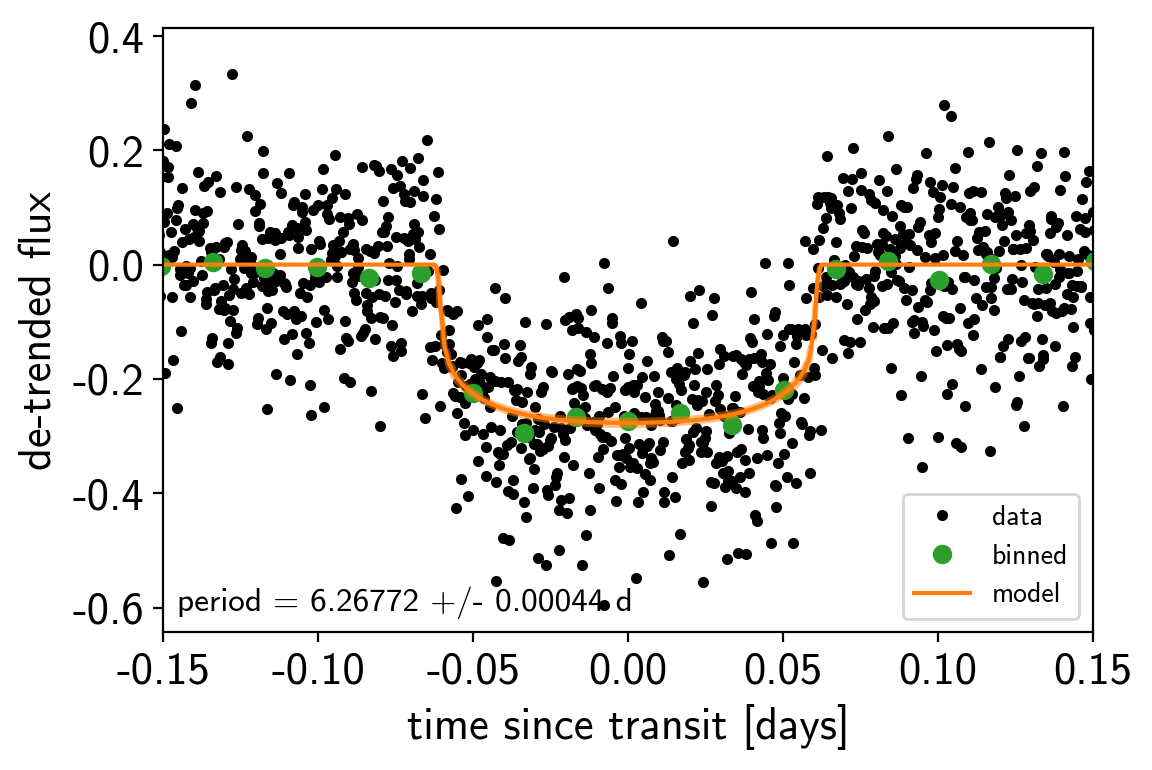

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, "o", color="C2",
         label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points", 
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

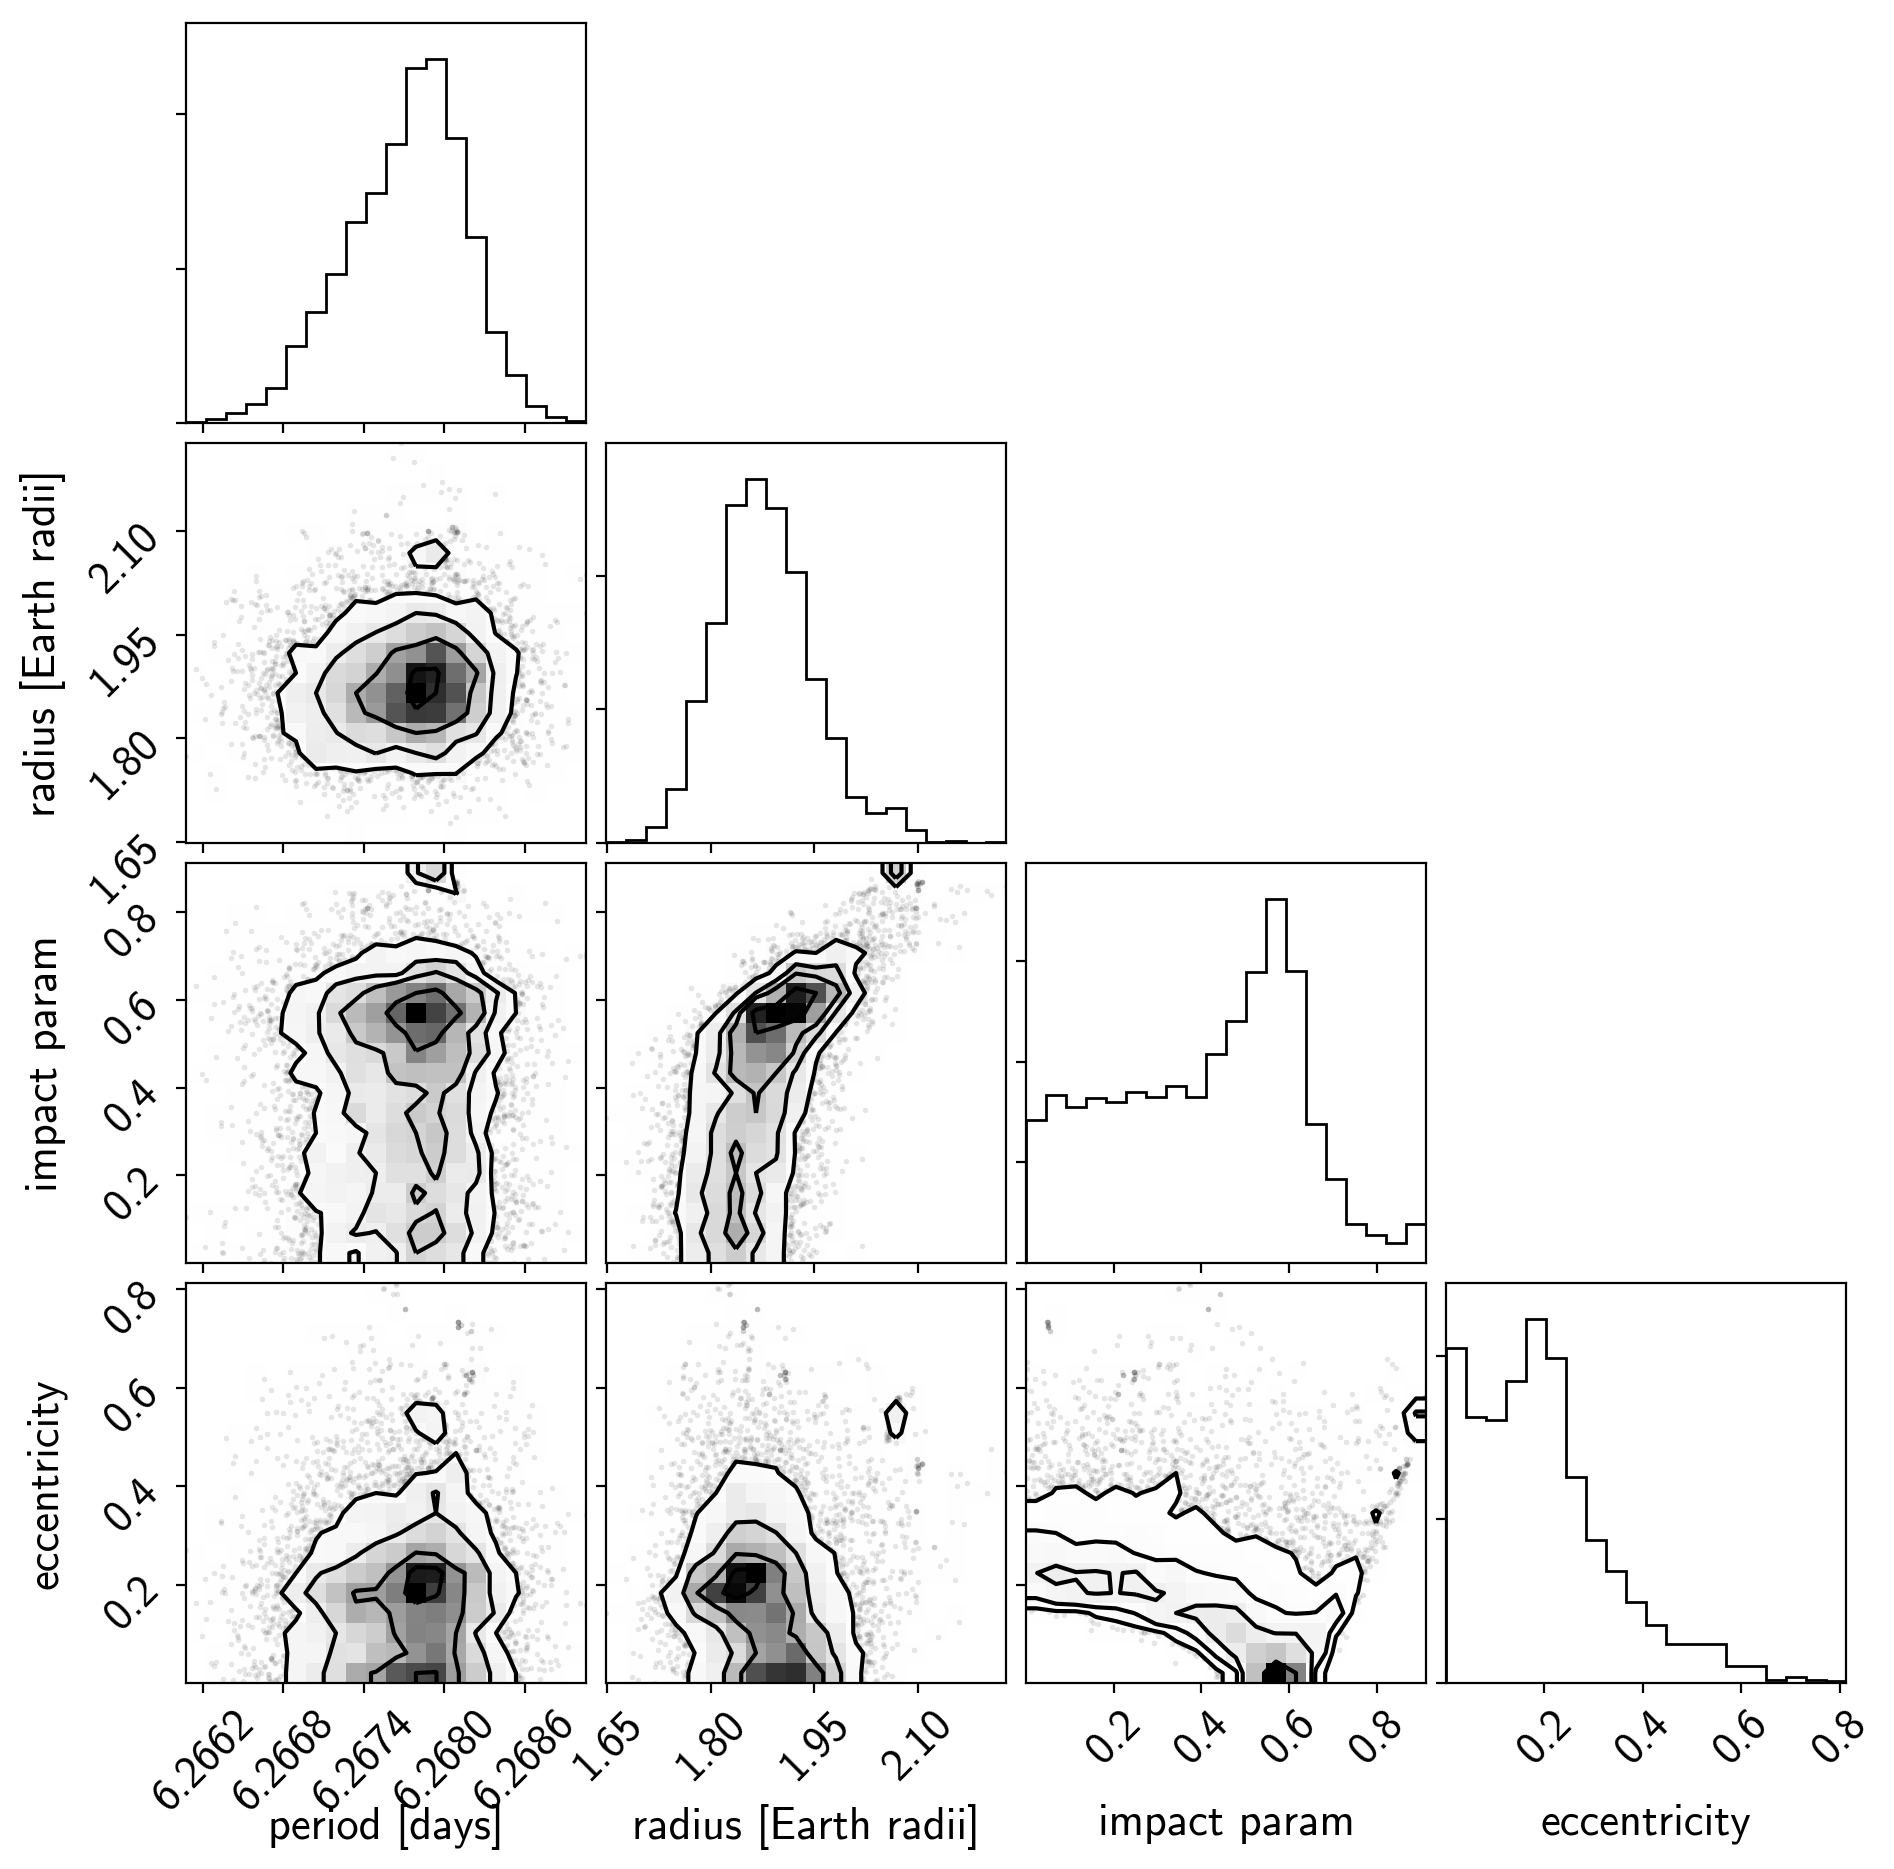

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"]);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [19]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [20]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
...
